In [10]:
# !conda install pytorch torchvision -c pytorch -y
!pip install ninja
!pip install neural-style
!python models/download_models.py

Downloading: "https://s3-us-west-2.amazonaws.com/jcjohns-models/vgg19-d01eb7cb.pth" to /root/.cache/torch/checkpoints/vgg19-d01eb7cb.pth
100% 548M/548M [00:15<00:00, 36.5MB/s]
Downloading: "https://s3-us-west-2.amazonaws.com/jcjohns-models/vgg16-00b39a1b.pth" to /root/.cache/torch/checkpoints/vgg16-00b39a1b.pth
100% 528M/528M [00:15<00:00, 35.3MB/s]
All models have been successfully downloaded


### Using The Neural style transfer

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from model import *
from utils import *
import torch
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
from imageio import imread


def optimize(stylenet, img, num_iterations, output_path, original_colors, print_iter=None, save_iter=None):
    def iterate():
        t[0] += 1
    
        optimizer.zero_grad()
        stylenet(img)
        loss = stylenet.get_loss()
        loss.backward()
        
        maybe_print(stylenet, t[0], print_iter, num_iterations, loss)
        maybe_save(img, t[0], save_iter, num_iterations, original_colors, output_path)

        return loss
    
    img = nn.Parameter(img.type(stylenet.dtype))
    optimizer, loopVal = setup_optimizer(img, stylenet.params, num_iterations)
    t = [0]
    while t[0] <= loopVal:
        optimizer.step(iterate)
    
    return img


def preprocess_from_url(image, image_size, to_normalize=True):
    if type(image_size) is not tuple:
        image_size = tuple([int((float(image_size) / max(image.size))*x) for x in (image.height, image.width)])
    Loader = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    rgb2bgr = transforms.Compose([transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])])])
    if to_normalize:
        Normalize = transforms.Compose([transforms.Normalize(mean=[103.939, 116.779, 123.68], std=[1,1,1])])
        tensor = Normalize(rgb2bgr(Loader(image) * 256)).unsqueeze(0)
    else:
        tensor = rgb2bgr(Loader(image)).unsqueeze(0)
    return tensor


def load_image_url(url, image_size, to_normalize=True):
    image = Image.fromarray(imread(url)).convert('RGB')
    return preprocess_from_url(image, image_size, to_normalize)


# setup stylenet
params = StylenetArgs()
params.gpu = '0'
params.backend = 'cudnn'

dtype, multidevice, backward_device = setup_gpu(params)
stylenet = StyleNet(params, dtype, multidevice, backward_device)

VGG-19 Architecture Detected
Successfully loaded models/vgg19-d01eb7cb.pth
conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3
conv3_3: 256 256 3 3
conv3_4: 256 256 3 3
conv4_1: 512 256 3 3
conv4_2: 512 512 3 3
conv4_3: 512 512 3 3
conv4_4: 512 512 3 3
conv5_1: 512 512 3 3
conv5_2: 512 512 3 3
conv5_3: 512 512 3 3
conv5_4: 512 512 3 3
Setting up style layer 2: relu1_1
Setting up style layer 7: relu2_1
Setting up histogram layer 7: relu2_1
Setting up style layer 12: relu3_1
Setting up histogram layer 12: relu3_1
Setting up style layer 21: relu4_1
Setting up histogram layer 21: relu4_1
Setting up content layer 23: relu4_2
Setting up style layer 30: relu5_1
Setting up histogram layer 30: relu5_1
Sequential(
  (0): TVLoss()
  (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): ReLU(inplace=True)
  (3): MaskedStyleLoss(
    (crit): MSELoss()
    (gram): GramMatrix()
  )
  (4): Conv2d(64, 64, kernel_

Iteration 1000/1000: 
  Style loss = 3.6e+02, 5.1e+02, 3.5e+02, 1.6e+03, 7.2e+01
  Histogram loss = 
  TV loss = 1.1e+04
  Total loss = 1.37e+04


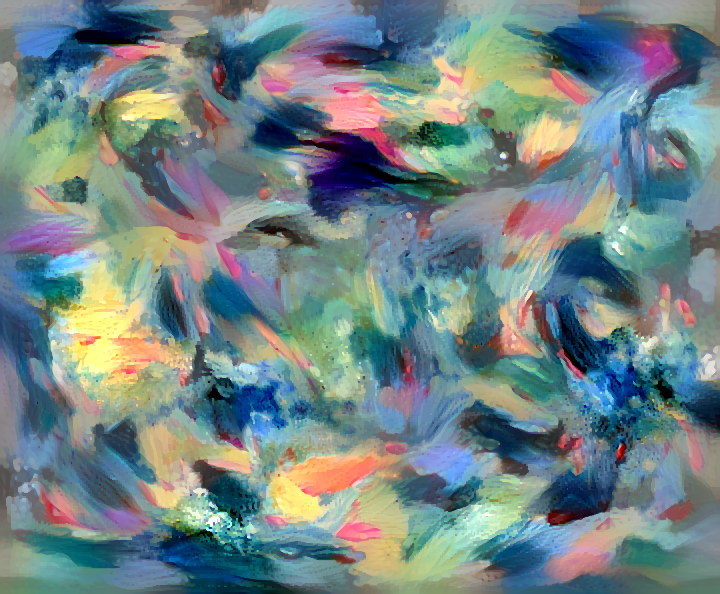

In [39]:

content_path = 'https://feedinspiration.com/wp-content/uploads/2015/05/Contemporary-Paintings2.jpg'
style_paths = ['https://images.squarespace-cdn.com/content/5aa82e1ce2ccd1edb04b4638/1525720423119-LZOUXJS3R0LZPSIYX0R2/gan+eden+lyrical+1.JPG?content-type=image%2Fjpeg']
#credit : https://www.yoramraanan.com/paintings/gan-eden-lyrical

num_iterations = 1000
output_path = 'out.png'
image_size = 720
original_colors = 0
style_scale = 1.0
print_iter = 100
save_iter = 100


# load content image
content_image = load_image_url(content_path, image_size)

# load style images
style_size = int(image_size * style_scale)
style_images = [load_image_url(path, style_size) for path in style_paths]

# set hyper-parameters
stylenet.set_content_weight(0)
stylenet.set_style_weight(1e2)
stylenet.set_hist_weight(0)
stylenet.set_tv_weight(1e-3)
stylenet.set_style_statistic('gram')

# capture the style and content images
stylenet.capture(content_image, style_images)

# initialize with a random image
img = random_image_like(content_image)

# optimize!
img = optimize(stylenet, img, num_iterations, output_path, original_colors, print_iter, save_iter)

# display
deprocess(img)

## Using The "DeepDream"

In [23]:

!wget -P ../data/ https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
!unzip ../data/inception5h.zip -d ../data/inception5h/
!rm ../data/inception5h.zip

--2020-01-25 05:37:19--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘../data/inception5h.zip’

inception5h.zip     100%[===================>]  47.62M   110MB/s    in 0.4s    

2020-01-25 05:37:20 (110 MB/s) - ‘../data/inception5h.zip’ saved [49937555/49937555]

Archive:  ../data/inception5h.zip
  inflating: ../data/inception5h/imagenet_comp_graph_label_strings.txt  
  inflating: ../data/inception5h/tensorflow_inception_graph.pb  
  inflating: ../data/inception5h/LICENSE  


In [0]:
from __future__ import print_function
from io import BytesIO
import math, time, copy, json, os
import glob
from os import listdir
from os.path import isfile, join
from random import random
from io import BytesIO
from enum import Enum
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import imageio
import tensorflow as tf
import cv2
import urllib.request

In [42]:
#Create a session and load the Inception graph, then print the available layers.
model_fn = '../data/inception5h/tensorflow_inception_graph.pb'

graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


def display_image(a, fmt='jpeg'):
    a = np.uint8(np.clip(a/255., 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.'''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]

resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

# Add code from the original notebook for cutting the high frequencies using Laplacian pyramids.

k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

def get_mask_sizes(init_size, oct_n, oct_s):
    sizes = [ np.int32(np.float32(init_size)) ]
    for octave in range(oct_n-1):
        hw = np.float32(sizes[-1]) / oct_s
        sizes.append(np.int32(hw))
    sizes = list(reversed(sizes))
    return sizes

def load_image(path, h, w):
    img0 = imageio.imread(path)
    img0 = cv2.resize(img0, (w, h), interpolation = cv2.INTER_CUBIC)
    return img0

def save_image(path, img):
    PIL.Image.fromarray(np.clip(img,0,255).astype('uint8')).save(path)

def url_to_image(url, w=None, h=None):
    resp = urllib.request.urlopen(url)    
    img = np.asarray(bytearray(resp.read()), dtype="uint8")
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)[...,::-1]
    if h is not None and w is not None:
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_CUBIC)
    return img.astype('float32')



/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Number of layers 59
Total number of feature channels: 7548


Inspect the network now. The following will give us the name of all the layers in the network, as well as the number of channels they contain

In [43]:
for l, layer in enumerate(layers):
    layer = layer.split("/")[1]
    num_channels = T(layer).shape[3]
    print(layer, num_channels)

conv2d0_pre_relu 64
conv2d1_pre_relu 64
conv2d2_pre_relu 192
mixed3a_1x1_pre_relu 64
mixed3a_3x3_bottleneck_pre_relu 96
mixed3a_3x3_pre_relu 128
mixed3a_5x5_bottleneck_pre_relu 16
mixed3a_5x5_pre_relu 32
mixed3a_pool_reduce_pre_relu 32
mixed3b_1x1_pre_relu 128
mixed3b_3x3_bottleneck_pre_relu 128
mixed3b_3x3_pre_relu 192
mixed3b_5x5_bottleneck_pre_relu 32
mixed3b_5x5_pre_relu 96
mixed3b_pool_reduce_pre_relu 64
mixed4a_1x1_pre_relu 192
mixed4a_3x3_bottleneck_pre_relu 96
mixed4a_3x3_pre_relu 204
mixed4a_5x5_bottleneck_pre_relu 16
mixed4a_5x5_pre_relu 48
mixed4a_pool_reduce_pre_relu 64
mixed4b_1x1_pre_relu 160
mixed4b_3x3_bottleneck_pre_relu 112
mixed4b_3x3_pre_relu 224
mixed4b_5x5_bottleneck_pre_relu 24
mixed4b_5x5_pre_relu 64
mixed4b_pool_reduce_pre_relu 64
mixed4c_1x1_pre_relu 128
mixed4c_3x3_bottleneck_pre_relu 128
mixed4c_3x3_pre_relu 256
mixed4c_5x5_bottleneck_pre_relu 24
mixed4c_5x5_pre_relu 64
mixed4c_pool_reduce_pre_relu 64
mixed4d_1x1_pre_relu 112
mixed4d_3x3_bottleneck_pre_relu 

The basic idea is to take any image as input, then iteratively optimize its pixels so as to maximally activate a particular channel (feature extractor) in a trained convolutional network. We reproduce tensorflow's recipe here to read the code in detail. In render_naive, we take img0 as input, then for iter_n steps, we calculate the gradient of the pixels with respect to our optimization objective, or in other words, the diff for all of the pixels we must add in order to make the image activate the objective. The objective we pass is a channel in one of the layers of the network, or an entire layer. Declare the function below.

In [0]:
def render_naive(t_obj, img0, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
    return img


Now we let's try running it. First, we initialize a 200x200 block of colored noise. We then select the layer `mixed4d_5x5_bottleneck_pre_relu` and the 20th channel in that layer as the objective, and run it through `render_naive` for 40 iterations. 

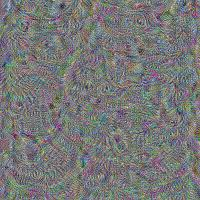

In [45]:
img0 = 100.0*np.random.uniform(size=(200, 200, 3)) + 70.0
layer = 'mixed4d_5x5_bottleneck_pre_relu'
channel = 12
img1 = render_naive(T(layer)[:,:,:,channel], img0, 150, 1.0)
display_image(img1)

What we do is we start with a smaller image and calculate the gradients for that, going through the procedure like before. Then we upsample it by a particular ratio and calculate the gradients and modify the pixels of the result. We do this several times.

In [0]:
def render_multiscale(t_obj, img0, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8        # for different layers and networks
            img += g*step
        print("octave %d/%d"%(octave+1, octave_n))
    clear_output()
    return img


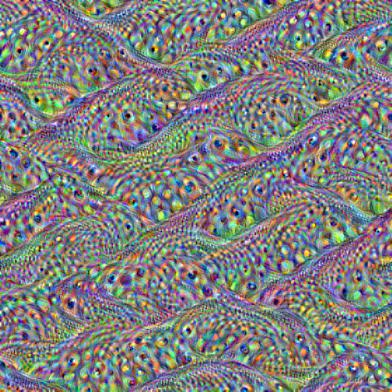

In [47]:
h, w = 200, 200
octave_n = 3
octave_scale = 1.4
iter_n = 60

img0 = 255.0 * np.random.uniform(size=(h, w, 3))

layer = 'mixed4a_3x3_pre_relu'
channel = 47

img1 = render_multiscale(T(layer)[:,:,:,channel], img0, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)

Now we load the image from the neural style transfer and use that as the starting point. 



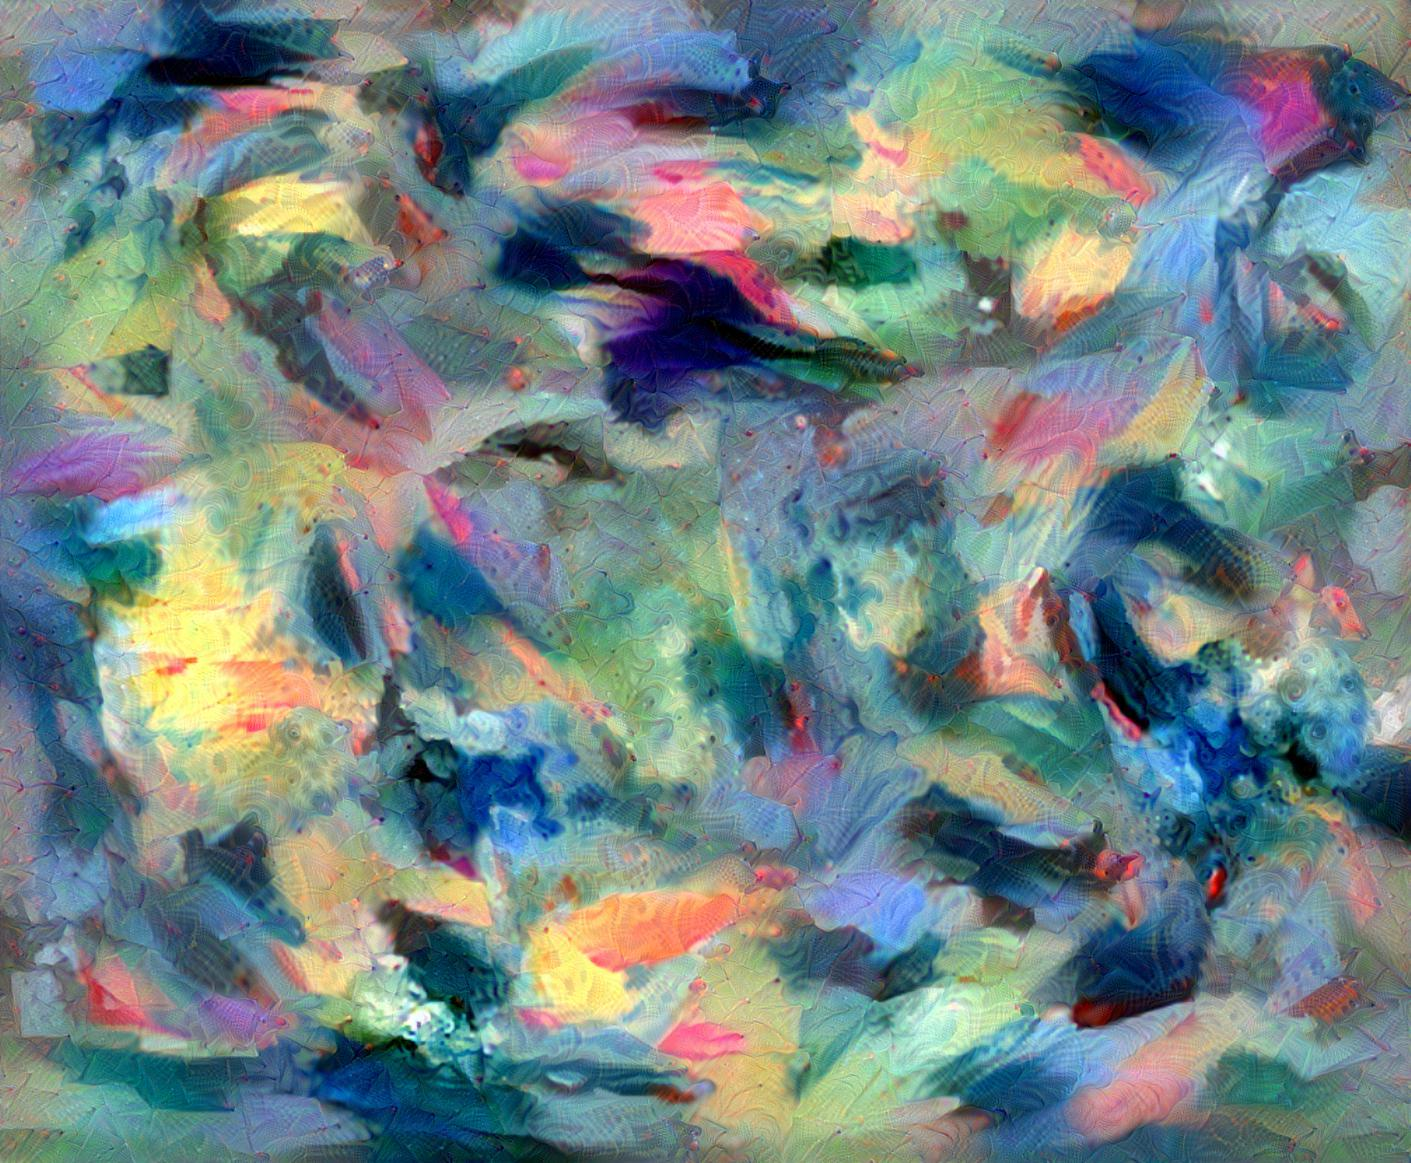

In [48]:
h, w = 240, 240
octave_n = 3
octave_scale = 1.4
iter_n = 30

img0 = url_to_image('data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtAAAAJSCAIAAABlTWUYAAEAAElEQVR4nLT92dMsSXbYif2Oe0Tk%0A+q13q62ruxrdAAgSIAkSo6HN6Ek2GrPRk170v8k0f8PMi0wyjcw4i4akSIgEATRAoLvRS1V1Vd31%0AW3OJxf3owZfwyMxb3QA5blX3y4yM8PDl+NkX+b/9t/8toCAQPgDhW/p80OTgq4oZP4NOH9Pcj4Io%0AiveTO7w6N4wda+pf3aSfzoe/DdYiIAzQbvEOwFpA1Q8MflB1DtQPHufRfoBN2ZXz/fb29r7tv7zV%0A204VnA7upXrAA6iyk079XRiQqoZpCNQNy9VF6mkIVwVMsTRSY9SuapqZ5OUy1EJDVV0/a6rKip1h%0ATWWwiJF4kzVUQi1GsBYqH7oUkHOZ2SsjWCoRsHOxIILMwGAsFWH049rOURsGpuDiFhuQCiNgx42U%0A+DhpqCIi4de4HoLARvt+33bbXbfZtb5nwHsUxTucMiheiwEo6tOHBBaav6M4t417vK5hOcLVw12v%0Azt9vHwBjpapEQISZAfjx6x2AHSGxi/DTrBemqfI+qG76uCtnddjW/t4BLz68Brmez+JANc27snEb%0A7bga0tTr87P14rq+XM3supmJUIOguKMzokcfYoeH90h5PVzR9FlVxgOogqKKR3wYqs9nU3z4Ly2w%0AIuolrndYaI0TjP+hqEtw4vDD8QQUfRwe2SjDI/e3w/AV0OF3w9DuPT1O6YsnBnGuVT85raboLX81%0ASoTH7R6Fffh1eQ0MrWqAUZg34VGP03H5rFRmUb6inofl8/Q+X7WCrfPrySfreCMExGBEqNIhG/fi%0AYFs8xhkQoRGAlaWCuramkpnUy+sLKiOCrajTu+1Mls0qddXIbHx3Y9Irq3BxPIjpjxRLeNgGmVx0%0ASj5aHg1fXdGfavgJVfVMELQCA/iwoz3O4/CQ4Sm/XyI8eXGgQ96a+OvhOk/XMH2OiF8zeKZ7NMF+%0AQhSJZMS5+UG98+nuvuhxj+av7s1X9+SjZRBjTDmuAprSt3HlNZ04j9FAyMp5BGwLmKWxE+QJ1E1j%0AmtpUlRWTr1eIqWfSmMqKYE3xk4Aggkj4g0jadCMcQOnBv/Fh0r+Ma6kZiRSzPdiC8a/6/FcjrdWE%0AGbwqilctOlE8qmHv4tsiXfSRyiv5RzyqOFWnjra9v8sjMJNNmI7sPTD0d23yXhbmb9nLqZGZEctF%0AyPgNujm+JI3IUlid7kEBizRI/f7VWUAjMqOaS4LhOG0rnK9slYD1NxlmfvPByv0dtub4kd9kN/5u%0AT31r08mfv9Uz/+kG8Wvb32GF/2MGlV+nk4v/ac4Mk+l868z+rmf+N3lODj7L3/J18ptP4zftb8Tl%0A7xvMqeU3J679+vabyW+/5u7J7YdU8Vu//u3g6Nfe/R+DgfTg+9+m999oGidP0/+W7RQ5+U9MPg9a%0AMTMp1vPbXvotQtB/wtH8mlYd6ive09HBZLxOf3r/WycoU0bSKSAWwA/TAYWLnqmCI/BviCEwgYq6%0APT5wvRaTJfQKKwxb/IAHB5I35CzeYu5ih52jliA+Uj0HZHVZA/1Ou3ftcBcHGqSgMLAaZguAfQv7%0A1CEIVGAX1HMqixVzIALbM5ZXq8V8CYxzO2KfBKjQJl6dQROk++dYpBETtRRCBRO9BECUwEzRbeSF%0Am6jfiGx2P33MTaWsQ4nriFl0MPzdaeGpJ2Xy52hJAIUhfYhdKEDv0l0jHVC/2QflDCZIuQKqjxOY%0AmoWt2NGH0cyl0FOJqsZtqqjmVGYcoYzymR6NlomY8Z7pk/YoN58es9ObFXH5oz9EEpHNllFAcAb1%0AcXx+VGUUAoSk93FqJwQROWuazrTdzYTPdfdHcAIMMGRBtLhOlnXyt9NNrADVErfFv1dQPtUaALpp%0AbxIRvXzLK8PTFublcHE6Yqd0bA6l3NAyoNVUyxersZP3ciKaZ1ZP9yHtRhLxQy/5DE7Zz6I/IkI8%0AmKQff86diBwqNY67zEKAPxRtJjeXRPSIMz7Rf/msfusNx9cFVOIWmEZETVCFuG449XiBU9MpNuGM%0Afauof3Lgnmn7dUCZ+VXJGpV0lgUqwSInQOOwW42Qa5Cs4dKjAUWUIxEAivN/RDKP3naAz8O2mdTt%0AwDC9X6ZcuAnaj+FwRFIcjTAHneCqyc4ekqziGASAPlr9sZ8A1ipJbR+RXFiF8H1IvVUQVewJ/POA%0ApssUpu9PkiWFmUFgQD39sUY7NbvEP1BlwprpgoBPh3xgiAiWBbVXMgI3RpnNqEdefH0F4Nt41MXK%0AeonuIahthWaBzMAec/Fiob60s4t1Jc0hkNWCWoFRRTmDSqiRmZEZImCrxE/9esmqKYbwvo0LlFqC%0AosUJ4F13twMQa84XBpFssAidbeRWv1S8V4W2RI6/WTsSxeTguDXju9LviI1w1XkUvME7Rmzjpr1a%0Ai6DqYzfJmBO5g4ch3uzfv4r59Q2gtPFbVVdGZCULi8YBSYHXx/Of2WmJNOOg52MmK12PZ6fUg4/4%0AJk4nWq/yDVNAKg/L4cHxYzfjg3JiU4obZlU9dBlJ3eF26eYDhOFiP5L1/Bk6WsTFjQtPKXg/QWoF%0AgynV3A57N16c0gkpH9ECgA6A5uDOU5OzFjMLdKk4rZ1q4i/EZAwqWf/PKcBZLs6gPvGa2KkTNEx+%0Advxj0KWHd6rHQ69gmZEJ5ZRni6O1yqA+slSCybao3LNP90+G9r79Ltr+GGcovP/I5C5HNvmUNFH+%0ANh2pU1yyw1Zy8j2TDkWws5nr2nzNFeQj33d6vG461HB6NYoPQ+BvIkY8nMOBGHBijGKwcngyE4gd%0Aorv0LTFwGj9qeSKmQK4jW0r2SRDN3KmEUfoDY1fRWzh41Xv4J4FaqsEMGqSK08Q1kCM3BOeI97e8%0AaVvoJrdWE/xWtoBcXXgIWE1GOmhkIxKFGzRieUGXCMKmgN6lBaENSFxkr2o0siOtgpJtwEGRoD0a%0ApMCZDRRAop3eIqqqdz1aSHBuD30/F+Q8YBORuemU5dd0+C6wy/ENzu/dFn7aixqwxgQDytvwawAt%0AJ0uR3TKcj4urJQh7R/VIz/5uv7haiGCeVAZqKyJgDIK6ljgdZ1oEkaaqZg21wRqoMlJWxVi8qStj%0AjYDTKGg3RmUtZ00gWjKijIGEg7x6Ua0Aa8YfVfMumniIouQpGVQdehvusFzbCyNUoLrZxQcvZzSL%0AOi2TPvi93tz7Nx6QuZRgUiVrowgYOzD0w2nJgyNhyCxq6qpGOPNsRrNr+DmS3+KIb/ZgkMjFqjEW%0AnE8shYmHRURU3ftPVJA2KuZPbAC2r97111Va38jm6yjEJfLfSP3R9e+uKxPo0V4Z+vjq8NeWk6wi%0AyxrFB0ndRr4Sg4Rdc07VsYddOiaL0i+lL6ROGApZWyrBziOud6AuUq8DjUI3qgnFICKmQpEBjwPf%0A8RLdJvJvkEs4C2JNWIuz5YszndeLr796iMMzYIwxYcI3zjsdstOQFrxQHEAy9EtckDov0lTaSles%0AoXYjVqXQXtSwgtUqUqx+XG/aTVRjWqpK7HJZCnw67LwmTygRqTCNmVjg1e8D0VIyy2SQSoTgMbJ3%0AOM9JkrN+Zl4YSJrOBhdQ2k8Blt9Rrne2mtc1TQ3gejzgBoLPWm2QeezqPgHBLECiAmwLWtpAVUUG%0AIvikKazT0uUl874byZYaY0b+79c03T3E5U5kszgInYLOQGymeb5z2oXjbCWxzLSqPq4CE34p86n7%0A5BfWjOooFLZZyh0HPGtGlskmlk2gbmbBJ8XTuOEtA4GMhHW1TXrGuSg2zAWInxfE5dkVPyXROnkQ%0AGplXEEVKgGU9+unN5yMi3KYPgtgqQkkXeWQRa2t0FmiPFYSuEAwy5VXwmucvPsos8eeCpVCNOkWy%0A+NSiIHW606SV7idWiHJpT4BEPg4VqDAoOBJRKL3rwt3GKjAMKGifZAiB2Um2Kr1sZBkyi3WEqSe8%0A5XErVaD+yF30QO1ScNj7ATdlprfp634/XjwXCkZH42vgoUs9lm5xABgRu1aWWKR5BU/Z3tTdzijO%0A3Svw6PQOXiNKrQBzlgDcdM57dwt1gqJ6USJIFGS9lUc6tq/aFy9m5vx79rdXAuy2/Pg17Nq3Q+TW%0A1Rgw86qRRuoXvLjSi2uQ6Df39eeBTfXny+HyoyagiB7AgRMBHhWU7wgDvMPvdAPMI0Rv8GrgPC1U%0Ad6MK5hojzOF3AGi3uA0Iq+dcCCJ4eARgdsbCB1BWYD03qwamzmgArWoCO7k2Is0syGo6uu9Fwrdj%0Av9n7m3tKCTZ26B58n6+Ys7NR+SJ2FHs8gFOcAzvlgKO7Y4SD+bxCqx6nnkzyMuYaeq0aMbMq2dtE%0ABZYJfCuzkMvc8R1c5Gm0gNKkniIFle+9+Afy9DyPp3rctHCrUQnXgGmQoP0CwJxV2GakA9vAoSTs%0AYuIvW+R+ZIJpqKhspGuCunY/muyYVXOqRJxCi8RoahtT+lE1E69YsayrtLi9o9N7r1s9MEak20VR%0AyV6A51esf3/9s6/tnT4Gdu/pSi4rYH0Lv7rZcOvZOw7Mok1BBEU/+jCf4O6b14zHafwTaVzdjHxz%0AN4yw9ORZumckr1OEafV8oeWF8EeMT0onlmcZk3h1A9rn/q3ITCKz2alXOqQJ45A+mqZswfRZ6hk2%0AoVc9ZYbY7lHH9SyPRcHfbfu8Uqbn8pxg1yGRGDlP/EaBHoPHe3ZAxerB9EsEmRdHDCOD4gstSInI%0AFcA7dg9bOf41NY/gded7caA6gEtTriUL5+pIzE52gB5nkXYvHi9JOsGkAWgCf+kiX6BHI/GCOVxn%0AA4vlEwaG7VdtMKIDhaNAOCXnArBRVHSpxWjzeRNuyiU9vw6ANkQJGbtCaDR+rVikF1QJU5hKMdRg%0AYQb3blBm03koyQ5Itt6mHwX6MNyoUlOPNUe7IVBDLQGrsUlE0SMe0xSvqzNMCNMojXCEPDoqCZg6%0AQY6mAe8yHU8bNWJmO1onFFS9dpDUmQhUwrWah0R1RCk1pEciSr64Ki6k32tBIr8RxnM3pBuETTg1%0AxZkJhvb9aGcr35P0raFzPwLnA9TpkSjkdep9vlMiJ4kVi2ma2uwxh3L2/BK3vnh896i+7aMJSjBn%0ABB1VikiQM//urk8+0gZdog+h+20milHGBpAOr2rf4UEf8Fq7u8wTIs9+UL94Us0qOWsQYS4+sIWi%0ANMIPvwdgRCWIsgIRO6gi5xUN7hsPvNQkMctFECcA3BJeCezD3EmbYIChh79QFmhG0lUYsRED50/C%0AnBQGvGZBXGyEdL/bl6KJrBaySpJYUPymfZ7gvAWzxbx/Oh82h+uvYLqB7b44W7vxWZdWFXB+Pxrh%0ADnjUeCWKqkKt1R4GM2RIEkU8zrFa1BKYSEMdEZtN3c6m/R21ztMnAbwyv3f9IS8mlF6RN2nIRmqu%0AZmHCrlWgOhe1MgYeRW64j/sUgFy5Vx7CJbMcl6kkGDIPO+MBM9/XQgF7QJ9d+wfYjViaBpZCUzGr%0AphoP38LgYZdO2gIaOAdTgVGIKngNfAuS7/voGbMtu+l+zOD7l/N7w1f3bX9bLqqs5iCsKtUp3Uj0%0ARQ1tCLpBJhAVmoHZikVkqDPi7PYTF/dIVM5W6Yr2gTZ7ImDDwszrWXZcQiNWD8RGhIbAdVeJagqy%0AAFzqokBhfsTmsyoeodvbcLK4KI0Xn0UMG/C8c247ON+zOXLBGVfnvAKRJl0NbWmjkVAB9t5bTXjz%0AvFCwp4d2LhnOBZYoMeIE8C5K/yyKdU48SPuQgvjC+oZYomW+pLTKI7So10yqqaBushXBo5khE6vq%0AdBozl1ozijXBQSMOuVapw7uX6oRWI6MUW+8e4ifbjKrcCFGGClchq+tCQyLCgK9GZHa+jiQrYLH6%0ADA0AqKiv0cQnXdRUwUVOtIrnBaCqseiAS5pIJbtQodY44k8VwUWIPdRIcCU0mbUkPxI6SXsadl+U%0AXRxI6elnTurYAmXehwmP1iVjxwdHvv7IOyyZTQpzsyQZqIYafCE/alhJ5yhiMm3Ea+LQ9gRCFVA7%0AAYMqyIE2eY5sHgcFOxtxdGCzonJeROwIJR46BGQXpapwr7hJ2JQAQyvFd0ui2iNay/PSRIEFoO8S%0AlsoKlPDH4WOknwCVFFFHNyR+VcFExnh94bwTD63HooEP7V9O/MI0c0JCMuYBfhvvqQBm+E6Fb+4x%0AYNutSTM5Z2GqBXw8+6PzKm91sAjJic3I7T6ob/NZCQfqufBa9x0yC+rEdLZAdIb5jpQr+jSATxZT%0AtEPrNYs1hk1QztYTdlvjgkpxbUrhg+JT5jbdXyDfKbcx0WQtDXuN8VO5GRuNQ0o8R+Xgi766HqCq%0Apr9Ml04mn+M3U/5gos5cjFyY5xBo6nAf3YDTs/O5EZ58AvD2y3EMmuDgh2L4JDr5ZV7yPhwhBDt3%0AT862GRqvAWSRvMM8+HAwO4JGPFiIHTeJ46e6SNpf9d51Oio8mIFUhqo87wU2/dZmq9FzMgmZDoZ8%0AJhthVU0AIgTf+mQJUgu9xhMgNKZa2XrnW4FuosOyq/PZd2v55Vb7pDBpAl6NGzCQ/GbCi2wNPYgr%0AYC1uskbGu9dxJ6s4cR/0MdHQ5gH2iJlLhhSUYcgSdsFhHADPOOV4pFTI3qEB4qRidEPrRruGP0Da%0At57GJMKcWuhoXn4N/6ejmTFOdhOhQIThXjcZdBiBUxqizBLuTcZx3RE35XRkxIGmWQB8Aozh3QbA%0AUC5MMZWE3YKD7T6ykGpFGwO009virzVSy0gDCk4aRQpGYhxvAdNiIzv5XvfB8qnQRX/8U9pSSax/%0AYlMiXrGaHY+CcSfCdTbLKlToEmAHixIJKi7pj2Q6TueLqGwYQDxisdBmBUcxjMmOCSCyCBbVw9M+%0AqmRk+sts9LiI2OiwXyCF2pfvmoEK7n0L7WHqs6UH+usJxEjz6/ASAJXqAAwO7xm61BEF+SlYAkXU%0AsT8UYsOvWQFkIMfG2zyguJoQdJWDQrRroYGRj52EEzgebfWJdRfVvJnK0Ec9tklGJqdq2gRYweyy%0AzANQD2KYX8vDgzLAE9i+gG/6HlsHhr2YjR9HrUrIV1ABxsRQEFoefqKrS8czK4K54gp5uuJsZGQL%0A8q0dvkYcSFZlB2lDFHjIL3ZwM6yfW05C5LSlM6yZ/4vcwRRlhWPVe60SWS5DuDOiz3eHHw69gg6g%0AKd3mC3ANajmPuKl5beQp5KgfNaMHt3Tlr4HXVUWsZj/NsfVhCBZLbYUK7Q65+E+v199/epa//osf%0A3wGrRSMJB5mp75Im0gUsBf30CmOoF6Q5/o36wSwwsBA5v0DmcSH2g7dlN7HV2gNipEmo+W1CHFKd%0AA0Nxovv373W5Zi6PRsDW2Jo0CsmSyvRZhT4cSGNlNSdbkvP7ZIKRA12j4A/BisQjUbhrWCqkn5vZ%0A3EeGowJRjw8ak0iNE9FSxQhSoeqC+F+tx4HK6DCv2bObaY6HuENZ7Vm5cFB0NJyHUVRCZROlOQRd%0AHU+ATH5PiCwhPx9VJSZ1c2qTxzEz7sPRPTL5E4fv40KH1EI+4EQPaJKf5O7IXvP+OBJOHLBMJKtR%0Au5dd6fW1O7iXvGDBUUYDep4kptFIEbKsdjigOEmb3h5O8Yk7xhdrQlMSDmU9eupIGP18MvaD5tUF%0AEceE4QsyQomNc4jxApGzm2AamYdUB54GL6VuJvNJvqTowf6bnq9BnIKYHlsMUQLvWFENKDghOGJb%0AM+J1k1/xa0O08kvNERIvWzgIE6M3hLRU4a0Hft9SeHyPgfjvAbJjZ89v5zKOfp28vGpSqhwBVEVU%0AQT0SHHCPbGjIidDM8KIgx2ZlZtoEJbJ5rgcwdeaNIxqLISzlxFz6ohLdTnNqIxTEed15sbBHEX1i%0Ai1O3Tfdn8VGgTpzaOdyrPjwMUM3t8wtePaZRqi/FhW3vgIWJHYzTfHkn5pl+jFyLLNdRjveoMAgD%0AyF5lF3DRLvDNVqpqLoDsYFa4Te0zbLvunmZ9Fg57/7X2PAaOzFlZXb4I9w1ov+nf/uoRqJ/Nr64w%0ACdb1AXj7U+GHjV+eaVgAQX0iRVZc5G5URz4fMyAeUaSHoTySx1ClYQwcMp8JQedg1bhJVCn2s2eA%0Anh7YD6gYpQ5sYXI+64t8VKohJDVAoJqg5u69gyaA0lJA1NFTYjX5AdV3zQeybDIs/S4XCOajika6%0AB//6ZsDr2y/zqHWUqgxXVyi1rj4R6qAs/UmAuRphaS7n0yUZQU4L982o+LN1ACvnE7TXq4ByvE/S%0ASAFVGWGdPssu8QPv50YPH3RJEzhS9W+5e9ok/zWR2PUE1C5RExVAYB5v9uEcorUml7/Ilvb3DhHB%0AIDHmeIJjC2mJfVTye2Z2UQlofSrqL8rpStcCRK89qcWkDG5oiBJORDI6ZsR9SCK5S0goyMMOwA0O%0AvwO1xWKfFrXAuSBMpBnFuWT2FYzOjQX2yn5QYAGuBbbC0i5Bo+7DtQBVIhiBDZWSkejzSQlenOVv%0AE+SUxzbZYUkZnXbBH2N8KvI4gXnqit6m1Dnf9X7QSaeJhNrDGHsKqB1fGmYndHGLzaxYw0MmSgM1%0AyWFowJGIbvJzwTMnIB7ZFb1EPVxayBw5KQNC6w5YSxnoeRyPQo8UJ0NBxOBFB5BZhC1jnDHi1HhU%0AHBgVNDiviFBHq83Yjf2WAw2kyIAwpvpIm3XAau6gnlDsCdf+/pax2K9BC3/XVqUzh828lgAquJFJ%0A1NGvOw1jwmdMAhQKB47sxpG5K8AV3mrDSFjiQQ2eR4EFDFyLD75zCQIyy45EH+MkyEjSLsUb94Fm%0AqmpP2/sBX50hcN7Q7tmGPVpcDrtgHnSjltOwWsBqBXQPm+6Aq/Z3geUJZnTTPMAf5uxrRrV39AEy%0A3mDoqus47lZAMHO1+yQKdQOwnM0yuIhX8W+Ggdq9DvGZrg8p+vbATpBvPp8ZhQG979IJGr7R29ey%0ArC5B3r5pHW2gzT8HY5K/s6lNcqaSmVylgKC4lFVzZkcYtlOroRgQGx67nJvkjX0Ik17xveJwrqAO%0AFmuFc6ti9WFQN3innXPS+wAfTVItBRDw4Hd4dbvJYRGx2BQ6oH3M3iJXAA+gA5KhQPl0/eystnUd%0ApToHqKy//xyE1WyAjhvhfnpMZTzQ50LzHdarPplDf5nvqgxXcy0mLwkmuxFvyWiGFTE0G6ORGANm%0AbrPbUhtVnQ7x+BT+Ev4USSECiHcF5rfF2MO27SDYjiZqHsUrXifoKH/a5Wif0M/OzJK2UMMAHPc6%0APKCdioGOFrgFS3UevYe61yJmEo2toGjbekywpuA8bAP3VcVIfQZAQvxGn7C9Ap5BM1+k7N0OszgT%0Aic6SePDbaA50BwyLNyBmFsfietinKO4k+hhYrSZ4ffcwLmMMMiJ43ksW+RKKCfAl84arC+bXoPTo%0AcL8FW/JDCjDTI8f5003GD6fUF8cs6QnSVD4XrTwypNfriXuVPQeUOt7mE0dm0rUOl5j5kLVIHW6S%0AvTnxDRI40XSpOCOxL+2hw/kokdYVshKirjGEj3nfmkR+teB2ttkYW5DDJtMrMFQXhhzddJ+peVzX%0ARGOKMSvyFgLn9Tguh7JJzEi6fZGUrNlcWYZZGCHEM1uzJ/iOOoOptIKdoQmKj5DAtMEKKnhJDIeA%0AJgeq1GXWYp4Em34ajj0523rwMXZQJTO5Al599mAJV1GyBwfoFBKnAJRchhM/rREDanR6VZEEA0c9%0ATIMIv4W/8oBvu3D4ZMJvnLIAxXEkQAuugaJF0t44zen6Zv7nPSPR9G86SUUcYy1IjdZvGQL3vU1Z%0AcockW1oLwspiG/zAIyDSwwN0G6fq+j0odXOSpOpbzxqVwWXTJSLSOvvTv6rrJ2/sy9mqAoNLOca8%0Ac+jwqKYB64P2yAnOIuLylnRIfXUdSHzYSq887BAwTR2gNBJn2r0OuIgtFAmi3d1OwWNiaC9iLNbA%0AmlHvKWidltW0+iCsLWd1SJ36mzSFvd5wE9Hf5NyCdKgbJrKLCnVdm+VEPDvYSoKvjASIR0VUVf0J%0AxUn5TsHWFSpQr50GbYwPynVZy2rJZW2DXVaD+6gArJ5Hp5/HFvVcXZzVifTMpAoobvPuBmik1mu7%0AP/9uUKy8yiNYr2hm5eDj1FRDdKskC55BsEoP9Qwz9SSYJGdO7g2KmiwYJvH2VI6B8Xtat/FUvL9l%0AjK/AfTSqxCeakUfx7ZZsmHPi9/tAV9QL0yAmSfzZRvcg0UX+4IWb5Eh2NDY9REhASlEVBIzIWpbo%0AMzbnlKSwnyAK77ACOwbox7wlOdI0rJbsN9HbziD3Y8ofERjAjvJMYqKEgnMwJG6vBkSdgnETgWic%0A0MOmQyKAszqL3Vomiymo4DQyVCEJwPHijK05MiwMCeHK1C30aEDjbvSao1cPu8nP+EnSCnV4r0Nk%0Af33iqZNacpi4bZlgva2gOWCbiyF5dK/KzkOzoEaoCf5/7eAGT/8Iwe1nFu1gM9ZiknNESXeWH7G/%0AV92ZYhLxnXXkY+mwS0CHLR6+9NEAswU8e7RLevfQwwGA9pLt/dHMF1MZCdYgQtNH/Wtletv0wCDM%0ABGeMHWioBPEyx4jzNCnQxGENNRjpy6CUA2bhoMXNPj5age0qs8OffnjyuQ2LGaDB2nr8rY8lEWLn%0AY0irC3UtDk6gMjiU4CXbOo9H0e5R2z7z9KcNIpPmQOnAj6o51S6qRKfMQXAIHyPJ85lPbuFJoxl/%0AGe0Jhws0y3nBkUZy9n3LTBW3adEsAU52SSTEboh6/1DKdTUzKyIxE4accQVbp/TMVnNp27dvGDpa%0A8AO7wa1M7pIGqCxO2d45HSqgjmy0Que8c3fs7xGR3fyJCFmXHmZ5B0+zCChQxUxy2dFR5fpdL2fX%0ANLMqKby7nQds7c6uGhI6++ab4MwwAJdP4+PuIF2PADYoXXeMPm2ak3IS4047j1OMHMQS/Lo2Yu50%0AQXEaCiWUpE9sHPdowNUYDi2mshDiQcTDQ6tl7Fbquyp7C/9ISKKwAhGpqpA0SFoxWGqMNebMmnmF%0AyFzgO9eyeg5B+jd8ZgD5G+Dd+snHnFfnYVlvtiLQVMBwMwN4gj75ULFIE8OjBBYXwfm8GKZ6ZWiH%0ALsP34U5k6YtRGCj5Lx/cd8Kzdg6mWceZJgTtk62NBTJ6nSRO0kPfC8g6vcUX4YgKfT/6PHjV2yGz%0ASZljkZTZlg4fnQkcbjuSEBGQupbWRQzkenV9374BMGJMVbJRIpg279qpFtgz70fF/Iwyb94EHXSP%0Aj1Vlx0sK0YIxouWwqsYH1DnyKdldVfJG+GhpVZ3QLF+ISbNy6JInokzI3DFOTysq8eAN4TUHN2UO%0AfBEzxg05dpfo437AC0zOnAAMvXqyF216hS0sZuklshwPa0akYwSLgE6odLQLaVE0R32styLB5p1T%0AqpTJ9yXcGGLYQ8SEDMhequweh0KDNmIUozqEyMwB6DrqWrFiG9yJeIcy6ut4ZYY8uek6l/Lo+HRw%0AO9u37EJSQQW2yk4RR5XXyuSJhQVHjOQYt5TOVAwioR5WL4jBNBiwYkUqK7LfMZ+p9eIqF3j2mmGQ%0AaClrMCDCIFRWfV0SwrBNKfogJwWUMUGAKWjUuJWEDIiTJfIStT7TFZIBPQyOH3wvIBKjkco4FQY1%0AVeGZAE7wKR7p2zKBFSf3vQyHwq6HAqCgOHYHl05ckcmltJROo7v++KLRbebgkB+8Xce9MODQdwDm%0AafxRd5FXnQxg5MJmVKoxnaBEk/Mc5kse3gp1wLISEMrQvb7lap36MaPjrx5OOO1+JLX7GEIa0+cp%0A+Fe98gXSU2HEGlaWqxEdBjy6MTIb7s0FEIz0XkOe3IHBRFGrfbWPLJ8BeLUzz0N27mwJqgQC5S8w%0AYyUZ644GW52m1pZI4caJHLTEVo5Ye7oGx5rglMCvdUPIHq/aeo9L7tKKERqlj1usZWKIBqGaTxXS%0Awa5Tz4TKejFQe2i77bBTgkpzaaQCzrk81xpBWJflvhSuAL3kTK9orDy3aDhSr+leBQSqH58Dcv6h%0AMwLCotqaJdYwS4x/YrsHT+9Q1fFESs4jBMBeU6hbsYi+4NWmGacFhqkfe9Hv4frq9OfDPXHQ7Wk1%0A5TkPb1Pd+slj52Pv4VhonVw08j0z0ODuHAPigv108OgeNKHeOovdkb6bxAToyQmkMeWP7cC8toLx%0AUsjvWRMwBARcBLCVGIFEeaYRLiTOJn7NLLKfPKtMOLTM2+bZJG0sByheoduD0hhEMlG00Qs0tuFg%0A9pL/MYlP9ALax1AmuS1ZKRtD+SmyLHTDSIEievMqCEs9hgVKZiU+7uhIXFmxOTM7gdh9DA4anxTL%0APKn+A47RYEpMWoeR+QhTUALAOKpZOQSJ/1Wg4WTtNl0JDw1iqhDyLOMYey2kpjBGEHofFR56q2N2%0AopTHRrscE7UD6EMMuRcPXRft/aCDD1b84JMRlwqChQAFU2/GtYpuZ1ZoHHgrdg7gRLwY7xc0doH0%0ADqPMGroYmvnY66oC66kHWgv0NUOF85DYo/FA62jWAjBBLZILpI3ye7y7/OuYGAACAxHALp+D+GxQ%0Aow+J4Z4erLL5IBQEklKPKzy5P6f0GPIDY3uPyycFsq+jh8FU81700qF6oOQTQqBCecol036BlJlk%0A2QDauiSfFSMo/oRPIYgGg9YBSgWCX2qC04hdQ+o7ddANnkHBiNFqxjZRi3t4l7cnhP9I4f3hdq2q%0AH4TM0iZiuO+Dc2dCQcPUI6vjNTsTte7qUi6coCWKSGizlf0irob3ig+ceH99Y4KjVsiXJ8Hsj3u9%0Alg8sFFxuUCHdeP8MwRi7UCDskg50e7LME01Y0kegSPjAx1KZGT80dSQc07Kfk3aC90x7497D32pY%0AX6+FdUBiLMsE+4R7mwAdtgkKc9WhIx9+g6lMUy9IQaqqGiJZ6vWKZcz+Pns2P1+fJ066ZDhiik95%0AHr7akNke4DvPuPGMFkwbD+LVh9RTMlqsQjsUPoFhiCcjJKeErejKIqFOLoFueEeXAU0xyZPhOP7+%0ABEkB2PM4xLN/yiIlYYQmxgEkGcDkujhRRS5oBYNioBEahZp5pdubOLRK2I/USkzw7RyjrxAszRp6%0A0b1XSTF7J1zcj1tjeW79I+oDDESU1uPxRSKLbAMan1RymgpFkLi9RcXY0UyqeQFQChd1G/2Xg8Um%0AdJ6TG9nEDr6+wwg8PAYMtDZSz4oMLwJ2hnKrKC2PCsicp1JNjpAhK6nfgWqogiAeXqZuDDyHytTB%0At6QrSzVI4J8BlZg9M5Ch+IKWGPtXykNbcNn0kflgIzSwjt9dnvNSqBSFTYVVFoWiwhUrmQHUpS0J%0A9l7NDj2gdHvJb67MyM+lzVkgig6JBypgPHN+BygmoY2v/OC+iN9FeCm15GqvwRHDAeITzXhUQtKQ%0AbUc+LQVsGkYYOXXWCtQlkPx6k9anVak0+ONHQc/AMMYNekFn8T0qGpPbj4oVNBx+QiaMEJiZiPb0%0ABI0JXcfF0Sn5zy6acUM09yGknQuJSyPKPOAOQrac97AfyVO8K0q7j7xMQvPT9n6TimFmDJhejp8C%0A6JP6wJfdyhjbNnl/uSJFkgDKeycPgNLfAzHlFffJUHFJ4APspwBix8hku9ehJeTFD1DulKGn9xIy%0ASmTD8audZIfViAwrQ+9HZtoPr+6w8+A7lgblFCcnQB/wHveIUxfcqfQSDMt0RM24rYC2W7+PXuAm%0AGo9w36gzVM9ifwMYxCA33J/t5jJ7Ft+rSqewxfnXX9zX9ZPL5/NCEgRf+AjalFYtp8ou7NnlmSoC%0AtWKrT4FGwlHjrW0pECf9dSapRSvS9WTCIcIsJmwWVRkUkGVO6K58nuzfYUgfNjZ0+iZK28bM50ux%0Az6/z6CormIWHO+E8WF01Ju9ZZI1z2AWvpPBLrl7g0ccC+i6vpD7CemHKg4aAxmgragQT06ul+s2B%0A+YunMCaBVyiM71UAxhKWYlb9cslwOxwqWWCOyaQAZaNEb/qN1ROKp0O8bcwME3Sk3hdRBDQyblXa%0AvxqGN2RevoKzc3a3OFSGmO14CdfMoP18rSpVFkh+OINlj1qR1ePj/mebMlAiLEbE6m6C1dX5UGxB%0A5xqJ2q4QZIpDZ6c+VjJ+qQhsd7JbyIiORvFZ05cRjzej8kJjnJlQrJ8c6Kk7x1wDbrBgRrEaMU1g%0ACFpldx8vXjJRmSj0cFvOTMKxkm8kZdoA0Ee4DHEb8UFFhIsAVQekYASmbkCDKqCe/DQi6mXgj5OI%0AnHl+TXijCA1lBvtpjr6cEKUcQo4cCSh5yJm/x80Pn7Knckg1PAKp2ImuKX8IWxHGOc4hsVaD3rW8%0AfRTvACvGmmZiXCJ2MC+HCSwMITbC5inL9JnS8J+TpidjYampr88guICo0jsVJ3UyaHd2ehI731sN%0A/vvGYysw2nkWZrwpTNmhMcxE9WCdileHMF6kjCuMP89CXwVuP3D+eV+U63tEGihYi/E2G0d7cKcC%0Aw7277UsYraaPju/MEHg0hDj8E5JwrrcJcp2Cl7QsDCEQY7qDx9JICCcvL947Xj9chCi+FF+D8q1z%0A3AbWxEA8vDqofn2v9iJNZOiHvQOPDnbxTBb+wr1cyv7djsbqHhBH512PnZkc3pdSJcxhO5Y/QGGT%0AWMF87RZNCZ6uLs3KmJWoR1oOk7qnLvQGlP4NCnIGFVJHFnL/0/3Mvlx91BAlykgVFAZ3/+7VVhZz%0AMSIWsVaw2Wjlhih1CyXUAVQmov0aPoLvPLE0Ijm/v50Uyuz3bJSHjap63GkBujxUOj0SebRxVCJo%0ApSEs6sknI9S/3IJwsZLmLCLn2z/GqUmCvuFJiu6MMDr/zgogudTOz2cyWwB3AOw6fvdZAwHxaagb%0AVBbiYLosQ7qCsRiJGUdnaVkSDxG4DSTVZShOQgkTR3A9WZEYUewg1fg9WMtf307KAUzEm+kgJoc8%0AoZ4ATmO2kj3EDNPVs9DZLlBrhWrtfModQaI6Amc/p/cR1GZL+E4ahWfJ/O/1zY/+xU2wMsYh1NZI%0AkRdKAXHa7jytVBdVZtBPTCpMPRKuqXSTWysKvkbCIVIYVPtDLZsImGbUrSq5dLXLV6CSyFbmuIER%0AOQpmZZereuxWyMLuLjpHrRF4skqpMtmnuV3m8QSLDJZQINCGvIT4YXOHz7dNPFPKr5N18k51Qhaq%0ANKWEySUlNR7XbiIynuj2GCKPJJTil5gZL2UbjBIV/jHidQduP27HRTZeo7dKF+KRi2Ys14WyMijU%0AO+8e6X3QeykKfUibkjCbBJN13jEtjfmR/bLJSmMkMWc2ZCfuWaWRZ9FLQKLvb3DAM1HVLVJXwGOM%0A+9XIaknM9aUtcC6h8ig99KgBQW2MHlGvO3qkrpvg6EpRk7oc8wTJBjOSTkHhBJ0s7JpThJB8efS4%0A66Omk4/ep5zQJ28GssFh0qpTPI2O3Mb7+8sshMzGxNEuLpIQEvy4A1CGkEkN/EPZiwX2u1EOmgdE%0AMhNpojTExejFE0R4ifEb0aoVAduEsIc4dqmDCC0PtxrIlATs6bz2HrcF5BxAb6jX86bFoZW5U4/D%0Ae+f9g8Yc4qR9uYSu4b4o+vJtTWJ6J0nJ/OowFxEbaqdLxP1P4CdHpf4Sd9877t511DIzjUCzsmKS%0A16kmBDTkfGmaX/5y518sqix95oo+wRQn8MGy+v5HCwSX/RBTnQOFoEyqF1wauUyo+dbRDVt3i+tZ%0AWBUR0wA8PI7+0V61sJQfTCvgVsvHv62l08P8ArBVIVn+1mf8Yh/7XJOq5qYKKIJcXIBy0wcDev3k%0Ao/A2VZzTTcE6T05TGFNgXlJA8+dgg87BrrlOCbObcvB+v9FRCppPD80RA9BmV76wOwmHNjO+TbOY%0ABZnAva+LLKcHTf0pEeVbjGIC1+WQUj8HfxSqAjPQBR7PwHodfdPj8YpETL73j/SLxCBcACHXyoAI%0AVqmN/OEf7P/0L6ZvNCYkhPAOVMIBVsF3eh+MMyXHcZq0aU7RFKWYXGFLo4SSVGVxpEU3EnwRTlRx%0APf7USM5dW9563mDnJueRLn6+zw9Xc4T6RUMhXG5eDoD5iMsi23WQi17GXma5qxPBOMXbjpFzCBaR%0AJkpf497ayYrqeMAPScl4qQgvK6OndfpB+0PWR/Kwx850MovpuO+HHJ+XHpk2Vd6lz7lUUDLjq4Hm%0AE/jrGlYocBAaLhAcG8vc8jkh5COYHCsGJLvZ6QxjBy0m3cAL20W9XM54e0Ou+XZmZ8Vk73FQzSKI%0AOhG7mHMIln1QbQ+2dOYaQ0knermoUPKKUxcj68fXhb/mSPIrFt9Rhjf0B4zAEe4+gWtU3y/3THvL%0Ac0kFRUesOgUHydXiDq7+mo7DkTdgUCMVMmarCXi+GyO2J6CWJinTzibTLSEnJV0fuzGyqE2POo2i%0AkABj2ImC73y/27uQDezycOiJeQwBXY/le5VAlirrnlqAtwOqsWh6KFeQDWtCiI7k9a3fhnRVikIt%0AzfIq0XRURWoQy7XwQU0P3/RjalsPlyKmDlPM2T5QtTZm3WbMlpypaCTbedSFm9C40p/C9y54dt6E%0AR97PqcYHcmTklQW74gW9og6FuzsGvzl4Qg92tiKecyOIYOqD6oLlmNNTT6hfKrCE1QIhYqaIfixm%0AJqDVXMA2swMUrMpXSStpshTv8cm7TYWviVBnBBYwfzqa/OYGaL0L9SzckKp9VRNo7Lbj6ptaIs/X%0ApeRlBfuU5xlXh5N6wgL4i+eG1x1gqwmnIsnPwCv+Nh2TZcD4Jr8g1oHznuTQP0nfWeAMpyN7o0W5%0AVuCAlWXKEejHk2GxC9KbCyydxyChtEoWY4TrcwPu9RsS05AsjgJRAyPyHt5sHTjcPspuHjlfBnla%0ADMwrXHBlVO9gnxxOwpwXIolz1Tb4OWhk7ySLRcXiix3rUYX20ZzmMgo8GWcL5ApcCEZMDfN5YK0c%0AuKhkyIstU8/tnIarHl9kPDBfpIUvcbuQU34VOuv3kO2pZM97mJVTGEBA/WFhTsk7Nj4p5U85A1rm%0AlgSb/DnDeTzDdDknU+rNhBIVlZkVgx4Y9XHldAohUGH2/Xn/cq69JseR7CIv2VhyMEEPwhzqVLM8%0AuL0GNORxHuMtIUClQmQvkZciGEtOJU15so5F0ZczcshhGOIUCyh+izkz86KcxqhYm5RuU/EokiL5%0AhGmWi/cg7lgwK/6akHObfwUwhUfnqJ3JyzOgftTIe6GaptHwKWbt9FDSt5KlqNTHF9HBBgF5Uj5k%0AMzSdhNH3NBNtjTnVSk7l7nXYxdHjkzNMWMdcbB3lCkXl9XvemMIyULoOlF3nYx5NBZGmlp7EB+Qm%0AeOiUPukmVDsVHl+O2LfvUxIiVRO8T89EURfYjtIatdRY0XVUxI/DT/96ADd19rZ0P30dKfC8ks8u%0AQ0G3iO8a+F5DY+PSvHKArAAaqUCitWBxKZdAr2+mK9Sj1pUpvXC82QzRozLZoKzAmTlfmacrkYWh%0AiDDIVPJg5SckMP1WCc4kiJTq7Cze0Hrah37kx82cXAiesCxyQiF8AsIMzz4EdBldUTSmVEk7q2Ax%0A1wDSRNudFB1q8m9LGcFNYspUHS8DmDaGxVpWc2zpZEosaXCkdYKoB+1ofcGPmhERu66LT+Vka4cu%0ApbkfF8dcjly3gw9S5ebg7QrJ33ysSjYbi1oQennilT3OJ9b1kBVL/IQPQK0Aw7F5NkND0iXsOd6j%0AeKOM1CVgMhuVLQrRsila9FrMJ+Ekl9YkGTcETAzjVRAsLBbjMtlUoC6oNsLnhB9V8W3MZxoxi0nu%0ABYFKFaSfA8hJrDwYuwhqkOSzPYPmKhS6E8Er9/FghWD3iJyqJhnKDMRohzgqPows/jDlpiT4DlYV%0ADJhQiwEBCZkkesZJFvxuW6zmKQp4qr3HGHPimi+U7WGVAvmOW2kBGmQMRE55pLTs8j3DapLBK/w+%0AjXIab6uKDhLDpsk2OnhQg23EzOQT/CO8QkSR++LNwSp7mMe9hSYWXjL7rB3wiAWDti7lnkRsKlYr%0AUeFn5xg6Gx2u8/gWAvNZzgm2DXnP84SeBOcjl7xfdAtNYv+TQ0IYRGMymXPgSwcNg8QaRUhgoycG%0A8BMFKjO89NPFzYoof5q6Zy6pR1Gl78abPHiEvY5baEpOXYt/xqem4sOK37BNeNtiQYvpCEyztLsi%0AdiLfaE7MMye126tnh6obYH4W5h2emzJaILSFS/nhr75DieaGcQOWQVntOnWiBni3jXHAyZ/PrC8U%0Aod3rdhN8fAfAvQI0qitCM2eg+NsjxJ7dqE42pRv0r1+rMfsAXH/venmZnYgN2BjFUM8BW9UY/F0I%0A3Ai4sxa3Vw2p5wsk5Jw6Qu0LkWqSky6vmIz/BjFRLVKfF3n05OCRMV905IzCY1QDz5/hWauqV//4%0A7qGlkInq2VHaOZhmo8gwkr8kQKmYhTgbUXI1KGGRDQ1Snz9BQCsCtlO03Z5c8pc3bXO2AFqlz/ms%0ApeH8GZUVK+EtRcwTD2UQnpkckFbbLJiN/JgF2D2mNTwximmLYnFRukZ2fLMB5gblbOSFZ1iS0BOD%0AnyT9t8KsSk2dwnYIaxzDHE0dw/IKN5O00OPqF9zmiVNZ/pnckdmIuB4zqw0i6G0YrW7bySGIaOBt%0A+DHOKK9Vqb0PN0dML9mfItmnCpAfhsH3qFNjsz/lACEiR8UUKYcc+2Q1NoLNoC7F2LLwI/CJBfjG%0AAlxdQJ0WTFB0x7DFXIoViUlU9ShjuyAqzqfzYwjs0JsdIlrNeZLedmWQuSgMbQ8DlssVIDKgRiNX%0AA9k8rpnswEmYn7Su95lgLE8hheMe8pWSiO2Pbqwm+q5tjo9NUXrxrurb8j79JsySHhoYJQiPG7Am%0AJjfqIvG+NIC7NXCUlk68SJI6jZj08kSsFsp8oDc6aqAi3wFJcNgGUvQ46jwsrGX/9AypAzuqqkNS%0Axi6T790sFGKVIdgQPe0DC5vUkoccb5i0P1ocLQ5gPeXQJpbe9Fi+Mqq637/XI2dzdMthGxmdoCcc%0A1TCA33u6vZsqcQsAaBA5oXvPs4usRSzlY08Nxw6DtFmzbhhPbcRGElTp5dxcQjHB0zPoSvfvyBWc%0AQtX3EK7W3u2BEJ8d8olGLU8QXBXoBr9H9z5isqv8plltbIX3zon0VbNRFxwU+t0dbF+/BB8VUKFe%0Arz3Yk8eECLe7iO6l1HnkQ1+4t2uk+cBRfgMKMV3igf4Pbl8ZRMEv/6nN98bSAo75bG4+W0Yi4gDv%0Ag8OKSPQ83EcZI6ChoPs3aYVyq6FSXsPv3KmLbqVKSq4rUOwciCCmzON7KlTzoBl7trAYVDolJkc9%0AatX2pV89/7ZubPSi13GxLKisZ7oEalKi7NBC1aYu+UXPrgrrJwC99y011CEITIHmLEajjPq1SHof%0A+0m83IH1wxfsRvhbj/hC43tPBYIqISFr6u/zN/GdZ2aar/jXHfgRtE78Qnz9qREA6MP745+nnZRj%0AKbOOTK532zF3aTVbBCVC2zqXssJEQarsXEtrZV6y/LUY+bOZAA4GmfB44b8gmw7ee40uWr581SgT%0AEciVKqIpODgWB0VTMFE570Tc82eRFMacwmdT+XLJS62UpatTR4J6iY4MRkC/uPcoKvz2J0kMlsjT%0AKxicWmLdjYjbBFPl9VZ0x6hDJI/dmBNcpOr9q3YcTg5d0dY99mRvtMpERmzU8h9IyIcS1bGA9V6T%0AvrLvcuYxABUt+Y8u/NT53ntAliIhGd9BN5m9HYcQ431cEZ8gl3jYvLsE4B1a7FDE0QHiYoxqpHIK%0A0EEPlRsTB1OEq4TAo6WkWp+iAc1W0MLNW1awjqgoD3BnK1Zz9R/vLB8QLOqvAHzfi1EzD67jh8d5%0AXMwCMcSpF5Goebea4y6mbT5DlXaAgcF3XdeN9EIFDT5axs6MPQLh9GeKGBYpEctvwqAcajjylDXm%0ANN0OKS0KMfBvD2Vptc1jAHIzfT58tmEmLtJlIcTjFSWN9aFQbHoFHotC9uG28HtIWRRqlKTUy05B%0AKgOYlAe1fL1AdHNsuILFBcAX93kb473+rbijsAu/VS9xU7chY7hqYrOOaOdKALoVxOBuCJzUQEAq%0Ah1uRkFQYidXIjug33iUF8L8tLFv/+YfJfwOAfuT3JGgabMRwwSZqk8NRPWuoTDxIiTRLsCzD/SP/%0Ao/C9u519PmNtzpdxuZTiOH4LGB1z3QCyPjtfg6rbePf2DuiHFhDqItoP1OPuvb9/F5gdqWxzfR63%0ALfe8nNo49otQb7xe0G2G2JEDZXc3ALOriFeC+5Tvhrt3dWDZVlfX1qzHyIrqTKpiBomfCv97ZRsg%0AvZhctxvT3NAf8h8mZWnY7J1aMenhqecoiPp3gwHuHiQIqBmBaqEQjG2riTUQ1imG0eCSW4Ipdikk%0AnMunySBNxJfdVn2LY6wJ0nLQDvfSt10wfZaOmK3fjb50BQsZUg3G70bcbbrFJXNjzmUxkWMK0hGl%0AUoD5BzWw/ZWDMuEelPjXRQwJDENWTIqx2bO8yKqbLkTe4MAhI7e1gIzZq7Kt4vXRnSJjIrjc0nuq%0A2oiJFkOTEuw/aCibg8ZFkDaU5jb85JYnH+R6Qgobg4YEQE1duVR9La+cL1y/CynnFEcPQPdIe2CY%0A6+G2wz3GTN4jOs++k3XRN+NiJt3G0B2IyNoNRaKggzUJ2D76thS7fsS9HrRgFO9cfCz0u0txfoZR%0A4wooTwBZJMfoi6Kq3d1DQNDxxgyNcV3HmYSVdGB53nMb8hXlyUjMJ4hAj/asYIuqJSKQCs7hDr1D%0AJUOEB6j3+pHly3f67Fm7Ts7CARisHm+evvdLmvP7tvvbHiuajxEdyhjYoSSJVVpVYWHrFL8OJ6TM%0ABCHNVBo7PKuTdshBemWXoVPI5eAV3pZhGbkM7AhdklDDhElWstNIyjdanI9yTeLnxLRrClETULTd%0AhY56YJP8WwTqaOJTxAeUNbOop3qPAHcJPQxGvhGTELwHe2ksxt+GLHTzhvtzuL95GZw+PGNO+bw4%0AmqacroSMGq3FwgsAvpJIaIEhp6ApJhzZhHIDEt1y76wwNyuAn7zj47U2urvtADNbLc4sQfPxqalt%0A3I7NbrKiIim7wDS1Qyim+1VyHXhX8dz5T51VN/LReapJQsJNtOJhjySE0ZeoyaT55hJ9w9FGlJs+%0AIiD1qirJYevgtESebaVsNfYwKjmn7lg6nvWE4oIv0UVHllZFLkteavoyQfQo1qMbaXTX5d1PQwBm%0AtPiuUwWTfo3URZXb1uelut9LnNN0HRTVHj9mzT+kit/G/f3als6b5C/pelbZOq9H8mO8ydMfRcsM%0Ao496GUZq1XlC/sZvH7Af8jNFS1ragHnWkPNFpexyTsENYqILdbQzCSS0FJzsGOcqvY9uhzkfKBPl%0AzynJ8ghum2zhMoXE/zwVYcgTSfn0MiXE8670LHV0bbxfPTpIAgY3GbkIaX0TmxchqFct+Z3xRacI%0A135TmnZDPvctTnUqd+V5x7m+p/3dATAP4T3UMpL2BU1kqlShVdqW21t0cIBvccq2ow9Z3ip80DEp%0AGOSiGN74llEI9dHRKsUSCITsaEGDS0VS0hiAp6pRdJGoEgkaa5RQFCJkBt464gY64TUK/Zrk0yuA%0A6ACIedS1cn93M9MPAbYaI+8vhhd1G90638XxyrN5c5HZvpM7rDE1qAvhWhHT6KYbhv3Q6q3SHzp1%0AQq3rBc+F5emtjHeHpK/t0DtPBgapOS8gc7J3J7Zzmmg/taokIl2Hn2TpOO4oU9kD3vp9cCh6MOEC%0Aobleh2Hvcsy47oL+NWTk8oNPNkAdiMVAg6e3buLCGMMHDSpmiGQ0jWQcTgIekVCTYp4ww6druXGW%0Avfcfa2CsdgP3X+HRmFs5FmOV6PEqxUyTMExFVJAfzPFV+V2Khfq2xZ30oXjJ536rv9pCqgEB/T+d%0ANcsl5gNAJZqiL5a8uxeAtYkp9QHYeAix/bAChbsuXlkbNBilp5A5E3I+yuSs8m3UQ6p6nhjgbmi1%0AT6VTFbxIA+toodRN4T8Ocm4gZvR3w1CF8qHJxy/6zeVDNxa/SGJKhZjACHtgGANlFPCDHPqGh/Zs%0ATbEZCgf1ZFrEdTvAIW1/pA4onsv9ZJIroiBeNZzLwW9BefeFgVBI7vY2unjYuS3pv9yeBY29EZ5K%0AUJhEJm7rgT6QHZsKwVvJGryxzoj2LlMnbbMAeXCovbYFOd0XTOE8MZ0Ci1NiSl2m1TlcjsnX6Bmk%0ACv6gYkNwr/UAQ+8h5gsOOPrxVxpzwkrWZQ4xq1F4xy0AZ4nhM2Bygi9VjUVSQw7H4PUYrWQiUmcU%0AaKqZKcbt2RcgUECNAJbV+TPe35q5ALobUWPCknLn8X1yMZOYGN53jpx8vUNs1O6kwP2cJV2A1qea%0AKcSHHhBFmzJ9Cvj7R4I7WXFNnHs78LANlX9zKtC4luqU0He0R7OA50+nVOJ98aHCITGLaq94cTgs%0A0yETTcq3RlPmplNdjqlQhW5k+McTqNzcjg82NxLmLEBzbUWQJ/GYupbdgIRcZkN+UXhP+Due+YS5%0Al0JCTDId/fyI6hT8t5ZYhTWC4H/xjXApyYClW/qnvg656wMRe4N++UULXBkRW9u0/Qrc5BXe3NNS%0AGMEU6Bydh3t1TnWAzUC3KzVJAubHXJgnix/MefZhs5oylye4wb6PEzc4gx0jkNKd6nUMIzrlG1S0%0Aqo1lowPw5TTSyUfI4aV716e+MtyHlU/hqT4uqHd7iadFNKemU8R7GbyLeWs1xcX8xi1mv9cIf/sO%0AFKe0HS9f3ZNnL3yvMYtPwq527D3ygLlkdtaQgCgpnVewFPurygc2M4RqL+a00L78fCLNz4Rzg4My%0Ad0gGSQ8PQcvZx40YLZkGA300nBxNy43jjs0eBiyG+94OpAS8dSMi0v77vbdu9mKOxf/wgpSc8+mH%0AkvXLGpTDJxd65P2l5EL3g87G7DjRybYOd62tjDnHTgxSk469MvgGOgycrzlHAnC9FjSgzkNFaoKi%0A/ZblRXHZxv0uslNnV6LM8O5vRvEteZWqAnctSL+ORcFSgtua6sD9SAT1DCEm0XnXqe775JJaCBW7%0AbrQiVM8MSAoREhid58Mgtz/9SXTK7N4C7cYDejNaVhBhM4ybI4aVrNIkT7BJ+daEEvzilIPGtAzX%0AYQdO3UB3Mhj3oE0za05Eq/DhGgP+LQqtexx/aqpYubwPjl+n5I1idGHLonXLC6qKYjUoHzVkdXqA%0AR5EznaSqnyPklAexd+2HyFgIqcL5+F5T52ito1Xy0XZc5QNRC5oiX49aWeZHTmwDd0KvpBpYp9dA%0AghgsKRJWQ8bt6aDHymr1QQ+jU5g+HqZuGu/TyCHuvYNBk5NpmcwKchL0BdqrQ9+GEASUwCvZCuE6%0Aj6GpAOmGKWD85u3okf2gOWo6HSLxKZ5VZmgSsy0sz7m/jQsl0OzpJGYDG2eUkPDsxHEyUjfqAkP/%0ASiE6+ooURqWpWnjSwbeJXmkERYRCMWEdi5s8Kufv7eUJfOWVO/8ODZmlRerzupons2rxprHniB6T%0Ab5TS38GApkJ97YBTdepUb/yrh2+APzGr9fr6B/bqmXwmtlBXzhOiVTSk4um1dfug7miEJlYZj6h4%0AyCQvcR4+JHSfzF+gUjdlRBWkwydRupN3SMtZKIrcYZK3XRxOIEjavH8PDlgmnVz2xeb5kNpY45xd%0A8URQdHgtOzjd/mZQ+SXnMemHGuFZrXZGqnrjSWrjEQTyEFRFEX0Zp1YJgsaAviPOL2RfmHFseC9m%0AKrhUlGyeSWQyJtaVWTWA3yqzAKJpX1KHe+2S4lOaEHQX1mWgmrvh660R+GqLrfQHK3m2njXMJKZt%0Ayq7j1zWk2jHTTMdRvNnt+NlugGpV+efn8snzgEHDmZHsTZcFrxTbMm1JQxm4rPWFrLGginv9Rgan%0AwIPDIaWR5aKI11fYPjyQDvRynbxYvGp2r/eAVkvhIwN0b9xBcOPhwLTGWl58LAhqS2X40fDDGN4L%0AX0lcMsWQ4y9DKILyFvf1n8VLXT5WwYMxExKhOXw+txzB+5USWLiwFE+NNQapYXYWwcM5Bdd5v9GQ%0AUTlNvxs7TgkdgqrQw64NWzeX0iVsnjJZh9f3uo26vdEjxI0B/WGxEvccBJNtMZ90ulJGmLik0UMz%0A8Jpl1Lbz5IpQioBj0G1k6O0HC0h+eqk/c45dAaKDd+nk6uBSsQJjUgUJCZOfmVx7ujCFHSy9jz/U%0Ago81AZqZQWrqhViRlcQ4oHf0zrueiuzQic9BXYJTHre6d8gspNiJo1FAzqgDcbgNBK6B/+LvRc6i%0AKEhlIzQqJDGHUwNPPhKqQn0+iUEIiM0rthTHD7uYoDWBLWzfxmDYZ2nUoUZkGKQUDyYeAFWo6EMB%0Am9TqJDk7xffq1TtlKAl5DLUD+Nkv9w+HedABnryQUCH5iFPNhER95P+2RZnZaBH1qsHDP557HQIA%0AzGOQrBAzVIjAQk3zHi9s58ddyIOo8WeJrwj+OceRffFmkRko+56hQV3g5fqbMPtKeLz1V+cr5Lvp%0AfmJcdG6K3vXci7+q6kobEQvr8/jyO8ftNvGc7uHxITtKNpSOuToCVbrAw+Pm4d/zyxVfWJ5c8KxB%0AGs6fzKbBnpIziHVAC62AZ9ZYOaXTSMQV9f2QsKYRTjiNTh97D/YdY6RkOgFJQTmaCG687rWmSgHV%0A6rwbWo2VehLBzy5HwRW+oHIll1K4IQE1NNNYq42+1vZVkAu2Cvw1Nx9vb373k3XC1IryCL3z/XZo%0A3S/UD4jq/fabH98HkrMCanoPyi6wLns3+o4NLSTRbFuI24OOaR9CG0PWJCKTkETNKL5gU0RYAUou%0ARB7Mt8pWHchcokaLzPKDV3+vr4M/7pnH/gcr/4HZZ5eAfjxn+b08isB4hBwZasWFxIsiwArZd/yq%0AdYJcLXVVqaq8utXvPEs7V6SqO+TXv431O/xtGHiIWmXNpV5EcJ0BxpSkpJHltTndbbwc4okQvMGT%0A8svHDISzSmA+p6kJBgo74TZseh85eRBsaDmZeCO/XwD868gaCqiqHzp2b/TLV6eecVrQDEVjDS5b%0Ap0EIh0I3T/FjnNCY3OHUWhyOdvLVFRpxgywXto81fCYMff7Y053OO1KgAg+qAzdChUwZce2Cj1/s%0AVas8MS2PMYfKdpxDQOaYMKGcf76JkpOAfQKUMYLKPqVlKUWgseVv474r1Itm/KUrXZN0fEpFKmpz%0ANbt6EmO6q/IeoI3CMwWGEvDo4LcdIZNwxo2DBzTz8EFHWAC6hy5Vfo28kUv/HRgfzGSa8Ryd4KMV%0AUW/Qz5b8u+3xzwfTKb9owe0kmUmBL0bvqpjF8XtCtc7jMVCx8TwmXofTme3iW9QP7+733nH3kofI%0AkMe5B3ZJ4dVXyuBRNSLVskC2hOJ+udBXIkQJkUSh6ACWvQ/w40fycgHAXju2gXMWqibZKoulmXCq%0AJyWu97WymvTYX8ZUbgDXcv/4ONe/EIMFK1Vgx1IoneTH7T1yPekvimdpNA/jCwAqiU6O+2mGOvOi%0ANtC9iswans4mAeM9MYiH3IEqe2VxiscK21QJXUJQMVQ9ZRqN3WmZtBLga1WHDAllZDHtb9lGAhXy%0AZCiVNlAH3wPa4BAua6oIc+IpgYtZWvUwhncxgsBeXwJeB2078Oy8zKC9w7+NbkdDi/e/aPWz5eZy%0AXqH4zat209237Af3+pXSfi3q6bcPwQHb1CzmhZN2QCaKyqF/rRa1NyaQfgyJycsfscawxoecWC4T%0AWY1m6c4jwlzT7cHzQtWMqMn5mMCubx3a4lurONjDXNAf3YHwFwsWr/mg5sLy7Ar7JLCrCtBYBKtn%0AmNlUF5ztFm3Lz76mWvCd66KoWxnpp4r3jkBs0QGPU/VFDHZeJKVjclnY76VN+dVuH7fUQlUFFPzk%0A0swzWT8sMaJK6f42bV+jMpG/BM7+8AVrgWUMDGjKFBvkT73rNTjT+eC7OunY9f3OdcX6OFX8g6MH%0Ad4fyq1/+VRjSu6GP7z5aMDB1yqYcD4Ot05QAvExiWCO4q9pco1m9At3dsFN6jcynEtGIGWckNAX+%0A0eKPxTbVAq/4XO41/ailb0aZMCLMucOHjOM25ggKxLPcDfX4PnEHiu6cG3Y5DLIyM/BVrX3PMOLg%0AMKu0H5bvW0B+mVLIG1ADn8XsrKMRcguqOIfXMcQsmXxPFbI7bFkXUBClRITE1M+fN/ZscWVMGIRE%0AbtTdRAJqLkSmHeWFUBBBa1E7nqnOA1LZHA4FJlYWeVQJYogUAvJ9yfzEE5FScHR7XGsFqqBE2h+d%0AB4VedIjn6Jx/csb2nh99hfPJfaJklRy3j13Yg3dxuKB8TWYNPfC92q2/p+fxDUFY/lmazArOE9zU%0ABjlkZ6vk/qAp6EZB0aG/Uf38Rh837X3/OM422MOS4wsEZKuQNCd6I4anJZ8++ziONHw/nxH8uwGh%0AmVdm3A1aQHWe+ZISaytDr7f4+VH1VJsTZSigAzwk2AtYK8v6Q5kEq41jUGi3tAp9SlbsEGGeinTN%0An8fAVq/OFPSmUEeqeM8AtbEpKuMA566FH8AvJSrzquu6OgPQjb//IoecRg6meUr7ln5g/9I/yPAV%0ALM/4Lz5sclKfEzz72Dzqh62pZqOx/XST8d/qcTs6Bd1ttxHZ58MkjS5Cim/NYDBp4f42MDwCAW0n%0AsEmh6bGCWla5xfFF7qYIzoqyV7LMCiFHoUhKumAF5DrokgLq6yKzhMRANgPyBPcmEQ8vfvsvf8oP%0ABfo9w5vN3t07ts7vhmDoc+0+8cnOict2VzNZqsnikVJWllwmwATnBaVUMHK8TU9lTwDFd/5wo1TZ%0AxRDHhBRkYjRQhl2PbgFqVSKLGe7tIKW48exbOuFty5OW55+Ozx/DhvDxh+tPa5sRnnq06x/emPml%0AnRmoEvE5ih8phx7u0MMrXFZcWj6G/6/TmHAnOxlpUNAlR6LL89Ndq/qwV8EtdBVzmlbrITHohSsP%0AiUETmgojE4UcUNa22vV7psepL+SZXb9z+w6mvlBOFaS/a+9+6tv3qgF94cOguL0WVftMVJiGBFaz%0AReRFisIyGsTgZ3lOJFw8qge0TIN0niYosA0ko2WIxdYySY+F53RIPqh5xwMr/77ETOUCTeer3wIR%0ApDEpZvHcimCpYXj9NbAhpkssj9AKPHy6YiNgWMM3ZVevCTnCNKRIzMqYgFxNIiB2WiIlJ5kTAL+P%0ApZEyRzgyH4hpqmZZHxz4kmsrJz4yCKUaUJBVSM0XfZE9EtIf2QUK4mkHz6MuLmk+OxCbIbBSBcPR%0AdQI0TQKl4RF0CaspVE5ifvzAyECBsLrgj879lzf88msdtH+8jXOI/N57qEXBi6kfaG/ohWqtmdgB%0A6F3CbhY+s1wsRJJ++agFEoGH/rHvb97tfvI3u7d9evpbWswZC8FNJyhFU5135KQXaomKDtzOCoZc%0ASFnqp1l9ivsUycrroPOtp9aTwMNlOBlSaMch73t8WhLpENDXhTaz8ghcgEjWyClw57hjaFzzQpkl%0AaUSAmzHhBDxJBSwPTDN69EmXRLOTonCz51/9vPudXw7f/y/FNBfAeTHZR01gpgpOd3tgt0WuFlZM%0ALbb0tjvZKt/m9DtS0KIT7LtMEHVkFjRpCxWoRSXm40r7FD+0UFiEZ8YvkSbFzdh0MvJDJEw6IV6D%0ARL5YktzdgzrHXtsYGO5VESPivWvDmEIuZt3f3Pz55ucOD35wbFvtXMt2w3bP7h3laybDyO2juAZX%0AVfKcvgRYaKxHaHRi5QsSZiKC1DCDAReKhO79CJ5NFUU5YGaTO3tqofNwWrI38Uhy5HCcAiLWxEKz%0AYX2XFOxQZo3myCJq9D81pqmtiIxOfiGPhIIyOMWLZQz4KLIvZfZUw5kvRxN2tb7i42Wc4Asv/91/%0AUEV1u4MycWcGvVUb+2KbMVY7SRxxPbvUIWNSK8arV/u92ir9XR/O2fI716RAt2UDgQ8qBjfsA+Ud%0AwotTbCWP7a7MdOl2+cVpqV87VL96/RUDX71pI2882j+ws5yDg8cQDGJo7HEYo2rmu6IvpIP67wHB%0AVAhAl6PIb12iQm8zwAhyhpkX9FWRXgZ8nylOcmEeEcFEhaNBVABk0J5hyFySG1CwZzVgbbRo5NDi%0AuBz3TFpBM2Rtg8Mx2yhSXP6zqAt++J87Ht5uAE2O5WldBM7hvIkZ9TbZiaSFv/Gg5nqU+/sUQh8j%0A0ifp6uD5AqD1bKNMMoY7vb/l7PYqyOhefPSMQC3VYXYkKmN8WiIlmBHF+ZR09UxR3M2OVzdgPviB%0APD9KeP/O7YFYzsCjyXk32pKGX4WXX1cZt7sJzyvoiVSgYULYhX73BT/95vjXaWviEkuLCtIBfI7y%0AV2To+WCun1218rGDNnvGKn8J/5CpReIEAUf32+Hrv7z/q53XpCSo0vija0xiRc1cUPr+xJTelAFk%0A20hhAzDYdp1eZxXajW/mOZdDYjOic4gCmOj27n1UpD22GiKd7BzBGCQhiSwaX5QhP6l1UI/sjwbP%0A4U2AGKgRNbUXr8ZTWV+prdSfFaUzY19hRd8CShkgpYp3bNvtT+PRiUvvCFnGIya1aaRPybyryehd%0AcuXziHnl2sQCt8oN/Csv//Jfyf+Ohx9eCb+/zuC/EjakHYsr5wG93QyruTOFzjw4he1TYGHCf1Vy%0A7jrt+eg8bJzwoBiYKQ3U4Y0eS62CSS7mqKKy9vKEUMlUYpb3MKoyQDGj9P3IApbMjCY3kVz1BPW0%0A78C75pnJN+n9NmKpOweqSzDMlQFt+zIWwr/uN/7NI61j85KhK0uR57memP9I0ZO32ybtWR3i20yc%0A7MmnNwqeLdyEDRdC1KIWqNkHV0QLYIUmWSVzOIOBwONeXciyQub81c+Rc4yK8IFSh+y2RrjEG1k1%0ABqpqYc4/EJDrp1ezq98Ja/6dFAdomqS9zcGa0PpR+SK2/s6Z1YWEvfOq+8cBdVlgL1eoEqQWMZia%0A2lClYM/w73I0KMXAvPvNfbDAJnF6FCBv9zeL+UySv+NJ0tBTBS16sL+JqFg1Ta3C8BhzyMgl1KxT%0Azdf4p+u8j+Q7Bj6n6QT+/tVuf/CuxPdD71H01etvfvIK5ZW+VNQlf+FMmBQYgl+1nDpPI2N18tea%0A/lIya9I7eu5u6fqi5lL89WkOjsfjdpBTXgZ+2CUjmqoPgsSsJ4XMjnJ5+pNw5gEr8m2tATBP0AH3%0AIJHnDslmDoxSAsLVH/4BxNRmZ//lJ/rX//bdz3+e3pO54KMYTEVd9rhVAXmGAg8xlBpCkO23MhGT%0Akcg4uTBjKfU3cRFc71x/b9+wfHpJjHROPaSXnmxV0EO8p5L09Zp7pbt5FzmiFxow41Z1bg5E9Pi+%0AIRmlsrQnlk98IKOEBZvUJVL8I6BmquVJnSriPpojm5jYrAuk6j6R3YvkDBty4c+QTvTt7nB9lZcv%0Aeflyc/5X33yGXgQXNMGv2Mr/4Fc/cB8uHBbsW/AYuMoi4qbnvuf2rx6HJHrPyhnH7tGgxyKmPLQL%0A8QlnHwf+HA4OKWspB7ekdqtAsxBAty3iHgChmcVUwxEnx0EZsqreiwgqxmMkkdsqSliR/vjy5QfQ%0AaIMKSUQMSR3TiBMJJhURrGBtUfbosL1xSdt+hH4TZYr5Jwb64K4RjTqD/uTB/yB2+VT4Iua+tmzc%0AKCAboyBPFiH9rnaw71D+JfzLB3/+L+//0Qf8Zz+4AMHGzO4Cruc+p6BTeNzrTLS2JvlrSFkXIsql%0AVHdR5Zo5HxKVlWLuoXRNn6XsRJfEWVhUyCUiUPUqpFwpx+s2eX35qQonSnEarPvRtLZJ/Ff5lISo%0AfXavckabiYgkqvSu3/SA4y2+u/3zL3n5J4kbdJO+vg2vlvcEl9HZWIWpfwmwvSiCs4t2Owu0II1e%0AIAT6gEthL/kJDal0YR4KUw3gy5VeLBciluvlxdMa4f7NJ3SemTY19XpFhYhlAStLNZPZSoKpZzaD%0AQNUjoBcrdaKF0q1VPbt4IrOQMUxEwFf4QUZScERN3ps+e2wabbDa/eJvvHYKagt9NOxcq6DuS8yT%0APcxakObm7PoTBObI/Glcwz0bomdUcKz44FMBECMoz6w8VYiJ2pfmaLZB0XEEmzrwumvj1NJ0evcq%0A2uy3gP7sb/4s39+N3gsZDQD0XjtfkM30oszejuHqIXh8Dcp5xadLLmMtpT4xL3ve7DOEC1wjlO5F%0A5VaUhHoC1OW9Q9RmKISi4uEHTd5E0ZMlXg81CmYmjr0L8VJJuohpTDMAKCAme5BVNeDuAkgl22KJ%0Af77/hwSGI+yiwiIWLUmvVzyfv9qC4YMG4HsYyZKRH4KF6rmIGOrofVDy6voqkn3J7g9LrFFFaKFN%0AlGOGKcrFbe+HkFqnOredk5p1HQmiANXFYprjf1zclD4jgYT6XGbWwuxJHFgNyw939kOdLeNyhDHv%0Agkh2CLD7fauiWSRXKr43Yo6JGjgssL4boEzcFYuOhfbUome4JZ98yJ2y+YIfP+IK4cs/0gEVTeZ7%0Aa/jgLGovn0N/xy8zNy1hEPt8aDYKPD7+dHjZ8OEaeREYxbfDTr3tOt7c4m7aQYc3Dt+BohLs9PPD%0ANeU9gnBY/6q07uvE1GtAcNtU/U9mEKo5JWouSEORNUALy4cdD5hvsqUkEMnKRNwh4mPAfsTvSQ0J%0AKI2YMUVuPCDzkF9INGqdK1EMOEdyfDVUM8ge7xUsRJNvhGrBU0YZBxcPbFR9plwz6bZof1b4qa7X%0AkjezBZWs58wZX9AONSlr4rLBO3oH3MP/8g0/+ebu9z/mH/zAQANNdJ/w+4lj536n+4UP+W0U1c6g%0AOg+MYwwnPGmznaArTeqQLpENBPMBRiqQVk1kCsLSSUxlN66OBM3HqfecbEc8XsafyyupGhtT6BZS%0AVPWUNYvHt9kVe8vbrx93b0HaL/49n+/pv5z297dt5SYe9NAd3WMB/CQYKZcpOf12hSGXkJeInq2d%0AzUxY+brBIh+uom/C9T9dhHqw7iF1/uIyPGzESlXHxNpzCVg0o44vHgE+WAkdPqnUlslrYnaxRCIh%0AzM1KVQmzJko8HvX4QX30VfLq1E/dljL/6gIt2/ivN3f85JaffcFPv0ahwhos1egU6ndZOa77W9ec%0AQ/LQPuWbF6+48N4mMJm9QnNlvKCCLDQkUzrihW4CWh82GrFyNYYjh/eEoexeP9CqsEH1/pd3G3da%0AqnKijEGipFiJ6Wg93ihBjgS5jIrHWcj3F3GKE95OmJc3WOGcRTl50Q4hJISbUPBCavBRkxSc02MN%0A5m+JvBnH/e33lLNWeDsg2OXUqDBiWYNQXy1G9bOCS55sKHi8g8G3ewSxVkwVghJvg6zW8rlmwxFi%0AqBrE4lU9rt8OIGZceIakVLBVjgQ8sRdj+sfcii++iyWmhQeaSxZ0d7f12QvAWjEhPjwxHCMN2OEp%0AKKYqN+DhKWc1QYwO1QYa4wAT4sLPslQXk334JGpNjtPuURjNzpKDz8v6wGEFVElB9CYlksz0WlHx%0AhLlXFizPYPZbzO4YbgSr3OQ1g55hS7UYL+RmzIX9DPAL3V/rM7O1fPNFub77jjaXUQ8bDbt33Lzc%0Ab/qhYPe9++adT87jsvpudBAMgTy5pkFM8Zk3qSHeMwPwyqj3SK6fYiebmo/GSP+nTXM+qdMteNqK%0AGddCPT5XMCmfDXyJFF/QhYBKFc8YgWKb4FvbGLpYQuOIEh8LduMbD53zi3tyC3GQwaVg98A8RHoH%0AZanDGz+uSIK56CYRJeSKukLbYHb+Gr7+FX/8K/9/sa39oy7dOyHX6nG6xe1Cjbo5YkwG7LhQ3xIW%0Aq6BKm9hAwNhqwRwucmzq4UZ50KkyOTMGBxcVBod3ioYo+kTLRws4slpUyxkiY1YbRfAW1W57+WwN%0APHIfXyKKDq++/Hxz905B/UP3ZsftwRh/Q27jGDzl1K8Hj+j77+lB6JQmuWsHpCdCJaOvUmKb7TzK%0AjaF9FyqJYe/RWVtERKqPAjduAB1IPEd8eVLgFaEP6kiqd1GCM3CWjWdZHHdUO28A62WeICQh2cm8%0Axhwke3irQ9/1t9u3IW0KwFfKK6c3D7To/c4PA0LTsYTBWFOnsK/7XmKBBMFaKvVGBI/IQb14Sr/K%0AzTsBXSLAFg/ewG+fjwOM2E73wLDbjTXgwl5JU3acETOKDqqPAyL+y7ePm5s/DRYNCeuvyeeBWVrb%0AJp2jrUZQFGT5XpiJWWsNfLzmQ6hjxh1VkFAz/jEnVb3HR1wqrMBYk4JFFefY+kOwIyWtLr0IN7uu%0AR8Kpr+eJZ4EhJfYNN15G9kYHeFPiTXVT8CbSMlUNFHgUAKpIG6eD6h9uQapFJbkCxr4D1c0tIAur%0A2xVny0D17rJX1YfU9cpGb9DOO7/7cp/f4/G8rQ6GRRS8kPkckzz8g1zwiEfNAgyyCFkglISjpnYJ%0A2rtbc34F2raYCmtluYr8zX4X+beQnMS98cDyk0LT6b1A9bEFzK2CBLvldQUp6/91saBhjJqc0AXQ%0AXgng2yp8rNGtImIKOUiLEjRXHmCFqZloD9+ffG0F/2zOq7n85APprD7eTaKlhy13e1xOTwrAJ88m%0AmipDxcX38Fu619r6L/c87KO8X92AxNSjQfhgc//mjVP6AjqiN5t//BlmJetnwW7m73beCWq4HFNQ%0AjhHR/YEGIfM3xXIOPjqYnw+AdhE/9l22RgUTB31ncrLoAMs2UaH3UQvZ00GzGJfziAPIvFMiaHpi%0AL2oQMYpX1RYMOiYz96LoJNrHKYLOEcFWUldxZRbwdq/a76kQK2F3fPKkdDA4FN07kT6nRU1bIkpl%0AsdTn0nuDCg52eJ81q7Moubg9cAP/V9Uf/hv9p5+IOUu5gAt8e4Iy6uSG6gBup7xhcjjAYKQ2UDdc%0ArI5Dw/MDJdYOPR5n6wo37cdiPwfsaPxmbC0zc4S4xs9TUSDmNBnYgu+6zr26w+3SHUerEGDFnUgJ%0AcPr+w4t5nC6T/Iw3TvY4Xj/k6sAaVnmmMVZBvfdfbHxQs3/3TOuKrxy601f78G6x8F9/HJ7xunn5%0AhQKffHoxi68IKl0ekQ4uQ3m5mMJLQWiwJfU+nIAqkgo7jLP1iM8ccGDnFYUv3/0C3QdO8/PMHsbT%0AJT7ZllznoZW2Vbh/4OHdjHUK409vapYJfDRx/gKoXRqpDAY2QQkckq5HrsEmkrcodBpbrzqoyDbN%0AKL6mdVgjWGNNLdAxRFz28A6FP2t977b8GPjz9iEmHT07golCb3fvhzHLoRJUfQ+kYBeVWNH8DBDF%0AWAui1CygKlPmv0VlDBowTE5aFKE9+rBH9yB7zkdbSk9I+OlU7sOCC2ZBM8b9xLecm5h8IFz7Madh%0AtgYQszCA3xyHJylIMIRNrwsmqbsLRNMOD/x7X/3vn+b7ht4577thAOzO2IUW2iwFYaZNk4JvVPla%0A3XYLMMsrP75abKyScWIm7zuRufVdwVCdzs1sV1Udwxn0KA41QKsXZN86UAao5Kr2KMEn/6M44AcB%0AW1ELocycU8YUaWgRUfCYeu4p84KOKczGl8fDMlW2Tjnc966BMTx/wnNw17J9YK8IvN7ys2+OglcU%0A4JevEj9ruLT8QXqXg39zF3NiongqvgFuVpe1yBrgillyMT4IPZ98CWQ0MMvqud1SL0I+7WlkfvGc%0AHPbxrS3TqDHIEEWjz3yuYFEungfUM0BlaTAs8lC6CRDCYTh8fKPYoNsrs7uNTxlQ9i6GvwVKFnqp%0AJmVt1MFGacaUu4FBejZnO18/7m61z0x0vME7BgIDoQBbMIoNfmZ4jaVAATEmrIiOGgMTpSMB1rg9%0ADHh+Dj//XP/rSuV75mp2kN5ofBLQo22ZaDgmYOxjooh4ZS0sBfPsxIE+rWxOS5e+hJMR8NM+1YeT%0ASoKwPqsX0c90WsvRlXmIQqK6BCPh+qsv3zGwbduu3UWjVQN3Gm2L83Byy4grBxwVojoYeTGC+Pl9%0AzO7Ew/OoEwhZD21idMVThdwuoEX4gAjr6PxmgEH9T37eYlhboPvpG2WO6h699coiOsqd/99bEY93%0Ad0OHF3PevOb3f+v75wgqDJ0bdtjw4nMDcFafjwWwbbK4J15W4uo4VZ88uA9q/OSlSXxy4qOFv/ib%0A7a/+CmDxWzVwczOUjAQGBvfwtSeYCK8rQH0vm3uaBjOeqv7G9eu5EZUK/+ARjJj6s1okLBked7wZ%0AFq4OsaPj0QG6qACvojAMqe7wymKD/5hXz59/vePxlt2GvtX2C4WX9/1rTTlRhVwXfJyR/GbMqoKh%0Aw1dYI3wgzGsaYXU2fHawlu/6KJMhWjViLFAjS+bI6F97kFsuvK8nhtkeD6eBRc3FRUqD6GPVgTyT%0A74ZyhqCwLev/yfjXGEJuGzqo1mCC0keXaWA36X0v4oMhq4JcAJ5+4/8ShFX1NK0i7VZRHfwWGIZu%0AqStTRfPSxaU4YFERjqtX7bnZbmBMahPywKBdCHuefWABdp59MniHSKhmebAjwry+SPO72wHujtiz%0AHPsSxIi4qzUgOPUdo3ktzD6y/aGOi/CaS5j/5wQXvmd44DpKON6zY6XrBSKB2zjesXL5/cUZFESn%0APro/ssoxlxEiLDL3rqDabn0/QDdhIAyHMzXC+pw1UPMEpOH+l9xH0DSp6j3qhhiO13Lb8b/k5zsg%0AZOoM3knypkO9vv66g/b60gjYD3lyyd1PZKfeOZfip0jWqXv29/bT3xJEVlhgwzAIXQjbMSwXccFr%0AUhg3XM0g5S3JZzQg7HVaoGJNczlS0ilwJubvAxFNElUubp2ZtUC8XJEtgfTzwaaUkVdENnpujBD8%0AKXuSDackuGgchoCVmKgjDPY8GN2M3HhPUIa0IwaWy3jP+eJqL7dfl2WcB+kSN6aKC0UcBD8MVBGm%0APAwt0oboHkGRNSJwcwybNdRRTPf8vzr5/o/1n3yi9qnJ843TaRi1PzrZgkPLUdDk+lSQwxgUkbNI%0ACxUYUqxmqPk1xoKcinPRmLQgsxptd4iQBWKqvPfR9NSV7rVjDzyA3tzHAzOoQte9Uk0+HPOk/VBh%0ANqc2U8pwoIc4VkvolIH49mEFb+DofzbtMPfpGYAKK4hSOTDMUlJcUwejX3KRftT+xv80zCXGj/wF%0AVLiZBv7PCawwHm43nyOVTWZ0C+6X/5wXP+Ts9/C4v/6SkJ9RwP0Aw3JlBKN74RQfvvMANz9WwP4w%0A+hlU7d5WhZMCsPW//Pxtv/vicXOzeesAZsL1/HidRm7zuGLsZAl76Glm06cmBC+FWwmo9hGhPP8o%0AO7jriLpikoUQSCVC9D7pW9XAdITfFx+ICIP7Er76+VvxLubPx9ODb3sf6nigIDXBX6R9BKeq1NeI%0ASjSLfdvcAoukKFSsAkNp1J7LZ3GiXvFyB9vjfB5yuvNigTykwGeh1qi4mHFeYS1Vtq+NiC0o5Bz9%0Aw+hhj1jOfUjWpDEqWRF8iFeYASLdrODSTY6NXQb6IrydJBweB7o5lFB0+rcLpjTXLejOVWuRM2Ah%0AFn4Kfc6PPj2v06U6EoJSkc9Cxh8fmzDQ970/bQ8HqRr5BDGCfbEyzERAt9zcaS4+aE8pDwIBWASp%0AFb8UBc7nAPfbB1GXhzPORMZvJQU6DndppqJNEF7JGBZ61X4PkdvIL0iSzG/SBOCHH3J/zaXy53/M%0Atju6Qadf0tfm8rcB7R+6zdY5HOp3Hu6+ehjZYblOaTvyJT9+db/4G/s9EX4QOIaqY9h00KLK5pbm%0A07GezvvEwG9h4w5+UgCv0e4WLaURVESlCpQgROlmUtd7ERv1f8TS7JrziRaZmU8sVmhVyAwHElXt%0AEg6dJZbhXBHZNogEN3Rxabh3xeEK7Q4EzhWYVxffsQ9foy+BLnCGCeUFBlbwAap6Rx0J+YC6e6FR%0AsxLMmLYmPpZfFfPDW6jxG1R/Du++4B9/4Z//fh6v1OTERypbVXLUOpI8y+LS+BOxzsVR6JO6MZGP%0A0VZ/CphbVVX6buw/d2dEZDGLRG9K+nKlE6+oKn0/4PdtD0hK7q79NkC5psVXtHs76kLcu12kQY3h%0Aszk/+i58nX7si3kV7OuU+5/MPcJpPhZ3x5M9ap+AxOhO/zMALG4GhgHO58J3iVejF5pu1N38Ch0y%0ATeTcgiDCSmQxg1ZUGWxgho0z3vOiYl6jMSsI0sMDPPylvsZ5lUVlmHuVzU9ers+u3A+rmpQcYCb7%0A1gPbV2144fyjPcSU2tVbUcDRh/CUhK7ub+8JvstFtpW4TCrr74NUQfbwIzFO2+I5v8gZv9y48ZFX%0Ab7Mcr3rncq67Q6wiPojO14IREf/lgwb5+moFROSo0QY5M4squzcJIDPmVuVMRBR5o/zln/4SHP7l%0AnuH+549vu4cxnicZzgPYR3nUiBBdMSXKZupvolTEkirmdFWU7h4UY8RegLAUbMXvVm4WtTXKNyOx%0AFEIFWKllPpfz09WdteOOm4cCc34AQdFvUs3pJNPkjUlgrgDDoJsHaV8H87AXOF8YZoDvXUzNuJqH%0ASY8EK2QoGzcs6NgwEtyLDN+3qQCSADSmmoOyvw+IeGl+AMLj9hFhPV8f7iq4r1/OPz4zphEMOmUi%0ABCGGcYpI89sC8BNVkApZgaD7VoA3oIhVBCqTJi72gysEEeXdLoBHAuBDbiFVjRDzw+83WKGuGnP9%0AHQM8DMO7N8VWQLVAYPc/KcA/C7wZq1l8M4JIb2f5lOgseg+UnEDRYiRmXhoHPIVFKl4PMU4nQVsk%0AhUPwz8ms3AEDJjCDBVIxiqLFj2xOU2iB5/B/+CO72er//KX3j2jIyXgOCIPQI6x1v2W3oP9Onpm3%0A6+psrXcvvStfk4YnMnth9zvrH5Vdf8QuevcLqdY/5rqGZ4BdRV7A7WH4iofggC+c1yB4MJdj0Fhc%0AuQAAVeERmBZIZmMiDQkwIYmwhZLE0brtVWIBEAmJSQ/WJh+GKqaW1yGw81YQVil49y4sCc7jcy+R%0AFK6ymin0VybvgJhtweGGY82AAUxBOnUf0Gc+/DyOrCYINsZVS4jn78IaCiAq0iPaK7fRyhRlWJXR%0ANuAZLVAIZi4umhb/DJof88/mVM8wM60NRcWIMIjRTDnOQ8OBLmXZRC70McgzRp6WhPk8BeFaMInr%0AryOuGFJa2SlmERHm9tCROA2h/NJ3OPaHpUXjQy7rAyM+dE59qqrQhgwmDdohXH1q+fT85v+xTV1t%0A+LYmyWvggPfeBVelb322bCkuZnzCwTaq+bzn8Rc8phDbRW0uLwSc6hwMbIxhCXXDouYf/oP6+59F%0ATPXuc+MVYTF8fa0g5gOE12+cOsAqOb+GoiFQlG0nysPwqnt388H2o3ZpqrPGVLV2hPDzcRtCrodf%0Ap9zJwXzewnMB1JqJqy8onK/juX24LxatkUjH8rnLZ6YHBmpBTI+K3rXdB2+sD5EmH01gwwKsBFH2%0A3u/ucJJC/3yInd8KwDzYjDy3GlG5AS4uRIzCY+/+1z/+WTJQ3Oide9nu4wxFTcBHi6lAHjTOaWk0%0A17bOjJUypPAfXwDax8LC8FtrFhHjDAoE7/4q45/TqRbf7KBH25DPOw0nIhYxZq5nk0KiqfDniH3B%0ApxIn+UpaL4W7LfoFmiJUReiT/yGpFrxBcLpFEK4tLKLheZtKpB9QrIwnSp5Uce86aNZ//wPgaf3s%0ATTdWn9mj/88//cX/6R+vkO8wedRQheIScc7xyEcH5oin/YC5RTyZgY+dJB1JQpZbVPUOQp6eo2QV%0ApoKqst+9qOuZwKy2//h3BNgpbz8fZb3Q/4XUwAMD8PQiviOFsSghqX4MqlWUSpI6RadrFrh82A0D%0AIX4BwpFI8YzOKOGohd4Cs9trlFAqE3H5cOQiENc/q5BLISv/WhYkHAAeAjawgmV1Jv/N37PdMPg7%0A/vhL40OqR1d3btCBfl+zqEL1iTGZbkEKA5s+RvX4mL9CatGhZk+MgDQZbHS4V+5b+8ENQH1FLcyw%0Aa3H7hInzHIIR8CAMMlCmbLCem0jPd6p0zBfJQSn0IVFXlXgKyXXLoh1SAKkKez70ONLZTf8ZnejS%0ATf5XNLt2S4picUCTAFCRIj1F/F+yirts4QBstUfs+fQXhyDBB+EgzyFR7ADALhAT1TKakI8UN5Ac%0Ayct6HmakZbM5UNGtEjHVHv4/HX/0yPlsKmQeobQqjiyTdTOBSJ2WVwnHRJJjzT65Dyb4soB4fcio%0A1uSn02Qq8/4ctjF5SbfpvMaMmyEfab3M3g1BctwgkXEEf3P3M/VtfRXlFenn86eKfDR0t/igvDPz%0Af1Ltv7CgjCguH8EagvusBHkhHVBN/x3wz//R7bFLzmQ4YIfd+ebDy0UQ/O4DHMvHsPiv/sGnfNbI%0AXMxCEJ5ef+9T89G5AbQxVAKyef1V/01ace8ev/jGKfoM1HiNiV/jj3XJGCAghvVzTC65JaWP4Ynm%0A0H6zb91LfDh9YzWq3GX8e5wDw4Q09UCRuicwjj65vPWa85i2/et5/VHKQ1S4Tl2HY6oor//0Fnj2%0AGRg+b0Fps3wXs7UwsO97ROsPn5rAsgfR9r//5z8FYN++/PlWC9V6gbv2CEW9xfxLeEn3EK9KBSk0%0AQL2qj2mpBPmBMBfWItVqtGGwmciyIhjhSX0FoNz12lKA2y59roA5ldAgZ0bnuT6OJARVfPt6p+zd%0A7gZ/j0cHXIDzuV0s0hwcfcegGpSlKphwNZSXyyFChpxcS0GC+IhG/6T7uG8FazZwNk3qdopz/f73%0A11f38sXN3wQ836vQDf/dv777L+yj/Z2PkEuC24QYnj4BeP226ErZOxAcuh2AgaoxBqGO9Sstl2dg%0AuDhP9rgsP07HUTJGyMWLgGeeWqrvSbP+vTT0n+t0gccpXX0nbmJYnvllCLVGoE1+EyWinNCCCS6M%0Alz8EonuhmsS7BKdYmyDIK6hqH/w0mSV12Kzi5lHpdNAxa/FiKWKLV/0mmOxdYpteTDbvjz4xi1DM%0AyVevXvfv0J+9HsoeM1SfXV4AN29v0i8y+hkJswYzg5Voj9d6/9bjfRFrCQ73qy1gn7cINBaeG0GX%0A6AM4uO04qxiABzgflzi9La5iOfygfQ1RD7YIzMsvjfMoVAcSrIpeqMX4KMHgD4RPKyISczbuNGI1%0AC9FnRBtgnoZYgaG1UCHfCeeqEq3nKHo3aPRBcqLMA9rLEbmqK+Gtdm14U69S2aAJPS5Uawz4aIVI%0AipXa2tmDGBerRYsjlNIkcsQikW/JTN1A1H8SLTvlysAs0EdlEOVPbvnI8I+ejOsYVPyl9FOdPn4B%0A1AQRKZhfTb+rCe65SkR5PurqHoMdZaRp+XPN7MhNQ0nySeyr3WymZ/k0qkL6oNkeHhTu8J0gi0aD%0A8bl1KAtUbT13OM8GtGpWRN3m89RJ0nuO0KVwC5qs1QFpetgeKlr+7u3x5NWW2+7V7cXzBugevYVP%0AP/qgquT3zPqj5rkY+w/+s+cob//d7nwGzTqg+1nNEvjoBR8olYprb93wC/49TvG3/VuvfTQtLGpY%0A2bzx3vUeZaBZzfQktpiCVtEq4O49QUqTloBmVqN1ZOq6+299JB3heDpE6R4wCy+8uY9UrhGDYBB1%0AbL/Onvx45WaDPnbA8qmN4sqeLgKF9PCL1xB4Be//179+qerVI8OP7h8jtyVzi0loeWkTr972Hn8f%0AhzW7Agl5R4umkADZD9CGuC4aYTmnmke7/oEngiw5J7jyTZbavUPpoUcWeRfE5gzoB0d2xzvP4yO7%0AxLUpo4wgPm8EQf+zcQ+P4G6icxXo8opmMoIEEoHzGzHZegmGnlS+iBSGg/oUpxn9WgJHeSLhpoPE%0AXAZ+9cW1fhWjYAMW/5+8W/3oy+8vbsw/+kGQCpa+ENuV7hdBpnLRuHhgeKo5mV5IPbCX7nHkzyKc%0ANRCzOZiKmf1oxRLM3M4vP+Riyo8AZkEZO2dg/WG6RQCtq/HXesoqk+Y9iruTFlFhDdC66PkVm60n%0AnlRewLPVsrvYLpfcHnhdtKptssPkcS/iK/ee9sEFD1PyKzXqIXiZHnnnCcX5vhuyzLJesVY++Mfz%0Ar/5st0n8eh7kHQDXZ7y7j5P2e1UwTQQpAzT4ARG7eGZ3dz1tca6SrO++Uc4F783FK/ggPjkh90de%0A1HUVewi/BNtB3XAhNtQtSgXVAFNV9ZoGQasYy9EQUvoWC2YjS7n3qUTHHO0SKChojTIqiMeTLqWi%0AQsBzBlbOz9AX6VYJB3zNB891LcDum5/vwkxDR32GQ5UnptGV3vpQtFyYi1AvZhdhN6t9M9N2LXqv%0ATkwbPJyjgdtKLOBcpN44Vm8cIP+9Zw/nMv6W8DNQJ/HQKJ3CNzf8j/f848pffd8cgGUSmhI/MK7I%0AqRZ5Tv0Z8lnSIHvEonhHH96WmxWmlUiPT11x5lW3vvPJ5TMszUJsIZJEYHYo79R3CKjqhtvHHjx+%0AT4qEHoaxdwXhKTyFTs432Bbgg8BVJHEjw1Tgpt5JwVqEH8p8/f/btnbfBW//igqsOnXdzs18o5L3%0AWRp+ay0gW68+GbYRcKhyYcwf/JM/vGxYVrqCWmhCujroVf/7/+GnQbgPfuTaadu2ZtnkqQY2fYSB%0A/LmANu/08d9sAPktmAm1YVgAMss2wQkGtLNQbed9kOWAXUiJt4kYz/9IzLOGWrbys8X5hwuL3sZQ%0AyCFkbF4kLuMD0oFRRXdbAHcXoHVA3wYfCT8kjeVcuPsV4N7e7d2d3tzoEPNtT9PHjIPVbnJwtHQ5%0AKpaFEC+g6m4BqhnLBc+WGKgXqQgyqGJCSSaghn7sfPvQsqU02RyNJb1N0TvHGwfQhnyNbYEmXqMU%0AbpK7YFLxA1+nDKlPm1mY9K/g9faGbROWNyvAFLg+D1K78Vy01Mnz60g8VqDt9hRaLXuekkaFbFam%0ABCn91U9+1cOO7pd+GGS09gQRQIQN/Hm75V//2frv/1Nj+R4KDH+zRxB5gN7WYGB2rr0QEvZfW2qr%0AgLmKY7RLrI0b8xp6hwtFRGLNsTiTmRuppMgMlmdmvZw1Yp4/SZURVc7O9cMgrxl+HGalAOunhqfr%0AflTqhtiaKKH47Ede5PqQ5Fh4FCqnTw11iBXwvYUm2dDtNDtd6P7GMxWEkme14eqKTYfZosPxfgE8%0A7H2O7j15QxrR9Kt3wO4Xu8X3EnoXmobv/UHzuOsOnvnxvwZ1ilxU4PHDGMkUO4P6AnuBv6UHTE0H%0A73bT8wbAPdzjX3lmPecuJ/jnIYe6nMU1Pa84oZB0qMQk0Yv0kyuRWyAHh6xgTphjhKj2qBSNkX4y%0A1I5+8jZhXXL7wdtAC8XNqAg0pBwkQfWT2El5DlC/+Ex+8hZVVX/mlH4otlpFkDMT852srRBcmgFU%0A2T+weGBr8E3V7G1Ln5wb8sIuUmGImOJCZKSyke6GejD5WggDChhhO6jmQlgRr1mYQ+vAK38ysPyp%0A/8ML7FOyPJC42ffQgbEpxLqscPNG5yuaJWY19LQaEGbBNldNQi5Z2XuAyvPSK2i/bdN3idLRksMU%0AG4zeJ6qfhysP97cPD549YMPGtTt80ouHAlruEZiZNTCDVSW9AIurnh9FngzgDNtAKF1juQ46Dgdg%0A4fGvywpjALikpZCj0lW/WQvLEziwoKs6MjFdrap+o46HH/3zH62+s7180bx8mVi43/5vJrfuM6ZT%0AoJmD8FuiXkf8Exa2hv/z//ETt7n9Qj2e/p6/+snpuM5xpDJy7K7HdfqXf/zvDuEluJXOwKmgw2NP%0AKtghZ0vAWjP4g9ywuQUZSmNcYjizhv1e7UZD9L7Z3s8Xa98mJ9RqoIJdkM+j4LsNZ91FbnO4c/1w%0AD9zgv7ptFX1zEwRYfvcPLiUUEhx8r2/pE1crMZbvxCqEYQej78Ie/RBh03V4NHg8BLvvkycSbF7M%0Aor7zB4yZNjVyb+h9NqXug4Wpyhpb7ZEmuO/4E0FgqvplinAd3TLcnR8G1Pe04QWtkjs+ToKaB6Ma%0AHGM9wK8U3rxCoqtUhViLXAm2RubM/VzAU+8GQayCTqDYtxE7dl/foPAh8+p5OsOdaPfX/c/6f/tq%0Au/1pP9YdjxBQIhT90b9TY37+I0Jiu3koK1aRWM74iHkxq+zINMQPv2cBPi90dlmECSfYGGzpxiFN%0AHWROzi6XT59BVroLejF6xLIZyfy5NcBj5CmEmNU9qkw0v1pR9fwc+QypImk7PhAXAR+nOKHKUAWC%0AlrTDeWW2XtgndjUyzD7RTkFYzVg0BAJAzL8VfX/VH+VjHIc/3YyiyWIUvnbbaWxPY9diQjrbxygD%0A8Q+v6pu3/msikak+4AJ5QPdfs3OTFxWyqTKrQPGexyPPDIXW8drHRLvnMkrrubuHHjQy7ZVBDBj2%0AI9g7GSWiEIEiqkPntIhUmS0M8z5omsTUQhVy1AsiNaKIb3EKnTDENdecejRursCMEPqFCQm3ciEj%0AG9+9C0kJlTOHONhzc44uEVs76k+v5dUj210jLGOMrKNUgzlRwETtQxAyVHmo8NBUtMKjiNV5qp6q%0AvOt65k2WJJuKPWV8/0ToEpIwltpGWUn6adw7IQTxM49aTWXn+Bfv+HDHs4/0rNjG95WjLt+fzTwo%0AdJ3S7bzdddXzQhQ2gqg0I5BmtvG4v55h78hR4WFnksrqYNpFSW8U6Jzi/vSvP9fX1AJWBRY2BbCM%0AzwXe1KOKF2qMsau/bxeX4GfvvvxYGdRW9azB2ErEzM6QNazuQ/Up7GoGPY/+U7yS873plyhn0e3H%0AALxWHn4q3EsI3MIL9xewUuq0uLVgvxvyO4HlY3MevIutwdQfAZhzjGwQguuQb9C5dsgOxJrKysDr%0ArwmYdvFvf/7L374WOasWrJfU8N0iH6c1kBL7oyEIaSzEUCH3Sv8QNY2/+4PmzKzsrM7oLEh+E2Tk%0A+Zs33abbbv7i//enb7tIDi4PtrUNMdKT/S5B13t8CJAjke5wr0+eAc7fBV80Fk8sGP+ul3dzQH+4%0A3O0eNLBVzdK4hlZismvAGBputwLqVL95e4/iCXXB+fzd/QhVBpC/+mID+F99VaZUtA1SVYjQWCSu%0Agm9jOtwS/wqJ53/EtZ0CEmlfkQVDzo15+kIQEcvMaFBm/LO4VDpojADiHSmxXljXIG70ZnRf6/Bb%0AwpTaUh4u02Wk51v1d7jEhT2kkl7hCPd7faTbg3OqDG94AJzvQG98Uosmtj6IvrKQVPWYAWRupQth%0AMG8xTb+aW+jACK6aAfPzs1zEl3e7kBIpetR8jfsw+pf5zv/J53/lfvFT1WRxETnkRkfE4lP1uen1%0AEFp+MauvF+/Ru8Cfpb27ru1T0Tf4HYdQGr8ZaZrZ9YuqtiIsnlxWY34yzFJySZTQnoTyF8UrKwBZ%0AnNNcTHrPpNTTRSIU8gUrHm57BJ4GP7sxia9Dt+Gw11kxfIRK777pbE91nk66HqHcJPAZAZNJlQJd%0A4AkSszK+onzLOvlXaZxAfW7qFzNU93cnBBWpZ9TBLr4DmPPkD1jt6P9YuiZqz9o4hjTmgskZ0/KF%0AwjYGLkONDM9dYk8U/BsUhhUirGfJeQr4ZswAM44poD5NHFlc3WJW4YTIyHSGmZlIoUWEJXjVOmQm%0AaqJUEihCVcNcFGGHj8dzn6pzp6lJja7SXpCOU9ix1lMp4nnMy7/DG/S7Et9uLTEjNMcnxEZ1TdBg%0AO6k10hh8k05FZihbJforDNAqheEv465D6DkCO4WNclZCWhXvE0AtOjNxiR3oqz27L/j7H49UvDo6%0AgQcvUPUCGtOXjGsW2kpkEZRBkahJfpBJRSkFvPb4aeiKkIKOx0mSeYdiYFEi+PHDG9ft/VdAMnAr%0AqMjaANr6sV8VU5sRF0XvbsTK5aefube9gkctUolYmC3Vnl3/o394MUf4esDfaquvdp+hA07rvVcw%0A+l1VeSHm2lQRfD/APf5Xj6//37+8fQ0abJzJsRwRIyJX62eGRsRQ1QK/L58aROFscWbHeavS+oY/%0A4V5EoWcFn2GCkvmLTQhy8tD+5S+7//B5w/z691Y//Ge/V4gm2SebUL1drFAhAZurB28V3RSkVuT6%0AA1vPjATDnuXl5x4vY/HQ8UYPg6pqqNP8QcFXarGVo/QOOIbo+OD2Q9IHVoHhuBiZXh2QiaZIFNr7%0AAc9XAvvdBRZ9AJEzFrlu2sVl09QVGrRc+vJhd/fQB7nQjMCkaXWSgeGm69uvo2IlnBORoaeqJ2IS%0AeRbFKsiRAuQEgywATz82uVjUE0Tg7+cbHNwpg9KjOQlRWG9VZKusQEJmuChPdgNuMGMHns65Ae5h%0AYJeEadL9s/k4pIRGdHLFj8pZAjujwdQbp6y9S4bKeXyyxak3y13zdC62h94vbUgN7VToBuX/T9if%0ANVuWZPl92G+57+FMd445cqzMyhq7uqsbDRIgQIIUYCSMBr3JROlDSG/6EnrRd5CJTzJJpExmGpog%0AAKJBoNGNRldV11yVQ2RmjDfudMa9t/vSw3Lfe58bUQ23zLj3nrMHH9e8/ovtyyWQIhAy98pa6pYv%0AbxAuNF7GJv7mF/18eMxRnXiujJ2xY3PM24iUKyvnwOCMG1jBYZYLFGjMkOiczAXuV9ef5YfNEKi8%0AyBx/CG5Rlw8s3/nexw+Kuyk6HeUycvqWN+fOZ6rtc6IlhcgoOHLcfYH64xRHJYSrJrFBt0/8BMWp%0Acxl4/20D//pFa8rn+NsIqLrRJvUpjJ/OJSCZN5vc6uhb2xtX2K7oCYnlBpg6fNNG4MCElZKz35/F%0AbfPiqx2qRPh1vl8VlfAEIl3QrY4yAvNTERDHCQCXI0ArVkTlxQ3AHSNJh3swSApySOezo8Lu3IGg%0AI5BOnw4eGzW0nsSySkVEHAWejSqdug7BTyspRBYCMyLSIqudSHRMvN86VQljoGNb6Fbe2AnpS90z%0ALKSLIr8SvpEz3Qhs12M+OntTBBie39ifE9oWRChpITTdLnsICgOcVLZKm4LBI/RoGNUYFB9Nrj+b%0AUd1/J6mMZGYAprAq2Rpky2RMdr1p6pxVWvSrMVBPszeO8VXshb1QeHAo1MJRT7hvbUjd/6FvREH4%0Aw3QWVLscJtS71PZo/PiHqq4/Hc7N3ISMlW37CvAH2bengHofNbk5LeyX7XnOMMaZep3hlMdyPhx5%0ALvZkp5jpmCVujztYEu7f/Uffvid08vP4PwPO45wc3rkD4kUEbwT+kwffe6CDzwwBjWfCu3BXRAUc%0A/7UoNfiodLgu+fk+iFuNqqBx85sY9Fol0kX+5b/jFwrZhDilm8/Tingo4MBV/8BTTHrAoIO7MhOP%0AJhg9+rC/YfFuSxtpR5cZpE/2vsIhi+x1CriFI9KtWN6sU0ZltPRkZO4oI27GlJG7VDw8fhemfP5s%0A8I13iabJcr1VCDdbvLg7+byJHFE12qF8+vK8ay3/pR+Kvn75aQytBaUXEwTHZLQ3xkNIfxa9Btul%0AbOXsq8pkoVjUe3f2zuB+ugQ5Kj66M1z1X6IeQUN6yxcZPSgJAqZ87kkyLUMNZH4SAB7X+yvUoRkc%0A9O1NQCMsYdWwRuIoFG/dxXarhAaNPYVX6NZKDCliRVVigAZeZZTp2LUazmmfwBFQiDjuVTLWseop%0AINVUaifFo74vM6N9hQPC55+yyU76TWCwAUhf2WaSCVhPgq2d5jkGKd55ZDx8KgKsfqlglViJsnS9%0AG1Q4+/B+WSS5QE+uQQuyTFOWMp3hjl0xk5KzIymqyjsHXOVaivEnXKEPfphfbNLXnwDU/zmHB6mX%0A0+OFbRjJgeZxv2h8P0n20ZO+6PQgaCg5xXgs8I+KvWo7bHBmBcXpnsi7DQhExfXwdpKYQyGZ+SpB%0AqWqpMtPfBTrFzUURVTSqKrFRYnwLCEDHdskuI2m2wEu6TZJ0i3sAL34L6+4F24NPhjpmeyas3MM3%0ARPrf1QQ0wYauMnPuLUyvFKfcvd1PtCVk5KgUtBlHEzscHh0S43KLfb2V9Hobh+llxYgKyLwuQNtJ%0ABCFIuJGBUcacS7Tf4fRW0QTYfusLIu7XXxFhZy6TscepP7G9UrXWzVKnpgGmQqmnvrsBRHpmh4p9%0AqUQlRhHVDqmdDr49ydKDlNmUV5ZpfrqGdpA53oyQ6Af1ls/all88D5JC8LMwkuXut94yEkiEanEH%0AfEB2EGRvT94i4/tih6Uh4UTSodQ+60UZXRnWsM23mpkq0S7pUoCQOzwbCo2KOTlVwA2mFiIa8V4g%0AqkMt6iYGctlMkc5yepWt4X8ukeXu1bOrv3U3S2s7Xt/EvDUEZAYKv85o86ciEwfIx+CEs/vySP7u%0AoXCIe4XTjLwB8E7xv1Tn1YAbsiIkiLqcjdtjmCXDC/1QQMxqIghy8IkXdwo8/8X5kFzaC6IB/J7r%0AU1qkiBaxooITgmY/hgoSE3QsSMBVyTTYPyDtcNllB7ZGSanFRQEuctL1YS55Q/abOH2YAoqXUcCf%0AbooBfLm/SSl4/zHPWkCtsEUmR4OHRzmPKY2kvFjegD59rWnGEgmLzYvdTi/He7HtoKKa5BIBYTSz%0AuXV2gpcgZtN9m16ZqnXYC4eN36dcCDy+n+8t+ScmAkVc3NIqm4wfjmRr9dveAsTAVdQnkidzmKrd%0AT1ulYQKzUaRjb+sPgGy3vGyTXB4jBOHatW0AuENjOfYNXRxtufTLrUVJXbxNE1Ymgyqf7lKE5Fk1%0AytzQPW0ofdSygd2nulVnQD3bbOo0CvRGGNPwCEtLUjiwiDX71ExSM6t1vMyf2qBHv4uMcjum1Tvk%0AlRIHE2QxYXLiaxBO7yVsaQMl4T1QthHg0y/thKljCOhXRsaYpEjkcTgLbtNk9M0TkvjaPnszhNe5%0AU6E3LhqZ8MlH3dBlP2cqvPm2zJeIhg3aBYskny0QL5TShwK/lU8UyZY2lk9wxe1Y6dT//Tyy/Ga1%0AgoM5KamEsIKbv9DYhqtmC+HsvfTow29xaDtNtIPt0m9fsmykh6n6D7RbE25iw0758hJ24JlMOLD8%0AU8PwNFqe9W+BuERkPIM+P9B5tB5JgPaplZ0WBAqr7dR3tZTebg4z4ZoyMXYLgoWACkG7kIuWjUaZ%0AlI43BFPbcrqTtE1NTs0yZGrDQghNt/uayQNnwfMoJxx/qa9RKuQIuRHZoYn2RBU6EXGusIjRbZ4F%0AgW2rk2qwaqTZzogJmXalA3bTctDPohICgjjJwVw5qCyYY79LXCljO45n43Y1AXudIiKTCidWxC5i%0ADoRhKm7X1hngXxUnFG8F+6ocqAtxtUq37ctPQgKe1aDXP/9xTicY9EoRrwrXcGA4zm+I5fl5PT4D%0AAF6TdakjIjs6OvhKOf3xVaoCGLbBIne9QKrnWTA6lm85IgoiD+HDlIkgzJ1UKbIpKFasWiam9O1L%0A6wKzHJlghCaVluhS7yPaJkEWOP7WMcA/GpZOEPmMTcDfleqRJ5Mny3FpM0dp0uOkzKOo8kMf3/Gl%0AYzZPIdQ//8vu6/XF109uvmh+0/WE9tZ4L9D1Vu5P9z5cL8dbSkdMoHuNToYIR10FQi9iy6NKvm4A%0Alrt8y9efpx189s7mq00mebYBtOjfkX/ZGcL9SKJQTck8CtygUckOMVm48UEaMYPRUCvITF0b7dBw%0A07adUICVjijTEf3kcWkn9H30u3bvDaw35WB7UaSXLd9oovE3jQIlLMS9y8RNUqdiIq3T75ZQbU1c%0Ab9EoyZZvYtj5lcL1VVRVM77uNMa4f+wGz9ve3AGjULABPEt7aXYc7hVWdOgqKleqGr9UUMehHOYj%0AP/1U5nXx4VymjzF8gtDa+7zSpZQ0Z7ksq1E/6n7JsMMPUBwe2dwJGFuT9L2nHI3tLsDES3UnqbTi%0ARMTBpJwfP3wAHz/TV7vXLcDEMZ0j4O+OahgqcU13NcyQdVT6fDkQOP2HOYXOZSmU/TKQST3AxB3V%0AFDzytoVP5ySr6K0VeAOKmYJEQmNQG36gOXuOgt/BqYeQ8Tcu6bd5PnYyydcET4zQSFMW+RmFhQWb%0AZd9PmeGBTmhvVpzhgRcRduw6lMnj2Kmwg58Owz3/XGfvDrN6ax6819mRRAiBoD7GbMloR0hbaT+O%0AWLwf6kEMZgLdsdvhQBqYZF5hTFsIUJl21NEvEYqiO3O0CULtjsdd7AN2dbeWHRHx4vBCgxY1hcfJ%0A1BdwSruSRFYtMKkWmcFXu5HAJ3CT0kQgiqhf5ADGhUHfaPYJaCLgPchNWeqeBgJMoNHQsXkeZveH%0A8/ueHnwhF4ATDhxN7IGS+y1gesAwtZqmPFZeGHA9dP1mcnvK8mK5TaXfBKYwKSj96Cy9rb0taPTW%0ALXsD9ASFTtXt+e4zX8kX7+fEeuOde93QntF6hkx6QY48p3mFCdoKorGj5fNnmw19fEH/HyRwsQ5g%0A/dlrYPr+FHTzosPBC9XHCqLbgIqbVnlDKOUesJmi8Ep30zWeVL1dksXActhlIlC9fzfjIFWVK9+F%0AuVngNl+GHVdRWmGCUou4TK1XxKdKa2HKdS/VSpXerodIBR2iYlFT+3LTPhuUPK1DQqsCMhe+J9NB%0AQEVEdZTi00VWZjSyfU2Fk8lbMpZvr3xfJ2BPe9R8jHbrXkpV5eqXr9MFi0LN/rjbe2ZzEfR+BFjD%0A6yu6LmVM3b0LKpbu0bRqwJdHKR/B5kkx2WjQzrMi8rYxjKjt7nJwZgyH4i16nz1q+yZzCD0qe5f5%0AnbUzoeS/uVOpjSiGR/2sPTE3s09d793QGS9NRx23eLihjZQ56bn+uFtv9LCHJenrGqTXLPxbQXJv%0ADV1wmm3fzjmoLSjJpt+k3w5os8JeQBQri6cQuTaQVpzENazZvXTCLyq+5x+Vctf4pXqYKVLxsadR%0ABF4IW0vAtVrYwG4LqE+yqg0mQnEHTrI+ZHqqhXO+34NqMDu7WzmH90zuZJqZ5kKAgnsFdxZ5wFNc%0AmZS2Dm1atn0aAABr+LJRvuKbj+wZqkhlVWryY99KWws3qs32VRTQx2nPqmRtW4ZlzKiX1z1X8GYg%0AU/IJ9sCm442lTG+fg0yhtGoJilpsiwBWLplIuw2hV1irtwMwvuVMvG2I3sijU8A/cDHDdVTiO6mo%0A1nwEa2ZU619vgNUXUSEGjd21bondrkNZgD8uUJUpyKYQ6ZwTq80OYVRjcJgq+3V0hmeJqI5ooX2T%0AfzMt+6IBmFX9ojlTZrUyeiIignqncJ6T106gdwxZOVkH89GLWlGP5MqI83fFD+7iNp4XF5H6DhBV%0AaWDTKA10gRAQKxUUMmpgsqCO0HpUU6hBWsC+bKWNdbSACu1Gi9KeUpd039XZv+XatpgfzcstKp5a%0AtPgp2oYWnc8A6TpNsbD75UdMAulDinNauXMD21dQpBalGCxRAEXGr8gf5urm+0uX/9yBXOUj8ks4%0AypBGFYjqTFQQPyC4vblzJRUy2PtWwHskVaB5ozWw/en/9d9FiNquYifn10Bx7Of3T5kuIK9xIh1Z%0ARTIh4WFKOY5OoA+qUrUNKZY4ZUuNoLQbRHne8vDI5VAPm5c8xeKdv+NrTPXJlM7NHlLvuLz8Gj7Q%0ALJ1eB2hZr1TpXQ+WraXgopYOEWeqejogbeyew65NZrAJOHQO1UgOyKa/ff6Tqd/oU9Oplzu2gR5+%0AvhTJAMpyG6JupIU8+BbPX07clzfpk7eV50tvealAULbb7eg0YsaiasLVy3ylIBB2CkiHtENn0y9d%0Ax+vILrM1mWLK1flT1EqxiFZObTFuci47AIU4nfaLOZAgBDUsICaQdUWVIbpI3wS8t+861OzOLlef%0ATOrlN99PRp3qlN8b6w351+QQRM0cqAF+DsAH+ZovgxoQ7ifZs3lUeX86soBslQ5FWUgSPFLfkl4G%0APfVQ0ll0x650gQJFj4DS5HkfPg0o2kGZaGgv7qjxpE62MkE1AaeAUDvdAKqZe2pkGrNHg0w4VGj0%0AZcimCU1xk4jiL/itPqN4bpEVTkSoqtLNGhS+msMfi6f64H8aabMpWqgQwmAP6mBOJXIMlAeHpOWt%0AAbfIaH5QpUSRzMxVdXvZbC/ZCcBsKC01bpJLYW5jmtHVchTHZrWuMozhFPHI4lgQq9ObbZAoL8Dj%0AamoBkXXy4G4Blx8XFK62gIVDPt47gWKOm8xKtLner1+nkR41aVTPKI3B7aeYpn9DF9A39dRs7NJW%0AwyqLRx7qW1poF5qOrYz4W3rJ0ayw+KNTeHWfy+c3dj5nlKU/fSFXoB538M2Dm6dXexgCLne/cUy7%0AJD4UvsY3EZRGLMDJI6D9vtoPYhirX/tTCMAG3VAd4eBEIdXZSbVnDZWPUqx8a8JEc5BQXdQy1S3X%0As1+MfuIUCTgxR8k+wc12ZQdKIYcgp4RONxCilEp3qdpYOEkckjzSrVG3GZ5lnO6bovq7gGbrcNU7%0AIg5SgZ2oNI0lISdL/Eec/UyXiMydvk7PimIydvGG2KGDqrLb6MjV4OXWhcZsxDnjpqrTYRD5Lu+g%0AOk64/r73PLxh4diNEtPd7S/71xUALSxJFSrXGTG/TLi+edJyB/Z1Zsn5CpIDqXfsXTDc8pL11//8%0AT/6lyX16ftmPyHG33bTVdLTeysT6bFGKUcWZMWIEJA9ARERVckSAqIpGNuvxqfAoBF2B88gWhckU%0A4FdPVeD7H4GGXXwCM+FhwakAjuMFy5vzKGUXpNue9jqtiKbzEsBNei3XVtlngSFAgN3W9cWlIhph%0AnXddP4wMjzmoSTpedRmUQ5FOcUqNuLkfigEy+mVYsr3d5Zk++O479U356vzF/RCvri9f/Gx1ayXT%0AY/qF7p//5sOtDP2OywuOp3uaeDGRVLdjrRoscFqT06Lvq4husUDs9Pz+FcE8p9F7l/YVb5KCfK0J%0A7B0G/iyeDOIwltQiuybBLH4DKPGtuPLvPiq69xUo8zFJwzXO+zwA1Llf782gwedKSn2o12D7tB+n%0AafVvz9iUtzSBCTiZIjXTnAeyiY3xoRJotdsRiRVULvGnxrPseGcK65whKGyVHUTF4pPnKiAribf6%0Ah/hskxzN0FhFl1ruQYdeBVRYZJU9ihHQjsgKiEw9u0aaxrAyHUyPkDuL/1L4FzddfmG1XK36gOZt%0AtwNKf6yxzwBzQFWXigOOZ5VzFrLqUz6SV7oVYYykrIrKBmpStHuUuNzG5df2tT94QO+FhOvP0zKl%0ALJWbdOBc3rSuF2m2I/jgdkML1TQPJIxn0drly9dmtTNNuRwUwy1ZlBPQjW5GgJiDITt/cHicOmbT%0AnOIZAKKGyHWSuXdKJ5lmFyOMx7cB46CgwSDYRpGd9rOvkhstvWFMdM6gKdltzT0glRQfHJZfrRIa%0AyfTB0fP1ygQaV0qYKDguY4yB1TUiHHrKI0FpepLgErmIBTqEwzGaDBiC+Ye+7rGtr0C4Kpgc8NAT%0A9qJFCcFVBRBXSh2xMiSZW/cSvrNirSmg/Y24uXanENtanEPQafKtTTC8A2DbhK4QxDmmyvqQrrEK%0A2t4NBjzYNNBskDegn2xYmz5R0FSfeZa5EqoJsc92FoR5gczYnPHOC/nCwfvwWRpEtDm6zd7fRip/%0Ax+dSO18kqbHHirSKDqYJClNOB9VPyNAvb8Xh6On0QE9Q/QiksG3nO6SG+56ArmGbVLWY8El+Z7MZ%0A+V0juzVERS/W15//+X//r0d0bnRIigKPcp2ialIV2Ii2+mIXBZElCiUsQ4wp4knrQxCurFhEpcD5%0AU4EUDO4h1bVpefKpEJSIoCZrP3wvlTZQ9FVyS8gUygcon4KjOMLfX9yVqM+vfiJDaL1Ni4UXrDm5%0Aa3a9JETOU6K8KqEvR1lCFQXoSIl2V3A4ODELb9a2niX0It0tOiIK1TSlcYxQlvKBeaNtjUq0fPEk%0AkWYvpvW4I6n9B6vL8Trc0I0Zfyn+iO6GTpVt24VCZNynwrQqg1dxDrl3iNz0axuWgRWvu6GHZt1o%0AjfGLSF0xy9hYy5CoZrMl008rmVYeH0K2e9m7jeUvxnNFqsSs+zPxhjR2CHM4E50/EpWRQC0A02G/%0A3n6AOC/VmVBz7Ijwh8bk860fGwBQZuXLNO1pt2cX9b4iIiATJ8aahkna1xR2QNzxagUwd5zWvYIs%0AaG+z7cfs4CgllkpEZr6KkV2MSoQ5RDPXtGmieunMk0wvQActuopDITsQoczl+tbJoyS5n3OYOnd/%0A5Byry6Lp8pqSVkYEQmcTkjJF5szqSXXonbje/1EWRYYzViD+DMB//JYtrma6GJ8SBSVcrTpoz9Mt%0AOUzaInRGqbqZWDsUZJIXyASsTbowV/VbXUOyZKSyYzE2CR+CD0qDQ0hRguwDMsc2G2p7cthP7NuE%0AUwDC+tMITI97HUwR8ZIS2W7bKEgmvDAhjBw1pfGR/IxQM8o0VNAnumPbpYJBianog0M+v1A0ZYVI%0ADvf3dz0nvPvJ4Y//vN1cBG1BiIocwZUmSPWrc+rXiCQDYKWoUDoU1KMFuxLV5GQZzDVv86WOmw0h%0AKmFNMafwyYIBRFqNtVNGrhhJeqbtiJE4nVkXUBmKUm9gGGnU0t+FyPwQcohR/JIyT3rcNuetbt0y%0ActyBYwt1jECjVClkLPXeUQChl/1EKIpvn3hKImwaImwzmE+yUCgcU7dusSy2yB2KIP5CYqd6COe2%0A3WIkNurMJd8nNY1m4fYc9swFYDayyQ33KUGFyGs4kDdxmVIbCRy9b0eztj266I4zg/qa8DkCIviZ%0A8AO4REuRKs20cci3IZkP/X+jfgtA3Z+FXjteb5b/r7/4s9jeulpSr/2sBm0uA6iIEkIiTIbKIhtB%0ATWCwiNkMhGTHuwFls+s50kjCSiZ3I5w5l61D0Refyf2p4y4oF3/BceWoKT65v6i9TATY0Cpo0hC9%0AWEysvUA7yVvbNus2j0ch0KxHweKMOhzBTCANtDmOOvNRFUQV4TXQwCSd31wndZizqWMtaJeKFFe1%0AL6ohz9VnM27eXXvTMmplwf0TRtb9OZdt1wAVDqYXRNgd0F0rhNhkaUT8kIOtaMfXK9492I+gF756%0AGoGbtOI1sH65ih3CTHpQlTseYJtjB2Ds9rQW10Gm7s2CRj0mMkDsMHDG0OPOKXETtvj+xN9jUso3%0A57wFijSfqHfGvtT6toc0M4gCL0xhZcbWPeXxjfY2neLxnfRyCyter4hNBN0ilo1y+SJrwlr/6MK3%0AP8s5uHvcSUVwB9n+sFAkWjzwTCqREWytijhTp5q9jIW3hD7GbBgYIwaM+y4iagiFJtUfu3oqB8iR%0ALPRAJKcRSIXgtesUbpYAs6lpxf27S5EkeVjJ39DBbwH4zlhNGnd3r+2TwbcQxdHNtnO3ZalVkaNQ%0AEYG7E3TAG5O99Tb2u+4QvbXAumG7bvqrBHzRXzNMnOSX71JGCsOca6pamC55DaWaJVPRdhuWr946%0AJq2RRJJzZGt/SXAJ59YNrEBzGYw08UV65yCSFAaxqbuEY5uZ+AN4vtuw6dD1gNsvc3vdDx7DQ1ld%0Ay09u6K5gF8VyNQloSPTQ/Qz5ToFZZTDaiMhAngQr3dUDHO6PFcx5YBnGJtsaix1fI6OVFgiRi0Qc%0AfBkMdyghpPYKnUvShBQ4wRcs+kIioOC0xEvv1BpTGg7fyRlQK643oaCYRGi7oB7dLMMG7qf0jn2C%0AmAhT6nF56L5xYILXIJY7fNoEBOIgGjrPJHKqEji65BXCDC7MvdtAoxzoRGW9f6AHQQrzj+0hc2Bl%0ASwQ0hg7ncixzngS7dktKiVDQNeagMtPHW2upDJU7+mb1F/NLAbxEkC4vSZonQAO0A2nfk436j27T%0AATcCGI5oo83mya8++zMATOmf5+e4tF0Kn2JFdaNqgZ17+TXDACykJwGmLnsw9bwJ/aCyIX3h7/4j%0ARUUxwA51hFkWCpzqMRQS6YE2PXR8gZon5fH+ICnwyT778gqIKiYgXeEGDChJCVSbwEZpAvE6QcTM%0AOi42lgaud+G0fKZlXHsg0D79dA2U731E1r3iOaD8sJz46jhX/Osw2CfN6vAAiJHHmz8XHjzw3WVw%0Ay65Iu0L/ZmoOwM7BFLYy4PBLwneadfmmVqHhyfme8VDhq71HSaspucE9yA+yp6/Qm6FqToKzzFsx%0AQmxbOurjSZ+4KLOcPy9oB5tNGqTlkOyAFo0p8PLITr8cwMePcWUJlD4+looRTo4ox+bnVQjUIHOR%0AzmuviY+OUto1hcldDmTCvd7Aq1JwPGg2qpEYVxdXw2T4AehptAwqry91Gbn8JTHFsurma2lxdKk6%0AQk7klCT37lkgZwiwUVgrczlBzkf9RaRRoE6hEqQDknOW1/3CpR/1nPqWRKLo5m0JTiRSVoiepPB8%0AtvBcoXvyvF9RBaZmUZhS3vWLZC4QLYTYF9KGiVD1Sf5V8UP71dzbcnduHLfjehs7nn/Rs15FZHZI%0ACf5MQdwJpvRFS87fAXLnvb7LWro8a3mAsaVBB6PBMMGW6KptTK4ic9j6PuLnDUKY/0pZSRkkKEuS%0AYzKLdKpchcwGUWFyBycyO8o9a40Qq+2G/cr1aT96T3WQ95VCQ9fGEE2Eb3vGYO/sJb930VhJaAZi%0AkCJQv8HHS/mzzywB/LewZUX4DcXZDzLB0YOKv3PGUykvnzccEuGry2yeVejA/Rz5lngoh+BcncCa%0A5Biy3TGKkU7/uT4jMyVvZ6XODucaEaoTgHfEO3BUtcNwGJpcJhWyPhXFKag2wbJopzPBgv7SHsnz%0ADBCmtXOV9H/fmuoM+DyXgy3LCU5hSgzabZCQCNMoaVSywpdkdFgcl8dzw32njUOKsvcC0sXYxKAQ%0AQ/AXIoUTITpK5KHOb7j6UnbAISx78VZjndTZ3gagoiM/dwVmau8H0k9Q6HdQvjiZKl2S1LdcgORC%0AwuKYJiHudzVLHdiB9W82CmRKSOKqrmc/KXNA2dGh7FIR2S+eIsgx/uS7/YP3lLscj2L9yAEx+vXP%0A/2Tz9UqR5FazVnr8GVHMxejFoYS+HHn/TAEIAyi69P8wfJSNVAp+iIZUGXVvJLEgvHMsVSGWqfJ7%0A7zBZFGKFmgp9ZkpWW2AVaTUoCN3zX4X/L8yF7wv1Ie6difXDojLCLpIikpwMyDg5plZeYQg5mt3K%0Aq0biWgiUa1p45f45shTRVdGziD9c/kRwyVBlD+y+tem6DdyIA7oI4pz46eAK+B1aoCA171R+K/6s%0AeFROHr5c/nnCsDCv92FG1Lk2NUQ1trCxyLWzGdKXk/BQH4Lk8NNkXW8MHC/kYohZNtW4BuLuZoMK%0A92VEZVXhWcMaxTbkPsqyK2EP03tvzckwLG0mvZqqDoamcSOuWICr4UA+Ppk7cXb07t+fl4UHXNYh%0AjvobopJrTEpyAYuTKSCN2ddrKAvKeuIlxWsJWtIlQS7moEOQDBgyEvsF2i0t/Psn2i3bYAULdqxu%0AwHC2EUXjl3RgEPKhM/ewVr1FJfV1mC0QOPDZCyzgOIJNJGhvqB0mb2+j3J5ecpT9uNUAYhELF/1d%0A3Y4u8iNwc/7T0eqYrH/xfD0EfVs7XhydPKiKg579IMpJ1mXfQ4YsvmH3ki+81VKO8SAI6ibKRjgG%0AqTmG8gC3oWk7JM3WwTTdKJ737w3TGTWySu68TaBd7YCj49HLRIDLbrANyK00gZHMMejE0QSh0aQK%0AKKGPj9r/Yc1CQcbipBRUGaem0w5CPi/jSRE47H8zFP3Ug9DRKR0jd0tKIDRyvS2SKlTPB05Szes/%0A6qovnqyv4NrAKLbsvvoReHECbnJvDn7u5BIQPTohbNzTbUfE+IEGUX5LmOI/GJEoTcMbx42Om4Iv%0AEOFRwWto+9z7N/XbkdxWgoo/8Zygo2Wy5r1ZDWJCdJDeaBrVkBjTn2+B7inzu23Ga0hJ0tyhvsAK%0ACzTEasrR1l2Rwhzkma1Bz7Q6SQJQ6T22Npt8OkZ4apJVq4jGlfbFmpggrv4WJ0t5vkUli+87YLlx%0As3KGX/fVmAWC897icNJnKQNE6enSxLC0ktNtFOIMQlugVt7s9rxrniluf6pDZI3sr1o/xaMnSWbT%0AnV7qr/4VgAG8GoTU5CPiHD4H0Fd6sdu++BxgwuTgmAf7pcgAaH/+f29e5N+vWw7cnUcUU6tjJF/+%0AnPJQiol378IF4dwEW5XjAoG2o2v1RsPKwuTxR8mCMQA6jo+bMlQPlmBhhA1UucyWffHo2JWeCcw8%0Axws/mR7Mc3jxkecEfhFjZGPE/szISnqqiupPVbmEq9XuPn/7m3M3B9ALSETfMsSJxj10lZZBUFii%0ACs9TghzlDr3mv/8VT0VlphSuOE4DCQ2/OA84pw71qOAd73z9RFQmD+cWTXc4vfudj6CUKyfSolcA%0A9+4RgY4u6HYLgeJQErjECR8fQceLv46yfGtC1bAR+sP3cQU4JTwzLjL34JeRyZZOXQOGOaPGZrds%0At7rdRdCYgoft5Of8C6V7ugXkYOoXAPtaOifHeRsPPqLCgvoGH8FmC+CzxqaKbq2mRS4eWkhB5Tk5%0AoIJZyfzkmKmAqwpODyfeJcrfB3Gkn8aTEEvBEJmBEx2imWo/sdpr8lbiR9bPctdTTEccQIOVLV+v%0AWd32WCRtQklAZE0zVFlRg55CtOqfvMhlK7WGQ9cv2YfKE9MUbO7MpdTmonIM6s7tZq/oIDrNkGqj%0AkQwjFOg0rrYovbdAYfb0tH8QUdlcP7/WMd136V8z9TaqGmSS0JNVUC9F5euJH5/pPknO3ysUmmcx%0AblltB30CEgzbcgvw8REou0Cl+vidNHmbo6U58Tx853CWpJNpQQrqolFuLpYdg+IfSshcNs2tmVbb%0AfkayzQIFDV0PTuTIpb6DMZzsDbA8ALO26AaUcjHIJjItSXCVXbdVaUHZXeGgnFkVDgGIUZftYHLM%0AayI5n2EkucSqP3hCRFq0VdXXUQjwjEMh11IS0DcJgsBD7tV371z9Yn3BZsLyCa+EQIK/bW+2H/3g%0A4N6cz/7154CcvHv2mOMu/PKXYPbjYnpto13/jOoh9ankup5xlTc9t3ZYv2eUyvOwgAzwEvZHbWzp%0Ay2Sl2z1QV00Q5IwSX1g1aCFcgsAkUZAMrmHqhMbXEOGuDCdXUjzY0CkhQ1QAqBR9qTGdzmMMaMkE%0AJQgebYgtUZk+5Px11xehzcZSKSYK662yVCsUlVEuU9CpT9GFw4AVpc1RWMJ3cROJP1YVKJIYpNDV%0AuE3OT1EVtposLl5mOa0qWnpgaWiPTNAFYrtLsWF6sQBIqir5zpVofHSTa1nDbYFjDzdUhD6FTC+t%0Arvuw0LZFz/Mis40/C79Mdp5qemc065/qFd0V/k7aBFa7gTXN+nXx4Ccy6oPCF3/2s9U6wWuvYyQ2%0AeMq6D02CQFEeeJeYVmGVZGoR6Awsf6QQ20PF/DvZrTRAVwawVLJ5mbNGFrp5YbK0EG0qD08GafrO%0A+2dHxcFoUwX4ZeFOvucc0bnoS+eHvKjvQh93L3ABynIbD+aun24nwLV1bMyRNKdOq/BM+Rw2boZM%0A/qx4tn2mRrJS3YkTALlIu1s96hLESRv4dLVBygfbFGFe+Ofu+szVxW6bQXrTiwTejCYc2uQAnj8q%0A5PXBFP2IRO0fCsD0ZWNyQiyJd8DqKKmQa3VOpgqy5tjzKvTqxQpN1j0VJZrA0WZWlKYwZb8P2+lt%0Avcsy+BttlPdpbRwptN4NhEsqnJ+ezTzgcI7TuxPEgUeK46O6lESXJREdapipAbgifZ5oSjfySAZ8%0AlcH+lDleEtsroZzx0J5b2CZVhWbtdrugzkwoegO7SyLoDGYO5WbH6hWqwvFE46a7shEptrnjkC6p%0AIHlKBVWNiBI3nnd6SqilyEweilzAMiYK5oSja9RyIJS1bZ/EbZFMrsZLIFKiRA02xkIkrZ+JXluL%0AfTPhLhFnEf3st26hcvqtgPLq18vrJo4fvFYEKs8a1qo0vGb33myGo71ot58rcPLNBeYovOpQpRaO%0AknBkLtZRfYv0ZPVQD9axlLMS6SJHxn1PmL5WCq2O5I7nYL5Jg/QLe8hNi3T6+gLg8AOpkfVNJAfu%0AR41KLETBkoL6WZJEx2IiZepSJ71Js6pso9KLznlnx54439798rbfFZp1LDYpFn4X2tsHAciWalAd%0A39rn4br0596t1wJXTK1CGdKiO5ol1fv7nXKK/0908YrVqnyPar1c35zTibYKuONhSa5vLudTO3af%0Aa3rNDw6SKgTNM5pnVFOKD4c9bc2krqQb/y5NaCRKpcnscv/SjbEFuR0v4A9w01NAdxnQIM3QZG8B%0A7IbSQ4FTVdU1OGSCVH4PDmdMu44ONGg2AF/rVtyDimZt9WLk4QNW530gWz8OvYlBh6XYixEBVKT2%0AbAfDQt47QinICZzP1P1Quz8XCqdFFkwKtLAoIMQosdgjInQ5Ty4C3omrFREmqAfnRAp3xlwSiAjJ%0AaQulwVwkxr6gvYmdOSczpokqA+RN1Xd22IYb5bOGD0Yp7JddoPtN+v2miefDV+26z7UQ1CvEjuoZ%0AjGN3lgSIf/ov6of3+xt//eKieRZRVS5eb8PmXAFKxwZds1pzsYU2jSy+Tt3zOQDYWfRZOeck+KMV%0Akv18lHjnfN58cZyTLv6oAkcnyahR32X3LCBIgXCw6OGM63vfPi7KufPMwRd6kLBCqd3rk0nJ5Jgr%0AAiFmW4VaxVhRccw8HCgX4eXrq+tzXIAQJkU4Psa8JrbgIkQkkqGipgS8dlx0/KaL17hBPDNL+fz7%0AxUffAeLyr8K/f2ol3ccJjLYFnr4w4UZeXCnVbnZSnylM8XM83OnM2CctUN22elltj2/O+PgHD1++%0A8F82V5ls8ygCXLxz9pevklthlrQ7Z8BA7p30kHgTcLgz5GILVKU2myPdbFO+MZnN7AhdZxOxM+vE%0AA/qz6k8cBLawi4QmieXANJ++FJST7IshxjZTWnK+pP3TaaLgljU6Pb1bTnBeRCo83zjoD61/9858%0Alm0QfWipQCUy1TTWTNbE4y1xUlSIQiTlZQsiqb5NreI9GUN0b6pvi0wOvQm0e0k7CtPayQNdvSR2%0AIlLKfDdYcoA4rp2SCJCXEYVSldVXcvSu/ZUCMeYsJsyVnXCxZbNLQz4CDjgpsTS4m2eR5B1J8x3J%0AMlei506JghSF+ON0UVyjwnZzS0QB2oudX/r22U+/pGMds8jrQDwONqoCUu2LiqC6ejqIxwrQpMO+%0Ag4MsSjyfITPAPQKI1zLkvXtkmvaAKRYKQZPAURbEhQLO6TdPBGfkv0KnDdJGbpLReOA+vW+va/R8%0AGYCiMJGzh5pR8ousz1Pwxb5nYDPofI49ZCegqgxKQBTtE6y0IXZhM3Ka5T5JVNVIJAPV7bkaFVWu%0A7K80Kcn+1WR/cxaUazWtxoOGvPYuuYNljQLtF2kml5rl/PSiGnDTFauZeqvCnm1lBcD6s5slO1hX%0A2VTetj+m/H4ejcGArmX3ZeZ+mT6ZpJZAzSwF0ax6LiWHnFj3HRe2elKa7NkHLjqLjtXQED7HzVBP%0AM6Uqyf7GJM9UqcZeDns/7Cda0wjFDWnEAYaAq34Y6V8xGi5QaAdsT1wRfSTW6txn6aLDM1lEfXHV%0A+7Jk7+foHMkAje7F+RntcrjwGB8Deoc4R1/5Gopt+INGPy3orAhmjJXolU2TMiMjpBAtk1BaQSig%0AmLsR6hSKeuThrACRQhKuVCWzkQtzcIXr49i8LpajxRNGxrGYtX32msJnrf3Um5jtAzOA7fnedX0Z%0APAEmCOwCfUq5WRHXuev39Zn90jW6WQWIm128uWnDNiS5pw1Pv87HFEGInqiE1+lILO6mggW7iw7w%0AZwKFMKNpk7hnhSCPk4VI1pYl2NF1gDML7E4bwFOKY3ImshWvs756hujk6NT1Bnm4eyD3neGXW2sp%0AXrZYZkCFnOysF0jMeH+gcaas2AmFp1R2Lb9+ocDEDMuOIIkIrECFF7gt2lRc+R7g8nH5AXxcucOy%0A9oeqM5tzVx0Xf/tYafXF821L2+OahJykk1fnR084XiH35J0Zj5Wp6au9/mTx4C4vObRNgBS0e+fD%0Ae4vzxepmDeRoSQiLby+6F1/HTPRaaAxhZFrNreLoGpAOCRyrrJ9JI3UpMNk1XhHvtFq8ivTdHrYc%0AkMBV8gnWzUDNksFdAOKrxF3lEZjd8W9yAKU2J4NwzKEQSnlYUXsRZTLn/unpBHBUe0WblETukt8J%0AQBRxFSIG/hIEETGuCXicMu0phZ3c2KKZ33eElYZ15odj1J/8CepARY5KpUC12Cy7Z4qjMCdP9oPG%0ARnu48M0yySJnZMic/MTwROQQhJ1uWonlPZ1UNg693PHXT4acNeCPPk4ScRvQlDoIEiViatd4akY1%0ARkDprr9+FXNMiN1YJHeOatfToJDo8XBjjl9bTFCsLq2itNISiY3lrd7y5CczQdaYdn2RPbOzBD+K%0ADRTmB4z6HuMuPe1xCfcBqpIj0cziAtJtIMJT++AU4Oqa7S7bLLpwPXIzpGnqqxeB2X3E88kR5Z5o%0AHw1vbQhgHy2q83s0ubP9oaIahgwtI3Q2gimC0AbZ5Vl9CyDIrW720zc8D9v2VZGFES0e7N96xFHk%0A5rcJA3gFO9hICpTZaAI7FUUdFPCuh/qz3ypyOe6AMTCghZ2GzEJkdMHLHIXvxp8PHpZ+IJstVZX/%0AMnC4JJztbzD7PY6sOA5oGgpM4hARcM50Zpvf2GpV5jyDff1A7AHHt7uYo7OsolRlXNgKux44mKIb%0ArwFiQGa920tcG+6v5OtOb78D9pCUegcKtvXFlZrgEVEVh4rDFTI5+Xh5dd0V21Xz6htoqBNh2Gqz%0ASLJUH5zcA9nZS0VFJFi1xxvBiZ8g/uFhaVQwIWrnGARx+6EwSXMrnVMyFdX8jfbz9je0lUpsNFVf%0AWvKyZQco2um1FTow/IAWRe8egiXhL2lfANz/JiSxX4Evn6U+fbWJuxfEjrAi9JZ1eYMMVcKReWdS%0AJbR1hB0asAxajyCFyBlTdPfabtpbNpulHVK6IgkhGmw4U2Q+d5P5fZDlV+SonPmdP7737dKVeJnO%0ACqm983KJPt8/wWq+EXxDQV1i4pk2m6wAeiFlB6EQRTMVSNYlyWGzB0NK7M7J2iyO94reSsXcRFIT%0Ap18PyGYKZ0e6Umq0FcTToOsbS05wZZrPyy0zO2hRVNkpPfCYAGUf6gDkSO8aASmZLsr1L6ZKNjJn%0A3OWjykF0C6DWXWPxBncKVGQH3WN4JkRO4bK+220udBnp3Oy4gKl0yutXqG7ESVHfEfhWsXyxPv8M%0AtB1hQ3ZA17RJhhTqI1ydHKzNEHdb2TBDCuMZ7Z9twk+bCIuDil1O+OwE1VnJ3Vqmcyae00IOTk4s%0AZs/hakmswkHRu3R9LzokCUF0OE9Ji/IwxmzTVFUkg/V0KHEE/X671e6grg4EjhNQt3Zs1jvg4IRL%0ADl//9FdRO8Ed0K2Q4BQJbHdkx7wqerOL1xTuhT867N3K4htmlxD0ZZCLFn6aetzsEvBiYbkHDuCf%0A/ybgrH5kd1gzKXGHMIcZRQoyC6PQrwDrwOrlulu2ozXQJNHWuEmf6aHyyLixlpf4BqCsTGV008J7%0A79lcsLnkCoBHHyxvWlvJOVVCfLNnDVEmtovt8ZdEuidUdY0Jl57CDwWjinm/OZqe1jycMwOkyfzX%0ATkbX8WrKgbqqqkaRx+kCD+3qKvQacM+4TyzgKzaaSwd+MqUcO3o0ohHdzwS0ZbrtUMyWhxR5pACe%0AWlzayvvbqOe5WbiRtknzdShJGGva/TiHwZYkPhAykup+G93gOPiYAKsNfNXr8tqHRgFeJrjGogAg%0A7rrLi0+v5MxkYohIR4Eq4mE1RjTuudPeuEYHzAj4el+92GQb9mwGpiwJS+JSWV67GWoSwdmZFbDI%0A4o3T5APPUX2FVA9duKbtcN6mPLp5b1NXrgMGfzAVUOO9pW3neGN53pM9sWkHR333Q06jSkOVhU2H%0AGV6yAxLIBhObhEjQzLDQCHUPPQu4XFJVcxLRTjiwF4ovOT6st9ebEqZdhttUyVH/fZL3iLGZfrfp%0A2FiuLcxZiPS4P6leUISglCJ9gvWwcaPVQhdN2kX/dPGluLk/nKV7rl+/BRHXNnmbdRJ7UXq6nSdP%0ALz0+fxlwewLf84u9zrzYBDvpYawCjXuVNpbgyH5xEZRHzm2iboVtygTNKjC9c3KsJkbNsYYCmmGd%0AXbk3uczc+8U9pGbJUi335zu/vzg6KIjH5dwfTOTUgrG2Xp9CM8CY9UDRCH20oqoBy5jLJFKLkCI6%0AmyMHRYIg6tBGeTBY5xHH40MBbtIHRf+atkur0IHeMCj8gMZM90VMuIX5kSAyqVNYT49B07Bs2cDF%0AOU64d1fmBTgevK1633hVTr4lF78YU4BB4h6LqolsOibCQ5g+ki++BMuQl+Nd0bbS2oCnZbLrVIVb%0At6rgqReH9fkZNJFZYgPtqybFfNCL4wJ4dIYwE8H93vfmoP/qKduYWZ0kLDxV0JZWqERSemiMsUOV%0A7afKg/scPKw4rqWecjA/FhwUlbiZeHHixNVeahHxfW2C7Ag12rrd7fpJ6ejXpRw2mMGRGtLOvrn8%0AP9Rs36Omx5aGl3TCw4Kvv2Rnjh4nBIQu1b7SfZzSTtG2k9YBhdlAr+D1+ibsuj5FBswu5yQFKY8O%0AR4TgRToCWhICru2jxZpRtuwWbZtIYOBjTiwCTVx9Or2ndyUPqQOqHBNVH0BcA/VAhCtt0QC9WaL5%0ArPVneeFN3c4WjWPhEoT1C6aeHVR91XKFfXvXbUWG1JkbWGB6Cxa6iyRWFFChEzqo3oNfZT9P5gJ8%0A/uul/XVkJvdUZEJcqp6CgPPMvcXe5Tjw9IxByhALzioEJXSMeU0ezjCW27BGHesuwY/ajncMYFe5%0At9orYQLS5/709HM0W/ucp+9IL4O4fAaZTVmewBJ2MRBS2UABKOTIKigKQLx8FYFF4ba28VyibqUH%0Ax6y4h0yvGp52PUaejfgr5PGwbn2EeOLZge6K4mhvUU0onIkDSrRFUI3ZBZCbt8qyXujDEEAvkXt2%0AUkuLys7VLiMi3oPSmVEqzcHAvQR0s4O1qLA4Sq9ZbxSGP6HrxWIHik6kDrMqLlWt2OYIs0BG/+YP%0AW6VPgbOPu9QHU2SDq4RDVJWr0aTk/aQdxJza/jfbGGzUQPQOvFCWibj4uVgVsO0VILuas32cVEGm%0A3sv01ETD4rjnLlPE8cPvfLPvEso/e/2rW1vdweVKb0X+LsfSTN5kFEZgFUJKkb/3Niv3vvisgpsw%0AnSRDuaLbG4DZ6QQR1Qqo68N01mtpn18k1CCP3K8KGZH3oZ4FgFwFDs1u5yC2XwNSfo/kmg8UAmez%0Ax0Kd5AMK+IP7nM4G9jByNaA71ko5HIACBFekNAZDdBRL1Ux3CSkWB4hwkTUjMEhDCXm/7NAc7T4K%0Ac80Pil+g0LFWOkrVOkaa7iqmNx6VLNy0KGY5pUicw8sEmR4UrnBWeW8vY1DRMg3wjbfBIMKluWRS%0A0+f1dybujWRT3fElAO+W+JR/eyTF9+51v77UbQSkqpycJVOEarh+DnCn4HN76qs01S3K1bY8muZe%0A2niYHqfuv5NE2zS78ro1O1BVSFkwgxvLAWuIbU+CVVM+tvZkQmhlsj3zi/vzsjiTiaDqQCa1L8SV%0AJbWUMHGSCxm1G9rWtNNhZnqQl9yhRAptsp8OsmFwrZ+NKk7ZF7UAZe3IfiLEkun6fSfipvV3DwB2%0AMVxdV3d/7+zp5sd/9mfpGDWKxdgkClIAqYg8McC295hmGP1buYCKHiKNN5z5Wy2KOoeeqKXdEJCt%0ApHF3gQaaPmhGoCgW9x6NIxGkGuGh9gz/Njsdmvcyz/RZK7YMV8owxpeR+wKLBzUP2PxicMuFFHsN%0AOe84/RHxri9IlRUyQWCLOroepIN+m9jkK8oNtCfMf+jlRc1L5WUjYQnn2xx+yjdzN6cLEa3Q0FcD%0A+3YJBs50K/UX8PiqV9agr/CskkKwE0Uc7siYEPRR6GF4YBItNLINkTbKsFPVXmfkofKJ7UVobOtm%0A2oPHgTOo/k5ixlbcb0kQ8fDAsfN87RM+yHh0DYtdWAG6akWmcjRVvTfRWMbXUXexPQWYnkaHsODo%0A6Ljj+usvejzzlLqkGalHzjK2FwhMYBuRSDin8Mjd9O60krUAU6igFUjV6dvrc8DPVYpK/AHzAhhg%0A/VETQtxCWI3CdWSIGMg7d5cIdhMjMFlAb5pS3WRsrfTcHbixDdnNIMBGGOPOb15xBYj0Hsu+A763%0AhKdkEx97iQfv6Posd5KxLbSaysWoAjcoG1DdZfmqD8JKNdxGLcGO2WelJMypuX2mcgt6JLI2YdcC%0ALsrBWmStqIveMcb3vn3aP9lcXn/0+Ft/8fTTAUo2ckOXpQ0Bh6urWqjh2s7GLg98vxWCSSD9YqWq%0AwJROENqIq1SdSOsQgRnJHh5YdiilnyLSxQgcl8X8KKNB3rsDCtdPfj28NdqA3wBFlGXgzE8KUGlK%0ABxycPULZdTu+J4BMcuRP3DnUI3ceeSgV0b0SNkaBLIpm2IkwzRFJt7Evx73IViuX8ju9k0NDS9UA%0AnD4WlG6ryiXylW7bFrWaAxvVbm96RaA2vBxV2iQm+WRU6sXWWe1FPMJR6USokYVTofj4W+YeJy6b%0AZANFX90gjrq4HajHaM/XJ7J91W81EZiczaBzDrRNG9m+1dEySPG44rxtLhNwjNRpIv0CBG2V0yJJ%0AEMD7B/KrF9ASDnciNaqJ7rh0CPKDY7MEaOBPny6ZHDLtFRVAo4a4GiDY6xZlR43QFYITd1iLCDOn%0AdekfumpSlIUTkQpXDpUSnRH2IdUtH9LRcuzN1n/oY7pUXn3wBXjefn769jYs53n1vT/+45/++t9u%0Ann0NyNG8YMFdp/hgN5imGDpaZWNOC3Mlr7hfiLHRold9hCACU9hBiAmSOw3DCplrJIvBukEqjQKj%0AOhOIm1bHs0dTYLvWWyOSFFeX/tzeII6i5i02n0yAK0f1SA4Bz+Q+ux3XTxFNgBqSCG+NMP1AkL2C%0ATqy4RbFRit4Isde5eK1Uoj+O/AOXu93Xxc6JzUrjmXsJfzDhv9uiyb4aFx5BP/SkME1NpTDbaOEz%0A3hMTcn0XFcRTl1Khmo3ntrrZmqPNbZTlPH1/wwbZH9Bw8vKB6MWATjPwNmqDS3MktyaLJO6UuJIi%0AwhoHM/rMQRE0mLBSEApOIttGfgsvcC0xWFRqnMHKaIwrBLRWKsQ9OrWXfdUBRQpInoKT917c+UX3%0AyhbAVQPvIALnqaqmgMEMeHIh0o4y9OG5e/Pmc8ToeA71hbaIfrtfgyWxUilchoCQvAXSvzHPmXPJ%0AQB1MjkktdEohheQ5z1PeT6uoiFTWeVGve2h5qiF+dZ7ZXxY53GgsHjUGk/FGN12SyKqJofSpQmhz%0A4prQkVIQQ9TPr7bXVowxQYkmifutKMFSWMKtAOLEAuL76ey7vLmyB71BEN9oxTsf3bMpKDxDKAD5%0ArN2VH9798C9/9ClsMyTVeK2CpDxw1CV3akPOBR1bac5AkKskktUfCLD9GiLlkVMo3PE4R3d5sY3X%0A54ntiENw01IyTpjvl++No+fvAMRLpAFVuXOcRrPsk9P8tPCuPl78oXnlF1BVTnAyOypAPLuDuPWb%0A5xmnBRDBichHD99L+b6XN/AqItsE2oFAsTjsEyHirrmV9B7R19nG2lnm0QJX+kToXS05Y9J8hT8v%0Aen1JblMQ8V7gXe2107Ba6/MAiIdj/Gjd51BMikWuLXgoqUKi9Ikh6cWjWmQSVbddZ+t4GwzHptOJ%0AK04qiHoTF61ukxBaiEMocJze5fUgmObb7G9XZN+bkTxBeW8uVy91K+79EmaTzsLw7/FZpP2KcKEc%0A9ZEOFYG4TRXwnqM8XwJ+VjoRRyG5+KNCe6FrTcAJfdspsN3teCRILbM5v1fxqKIUSnF3S6kyPEI1%0AlXmfVZkOngNo0SaHZuSCHtST8kSS4ujzqm/D88sQLULnA5ONh6QcD96QAu0QhbYLqBI7QtMb/wIE%0AKTOQbmj0Fxfkepa0DpAJhbji9H057XoRrzHYvND2J0V3Y5y0req5eZQlRx7a8aXdkKJVCNeRKUyl%0ANOZvNbxhi09xfioqj6agU+Y5Nt+/I5I1G39NilIBl8Xx9a1zO8gkU6CYjFDpc57ATACqSVJsH8/7%0AumronBDg5gaZKCMjCswtB+4FWKjqfLwfTXLaNjdLELegELnBnUGEfx35j91gYe/jg5z51uUaZt8o%0AeDx3n7aKp/QRr4dApXEt0ZwFXWlscZLKLZp8nZ5V96UvB4MYgKoGZTeyJZgHoFdieh+17gtMHnxF%0AJenzYEhhjk03lFR0KRxybwH6P2aFVJZ8F3JHY5+7joA6ibQmQswo4TAPiimyQsPIkuSQLspSdZMs%0AzUewhgWpshzAzAtmfMvtCniuR+8s+Pb8+NfxavvaXlH0Mkd6w6v0RzdFy2yxcQC759QFgshjzNgg%0A5haDg4moZUs2/dyCEH9JeDCYjIoJxYQNiEctR0XEHyGwDVbpsCzdCPxXR+hzmtif4HFJMXcydVCk%0AgnRzCwHeUZJoMUAb4+UzVju0w0A1ncPHN9ldFKLsGSfTE6apMyGolunqVuNau3UTn4TmWRzQzUYy%0AedYexNsM+DrFzcWY9Oo0SoeiqvpixYtlOPXOb9VkkLpAampJ4eClcHRK1Z+1RtsA5LRYRKZRxy7J%0ALJkVovzhDz750S8adj9N+Bh9L4EcBkINFdwUGjttVEpysKqML++ZDvlL39PVPUkmoQnsVumj6gB1%0A7mj2GO367HT77sWzbXMZUfrx+ZqY44BsNvtyrHc5QIqhfpwp6O50/sn9U0wQCMf8tPwtHPvsAi7m%0AJ3z3cD9ddHMbSW2syY8j9xW2vU8/dzzBczgi/Gr0kHY0LjYg2VMhzIGZnSBFaTt2O5RXn/8k5cEc%0AlkgtVSp9oKpti50ni1OREqbOo8SWVJrl+m31SBUTNMau3d8ZcfCGUKsgx+9KsUyeth0khFWev0qz%0AEJLxV+vCQK1F3fyqvRHhkZNTQPhLYCF/+5v86WtgBGJtb9lFrTyeJqO1112nvhQpJK51WzCZiIS/%0AQRfsS0N+a1L93h/M4M7J4b2TBxRlTg2joYfLBkkxu6KR0GbR3KGjmuDiEGce+ORQo3bl0X65wmUv%0ASpIe0f/hakInsXt7fs2tDbcniKLgauddZaQq0IF6lFjRqhIlahgcSXb/mYNoxlzoYpfCJzYzmnQo%0A60MQ8XUPjkc5Vxbzk2Ii5f1a7sh/8/sCN38Vw8W/eX3NNUOSWv8EI3Ip4rkARG5QlOiN1ajS7fC1%0A4nBWG0rZl3VHIx+w5SGlHO8c2upF4n0bh+upwePhUhhVhtDRHI61NXkFxYYV/Ez4Tg7UcDnZoOe8%0ASETk72uYTTiHWMQyeWeFbLTyBI0iQFQuboB4r5YiHnjsmtgqIUQNQDn1kBS2W/EmrucoZhIFRhEy%0A+xshS69ZEnYWH1qlfSZpw/Wub81p18otMSQ9+Q29oWd1vkUuhSOzgBRQTni1juG8S0735nbXxnO/%0AvWk9WNkn+UpjB7PC1PNOd68uDu6cuIOPH1395KLH5ksgGuOnIOgOGpiL5CIwRANgSFvuZgtwYgGk%0AU4DrVeKglVgxEFBoUFLVp3oDW7qUVCkcg1aHCLAze9SoxkiIMeALCl/2YqGMt5sXXzPJAZOjr7o0%0AnN3NxXo527apqlBaKuuZFzRVfcqtzdkMXT+9ZsBwMog7vRaDvm7iZ1FbQ+PKXtbNKi2uka9acIVM%0A/TCw5NeImohvJzQdFK07pMXnEn12+XQypRJEnEDJaYqVDf3OtceOI44GgO/0pMEQpD/4VqVP/Rcv%0Au+s3SGEBH8IXljNx6LpLUNUdwef7t/Cz1j0qgdhFYPPrmCShCgEuI7xmMsUfIFDSxoTEyxCGJ4Kf%0AuXp2ssCyp9atRNBG2ahDg7ptjFcJ1t+9bz0v9LNWgensww8/6AfrKdyDe9XxnYzdEetJUkn8KgL1%0Aw2OqK01EXiYW5bv6Ov7qAlTYiO4yEwdJBCbCrgnmonU4IZU3z/0XnUAhLE72ZhiSvbIvNQTY1IQg%0AMpkABXLX1NHYtJvYKfDix09Xo/VbKmyRZxvYeDNmTEWPYLJwIDL7W9+vgM2TzfM2j2zUBF5vCZHY%0AbzXVkK29Dh5ViCcrfW/n5JqIlHeLw0Mfry/ZKdfZE3uVqeQrRaOA3D+QB4V42D2RLyzfPUFdJKIu%0AmNNwBHRQ2etjuIkhLYACoUFoIoE1s+O7MnEQJvc5viIoV32enQ79BD78Pr//3veqqg9lGkRhOrqb%0AZV+1Fe7gOKsEiyPvQwU0L5qm46UD2JMg9Wk1JauBEeJk2zZEpQ23l2DUQXwBM1wpffxQsBTHHPmc%0AoN9KwXs4+OSTP27CZ1Hb64sutnGjMSINNBrauI6x20iLr2bEaACrVNkkPgfW3QXOJ7ShWeWrlE2F%0AwOw0GCg+Eak4KQQH8xn1IIiOtsPvYDJ7bXYAsEXCUnpR0iF+Ro+X1D/kMDtWTu8UMrA7cM8S21g/%0ABea+9HLUvyIHWWdDeWpdOmCG0CIA9UHSu5xTAjv4vOMMfiMcrXl0lt8GYdAblLqF4r7TP5zy44o4%0AiTEHYirJ+ess96Tb0VyzbkE3n21BTr9VIcn1q8LUjDWqHj6zQGSRondtmNLOrXrxjLxrUdD4xQ5w%0AjzIEMjiJfSh73o5vbDhkFEWn2up2i2kkpQlN14HXLSD3x5Xj2HzO6hyBe5+0TCrrjwhigUkFpx2v%0Aca7fDiVeK6UJPtLN2KyM/elTBZqAKGG1YZbMU9c3r6/bOydn3PnoO69++ZMhdmR/b5WD4zjPPUNN%0ANbrVMDg3GwsJCJPakjm1QCYnvWIcnCvKPFe2wdwh0nNiB47BAdjbwaOFlVa94ik1RUVd5IpRMvqX%0ATjVycZPUPx3p8mWSGWyDqKKKyec9yrd5MLv9Gr4kiSnQ51ao/nlHjKk+huDVqbg5D1GN8rOb1uSA%0AAhGmvbckbbOg68Qn0JTXI36wMHBSCDPxXsQdnfRZGuLg/nQgownqpLaqH/3NgQ1SFHsaUw+KkISt%0AO9/78PivvvjZeLVvYRMAFLVvtzlN8I3WE6MQ2cao7egLOsJF1/Hq6XbEEUwuEhCRB8B0UkglHcwP%0AzSAzmR0upal+9mmbrZBviWtKC5hff+fBtz76fn18PPPea8m/+vl1ioYayhVU9tZPPinvV/dAOz1/%0A/es1jLE39p9ssNI6gurb64GocyqyrpIMtgGYZfFvgpOcKpd0ZBAm1BA1pirOujTG+9Vfb6+Wr8YT%0Af6uWhPaSNoKymOBPMrJuhtW7841DKdONKVBhiNWRAa4yt3UDirMY0VEpcNsfYaNsEiso7wJSTR0t%0ALHWjmqyykZfWt5hstoX4D+YgfI58LHWajR2A9E4wyYrW3olVgPYm5OF0MZUxuR31ZCPSlLPapfWd%0AOTiq/Q/uPT4sKvO2L0NcfqX335G75Wjol/3bXulceO8b6fNx/DBDjNj45ZLSapPltQ1AlFx90zli%0AJCJZfxUEqUo3TpnMoHA2xPTYnGrb99EdlOXhyYxjDSwv/k0kehzIBJlIyWLKNKUoySJ3zwOsY4jb%0A16AXmxkWYZbpZ7vaRSWqLlu9MWxt2Yc3V9Ar/i9/qgENq6Y3VAoyxKLbhaZ13VoWmQALv81EwA0l%0AWOndu/5gWk0pK4qCoiwA7VAHd7nVxu4/0fy2py/zNHnq6QRnVp4xUtqkzsMRWGNZyyvlTPgUTiqm%0AOauw3HN1d9B5uCP8wYf89pKLJdJSlqAsL3oDr47khLT5SjG7hy5gkgpDIsoupnObytIUA8Ec58eS%0A2UD+oxvFjI3ki7c2TUKIDLaa4Wn2FL0BKM/GN5mbps/UPFRZNpab02FItMc16nBT+A5TmCrH0T25%0ArP+yVQKywb8KLPFlqVJQTOTgpXzZ7TSRnTvwHG64EQ4cva2ikkpOP/7jq5//PELruix3YzvNJwjd%0AoOmgSrYM3EEEvUEgZ4UOE1NW4PEbe7cB0BjgOepxj/vtIL15VlnppSQAnui4h0j9uJIJ3EQ9741S%0APR4FJ7O32YV1raLtJTR95vb4a8mC5VuXLq1XhPiyg8ghCByjTqxEb5ciGHUHT1XRZOw4OgStV1f5%0ASS1fvPFiiGhAlQ07Yzn9rGmiU877mRPuyMN7RzgRyQEOxkecf1Bmck1k35UAFN5qF6Y8mrQd2wsF%0ApWacREwllN9/3/34vL9bcjryMoH1KkrtxvkKcuRGWof2KG9e+50Oc/qyof48d04Az5l/9PhAJw7k%0AsKrcoV8c1fSVygNswzZqFLl76jZrgPWujT8ClE/oxS4A0YfvnRx8/PCHJ1Pg5hpIOfzlXcIyXfcP%0Aj92cb8n2kneP3lebmy1suKKPdbNNXUwsioaiGk8pCBGeaxRwOA5hAuUHUMDhDjrhClonnNwFcCUn%0AjhZtzNX5Ki1xrj+nIyL38ker16vtbnhV3p2+L98zTLZ3MNO9IDABuLtw/nRW1N7Ekb4dLtCol0s0%0AuZwZ3ZTMf+2XQtwJyFkOa1B8Rdj0tBGN4wgeQYiNti1bSGgNWwAH/0SohQ6588M/fPJN/cn/9O9U%0At/Hi4iY54u9S8A//mD/5c263UwB9TtAU02PA3Ua7r3c7vm6SaXLs0NBBI3fiPvqh8/Op+BkOzdaJ%0Ayy9icSwnR0I64aMJWunq17+e1CV+0s9oOo2Zsdj2WFBYFr6RhxTb9EaT0SEYoxXLiLj027eczM1/%0AIyPWr6ptu05ZMYiIHt09037IDjwbUOiwKuB02mUdCcdK/B3gzmK00vB6c0EVUaRj7plPYFYitSXD%0AbxsMo9o2Vs9LU4KDwPVWYbnMAwBOfdkoKprtOlWKwCgn2UqYxlwyrfq9nFO4FSmTVVkKCpGD730D%0AaH7z21TzLaGtX+gNYtLEh32BhbzkBHuaEw5qiCzN5ya6WJQYpwqE37CLulb0m/IZXFzF/7x0c4v/%0AdFKOHT1iXZRC9PCYvwRWKc3ETOMz2AnB9oSBUaXKoFrBPHnkcFmoNgu5qde9MUVGVnojsmGlmK/5%0AKHFXB7N3vBHjLDWY8C0phAGJUUMgbxXLfUkK9N/QFELlAG6SFi6ASJgfZqKd7r/pqCv2djR+Wrq/%0A40V3cODrA3kkhx20G73QLZTyzuZ/+POXpvbOkAPhBihxR5yOMnOoOP7om5ura9+pdp3Gr0FL0K2G%0ALmgbuMgkcma4wwI7KGFZKpws1GaxJ0plUeOtOE0qMWvxrALiHdpdC0bYDwDlZqXZTpl0wVuyhMvy%0AmgDiH8uBFxRWaMeGyDbJqkWmRwWI6zMI8mwLfUHTkadWFkkj2iW4C22hE0E+ECBu6JROh51iS3Bk%0A6Szidr3cEFVRrujztkxBy3BU0WoZJOY8GqMthRcKpLgrH757InhxzjkRl2JnnJdDO8a/e0cVVVEA%0AZa0Q22BpiAj7u7Cn2OKgot0E0R3ErgPZwk2EHo077UlLepAiRzAmOcgCe7wsPjw6VZ785nUaaf/P%0A+KUKUM7B4fFS+nfvyfE8KU+xZRliJMSnLIOlIHfApE4wpiZqSiUnJ6dywqOTRwX1Ry5Vh46vVV+v%0AYoU/5G8Bc2GrxIQBcLfyC46B+IttJEixHnIJvFVncDS3J/a6ue1812SpEMN6BH45Gp+hu1XOyTui%0An+4VrdpvjaKbr9tXry+HtZic8WEG1J1UnzAFtDMLXTo7brx2NNtXGaQwaecpTy4Z7hqWuxx5ENFO%0Ads/Ugsan70CRlELVHA1+jdS9Loab5kKE9tItuxZtEixeH0I7/umQKq+ygEzhrJB0HnTc9T31pBsx%0AOJuyAiUZaCtnum1AjS0rouv+xRbxBsAfn4pDENT7JFjmtr5kHrQ82VMURxPZQosz591+1vlw8Z70%0At7dPoh1JEd3Dxt4D+0u/GF5OngrvEx/eV4F8UYQw7MXD9z9uZZWUUe3QncVfxEAXVAJfXl7q7cN2%0Aa4QIblIdwWz2wdG79w5cjXPJ9OpcEjRlWluQWhf4n3/95z/7p3msKjSMctnSWW4Fsu1YoLthNk2V%0AlNKbjf0PxbATdd+q1cj2/TaQMe6r/TRL/m5vXEXKvMhXxrC7CSCLUwrv6KuQ9dcIJPANGwkKV/Dl%0Akm8VLtVjldHcJdqmArXjPzorflR0bBxw916C8qoBH1VyzagCwKP3xvPdB4GOBpQEuPEGGV1160rZ%0AW71cT6cfxuj2XgL8m5qAsjlHk4HNA1FpcjbmG+E1ipMO7Zq075qWVX/Z/jl+B1eIuyOl44Aj/uv/%0A9OH/cfPZ82vRhrvKnSB/rcSAQhjn+M6lpqqaTvGqd7Q9j7vQblWXyjKi6BpUuRb3uMOVuAbfWlKm%0AsBNEu6/phMlDMCRW4nIDFJ5tlyDSqyPz+wPqiyzqb1B2uCm35AyB66DXsFOcxdk0c6mdSOEECGj3%0ACtBq8hZTR7Rs5IgITQhmZWsR7wrpHX+3FytickCHuwfJWmkBgy5vRYPSdU50ceTwXMegF2Y2jihh%0Ap7zgc38B4PxghVHDt9DbL+2zfx04fvCA4t1pRZWAEJ2h7ZuBPjtp+7YlGj3OrpQiq084J5WT6GMX%0AYIGEPTDn4eUPDrhct+MjN+6w9l3LL5gvMpUBkPWQWR2F+ycnwGdPXrNUQxlcX2uBGHyg6cGKSsW3%0A786dczLDFc6Ln1UKehI9Wk5e3vvRy6chi99OWPzHgsAGgQ++feZgAe8fHoDRb+vNGggbDVvqe9M8%0Aq7bMX/YDy46tiLDoVbE03rQQZom4zCjPZDR9PbufRd5jgf8h32jFivpJ01x6ICGqPVujQiFqNQ40%0A0kbbgQIqsrg7PThiWs2OekEOjcRdJCZdyZh8+i4qIeLP1y8zLt98UQNhTTCdSnXb7IXiqcVxL+kT%0AhW5J4jYl7Kw0lu87Msmm9MaQaHu2OdQVtE9XoN+AppmXrZOYsxfsx0eIwXj81UveuWOrdoumNuep%0Anxq7ZhSbVlVFCvDeb8nAPnws8xMACtyhwxNeBoujMzvDakm54uDR8FKLK/f9IyJsLeOvwM8oLCgs%0AyR9doMn7TCNqgaI7bVJaufHeYf2GXk5G2b5hdJAqN742NumIjEhyHp7m7v2O9vj4uNtckBjq/Gqq%0AiUFJhBANKnN+Uk9OOS7yyBU05TK7tzzzg3vf++B/nfrxk/Z5t87YdOhy3aB6dc4Xr3V3oymOr0eI%0AmWbZLIeH90Ans8lA4BWFKa6Y57eH39gXc3wGp8dTGIspbXP4e/WQ60lOa7gly+7L5Qp8w7nettB/%0A2NFnkaardyngEagSWoL88Yn/mYWdSYWni61qh2jE46PxbYF3rJKdkRexfec6YnJbSJbiNVs19qO2%0Aizl+IRa111zsw4eNHTjZzLEvdLixqx6hrAGa3WjHHDiGYD2XYKnS9TquYrw3IaZnQsQ3RO3QlwCS%0AoN1DgCdw7twPimo05Uf/h+nv/+nk5p/F19ar/8x6p3daN3kCa+GrRtkiu0M5vwGIh6HZ6curBGTo%0ASRCN1rFnMFWcysM8e+227+E8Rz/3qcijlkCTLN6hPHO+qoC4uX0doNyIHMetUXpJGboR5ygWHghK%0A/AzQIeFqhMApoA6niLdjl07ETpiCagENaZPkbpp64hGDRRnih8XVWiMedm3oet1OMjBdQIktccUa%0AYdOsz2VNoPAys44GQsxJqH1zSJnrodieKuSDh7UTB1I5JyL3pmkvjeRP3fWRTKvkulMZxOYiqYia%0AlKk0H+7tZAVEDt91tBJf992a5OI/+aEjazPcinTyRSIe42Jv/dd7O2CZfj79mdz7PghUMs/HzlWu%0AP0gP/+4j/0+n//L6l7mLt9zrqR1WANI0zTolVwmaUFxCTtsDoP30KbBxOhGoqhQQmB/ajopXOZgV%0AtIZYAFoIHInIFl5Pp7gzLeUrJgEZbdqinJ0Mx1VpQsNfwU02ugeFSAMXORhlkSJNF2dT58np50Ow%0AiqZ6ntqz7H7wdtS2gcqzS5XvuNns6hCFiS/cgUVpaTLuReWKlOTdH2G2We+0TW89bdBaZXp7nlOz%0AeP0W4B7CIQrXKznfagqojXEKu1fL3RXcS2CiXY4xSlHZAa6WsKDukwoZMwi7tkH7/Ks2UnnQDYIa%0AcLGlaeUMIGsPTSzf0cJMxNJGxLtR7JYCboPmYOyBqto1YyXPj3d8biHQEDrCDt2x6ySmm1zfj/TE%0Aas6sZOosnVcy4WYdTfpp37B92fZpw/Wgjo+WQWMGHbkcDxoQnYKjfHjav/wekNUc1abtU2SVBm01%0AaNCuIV7uIFWqEyrwfCPtitAgGFS5AL9XLjhE0S4Q4aLuQPWUb8b4W92pKBKbqxvLjB6LUdurlq4R%0AEqGcCUXlDx89BPRqY6pzLimSbvJSZBP0W9jH+DdhZNA4ywz8GYBkGIRhDpP4u0CQSi7gfCdnnYy8%0A7gqwTnm2gubcRvfufS56E1Jwm1aCan9SxfF+icSR7O1UnIBqoBUpNRmot9nqLYwtYW+etr1SfWM5%0AwP5ItcUzZUg6qNwSuzIMhxfnPJTcod0gYFY1hbgbAreaKwN5GbRwRTq6totojHsdNiDYLH13rGP4%0AMfoP8iQflqjjHy8O/jEH/ydtDSP1AD89njr42yI8evBr+H9e7lhFmVxx+ZrVruOMSVFv6A71pgrS%0AXutRxyqy7OdC2SZLBrtAVcj+ERWhPJwAhTHN2QT6KKAU2JYuHQmk0/43By7V4C5l2t8jFv512ftQ%0ApegDn+xOM2WEjBSVxEkHMJVuR9c7VXRYqaCWYzLs/2E5I1KkroZudAocXBHQ626jfSI+XZC1Uyyj%0AqojpBSYLaQpEB09XggwRSwrmMAO4Rk7kwcEQrVuMjp8krDIjvRRepBr80kXXRMAJ5Tz3sqdub8oc%0AwvsHsvxk8fOfJ4HD3wd4+ZwEJWJGkTvp4mqap/lyBTCjnFG4k0wBxLjAw8dnoqB8fj4SQ/oDkSVx%0APA8PmUyz5zADwRQHcvS/Oi3/5LBwB/JugiqP8Gf/49fAnZO5vUrupKfFldIxSjOAFAqkvDjv11Ej%0AVhmmf/8wC/aZnypo4elk1Usk/t65TDZuQV1yskBYL9Ni+CziFkcTccCmvYyoccwYd18Nb9BOu1Hg%0AxhtZqbfYm/WwTH1wTbwFAtKHbN4K89CBdKIJzHqLXqaPigMcjhBodnHVsW32Xi3jl6df21XeSFiV%0Aqgy0WgMcFVI4LdMUXgpsO3xAXidspq1I3MHNc0KPMeLx8x+Ucl7y1Xb0XgsQLRbdxSWj7NVms/Vl%0ARaBbgp4D5ft3ptBsaDtoqYAJR+9J6XBwE15ZRVqksgS4cshg766u4tU1H9wfpYpdpzxfP8mdScyf%0AUCS6kWZlvIACsJWRagLOC8cHFNJHyMXh5v05HuY30GpLUPrSq2L3bcYcd9/2cYtZuVL09g76nVnP%0AiBOvGgaRp98xo9/I2V6jV6oI6skF3+HYuW+QHOFf1+56t+ufYOANelQvr1+P+zwag0uaZwGFTKTy%0Ad2fA+pnZ7EZnWQSZIDATkYz+9LvtPeN2FVdEDHQHeOUXAnfhCfK65ajVv7fpmXYmAmu4x6BOwqEw%0AnXQRUWiQI+Q1xLXfuhakdsj90e1lsgCAvDZpVCyfN25BolkaNUdxKROfmJDSXUMXev8pjETV/cW5%0AHYaYX57/kf4P4u9SNfdaeSS9I1OVGLvQQSeKARjmhRupVUPLW2lhl3UJtpKK/z3F/xltboa+2Ex/%0AhP/fHc/+x0qX19xcTl/PtIghotFtivo3x1V7FZ00W2bKnY6LSFAU3SBBKZMwPKlKEEKGLnFCeWy4%0AEZqo1TA9AFfEKkpRidOJmwklwkSG0GdNGEypELV7k0rXAtwSdLzVt99AIKjGmF68hXldxDKsIofZ%0AIpCUL4iKMySBDHktKWqyZ1co6Mw5WeAFNrra/Vy3NB2KyJKb5VdPXiowYW6g2LfCR9S7AnWIJzqS%0AR3DvTNtyaY08PHC3VrWXymZeW5OKKmfmMZ9gYQAKyx/YBWmumR0GHHugZuMFIG3OuwU/37/A1UQr%0A+TTNjiUBQ9pBucw7OwpCZW61YwGaZwCzIxR2F+DF30lh5Ntk+5LH79wVhy+ZCc47v3C1ChpXN/2a%0AANTv3rMF1Xy8Pjm8YwvuOH3/Hn1ETS5E0MuLcBNTeOxtAj/+3aeyNKn+PBQeqRpknfKRWOKkvrea%0ALqIIh14GUSXJseWHU98DiukG2tDu0mYZvytuIbKgdqNOmMnHCo2Xe3vBQY10QsjxFZuL3P8pRwUX%0ABngtWilHCMq7AoXloKVZ8ULQceRizzDjOJ26b8UUHpqVxSUjj2qHdivI3GchvB5oD6DfquULlAN4%0AdiMxKXF6MzME1TTWC8AwhqV59mIz28kHj0sSW+nT0W4zzfQW7daB28FY0MEmQsCV9XfKeo4HnL75%0AjP6ToML6LV9ow1ZxOyaHOYV3i1rCpdfbewiAbaQxkIOpoyjzIG6T9qDGX1LKlLZsYJHs631XGt6m%0A5769HZn5Kp0/B+7QiJSGHgSs6hcHompfX7TCixSFgFK6jYGLxny66hPmbsRNFLa9WjPiZ/3r0+e2%0Ao5OnQ4xia8pLEgpf68iWpUpsGpGs9L057ETOp4gVB2CIrEoBTtJ+/VSJzuFL5PAIuHlpkXdJMpPW%0A6ZLyxEEOYiun+dzKU+QRtMgr5b/7Me8jf/C+IJYorADHY6xYgLIqLCClFgJyAJ+VzoBn3CzLyklG%0ASCpmCnl2LLJhw6t2RDYx10FL+LC35Ee3/4HmxGxJljQRi1q9NXXDJ9J/knAbuijGA+Ttd8jeosJt%0A6XX0l2MAEHvjij4nMl6hV/AhwP92Iv9tR7tBL3cgQZHXX/D7HxL4+8iTu4t/v9XZFbpBD5T2nDAh%0AdEcsXlTVzgqazYK+vKHtwyIBpgUqJXto0QZC1f/virr/ViSbpIyDiHd7g1S6NnhxFHs63MTJILiU%0ASJFhHUekWuYIUMDr8aSicIn4qvBtd0k4AkUsb0BBvEhpwNbZoJX/DRCUqy0d6ML7YwBalstWhRB1%0AF9n99LcWMhscoskBpL2wMl4VM331C7bT9CqX/SLC4ek90yjeiDeWnK1vQK9ZlR1tvx6HI+p2t9rh%0A7pSoJIVhCkPQUk89Yv9XH2j1kc/GJp84Vr+ZA/za0sTRaG5aQwq85lZT9PHxid32JUwPwVAGChCZ%0ATfnW9z6y69KO36R0mfZSm+HY5f5G5Lt726uByz/h+O+PsJyye1p3HTnkYKEcze6yXid/vEBRUlS2%0AErvtpWZhA6lArlOlJEdRBuodwrEHniubnQVpqstsXJBpby+7WGtY6S4X3Bmf1LGFQrKg2zdz+I3F%0AaaWwtLVAc77cLtNN18CS5aRyV8N++r1DpUSmzMwennNhELzgK+495vqVbhuLGAuSjYNVrrWe+nKP%0A3g4hgKhG2hWAzKEoKZEaXow0fWFS8X6SBlay1Cxnl0i5l+YPd517YUyhuXI8vs3Gj0BT2ftE0rIq%0A0XXR+WF22ue70Yw6ee94djzxCIgrpJqdFlUJ4DsLdCxERMfklOe/BXj3E2ECM/ga7Sx7bD+vH7pu%0ArSaBBQGaJS9SYpNHqpyNMG5ipTiT7ajfw/nEq+pNoLIrYmubf513RHfVjYl5cXgEJSLlNyfCpCR5%0AQKw1X76w0mjWQu+zTKB49s8A7CLURQVVQoxamBrqOvHg5izmCkHDZrtzdXtai3Ozg0WnKDGYzaLb%0A9o/KDuzcmfea2f/7ZwpWQLSWaWJ2s9Mjtei2/RhaaqZW/qSXVNJyDtnBtoy7Bv2lAvJHgxg1fnVq%0AGX0cz7gqJ7uOLUnavn8X0Q2SYmkEhc9gE/mh/X0Za5AfwXdyeGJC0BUzaAquwOGru679Aki2gRxd%0AJWmEbY6LSNIY6mAOUePlCHd+4gcZNZqo75NcEdE2gETd9qgmhUjCWunEkwIp9iXs0XGbThRY7pl9%0A95qXxN72WjQjh4hTjyND7cW3mZS0QwLADLwOfvtUB/RT+FDw/G+O+L/lBPsQiEH5t5+KfCgf8xhO%0AH8o/O+b8XZWn8M6C3Tz+dufgAVUT1i+bLqrXd47181TUpxZXVVDcsT+y88Bk3yovg69qJ6Xvu6Rt%0AEq29FTRwnrpyhdlr1QqVowzlu+FoUZXl4WA4GIdESHKkOD+fWiiQQdjoBp+l1VZouPEyjVIl9ih9%0ACYDpITACPxTwThyKPh0tSnGQErH+/MlnprVsX/yGq+gUVaaIRiQFjUhEYBqByaATd6C0qnQdql3P%0AeYQCoZhPqvIw9eC2zCEguByeMO051y0hb4TcE1Xjq6aQAoEIa5iN7GPpyStAcoqRPlvLrBiRAD/K%0AhvdAAd8+5hc3Q33DJK9HfX2TxciLHnkitVPAyyQXj0eY+IxXfK5bJSmV1i2HQuVoAjE9/RYjSJ3f%0Ac2ibJlcMH0kfhqcls6PhCSOqns+rk8lDoI26ikgJsuDesalZtmm7gY5JcVJVtfjClyclwHWn50/Z%0AXSr0gFZqVeeMO2cT6i4qqtWY8nbw242Ce5DSXeNNqwgTFNncJElwn7pq1B6STq5uZFqJ3re1eJs+%0ADovjdtEq58OGmVYp4jQ6rhjD0IOqR6SUlJlgEeOHPfcc3qAOy2XR2SyAbtomh/EP9cJvdWjklS6G%0Az/KVPZNWKR9ApHtJf0Ssxa7BV5gkLPfr9068SyjhH31r8fHh6ZEt2L2CL3WcA6NWkyamtbj4LSff%0A3e/kEj3c629Ui9oLidfquNd+HOsxEpDeuggCUDl2gVw3PaRCXvuzs9feqPPrkfnEdNfJd99PYZyq%0AxLa8tPdk9Ottyw4qykqVDHUwAVoqxavSJs7r4NBcoHjcYlJLXTsrNNZ1jIq3FVMRVYPaDDGfLUSg%0AqvjHv7/4/zyNcacjLigqSKXjEmTpC89ihGgFGs4vkYT9epuPIqnvW1AL33xD0uubA7j+1Qbh7DGA%0ArtXYZnnnifj3FVY5GFg/FGkVpDM98JkrXQT4WuXv5WI7DqoeBqRKFS80qS+lGDxWDhgWMMsWmmGR%0Au7FFSvKpsYywfV3kVmv6/HmBeqRWh7GM9jvbQCiN5psBwD4tCqkqxSSJKMB5o5ZJLuDFlcCUiuJ6%0AveluSyXpwaElxCQxMorjLvsc4E/hI3D8Fw/50TkrY12RcwH9TH8h8s77U/ivCvn/qdwAiNTf5P4l%0ALz8HkEnh49Vuq6g+TDnZtUfmp4g0bQ/gDYKTqTd/ip94ETEQ8iRxiDuUifmEPRlJuKqOZ4UDbXTV%0AL4IH8CeITM8KoFtmZrFwE08EK6ZY+gqTP9MReNPoI3qCTkRfCyqWv2y6hz9io4Om7Y+RmUvS6bYL%0AgEsKWBug469/9WNQKhS4VsCZa3EiOBdBAgLeV/Q2oD4iMtIEXertKj4C3mVGlHKpx1m4SXwP64zX%0AEoRFWvixmlr021BqcxummehD0dyt8KIuNFeX6f6eFQxPDOyZoQ+sP5884qfnsLYHReTWnVBx9o0P%0AgLDrQI/7R+4AXFHU5XT38mmvGIybPagu2AzqxSlwUKCwDgCfv0y5aJPIzQ6utFUFeTDCOnPwcS2K%0Ash+W3I2jcOszxDnzrWi8BpyILPTh3VxrA8xaBuWMfc6cWtRztNGb0G623U0AqndsXmBzaZnWmg+h%0Afr6z7lTvJcE8dhHHIenP5QsA3skzYVnVhvuaV3O1B4Ymm1b+8ufF5F57PKs+nHVFKbfosQBl5D4S%0ABn0MICK7vaWLGqzOrPPEqXiVsCEQuU6FCm8/VmCCfHRHPyWE2ELtHLqU7bK/LKw3QIsgjrpUPDfZ%0ABoBL1HgJKYvdAWtbcpdXam9zqRRIieeouHe8wJcTZoX8J/f48OCo13EAfSj+xaSOKfdeRCl0k8MX%0AotL+nPJgGM0uIpdAh1wXB4dvbEyk5H5RwSLitmBWzG0PTOYEaDqRBMMtgu3hsfsqn5TKs9mvr1RS%0AfDBxs3tITrMSEOdqs/+OOtNlQ+ygjRT+JIFcGD2YJTxXe8pRyk1Ij9GsRXTmsm9pIhq4DsnXFlWz%0AMK/DWxLOd1GChiYFLvZHuIJ/8tB98TT+ake/dUsSStPNalDcvNOzgVANA1OlMEFgTS9lTw7QPxqv%0AQfpC0e26Y3VOhS8Hy8+kOmC/9Thzu5dhcvhbvXnYVIvqDO+ZnMgCOQZU4jYqNBG5DKDF/0PksZNH%0A2aYuyjfseVXTbkW1aFGHF9RJX8vEUnK6HTjmoEiAG23UWNmj6gyazwftE7INZJ98xq41R7l4KrgV%0ArFWVAtoNwR55AvfLBQALCzu4tZNtXVViUJz5W+TMJ3gpCVzluAiFyWzSrpe7353ij6It7chaYwaA%0AjWrYCn+N/B6H8PdO5Z8+TRL7fZVnZpF68oz7D0T4R/hn78m/fjpFW+7fRyd6/RLCAepqtutNnExi%0AiJiI5zLq7Boq3EyK0ifPfTIniYgF7jjKQfBwDvx0cXanl3Nvywl1Qe3uzl2qREYuiGXHxkwH9hpJ%0APvtwY8o9Pj+qdxkkBb3A8GzEwUI4yWkXl4rgEAs541p38GwkIUblS75a/cVf5TXb6WXmCLWJuWlr%0ApmCH28BNAMtupbwFmkWmjopN5FUTi8vrMB8UxGT9M33IwJrsKC4lIXpM0pBRtXOcwO3ISOxGFyJK%0AQ6xSHwFVffZis9SWSfa+x7xqdk2HFiPmFW/6LS57NPAN4EgnZ3WtECxJ67AG2iuNuxVwKM65kXZn%0A8+GUCK029nRNxUdkcjY/WfRv6p6H1jBAQR7zWkHYPVGQs3dGEwrfGKvOfU7jmwBYCEhggJnCIYKK%0AqLISdBzR50azoYTnO4DttWps1jvdg97Q8T/NG+wrjK+IyfgZhntFwc0ApjPBJdgWhc1NFGJeYwYZ%0AKALNTZcclsfTfUf0aDKG3x1Ke2WG0RbUDkOrWbiQKb4iXKHADRtNO+3NWoTyvd9rvvq3fwl/x2Sr%0Ash/l6PWimVkMD8hJfZpgG7wbqkqApbdo1NFp0nc+OE731t4J95x854F/fHxUZlO57XjnqVAxBDUV%0ABnTH9PxdkCHEpZ/3DnbExXAZZGAuBUozwcn4QW88o/8jaC49NzMrtlkgvVDTHSR55Obi1l3/wZaG%0AoTCYGlMowWSIirntpwso6ADxMeq93Ppws6Pr5Bap2nN0yvjjvr1/111/2WvgSX6cwXQyxEVYVNZX%0A2XYiZ4BaXvSkFFJCwGAokv6QAAOQ0mi6xp30iHL8bcOaAGACq+SKaK4Uvp6UJ3J2d34KXh4X4lBe%0AqJs7PnHyi05oFYkCz6J7pe6RpDysG/AEJERipASZ4USCRIcYKL8zViFRdDRNlzHpPI/62TZguoh3%0AYhWf8kDaYCX6+vs9I31uNPQ3dLy3NkHyWRztZiyBoRk/RMAhMyFSbpJtxQk1FN1sWigEt6ZX3gSf%0AwvuuFPhN0IcgomRkPi9yS1v4Lx7yp5YeL+6Dii8aCcDzZ9QPOeYB/JO7xT+7Cii8e7T71aLlFXAI%0Ak3IS9Prm5VbzSZS+wo9qIUU9qZJIkICSnBcvrpBC1BUilJkbzycznzSETH1fpe8UZsfTAynsMIQ2%0Adk+VCIci3qNJQvQJP1dgBDs+mskkMfSU7wiuHZ1T7eSeIKgqnXAi4pQzIrqK8atN7pKgKk+++DFX%0AL2LX9Y+MQ9CC4Pr0crvHyUGZcGX6SPXIrlv9zj3iQdkqteDgxrRMBHSWJDFRdBxSiwA7WOrItbqn%0Af/sCcDopAOmUoFGjG+2B15e7btcoUWaFbTGdi2Y7sV4ByLZTSWW3BwYJgJuCJGVpFQD36E4l07rP%0AEanE4fAk19hVXvVPPoA6H56BJXkIrz8LwPwbvk9en8yrMXGv8MqiBSaZWSjZBtE3+WTcX9c74mZk%0AnuQ+LIDw2QrtfcKyeO8dkCUEdS+U5wI6BN3ui1gaQtcBm6esMQML4Oc22MwRfhtipI2g6EcAvJce%0AYIKwAA9h7CV9bwhoEr8XodS/m95k1vvrhX5TWLvZ5ESu9EFXwATVJINa2/22rxOihpBjbQmPMC3b%0AQ+mSMgyCtJthDxSz/PyFBfnybyJ3nH50TwCeK6hLWRtaIi0UH33UGsm0IunZt9bemA3IJTwci3zo%0AfYR5a9f3tK4+TCOb41x157E/ujedZ8yp3tsoSSoWlwUNgQkT6A/3LaY7muDzGzzRbHint5RmGdSY%0AvGqbLkCgAiVVMKFymTMIyf3Sc3VF8DTiKig/vofgRkVRYyOknapx1fVCRerhHuyL2HtceWuf7LFl%0A3ftMh8ErrQX9xJGHUuEiX9EmJ6HRW1GKU4AvXw1vej8L+gK+4oeP/V99bR/cwDnrziL+RVRl2aOQ%0AO0D/AKj8HGhSMFmOjlfYKuDuCtAN9jKo017wPRz8OMJAd/uim0PmLKBBG9pAbOX59vJ7cm8heOeO%0ALbTUNt0DZOWkEnkJaFQihKeqi4iMwtQKp672c9uljcNpckmlKUoJOGnq20nPpn+yTfvGVOVywpoo%0AyWtsMx6SvNxLcYn6y9t36r7U8aaleXTH3heieCkd23YQXsQi4BzTA9wuvycIB3ZwHEfoV8nkXaS6%0AKuiUzZeBlh+3/KAagnuKnCvKT8Dhvgvw995xf/XExPXquxWfNixR4itt71t44sdH9VMDL/6udr+y%0ApQ01h+jhlqcK5llQ3LzKdVZEBtejI0k8VumucOK9UJbgmB2cVoVPw4oaIhngFUG49+5Bn3gYInqp%0A6XzZUmzSBB7Xc6no/QsDagrCl05jMsuT7479n7hUKSqmZebxAcD24uuhRpeE8NVXX/xCV4wUcmFl%0Ag85wANnsNtCCfTYR0E13u8L57R3hBGRaOITLZ5HCS83ZIuPTWEJtHISa0Z1DGwkcARGYT/uN7whR%0Ao50iMeFs+XmnDULhpB09tv9l3aKKK2NRDiLVIBMLIqWdJQfTUsSJh+nxHQFxroCz07QZzkM4mCqP%0AKmGcOmEPSqS1H0t1eAr+3gG7rAj3YslkxkTllWZNRwCpf/+OtF/SF9iW0VJFETOoicOAGZL0PuJC%0A9mM+zZISbFjdPqOq5ysL+nETCXddKk+yRV+/6Im4adPxRvnVq3x7XpS/iRrQicqw+XO3enaxxtTN%0AJYDOLFetIDmCxT9434lw2hfwuiV95Dlc7h2R5ips8oDB/Ckpeg3HE/XvWt+rSqhkFwzJ35FFGSzb%0AL6/NxcNDni6BrfJRHpjk7xVaIog/Ee/qGiTkdJnUo2gvNqdy85L6jOoojeTwYGps+1FCOwZUjqti%0AUj0u+WGO9uq3eyLYQdnoYI9wCBLxSQ1TVufp3SIcjotNNNqvxNCaa+JVm5VPG57wMAOwAe72KovZ%0ANtKTMuKgZL6KkifoDWddDKDqRnzEDExZbOhfU7/NmKqmcFofhNFu6OVF+7kz75YS1HeazCaSJOAm%0AmMfYq0YsbPRy1HNub7KzO6BMX6AZQA8EfaqBNnXSrA2TEyeQ3abKhKtbA0gsVqaogcu6s2Nb97MN%0A123ok2c7iOfnikpVU85Nc+L6NyCcfDxJe8HJXzcBUoGEVnBOPiklHVyvgCjykfB+xZ8b5Im7hcFJ%0AOsRFQQhSQ2cpuwJY6e8YVdhHTkKUumbkukyrYRAPTS5MpFgMi0MEd9jzmwBKU6RXK0TR3e3KbwA4%0AL5NKkjgc9wRilN782i+/mC8oKSA6aC8wKcZIOdyHAnGi8gnbT29H7c4P/O5HAfTzhkfgM3mv5mwH%0APGPb4MU3H7gvjL+KfGdKg/x7gEaZADO458Ghx/z6j+v4V5CqVBeLe1PjoCKI68OwR3PqPFKmITgv%0A3lFa5SNfVoezqXM28WIbnAz6VwCz+zX96PtZLYWJVR8cBjs5TdfZ7hvVxFHTojXJFsK17sOROU7L%0ANA0i9p6AbNrRWuqnVz/9dDQwZSUxRgSkxmP22kSzjmbpQgG4TmDgKG/xodxurjpwh3edL7PlUQA8%0A9SFAbNVtY0x2DzIpcU1Wn/Lzi1yHOk2l9GG3HhexcmhR4Zpw86l2TTAzeg+42DFYOKxyr0KjB7kI%0ASwfnuVCSYOG2AlQn9FvwoPD/6O/WAnrB59egBHBtcV51LDPtjGhjEyO//w/+CPj0Lz6LxNkfIQ4v%0AOitrpUS53AyjuwmUJwKSNiGgnBi1t1rEtX6rh/NpJLk7LRLofgmsX2QOOC5XWBtGk+03BfkaFD/3%0AdzkSYHN+ha6GxZUEJ6qgUXW3QVcGyufnoPBkWEP3EfW4Sm5+b6eK0huyLrYAxYQRvDiAWmVUS6UZ%0ASUcCDwTgQY1/WO5VXnkCIO8ybnZjgIsIEdGINq6PulKAqyadn9pCQbsnhMcmrCmu8BDxwMGUm8YS%0ABTVpMXwduWAa7294Fl7pzmK1/wgF/qztlrB14At/ctbl/pzdI8Llc7SBts16Vp/TISKOaSGOo+Lh%0A8YG4CcD8LsWpRf0j82IO3zrsaXg+D3a/xVSej5GU0htGa51auNaLzzn62L7UxOR30Cg3VwBHMEEc%0AtdDlR76FHaGzAmqhJodkZZwo7W/QiXfVxDWz5BUdYnwioCrJG58WdUBgHrOZNFBfmXYTgdI0O5vJ%0AMbs0NKRNyouxDZScmh2mTFVRURRtWQnOOxdUN0pWCESgsxSuaKgcb6NqlQDf+D5XV6y+GMmyQlSE%0AXPRF7KUvCfAUJsWkACpzTLSD0KZcrKE/Naf9e25y7O0K9+SvU4XFb7xLswR49XWKxnx9UZVHOAQd%0ACrzZsn8kOhgUygRnKl6g4I+RG+HnUduYoVRHm0gQxLfoqeVhjwPbh7preamUE/FAK9LhTX0fYvvG%0A6zozgpHSu6Ugyr9IV01Q/hfphpvY7HohUjw4Zjm0Ja12r0r5ZGhHRyQot8JrXQK62eaIRocXEkv1%0A/WZTQ7AuRESov8PuuYwkGVAmj+ErBV43nIJU4EWcmx6zuwqK8vPI+1IUnMHZ/eLHF9ZRCviPQIWn%0AcA0n8FuX+NEPkZ/+kO1rzzPAT6q77VVShpCIMxocDJ/UOZHKCWU0zs8EZ/kSvr5XLfJBytq3aAct%0AQZOOMpsubmPX9EqE6RUl70wnFCPY43yw00lYZdtGnpatxq3uzkQ4KjktzV5gbmWFS1Qj60338uuv%0AzXgcX/6iudzkGQUgpOjspBIBwm4kxGR7DYyhuvYF0bfKHotyelC6mMUMV1fUBUfzG7jJSNmIFHDs%0ASNC/bStvpP4XMe5SH5xjOhu+cYBoF6xasl79vM2+3Db3EmA35KDfRIC1sbpdQi8LW1m/yM+cmlAp%0AkMOTuj3NWmrey0Ug/+qr4SVfrVSX10C8ICg//E9FLbXawtpLNO+MUbR6/i0LuTmiVh54yD6VSS2l%0A5SNHQMTVJrlnX70iiPfEoF9HHFY2rZyW5p7lq3bV8RN14KpD5BF7bZ55WkVYRcgF0DbNbpWo2dyi%0Abx6PO7vX+k8unwO4xb6OWBfW9ytDJt5LQR3aqYeSecHEi793tK9k7t+gNLBeN0pK31dQxzW9OJyo%0Apdoc7gA9RKap5KZVnquQM0EqRwPFhK4r2Ogthjs2bP+3Xzf/lZMqU1CDXOPxmZT1s6+I04QmJ/bG%0AOA4JkT6cyx1zWM+mOv2+eGLFXGTG1PHxw7mpCEyYOKqM0pHJrLo9HfzNye+P5NjB2AL6NG+rKsFN%0AjW4WfAqSKv//jP33jy1JlueJfY6ZiytDP/3ypa6szNJdoqfFdG9PczHTO1guF4uhALEAf1mAfwT/%0AFC5AkFwQIMgFhzPkgjOcnZ2e7umurq4uXVkpX4qnQ0dc5dfd7PAHM3P3G/Gql47MeBH3upubPPp8%0Aj4k708FlgH8Nj1kYSdZCBoRMW7neE2mIyQa9hdroY/gwRcdplwNAKrelEUw4wFMEKiFJCo9iW8gw%0ACu0JMlOgTDRjfX4MDPUcgQkoNU2qMWZADjVll0e5VBpGgbvWukw98Y/Ouum+eS/Nqyr3R4lsv8Kz%0Av4l3tO6hTWaLgFZBqJ4ashKQdYqCPA//rAKb4shF1LoFPP45bebT8oRl61yNVjC7PhMifbAgUxvT%0AFPIEZ+tBpm1PBLVyFyGTAaqN+5WHdV/JDVKkBYYmpLdISPNTQpRdtEhps3LLjYe4fpkAxxHqZfiI%0AzhM0i4nvhLokpqlWF+eg+RAxsm2C+zpIPer91Vd0fZYILGl7W04SgS1zLpcAuSEXskgVWjYnm92X%0A8rYB4aKV89ED/FHU+i8a3c7bN1BuZ9ViDcIJ3IildL+5xWzGp/E1Hrgz0NvIE3hLuRTOwcD3hcXu%0A4NFsdaSZ1p6dwntVYrBc8pQ71KNq7JB8KIS6DQKSG2uH+TAstI/WLAFRxHQIazeme5QCGqITQoBn%0Ai6eZixVJSmCEXMKhy6cO1EBxIzq8mhRsG1UIFEO2Bbsbi6LKouZM1Wldf/AB/ky4AD2dVVo5oEhH%0AdLmM5zofGS2SMqWdsrypiHQ/q5QQ361ZrwOZtYNtKyogBVuSZRh7lWRmg/SYhpAiWZ2gbQnCRKDa%0AVFtbbr4k9Uuhefa5S37ZSCeNtEBNehniE12oZwv4irOqHowAqie+CqVADPiRpKksyDAM97eDlP6v%0A/6oeWvnDr2ctmWwamkdWMOCUWaAALz6qAadrRMSKICZDMoFiuJMDjdMbI14cKsAq1Caw5Nyi82qG%0ASd8GkLeIAqcI5CHJLnbBLzViiI0I9ajaKzjUnqp8ksJhyozWOKSQsM7baYwgK/r5+6j65UXvCLcz%0AvaFtt5+efaHQVW1I8pkgxmxJp3T35Laox4Sa6wowfTABMkNphv3m4z69w8uvmOTJhaOaBZiPlLcr%0Auo5sV6m5QC+Ft1IqgbLWiIgYY5FtJjqI+mC8mhJGcAINzsti/u8b/hShj6IkA8D10karz1FXt6w3%0ADi8LS2u2snI8sFuDQb5dWLFBA7y1hbUx42JvJOGgzGsu3wfY+mavHQGVsOcC4bbCNvuFaeuJCaF/%0ABUzxNGs9r+fHsQnXtoJ4OFaOWVsKA/cQMWyLtSKShYG1C7cGC35dhz3mlVi/QbDDaZ6ZmETUpDDl%0A8OT6CJBi/2VsKQocvXA3z2IlwXW7XPLwrKNGi14m0nwpUAxKQVS1bMDuAIvleRh39qrAQlEaGiN1%0A3GrhsgvJGm9AfpOUkp7j1aaOX3KuiH67ENC/+Sl3Xo9d1r4CZr8Zl8XUSf50imJTYlKwGl625tMu%0ATnwAg1ES4EI/ksxUQMwnvH7WDraDHHEWjR1DEL1VFjvpiPUEvfZZTxsgAq8CmRl4v6jXH0oSCZQG%0AAXlXVEiSRmTjIUZuU4LsvcWi8ZBOkDyJXia8N9CeGYCcbnQqdvffgfrA1Yb/eS606qQuATFiA6T6%0ApnqraDtGAbFq+42nm6cWYNBK4FbpzulLrFnSfQfANtk++iz9GQSJdM9wnE7coUdsMFSNx3x97n8J%0AoCLPlFcFvUWMAHzWxkIZc+9u+ctjng1ovLjKs6SJOU+K4L0GwdgIGehwoBjvVOAAKcYpu3xXFWaP%0ARNCgbRkwEyajQajeSVKglDb/QyaTG3GsKsbkckt8gz9LBUb6kziAeYcLK4JuiynLIicpRJ4EZ3Cp%0Aa3fy1B9dqAbQTVXQhJoagrYClB1ZRo6W4akNDbS/P56cA0gvkbDfv82dJLITa5qOR2Wx4co1MhRB%0ACqyBAqyrUcdauXzS3dR7IKtTl3oGog0Nq9FnrorOT9e7Q8aic6J1sGET6ASdN8uLpcJlRCkymDYD%0AsegX4pYuneiavLNGwetjhz/1dSun/bf/x3/+h9//bkyqwcpmKQsDW9tcXCRwnOQCQ7jRwykodyAa%0AdNPWCVOQwvtOD8FS5qmbkXX3sDl7S2Sy++XrAKuVW58+r9cr9Z6LC2iKbWKB6qXBq7rGB1HZKEb1%0AooEsoqVlMbw9XKePNcZJhlcksEUB2Q1Yh/iVXtSphz2rTJjp0Y04M5JvEfWOcHj85gYjLU07uPiH%0AW7vzpT9zyaHrVGsfVYyNyERlzac7eqcVmtxMi5gUbUMYUFv6zoAygeP9Wxw+al/fVOufzlcCZNtx%0Adnf32dqSHsNoQZ5/m2rW9j4f2SClmU10it5OUZCHx/rmXveZ2ABPrtvICCt2GzLXzymmb4vMMznI%0ApgeA5/F6Pd/sVP8cbezt3jl5+TE3LfBDFlID2lCyVt6Mwhw9X1+6qp7kKhjEQL0yH1WtcGqESYYR%0ALdJ4iqBa9ATX1Vo9J/hjPCMQyFH9Au+0oq0+tIXlPDfHmTSGL41ZDyEBtGo3W+q3ksG9ijBn5/cB%0A1s/1xfPo7xIKvcndoIIQTJ0hXiT48FXAlElmVYSYqASwDgC3DSB2mvg0AgPhPeUnoKiojN6BxuIs%0Avt5Yl05yMoDIOL87eG0rHhuzEyqeEK3i6Yh5HsM2pQABAABJREFUL8HpYzUaQuSGsW5q7dp9vAaw%0ASKlyN2XNx1loV63bJG2sbwRBjR9nRgwUG8YIuRuf3Ij8dX2liKAbGKJfaRzunLXpGm1bcTZ7f0cx%0ATcizVmBNOlO81HSJhtoPTLjaXtTfr+J+C8Ie8hwUas5rxlPNrngpUvGv8NcUGPP78Oeh/tXqc+VB%0Am3m6RVLpLRR2tcUNz9GXnFe6HrHoxQHWXlQHaZCIMhoziDBftGtrwoZralUnBmOQEPBughdcqkUc%0A9hCBwthpuSUBIFKRPUFuR7bWoJ5Yp/aapklYnSzPxfidkQFYezTyLwW08UdPOXvO2UzXtQfJQFXX%0A0dgcCpc69QEuvlWtwxk1JrrWFZbw7IKAopVDhAkTgwyH5RhszG6FXilS7uciSpEEfQGTTaZvD+Nc%0AVQgQhAQ952iWVPKXlNHMaheJjFs0hSEfdptFFe90+eIsupRrFgR0F8FYHJKrqtF1L5DQMIBFIGwL%0A1t5HIcUY3gIxZDYYtW8JcnOvpZ4ZvDkmJt8gwLuv6OGnqF6cNhXqI8XdAVgq//pvfvxVwXz/Gw+Y%0AxOT+dUe8TS7DEdVcFWg8Pm7kcpQOfKM0PDChIoYAekEUGwF40rD+DGD6btwci+ABNEEGCgu9/2Zp%0AtLzD92NEz/wsmjYUePzMLRwguzbMBhe4i8XhqmrC/IwA3NKBZQkiMqQcxqyU06erqIaJcB8ZxJXu%0AVNxgqV6321eQmMAxlFA4Pd/bOwhLk+I+W5phXiZzJG5G2u1L5guddffFtJNauxRl054dVZ7xnMX+%0AQTiXM3SqJSBGsNakYtOdQJObVtNUEIWzROwHKqs0z6FX/oJq5jGMDCsHSmkEtZENK8DFhzr6GgzA%0A8M50DyOqqjnoS3CPsvvX0HdAduBpV2g3XhtJDVCnLIK93oPcK3JVTp1WoH4907hirFF9rIqQ8Vzw%0AKYtJwVcA815ab8hSNdNxCUTQkxj2Ep0dHUaeV0HWh87D8EYgtmMgZLI7nX0494GvLTUU3RBdivih%0AxyojRXCCl1hnueeHqVbAGEzQsdMaN9BolOHTVjFVwixotZHNSS2hV4gFlCzUhHpUg4hHG8Vfomqq%0ANRzxyVudRiRivoaiw9C7DIR10W4hkSz1PXyWDKRzZAhtnUotkd8b4OFjuDVE4Nb2AXHrNUBBGbah%0Aqv7z5wpwm2EhoThtbvinE1FUkU22CyYeLm1DiTLIkJuFzb3/eA2Kwdh43pI/iyRRWNRVOLwDjCk0%0AyRqSEWiEcWiqN9y/gsl/frVQSndFaj80wCMAvR9tXtcOQ9RLuoAdI1GY6YnE8bdITLOekN/vQdTG%0AUpTqfPNlPdmeCZQdguPskqKhHGL7YkeY9MOag+7JPyrkg5onivIFqz3KkG7rU3SkADkcWPZew6v8%0A6GMZRY+PBJN38iVpIIQCxa5EN3qUBNc+IIsFT7KISAxucR63bEmHAORbMjD3vmpAWINqzITFO1i+%0AWEOqlpboUOA02X0RyZIrtqbNO6vnCaPvWFd69uwSPB6qiyePXCwhckVbaedWojh72fUw5NayUD1f%0AJmumCEV4cW7fvIXBIsVuWh8ROYsZyWqlKLFD3ZNsMCzsjbe2b3Qr5JUOMKeBo+iR7UJqA75J2qSZ%0Axira6mBZPapHmS23iTOrfvW0PlWPR1KmltiUNx39e22WbRiFtTDo0L8CIK6+mVCWp+0MEMArgBsg%0AIjfvlNpNW1sHy60SfvNwJNG5pQC/geInv3rw/d+TxLOiJgiAgXJbOFJQ53yQ9rMyJEmdo7UET1nQ%0AkmL9hrgZGofvQ+JEWTfusU1oM5G3o7Sh4J6pWz4jgl54DVZPGSnIJfrizMWa1CjXwmkUDPVan+Z1%0AkC9j+2+wNUgbEoAV1NqV2xUhxG6JZZCRWXZvTbLBCCEltmPBLXUFK7CW/Rwws6duLkiohpsQf7Os%0A69dVeWTjX425PWW6fx2IA35dYwzGYmcwiSJErtKr6KASTWOmeAU+ZgNJgyRW7Z2FirlWfUM1AzCh%0AtMcqMjwZ2Gip72G1WZDSMJYIbzMYDwYG7V4esFEmE7hOeqfKKyKfRz4vjULtlpICieM2iC2dEHX/%0ALAn/7CaAm5vCAk6T8OYhEg2crgLOrUsP8ZKenASCEiKi5Npu6Yg9VEr1Ql0i/GkuJcnv7VUI+wEu%0ARsAHHpdufSnXioIsMejZxcOLtlhKVGo9IIZcBqNojwkFUmLeg5qMmHZYe2Swv39gXJgMrxTqqufR%0A5nbCicIRHuRbZi7A4KaVttZlAVTPAiYE6L2inZSQMI3FBqEBv0QDphMVeVlEgL9bvcG1hq+21LAq%0ANRzsgDDCZ2iGCvzP3gBjjIrrgaISa/5E4X9PUDCOoRVQU6A7A4rGs+a2D4VDxKKdYTvFlWly5rc2%0AGQg1jEmQG73FkRDN9CwF62n7iPYeVwpDJFujnBBaJ2sboxgCDHtkj4gTEMHIlT2Ymu1LFGmr2C7y%0A6OoVDolNymT38Aa4kCHLuQlfgsQU+vWKumJ7v5tj0VhEjJW20SfAK8KO5ZcOuGBxqYOd9EghaN0y%0AkQyL/f13+ctfB58JQIAOSLxGUfQSdilLAJfTLLk4VMDEFBaMkIqlddMsgJRbw+HgneL+EIGF38zH%0A0XrxWdy6kvdENEeXAtRLwLw6+6dueXmGaqWrNedy/HS5SpEN7QPXV0wBFj6lZNm4zGvFBXZU5Lw7%0AERMqx4iV0lox1orJ7uc7ApUqaJNFJMAtYUsebN+bFNbKINVK611y7c+YOtUvyJMUlKy/l4Fm3jTz%0AYwzgcA1cNo13/XnJAsgmJSzrjaMwBlMisFsKY+EVTh6Lv1SN5FrE8qBn3rYp0vPNLYbbxUt00G2a%0ABf5SFaSAaetKj//WDQ+/4PU3kARscnESoqlEjUGwJa6Bxi9OHah9HUMNq6+0mR2KbhoZ1z6iW2fv%0AISQ4BKGc2lWd5N+QD1ZmfO1m0gk4+0XcbKv5I3c0a2uKC3OUp0+fAFPDdAxbkmRczmADEyPWsA2A%0AQOx+kx1QYuh9bPC0A8CwILt2ZLLJ1Bojo4kdZWN6wRaxc0Jn5k5+u5jv4F+2a+kb78NjPTSO/p6R%0AtAMH0ascZC31nmZJOdFQqsOIHRVucdG4rjjXOIMbtn6ChhCfaSnTkmILyH9wJ4es5vSwq+5g4w/F%0AuVhdaS9WAgnTlt2XwTijrUQdhpaXbUSbeuoUBSkb40lTYOCe8jk1KgsvXKBDoUA5X7V9SCPXyHO6%0AHm61AXyh0Ulch9vtSozqXoDPhhRxu+z/pXVn0gz/ml5Id3h5eCAYVkMaZSngmagAtXjGiMFsceBl%0AqOhs4Oql1hLUjMC4dSTkKAwkFp9vzUH+TBRqVUcdeZvCvrCTmR1ziZy3ylJcoFidOyyOiydMMKpr%0A1ktyNjdPGEh5U9dHmkLyAifwPxdnlFz+YhRxCIA3bwDDEi/egyaUYA9FyFJMupQHwUfZy6s/0zUi%0AJhpjoEaPDsEEQdveHocdU1eqyjvCIMiWUkH+7tvylRg1IUJXP0hDbogRMUYdoWbo2UqHFoKPoUC+%0ANeQwmAjV5P2hhxkWsaZqzjZmRa8qriEdTeMxjug1F6kRaaMoFHJu9R6+aDp54GMPjg9+qsCffI9p%0AXBq6bJWX8JEN185vFY25uqYCEcqob/gJb3NJQAvq3TaM4Rd0gbNwfMyN3bblpMydUZcw7qClCuw3%0ArPwi1H9Yn2G3DBFprVUJTMS+lz/+mvl3nyhgPI1DfHvkkwxwiqYoIDHtkBJxV9VAtbLE5O0oGxVv%0A7prtgyxgizmQTzVI5hqyB9Y9fMu+GPITD5h7mIMNc47A4nBdUe+EWKY1XDpwfMCj+mGYwo2Z7j3b%0A+haVHiJxaEcj0IgZUdx9L5CmcM63ShkCmSBi4M2vfg2oqxMQ3P0uTWtgTH5t3a9sU4tYhvdKi4eK%0AS7cBOZ7uz16m3Dj1aON9vQ5paIkid5P3Eg4VNu/mZ3sTjmYImJz9IW3d8lCIZdvI7fFGKEuSmGOH%0ArETC+vdcaXOlZlIl3JlDNbcZaqlrYhYKmuHyEPEUJAlPtWYNkqEm1opsd2u7G8KdBPkA7Cv3KHor%0AUHP8fq0ECGJV16pkijJ7Xy+rZ9c7Hu7YAkRcytkjOiCUVyhz9lDQuc700TqavEUiZqjZR+zWjYEU%0ATCf2rWksTKRw4XHgv4yjNjm8THfpSMEVRAdRkL0QJjTKz48qrqpZcQD9K6eNO0iyE+jJjIO9jrlL%0ARs/PPJGs0sLc2KofHbWpeZs6U18hAiSbKsD5b+9NkQeSoK4DQ9pUw9pCQPE6rNnPtIedjX5fqx/K%0AGmzdiM5tF8ba1ymu9EChWV8kvnBa2Vcg1Ecm1isJZySyikzIYSdoVbzssi/XH+kORSCHIkJuuj6e%0AJHoz7LqpIv7/8FxRMrgDKuxlspWR9aCFr78mz3BGQ0YgglXZIh9ldeDqZhAL+lnKgZSpLKMmYEMN%0Af6jW8FfPo8w6U56vWmsMWG4ZxsX+0CB/xF2YP/ef/YdLn0EmyZtTBra7OgNMNjRZTlKlCMW/TgUC%0A3jbEaLvw5UYmxjXWKhsjzyAzfG8QBDkHthC+axLd07QgUTvW9mGbR0RL3wGOCSC5MSKt3hs1PjE+%0AgGcgQOVj3YoQdNy0zZPGKKC5ICuKGs5eUviSa7sxPd3bKDFFiTLsQ6XyhNULLrIruzDsm7+f+r78%0AtfSm2BgwaIew2WsbJNDh7wk/VVy33c9O2RkG01MbvcVqRSjyJ0kIEfhmxo/C1+485qEBIWTFtH0R%0A4E9fk7+b4dZk5+nhaHWPHVtekJW9vrX8XamPAcx2iz4+2NodlFbEJqlf4YVen43xvbR3FG1YO/Rx%0AzN/MX2lTWKKI3orb6afSqFb+N/WHdQKKlnF7V+9lvWoc7acjyLduy+AgEHQM9t0DYKWcn0Q9aVdu%0AZdiSDMr7//B+JFPPBPrO8s3rJWatcF8pG1tIrvQwXFl3f/pi3ayjmwFoWSeqoRaSXhVcNl4K+VYg%0ANla1UA/PTlCMkfF0JExAcmHrzo2rD2qUfE8+V48m2QQIYRbQV/9ayac1SafxrJIyuw5ChiDo8iQe%0A9hKCq48csQbVmAIhmCFeYXk1Bq8FgQjmQKPtewE4u1TP6QsNQnBz/uRSFKjQen3YxvyEV0xGV5fQ%0Ap+E04GPRThXYRoCdCcH6Vj+saCO4lRxy+MEbxe7OZDSQ3BjJBWvV8WjGGngRTniclIAZY428cVcy%0AEJUsBEe8bg4XejrvY7e/hH68eVD+5ogu3tlgfKjhpACxqq72tlcEKldwNBzDfvou25hesz/OL2fZ%0A3VFxuLWuT+L4wq0/P3kKIKtIq3MINREssH/PHH9WAxzhw7QZ8Jw/4f5rYZJ4/7C5f7cIJU5j9nvY%0AZC3eYLwREmRRG4GnudbfVPPXNHhEKu/VddQLKJMh46VHEoC1P3XBaXeKnsAsTq4BBpMDoOcHSlK9%0A4td4KG37tiQAtzQmvdKdcAn0zR5BIFZdRXanBPFKmXm/TiqcgAiaG4yqwhwEFdZjBr2EhAyRMZBP%0AyXVSA7UPqiaXjmcn6G0QxDIQhhO1iXMHW+18ySztCEW/tw/7LJS//GyTEHnWhhHiNQL6yFRe/8db%0AHo4f8/jpWl2NqDJBq0detYIl97bJS3O4phQyk0P+6IsVcPBaaEKUPJL/6NhPr+zpTZIAp5qjhS2X%0AErhfVhZbNvak0FdubnQ1PG1SEkbgIhZwnK4R8A3HGn21URzcGnNxAfgA9BNGb0J2Txa9bMAmLgJ9%0ACgjAcZq2cFvIndCGOuDrIdKWQo3v0C2LEiA3ACSzfC8mqV1q9fQ0oG7y7l54Z55Eqhbw639M2uhE%0AsNjvRMvRBV6vKDI92W6z4YyM71D/WIOi3oRY/yWjCpnY/gN6ChbdToYHA/B9+CDUdgeLL6Y2iyY3%0AITOItNFqf7ojwPtzPnwcXtypyFrTzFlfRD+jhEqstTKLKbUmA7bK6a29QSGF5S6vjKKGpzXBUpwZ%0AMjA30wYb4AnwUQh49RbkHtn3yUBeRAoZ7i0yQPWu5dHae1Rpzh7L+nLx/KRK0cQt2+kzc4WLQNqS%0AcGlzhBvZG6+UO8Xe3ZGIHeibgQ94pW78cvcFaQotFDdk+/X7V0mZwFjw5Psm304f1gFeqrsMSGZQ%0AFa8o1OqfNWmn94T5q/jPxHhMgBcbG8JD00vc75g9VzZb/PJKp/e+spemSpDtTZFbTyoZiJZlpzg0%0AQdo7BkV1Bh2gSmv7X4FRiuKl21dVWcVAWCVURxLanMUohcT+KMQajd3jyRjCJtYXBm7lW5NbHll4%0AVDlbd3paQHgEmjUr1fn8IuRTjAL9s9wZhHerB1WWUHtHFcDBLiJHjN6qSUTbTtRyB8qcAvI9bAGW%0AP/u914bDru7YYs6XS1iC04efEZQAk7ZUbrEDGKmIPbDS8TKwAz+AJ2vng/15EUSkWgTZj7NdwNcP%0A+PUJLgWoGqveKyHSbb3wyySoVC6gCcu377Yzo3pEvXtlX8TtPimzekJzwPigdr9i6YH37pbh0adX%0A9bjeMotk5F1JUY31RxSOTnDbXHrdsSyFpQT8jvhYNFeL+s2o+XPPAPIsrBFzKAbwA+Q/AFrrsZJB%0A0XoWS/AQtfsrowIMKv4ZMIMJ/m4e9QURxg/aU3jcwCVChHSO4kugbr2EqcySty8JvGAUbQm/XdwJ%0ALGjzUBaeO0a2RStYwZGGCCewvNZ3MLWDCZrk2vfarDXUBksvEDDYglfEk5njFsPKg9acwRm6QsG8%0AYUCGwp8OwLIQTuA3ScY6XntdIX+hAjsFfB2FXeHxwKAlGmSYsZ5dQAH66ByvfKIA+YjcAAPm1Ue/%0AphQEMVv6Zw8k2UBialNE5EpJNKNg1HKsP1HQ0evS5ZEDcLc/f4JIjEFNORmStA/xnXLKwrEWbkBM%0Agh1kAWzS2CJjWAMRY3sZyqM0nhiLDpgBSCB5Pknxj7s1maQcWWbQdHhyccFpra6rVkYlFgroLe5j%0AWsdQhja/PObre31lI4jmSqfl9B8PFC383iWqdVtRQ063SjCLeaxKiIKTLG3gRFhnDoSdoA5+R/hZ%0AhorzNXAKJ55XIrsJK6Ve0QbWBCdga0x9XdCAX1gfhUAdheP03Ko9KTmIea/grYn+fz7bEET7o1QI%0AFer0NMlehmL7xqv7QfyU4R5b41QuSZW54sVAOQVEBpEsNLWiVeOaVEJFxQhDc2M0BC6aC+99BraM%0A1S0UUFHcDD09/vTSvQB36jc14N61SOGaGo9j/DzL3jPfnFpAzP1v/0AMo7duAPxKTy5fAItg+3Xo%0AQgXEbixfiJUyt0qTSTHJI8lbVY6VBwIcQoGVmBQdqJZc3Qcb1CmBC8mmDBq/01g7OYO7Yx5VaRFE%0A+g6OFH5sRxO/nEVppKI6hESGDeSFka2hzYIEPRHy8avbEtUFp6pLeOz9EBdw6Rv1AZHy2ZLD08e+%0AcRIOTHVSLbj8yEeW8Xt3HmAVXbrTerlbTlu6IIouT1cYiu1AGyUvtNnMgOsGG4SPkPEhuoLD4N7r%0ABXMHPa9/Yk8WgGczi0u5COGzF2cNfqlghV0YSs+PuVijDlVdp9CEabTSROVVpFD5jyEbIHuMEIO5%0A/4OD8e+UGIHSINV5i1ZN2mzK0+bxL/lxiOoYMCykW1yR35FgKDKtao/v/Ao5OMFn0tEv3VBIDHx9%0ARKPULio1jWHlOQVU9bLREExepx3kFthJcvF4zs/YvrbTwoB3thnn3EL/5TP0UGCYqNyh1zOvMSQ2%0ANAuIFSkHMHyTx19WBIiDcGBi5GE7Bjk+ROHokFffiB9NRFAqp8Cov3qelTBtqzmAz5Ep8gfwNxri%0AgBLwQZhwL/QqIsWgNwUqxAsN1kt5TB4LGUhmZIfp3hIa1b4o1StX3AnzfTLYvCSwTASj29P271Zf%0AATgYgvatmyVwdsF/+UCZ88sLFh5R3JoXitaOWf14Va+QhawrMgP3tqe3t9iDqaXBe69PULxHMCL3%0A9fUt+7bNpBFyMaKE5C91B9jPQjLeubYmnTiWh6kweQ5WlrAKcHeGp2XUAlXRmpMK/opcGD/gP3sl%0AA/lbzPGpUbV+uu30FY6pTj9KTkjFt+ZfQbVSCvBn8u8qJOOd10CRpwpMcrKERi/AoK3t2WlBYXvn%0AcP/eMBYL0f755G8vWCiZYRiiXYR7Q9uSu2aswNr7ipBpKaluQq6aWUONevKwVZ32DNRx8V5rAdhi%0ApQPpZFqJSFRKEHqCibHsPd27+ltIev8Dp46nJxFoO2zqYsrbWcIYjZsuzosm0aevrPbFj27rBR2k%0A7qSQ8FkTDqhCCmhu74i7/UaSC74n6kk+EoBHl9wfb+xyB5xBluKzQyCzAWEHzhwcPuemSQvSs1D1%0AJyTP/uRtXjzXLxQcNbpqcMGCJRAi/S7DGwXkxoNv3BrFdZp8hy2UWlWhhl+CiNwnuzm2Q4tSz1TV%0AQ20OeX7mgfIGA6Mghez803/0usCPfvPpRe0JsD+bbKTR2TM4nS9XXlVXdVORAUPXLFvRY53sy1fX%0AwR7Ia3uS3TP75e1X7t+5t9O/x3yNAyYIX/wk4qDJmOnBlB46knuq+d42W2wN445pnFfO1KFL9AS8%0AMFBN0sbViQWzLVIZenvbjjrjTI8NKEBTzbqBbAOyX9uzkxDfihmV0WOxAGVIEIZk7ai72L4rl4LJ%0A8tfDpjVShjMvRx1vkF4HHGhVX/jms5MT9UnvUz1/7DmjO/s/fMo/vA98cfLB+fk3vvmD7fi2MazQ%0AxqGhjDTA9g7zvwXYzjXbCAWPely4DnGzmfigKrc3GHIwhply1sDZvMGIIjLuFVXU0/pnLBqCVHv2%0AZUDUKGgLg3menaTDm5ousnaRBjCG/9X3hzfLTIo8H0qeOPQ1p1eii5qQcVXmAS3WE0SGwH2NAcEO%0AeDd91jIzbzj7kjW+ddTZQEe2zPoiUoNmRVG0nEybjkzQ/jpqy1OkKys7YiRg0FrF41g7WvisbiRW%0AxFAWqONOzidWG/3bh+vv38tIiIVhYHs5ZlBkIyNmoIBH4f7twePLlDxM3NMmVRJCoHYK5L0KqdcO%0ASX9mg4cj+O6sQQUZKF+FWvk0Dmvbdr7o/eg4UuA4EYBYKcCiX21gDGMYoUZf3xWBMy+BHAHZGFni%0AwBicQ5DoH1GNMd6ykb4jGwNoV/O32jn6321t4ZbL+XrUpAUy0cPlQ4nJAmlU18IGv3CRsnXbx2QK%0Agh0PjAUX83Q0aP3iRpjVUw86texkcEeAT37eaZJOVWtC0FJwYg15uZdWhMLIDctd5b8RqUQkmBFv%0AuPLum6FD9S+P0TZAKutCIKCuoOIXv+KesD9sfbICVjImoxFpOrNvAehU7uYxBlyLDPLACTRFHAPU%0AOE8BechADx+nGUsCAmCO0bsgHRKBDfbKcFI11C5Q6taamhQO4ChCG4jYqz7OtW/64k/7rYZW42bc%0AOIPdP8rTQ+f6CV0d6ZXr/pOufW1D0uJwpe2rSQ8G7hv6ZaLJJpqCGpx6oh8zFd1BECNbpkPVXAU0%0ALvjdgh/GJj18MedBQZpIiZaAGkKhxEliG4UMWmDPWXCD+H5WY6SbGir2DHMp7t3hDsydrmbL55le%0ALGMC9+FFisURO2Rn57390PfxkL2vxs46j/8rACmRjOGDnfB5sxBoajh7TktL22N499ZXtqFKFh6D%0AiKgkaewc9W6G11lzQshd0E5/6lPaK2tlAXLMO3zNYL6C2De/9+o0sLoGf+lnf/MCZOsHqXKmilhz%0A/62UGe5bbDP8G1Hl8tUKBfWs4KTB+2gp8gzbyEvfbaCXdC2ogkUHt8qGwHEJzOjluKaHdncmZ896%0A3OayzTpKGWUmM5qiXkLT5f52//1mPxV73aCOjaAvfhVgpNav/9kuyAn1jCV6hC4TBryuiaVoiaYp%0AvOOLP3/84I/uITrTTyv9juvzw5ONYd/JkN8DtBByrpVTzcC5z36jFw3gzU1hIBGowmmVypq0ZgoL%0AKmQ7FnAVCuenP24P5Pz9LwHZ5Z0QerKG+fNohopyqBIQNI2CSM5/9U5OHuK5CjC5kevxOtUFxOxd%0A6QlErWZHPmDwff7hCrsmV8q0ym2IplxCHmOqxHef53AvtJYBfF723hxoBoTzhbZ5EyHmYGPbi3Bv%0AO5ZyfZGEohg7GPJxt9vtaTYeQxHLeMw33+DvPqvQv3zc3LiZC+y1+lO9ZtBxjPbFd7cGwOPLRgDL%0AII9mh2vEMw2oZ7YJGPwBaCEs3uUaoMh7p6eEe3ABDepVcigYkzCQMo0Ch5DXid7mkKEbnCJr5dqr%0A4aFXOcP1L15+9ePQJRjlLUAtgSakKU48SAAzxUy5d8/eE6mBJecf1j+vaTCKZsgE3la++d7gtVen%0AhTXgoFHn6xmKCBlkFkrMbniLqq5SuFDDcy8eUdTk0k+yFN74ljQXrM84m3G6GZ4qmdgB5TSLNFhU%0AMoZCiRd4JNzM+I9u8SevDP8fioe/+zBhYQRG8zt76B7I89Bq/VQ/vRSvqiuq1ndvUDsds7U7MF0m%0AbXRGW5hODUGwSqzfby7AAolGrCZERI1sEAgq8LxYxCmOG7QIx1NPBuwbjGSJMjkJsaIKsDiptdG4%0A+RXgKcka0NHRq5eCbgAR9L/SDeotsXpEXypxyb0g0SyAGQRIaoer1SD9+NZ41jSkgGmeUvR6PmhJ%0AJ/hq+q6mRmwXEIgNjnsLKUpSQJkF2VGhxIZsn3+g8nEok4BHP6v1TpmUeFIEzQxVEhwVFGp7AL6L%0A0ImzI4YpXvCKvtMqKlay6ehG3gxGskbOVxGCXQW5I6N3QCSfcH8rPehVn6n7ME6A/KEZyrCdjfkJ%0AjYqLQEWCKXQ79HBsGf1Pvm8QKodv2HkQG1hVVDOc6pNLlQq3BrcMHXBx7sPAW2DHnvw/uBFJ5M6r%0AZncow6IwO9/4Z/cCpLM/Xj27WLajPfxh06ECb5SC+e1qi4uhAyJihiJKnmyErY1FAFXWnuph/Lvs%0AjlDLy8LdPYGjqbsY7HBLGx5iJ+IjzzxpWwqDThEBG2gtMG4DcMO9YrfKRCVerLrRSVzalfL+fzgf%0APshTMLNaUEe9duc/o/dG5OsA/kOatZ49P9q9e0NltvqQ8r2rc5VBabu40jAPWwZYr5O8GwM2+kzq%0AwaZf/hkKrqmXtQBMxYKkamluyerJj1tH0/HffQmU0K2mu0j+LXp6iRjYN/zBHW7eQUzr3RAFG6Qi%0A3QjrTrNFDBCLrUWJYDRkfpvbl/gCXaCVtCaaYY9oKRjsdnlw+xv5174XO+1mzjW6bnR2UdfOz1YX%0AfFr9dq05PNOwqtCrzsU0zdr/JOSleOCsZrc1CoUY/97D94YA997lX/z6HM4P67gNd2IuvM5nTk02%0Ajmd78RQlBh5lJgMykcKSt7lQA9iaWBl2RZU6VedKrYf+pbMaYLdMOAkWtmEeVQwxSCbFWE2eck+S%0AW/1inZJH16C61DbziEtFP73Ek0BLleoFhJCl0MBaCIupwY3PNsaUICb6ckRsVk62u2HEye7g2jYu%0AS2GiPhAqOxgRGcENRmpkCSfjcu87vCI8Olw8X82XiMf8A2N2hzIWQwcDnozoGoChUpkhBBEtvS45%0AXPpL70Qx3BrKN0yOHSn6t+F87akBsw+GWzYoTb6C1Zp/+X43FBPcVHIVkjJeGd8B4Ltfk//9r7uF%0As7AjbMN3wkJkd/janfrFh58sQNOhErZuyO42IN73hDXtYifC1ZqTtOJhzXYdlYA5OB9EyCwzaaE2%0At3p3BU1R9WSuN0UYZa7bbV4xeH+J1VBcqQS+Ek90hzsIRBSARsFr3FjeR3GAzbPTyUjdp8JVteX8%0A8ITe1+2rFD4642MADLwjSLRux9kLgGs2aBmJ5BdF+7S07fVfv/GrAUUGQouclqWbKhR8CqrSUBS4%0AwuzhfwlHsUDw04a7tm026dUeXsAeAjIiZLOG72ycy5DQLQBFP8PXJP+ogIpIlud5nq89rFDvQljD%0Aq1+Xwsq4ZHsQB7h6qpyBw+SQM/z9UatbKJw+btVepTD5PQXjkqP5q9+6ERr597/8DLyUwjr2Uit9%0AvFbv11J5z5MWpGN5FI0+AFmOB9+6001Rvm1v7MTWv2IodfKVndfvhsQYAX121OPUqvTwvAU5eRRT%0AqgoTTp0Md3rloNJIsi2inlpfpE3jcNFpG/qmF5/j6rBbhgIMkNo17vrx6AQOdckcHN60wU3shh85%0Aj38VWQIpb6qw/9qU7uhDK8ty682r7+xXkrnNjZvSKE/+Lai6Kpyc+qfPjT7rl0ztDkicsjfxv+bo%0A/dWkODKT7dXgtPgMuWFR8JFfHuwC6ByNMQ+d3qJaKaiAx5FhGH+PuQv8XNvXCMjNRl+4s1NYCDDY%0AUhEVgdUZvm6efBHbVDf76RNi8GIbOxMUzHmseBDFvZtW+E+/YR8MAt1yMfPNWozsIUXB9tCa28jQ%0AIF3CFGwc441PhHchZXnh1J4xdBikJMT1UaAZVbB9GwEaxVO1DUsEgPymwb820bVfe9R7r8vFAlVw%0A2VOCQVxZ+YvD+ZqmoZMpIeNSuBSncHjE66N+ryPUSc8fHv9tqd7ufpyx//L35P/8V93Cz2szKRil%0AOW3OomYZBPedbZDRAEPywZhBnuWbaOY0TcxID0Fg+y+xlXRXa7oMvXSoCprFbfXbIvcFyKDmQjmK%0AsLd1LPDWttcElFZJGPO9L6/35AK2N7WDpmaR4N6ySH1v5FstJHeCME63QLcTu16SAwPkLuMQZHBz%0AL6vdqI4eulLyfNvGcY5A7Dzax8M7wtQ2rMHp2pvZbNGcNyEVdguxSiEyMJ4s+9Nh8efDtRIFKbmS%0AAGb5J29Rwa9VzoIvtYHLKFC/Ct8HoF7jnJIlUrWr/9s/YA5//UPmDYuwhcK+SsaL6Y2vfEcVXSEu%0AF/3qAdBA7Wenv/IpDZiW7wm0GHBdLtIgyIDCUYU6XjSA3B4EhV67mRXQiCGUIIqC89qxqj6CWxXF%0AbiD3Cg0ePbysQ6lFI9HCBjiYK4iMbQt6CBs2C73yb+NYbpZfG2vvWfXr6FjAs7i8+C0796pX9IUC%0APNeYaZYro9YcqhiYBjjbhu2sxxbagnhpryThHvVX0Vn//732YAqPLTOn6GPH3TaPtT8XpwCcKw+k%0AjGZ+U8MgqmwyBIXjdb989ghEUy4DIpIjtYBWxw48E177NjcngX0WwKqBD+NbxQh/zEDGAA3q4NAd%0At90WEEZjk0fMOoBXhqPv3i9r+B9+/WnrfKqVxy985E4WdXWIVQ1VyaoXlVt6QsHZHFF0HRAXEODg%0Au/K/+MF0N59kZOM2rENAcX75kZ43a2QTOygLqnVf/22vLlHu6lfDIhrKe2U2UI87o6sWCXQhy9EK%0A1zvubXtXQ/l+Gzkd9uwd3dWdi53YtxGhc8OEqtCygu4N7Tt6HZLbLOH5ZQ28aNsWUezoG6W1wHD9%0AoydHp8q/ZfBHQJyiAAbfrN3Jc/ZvxA4dvLvRzeeffBJ+eTaUf3J/0CZtoi3sR4oYCHjP3rfuqUJY%0A3RBO4m1WOvOCX/QKa/qAfhkJ3zgNVU4+TZRNcsEi3xvb3QfZ1ASxTYGBSDEuBXb/kUHzkBfU8eM2%0AUrdjz0HdNFHDJsk5EGCwrBT7ZMgIMcTI+8yBG+CaWM9JlaYnLPQVTbmaaB1hHMHPnHOr1Wq9mKfZ%0Aq0PYcsOZuq2Q/+vwoO8/4r24DLmhCcM562DHzOZblEEIZFKB/+V7nMxv/IfPj2ewmLOY8+puFnD6%0AApxau3OWnomdWqm7jZt1uz4kD8z4eAZwT6LcdzrgIHZDztG7rbE0jZO4CWOja6DkbI53fLrkXoao%0AFopBjWruu7VxwTO5oVw6OGUG3rXsI+y9l0DMaKuRgMKsYZrHqvUvkXQCK7/Y1CuLK7Zj097sFUQ1%0AWnxiLJMgxpRiyi5ZS+MXUR6SMWWgg4mZavu2Yd63H4FXjpTVDGbcuc2IPxryS1ipLEGXwoUiNIHJ%0AFeQD7hj5StGKoGonbJP0VEGFD75wj05BTwnUancYdvkffCO+sznm55951rFSLcMs9j8Opot0N3ZQ%0A1rhMisl0azQGJLMJEcO00IO2TbeP1KGn9nS/KprCIWxn6ArPWTBikaGG+gonQeYQnPfPFjHAHsNB%0A1ntMrybGdu/tyejd61HV6zuoF/939cpEdopoAThqersv6tMhLXbd+uMC+2ocM1I4duiFB2EORzlZ%0Aweu97ibJJKIjHTV8caFrReCW8MbomowvyclbBR6yAUSpI3QOD+Dc8Ngr+kS51QNDaImkBBzQz1QK%0AMbdQZQA7SMp3QMGtk/VYwA59UooD3Qwtvfi0hmxvWAC3rSlbXl3DQ6iFAm7BbQJ+tIJ/BJ6Lygno%0AdMOfu2WNYgxqxfzOd82cp6vPm6aJdk/n/ce/9liG2yBMMzlbNFgYeyp1F5fzk7USapyGlVBAyBRu%0Af/er9rXvZjesvZHg/NcEW8uJeg7xbSHa3n4wKel98+NONLy6Nr9FGmhzU0wrZIxhLsEAowuPc9d3%0AbLh6AkduyQeyTFYFARiV0VUyHWQfXi5f0oLr3Y3emiIUCsgOWCb3iSXYgiNPodpwY5/Gf/cOeAzr%0Ao0CvQ4sDwJt8+w3BaPNcB3/8tj/Wk3//UfMTbN6RRzG6FEcM0yQkwxXJmf3rH/8toLkCZincL4Ll%0AJGQKrBBV1q35lZbNx6EJbKFbb0tAcgzXXFmAPzxK7Nof/fqzNA1JdFkDn7ZFPN6DLJO3fkB5ewuh%0AUL2Ryc7v5JSWvIelEGQI0Z6uBU1CiujLhyaJrgKSbZYLke6X0B1RVOIGCTsh0gbVas2LBs5IkX/9%0ANhz0Qi4B1rgZLF+G/vJ+aDkKwqvd5x9m+2+339c+oKPELXqNiWatpjXIX2XnM373zfEZj/765zTI%0AJ6e8s9fffRk0DRydMj6wWZb1j4fhfC5a6l4REZ7DFcVD71lwueC1W5ErPUlJI/e2EMSDQxoXcil7%0Aoxzo8SUv4Bfn3DHcSs7VEoKvYZigYsqCElXVxdnJ6SrIz1H5iIVJFCTpydU1j7wmwyQwQ2/dzYnJ%0AvSYq470AnQR3EDAFvK7ACoKooRE9uycCUqnGotdqPAYVgwlVnnsEJPX0JJGfOeyC1U5JCva2Xxzi%0A1ijsZuQpjFBhpcwc9QVzeHHCJ+/xn/F1+AKeBbXuRNWzWCUuLsh3egsXyrZvkrmOGsKjJ/BkxR10%0AbBAODkoR7D7f2efjn4cATEXN7h7mQN6QSV6AsJV1QsSdY94Pte2UKC+k6l9iIoJw3p8PZeIkywiQ%0AYmdXOtR20V2ljBPQobAaeF3Ol9V86QIsUhskesUIhwjbxWbLYQ0UCRXpPRgiDVbojk/LxTedUQE3%0AhGYxr2vHdQbSxsv3cHjQYPXsyr2eedfHYweOAKUQBg00PB5cj8WONLDxVD7u9i9ESuVmolImdSBy%0Ajs6jRt0eiBEMYAYDYcvIRx6vh7AdcqNJsAHt+wTbiHuMZvAaBVQelmewI2HqT1WRCwN3IbwwycsK%0ADz8GChGf7VPKpr1QkxL4lZQOCxXafBq+Y1WfAwkhUICMYZ4NBazaH/yJBZjz61kEQPBa/+rf1UB+%0A0771WglcPuOLcwWMwa/OP346A0ozyA9yQOeXVCAZ1sitb8ibNyjgc/znuoZmxWymCru75LcNIEo+%0AtcpYvXNegWxMjFSqO0W1Nzyu7GBpt5UgWhbptmTS6nly222YULrDdrEvkYfJupwrDKiZlLJ0qPZq%0A88SrzAbh+S4R36uvol/x5ZfZAmwUOM65xqVi4FY6aCpOFJvD97blUPUvapQbN4zC86MV6O5NudiS%0AoF0ICU4jjavYBuBcA9RL9dnxRw8/6tQlUOXPf/G0Sw+ZeoTC3AuzX6GoL0ep7lBdcbnEIAc74bCr%0AM4HmGJSHRwkVXJ9+Vqk0JoqIa6iggpWk9flduPudRGfGICJWsoN+5Hy3bghunj6WZCLVJItkgiVW%0AtoygIded3nr1l1Z1DlZG9Woa/fREF1Ur2UrSfR0sCwFl0ZMIZMOr5o1owMGQRM2vFKGE08PFjd1I%0AzMqSeoFXOBL285f5wK8JwwK73P9H7z79V+8D8vkJO1mCgcNogkx6OJO336bIkAGUZmQ6Wc0ZGEKM%0AuPFxcIE/sKoZdraAqp2vmYpfBjHL5eP2Y5UCseBYnvPpOZ/BO7c7ionl1SRwtJR9ZNwpVy6vXLBc%0A82m4s1c0FEjl91RKuR2zbt3nx5RTbgkCtQk+VXSPziMrReBf/rgBGCCk2PfLeJNv256vAT+3gCt5%0Alt4djLWBH85uMxyHQQVEB1DciuUpwCQJvu6MEJ3tk3VBFB9CPTw1nP1U/6+G/+Kbd6EQeYbWUeVs%0AtyXrH/vMJVvCKzq9t4EIIhnvvmmBM493+uyJAqzxK8favXiyFrjxDRllw29+O8RUd7soVnvZ3Fay%0Aw9uhy7V+uoTWN9UT0cNPY1KFnIysSTp0CPNUj2aRZCJ1wCeupcJkwR9ijBmiAhPRk1xprkdYpH/i%0AaD2SiTbpj6tXLGajjeJQ1+B7o9V2BGZDPQhmP9e7Q0lr91vAHZSApIOr/fUgLfXeK2fpvQa2Re5k%0AWRdRoptttd1RsHx4Lp+EKVVROBjybnnV87fqN2LBJ4NdYe33LD/2qDtXhqrjbvK6mR3ASsQb+BIN%0AK5trsKq293Z9TJyywfzkb/FoOSZ/RYChYIaSCLQghq8MJO+MP85RP9Uu6Ceu2Tq1WWbDSJbv70ez%0Ax8Wvkh8N/9M/j4ThG+8lZpTHghke/fD9AEAlg/u5SsK3JrFfcYD0bFmadDUNgqWV4nWD4E9c7Z0V%0AEcq90gDLpdYGAs6QQN2LKu+vnQtZiSptIecrFtYaWXrcBSgpcCXg8ojEoK8OB653vjIx3d5XjFXV%0A3KkXelCV4Qo+9g6FRnApCC41IdiJto4yMTu/V7ZNP/3heYdlA0h3NE6DZIcvoBBeh31R7vJvFCvc%0ApDDC1r1i9uQcuPnujR//5lBgtC23vrsdByMcfCWmSPQ6FK91cOABcOR5fd6EIlz2bC2w+1r86uTR%0AGrjzVsegYgfr5AqlSdtf1iHmRfl4hq8/K1AycCcxhFwYwc13eNtYmzPdiXr97XsyfT0K1RNr4+l3%0AEbO81+XrIqewncd7fH93BApYp4kVKJEayaH2WmIcYhRxSON9dYJ+8qyazWOEmhlTICIBXGkNalhb%0AioAqm191pGmrWLSkxKay3hmEMiE9+ed89cvtwXs7AGzRPELRSufboVi26Qz0GzvNFEj+OhMf9uaD%0At7/y+L/+55v92Dwi88PRwT2hRIZooSPIByr5+eZsHoE/DskVECKHLe+GFB0p0erxjFEyCYV2uxRC%0Aj8hgtE2xpDqnWYPwwRl3c0luV0YL9ncD1dBQ4VCEt4LIUunHjfJspocthP11CQtaO5WveAq3BBFF%0AWJ9yaLGCiNw0gF/PGkUok472echBNAqDgLgSBCuvBbG8hL2AxGkuKjEwrOP6RuLoEMV7lufI2xEn%0AdwYrx/JFVIQtvDtiR2gKjk3CKXvZSEKhs7nq/+lnfPPBQMZ3hZXwglDgTRUMOGWmMfpoBNtENIiw%0AMeZ9UxBivh9zP/mk08p9gKWMVytCqhi5n3UFvxQ5c5IKHCFwJ7PAdJT+Bk34fYFuZ2nrZCkUeao8%0APWnNfil0PG5G9eIE9l+xWwJQw6VXtjP/Ye6qpgkFvxVV1opWnqWTmyaGVHUbLWotbJoWF76X64Zq%0AG8C33eLB0OtN70TlSJ4xhGhiBGC2iGkGJcBy42RzlYC+9Erc+8VFg4/wcBmMsQGgaAmuxvkUWmbY%0AgmHklgAvVrxYcWDkdipiUsOZ9g03ALlFFEz+GrjvwedLXuhSpQrVmmUz1FZkmEcbqyB5coJFwGiB%0A251laQ1uIQ0cfhY/Gb3GVjKbWGtgEOi+kVFrkVLnvaN6WAUlJACRajDzDKIj3sBIbNi0d39HABp9%0AetkUUykkWwYeUZrf+f0U9QOTPYpHOOXDv34a1mU6yONiriGfcusAEbTzOt19a1e+c0Ok5sxxqkHa%0Aye9MQfXhY0RfhAQgYXcYF9YGeKZ2ecPcDYZi7FWZA9oi46Ccn6CKnrFyrJoI54dJZwUEUyalJoqK%0APS6WfsSX51HMMnhVV6iJrLAF96jrgN9J3wB3sYw9Hycq7WXYIz4bdKgY5g14Gk3lTjr3CRoaGWca%0AOisZCt/5pizej+7RUlgfoJAfjPnNkQrb3xPJYnXy28MYSd/XHGTM219/6wlH1S9Pj75UYLgvO4OO%0AVSXZLlcJRWRnAMu2RMMyTdMlwMdehBvf3sqQp96fzBfVi+VvzIWs5wbUOvVeWAWV9+Bd/ukOgCe7%0AmcMYydi7ty1tkU1I4ZxJ5Zae63/b4C2ANd3maH/xXmvnVuJNCk9TwYrYzGZAJSJohVLNUcfiyYlT%0A/MNYEoVJYTSHIdiBqJTCtLOZX4bCuvMYPQ6sPae48/q0WTSrlFrSIenSgwS3PYLv4AL/BYuvXD5I%0AO6GBZ6Crc7JtrtiPTUTXaAfbhtkbY175r/7Zyf/tv0sohdKgxZBiGFNb02R21yCYm3xgWelKx6d/%0Asi6WWGEyAPKYOBN1XIffRPJDCSkaI1grnvUFT0fRx4FrPlR/57TKUCOI4fW7m+EUz+Y9zZ3pjdQy%0APS/s5eacLJQCrGiogNlL6lVS3h0Va9T3EqUXbXIMOtcE/6at8Bh1aJv0GzZqbXvVGi3NIzxROpsT%0AveKAKMcaFb/hPm6ZZsbRhAi1hpVqXEEJXy5+9khkn4Md7koor3WZXvmFgg2B/vKO0o8wF3B1lNu0%0Ai1JCVPMHAmY6wKhual+dJ/LAMpIQxiO0Al4wjqoiOi7EGL1iB3kPEA4hxiVLt2cMDIS3D/Q5Ujmt%0AF86tgm7rozqn+ZuvQILSdtjQIXltUD+D00vQFlXfB6miVnqJ6P634IrPnMZKI2UO5GXjztsb2bw6%0AEujcVW+d1+raI1fV/njZGDTQtikgFg2Zz+mbpSqN0hqFRcbJIeUStEMwBPfO5wZFO/JM5hSDjS9S%0Al4Rc2N0Lf392zJ7xg9cGdnvFZwvvOFemIb+nfTTFN2dKZhkMs1MD9WVth5AxEikmnWdSWa39/LkC%0A+yMYy27W8V3DXgISCUjp0Z7tcPXD1r8uUoiGgsht7TdoFfwsi8fvg39V48n2BDLWvPetlwjpCo+/%0A+EJrRIzAUlked1N9sIWx5g/+N/9UzAiP+jotmu9TtnYegInplUIOqzpIGZltOJJIVgS7QMdgwLNS%0All/g2Kz3kd6k8S0DQvhXfHsVAipyCOACi/UVM1lm6OOatlLJVbwAgGkGvEZ2BmchEmNeByvecMfs%0AbGHY7YYsAGf//sNwVHV7t52Hl9gLBWI9xKj6cCQisr9f7P1OOxFaZtHAbeQLYPsr32oPRDS0H/Ux%0Aba6fIfCKyMMwwpNZMFX94ev4XhCFcxSJ89mMnoTgUeZd6sBvVFbiMAaxQ4aJbAu/f5/bW61IZz25%0AmeQSCL8qZ08ZTBlYZNqxPolvcO2fKYC6u8cp+NlhOAEIsXxorC1lQPBOQ4UFbVCoFjjXKJeJBhYA%0AQyZTRBjuj7GIKFB7qoZqtbE8M7j0ztHU53N3ful9tKW4NB/tPEvKoQzWjiwUkb9Y82hVPfoo/+OD%0AUD3xVeRfhnlaDJAseMvD0HdDGtAawNfYMR13FTFw8M/+LNysv/68fnymLFMMKFimg5xbIyie9wl2%0ABZlueJwCNJSIoDMHjg+eAdw/ICB5D0rujbrl3thDVRMiGIbCpXDZoKhckg0wJqYrfr5SFAOvKce/%0AWQcT64WG1SArKW7kWJU24LuncJOhyWX02xTM2Do8iQhvUiKZhlMOGg3W7d0SjKNBGQk7Mom4G1pO%0Ae0kbY5I2mQivgBpUu72RMOewg4hFk2dtpPMadCjFlg0mVs4THPL5ol4Mm3cskxI7DlHPevgcE2wY%0A+r7n/Uex4T+8BfD/+llaSvSN3xEjyCRFtyycwJ7wtnF2RD6KVYv752npWfhYkVFP+fQEQEZkOXuF%0AvCpZKB+8H+qu0Wgwz2ko7vuyinYC8DpglQnrof76OGpinvy9VzQZF0L6mTHxb2t2x7I7DjzIYIew%0AhvUiREN1KzD/7DGQvXo3DlFJtWN9+/awmOUdWc6vLp9uVOLbpH9rQDVhJ+zsGsSgXK7WV7JxX+Ic%0A7X0dPLzeqas0CORF36aZpODNdwtAzYX4WW5uJImeNLCP5qGaAPcmwgY/kjZOLXD+Y5F7ZAzH3B/x%0A6LT2rEMwm/YmJ7w7l9Z1/qWqb7C5cHAvaRDhMGj13IAWGeXXTYmwCltRADtsjwpevXpBaTz186pT%0AtkqljIr75oAVGBl5/fXURh8Z9Lcc7y9//nc4Xye/r19vlADa+CVFWKz+xU8SpynLG0MwzekLgkcM%0Aj1FyzHZMLCPKIQNPilDMQ6FF2XiBKpcx1sikNchTwWLADqwEk593uLlPfqTNfXRtFwCQib3+Ia1g%0AcCVjKjSwA2e5BXZjcUaZWBPQqrS9KS2bBh1gBQOQxAbqjWj3fg+3StMVXAYzQiI4aEebvyIT0Eny%0A8hQQ9fEKbdQxizjm5tqIa+ZnymEwWIaiOvLJL45e/wd3gYMDQPVC2faSUO8EqPA8dLMlax7+tz8U%0AiMWAM26ZNp0IwAjv7Hbnr9MdJANOT3j4Gw88+KYHf9QcffWrd65svvlsefGvK+DOf7EfJtAppx97%0A0cpmVmwmZbQ5S8hJa/oqTXif0qALwrPKCitiyd7RQSkCxoa52VzU9OhMfHWiOme5rGfzSn2tDW5V%0A63pdr/GwgJU2bcXwuLIbPUh/3TU8ApTPj8b7BQJm63+u8n85Aw65dZtt15fzXxG+SD1yuhlvn6J1%0ALMJX38gOHtXvH6PROTV9dYwZDEtjDwY78GWv+AQ+2NwlDVSTxXSjs8toF/TzBasl2+l2QW0olIFC%0AU68IjDuQ3VMHyMla3h60VTgEr97r2VX7HSMhj0YdURfyVdTP6yB7bG0bEStTGB3ERxTWrfkZXkcF%0AMfZCEMUpLWKNSvKLbrppZNPGaHo/JTZr2AdGlBLNLAqqhSSbZwjgaBLBD0d8Q/cWorzgyYRGn64r%0APNtZJnegKIPvbMvn5z80wM/RX0cVlAzJtzO279HMUEU9fo06pAH++pgr1/s/pvF8+x+1H0Q3kDGm%0ANf4KCCljSYs4RQ3Lx/xqDQQmi4Sad2kccWb69DIk2WlPegmkLfw0UQUuDN++redLSDkPaCCcgfyp%0ACQYN1z9koUEriGS76NgHfCuAddB0qpPHZGi2E4NbBq2reKOdIpfQx1BKlBU0uKqCXmGs9nJU8xkg%0Agx7yoTCBqo+4RGOQmyii5Ag4z6Nm3Vo7irKYAJbnL0Ef8+CPXI1r0ws0II1ltghYxQ6egdmSWzYE%0AVohTTlagsOTknG/sb7S4gCfnHgSVbSiRtfAALabCuxM+aZbrKoMiVf5D0lgKi+CUWXsmdqaIMXT+%0A2JPPQbAId+0kFw2GfCiGXdB2e63PHNCEzMTWiZz3lqT3REZjYOce4C6+cC8uRXJ4gEIDy4/OyVIN%0ALwnlYcy/+Nc/aSexQ4ffPM9ZnOO6e6H0TQN+I5sozH/vCn8MswJC4EMePtUNvQfOFqAFGClsdO51%0ATUiiHipgQujFNeFiDWsi+jt9gZRss3RZ+16BjCzRJSuUgxE8d4hmityEpqFeEhPcBu2ANyRNX7mo%0A3Ay69fCzs+erJghxp/GzETIo4ZYNO6A/emyKA3FJAsj+128gSC8xQ5s5ME8jCeMXT1VF4WB3kkLi%0AWqoRGZB+8uTTw//7w+99eycs4FULTAOK/2AloBnz1eHZ+88AvrLFpD0cZ9HmlMpxqmPhrWYDwTzx%0AmJCfoywR0OePl75B4XDx7O17O7dvDlpD6xePfFAk5z+bB4hg9StFB7D76kQM4mEAWZLmQL2uva7n%0AC1Zuftgkz4QKKgWDgwBrqiISw3fTSq2jdUTbnQS4+apZ64sLbapaVb2uZ9Uy8Ee/bI608XUobpuG%0AHlZx0ttV0v7IdQhLvKhSTWGIA/M/Ff7FbM6nj/jWLqZNqzTAg5IvKvDoDEbBuyYgpEJkse3dO/n3%0Advi8RshyrIn478HoefceJy9kM7fmmqbQXQKEJLKMHK2DunWziANqVAVFVH3QUjye3IrNwBkaXTX8%0AQvlW0X+B/jxpiWqwhlzYE95LVPjXT1HU9nS57VP/5q5BhK8KIgwygA8I3eL+4KKHIQCQBzCc0oMd%0AIuwGMNSYzOrXKEPPG7nt5ZG1wgZAzOMKx6hPAYLzovIsiBaP/qKGcPVG0QZdt6DXKEuRRY6p8CiZ%0AUJSRuZkMMdu/b49PQVWRxzHz27wZgrEpkmpjENOn4lvTTjZcXNSnjp/9a+wWxvDGDpN7rVZjVHVl%0AtBAStr42IVYTUKmTRanYSh6MmgVKrRKmgqS1upZ8XNknrTzShkGGn7I9MMnk0xVruGIiFkd0ZkiX%0A1tlaAxQa9cvTp+KdnrA4AjBtbv/ah2SrlyiMadY86mbJvpva7vVd1ycziLpBVLY1CK0KSQfLICO7%0AWtQ6oWjEocVkkjvb6T0lwMXl1TqiGzPXdiz8fqkvuBDZ6mS5dMcvz7X9KHE3D5aM7UyBS+RXMIJ3%0AyLhrWTl/5mikZQYaB2KrEACr8OZroE9qfKVleRD2zFky1MpN2b4tIiGrR0DH5W7w0LcdWx5fXJlx%0AIN8FImiAq8F17ipVGewAnIYqeqrci+zq4S8/redziyLsByPKgn/zoxcII1gl6T28pZu56ff/4D/d%0ANftfAXr+h56MnPzaPtRzaGe2Ev8ihWovFITXaRc4LIgJpM7m6eML+ltg3g/yRgjYCxtCxvUVZmP+%0AumuzUofSsuXNKpjpjpDIO5yOoYHFcgHDq5rUOwA8U05WXUdvAXCJzkWJCbLXu1MrjcPek6DE66OX%0AjERhlNLXe1XRADToNlmUwYJ7kVqxUkxVYXmhffiSOOKK07TBw4u6GinXJy4zz1TVqf/Z2e0/SAJH%0AwporMxTWF3x5wcporByk3MtipcQ8i6btsPn0Uj76yH/0UH//dwMQiOoS7pkIIZQkVgNbN7dAUNSw%0AvMAvV9L2DjVG+x1uy1l2c9fbCWHTeAGvLsRipNGf9NfCB2ynTlo+drXfcAH3yNJ6E/0h/S6vTqjm%0Al1Cd6jTkVUx5Y8KbH/DJsuKvT/k90xPjS5AHBV+sUputnJq1O0xpNAfsAGsRhjG2QFpzNrB3g7qW%0Axbk01zdZ90m3a9cXZJNI3LwGG9IABlCHNMAk28WiMjl6KxepeOFRBzU/NWznYVLEzwnATiqQczAE%0AOFH9i0sOu10cCepWmkj1DZJrZPJjZMBXQ4OqUDVK0/RmPCoDIdpqBntghCJkMJpyD79jPa4tWpg4%0A21Xc7FARtpevqdesjy79VKIkZBvUxMLaHX2U0lLuTUvIRxJqHoaYfDJLIftD+c8bfhXvr6E5XWYg%0AiJ3aUTEdMEgByH4BFLkWe857H9ZpdMTZ51XoiXecXHLyKR8YeEveQnI8sokorwCfH/Loy6gyjnue%0A05fsCe1Ty6s6Wzw24bNgiShfKr/Gm/tc+oOTRg8Bdl+J+GUmEu14uBY/+XKtVevsjlLj6TN2bre9%0A665e14I4ZoLRq73hSsLtqa5TKJMMeuONphjXNyUWisyroAdupem6W1hJaZExruklrKQ/Qf1p7L4P%0AdKjVRzRgHkZ7oXQj32wihVEQU9xrwC7gN9g7Q/JBMZFLlpEAruY1QH4APFd1Am99tYFzAO9hGXOf%0AATIjCsNb8UgYKIaAdKSshlVnqWx7JFtI3rpRrs2Fp0YR6nX3laI0vKibFYrqB0dLBV5oc7kMNxXF%0AePvbbwFHf/l39fJKmybbTd45mvWjL53vlQNOEy13wON/DMCtl0qnAtHuDREGKlIHUwxD5Lh2DFIy%0AsJhrcmQSqhEgn5j10idfXat2+e4ugDqt7DXgr86J0tsrWZ/QbaVv1R6kx6v66kNtr3Oxb98iIOk9%0AmwWDg1f/2bM5rZ5s63x7UOb0VPBr4wNVZu1ADUgyfF6/P9HYx89o3DER0R9Vp7B1AMjscKErnJfA%0AGz7+2d5b3wLYzuOsrVMqaYiLCL9LE9RdTEb1y2f5vX32yCw3bsSprFL81GOvkzPd3gIpISqaNujz%0ARZaJJYZPgK//w4/MaGwEkxUjKRhuyTiX3AYj/LCdVlXF4Zu6P0rA5JgCY6ScmojLAyi115hp11P3%0AFVWc4QK9qGaVwvNjPMr4Tpw9JS6N1iiqutDZ8WzleossIpRZn7J2V63NudIHnoNfI39wYdhxwdj7%0Aj/8B/82/5ZwVf/WYH+yIjXWXAtV5dcDjQH2rKHO08bUFQkxJhFdzNIn2gSgd1yBksFXkw/H2MCNk%0AVB6hfgNjZLhHVgLMTqlhqcQSrgqwt5XmGwEf3J3PvgQg75VYVr8Hj5YBSFbPxO3ciY8Fi9e8ApgH%0AZ6JHz9fQlsla4TDQCAZWwidrvmGh8hY7gGLIfioFuk448O2bN40VIbZTbTBbJAyXxVpGbTqmRkNs%0AV0EvVJYKOlaQ8EJGhwefcqYk2jpZXzlkQbLPcBmuJuCnQtaIsZIPuHYoU/J2xv/OyX8n/D8VUG1q%0AseCNMtq4dw6wvSdMLM7gwDdyj+/dLXXhHn6pvSgS/uIhf1sygFsi7+GlhCKOY+FZ9uw3dcX6OZcC%0AcHCPUY4MDeix+gymdG4RbfCrSGdMgKEYpNloOaZvF0C8iZVcu8OgNLiZ8tEvlQDqrXZ/HOKRLJ5n%0ACUH47Ccf9+Y0lUYGfwGXz7h3A8mj3eW3yTfhipBWUIYtyNqh60Vs2FxPn3eBKFq4dasT1hdnvVuu%0AyV1XP1ddPGfmU+kvaBxyJqAylKHFSMfg6f2iG6MRiOlJbYXh9IZYbEmQMkhLdcjUNAjPQ5KETr4d%0ADmy9Xs4bgDcyWj9Rvncc9PgcarfWBK9kJHuVvExx+yoIwyIiZwOoJ0E7Xhn8bnKgEgOEGJMtqUED%0A1qABirpxgThGRv6rzxb4c5T5lWpeCsjeXkyX2t0bSF0vqo5kf//3b9z65pYAi+MgZ1xneX69aJ6Y%0ADc2faB2e7u22k+012bc2uzAqbduX4E3NwVAKeX57JNqYukIdOKNNUkHCmcfslcbNOanppKCrcUH2%0A5QLHTNuuSMvmNqXibgdmkmUF0DTaChwK/ov2aPQCZD0sAmLrJdTPZ4uYVx5mtVn6y89179WIvXOp%0AHsTjQzH0sya89fmlE3Q0sVkufSXsejQI1xbU9MPpwrdrSdy1d3ebJ4JyeRhm9vDLk/YFLuQc22hE%0AcE6vTeLGZcgGWajxJcYIowEgebRJCRYXV7qqVIhcMDB06XZP6qQCDAf5YBywb1QF58F750Mes4cs%0A3d9opIuxTecri6hZg3Eusane8MNv+ZAbN2T+pfjGUzM/rhYLbZNWwn0ppuJqNcv+1dEwAB45OF29%0Adn8Y8rr+5Hf41d/xCfDjJd+CYkzSeATuG54kvuzBJjZZAkNhLhtCcJqj+N4G6m5VpqBWly2Oe+Kk%0AL70CWNL5GT8LdllJhytATXjZytvyQQ4WBl/QrKlRRYVFglN26NoF35M+RH3rVy3ZzwAJBdmNNhaM%0ANAa55MclPCKziDA17N5hOkEghwKGZ2SXZwHAzFq5s52p2YMCm3twBZlGVP0RoOpOPGIZ+A0yZAI3%0AVnwvQCsehZKB4OiAArFIhjFRHlBPA6q4CNUTH/ZaL1ZcnuDVC+xNIEPP2d9iHIJxEnIOQs6fwZ8p%0A/zV41SNFqWnOm6PzzICZdr3ae/kaPbghj9dx/2nTWmY205wUkHn/vG9e0jtU6uraMYswaISIZwx5%0Af3+3okZMBI+5Ke3cKhBsPgq45YKT53xyHtxE1pjizbdT76QGbU4fabNyH53EDbmTXjTKxrD2LM7W%0AqvD4kJ0bsmsA5kH6Vby69aIGRLGRPZK6Ha61C6UW0wA2EGFTl1fN/4gQ04bTCfNZF7WRj0q6b3ot%0AKvMjmloRdgbttGCzAeMWDL7saMN180Hye8fXC0CO3A8l7H3MW8YKxmio7DPInyPAfD6oBlPwcnAL%0AeBRzYVsdiqy01cwFNGPJpRj2t0sEmxagXtG4UD0sdjkN0g6SSbUncwFZhnXiAxR1nt27OUHWlyer%0AtDb6WdPgK0lTtrVVAuv5yk0yIBu14qDmpd3fZ/GklwjTLoNPb6b/8v4CIK90ozZKIdv9JZL2WWU8%0AGmzEU2jcROzcQtUqxlUxQ0BnQqktq+hKjiSzWrbD7RXNgmoR7XaqPLNt9SURCX3v8cplGovC1nWe%0A3R+ZYMmGEtCZZbmRlRaOoR3YwfYWoBIdthzO1ePV/Yqlzq/7VFRBMlXLcpXqZni3cBpySSqnRPeW%0AW6/g0RoHX48zu2qKMrPXjVyvvMHDj3pU54WjhvubixS2wNeTw0hCd51suMriwJ8+eRprkYwxX+so%0AovRk8kGOlCMwprR4I57zc0V0d9f2CjBsdKAFO0pfeFK1TYOIjYqpsBHwRVe21whOESFX1r1jounQ%0AqsjVGa9jph3llBVIcB+uQchytrZldty66BFaqS08E4tqcNafHpCgYKVQdwFlBSOoRUT5/DnDRHDe%0AfZPqcx5T6S8qvlmRBRdVtF/cFXmW/M3+TM1+b9JyQ+OvHrY0mYow01gaJ2XfRhDu3avTvzNFa84d%0A1RpVKu/rVNR2LEz7rDpZqr0C64vTw5DGuAXH4YGVO394UubIdvSTWMGh1BpQSyOJWO8r1AEvz+nS%0AiYZyLcAcTpVvACoWjrmz5N2CscStrfEQ0HjFr0VeAFxmVHil8pIh3L/b7UU1UYjOxBTSUV/T1jYd%0AQDKJhJgtgSLrIHP6+mkKU426cdQy+mkFmxLoqbISMrjpMDaK/NPY8j/2HAtL4amKqn4WZ6cXa/sQ%0AwK+q4NYbvLkd5Oes5I0CoG44rOIKVfCJ95/AwTIabO4MIsr5fgjDdfg5Ch62tjnIIjcOxcREEk0M%0AMVRRvBdFXYNz6DLORDEKfh8T96npbycX0T3TMkE4yoxeDyR0rb5isdJqrb4BXYdnt3qTlvjJvFlG%0AJ8tyxTBUY1AqZZ5iNSwY/DCcYhdNWBrkLt9lMvaLF9ahGw2gJ2vATltqkW6a5FRAXXvyWBX36lEL%0AvDnY5gOOqzN4uJjRaAQmDSL6oM85euLJ36OotN9NYW9qgK2tdA6N+B1in7oQh/wp+EvcBKaCbCFT%0AoI3tvdZ1gPG0/UOBzCImi0lBHt006Y16waH5FStC+CkyKUVBMra2ktBct3fo+pdPZxIDloZ75u5W%0ABrA1PjyJhpiuKqwKI0ErLs4Btu8A6188bxgMX++D1bZpsZkCZHkm0hrmN+czrKCFLLdGDEUoJbN5%0AazvA4Siowri30VP0kMbgBVw8+NcvAckptim2UEWdaM1N0Fn6Nt74MuW8fMln2ssSETbs6JmV1n+i%0APdiIyHiAJtSubZT149ADZYhkO7Ef9VIVvGvQWJIQhXldr9eXiuv2qEKqg9bGmgTNgnUpw2tCkgDG%0AiAsYgfX1UyPxX/B9WAgPaNiuHvAtsIGeXcRbbN9R+lpKqZhRo0NEu1qN6ptaMiNYn/DTLxMt2BWi%0A+U4MXjBebIQvNGgueI+qijVoW64r9VugFEGjS0Gj4a5qTArKsHk6PhHqsEKiawkFpxGI1mR2ALV6%0Ap4aMUFn0zt38yRFikiF5ZMdw2bRJsenahrO0HHloLjGqdr6fXyyBO7so7tnFHAYPpiGI5Rt3GT7l%0AI+BnS751RjZJJHwkcAfjhMPQzqVir/mnX3J17BEU+kEM8d+o3coVm1e43zdNspkZpgbsrnSobP7x%0A6oJK9fBhmEwZFDmMRyyWsanqXIvzc7kfIek0rTCgSqXw4hgpzN4g6dc+5mg0nF2s4VKOJnLrTQ7U%0AvM58zZnnG8KrsdRgvAxMPeNAcxfOLcwxcm8QxUuBiWBvJzz+xFuRUJtLOTAUUwhB5mlFPcwVJ6EW%0ASFL32t0mZDAQBJqM08uUg2nYmRS3pnADTni+pAnx3L5biguinCFwWTP2UA6QCSxjDKXcljAXnebW%0AsqeY57kLy3T8BYLtN5ppQrx9A/1I8iv696bKFHZBPCqZCFZMBt67q/cqqtJAE/wFl2SWzGBLsgLp%0AIzL3XrYVIUDSwkc1QINdWnGozj6e99MAj3rdrODsOFkUzBcBi8IL1OpxBD+rC6tUSghdCYrlSprT%0ABpCbmx1qm1a02hzgy64L5aIhg7s5RgRhd2sDF3nhYuaK2SabxXx+RTqALFCvV/l9sl8osdbAlS62%0Ar7hv2bk1jieoH7kc50Q2bw82RrA3MWPEnhFEoREgCZvdp1Ducj9JlGkipG+q6qewFj316aVXLoRs%0Aynj2XjognupR4+EJwN2bN9POvnZzPKpApUuk4GCHAhx6PeeyPSQC26+MAdeo+8ID5m5wjEJOlmV4%0A1d67QhhhqKuFxD2sRGzaIg/paBacyp6wg/kVxtG4XkJ/msl0TjViDYZJMHgjY4/fae8Mr980TBsL%0A2hYXaAmOdmGzQV4OqkDvueHQr5atnn99Wi4X88a3wpf201nCtXpxuXrx/slw/M3vvB5uuahd1XiN%0A4HgCUXHxJQIyZadtwvf7Ej5g9jyQ+Vkmagxzrwrlq63jEvasgJEQ9SpChEgqgAYufxLW98vPAM3G%0ABvj88VH3jslLpPXguZo7HTWYrEuHD5JvvRakgaxoAbM1ztneIDOZ3nhVxhoIXPiBWeMRWXvEbOpS%0A7SUtHQlXjgTdv8+cwl2StwIOHYYmkA0h03qtSJaXUBR7AKMhzVxe+taOTwsMYU6FUmND/WCBgkKR%0ANZIbUM7Pm/Oz/J2xV4G9+XMrRkqbC/LWHbFP5TcN/HjO1xqG2wBcINsYrOW2xHp+KLNlwteR3ryL%0A6fCwte1gyIBoSVP8okh7VIYAi+4ArZAgOMoCqrWibqoMB9Gyo+0Sb0xEai4EFWRpah+fYw1I4I+F%0ACRjaRFantfpBPyN9g8E1M3n8Ux7n/OxNvmvrkXlk2J0yvbYOEWE8rbUI2d5AxC9gov1WUyfbDwyI%0ARYS1j2btESzS0Qhr2iedVhgKRXAzCKbgYBCHP/doRRYSfyd8NSlOQdR6PuOiYSlcLIN91Ytwni9G%0A+2zZLdhCXgGFJ3AsHKcetpQnLHSj69mPjkRkCPZWN6RBDkzEDoEbDKGu/VkQGJ/XC2pUFOG1YmPZ%0ALh/yCdx/T/IgV52Lw4x2rAKVqoBRAYdKw/yEJMbI+SJSoYieKYgyGLH9BrmJ0nkbKpENyKGu0drj%0AE2tbLesXenjGnydIuv1EZw8Dn3MQ0qaa1fqiQeBUeXjJJBcVc6qhA0uGOrYiYm805esdvmrdrALE%0Aq7Ribl/Rir/W7S64eikrOIU6RS8U29zsMrA2dpUkpU56PvvuZR4nVneBktzEuO8aKhqCvzeGZtkd%0Am2NZRU5vITOys53MPq1I0J7xKwehb1XLp/S00baB+MQ6HEdTkpOSKnNMsACo87opWMTaqr/NbyxC%0ALgZDFK0rNhUiF6F8ln938n4doGmVoOmUaepv2MGRqxQ9Xc3Ov/i0s188jWkBr70zbcfQIz6qqqG3%0Aw+H2IKBXB+m1ly2Yib19P8ZGzI7CxoISUwKsLuJ8ZlutAH510iSoqPZtUOzDKHhNwGtiJEltC5Gu%0AkkynrtE44PBfTA3ftHAYGKeCGSEVMTDhJPGJ2QI0GDL6LuDMkl9JrmPtmzALzaoOb3zeLEVVfDS0%0AsB3vrQ6jHVWX84/c+ZuSA7qIoWxh63y2AHg1rZMoo9fTxITbGu3Ep35aWokAi05oWjm0OmfzUtjP%0AYuB54C7d1CRu9uLhcavqtTqFQHMoS0OJxuzq+J5r4NXSVr+InbZiCsjH2e13ZezEePUhrkXj2pGL%0AQVmjTdM0YlrpwUKB2DYsf4Ophu4aSfEEhD9SDccaVBgMKDNpSBGxSh16ZgZ7IuDRwUgp4UXevYBQ%0AljCOsCt5J3FfuTVOKMo+LTPFEDlfnUNRraBAtll5a8n3MisyQN69zfmXPDv2/HnF7y7JLMZSXGK2%0AsIKVmxuum2vnv/X1aGKZG916qRoRrwLIsQZZI1FpTl8v9KNFACHm/kEbyy+5gVuv8sWXquhKgZUL%0AtfqEHLaFVAncJ9Lu0pqCWUE9Q07rvbc7ENBw7UxZLGjCSfZL1V/p3+ja2ie5ebY3zEfjP3yDB5kQ%0AuJKX6DA6yOKuGIyg7BV0SCKqpMkwcKfdJT0R5PaAPOhbBoJnPU1l7LlnbTthrZvVxGDD3nmpuXXS%0Ak25VUVWjXiuqoRSiqcbYXbgLh8IvOzMH4Cgx4Bbx6XanC54YS1TROwQhUO66lWN/Eg3tSpAh6Dn3%0ABdxiVUuYVcXGCngmAVl11JfeCVaPSpRoOxm/twPLbV298Hge/cI/asmu8r5DRTFFRtGhr3duyPB7%0AA/PlyQmnXqtkCe3WTtnJGO9wCHZnu5wKMS1fegG4Cp1VIXYuXYMuNKp/9/Eihvc4j8CjU/IDBjaC%0Au/dujDvh8JLHz+J2aSdqlOZe4eZw0JZddcLKc+66Ot2eq8GsGyc2wLHcin/5w6Qw3QMSrMImdAed%0ASXFDC1EWCqMBkke9ImJuJln8JWKFTQvu04ivUJTR1IA60NXVskhwVLPg9Jc//gBVSnLbmYhKQChg%0AeiM7/cQ9Pzk7rz5JoeG4lLvx2u8LRI265Sx66nywSg6AlNEIeLUwuW+Hk0KkgKyQoutrnwradlYg%0AhGzZblfX1SpkYW9kBIhg3mCguOdpln1vqpHzeK/JAEeWIji9i8GYOFKNSSCaLlJemiGAq4du2HSH%0AXJWJnYuU1JZjX8015B6BW8KqUroUoygb97Zq+PTZF1GmK1BBln/3iO++Eu49ibd0pu+DfW7sQgg5%0A7l/K2lV5NhDYOBnpWn6gKPlrxNc/VA/cabun558f8g5TKtDFRSxppUAGBY3y5WLR0KIX4Fe4eRyM%0AWehFzqiknDAYSzYsmA6G5RBEAsKoiM2sGZeAwQ7FAMMhb74WZC4fphyDIeFrpz0h0JS4pQiIJtyB%0AIFAkSqcJdEL7tKU7cJ1qssF7JUbaeQU0n5gckKwVpCclwHe+M/irv5AsyxutaXqtz1NSZmgqRYSg%0ArJYIKfFAAYag+OYz5L6DS8R7JnPVaaT78nv3+KtjeabKX1/we+Nof9AaKUER2YmRA7ohi5+iIAeb%0Ai31FwGhpjlZJNBEBLoyCpchelTuw/iTeXtcMGx7Fv7wCKx4+8gGEY29PbkVcw+0PuLy4BMUK1nZV%0AxzyygNoplrZSRx64ZXKmkl2cPbV9bI3h3gQYjcKiS3XeOmkV0NPl+nT13z9mbLe+/rbZKbKnJ2ql%0Afu9d2xXk7a95bJR0inuUsu+32IZXCkyqnhw+nESGzmUIUwFRMscsNb5jkDbjRQCWsJRQmY4boRDk%0AJU0dkVSmGoCA0CUK9dKfnmcYjK3DWowmHOwDN+FPLD9PfalanW7CakaQjTN4tdXOM/V++SP/WbAg%0AP4DJtg20LJBCa3oCggAYkb2v9faIwLaql5DLGIy0ScFSQcotIwhOaNgf6OkqCiDZuGVVuLnPJnFq%0AARx1g6BjOO942aZCFs72WHrUf2PjXhydBVYW/27SwsWjjH/WVNmR7sBfXi6+/fZ4YiaKSYGWet1c%0A3yYFXqkqkHrkPSi+Fx4efvn0iCH69f2233zc4FaKSrOQs/MrnDocaKsYNbxlTYB5aO0sRugzMoX1%0AkYpNUx5cvTAPgRA19Jz8h/MkPqJAc+IRQuyNpgnUbsq6NlH8ZS0w3IkES/sxYJpmuLuMyQcxDES9%0AugUgGagIORL87ZYiTUrzWA9BU1lnUHj+/LN+RsPucMDrCCKDaGNo/UJVs2qprqJPfnga+j2dhsPt%0AYWuydyOgRdhsEdrM9o2xWyAc+Shaj0L5tDxKx6n9ZbIcLi4xFzrd1nbUKs7NaWCQJIR63Um+HdC2%0AkBUIYA8MHtZYn2B4HMCeknKkcB7VePLaQFc1RHbaTXLyZInZkC00LgGbH2kbtpyTjWA8rlIITO82%0Aie2FSCLECFp0p/DUE3KSbptkuvINMOvW37w0xnrj8tSqdbMcyND2BA4HR5Vqi4hjENCCGNJ9rNzp%0ACPG9eNdsIR2SRYMGJ8Hzh6dcnYBrvVjH4nr9DwXEdLMpSLDjcruV6NhK+pFuPEcQP6whGyNBGrSA%0ANHX/ht4BC3pYT1pvuyJiUaOiUoo6cU0ad0uOu2GoX7izs8vtSVz4P/snd/7f/8OLHJmbul707ncR%0AKEmv6QcKx+hgWZc946YHs2qQYwZjRZeVDgY+hnsY+f5d/sVjQHi44lVPsY0sWCwxwngLxNLiCRqI%0A1hmAY7jRG3A8AhWx/FaUAmIXs0QS8WFWrkyUGSPNpssJfK0Kldcnz3gS8hoTt1lfgDDZTVxlGY9r%0AlC9CxsizZTTW7m9DCPPhJVfvw2I7yzTWgonODaeozJuLH/5KBmLf++qOwPMf85el/0++bqzFLeuv%0AFmRStjhpL7+i+JHwL+ceGnzYDUMwDAzbkGXxwAANHAaU2QXAmQehqYIsSF0ThAGzRuApZCcUyg0o%0ASuos7swwEm1jG5SY/CQKoi7sZGmh/5RN53lQmTX5yuIdYvhWUpitPUl84/5GdeMrw08Rz6pX8lBi%0AEG1n+fPQCwtByAxu0/DuHBcPQRm9HsEbBV2jahiDZpG52dxnuYYqvHyhmF4M2rXLg2qN146RvvRq%0AaI5QKv77p+d/sDNWYW8YFdgmguq6ZiNkw9rfMi1Ktez0Fe1ZeBVduPrnL9q/Q5c6kia07NIiA2R3%0A6w1QRkIZTMF+OXs/3bNFPwk6jkNpI+rDEQ73BkCKYKQ+O4uHUmEU/AMC1xpzMVspNOb7kydgTBmO%0AvvP8PZeYIoI0zLTHgG7E1so8BQVEwKSqoVkp4E5rOObEJ9MgezvbmGh8f+k63trPv3ixVBfJ1sn5%0AC0Dy4u4/2k5qwhi2EZuNDAOy3W1VdJNA9WSsjZc0M+2ZnlRXrCs9/rs5gsnI9ktJD/nE8q82ET5T%0AejSv4yqdVCfZ9fLCHqQNiBEBsk0E6ZYod+YNoixnY/5yL6DGz4GIqh5P6954tYi+kL69PcNmt/Rr%0AHHC59YjjR4+XKqj2I1Ci8VMyeXQY+x0Wcx14hXI1xEZ609OorkO9pQWft4KV//Q00gZ5PSv2GNiU%0A1PiflGf/3+cKPIV9ZGrf+Y8pFY6p5xgI3fvrj1XBjBMHlx53llhhjuQQNxJSShBQz+lqJTLcGTAK%0ACScGXTeCzQpuZbIzlszEAW0L1gr46sXZahXwpGXy9h5ECVKSqNSTeHx1OV99EXMdsttS5DazUaET%0AiRbh3r4QUBVDTFKkBtd3veID3cefAydnq419pyIiqETXdY9IJnXrpVdvvVq6fgmlMkDxzXy1snY7%0ATxRjx3y7kp8FzeOsZnnJzTEILsDvTMlCRHbgSCazcIvmhQNYhBDa8C5JzFSvbm+WzqnNpO2Qkjef%0Av6TrewcsT9CauvFNgg/TEGRLrdIIgmyXE11fXALzU+2gnHyyUHqb1mwZp7hp0/IBV9dpTwuDSqWQ%0AhFVLgY06MoJQKctlopEeb/RXzyophgLTO/pv3ndjI6++6m3thdXeSFYiW2T7waZ6BSE5rmDTnfGN%0AJROWbTCnj48HU8wIRgXnzUYkS2SICho3kYCDxYLPPfNL1DIcMSoogcygGHYEXCq7jQqHevI4+gsP%0A3v1msDwKv3BBss5UOBLWCg36WC+EnX6umUlR9OpSCJPgeRykalVVRbDTKImN4U3FJ8kmCGC1IfMq%0A2mUOBj0mimaBa8toJFzWGMU/hxD2lljz8qPQlKpV2QXI0WkOyjDCeMZ7Jw+4PKFZ0cBjh2qUwrzq%0AauFPVAP+61LrEGGzkyM5zII0FYhQqxCHa640Z0u7pTtZsA6mQIZgt4j5zIi9agBWNNbDiYB7cVvI%0AAk/ktIKy2nTAt2JLuYNbsD4CgYnJsftv2kA9vlUoJSLanF7dZMk33P5MeHv9LqQr7PuLs7bH6BMc%0AG8CPBjw77YT01PsotLn4eZ+Ec23/t++PKu5lAKPVWE8CYB0FIOgQ8H/0kOrzqO4/2GEHVr4J1rKd%0AkJAiOp87VKXi0a9n731nQlwQ8j1SnuJCmeunFBa2JJPIWaf7Xy/eywuTfICagHOuXWGzzy9ryEcD%0A6/roq0A/3yggquNVo53FN72ywy+dFYdm7RxuNnxVTOmzhA32sImXnLj+lXdusJhE9GbnVzsmYITx%0AZOTHfnlSbUhCm81sK8+9b56hMLHMEo5IIl6xM1OE4MXThari+fIZB9sDhFhypmV30mteY2WFz1or%0AscVmRYSc8GAUL/zJTf7tizCPvWx6VaCANcfKIaBMkiYt0y5x3AjaWvoMZj+eonJnHE2AQSj0QQoR%0ATPBW2ylYGxWETDOEXGN0I1IjSos2ScjYh+Cr7o6jqtOVJnEhpcE6R1c+NcMOIjALatQIiEM2Habq%0AAtsJSsiqic76y5dknAYreRtCk/7trMUiV/BNuWUoxjkz1eTo1lBLrHFsA7Xx+cV5s7u7NAxCBJa9%0Az1cqPmjBmpaeoek2dyMhoS/W6Qpre8P4ecvt6GC5giWmjbQMUlvilNJuN7dCUc7TGLfDDWNwO1QX%0AGK/w5eqY1Zq6AsbTuxvberLP4jLafmP+a1g1r7BarZKPPsjMIdUNkEnUhtOc1Y7cs2FFg76sMBga%0AipAeGT6MmQFr3IXKTNmp8n9fAbp1KW9YvbfX5KpbMqDo+2w1yhBX4i1s0i58n1q3RNuApRDGBQem%0A+yqocWsFywKaVcxZms8iemlYjeS4RC3WxCqqwlgpYlVRvYibSVk+NKNCsGDvWhbAYCKwO+aFMn8E%0AcC5dvQkSatjay2Khq7NGgeGZGRzYPodU3GVYI84afqyUMB0wyDAlu6LjtM0UXFtypwUjTDzK7sjO%0ADhdfdrNzdaoAp/WLGFswiVvTt3cp3EbLPXn2pFnU6wBQZUtJkYRa/eo5y0fBuhp6MBybqECcpb2k%0ArFKpxz539aumMetu22zaqQWtV65ekUE+6WSWLy8ghOb1tnYs2TFM9pL+IEnWdsMILsWvv/RA9rum%0AjC4LEZVBsDteOmvsrXcAFhWXfuP4RMFjA8swba0kJSwb1NP0jD2Hceh+DKNQa1goywEpair6B0Kg%0AqquAYtwz7XSr0Wr1JAFAUtJT7KAo0qU7b0gpAavjiy9P9ZE2K+8bpWkL2cRtU0ZcF2ZLRVmeOXDH%0An5/u3puuRVontYL3q9lHgFh09+sBpppt/RbXzbAVCHq3l1nzvDcOrt7emnfzXcxCXKN+ee2m/hX2%0Aile3JutcIIH81n8f8NTG0NufrXQim48GuWnIxuSm3LE+RkvV95yEeOZBXDujGMx0byREyut0PfdN%0A0PzCOZZvCj/l9Ow5wChDJcV6sf31uwDH7oruHJGHlNCSHSlois8SSshpq4eq54uFGlKshwDa5XNa%0AJGNX5GR70vlFv+BHKJCnkJEfPYrG/mhnvG9gyq8vWiZg9ro5GGyc+hiGGTz2hcjNcRzKew/sKEuu%0AG8xo9yYI4sjWZE35hpTtwQ6VNiamq1B/MUPxK3exWEYl7kE+HIkxEgWly56VsFZfY5N5FYMS8Wad%0ARmynSvExLx/1NEsUlpXrOJF253EgU1EdyGE16L5VD17dOu4VGy35EmIXcsAr4tioEKggnD6W/XuA%0AKF+cmGy7tlkWYoUGBfeCqAfNfMXastUB+8UNMYMJAZxCRMiTsUxpN5IGnnRJPmnXJcZZmHCWj4Pv%0ArgKvJ88A2btLZ/SR9KZKN4SA2eIpynGODkoYDsJ49fCFBxNx1kFCTca2yxsRxAroTLTnIMWszw7X%0AMLI70SKOTPYHYTAhBQQohzHI59h3zob6OdxBld8804B3+eCmq518+owf4t7bH/xRYWwsVtyaFAts%0AhjEppyj8tIT5iIhJKSpYoeno8GZKmEAsxcCegR3qHRSm96IO1XhU0Jz6IX6ZwgQ6RpghoWLYLqyF%0AStAwMrGYwTBSl2juFYFXoilgkfqyDsFewrh/BKMlIIuyjguJH/0qah4WfjVfglyyEkS2sqwcGHJk%0A3Clxup0mrHsOdt7ArJAaswKNsUxJZOOkodGKI2GPPTiLxy7UwSpaQ20ezMWtuoUSJLQcTs7jzrkS%0A15lmPRQ0pQscSiCKXOU6cZXyLpg48HeddbN1HAAMvRiTsqlSx9qzq/1/BTMdQtKJZ5Ef/Omd7qQX%0Ad6fZUAB3ObOB2TumA0yjJ5d1296DQoDHHQx46FPx+ChKoAIXT4HNmj8tdygYRIQxAbybA1k2Ig53%0A2WmioeHk7xQIxVy8rqFS38rxWyDqQ1D2IPagTAcB6J0Aqb16OH6udXN5tlQPTh9+ErbDAsiH+vUH%0A8dUfPJ4B1grC0cfmj3cq1aaugpZXg86eKpCNkN0U3hz1H+VjNxcwzJPCsn8/SUVXcnKIJHaU5VmG%0A7FigfuZiPlEmZqJGJTQc7DaDrQ0Vwi1Vg/0jCinRbg6gSu18jMfx1FXYJBGubxUYUaw5HnRiQ5u6%0AI1zNUgkT3gI+pM77aBmId6hv1YvNPFjtsSigTG86Z/NSoBynGGNtqA3KdtnvTBPFdysRRWVsg8gT%0AxhpubVYOJeD7hIOxhAvPaq2i/aRIj4RyUbHtCGiZW7B6W3cmNhHCco2bcfHh5wp4S+X94hzQbPsA%0ARLnoZf1dv2R2XIEVY8RanbBd8mB3uAcMZbJ3Y/cr3xOc1ifVswUKMt5Ap5GbZKCXNJdB0Ur6bwM0%0AxxfPjsUZignlJBYIbYuaicCWhcy2kUguwVu21kALjhUsYFmzvFAlIACrA98529K/yU/rm6Cmyyjb%0AWZZn7VJ7EUXcsbbTEfeDScmrQZsR07TUMbS+Rs+PzHgfMbDQE9FbWUsWdoQxrKgeeahKZkWqEUJr%0AQ9WZMk7HQKRHmEcIlLDEgVfqSwbTDWW0Xb9Eo+sGD5jlE3iic2rH0Ska9NwCa9i+z5by9EPozDhh%0AIO5lYDb9zeFdL5GDbrHRXhbRyy5tp1M2NFUh2OCEqIr7BDAQqXDrLcLDw4rf84HMCVIma10vaTvO%0AeyKphZCFunTSfyOq1MJ5wFZqA94EB2uwsjkNob82ZWcqDKHCGFXvl2jlgzwQjvdoDOhImIFBJQ/w%0AgbFaLaHkKMNYgUj6E2yiHBmKxNlXM6i1jnpEP4sqs5DhQ8FCzIYPXMUD541jhhEYj270N0xcBwUW%0AiKIZWsbQjiHZKmKOtFH9exlrhxflhGyPmwmqhqZh0QS3trvY9BBLfIsFoew4pACcBtjV4SbOXibk%0ARq0oATqsVp+CMFrJorVt9SLEIk1xXVxp7VBYrAH2pxt2jlyhRbPJ2nfbfNNZOfmO2WqiNhwMJbdL%0A7hO14ojlY3gsLBqGhcU5evH9W2Ux72MZk/W2ccKu5Mr1UhLsbQtP9/fdhiEWcdGGxkvQNAwohXrW%0APtZmWjQA42DMFmRqst0MJCi3bZTPurq80Aoo4HljxFSxBNpMn7wv3w1KdKNzwKuI5o37zukppCxo%0ATTA+EyODbRA05V8APQldnQcklKv+QpnhgyF/gjkgLblRsNH9AbCzZ1Eqz8W56z79e+envcqteLf3%0AocZRq5QlC5xqCjnXUNexvYkrFlsh2/gkQA3atEk1jlU2OzUPb70el6abI+mrdI56XmnFT7/44iVj%0AOveA3Np8aq48hfdC2SDeOBBut6NgM9crXmt+Syxe6t18Daiqp0pJ0ZCN7YMol5vQ7IefdK1IOxHj%0AyN9iObNzVFdCKQ16yQvkzhhGOEAcaKgGOgjFrhTWWmNgi4ExgxujaUqfc+Adskph6IB4VdMoVuP+%0AUXD67z4HuL9FBiq3BLBeOAv9tmJjWENa7zZrxLsu+uXLOmYmJulCG3Vxj7RsChCsCRH7UcR852sA%0AX17I5a+7mZmnX1L9SdrIEbuLQLBUrCQPoNvjdpqBtdf8XIoyBhMvc8oiENwQ6jyBS+XcV8wqVjtt%0ATK9ISh+rNFEyUl2drhyhPYAXkaEuL6KJIcvFWlc/3iC9ukRRVV1cNi+iWV+PT6BZ4Jnez1owo8EN%0A1jVeab7UBpaXaOnNiFzg1oGFWHzBz9XhQ4nSPCxob2u28pxXhQ2ILTjUi7Zix9nxpYBQlmT3A0/e%0Aort8UOCWHrl4jlN2dg8kz4JuPoetMJaZ/qsl37rPqwFCg54zxSsVadc5BEpLXpKR8uHDLBmAy8DJ%0AlJmjCOk3EklIBY1y7GMg6k2DaasuJ6d5/v8j7M+CbMvS+z7s9609nDFPznnnoepWV1VXV09AozGS%0AAgVRNM3hQZasUAQZCj/YenE4HOF3vzrsNz/LDkk2QwybokGZFCUKskAAaqDR6AFd1V3zeOd7c84z%0A773X+vyw1tp7n5NZ4OqOWyfP2cMav/n7fwfIa/6rH54e2eIThS3oWW7uXhne6XzE7ByoOnPAdF3w%0AhstSWkUF41IWEnzMy1IXLwpvsJWuGQ62ss26HwAmmr0vF9YOpD66mKJ1UVeuwEoIchEwpgvzdYCW%0AaznHxygkA0wnlHE8o6BYzhxHZyCMut3NhCfbqK/PvgwSwL27G8cvvjvmZwCdGhNWwbANv+Q8Zs0C%0ADOAbgvWUybrliWbXIATwpZ2EtVZbKCf6YtIm2mF+tEIC/Kx39DbDl7zZfz4WzD/9gD7C628FluCx%0A0JJEfKRkmjS+2GIJJTcw6lmmVn4hNwwbPaolR42yvsKqrqLrwQrB+YQuOENegElbWY1+juxMISB0%0AZXmOdEREY8RI6aiphphdhMU8oCC1tIt6hlo9UkBwMDk7r869H3+mMJshRWLodFGkOit/eBZKIOuM%0AwMM2+fIFGajl7MzXWIL+Vm2rqOZVupHcNN9Murlsmr0HHTDH7wcbfmc/9qbFqWSLbsrBYL/es8UC%0APQ8qWOj0CoMO17mpBTEipm/6QyPD+tkWsFXrJSmYhLmLEAsAqs4qiArOUjXQXh7FJKuDxryi03bq%0AJ8TizetNYixwrIG8cpnJouldqS3yaUv+sMcXY1u9fI61MdwlaYUkrGOAwgAfUWYG8SSHyWl5rcBk%0AYdHrnRE0XkME2PXFzNqj9GKU97AIkBgplWqs3lHx9NNjmJJiMD70IKLlCR5N8Xn9oNAbrRRUZ2hf%0ALvGV9Bfj0LfvX1Q3X4/dJUaspYSMWK1ptHt8xIHQ3VIElrz3uX/CNqC2Zx2kGM+qXA/VTiIBrs1B%0AtY6KJ3D6cAF8nPAMJNvsoDtK2gXFTq46zZeouZ/ZuxvZ007YPtOioVZ1VG0An1yJDxDb78NAdTqD%0A/lqmj7qwZsUJbkJnB5OK0IMNuAafHS8+BvQZz8f86r1L9f0UlcvQy77lKR4CxilF5Kpj2DUegRBQ%0AdbhoPHx6gRLFIgmJKuXjis0FitA1Cd1E/DPjzsNVuIxYN8lTLiFtMLqHtJROkCRQduuUcyzWbNgs%0Az5uUkFYCrVft5riXDoSbdbbWGYuAq0knbwMClcDsCzrgFKuyuAYbUS4LSGGLMPmhtcueupB3dFkG%0A8JbGULnJ60mdMFEDcMp59Nec5OzE7V1HyMc3nMFZpdZet8qJLDK9eIbrzLiW0Qllmh0ni8+DDJuK%0ASdjoqFA4iooKSqenZ8E7JLjRraAhLSrQKoAtpVBVoCyYLF5wDBtmsH2QRTVJxQ/b1ECrtT2hhKfz%0Aw3v9PT8dF942quS13UbIBHrKNK5r34sALVolSOF8XNOWD7xBtuDhsvrzRwCM1uOZaal2o7eG4/ca%0AYWihPBMPgJ7wDfQ4ZJkq0AWHiAY75upJsHNHEAwvtdZJDCDNBgFb4S3oo6GX51WBNDoL44P2aVCl%0AtWeALL/ZfnzWIxVwcF3c86DhLMd47eCOSLYhkD+Pcf1mMwOKl6GqYOy1xOm8CrIbKwqlL+vq4JFc%0Av1urhL7NFxCosqdWeRDxw5lscZc4TRdu/U2TOQJZX2VaGWtNGqfPqa+KWL+wctiiBPqriZUq8fTF%0AzlUXWHhRToNcLyusDcxW5zYHfRFz/bVhGnCGAze//SsZgGN+EryEpqbFq2r/EsesYX/9/upesNii%0A+fMr6Ohqv0Q0gzJi3CUxEiP4v6JjynOCpI5YD91qIVUlkchI1IQI9KIegidUkojSAgXZCfXl6uv9%0A5dUkvMhVyzEVuM8WT9RanZfLopobW/idVshzB/B1AHLvtO3CK/CKQMi5208ATDdFsMJCgwUMSAw+%0A1esiQWA7gVznfRRKh1YsaqyqwBbjiG97p7UGa0cjlCypqsOfFkD/WyPJwt4RC7/5Kr8fERsUcsjU%0Ao0E8K+nNdH8AO4j0CGSv8a997GZ3lFHUJFZJQIMD/eQzLHypVFMePQ8peUYE6RtkKSwnejrhlQie%0AKAjXVx8V1jMkZ2vJP/pFKwLn9saWkiayE8Ju2gJdqylOop+lcZ+ab761+8sPjjRmDkVLU0yN09CF%0AZ89C2MEoE0vCzmtcfOzsfAkexqKOgs3j5lFbMHtBlIR9gsV17Bieo3DKT2AvZzhguEGehkAzo153%0AuaSrwg7yovlSoSrRyj6DkS87Ow2YOqB2Us4XIr6QEqgynbmLOcDetAAS6XAtztL9fYDTRVlYu9CF%0AP3KJQrYLyK4Q+APzJxMUEe+6V63dwk2Xw6YMEBBqpxYhMVhEwKQZKZW/p46gbbtYDAPBCNqg0Xqp%0AGue0enqY3r/bMWuen6jb5/Fp9frbggs4P0RhMwmafrZBLwfvlQuAfnTFJ9MEb9l9MFAueLLgkScW%0ACfe6wVAd1+Hnqnap6vqKQl9kdy7M3U/Plsr8Ctm3cPr56UTJMPMwB/1OFrKltESPny7pgpF+pt1M%0AJCWD3n5jgD19BiBjnY1fdDJhI+l3Q5C2D+/xZ8xEdurhhB8V7kBMYmKuR1ywxlQiMERsxB7tQAcq%0AbQAenAPN2ovlABcdeYk4xWEn4JGOu7LzAOD0IxD6978z++Lnis7jfpnWT9qlsVxEE6oBNNreJSTo%0AttY7rvCsanZf9EgOQcF7ebHsJ0kt+l6oBfp5p64wPhBjWkAFc/+oezv1S3qSALtitgBxBbADs1pv%0AI5SuWV3ovukq3L/OO08JF4ZjHf9sWF77vgCTh9IE8fn5bf+Rbcbb4qHztNF6S5CkkmL63gkbbReg%0A0j5ooVnv6wiSLRfMoVIVXe2uUC5hGStzCNkm21ucfgqo6Xj0ZFthw+HTFVS2e699PTWZ73OuGYKq%0A2x2yOxR2zSiKl31ngUooEKdIqepKHJ5wacQNSHoNWGy7SUdMpyVFgu9IqNlrLx9HhyRkPbIZyygk%0ADQzOsrBe0tOsflzrsVEpTCM2bcgFRVYvrWXY2oIX9zNgMgRM3jpR1cpdQHl46r8utHJLX39Czmch%0AxE+hiUpaliIx/0DAkHcM8OK0mYfeKEzOYtIO3XH3rhng8DTGV1gGKHAazDnlGiWrk7CF+Bwj9B3o%0Azbf3n/7y/csqvpwtvJVH+ugMltjJPNnphDlxCpRwiDtYuTOL7m5ROH38r9J7d7pGjOBEkujEaQxE%0AS61sqY4C/dPPVA29Hv0k2QozwNGMymLhiQpwMuPR2MmfawYdSYBPfvEYRLoiRrbTkJjzvChm3kW6%0Amb7ZsS/hheWbB4KoPB8L0DVpNzGQd+uSNIry9BmAS4wuJSEA0nkr2Ng2ho2r9I+QNF8mZlPMxg24%0A8XX3/rvt4hFbXrJPGvm8Lm5RlNiy8pGgIxgj0yg5AywqbEpuY037pKFGRRPOIdBNUF/HLbS+08VS%0AmXsEw+gzsLaYXxQIYrrlEoubFJWVmQ8zPDqPMVynoCR3IgZOt4uBSRVFcYjQiI2+vCpbuinLvmoG%0ASFeELYme2rY40Bx0BacVZByYELuQgNA9aEoQGi9wRrF57ZUVMC9bsDrL4AkbxJgxiqYGkonstw9p%0A5ColnIwDMT9QjHIUp7vjwWGEXbhvAi3pKT/X0ItnlkTAYAIImj1feBofjmCuagS9i34sTc8l/l+f%0ABnNZzT8VtDsSQEsmF3ZeKlMkkf61pDX0ql6H3Vs4WJyFUmkytotJWaY2H6KpdE3NmoJVRheIi0TX%0Ay8URCMkzBoU56uGEnLfPigYLQNpwQA+VIOStnTvn2SI+LYzIR14rNfZVlAc6mM1XbPWENpmsCPVJ%0AbsT5cD7lFQ/wKJWjhpespdnFS0DpQld6q7WyhN5uEAhnh/G7TniyEPXXPpRhaDezWh8F0PcV6D5I%0Al4CSwNZmCtwPfLTqJNATO6OCbxzohR++CSy2xSs8nTSvbvLZOVc1v0F0cxQZknIPJSAJKEakE4pl%0Ar3pktMbYWljEA9k1A0gA0mvAcTnDet8ICdJ4bOvjrLgQr9M84GjuTp87IN/o93bwWC56/rIcFzE/%0ARNKqDgBV4Fo8QMFSdeTF0PjIvVcSr28laTKoWaLpHGwBMDeRXPo9VOFCGg3GJzmEFIlGiLky9vhy%0A00VRAVlbpmtLI81s9NVH5fopMil9EzGSkZVKNysqbVpLV8r6GtX/jmMWOqtiYz6If8fnezTzRvpV%0AHhUWKJh+dnpRA/P6n9pGh/pDO0v8QS7Am9vMbbxibR4E4OZW+ObVWzhlAbMx4wUOZOJddG1uqMDF%0AL8bA6O0h0Z7Vnp8ZLWkGsIUgOi7lwwrgIJfTSr90iz8osv9l9IKEV6zKw4mYbkBd0KU8Lu2jH82T%0Adz/6u9sbRgaq/Mlp6Nrd75nf3jKJpqpoqQvHf/qRd/Dzq71kKbyAUGpNOYqYwael8wCzR1ohqFbA%0ARJdnCnP6Q/O0Sj8ZW1pCXU+YnTlAlEcGZ3RR4Qr9X8xsgets0e/12ssy9en7wXwdJK47D0YKhz+f%0A5OqAzgYX51cZGACo4BgOBJCq643wSoUqhyXXug6S0RBgrOC8mxOFE5QqUO9dYckGCbYOgA1nfsUK%0AWCqwYJnQDyZH9hHoWcqzJkXDNtFYgedqqZ5kqRZuwi8+r7OwlJmFUxAofWKS/YTkjRguLchGqgxx%0AFaosyhCbU/cqvQHgTuvN5Mro5a5l6wBVDhLNvSCQ5qlzVIrHrWw3aX3qwoaAMKJJWhjG/jenzA//%0AON448HWW4Qng2PF5KMJ9YctQKghZ8D2j8IGfLyEJ1KaRkp3yEl7TYClJ4HcMCO/ASRGoXgLL3iNE%0AI1UKN7dyD3TlfLNUnoVN35qqFXQZNobMS3Ru1brjR5ghpsPNUQ3Iq4CmoEYyaRJ7HGe/+MNzzc86%0A8vr3gV+PcySALrl4vITnY3j9zTqnDB8ebOIMq6PwRmUD6hMVIVJgElLVh+VCPpq//X0vjZTo/OI0%0AGkvS3OfVhDB0UV2GbdPNWPi53ReerSy7l8hVWDOb+LVCmY1dbpbpmlTxFa2vCrIdqfLR2s9+pGMA%0AGZD3vEOEjeilFygUj3GS+5D/JZDcklb/pPCIAYeORPUmcjNF+gJ8OMYq17c6UoOxi4IZbSRfLmpO%0AHd8Egk2wOe7GJmC7GX2fu1updeiWuMwHOou3Fo6XbcNx3VTXww+bvxZzA646Bhjsti8xWZdmh9TP%0AAnKEEJ6fDmsMNCkvfFxPAthC7SLmP8ab/QDtyzpxLDWS9t7YMaJ3NrfCldtyawd8/Mmlwmn1EqFo%0AWXiPwcnseZLldHIxvdbUhfNgWtHDYoigNa00kRaLrr8py7J+16X5rJvB9EOisGkSFYIFOT66CTu2%0Adh3TnjiYtlZa+0ATJG3jkUpz5Wom1QRYnLnT5xOgm0KmN691RZePn85B6PWv7QRRCQLgT/uF5GSL%0AddSAvgQH0tYWqazDxiW+Y97a32aDCcDFafAvePkn4jC1igNZA3n3WzmVONHEONSIwCz2YjvlywIY%0A/2DSfSUk8BuiVnZFE9BfjlGnnPPzF+Nb+yaLG6I8WXz6+/whbL2R+KhwN/EO/dwiT+PcPpsD3G9N%0AkNp5nORSA7VukedGwYlfCAjPz0MYzYV6tUh3LL+vKqK9Y/MPWsfsC6/xiNDEsxsQ0hRlX2fR3uUu%0AxF2K4lt592PYRBleEy5SFKWaVApPx+52SE+JlLxGRA8JkaEdkFz4YkpZqgMhwyGevTcbt/Q31NnS%0AvgPdNEVGaiakVeC7M3RmVRskYkDVLc+r8tP35lCmubf5Fui49QKvrUrxUY+9RC5TdU9pvdHcrUxI%0AmAxffNKpUrWBjmx1waIApDuIUy0eCX9cKBTuyxnC00RCockNH8UMgukJm0GIv7YZOtERs2sMmEST%0AgchWoBXCbhftRkiSC+Ya7FPXPaa641SDRtj18HARWfoe9TP49Rh5+mcwVRzM4L91oOxDL+G7DoTX%0A4RE8V6qCssKeoSjW16iduOlCOfpJxXQKTqUavc1eSJ9cvnMGICkm5cZ2Rwae3qsA88VsPMkh3e+L%0AmGuGFxLqXvplLKc+HCQeb4NguiK2G3QwdbocL44mTwrll1+QbT5l68Ek3SLjYa4v33HAvbe7IP/y%0AnenXh/eAp2cg/G/f7gTsO1t7WYRNFYRKg02vXtXX4H2q6uLnn14gWPjhScOrujHFLyJK4Aomf0m2%0AVW+kZufYwu+psImyTjtALmGVE1lRWyzAdPKo15qs2Y0tX0ZdHy3+1PyncY++AGX4agrohaIk+4O6%0AK9nLYvstslf3AbtU7fJrnVxIDQwSxVbz+DZj1XrjWYeNkQC3J74IvHRHGWAjevKx5eYmT1sar7cz%0AGZN8X5IIw0DPl1u2zJHM4PAOEJmvihMKIjme2GLrhBd/URU0xZ2qtJNgY4hM2a+v97h0r+DEWk+/%0ABE06MYmqqjoKXGlBspsA9hGENN1wv4+TanGtHBg8qGH/4itq1SomqYT/e7VBV5Rlb+pCoVJJ3dCP%0AeFY/jE4/AebTCN/SBOFcHtVq09CZVZlDVq6PFLf+4hInFKKq5YkgdkyysX5JcUUfvHiwAuMo4X9X%0A9pcvL07bf+aJQCofoPvK6wjcODCehCXYHBn0VzyQaZfNPnQbiajXwZhVsHW89c81KVSmEX3mjwB6%0A91lZZZ0EMUPBhTBVmpQNIaF4CuL6N5PVyYRrLVVLo2KnaTXn6Xw2kiqn27nD00AKtCwaeQbl/PB8%0A71oTVhRIz4fIyHqZa79nZDNv3igwFghoQuHbQPVUQKuCAmY4dKkgsnReIQxzlBqRZBhWFFBm86BF%0AzKC0nP7UgfsH//uQF3P8mKUPDTSIiBc5FsESujoVUci5LByHX1XHjiEwGqAD7/8QuXDjs5ny0Yn7%0AjV2FBFm1+/X7EYXLkGwbjzRUazxpiJydKb5yOD4e47IJUToru7KuDVbq+GIxDgUmqdSe/KKauQKs%0AIJT+tGsjbUws/JKteEImHfXxtuYmWcJAEKGbslRQ1FKEWOg64VRAeolXbbSaqPWT60Nt63lVRFpx%0A9vi0omp+Bi6TGHM9gVcehM9jyrGixTHj61tNZZVki+8N053RpkMEF0O88tZOHrEBW8KNLgYOJyic%0AwUzYiNnslYLEwiR+PMITDaWXMtiLGULvQAoOFsqfwwbcEm7DHeFceK+kmhwtxiVVwBlp9kfz6UwB%0AfvkBgLlBTwCenS45fbax8XJj+0EUKuI2EEi5cYfxmVhC1sSUxUaNblF5kO8tVtt/+cmH5SlzYQET%0AZQt6tx8ImEr/h7MFht/tep/VtOS9vtBLwfB/N9v/m7fvt1PhHGpqt3QcRSPp78vZM955AQY1OCGT%0AVBR2ZC68nAYVORAu9IlaTsF7wbsd6PDaHp/8JV5OcxpS1UVqNV0lJEU3vnOJXRMTXOfdXZQrFOTY%0AYWnUSgEZnwduayJF94bn3AgwpJFTzlMHfKeDgy8KEHYFDCNDp4POpllrXjzmS2c7fGE60u2Qb3V8%0AinEKmZDC8ZccwIGgPoVEGG57p6lQ+WK5jhYIoYjWRF0EYaReT0uBBNO2VCS4ahlmJzYBpEQD0NnV%0AHCyUd78iNdPKRhFz5ARUqieP7bLweoWXd/NXWXxKaRG0qBzwyec8eAUQudEB0oQsFFkFyBrB5JzZ%0Auc7g+m2AGaozEO2vcBPQ6cLqHC/+qKpelDokxUjQXzw6ZAfoZRCPn8WX64nYwQ3XXSXFctXHJMdW%0ATB204OUdFM6B9JEGuLRpaQydjZJFdIE7QvT+aVsobC3GGmZY+HL4FTUiavXXb98Ng8sBEXwFla8N%0A2sKLbu3Ei41UZ41s7gfsV/1KHNZL8cXAuqPDgHkAKFXhc1hehHAmTyuK5Q8BOt9fISJCJLgXALKZ%0A6SBG6fvHen+BJ3RhclbEpoH4HIuQjXJ6UuzsRkWsz7Y0DFcgTzm4LTgWHqIfnr0QoDuCOi/02Gd1%0Ae5lJteT85OjxsgIhTRhb+ibpZ3jHgSH1oUMNYN/KWvmp+1/9Z+d/7Rv97mYC8vW+AP1wmkTAxmIm%0AQJf9hT1s7pco51OnDNWTVwsjCRIYsNne0vLcK4UPP77ovbrXquzclqEFEtKBrKZ0eWbTOv/RqeW0%0AtVPVfxOZAH6X1yWD1Lmz89KdYidVcXIIGjzBJgrPbgV+nxkkS4YpEJVlgsQ68GIUAVi0TClCfIZX%0AFnVln3oxxILlolJF8hCBXi2XadfnR+h4GWtHCGVMUFzEeeg8hZtwFQxIeJUAzBIFk6CiagSjlwyZ%0ATnl3VidrMBGAURbn02P7SLOaZ/jCwuwJXZ/oljLI+B0AHkZ8iyl8ApsakmBeEz4ROZ2ASiYMky04%0AhL2QKiuKuGYDhZakkXkvxhdzLl7+5M4rWxgTN3Gq3AFxlsEGHZFuFireOuXAu3YdZxVnk7NTUIdS%0Avfsv/+TLi9n4IsyTg8Ix4XQGChdY3n9Oxr8+33vzLcHwXPk7GbPUoW72aPJ/evpolGz9u6/vAj99%0A7/NfnCjwH3//TU8dPF03mQw6gVoVFe8AKV83qdzt090Cg2UZAnU69KAPx89QnRLELgF2gxTfff1b%0A0w/eoWQe4zbnJRvXGyK/duwuq5ZrTHRNMdAShdOiueCz6Fx5ZS/442+0nrzdspFs54mvhGVQX8o7%0A6VuwByMBgprib3MgDK4ZVCrFoFsbDkg3O+FXxKs6WodWXeo5ANMwL5OGOkvY1a8Wso0yqXUggjGm%0AfsxVQtcemIulRfH1gdPdBBBfvtQjR9abX9enUp2lWhhfANOduyopZ8vaeGDHBRuZMaJQfaZ6BYcS%0AYNANh3jxRAHxsu6c5aMz3tgCOIsdVxAf+hK1zul4NquNANIoSKdztr2g6O3QkezXJob1bgQs7svt%0Ayi/JDGnOdLF6ZWZYAnaCxaUDsyaipQ35WeLALUjyK5e5CdEEzGbiUwMCGY3oRwEz4lJvZ7Zsc5/0%0ANiDmXjAtCVy7sWkBZQOogewNaReu14J7Mx+Fa3XSmNpnG1+oFIq6YhaSWQb3EZ9QaRlt5QDjpeK4%0A5NADbCDpxhgZ3vGrJVd4AztZI4akAIsiQKKNhphOUzdZEQOjREHUYYVJRbE8eT4JUnOvt/nKt+Xm%0AtkH5sx+Fadqzmojn0aC89koCbNco0fCPV7a/qmPSZJWsNgNwcxQYUUfA6uen9fogRpIbiYYyhCys%0AIkwxQNdnMMvQO6L6ccd0frW/+NEhCsgbfeOUL4LZVqoaYX1tJwkoJtROq8Ea9BDkcxm90jLyNTes%0A3nzFUyM9EfKcosRRcFK2ajoJyTBX6FDMwLAJm1B1+UtQpLSn1dQGew6wVKe6TLXGamj2vnOcL5ga%0Ako4vuAeQvERgJhi4uQdkpGSwlZQXQuXxUERRG3VyhI50VKdB7LNO50gnnnp7xMAHPctKBKwBHw8P%0AQLX8yDx6vXcXUpIhd9Jkoy+ykVz3PvbSKsxmRXcPz59FQa0t54nXEUP3E5/PFFrXeysvn39Fhbsd%0ALCxLSguwiBGFt4FOIAZ3OszHAdMPmBdY77lbcp/kOVjFKcNkbXXbzdyUlT3cuu7JF2dQdoQemC81%0A6z/duPdN00skl1pjUCK1QTABLgtF1SnlR8fnCo8u7BePi5r/JMxv33XaiF0w/8UH7++xuYXwwV7y%0A93qtftizxx+eA6IBDfy/f/LBKNkS3wXpvXlzb+JBRHX+/3RkPqr5QYdsy5cjUqvPQaOweKaUPpJW%0Aayw+2K3XQfpvfmv2s5etAByImMhCtIhwBYtugxTGShCB6dS0QzRsB+nGMZ6FF4jAPQMMvF9tE4Rc%0Aep0eXTC5sOXDhuaUajPuDiBTCWt7aRcJdLogzBeCdNKkt90PsQxBbWLq1e5aiC4cyvlz6SX0tuqH%0ArmL/ph6aqKsMaezU9RQg5qodDYjP47X1P74IRfjVNEpZg5GvM21A9gAKeHjx3J+gapmGJ0n8/yl6%0A7LPp1FKjH2VEPJRu0m3Rl0DKgkhwCCx4o36PL/JraEWVTxyL86hBGgUdjLKwwoqeTGW3AVqOUTXN%0A0nczH/uDU6oymgUs1tcnzAKpD3VE7Aq/CR6NjZZ4KHSzlGzJPHqlVM1qOlLaHOYBTFGo7Kqr4qqd%0Ak6RQH04LSNbSs+YX4HXx+vZ5zNJtBDztbxm9YJRjbmiWSO7R9FaaGhrxsrZwtLns+h3t351iq0C5%0AYkXmCL+hEMro9SMMQbwty661psgfaj8vvqWbwP69XBKi2V2nVtVn4QaJLMxrHG6tVKjfMjk6905Z%0AY0Ds/ALdCpfU67dwpBKKAgjdlYgBQXWUsFDeny/P312cLZ84t7azmnarVcM24ITHF0lPsp5sCNtb%0AUf6XWpBMgGMCxofvVc0HOrC7M9SETfBJQfmzc//Te62KshLPkEZSF58mRfSX+lddIXNf3TT6wNz6%0AdSn5BvPx+vVZwpafkx6z+lele+QRn8umGpLvRAHLJRPlpkemiIKsH0xlqeZMSjpDiFK2Kg4u5hgY%0ARmTTXAIouHZ91k5N5Ol0xEwRK33Rxy1wUMChPifHeM8FCgXBiVF6rup80fiP5k9f27wLtKtpiYB2%0AU8blL5G/hoY6bUmSCaSQwbhOl68Q45WH+I0CXMzx6n9ZoksEunC0y3bCqxnTjHNYljEyoN+KoQCT%0Ahnr0dbPAAuZ78CjqBQpJuyS4chZqEdbnk0k05muESQsCNZokJFA55kdLIxldOdgx8xjPOP3y6NEE%0AlAGa7vYijFd0VWksRlCGIA8LHi5x4eAezMA5ypecvWSY8Ny8d57evra7sRFhF+NKmg0FcXOmyfmw%0AH3wNX5zPgXcKd3xY+Et1q/+4NR9nsRyxyVd3/dX5XgC97+zNfhyNgI2j4sXqVVff65v3vEgWIB38%0AYa+dJj4dh4RaFEmumd0axUn3ATHk0gHTj8V2A222CnoAuwJSJqY+9v5JBjBOendybzhM6ID0ktUA%0AYACOFuQDurPwxWQGkKDW0U6TzZIG6Mk5DBm6U4GHoFobuI9J1dmKGDKrPJwG4zoyT+rU6K8kPU3z%0Aj6oUp1panKPEaQoaZO9V+ocES6uf6Dduh3dI3rqmfu8V79fOMOkADL20T7ECoFTzvPSeoKJP1WfS%0Ap5f1ad/8wWub4K/YO+vmmMvPEkxtmDRoeGIvCnCXOFHavlW64TIXHaDt18SV1LAo9e/a+hGAclni%0A0ydApWXQ9rHtytOfu+sHvLJvxjmjLr1O8CZsZZiNNiTg5cG6+p0a8qE9+L+AdPqqynK+XiRXYL+O%0Al+gJZJTFi4vC87o67lXAA5Xs/969808e+0jJrb4AbuqRW3KUdKMWyCQK56u99BZ3denHkzLtkScy%0AFFmbfBOYe0amSgH/+ofHIL5Q72gzw/KDLy8Gor/1YAVOR1d2pWTo8vFHpxeRhqcmSBKLChIWRaAr%0Am31YNesrN3aboAhAhCyPZ1oApohAb/00tIZ+0BcvQAkGXtkLM//+i/Hate2XNyb9hcMnrImIEfK+%0AdLorxhnTbx5g6y2hFEsKJc3ITR4CraJmkJIPM7+DtR0yVQs+zTem2yH19HbeEB0S6HpXseW5i0gV%0ADoUcli6IF9OC5RmAK+jm4VCcORJKs0BM7/puOur517rniXWbLR5cSlolDMUDlN9RJMYTntha9hAN%0AuowVcDrJGahFNDCHCsWpPX1us3uaWq/bPfvl3t53OoKBKkG0OjYnxm2I6Cadjh9gF3rRQuh9Ynnk%0Avhy3Tt5WyDoxkTCdHnKWs7NDCpvgssaYuYhTu4aY7s/8/PTZSYDvfbkQUJ4U3Br4raZg4WTGy0nZ%0ArJcXQBc664PHdvLlUVQXx4EMdA7Ii+SuXJBAwfiCG9tbAZci7raHznE6peA//8EX8Ano4WcnwMH1%0A7N7fylH35R865rHyH1QvpiLIHm4REi/9cfh04T49mbMxCv5FJQeRiOJYQqn9xWx7pw8ls7OxpbgI%0AQ/kd0q5wfhon0zRT3LTR7bASAlsCEkvuweR9T6fkewP98Qw8fkitFrRlVYDqOBDJzs1IuuUqggpB%0AOTIAu7AfA0r9ln+701As6SYiIsL2diqEElUm9VjmIYbxFmCU1PXqrMiQEZIsoXdHhBCoZzy93woX%0ANRRUOZ+S5Zi4D/pGPGKGg1tbQEBl3fA6oNOnTqhIOajYxjZycwJ0haQpw7Qol4TAekuFhpD5KF/F%0AmarJVKumFG4JIdtVi7pmXkPRFXhm4eVsR/FhWf6Zokgir39LQd79C0XIhO9+PQOWEwU6KQ40pHcy%0AHAmGDb8kr0BKmkWFeDMPi35SJ4r7DOkLnVTrCyygqpcs3fHH2sDZZkqxHFVosTpQMzn1Ty1Kmics%0AK/+kOo1YwKfpyiX/war/10dzRf1jvOIaqYQ0biRdeXmhKNppvrE+i/ZIaQoGrTUFdCcf7JAZXsl5%0AdRjGlQ4MmKaWHRZJGx7Yau7SgztC2brMf2rPaBK+Dogmkgb+0uLCvuXbe/uoS0UTUHsW3pX4BH0A%0ALqKmtqHAsuYl6eWeUssJEjsWAgmVwmqnLtQZZeGawTtjmoAIr+wu49DKpsTACuC7eFGzEbABTzuX%0AL46AzrU9AJE8piFqsPWQBfu99f2rLAg9E4wT0R8rjTG2jupRFJHNTb+j9vvzo3mwVtfRR2N0T0mb%0AHafJ0iVAZswwye8OIYYhZ7VM0lo9kb7nloksUEcFSSoB9K8tyLsIAdKa/Ks2obAx5HkiVOAW7e/B%0A1xOBuWUB29EJlF5VGLqsGsTerpLAqQXr0djCi7f7uoT5EA0VckrxcHmVYkUQHqh8ZsDcQC8K1LFY%0A4n83EZfKMhNXsyEPs6u8XDzkl13cRrpzKwd+8vNPfuM7r2XC9W2b9S1UyELZO0PPsAKjlA2PSKdw%0Aw1BJoNR+jHlrzlRClQS/DkuHLsqTx+zeWsnUn9eR5YtgQHOnQccpJ+/8YH788gWq3EjiGRBM9bNn%0Ak2Wy4W8sott9ZRUUUF1AwJ9u3qiVKsyfMt/lM8pXdzz0mC5Oj/PMc4aARz+sqGx9QrxMAU+ZH7nt%0Ae3dAyU+Zg0w1WKbHKGgmXXTetsDAuOThzCU+Mbjn95jtxdMw44LiaFxsX4toAS7Ii39McYMeVhJR%0AER047oXs54bRtvae/0/WqJ/DbzP5JWAkta9E9I6CC+ZoDFKQK5AW6lqKfsrD+Y0oefXQVrVQBaKg%0AEnrT697LkpAN3YuR+xIqFRZCCJNKutB2hClMPUBtGtNTw48mR3rxFUYbmaPCywRpRlmECjU+y/Xt%0A+/GxnnJKQJAG7abiGFXOV4dR0FlgdjESUJmdlkTVKFLZlqgmzYc1XmCrwGjE0DXNTatNE1FnqY71%0AuXBzu35UeNmuCHAvkr4bAvDFDCAdACzr7dmRN19rGfolABPXL2q93R8PPT05Uee0Xs1nI2B+Fq7c%0A8htksQSSxWJzKD7C069iIqFwauIzoVY4V4X1cRJxg7iGmbd8IHWeeOiVMIBSVpJympZeNX2t1sgc%0ASscHil4lNAmFbXpbeJFQCoCEn3/5TIZAq1al5VcGEIwTjBKklvoFBDOI9aiot0nTEWXN7hiPaSo5%0AbKVY58uNy8ijCqstsIlPyAdQdzrbpVHdBDaG8TlOqTzmYWSmUwAj8sZbAnz2vtMVpUIghtdvSg2A%0AgN9ym62+G/pxzw0w2z3z+RFVRVVpO8FSldOz6k4nSTpSGfmjL196WfvvvH0tTgAK/+xH79cyT+Nb%0ASMIIABEV5NXXIiiWqxfTxTCi2M96ywirj2tf1XzdGlAeN5U0hxZ+7dt3/8cffkp7Iy48ZAe9VfLW%0AAV7r0YloBz4OvrYrp9T0IM8w0gGccRmo2Eb/bjW3kgjmqepCy41WSEdsUbCmrbSs7O40SP0XihH6%0AkVnWApq/eGZJIgqDL1KXWpD5O+ekMxhkw9zsSMeQRKwuuQB/7ivApPh0qgeI3gD6J35dHz86LlDF%0AKvSd4DQs7UaY8djZ8mzpHhbLYTbVDWHx9I//cHn/t3Z3cl/JtrEolbSCN7xhQR12FpBzVgoraeuD%0Az6uZk6pq+e4/faTyC47ok6ZqIPhJ6wiqQviiwivy09OxhZs3kRF8aSufqHDbW9JsoRerBsZWExDU%0AMX9cemVTbof57+5k8+fL+p6pPf/lMW9di9xEt2TdEuy3P+VnR9rBVrhKTy7stlc6sswDzF384CfD%0A7253BH1caI7cOwiQX8cWhH0/E3MEkpX8svVWhnyPstYYlYuXiAFzkXfuZIOULgyS/t0tEPdEl4uV%0A/EZd29OXmsIYlgvHCzlCd10lVgYPAhMhHbUuXJvTq5us/pwP/aELYGb3h+KF3r5hU2pZVaRCZyWz%0AgMnX7cX94zsy9TXfhkhLi01AyJr48ECq/B/Lk9gBD6lWkWyauyPwrM8XAuyEenLVAlG2BZVbR75U%0AJRBwfOIzncUx9VAiRMODSaR7fQBzZwGrTZxqZ9DoQ9aGSImwmyynS8XNgS0f/99apv4IJhoOgQTp%0A77p4UV76pge8sXWhF41w1SZI1QkY0hbvaE9PeP9k7ScFff7B4dqFx+9+huBABptA55NFPQaBGdx4%0A676BrA4klVDop0q4iCgD54VXQ0slFooLs9oS15qvmrbEdmt+Eqojt7Az1uGOHVZb0yiOutajn6Gv%0AkvCAJbVZpwSrTF0oIqJatgDVGb1CqBuijPr1A9066/jq1rIfZfGu1rBrk4WJL3XYJ2qFzo3AHQWS%0AjqzFHEsUTMOUhuyPilDVrsVR6xua1xqUBOmFgNeVI6wg4qt4t4Rq5c6Ij59DEXOi/HNWp9kTLIX/%0A30cX/WvNSf3kywKrDteIcUQblVe+MisCmiII9mCwUaOqCTq6kwLF4yAYf9ncXe+pgJlcZ5VNm8HE%0A55j+JZrm+8vt7VuPz56I1uZcBUabqdQjsHgxtJE2QESk/YY6gAbohAU19bQ0E9y8ow1Ep80vh8w8%0AB1NdTsMVfujTWADDrkpvbaZVKjh6ccVdnKKqFonivFSLCLbr5YMEc1rOyLbyhB1hkCL3wewg4gul%0Aag1CJiciwZpxIHqMcOfr3YXq7OMiRnM5FGYV56UCd/prDORRyR5qdArTD3/w6ItEv3FbumYbB/2O%0A7v/69U4K8gWqz04ExSW2ShwUKpLI9bsdtJJKObVG1Ay2VfTRnz/l9AMDlIeiiJEdcwsSx5WFEgNf%0AESpV1RXDgk/KEZbKLY3a91+l70jukw8a2SL+INzoMmkxaYei/txrdTyZHz//sDj2pCxLOtdHgrAn%0Az/8b0t3WKyuA3dfgtazLFkoO7PDihX+wSgc3ie9IB+QZazP+1c3NdL6MVocFJ2dTEfp7i9wkuBto%0AbUdqnigHBtCXTCpA+i2TxeQJOJ2WVLTkQsd8ZlTMy3+1AA7+d9FKHHf95HMEHbwSCJkDRWzL2+nh%0ApGS93gWyRVcCHbstm8Oe1OfMyzLjutvzmTc1bFEvadQ9xoBZNSCrMWR5Q5bDkY3vPdGAPzcwMu+w%0A6Oj9TnOpAEaD9ulIE0wiuZUzjUijuGn9LBPT16t6YKpWhAYrYdF2vivUyryCr6D7b1DHibNCuwrg%0AQZT3YoZGj94uQro5wMzj25b9FiL1FMVJg0lWU5SC89kCUBZMT4H+jqfHUtnZ8w9forVeXgAXs2cQ%0A4p423Ag4swninVfhbJ59Mdm5fTfcZD3N7eN5XJy8nrDUABZCLSXk4nX3tZbmaVk2M5kBJKQdu1yP%0AbWAlaBRApw3Uf5tsK/70Cisn34+hDy6I86cAWiZmhhV7taT+90b1nZ3+G6kX1xu9q5X+A5RWk5WH%0AaBXKk0kd43S5JR352nVZlvb9c1BxMQwzT0j90271hWryfFHE0a4ICOWi+Sxx3PDsw9gxAUv5cYHF%0A/GoHGIwI7CjfJI3ljOv96iCRCEpMI1HEod0axY992jPsH1BVqGW8XMi4uXc8KRd6XncntA2UxqNQ%0Ae7JXm4+USwMvb11g4jt3DJdATqLA6dZn3VMwUXJpotmuv7H99KfPtFLRqp4G6Zi2Lcd87+v2vLGh%0ARaFOBEVEEsxAwyj875e301Xrnwr9uGaDhIkyWVJHu47r2E3HR4fzKTMc2MtlA6R17gHl7PJkts0A%0ArfPql6iaUIXaWuUxeXZoFh/qptD5ZijjTZ6FUD3MkHwLVLPXdgEeLlEdn5wnSGe/k/3SWZCqMuPN%0AdgJj/frS8hlMnygfgxkLYpDUyD/7WDeT8Vs3NnumJ/yJCGkSqODGvqSISQ62k12VZJRx9vFSVA86%0AkehNP7XPnJ4ZlRAYHhAcUwWSa2QywsKiQktfkM6Og3T+psh7lRLCjTUPuVY6QRX607Kzlf8u/Neq%0ASOWnQFdqbhmpTGDXHpqtJsRCEHU2/NoH7ePIcivxYWuqoEnLOusEw79zp/f/+oYUpaI+Fy4EkE7/%0AnN4OfLNZ8O2UC4Wnhxtfuyk39/ySes9SiECgpDon6SGZh4D1js4Q6HLSckXL6pb1pqDy4kmZbg/3%0AzOP4yqQhP2exDMO0Dldb25lVI8G3N0H5icOQvXGPeGSePK+A2zvBxmlDQXGBQCJ2N2NtC3xNSjX3%0AJROTMKoF/5v7SWA49dYOIN0r2mfaj/pyHPmqOBX+zC47fupRTCEQSOkl5MJmI5Y6UEmkl6BqVNFE%0AHVQVLqR+qVo9Rg4pITe9iOdXNSY9VcFX9JQD363pXMloHNpx3gLfC7gcVJD6+NLIQJtVbSVLGsiT%0AuKuCuspeIv1up+fxCLaXPiRQhclk2SYm0WQuotip+gVSwHLmfGrSUC0oVWWTLgjnHxwqpUXDblgU%0AlFr+9ASUt2GQTJMCjFl28BiKws1hDsyKz0D2u8HvLsD9r0U1N6xV0qVPEwtaN1fgavvhJXFMG+0Q%0AEDPIiBCl8fd/k0tF/aBbqmIY3lo0ioTfL4rwvBLcQ7r3IBa9vynBPXzZpt5uVbuiy1pnFiiMC1C6%0AEbbV5K3nqbvqPoBQ3FzI25qSEQmZHSusWdT1hybNc1HVorKIGzfUMISJGc7XI3WiiJKQ9UwScfh5%0AbkH0piCp9DbDZFVOFycYtvMIxbT6EHCzAl02xCuFMy0CRbXF3J3Utwxqw4IXi/0zYuSvytrzFary%0A2QqvvgsS62CvD+uKSY2Jy1POK8YhEl92BulBzFZKULl7Uz57EsJ4fGBpf4fWwwWVWlmqpYr6tErL%0A87OiKbc7Iq0NFYwpxtsgYkui97resz5n/pOzsvB1/VRjHkfrYaHghY9djBkx2joHxMlKWhPkhSs/%0A82W8IAfHNGFzH1PopHhno0Q6XZbQ3WD0Cv7dBlSu390DXnzxHED2BDWK+7oFZ55UyQ48zRnPWkqi%0Aw6lWC2sXLIM9TkNtFNEXxt6UonR0Ku+u7dD1VkFf50uxXq2Ke9fPVCQ1hs23HWaUiA50KCRJKW4q%0AOpYN7etFvWShCm2aJeIsSpKY7yUg7uwaCwQXKFEHjo2VRwTzuCoG+qmKkHV0jWettqj+ySoqUQYT%0AOLs4s9Jje2CAFCPXiKDgzhHgsnqIoD4+WAQEURzl9ITZD/y2I9uI1XPd2jG41FxBYpwfu/0rr2xu%0AQa0Wi1mSDE+OZsP9zbDhU6EjzDlpwk1gbhG/i1QOesA2HD6aouqzaIjTn70NypOHC0HuvQExbtRj%0AuT97H2Dv66vVSz8BlO9IDaZYFUsA7SIEKukJQe1luETyidLQQEIYaWg2yk+Z1EQJpFvXrbg0sToG%0ADdmnQfqqEE+uJWgLqfHxo2HhWo72DrBEX6p/8Xb7NS8eLkH6B3X1MgGmc23AqcPmbXVmtW9nC90b%0A+m/PWySgCgJIEdLUDnJQUaMnpwrsXZPrsYP73kecAaHq3gcTL7dGetOi0RqE2wJ0MlYZe9eWx9Qj%0AGRVBw6NCmdkAmbKczHVZVMCy5MfwvaQKuI6zmmSdFtmoC+h49sn+vddrbc2NP5bha6R0VObQ2Fxb%0AMqOfE5MhdkXc9e2SlwH8EcszbNlW3NJKlFjukZwaxjzIGF6lDU+axMcmlLFuW/slQiiUEDK+QwWO%0AVzr4Cfv1u168I4EAY7B2UAN2VBA067oSK22VJEkqJsay2uIrBQ5BGLJR864FDtnqpIX34a3k8DWS%0AW13nwURAswdpCnSuAfzgwxJwT+MC7ZimyI/1+OorfbBO265/Jyjs7K+s3Z0uCo8XV9C6CqqptedL%0A4OjlvDrz4aNJS/NIb2CAsx5UYSkPP10Cu0aeyfHGngwPdv3b56UvuS655L7bNzpkAsqzsCyh97Fw%0AlQpIiYCkYYf98As8k/C5PjsPpLY5dLG/vZHgC72GCTJshPpiAjoXrBqjK6FK63s2R7NaGW0vvSCY%0ApNY1VBtpM85HeJNRnS8B6cUK27O52mjIUy//t8WIoMQlAOcW9bAOBltg18QNBVkXyFztfAKg481J%0AK+rgalOAwrmuMXWScLw2QYY9RRPUuAcJJzqfZ7o1xMtVL58HoCvaCpPBoPjw/pezJ+6nz55hlYcW%0AMIlRcJZ9uDcwInz7b3wDdAE8V1X02kiyB5B5TebGdQ8aR4JIaqiiazb4yDXaxRRnSH3OcKWAqGi5%0AWR+tU4DtEb8hqPLJl8ou3xjwGM4WlQOyjkaLm4Ci0dgZp80hSZbv9RVmJ1H+Y4lq+dHx0urFhEcg%0AwrXfGQJHFaXBTty7f/BHAtpHDHkqc4t7oWDZVJAG3tbP+5DR93Y20y2UiwtQN5Nas43TW3fIzvA+%0AF+NjN6VEsvY29epQfIUq4+VybJP7fdVy+fzpl2Kya9dvhXKIip6vUreatIvX2ji4O3Kqxw+9yspg%0AGCV0reaqIPblM6K8xPEp4xBOeJG9BsngtfjwX3wKyi/I/+M3CJS4RXpj0ZaVloQ+Cj5MuADM2AL9%0AkY/NEtCAauttuuQhNiINEt4VzVqd+FmVgQEkTRDDotZz40xYF497ZGC1deYC/aheRe/M9MjAYyKP%0AiehS2X79lXRbSmYtMDVHPPpJWiFtbmlxejxn92A1wRN2bhjg+ND6bXuz5Uzq5SJA1sUt/Uq/knFR%0A8UXsydZuuihbiXytmY90L3xVaIVtbNjlycRRAuXMoXANfVgWTPgxvPkKPSVtXJ9PTs/NYEO7BvTh%0A85O7t3YAFZan9HoqRrZF9+Bzb0tZNX9HhcT0emFOikXTUdPu9uq2WRtQsHBE4K6o0fnPYcs5NtoJ%0Au4oWMFdFNEM2Vx7fTq0xQcbdNEHHzL1brfBMy0BTqQswHnPVh+SFrInVJBpffqCAGNaby6pN/YoB%0AF83uieMPKmv03RhPNu1EqwBXgqnzJKRdSKY9+5FvovWjQ+XDAnI0aJCSIDcbFXw+XsJqnJy0JRyR%0AQeSuy/WV82358qHC888XIV1ixURZoakIbw95/zzEQao2WWfzUx0ehA28jAbbUI9KQDDbQ6B7wini%0ADdG05E2Qo+fhABTw/kcAuzfr4WSbyaguGrXwoRKIuTgPOT7d7SjCSpz5AMkj7Wmsm2sv2uXJWKFe%0ACsUqW1j6LdIHoXI4pz4PzZXlWGfW1vKGCwlwEiscBI4nKBjBCakDoduFkJ3Jol61cEQQroCQCz2D%0ADlgWSjcRRNgy39i46V96BqdihUoXWMujf/Gz2diCL2omGHrdsN0Mwg6DbYoq4igcGnBojpI4ugZy%0A+lnoSTWWsZ1CwRMtgvd/yyuZx5wcw4dTuvDTf36qtKWm87/x+hJe8UrXzVsdYG+kYpbDBfmMdCpp%0ANdhWlZIDIIWKyiJerEqUSh2l8ek1gg91Vo+y58cBO9gB3AGFHyvPJezkpwXHVtF5ZbUcx1VPhE4t%0AiPhJTuqNWZ68aDtj6soG5wXOn2InOMc5ug3QMTGCAkA7m551oznqwMJz8AGqBoqiLEFiNbwzfzIN%0AxrDZqlHZ8ISaSptOK63Ut7lTiqlYyiytSukMUlSi9ZXxKa5stlD0PrRqSwgGY4SNVbm32BI9Drvx%0Ai58c3/vVnfCUT8/IjKqIY/niEdB9uR1m0SnwAnY+fiq7W82zJlXZSyQ3gCvsyoASvwURoDhj1pTd%0AC5Tb1SEIKS4GhswUQbqyirrcamNPSh0RLCmR9ErSd1kGUkDvKvKkUArPIQ9QWFYK9hhmzoRluaSL%0Aeqk2SAtrHH7tszu6WO6NVnClffj/rADodbZAkfOlz9exEKTOOHfGALLVpUwYz6KyGZA5BMgiP1ql%0Ag2lnTdjFzhx4F54qn+vMV6gASLvQHbIz1eMSVD74kG99jTSITJ6jfjI9e6Wzjcjx+LR3Fkj8MfLa%0AxsvO5i6KqwkgivOWl0tkTZCETo/lfP2X1qyt5pXFUaW1PtUAXKzMfyWg2co9rReXMGlDv6PP/Mdh%0AH77BdzcUqBYJ3vy0qYAIptcBdKFN7AZou1zJcwC9g0CWtoQKC3kTVFywMNPcNOFVCiwqG+UB3ULB%0AHT+vAF5bGb4APXLAsZysJtlKjY6mAibtp+huKGMMyDC5DfzP/gP9wx986NUzgAo18MVUmc0ejLI0%0AQehue+F5HZgb4qJqO0leEFLhwQjgvZeti3tgEJUvPrWAq8It0voXoAyh5W+O+KXfDQ4S0qFQKZUc%0AfngOHZSFQy04XrB8/dtRasyGwO41Tl4QjZecQzTdqAvwS76CyVrLb/TC5iw08ob2ZSOBa4EuKnRh%0A9tJWmFaQx1pztQSwOmvAVdl8K23pWU8J4EIp5SUcqi4rt9CqKF9SPFNmYJVuhirjIpSLbnacIYnJ%0AVF5HSzo4JXMAlxBfQr/axM0KDk4AihnFLr0bki/o3N/K9ja53R/CxZ/WLDPM+dUTEhZbNnw4b8rF%0A7265z0+1cvrIoU00XKCkojwpL8lyBmULM1unCE37w4+O89u3GSSA+9N53uXXrgnME+F6p4eqLCYp%0A+ls6sIBoFV6hBu0ZTLfNJaPM2FqukfASxwytYEtrCBVgmFBYlhrWIc6hYqUOp45TIaBOS+ZRP+lD%0AicLTR5zZKG2AFwWK05LTWCLcKMiX/9WjpGtMr9t5K02/lozMXb9hqvPwimHCtB013zTFWk5mDHqk%0AIJJkDZ6iyfqtSAVXY5jHsYDlk9OTBPnVwf5XC6rsHgDKE6BCNpOgjk0BHtz98pMvJE5Evpkuj4Nm%0AVWGf/thnLjibGoQUJI25NnuXXnUccEG8HV8fL9nt7g09HFWhYD/W5HWgDinXmiWZOq5voz1LErHw%0AWtwkSH7rs+jpiOBrVpK52nPpNSVPlue+VKBCQOtVgKXz1pbsZ8jMy1vDSLV9T6ZzvBcgQ900Jt14%0AX16pRCnEDupSnyvrXHHeiot2F+0apq01U33tjTeX8OijHwJFCZBmMQMDdTMfYC0mgyyX8dxP2Bjc%0AYyACmft2Xjw95+ar4a9OL2YAqAOcMH7xLNZ4YjktXbk6pwq7PbJjfaauhB9/yG9tI9u1kVjh05Pj%0AW/keG+6T03Pp0qebCtNPlr/+nYokUZVbRp7GgKoW2mr9gqaZJB7ywI9U7CyUcvC+jrT2ZAWGktab%0AwvMIR9V6pl6FdrFKpXSBLOpNkIjzi2GEPcHkgKZ361fXtFQASUUbbM7wPmmz0KuDHj1anQIsmFOk%0AJjgdG1iIZgyu9ijevTxhl78RorF4haEL0s/z7VFO1gvwHesTsZZn065feyU9oTFsCKnQycSkK/aK%0AVOpihrEllCEZukllbbfly0Xnbtcfk02/fqWKpTsAZHHMaqJz6MKH79pbB6J31/op9WUhJqGiVRtB%0At2+GQTsNSJXef8wjPp3XKxhRiBN49XYzQZ4oDa9zdLoyDk/J8l5tYvKSY/3Wr2xrnNqTpPmCuYJe%0AWFWHQsliYRdzx/KMJ8f1LJSwClFTP81/1zXgXVQS9qjnn93WcNoHvx2erVFSESjhiBdGjqfy2282%0Al9wzQcqxfRQWG6aEnQRIBp0Yu1sUTPWXroE/E8dGgNWXc0JylXOoLb2NLQ7I9Dv5btnF4GVNGMG1%0AESjiMGBKuqaR9hcAz9/lwbcBU2HE4BRKEsblkqJC2RT5kMWcNCEhkzQDi5SLHLbjRI7qyRFvB1E3%0AUZUq3cyHChVaKRt8J+EZ8GKmez0/usyDQiUAR34ul0pPjGkFDhfow0+szsmM7A8a4TZOkJdPEvj6%0A77ypwju//5egwS4YfXRUyCxAr6+cJgsZ/V81fSh/wBQYNyWIWLvan6KUPM8IOBerzUHMpK6BBfzJ%0AVsFcqjkcEyZXdKCon4RzdWBwDdT5wDBzkSc1Dr2ORCAAYbkk6bAdp29ji0+W0NTfLJt8cpNMZRt8%0AbMSRuj0Safz0zkBmkAwByejVaWzx9nBhPYivOrjTeHltyBYMWmlZq2cKnoAnzXGUyBi0gtmYyRIK%0Av9tjZory2S8A9rZjrmkk5/ZylkXQkq4Q+8q5euJMWORSjH79ukd70iIOdb8vij5CZ5OwzK+OmofU%0ABDdBUkToeavOfspHrXflIjVm+lcpYHqmIdqsC0KxipTVXIZyHX2kAB+ccSDsboc5OFHgSfJyb2Mn%0ALUgKZiwAk/9M3/kN992eL/l1Cx435QGtddoYl7w52OtgLQ9XYyyg0Z0CkDHxgrjUCjh0XK2VtlEZ%0ANrshuMziyjXLo4DOq1Jw+5lF6CYksEHlQfWTQWNNa/ec0OXm7/qZcstEEbkl/iiuWrtWgfms6puQ%0AjLO+aVwF7NwmoSUNKNgKZm7hKlWqSigT400IINDxeBBaxDpB4DAi1ao1B26bzstUz/yp8qz1NrtZ%0A7EfeYecGCtMz5pViK84pLFUUloU0TcyAXqeHKCKn5zombn4DivUybKQiailcANtOUlkrRnRawoeL%0AazdEevm1EYcXrdkSul69SwG6FcfPFOtAtTh98SXFF+xxIfe+hpqZD/TZpVk6G3Ko6rG3F6fuhQHn%0AwuYrSn3HgaRDobf1GuYSAqwg99/Uz99dWTWNApWXblQRE6m4qoWqzozXdi2yLAGkUl+xIBaOAKeO%0ARTWpbImqKlPcMy4uH1URNjOcawHeiQczWiWZ5cot8S2heWd8ngGUsQJnHd7m99KCqpI//QO6ufvu%0Ab1ZxQcgJJutNY0xqWNvLKShf95MgEHTB5EMADvrgxJY6D68Rg8lMNrr9zUDwCq3Ghe+9x2y9wlLa%0Aao8rx4fPPd938GlasOe12ymiW5n5u9+8OIT3JPkWnX0xHREMKiydFtBNkaleBIeBAPQQ0IDvZYRE%0AvSbwEq6zB0cn1fRoHH7s+sg/A8leyrE3oTSyFuWf/TB8Mm0U4SssEf7l3QHf/wff/sk//UvrFJBb%0AktEzpExhif0R9s/d8LdCqPHk/XDY9m6OsOKT2QPu5EH93EHbLWurRerBJdZ0EEWnqmWscr7ZwNWs%0AiUfA5jaLlwA7+3HfAdt5eVoBow1Alhd4ZtzZ7ymcnYtVBbL7+8vPXrSHDJAkzks2TsQHUnsKYGPF%0AEd9jBTibq0A2EEQupjLpQiIPJAPmk8r0837FABIKTyR9HG6W0lvxagshn3Yt5lZD2rnH6fN98Ayl%0AAQuIB0TFqpIHEJ0oOrfVEhGVfvr6RaFfQjnzNqyEmAKncKIvgb2Y6A9AV7LNFjMMwlZ/FL5YnLOc%0A22QlCwE02GsccHEiUNaFL9S0IneZHbraVCtpVve3HYPfgQpkeuGv/N4d/rLF/XoxHmwygdSGsBIf%0AORmNN0u1iOWS1ARoBSxRCbmyCoieCuWh7m7H95yFyXfb9RAFzub88+UP/77+qpGBn69CyDRS0EtS%0Ao67S8vYCJeGxUs0VXLKxcme67tqS8Gh16pX92pEQynq3lU0BGBcllQ3ymYCQ5GyhLWbYvNKX4WxA%0A7hJs3XVFYXIMMNr7Nyi07VapXoyXKdIb5UA/k1kpR6dTrWWMKx7V2nihYI9buzJDsgR6g7quz56S%0Aq8h+UsMv3Er6nxv9cVWdEh+Qm8ZKU0dXeovOVaKrUzVtLDltVHpJMSmnny6VAlUnaLFi+FuLYKnb%0A82dA6etjEeySl0uVtKwwWovhJfP3YURyB2AMeQCFYrUGd09k7L8tm0Tw//P/4/Qf/vWbvoN/tODi%0AF2eYAf1XX81kCpzBVgCziK8laE5FY0FXv9OWMXoSNa0ysqEFM5zFpDUObdjzlScOTqCpTCGqYyiY%0Alzo+vzKZySCC5hgYzKKWITU5Buh4T0F7M+lflcvgjVAaHt8Me6qIO0k/3l4mutwF9dVX82RHjDGj%0AIQgyVKt26XAKDs4wzbL7hciApYZSI+KDr6QMC5XhaBktDCKZpJZtX+ehdjomzC0+zC0mNYXm4Ak8%0AARwV1dQ8RxFDT9ieGvPT7fGDO5pI9gOd7CB/0+z7/b5cyAy3A909OGNh+QRFeRNBRVMtKx6PVRCG%0A4smMQs9T9TYTXkLqPCPZhWOrzClnUw6nPH5RdzRM6gKrHJ2iRWASngK6lzNP7zv/bhfkxv7gyYuJ%0AOuUz5VWEDn3Io2rfinby7fi/vuj+zS3SGPi6tm3a11pbTab5TqvSnu9fdZXTzYWA7rlF2mmCPjgD%0AIGRnSAod7GnYQQi9wdCfuGIC0GNvwqHvWHpnVD2+oN3EKIqKCIoq85iy1hLdCG4AH9SV5ZnJNwG3%0AEAZsbALYBboouImBThmCyzod8FATfpcFmmfiUWy9JQiEfiqizWUC6CrWHEBlOXMKkoEinnUmaQ24%0AmbRImbMqL8GiHRUxSS9DcCclJ48CURq00LWytOtfWy9jfHPkaiH/QuNq0PzO6nKHKy7FlFRsJZg0%0Ao4tP+vF5b842JT5TH/7vItagn6d5eLrZjvb1qmbqCkGUkpGwBv9Vj0WS+mL33hTQgfoIZh3D6ads%0A7zVXK6efPNp9cCep1XbBOv2DP/vkb/3WPmoQuS++zI4+tZ7MxVS20G3XTKG0PCVFoHuShUG51RVu%0ABA5dD08Jv9SJcito2e3ZD16m+L3oXg7UWQB1a7PV1kf/giSj0pOz+tK62Nd6M+mKncOBB2gp0F5b%0AvK8r8zUpf/HVntaiSVcStHCiM2jjZy1Naci8waQjHnbUx+NHf3MWBLNv3Hrw8YtbZfWfNxPGCaAk%0A0PGlN4HRJumS4kyAjuhpazy1Y0XBce5p384gglwpzH0E6eTzo+fjBlxWvB0ItG3G8OzJh+JOQnS1%0AwmfvLq+bgEPTfU39qrqG8YRSVnXb9ei7YwWqWGA8FSmiDJPBK7vy+fGqocDxX/7rp15fny4u8CMQ%0AngooacmW0mux7LBh7qb6ST35uk6BaG/zZgEVglSxKn1rVcS+NK3rEbq1eZAq2Has4crLwgcT3b6B%0AeXg5M0UVa3FQGgSq6KRXmGtTCE1okrCF5kElOF3YWSVSLcZp6pdoTPk1+luZDI1kiHFW6Zg3X7mV%0Awl++/+elKosFRDCtgtSRKG9V+x2gv4ctdIZWaEUFR7BUnSVS2txXbJNY79SN5TxGUwuaogOY4mFz%0AvvAdvYaM8fYSIgFAcA4StHTu/Z/DLQaqicpz0aNE/qMuCNrVkzPG8EYf7cMjHKgysSoiZMZVuU8M%0Ag2SJPgN3qCTewEcKPlf0JUTkMBve75y6U8aOVtCP4nM/KUC6qLcynLf2itd3P1Vy4ZXXd+7Pjv7s%0AfZ3grJgUhPz1kWyB84/Q5Dvs/pqAnvx+eMbmHbYBlcMPFZBk6MORl5eMZMVJBXR2G+1WQWMuaK8X%0ADJ92EuPl1EeaTwx5OswROkPcCVSBbgToUM+wV1+XpJvAva9vPp/0jz56D0BMMtxQXxVCFW/PKyWQ%0AGCvAox9/2ct36z2ewo+kruKGAdn9ekvqkq3YUR+PdSf84oBBEqWMVElBldILbVngQCE7wA+jjoVR%0AUM41pLGs4HYDHM6CxhV+MRglcatmQhBELVpxMVeUBDWSZgBTThSWDzYZZasKmeSox/gOJMP5fdJj%0AVWlY75KMALYT2PIVfNWf2MVpoxyGVgLsvIKFkyPXVWRPXru9ZSuk0kVHtoDtJJ2zjFWMQs3V5hGd%0AfjAshNiN9e58hR5+/+/fAE7+8HxWzlEsypIaZVHfmyBL3rzeur86/fRx58GtbuC25DC5OP/5Zw+/%0A8eoNQ7e2LDjfhyhAFr52XIyQzvMcQgw3BrSHtWgJCZ0CXZ/ZtA4SKL1U4qlLuboGjeYhqIbI1dWR%0Ap90Wo2iErVVxWtfmSwBMMHu5uoAlTFqJhd1uc3fVPEAAlcAz/CuOLoqqap2JVnfMtXjn+amu2NMl%0AkysKvrhVwawVItR8aUAGHdhgGQXUNjZtPmBzh6uabKQ6DvnDDspzPU08VZ0cVwD7rbhxu488c7P5%0A/OnDwr9VklqHq58Y//HHewNt4Qn6Ng7BYXQWSLcW4xWFRA4yBqN6+luypjp9ooDcbLxSzRx00XZy%0AiFIplfriq81R8cuuF8x3GUmTphUEnySp+bXU9YaM+lRDwNpWuauVCuIolsKHU0RtvrUfHBwvll6E%0AEREVNWwLlda+77a5s+4E0eBj4iZvT7W/LImBca5VbqMtVawdD28dXUZBpM/xgmP07k8Pd17R4SYi%0AUP6E8tfp7SggC7Tt23egbuFoLavRhqTTBUS6AsIS42QfzrRLhZ2aci6aYhV1KGJGsnPKCw9CgcTd%0AbQUnDJOwiW0X22XSASFRuk+wRHuL4AR5+C/la38LKzpROSle/rK394pGYbwmNAfg0EO+WOidntgY%0AelQiJOqcUfUhdU1JhjBx5xWA8bHG/pLzZvAtTqIFS9CEocC9ZtrdXHnQVRife09SXJYkl/a5jBVp%0ALz48BXa+E8mNd8P7kjre8avKU+Sb0lXKpfpA4MttfjHrja4Iw+iQJGlKukF3ddfZJWm6EWnveXt8%0AXkO42a9OZq39CZCMwum4NRpcfPxe0QRXEYluMGxEMhtuXzDpkBoS0pQ7HQWWS/woM9k0As0ui1RC%0ABN5qPYYWgZVEMLWNtNssZGICzkq9rkbAUcYMBoVWVCbwrKW+LxSgL3kqVwJIbqMcw1wTQDD9/TBn%0ARTEfEQ/aFfz5spLRYksrl5c6n7EObtAQGLsEMJ2aFbpl0LIzoPA0qfRlnhSFRRXjW4bIuVe80sQA%0AZYtfyV4X0BfzNqXThbui45faznV26fEf/e1f/Ff/0nezCYZRq58/k1ducpUOXv8h0+nLL06u3b0p%0Aefy5TpgWraYrfgC3ZLEs82E7mVSbx3dzbxtoT2Dq2kNtXnEl1WwJDw0D1rVuc9WShnvq7SWiTTk+%0AgXVzpUINgnF+uBztdoKyWABMP1fQzl2RNNpBItFXVYUlvPd5GPydfdnZa+3Y6pJiAqyFQvjOZlnm%0Ay5UmYKU2GuZJy2N1Hb6xufHHMZ/EABmScC0lyQr48sxKykYw8dpcGXhv/UaiOFHmPootKG1tYO6m%0APXv3+OIiomvFVzvQ+nz6VfaD9CEUG2Lr8F8HlinOa1iLx+dZY9AYigib0o+FE9WymE94/rl0GaR3%0AjYT49Z0bkIX1exG96a8O+HTViBsneWUL1Pu7eHjO3U0FKh+G4hy0A8QUfM7iyhS0IejX9pZWigkw%0AF+GbUpVxVapjRmMf3Rnp6VzScTLdstXJbiJLGNcJ+avPlPDKwoK0fNRuZZt2CIXKumBjUTdp/Z9L%0AMDM1OYon9L9/qnyuf3ts7+6jXUV++OfzP/3oeGGcF6M0M8aYu8Dff3tkJQFDgWEg6bZsINlq8LDU%0Ak7g2S82PQU7d4QDKE3ERjHGK0lSm848wSvqyIXs21NqM75ygH/yh7v4NASrH/+3s6O/kAyNJDmfK%0AkxN+LTMmRNxBjD+XRKi0dCrieZIQMrVUn6hI5PS+QIepQ08VQVLR7US2DY/jga3LmtSaR2sx1YEw%0A+pYgwpEsPldg89df9bmCOlfUtkhDCZz9v0vZrQGqePiDU8m4/+3t+rF5Ao5S4mp2TRZL1huCi3ze%0AymhoS+fgATXa6AEC5MJ+lHPWSsn6MNlsuz+vZY7QmnF+/dXvPTp/ePj8EdAK0vYXlevboViSW2P6%0A4vGRvEHUey52NG8T87C1BPjN7TC3HeiliaqtXZ4kMSBaWz5sqeHkWoKSxLHnIBpESX+qlvp04aOr%0A/YZxtsCwWntD600MdJzyP75QkKSbdvt++pacWmhAHHRZx3UgUMS4DZMDZNeAXFvPXm2KeBqapYSz%0AbAk58iuXKUvnpjO3+i1CLLASyh1EMIIE+iPxlnk7Bw0heoMtkKCB1/JsQmHxWEHSIe2mbhF84Z7g%0Am8SA6GIF3/Htf/9//ot//gca+6GAWp07fe8hHZL792nOJe1NqnBqz86+OHvj9QdSdaPmoCsXRfrm%0AU9CXc5fkgpCsCZASJPVgH0OB9BK8i39tKxiGeue1r9Qo88cLm/Fqe9M2d/urWnLn2PPLPBhd29c7%0A5/MRQSlUOYYb4be2LKqrTyc+5+G7AaFdBJ2tbqSyrK8vZrH8mbJeOLf91CQYJM/g2mVxJYebg+vo%0AFHQkjQygXhtXSsjCRC3LagnXkziUGiDUb+IQfM3h50+drzG95JOffdpejbatRc+dtNMNN7+i//Fe%0A/xin4cwI0IGcThpiMpcUZ5/iYHvLHzR2woUqsLlBJwHlxQlXYyt6RdCCx/fMU1eGfDYRETGqy2Ks%0AUkcqe7cxmWFEJ4Acej/SVed/dXSBTnhLlGWZxqRQ17qmdZAStoYw5PhY7AZGGQ1l8diYlOWkXvqK%0A9RRdpazqLL+rW26oHMuWKikScIbqkFvfqWEdwF9XtZnC5L8d2t0F3507tHykjkRVAjmq1KKfC/Lf%0AvWs6N7Pf5KYkSCcPTtOCasHkmOmTcuwKH5BdKYLHPvpMV17fy7oJ/a8FCtBXOcCAqdQ5+Kw93wJJ%0ATDdR5bHCGuSLf/KsqMp/JZ3fzUCdyj+eLd4ujSrpVD8TvpDkr73SB+wCFnQWujsI4thCbfoCDoJa%0AdVTp6ecYYIDPVLkTWdh+F4T3FvKy4VkrW0NuSgrlS3QG7wDk394Blhy5pRZP4FPNfy8FtjdlmwFo%0AGMpNAXn4EvfshCYfkxWa4nwG5eryJ2YwYPZSIYBjhnsFGRkuGRd9Ozlf7u+ZfsJmGjF927s8ugy6%0Ao/Wj1U9EEkRkFvazaf0b2m1z/UzKgifrb5VEtA3jB1CWLuk0gyyrcJyGDUMXYLuXoBjhRkcwXihR%0AHxJaT4fpGIwgBg/a0bmCazN3SL35CQxiZbspyqWSe54otnwKWssc4uAnD4P4m/VTwBUgGjApWkzC%0AvzbNUuDYrUJUhcfa4NbnGG0VJ8H5HqdoLJtpoNJqJRNJCwUeni9ackgr0C6I5wqoBjfJinE6BUTP%0AATqvJSZmWgrXlKftsdS6hAm1cTBpUnOv4x8eDYeCSC8WCH3rd/6t9/70j1qTHPu0wP7iCytAZ7mb%0AXQwGKAZuDgbtVfnwo097G7D9CjEnNJbFW+sTuMouSGKaR413lrb1+Nj5JmapPQlOIzb0CgxffRzD%0Axi+00kpN604lg+XRApOwKSnBSSdaJ1J/Fem+FHbrxWUVWHJEmb/IGYGIXIrtIhpLtNL3XywuZkwi%0AO+qhysVkOt/yiMCupQmtiEtX9Eig5hjdjE2UikPl5rOlXI9is0ICIzqI846EBQicWJsXyFnIaslW%0Aa5W6RkiczvyilOc+8aT2H80caPXxrNGD6m7JVZOoEbdq/XsNt/mZA6Co8GU7a/F/3npGa9zs/PY+%0Avw0/Czdmvw3A//ckzubKfIkvCZ5k82re7nPpnycCHE1PBqOWRVv9rMmWgY4EMbaEEgY28dlFaZw0%0AotTcJsleSCs1hNW5YHs0cH4cNnwSwxeA7QFL5bDAOfJrUhyq2RaHBi/+V3CL9rvCIV+CiVlLmWlm%0Aoyam7WUy0GlOXfwZkgM6fZaPZ+jPVRN/RRJ9oiEMyim8dFYfVV0++5VbCXJdikN3yM+f8hJdRNzB%0ABHYboXQJsxwjUDFJEMN5saDfS0K+EV1hD6KB6QAgP95RC0g77QhuwMt6AsIxQj2PmID+a8vQK9Xl%0Ac6Ey9AckIySTp+i/x8AAls+nbFjN+oHxTCvOH1H54s8VCEbketdbjRaLuF7+P3sSe+Dv7g8bijEU%0As0d+n+W/riK4MUC3tzebvuBTUMqFM18zl8gGwN0tPv/MUTkI1bBHf1fQBEU/4eXHFVY//9FJbUNb%0A/E+nW3/tFWBrRy4KRcVNsYcA2S2SRNgAt4o2C4CDF0fzVzcG13c3PScNhsIKsgZdb7APcHEUp1sQ%0AUUT61/vu6QJiOhYJIuZ+gjB9dCg595L848ysR+IZQVei3vCcb7GQh2WWbLWCkZsNuwMCN0QTTC+4%0AxeLclw0XyXI/ZYJabAKQhZAA1qK7kihqzyt8LVNRJlby+FO3Qc8M487ZaRs2g3IZWnHCTwD1dt0Q%0Aiegvd/Ao9vY1NIkJbvAsun9XvMDqR7waIyCgetQH0M2g7MZmQ3ygzx+sBYtanX7+JBCgHSRJgHJq%0Ay2EyIOJ4KzgjWFVhjx7w1MeCxqRvBbneidj8LbiHCA4mIAPpkHqfsDuvZrNqaBIGSF1iezt76/d+%0A66M//LPKI+5po+837d0n7HW8AMe3XwdDFrnrC+Yv6H77kHSP9XaJ/SjOYkRxU5rInCBDWm2K+abN%0AzTWhjBxZVh6ol4+ragErKPq+0pku1SpTFWC0WU9RI9r5V/Y3gvl/UV7Wl0O8VNMji7cIiJGdr4ff%0A5xcKXMyWrtCiZF6sT0RbEhOIWPyADx1uXWfqEa90Mv7e/OUWmKolzmYiW3zrjM/8Rq/dk9UFSerx%0A72bFtK7sKdRVwEqsumV48nwCyqDe26rg3HJd7PdZ+64ApSxtXidxtdmbf5dtSWadJJyopcYu+sHA%0AUgtl0uRHNyx1WqdJ31vthOxo9eLZonKXUVquA8hnPS/Nx0xurPc/CCDFdELaquzwAjTRGM/Ummis%0ARI1kde9JFF3nfpxKqZX/Y1lFoaT1LFtCVEpyyPtIljwZY5D+Jn2XjF1VKriETUfZZT6nbAnBjaS8%0AahD06QYdAaFvcDZusCjkrYgY7QMm4YuOId8w1ddxLxyHgJFETLV2/DQweH0fPn1iv9b9C+DxwiP5%0A96ETNd+dx2hJ4khKz2mRJKrCQ3LQ7qlNMAb0dFkEtKdEDvKEVJHGFx9bFwzZLHZnEX+v1dUQHTGh%0A7Q2YVMJEuC/v+2y3W2I+AjiFjaUniRliwaFy5kSQHbKAa/IM62YUMIQcu/Dp7rKfbLkOF0LFrHOn%0AzUFl1L8G8Ld5+k/HtAI8NnYPhn/z7OS9CtDTgEFqjgpcBLr63RwkeTXEaPiiydV/sUj/YT/Q+VXs%0AurDs89oKIK21/qta8/NpyYEYYXulKKWu58ikoMFmrpH+9G/ls6eNZibkqQgw3DlYTJ6BGNNUMqY+%0AzQI+KLf1rR9HZS8S19h2r5mNXmtgO1255uWaZgQxD7xUraAUusIZeCtyB0hb7LE1c3X1iTgbuqbo%0Aa53zEcD6e6xDgIYLlaMv+WfO39E6Y4LXGh613u2PZiTosUhDPX/xrmAwkHiQAFgyjYinTZ68857B%0Ay3MJ0umyaBlIhWyEAFYvztjYhaDwetv72vBq8ImwaNfhWbYRzQKwnDTvmwHIIPxSIT4K+4Vapryy%0Aqtu+/pvffu9Pf96koNXGh+achwl59ovPbly7x514tiuA5c8m2XenEcSq3VqyQt1UqcaKV8MEcnw1%0AT6c1cnbLjxBpdBETHevuVeqoLVvtwF9tlrO1eZICZ1FfNMZNgZAjtL0b6VTsp4khWZcEjgzYuhm6%0AF81cMo/OsDhqVUVFG/XSWyYjAMy9HY8EKAoqaDXXymo75abdun1IkIxesmNMQ03OLGo9xQ8c1s6E%0AQTOOzVsb3af580sPdOpFprllPgfopGx0I1r6qdVQfQtV9AhUamH6k3evzn8yPQOYnlRnDihVE8Eg%0Aycbahdo+WUnEAKUrTNzahTQXph7++eyUoUB3+aN/9sX3//r9+qrFR81dxWR90Rp93qROc61DAsAD%0Annp7gHWlVFEVrcLaORH8Hux1Vp+5Kob4DykJ+GqO68Au/prG5hlottSanAFhaLLX883Z5sWXJyhm%0AZEUds5lU1lVq2OigFdZSwqL9gjW+Eve+gZ7gKlzLWCRrrEhj4SMCFFiWYgyG27dVuK8f3aqKz5wQ%0AQ0I0PiHmeqLubLbAvb+YDeNcKOPaLKMcgxT1IMPbw5kbswSpeMcwAC6QaMg64KXEvMvN9kRbsI1W%0AVvuD2otRS6dIE5kZ2fmcsw3zxdbwVaRzDfFfeilJ6CfJdpLMrTv1plojAXigYulQg5TQRS+wm6jI%0AHiAc7PCFkrsEqNE9jTnw+Gj3/8MD36Gnn3wepnlje//7evzFea3lawxFqVfmxva2pbwoJnxdy/dZ%0AnGryT5Ab4NXFEoTs9czHFgn+GxUbQAOuj9h+dUgaFC97wifjdT3hxlbut7UTknRDUtPps91rM4d2%0AJgajrQaHKzYxKsMb3dlzH9MkTUScQQ2KwaWSSgNYUvfCmCaaySABTE7VI7NG4e1awhARRCRJbnJL%0AxMS4Oz9pPh5UvY2iVA8PWnePbDOyBxvm10/ZShq6IMFbLpn6ZOgza1niEblMlgTUgSY8cGW/VSX/%0AnxC7bCwyUy5mgRDNxrUskBjoQzZqvzfk/qhCKnWc4rgEncSEag9qalEyy9JXAS5cfZqr+DD/phaB%0Aw3RSN6/0UgXrWaFEiCi7UNXamuVhU1G4+fbG08cszzTL/OP5Xg8G8sQLMCU/TGqRbYWsAulqQmjq%0A7V/UC26+8xvf/ukPfh6CeTJtJEKJSOMRXPD52ZPXeaMWc/2/xecqG2dmlEnSuVqwbsgAArNKRxUS%0AOI4FYUl9+tL2LYB1q0C8DiVENOrlgvDtK+uagioWVH1ssTur6lxddDVIzxbR8nLFIML3jVrqx3Qq%0A4OGIGgmVFEnA0e1wp8P5zIVQDhNr0Sra0uBXXnDVYASQ4ORMU7exn+Ech3O7cOmieAm3usKWgV69%0AchvptVd58akjxGDP4FbEpGq9tIBpLRxqG45UpjNAp3/BxKKtLB1FVhO+w+YwWeLKgKOmomI2AURI%0ATQAfLs9W7okQ6mF3pq3Rm7hJSWQUl8rPG/rZc5dljTbm099ezq+G0S+O6jfmltou3vJe+T9dm3Nl%0A9Ud7SX5VRe1lH5rgXS0ep7j1g/Nkaw26Y8UiKyJC3hPo2K2emQBLo6o6zK2bF+7clSymKAmkJT0L%0AlmKBVapWQLVG9lDrc6JkMWO6tuCYWKewhUBiBv5G8bT1LXb3lM4Boltn7768kPMQXV5vFNUFWLSy%0Axx+Nn8cBrW9fDdDea1+HCWg8IMGWXwsch4p4XI9kNQ6oYOoPmdceM8ww0tl6Rjsx+eaSBF+y4PB/%0AOvujv36wj/YQAiD8Sst9xbroP/K5pv7R6nDndbFHEOjSSeUNhh9UY2Az20dy4AbDVBMSEZLON0fA%0A+AvV8hECXcVw9vbAfjhDIdP0tWw3dQKihpIXthLnwYYyhOwtced+0kWh3+1ygC9NBnS6ewQ6JsAo%0Albv3+veu3b+1f91zIX/A9j/5uRvHM2sBbux7UiQWBonZ2MqCKBh5T4u5xmVdn9PwU/+aOCthBevg%0AU6/KmxXHQLPnVwSDSykf2pzD0Wjkt15mvKutEHEUwlBTxfh88Nk88bdkhr4gGmQjH0VVxnLVVwrn%0A7bF6HirqHLjYCwctfCGtOUe43f0XPxbwllQpWk4CBc4eAjtbueFma/ouyS2rbdHKyen4FamsRqhI%0ABexFiLWLbCUMSHAVdYRPA2CmHvgmSgiHFWnC7QxwbonamhDpmaJku4bXEvfYcqRyI/yWlYAJGGPd%0ASrIBKqilXJFDBVRJtsXrrigbN7fr8Vx8PPUd/ZXffOunf/xL5qpzhdqTPuPIstnBkOQheOJP3nn5%0Ae79xHZDrMS0eWKqzBVqReNCqbmBDra3k2YvJDqheXCjJUk3XBW1S56ohO2W9PH1VrgRTaCBgga47%0AMLTknyubI0YpScjg1NWuNfd7+pOK9/21eE17r7bykkJcYBazTxcXILqd55IjcHy8BAyF//2bm+13%0ArTcBjOhlpwAwh+H6dkVSsLIU61S+UH1z0qBXKMbINvtvc/SD+o3P4FYVomAOTNh/h3YRX1i08jtK%0ARxl2dzx4sYKMeINyUk+MAUSSZIgbz1aGJ5AaEvEHuTPaVgeLU0CURDBpCszyFDToRzVflNSbDUJv%0ALFOlRwW8+OjTZOt+GjmRWp2dOHcprSf+vDLB0pKWdWUp48QauC7baVTGWtpnDRJYOdKI3drCRVvZ%0AJXaM6wOcj0FxF6BM62I0wuAV/ynr9bJCcdb4HZoedFG00KJaiLN01WxSMg3BxeMoGOZLbEllWSjO%0AF/KOuIDOobYp6twDj3whAL1U/cd9ZICqkG6wkwhCSmLoAn3TBa7DtVtb8t17kJJsIVQwtorqrIzo%0AIsj3y6Pf/7/8X+NEi5fgbRA4as1lbUlWJk9ZQB7JqUSS7qNyHkOWhHrfTb5vhZaQ0fdP70MRiYJp%0AkOHQxhHf7IMf/+zTp3sP/t6At4UdZTyHGI/v23cl/QDOFY7DHpchOhQ88GAckb9832wCZ5kAWfca%0AGGPy/Gtbsachg+Z3Xr9/UtytZH7OObCZfP6LmVOHdBAxv/u79wQh2RDMf/fDzxRn4ACySKY+nRxO%0AFgpsp6KYAuPTAX/lxquvvBWKuzqFCNxsGu0HZ3jjtW8dfRoYg1cqRhtbbU4/2jKbWWriLlnDbbzc%0Aaki0tYTGeqJ9UkiOKdOkhlL0SPCd1EjPCMxOqgCM7X+t/ZUusJabfZFO2jxUKxEBsVrqcYwhLsfq%0Aw3zwmnEfba12m5wqaMAmyXdXyLC2xqCRPwSFyEWSqlr5GsWitWv9H/2gcqZRP4qZQsUgA9GHX4Zx%0AIS0g1WbOH3uTsewVeO8Pi1nsTSuBEsUtQvRECDiwz8TsNB13Qd5Mooy/sFSukkw8ZUpha0OIGKG7%0A7ljcSIJGvqzFwGoS5by3hlh1tnZ7lLDoWZbBIQGvvyYgHzyjmkva4X6sfGsDOpghYZuK7dUsY9m4%0AdWv+6WcAJvveX//Oj//Vz7jcnp1zU+hdB6jg7BfzD/u910ds52wHS1QYuXMkiSrOLhCf2t6HBvvQ%0ACkOgs0l5UQFVGSTg2aL2bKQrG6H5Q7/qG1faEGekJVcaJ4qVr6Whgytz0Xw0khpfJA4gobao+2Ap%0ArvUAxguhRpiMzTPIbifCggh4TGRR688bsatlOLVikixpirMt5l4uVFa16Pqzs0ZDCo0J4TiWY9h+%0AAZ2CbsfbTgzkt/nOQ95DJkjlUAdfwqDkQFaDbwP7tcqyBRYfuNfWFsBuDKs08OjxlQVtgKbqAr77%0AmXz/tww6eOcpvAASirkvYlaWkmfkAzVbnpn46J561HPomniuE8N05ZV69oVeHIQSzopzhxBcziHJ%0AXCPzClZCARJyv0KVd6AULU9HrZVc3kCtbyRmVdUObm/fvww9Wirzlg/q8CroX//oHJPL/iyhcopx%0AkjrQTmY7djCrpjqrEJe4rJM4BbaxhdjlS7SD5mhFx2JrDmDwvv5OCoIteHm8NqJeXOEaCCY1MhAB%0AdugLkq2lf1zVugQgniSBZO8/+T/+H/7gs79Y/qOfvmRGCzZUIrlqJBCoKBTn86zq+U64Fql9mBmL%0AgtEYlgLUvIxG+QxMISqgrinTFS/tB7GjNQvz8un4g9Pu9nF6465klcIh5y/pdUl3w7I+EHMOn3pc%0ATGTIpoE8lc4dOjlmqieeiIz69LrALbYV41FK+dp2C/01BkanaS9liUvdCGSD77yx+64tlI75tTdv%0Av7r7PQhIvLd/7/7HJ/OsS2cb4M8/fSnwKzz44x+9g/VFRJJMDDAQEaSDdPNIo3ItrM5L1imcYfte%0A7+zxQlEfvW+SCDrsdWXErAbkt5pKjS8Y5QzsFFX3FBB6ffGcIDJTe8Hp+Bzk5mDz6XRqwzqvE3aP%0Au+t3iVx18pQ8BNaKAjPYIHkQnrO0FhHUacPDPWRWDedbP7KkrFRUtXIh2C2mTtAJdVJxPlLYffai%0AbELVBdEyAp4HWNRYPYb/7NNltQAMg4SjJ09P/aOT7msJY2YLkJSOtE/TJWNOPdsGWE4V8HJfPUvQ%0AuKJM/adZGljJpfSnwIHjbKGqizSXXh8cBshzYHIyBdFBRjnzQEGM/fbs4A2A9bkVafmdYsJU47My%0Afw/+G3KaNBfpj4B8cRzwnBDujBJJqQLOgndfy2Bjq7y4AMHwO3/z23/yB38ZHu7X2VPSM9hpBvyn%0AX/7o337t9+rZqkl1u7kKOwNm0l+JGfE7W9McV+DQc8WWVPP69rXibV/VdOU/Pnggen3b5UXsvM7a%0Ar58m6qEY2y9QtCCXBIPpZqBFvG14PUKoPo81Yx+IGDYGAKMHcjpvBJhgulvdVvkw2OXqiEVqA7Qx%0AZlWy6PYCHd7wQRBZ4GUx+05RZpXKwpsVwYo3SC/BVBhXe7YNYrh9/dUvDt8DW8sIM+WhhExP1fUp%0Afozi0/M6bEtdlrduo2votdvTnzyKk68sHODBIdJOTHgBHlxP8tfTOPNe0O673FtqKgdVpQPmmHSQ%0AkHUXusFhw6LLyGTEgwgPW2NQnFK5l35SmgAqk5AEm1M1X92S4XN/65vbgD5j/mIWpjXJyEGE+WHc%0AEBk0uX4xwYhKbBZJgXUhO90rbzW2wJhIjwyhWIPfPgKQ7ycN8dCoyQvsGI+9NCPpVHV8UpHZvnV2%0AXM27z21eQ5D1FXYmi7mbLNFKM2nZhVwqZpCQbJCmbGk32buOO2e+RFHkNxwCHSP3X7nVS/Eh9YM7%0Apuu34NaOwtFcAmF9ilc2HQXVoSi4Pi5XL1ZKLhJKWFn4dwZ3+U/uAB8os2W5uLDv6pfunz0TTjz0%0Apq4qnmHJGpvGBAarR8THELg54tGnTJTrkihgTPBVK8KyVZR9hlrvTHS+kiPhi92Bwil/PDyeDoe/%0AKjs6QMsQdlJ56IUOCn24hy5hHJcqNYMHtwdg0qn05laR7j4VfOkCNkflKcUtgMULv5VyQwbkb+WD%0ABOjL0xfeJNUfv8VQQe7s7Q5WyadsNhLwN4d7omD45u/9jf/0xz8H7pDs7vZu7x8kXZ832or1F3n1%0A+hDSkzp+S2IyZZfrb1Atqpiej9k0m4MU0OXVWAQ0q+Or5aw3hy2+nMJ5p5/xZi69HiUv/+iDhY+U%0APugY8q2j/MX8C3XxIACqbmaD00rCNqitC/Xy++EwyAGqEnQKQ4yaXFwhKEdqUcGZfjQ1bwfJ1ucH%0AZOLxa3X67EJhY9B4jNpjiK9Xt+DL5wVCrP3h95Eo0A8OSAs4dc5+8UOtjizAyDB1T4Nx0WAoP7EX%0ACpCQSkh51vuZWQumCFyiR0dk2Z5/h4pXG9sGWSDGr0xxuaRo5gU1CcXlE6GyVTGPADOQbnXdROsH%0AuXMLLAcplE3CsBgPNWR1AV4RuLquUdcxqhC4A8C/YFOm583Po7h2dSSIgK8SJlAnGu7vZgc77vCp%0AVcB99z+498v/4WE4pZm0qsW3mvD+j99LuPH6N25yTb5iqwLoBJ3MZL/XZqmN8KmoOi5opwW1Qhvs%0AypM1vjv+R1fXaKV/K7cJwTlZywExH6RS0tXxdQYD/3dtoe9F8aGGzpnO2Bhe+ZaV7hHESkxnFbJa%0ApDHNGh8eE9M0tNV7CdeujyocDwmkZj8JSMEOG4LX6kOsYF+7efDs+fFk6SZBIFawPJz5OFW92/XP%0AU9p55yn0VzIhVwc6yMVVEcmjNTbJgn0PGOZvGJRTbWQ7n/7o6B76cWrn2kbMKgT44BCJsBHi1789%0AyZ5t18moiv4VlUO+cld2ALlGtxMmO7J3YbGPVt74eQo7fuprGqWglK0QjVIgZrjXvsVml45CoGIn%0ATYGOWB+d5b0fiE94klYIkgg6gFdDvqPknT4doaIslgzOx0+nL5daeUh7ks1uX3M9XKaUtqUBzWOM%0Alyd4We/67xxsc7uz7G1O8q6aATu5bHAL8fF2TnBZ4Ngz1IlyUF546ZCD+axwquh7OhMpvETEDBKh%0A8/odDBwp46dUD58CdI3AfShMIhvJN/XVX/6Hrx7+yb+wp/lpac+rVi7SJX1XQJlKiCtpZfeRrsb4%0ANRvCo+KU4Kh1XLWMW8gFXmRt5/bUO8Y9/7x69OrhPxlk/75s9DZhEz2PuErOkRvPajpKppycOc7g%0AAQlO2KTHfo+cnVwGgh7Je95PkXRTupmnIJ9Fou+7nV7rgODsQeeafrkEkIWRCuhneZsViU9qTgIv%0A9JBQnrH8r3/7O7/4wcO4XTrBZHrplCDs3jB+OuqxF6csDWTRHK3tWySRBuxbWalOVm9pYRKc6Fkj%0APRScqy7m5/Cj0I2YGCGeyUmns3977+XDI1cGKIKydUrw5Q5X8mNaPTM5iYEc06VycHYR5PkeLNys%0AMqjkqhVFpYD9SNgH56unUi0v5NIzJYOB1CfGOe+K8JfVsWk+Kd3GmYAiCEGq+hcfOKGYwrl4UZDJ%0ACtpwK+EgM8D0xHaTJQc9FOZ6WjFtE1U7Bc59OXtPnL12A/hMN4d4srMmBPgjXrl2VarlBE/jVQgZ%0AhJu0FtsCc7sUssTUZpTITJ2hyUzYQjYsD1deZ1WDcqMgf/uW+1fnzcwu2jkKVnnKScbupsau+/Mg%0AHvRJ7N3keAmMkjs3v3nw8MkvvSurHqI8ewlCN2G0iSZznabyyfik7BfD5M6NZgKibgEtkKHDOQeX%0ASh4Tz4nF1130f62gXVUtX+IqiWojKNH0ND5GgkYV/jRSuwdpo0QeHtYd5/r2FX1rH+UsFGa8ZBbz%0AL1VBtZcCvn6wAP3EA+XNg8jo7wyBiKLwYAuExycrDxt6kiUAecIoAQlBploJgb0kYEg3gQSVuMdL%0A/0MUMDVJdsXdv77x8MsTB9NZ2NDhrJfCXVWwJwWz9XH5Ma0QswvHNO77uB4d78+q0WRMYNLNrQ5m%0AHihhufzyMLO6ymnT8BoxX3tl8+EztLJoAcWiXE0QSVqlQPwSfkXdoNZG0a03b1xxgSC9XJaWgJIh%0AAJsGzbk4gLky8aS1c7UVlIkGKtB+ZQ152czg6lsNqfPQCrXUGKZIAzs0q/vOQK5ZlpKNdl4fbtiz%0Ai4vl8wJmBhJ066Yyn7N0rtJ6X3dEDGJ2873ubi9O3HaWdtPcdDtRF/RvcR67/RQBNrAtfQUgF4oE%0A232DG0qyiAFWSmLopnywgJMz+fjUYzxIR4kAmApC8laW6L/9743d4rx477N3HgOiLJ5RVgqcLnwI%0AuI/d8LFulTQ2TgoqH97v6fMGYknmONc6wj5pxYZluhp0em2dvKicwovz08Ol+ydbd/6hGZLBHotD%0AFIwiZRVSNxORKNVWn88Wv9KN8Zok2WZOJqn8Br/2F7N3ALOfmxbnrtexrigWuNa9HIW7SfdIQW+/%0AvuWPi/dNd5dcfGxQqMjfHpDz8gvHyxC1/cZ3bo3nYe+MhklnJ1EDhtklmI3Vti7hhS+W69f9Fepj%0AyKvy1OqVHQR0qqhfxdKFUPDm+X70CZRm56YcPfxKO0q0Z7S+yQH+dMJfo0U2SaBCQ/XlkEWj7U4b%0AL5wuzwHScwUoWDwvgI1v9whYprIQPVLBcf5RJdjuqwi2fFz6/lLMY9ak6akXWQscHPNHh0tFHa6q%0A+BjIu3i7JgApISpRhK2mWLgrKJ3n1JfNRMuFwOX6jbWXVuN2snVGZNYwQON0hRkGqEY9HjuygfjQ%0Au7D404D3VWmNgDX3f6moKDtDgEou3mXjgWz8dnr2p+XRC909QMA5G2VgfJ7a/QQTJa2gybKI9Msy%0Ao3z/+Vk/3/3Gpu+1GDGSYIZ0U17DvY79ZCw6ubtza3f3y5+9M2kPxBUqSSSTMUfo8PiZnCav3GmR%0A9LhzQmWxPuqBogonTV3x81o2kRF6shLKntaZnkUrXLQlEtefNP4U609o4GO1ZBHPvFDHSCjU3uO/%0Aoon0LtV2NkkM9F1jwzSyVj4MaKTOew1aL1J83lgTi3CQCxiU29sJyCxG+14JByQpCgETcx560Msb%0AYzoYsWszJIImKW+7/CzpJrroWs5cFbJCLJaYH3wC/lxfa40uDVR/RdAL3a+aoIE1iIlalm1GbtGX%0A3tun+DrzrRH6PbWELgmYobiz5oXzgv6VAQVftYJWocET27x/cNVFIEhXMOiSxiXr2wiKLhJSbGer%0A5WjqFnDdQ+Jc/HapgPTC6JLWxETAazE+dUDFwyW5WjKOc9E0rYvBJn4Xd/Lr+3sMpHqoU/e52krB%0AZalmEqN6ABG6G7vDrrfko3J4qieigxfceEB+ilFESGAv5+a+5yJdi0Jx9ryVfSSYoXQ07SOKMzjR%0AeNDMke3iMnv286U8RJEskcoP5hgF9bGxBu4KkLnenv7q1qvfYeKc0w/mhydHc4Ud7JRFpMHTBXMQ%0AwSlWQgCcemgF36MxcyFXtJ3LVjefy1yCgEFcCP5os6Pwwa9sCgv4RC/s2XufDu7fTw8QGMAch4oT%0AMZpDUbWEG+uqD0MsMMBrdf08Xu2/dTE6U3TKmC+hx4Bglkg0lHBTWMzaJrnktd19n2oXLKqJIDJK%0ATecaxSEonCP7XLtv6A9fPJkDnX0T8GMMJsvSbpKbBOgbjVHDilasRA40tPKvIHtaCwltmaH9c4rZ%0AZvJ4iVM+fVrjhC+r+g1ec1CfRShpQyhFZGeH6lyA7miQpMHx7ZacHJ/6moeXnegKH51+8Prut8KC%0A2YRQCtBVZ0sgQ32tVp/DIzsdTB+01IU9Kp1BwS1suWTDqC+9DKKq45fV2ZclJ5+7s3NgcWqYGl8Z%0Ay1zricC0BA5MgmwAyrj82P608L5/VfjnABkbg0pQDcloiCIlxijJmXCtnkbRxXFMZlxr1i4WKxq0%0ABAIRF65VvTxS5s3wTVEmZeR9/l6LorPA/41BhpsGoNLFFFdZQDUlgh77MMLYTW1es5RbKWfijeeB%0Av/lrBeazEEn79etb7748CWcP6vgWNAizUi3KYuQJ5GZX/QkTEzWzazydpFRlZ+vXdjbeOzl/Xmcw%0AUGmSaO6NlybzvXJOxVSnH74c3h6KSaUXQkoaL0svFgr1/LbuTHvf3xM+rieA1MXoeu+zDjWAggPA%0AC4IKOE/sPfExa3JAmCbU80OD1GYuZX1Xx1YAZIkxiC/PZnX9jrwbTBUe4ahyLOvoEx8cLk1yAJFk%0A1ktqBHAmM2RJgg7bkKhIv+ZbwZVdp97W+6nW3hTFJ9nm4FNGSKS+tM3PTSJdo69ty+MLFBxa4hZB%0AqVZ+XgVU6wwMQ4NIjwzuNjvQPocLv+9rQ6QFqrEKlp74YFA0Z5SsYj1E/0dRMX4ZdSE05vgl58rI%0Ae+pXlkJi2NdC6XuZ/fKieUa8Ar3h350DpkPfn+8yrl+6uvICOZKRLGMysGtntccddbmFg9o+55eu%0A84StX/+qWbQrFYKvKUteL3+QYz3JalnBoYy5Zfh0hsSkbGTp23T5BhfPxydu7iwBy1lzAaUVrqzi%0AT70ojur5R+kQg0MWAEfwAXSGvP21HlCxLJcbADoChCd5kQhOoGdMx6hU9L32Dxzp2csCSO+y3xd/%0A3J7VmCj+9Y7CY311PJlJkFQMr+7ffsUb4jp88vnLI+Z9NGUHqifMhMpypGgWIbzqNH+fFtyebbOS%0A28s8TJmPpta4nOs2jyr+uwEWPlb9x/Mv/063+7XeRnpbEPhYKhtXYsGxgoMtnLovzs/v55uer/Zf%0AyNwDAeTS//9z9mextixnfif2+yIyc0173vvM586X5CVZA1mDSlKVWoK6VK1uudVoww0YaMOAG/aL%0AbcAPfvRDGwb6yS82YMCwX+wHQ4LdgtEtNKRWSypJrVKpSFaRRbIuyTvzDmfcZ49rzsyIzw8RkcNa%0A+1wSDty7z1orMyNj/OIb/9/dfMQt1asXTK9R1nJ7YFaZrDXmd9SGzW+XDXfeGAHOUAUI2mFQCw/f%0A2eN06J9+oPV7VfZ+Jl8BuHN/tIJV0oZVXc9QweQ923a2J0B10S7Q/FBqT33ZOdj6mVEb502ELLnD%0AAdWq8tLhqtNDzQaYpbzWI5K/ehj3W7sAqxr2DHuyQ7bDwfCVd/5n94GP/sGPw0Fx8tprP/vBj3o7%0AuRUZefb9J2//rV/NQrVexuTqa/f8EaBZyBOPlnq9BuH24L5DUEVXyxqHqng/U61VhgQMuVq5dOfn%0A/+yDaDAOG/lMIIr9cj0CtFYBNRryOvMZ/+ps+REASzv4GYLY4OG4UrwmK72NZ1X0KK8YHgB4+Pn8%0A0j1lHY+VniQbUi+KWLqLdRjdNyLYYTSFZezfikPjVqia2kdqFW53Pb3r8UmSv23YvhVwMa/2s44Y%0AJWD6o5/w27MCYOr9rigQXEUWsNCI033nZPxzuH4xwyNa4eD6rLfhNOMnX3B3f3I0yTDDLVJ51+bz%0Auipz+St/6Z0//6enH/cJeqmK88OY1DK4HjK9/KCcyvE37yuvxVXYrfUoObkm79V46nRl1GGm84iB%0AkdUt1ae5TdNTbel6eDS3SuTvIcnZtvnYuXWDz+/J25Ft3+Tu+yVoCdZ9wJPebQrg4dqVx0OWqiRc%0A//ugFH4bOz2VELlztCsg6zmL0PPVmmFSZ6ykQR0INhsD0iSTS0KdJXDcBmR3tP/mtMypn8AStcFV%0AofJUCfP4AR0c2173B8dU14BSL2qF1Vp9pE2dgRKWFctSk03Max0ddcQbFO+9VmEjJu2vDiilCaHu%0AuQkXKoXoDGVdMhrEWanXiGCj8CaSYxTXD5kZ3TloWgRocku/ARAuvgrjI0ceG29hpRoUUsqsSs8p%0Ay7oUiYbwpmhjr2tjeuM8NgPUJFzzeRrizq2B4whLNWhkOzekjyWIZ8dIYqz37u/usVc69+hqxTLG%0AS4XVkOfBrqV2KFIZQcziJuG2orrgB99FfNSujzsDdHCC7OU7h9kgD1yPn5eX0TZ2DsjAiB0epe5O%0A778SPd/9q3xxxdmV8jmslDNU4Khx0EoReQN981eO5aNniLFGcDpYegeOF4EGj5GLGByLQz2znAUc%0Ah8NpA3JTEuOqqAWzmf+wxwiHry/OkXsKnHv3mX/0P+bVbyODfMI34Mcxuq2IpMcHDX6N/5yyQO6C%0AL7/Q6atkYosG82c05FbOtRER4dpmF4G/WXpOZzFNWgovb5tvqJ8ogpyK/XVgkjMZCa9/tfrip1O0%0AtRg1PdVUg4OlupHt2Mm0W3VX88DYct0hu5P0UDtQ0nH6bsrpkvjzJZBQKxKV2ccnMjhXN5CI/tDW%0AMUHmYzVePAi/+3f/09wMBYb/3n/w/F/8PQD36cmDV6bPPvlJJ7F2QL9EPdX6/bn7tYkBrBGrunZL%0AnaqAPUTRet1p7ioA3siqcqohHYbiENF8X9bOI8zPf3zxL69BA+pneDi4bMeIs64IqZXiV3/u/v5a%0APwcyo/DMrxUhH8OA68rH4wkAO8QjuJDrasVsmDSkgcC4jXS03RWpdARjAhyX+iQI3dvBjKOfQtX4%0AXGu+qixVhmTRPz9S0eEQ8rw7laPBoOES53W9WiKgKqrBNT4F3uWMRodqwKUcDqhDT4OjMUS3bB+G%0ASMiNHO7GHj5fQKvENybFjLkAM+PxUCFT16I8hFZbgF//27/59L/7eOFexHHJ48iWNedVRW72BxYj%0AJZTKwaO5nDwzBw+2Ah+aEQQ6iob0ukBwuxoOhcTSBLuGonWLziLN9NARfaW50OE/6G2NzSIo+Ruv%0AbIU0bvAk4VOY4mpLUN64rVPqlZs+vqTgYdTrV7fDq0QqzOLc0KCwRV4LTVJLt1sGFmtAZQUaA5Gk%0AY3gJ56+NrJWAJj8KGhC33dyM7x2a0/NTmMAVegBzdFWXkYW+zhlZQZWSdc7PRmQwMtxuOYqom6qn%0Am9xGWBn7MG/lnqt/9Y/2/52/GZ5r2yqBareSeCyegDeqTyIbNcgFdrWeAqppdUitio2CVMYglwEZ%0A6JrUnKx9UTtvClA2QJnJMrUxgXlnEldSRu1Rc5l2ZVSezEBKR7LJoDZfW3G2SfdZF7F16YHIFhIs%0AB4aZDfxLinqTnoWWylHYDvyBFshX9nL2ciEK7xJlJioaby3DkYWcOawLKkSzPpaxR0bourOMH3uQ%0AmqtTPnnfgph7A3T31j63wfsXymSAaKtEHZKvY98qDJzsy3qNd5x9SO1rXQGmmsXQqBLNFshQjncn%0AjsrVLJZubAyeWQxvDZxV5KcdCq7CwzNBlKzjMiBpeiQEcIYVYpA1CpqTVdv+z6hXLlYC7Bnq9eof%0ATD547O1/zK9JZvVb8J1IZSzUGPAJKwgZqBe5YLb7/LE5vOeEEMuwBiOFsSeCh9Ue1W7GmXAOVaWY%0AAD3oFS7m5/6FzD+fcW/i4no4AMXmaZ3VQv7w60ePyuThdZ8hrB5D14qpAJVqhvQyU4R9aNoNEALA%0Aj464OG9pKVFqbsvKVYCVihKlx7W5qQP8i1h7RIIAH/T4gGNp2qDAYSMJCEYMlv/8f/4tXh1jjBrv%0A4fv87sW//OMLUCTrR3gmQH5VFc5qmQRCqSj682ehBQ6mDnGqqiIUb331cmnqpZ7+GPWJYrh6dfkM%0Aam6/sn6+WJ6d8clV+xLRcLCHAIvIOAWWa7oCKeHPrt2nU54SPUAVfKAjg8xgysoBNrcWRFrHi5Yc%0AXCxDDo467s4M0wHuuKkEiGYtVSOaAjwcYo5EpFIcLkCBDGCX6nB5jmLAFnnIHOwwIAYGw03d3s4k%0A7pSaVT1zLWnxPK4F2B9kVoTRBklTYI0KlJ1fPVToO7vormrIeFrd/4vrF/iUjXbIAB0K1Mq8wgsj%0A5Qp2QthZM1ZFEKeEyd/+g7t/8U+WveygnVKJN9HFV39+ffV6fez3Y1BCfUGzfuyutKSaZOlOlSRh%0AsUEaTflgui9zmozdkvDqo/Wpy4N0PvTbGrWQafyFTTFzo7zsSnyDNl9vuDH8tF4tYBa+nAzjg838%0AF8ENA3ayrHPuGrWwQtFaWTQekT0astGz+LXlgorWEUyaOGFlrwCXH3xz/90fz8t0ik1g3SS+e1bJ%0AXU9hhaC6VkRYez6HtW+HNBq6qEv1VEAuRduyTEJ20/D/9b/57t7DxPzeOJ7qCYl6Vo0CS9CAkIGA%0AsYV0siW2zJ/pcX5S0h/gG17VaYZPUKH9ZnWEP0YnLF/0eQ5p3ox66f3cvEP7v26mKSaFfWvqxk22%0AIm34iQ3OOZZlrDH4osuWj4tAPjYS/M5UDCJ7LYO6AO8EZYiI5zi8UK0LHqoKTys8OvtL6TU1epF6%0AcXl6rqcv1FcyGLFzT5gr8NaQfXJlHcZwdYWARbJdvJL/GstP+EJV17VgkEyHlHNKN5d1mQXUIgUw%0AJkfZ09vgHW5BDXPQMSh2GmE51HfSY4QRk3h69KZEoEDKeKZK3RtqE9jBykW+Zj53spv9y2v/q4Mf%0Avum/DcJvg8KUu4q/5PFUrvFULqMcIg5xcK7P88WtYlLgQQQ5NsUo2xVFvX4YcDcPYQxreLyOhqTY%0AaM9/4xd/q4rwzIXZoCeSuiY30hmvNAbvdTitHwO698AA0dkgT0DDnWoPD7SM5H67Wqk/vwIGd8Y4%0AqFk/rQE7CG/BK0/LeeSkn8JBy/TEHaYaIOR8xeKLCxXTCBZ7Ow/42q54q54ArnjvLfTPuDzvtaQ3%0Ar/FPk+Fe9YsvYnq9SI2VFHiZi1WH9+K9tkMZLCP45fNPeQ7zC2CnkyFSE9x582bVq9kPHI6JcK3u%0AB+dcYchtyLZUNsNpJqkNkNKDxZTKRCZOlOk6cnxSJAcSo90ZSUGQHQIVDsvojiN2B/LbTkjByxaM%0A4lRVqI3WMWJgrRT5JGHOwg2UpSH2KLPrc8kCCyUEI7kQOylRSVGtFFyRpCWFp/is5rhXJ0LM7cBX%0A+O3TN348+2gVqPoCcgqPXDuoMUpeUU+1Y8MQmCDVaKJBplg+mPzW7uhHf77s9MHsGaMkcIm0JpBn%0A9ee3l3fDV9/NtLcUeyuS8+AY2TW81m0MlgIZHb44RlNWHbuOar2KnGjIC7iVxf2m4juTIBQT46CX%0AwqMrgt/EfVqLWFFwdeSduylz4hiEhRJWu58Br38znljSMH1E9IuD8Q3tFsCKILmj5wwkoON4nDUO%0AgimvlYHWGyTEqPheHC7IMIAXjIfffuv4Ox89D54BAkeGa0nmqaeO3IHwoEhdAvCrijrNtgWvq1Va%0AD4b1cgkYO8lDhG+GJuAnX88WPw9Z2GqpNUtngqQQldCLcISTBP2oX/OKMMAgqO/gan9ZMQDLDq/a%0AWggSNxGNA6jVm2pIt+cJRtehsOpguUTqWnpTEHhO34EFVHAOaulmEOyyMk3OvFXcdqXD4a4J5ECV%0Aaw/KSDh4vamgG/nW0FIFfKkrSjA2RvsgEGBuLWIN0RMRET8WhkGplgMcpHAj70GpUoqS2UEFyBHl%0AFSuFK/JbDE7As5wbKueRAA/jp8Dy+f+bp7+JGFwtPmDSPGH3Lu98LViVPWDuG/fI2StllLa7F3Us%0Alq1lVJceikQIdIGpyQ0jm2SFMSySZJRotpBwTtIYGxOFC1WMDR6ZsaSMHdGJxqAagBbdyJYratXM%0Ay//liv/14AdvjL4dADlCi8whdz1XP/X+0fr6/sXuvSNK5RzNdP3kx+uTv8QZ9lgGh+PscBS4Ia1/%0AVVbf1URRFIadbCQ7RXYtTlX/6ZPzB7v7bw+z3IJS/3Bt9jIZkdQHUrD/MZfi4VN8J3K9da/b3BfN%0AQdwTwJLBUoFit+F6KS9XkfyOgmGhglZoeVRfANRwcbnB92it+lzbw7+9qigR/DPhnoYGtA3u1KTg%0AlvqjreRV3RuI6Z1RcHUEFhFMIBl+BkKFUrfJlXWF4jJlf9Jn3DsyQdDrj1PkKx+tAOrps1kMXvvu%0AgpoBgwNA9o9Bn11PBRgfQlTFdUe9KaPXLVB+0joCRJOFV0rXxqS0xllPmbwSSdAGuWV3yGiASN0b%0A+2YQ1QAzBNhtz4rw0tW12okA7tp1MiDEO16sq6NsIA2Scqf9IctEmlItzxh38rPqCl3UIYuG7yQT%0AjKq53939xvdkudbPLgCk1APLSLBr5TmcKjuqr4dmJPFMdB/WWMWvYIL96r3DH171lwiA1Kq1qzE2%0AM2Jg7mp/fRXTsfZKCGRSSJ5xHVHUn8N03izHzjHcfHwJzm5AbQ1q5zheHSagcYnSxgbfXRBE2u8c%0AXQPoy0pMehyac+PeaGYLiGAvbQhH33KXAqfaB7YqS0rkLyslT+EgxKoZmHp2DUCBrDapUBODOtgZ%0AS3GH5RNBKJBajI2MeUgSBMpnMwYzHo6S+qmMDAcAq/UNWUvUaZveNqBB1RBxN6DJH9r13W0Tc21o%0AGD0YViDODIknbJ9IxcW+OXEC+AYGoPdzeio5/8hG1r3OLZ1XaQl11XPVaViJ6JfuAbHDDYQ0jYnc%0AAvjEsN/QIAxpQ6Q7Het6Jl3+HAAju/fpdkY31p8GhWT4siOyMxyKGoSQl9WgOQp+DIUwSk6lEv+k%0AQNmUuvIwdeVi7K9X1xzpzlF0WTur8NYwRqe3Wuf131qAV8UvZ11vgw+uRS/R95C78KodZNSXF4z2%0AAR+zp4hXiWrAJT9HgZLA/8g0WrF3jhgrOE4Byx6ox7uNhFFJUAt9GCBXCMmNMaXJC4jUIq1jncYM%0Axio+iAoeN9f/25L/6fD7b+u3B0bYjVQlQw6/ytn7APeUKsfhQ7ZD/cn3zNe/5XS0GEc/rag/MV9J%0AmCDrDIzlIPh1sSjy/ePXufjkE6B0vFfy7V2N7IT3XQJp4opRpkwDHzCGEI9iUlBe6PoRbVHYyhPR%0APxMJmV0rgj3SSSc5W6kBFg+dzyCRhfDUJH6srtPdVRp+08XyaYmeFGjNdPnow+/efePeJUOC0r7y%0AMZLo/bOfp0c6re81PeDxC3Cl8WTYE8EEYN3VmVe+9/PJb7zeSINO54KbNOYnT5Yre5m/7m0fERNy%0Ar/zJ8+m0pn4MLsksxqgImcfCnXtRuZkPBFQk4mRZBIwvBsYECFfZIFPdL6pJWSPA67sYE5npp2v1%0A7dmdjGwjE+w4gZpuBs6qQ9UALuyFcfSmkRvj6uJrG+L2+Qc/lde/avasMNyouZqrnfREnBTHEf93%0Aq/OAe1g7zBVgebvxYyLb2R/X0+OT1lmvUDUxenfmruEn+yHdt6IiwgRpVfOKapFnr+T1o9Rlf4nd%0Ax8B6XjODutY3J4VBFH32XPb2ATlAL2/s8xmgGpxqYIVeftK9nBLwRtWFqt/0Fu2VVlLucRuhNMEO%0AhmAbTYeJYJCDSUGJLtpUru0INzPQfMi3fmluDtOg4RB0LDbO43jmjorgFq2Vj9JGeM7AIIRQCohU%0ANaoRZma1pM1vLyCGPIundKWsSw+VMiRharnou9HIVTeEfSPmQcaHBmAXdofyuNLtgJz1Uz6KykeN%0AhCiiq/ai11quSdeVkzyYWrEIXc2hhmNEaDCaIvGozV50tQzuK78y4SdNPhbVqJp6VxXk1za4gwZN%0Ahm6VWpbSotHTv67pKEh7JylfhW3eULVefcnSSzcBWpcOkS6AkfTu8YA2czlsQwCkbwcqVSejpnFS%0ABgz86WeY2+y0TE0rSwrArTyqrUcwGCqoYIxEULs9CZgtUYMkvWnulCaeHBe4k8m4DBYgXTuURe1u%0AhRA7MZ+fsHwGy7WoPnhzEpxKZ/VXJUCUfkOrq9o5D5eMFurBi7mN+dnSCyJDAo6y7NjJTjk/83CF%0AS9tGAnc6SLDJyYVBMjCIkBusYVcwIZy+kccqatBoMI28rR0j5tjiqaaBQ3KdCRJFUFl4VFh/wkGh%0A47Fozv9ryu8cffYfjV9ro66U+7fM/WOGlgqnJFQNBXHug3cxr/vXjp+34YaaEz1NkuaJTNKOFkXk%0A8M0Hcu4j/RAkS+JmHWck/Pka+8BnuCu9ApiDQZ+QYlC4/Sut1nDxcwW19xVLlm1pP5au7f3QACNB%0AYalOVwG/2wPV5fratQdMHLFO/BMwOKCc49Yx2gNNLk0Ni6SJ7Q+a+5K/9/e/8+bO/mvfPuQIhfWi%0AvP7ufO4+qhpNf0clAwRQcao6gAyPwGSoUtXBT8EajII9GVenS7RerTzoFOfWM6j2IGucWFpK2CjJ%0AQrQRaz2/eLq6/KiREyF2KMzZQG69ooaV4zywvR3FkYhFoEiIETEWidUH65D3Im5zG+bUYg2Y28LA%0ANjJRVCkZiHCSqswAIwdZ2LSqyds0NCuddFqBekNtQNbzqJd6Zec2+VnDvmiC+/fQmUBFnb9w1T52%0AqGmxOadA1rC8QQQQf/0CjrtENa57JOE6naRlpcgADicFKhPlTEFY12R+D1B/4UvKBRcnOhZBdGhF%0AMYKBtSKX7hAz3311j+Xp4ixwUr7GzbsJF1oj42PWd8rajjIscpKQmXrS30IwigkuGO7RF/SNIt1c%0AKoL2bDOxJIPeDRksOkWaQ7dID3V0atLctFUiPMJGbcnsU/cuafcfrwHhqns17todQRpNTTclqzAk%0AYtd/WWdIp4TEk1EKYTRgtf5Q+XbiMLjUmNDoF5Qc3Qd4cx/IRnX505/FPrh+9t0Nve04fmp/3Tjz%0AU0sbY1uj+E7CjmRAJtHp0sHpvDgpCLOkAMfRDwRomF6AwTgh/bYl6h43BInmXz1F7nSvSYByUoeq%0ARg/w0DqDiQE9zXG84ibjuWolsqHPICQ6EtvuCQ3LN7Q3CojaudjwGZHdEaBxGo7DqkXLHT1jAdym%0AHtpdY1rOGcCkaTA2dMEHs8mOgZhqr/M+VwM+ZPNxAJkZmawz64YIMBepGpJBxQ7UJou/qgxx1SjX%0ARanROCEZLRJEaJ0eHLJ/iBI9wX/znjyuPZyuLrwMrBkjWruzsCE8rWdMWj/d5eVryDHBXtH1fUmU%0AD22B4eLqW8IY40LkmxitVYi0Pzrc6A4SQJCkdrEAAQAASURBVERmTjn3jKGsAL7//OKbeycTGRTj%0A7CTwQWLvWgvy/NNrVwOZ7I2DJ6n6lX78iG99TXGmbXbmTOaNehmnl4Zrq9S7IUfqWZZf8N3PZ7/6%0AqhjMjsnRQe9sB+Dern2xOqy5YLtUaeK6g8JG0Hj3krYraAgelmU6kyIo0vKqkwV0C5YKlIxiH5DF%0A53ERSyfCRQJArC8jvS0CgPrq4+l/Pf9Rbic5oMsLpj8vG6+vTkmwSV6B5Z/U17+x2TXw7DTNclCi%0Ai5981N1lgX+zglenquXq0i3+aP4EENgxchvYgw8+rZ6G4ZMk6EaKU3CnIHs79KpqqUHKnSEGsQiF%0AiPl9wz/3aLsru12K+7RhKcA7/NSr+raqjvQWP5lmRmP6USWmUYhHpldUrZaGmIWtyAVjxkgN18GX%0AV0K87Rbrqd6pl9lC9ncxMdpRk4VFB6EhgWN1qJZaJ7kmSFl7sdKteOko8gYgu7vCUxSYL2U8AHap%0Arp47nn/Btx9ihJFKJYH88hwcuSLIaJIfLHmiseL22J30eVJl9vjz/bfeiPftQhcmdxV4WHVag+pn%0AZ9vHVdJw2BghVHcNKv0khtq++IbjukgiZB9PRjqqnzhvzjcKBvKtTVuIyA0Ycd1jLX2o6IApRPHn%0AoPNEWZZJAIgWr36zVSulRlUUweR2MigQt9oAeU89mQgrEH4Ev9E06FIlbYfsxpAaFVRzOUx7i+XA%0AZ28fV++fR8w50w7ndV0qIFZSXIei2sU03O82qO2pD64MxDhJyCjIEMZBneGbReGWVVcRAnw948Po%0AG28jB/RV7R2Zm++DIZsqdgWlhuwJcq+/GTBYcBFkPB3yHsRYGQ0SEtOz+EDjjd/UrK2VrkPeFFZO%0AhiOSWSfPmjb356+MmsLYoE46zDy1sQGqiyhPwhKUZ1RwDpMBZiKSYWSn1zXEYjJ2cs0zwTAK2Zsb%0AGu277G60NlYsq6kHdoZme720xLKAKgn8zxDMCLNgjQ8OkyqIenQtvlTAZmLRCuqS0kc/tBcV3qvK%0AQYiaEJ3WpZKJwSqZ6+huU5NN+hsOQ4khLJ3wze6pGp66otlnLICrhkERJRM77E9KkK93YQ5+sbIi%0AKsiu8PefPJ08O/gffGX3aCfvJhZuiYSG9aAA1Yx/9g/5d/9DLTKQzIgOx/jKe5UoZpagGRzLicdd%0AMEs1ukA3fvwc8LD+vbcLiOGFXUb1K0eiHP3sYor67C42qitYPFdg76g7d0rNPPlXTnLpi33o1dP6%0ACnuURmldbZ9IkGAFHntAbjXOuhpPRQMZ47ft/H1HE/viCZJ/ZIO6CNre4a6fvah4AcDzZZeIp0/p%0AkAFXegT3/vXjD3+499V7FImT23gKFH2ka1UM5EGkFzmJqhVRpbz8YvnRD9fXQBOkdvmho3XiNQWN%0AHiSIdrdGSLSK/2nZhjmls4IW/wmt/1n0LDHrWdMwmw8a/mOnYaIai0mHn779dQB+jlvjGp1+YDhq%0AlLrqpzWN8oELjm5X1JiatfKVDMScpdHxHpbJYwk/KPK1q9RBzbz2i5UDx+rx+N59QIWpqwJZvG2G%0AQE5Wp/X3LryTZPymh8bgD+LntCF9A4MVo3HuoM/U41gsJiMMkuHPVsq//ZS/8jpTFaMmcQsjWEIJ%0Ahvz4+JWnZ2v0jGarp/fWF6vB7XC46RK39+kn8tobzeC0LMlqSssCKPSBiD10lqfiNjmMm4uSSEZa%0AqyJFZ/f0PrakvFOBUjuyjMOUO7QLkWESdjztOu9JV7G4kFO5Tdxw3LvPtYRROpBe0q/I9/T9qQXE%0AWLNRbgYdslEpeztcz2rlJ8LXwIQ4r3U4sSBrfC1TmJDysQOsvN0bAWHH3i/rz64Dhm9W9JIpYJBR%0AnoaqJ3X2B6OtDg25+xJDKgy+dj9qSC5esAj8uol6u6up7OymJ2momgSNt1h8YO59j8hsKGN6obfS%0AvasHY5DQuJpQS3DoVD2I88q8pr6eLbUFmDQXnBxu9XGraLDWlwJoONWzvgpO+mPVnJOdJR/diTo8%0ARNPhhrNfA6zRShXUmGzSItfYQG+D3kZAGTEUMxHJ84PBwGYJ/FFVa/zcVf6ZXJ5phTrvLhdERB8J%0A9mndbRSZpq/tuVKUnUN2hrmbrRZeqU0EDKgUsCnDaKkJ+HmJ91Qh3F0RqODnj32F7mYy+MruyTp7%0A9vFM8D76jTfvqzrjFVj5MInN9N+4CulfDdyfdu9OHwQfZMD9HZEK8U8vQdcDKkNWzL64tPvTfYDH%0A7LzO4B47BVeVKLLySwUqIVfqJafwb/+f+tf/U8NYQ0ZXV0gZPTB3yKfU1EquApKGCIY8HHI2jT2u%0AuPrpdO8bu03r1TWRSbHbDvZbY1OSqcKRdwzgKwW0jMN2vWJvL93dxip4nxAdGt9acz8N83lvowMS%0AMi5U6Fyhp5gefdUsP3HaDGka32B1ivjMI3QGJIX4l2Kxh0dWlVrLJ/CJu/jTn67/xpv7IfOTUTIk%0AuH2HRXA+XXmQiXhhDfWVQ/WZsChAPfqMRx9Iyn6otZ6yuqZCBi3Dke+jnCtyMAoplcUeOEYO/u3G%0A+moB02S8LxAcUVQ3s3bSDqCXYE9XVEZpgCxZ6OiGqr6RnZLsuNQWQRzAq3deEy8qGrOWd5KWRoK/%0AfKGKTjr5Uwtj1lvyq/ICbsXJawQSAWsbeT/snAqtBRt8RTuxYlpWJTxZw5+XTazefdgLgJQHUr9w%0Ap7jJgsOcu0f84DErhT/+jHuv8yAOXHisWVYGyAYparX1+HPPAZYXXmxY1UvVMZ9/Ifd3MPupmpoX%0ADWAgfb69Vzqr2LN2rWddHNz+OLV/O/Hi2eBmA8Ww+AWpLpqfIpHNOzotUIdbN69s9iyELeQWjTff%0AfiRjwclAxcdkooNgEQ9V9BQmsb2SMTTiK9RJGfw4NeNlRWAPXexQz2bKT+EbJMlOoVYJKOIG8sjZ%0A/eM1YGXMiCiwdRi6gnsDnqzX6LoiIh3AxiZSYG8sKemHSDMGzeXtVjL8nd/PBC5XAEe3GHwYQ4TM%0ARu80WORfMaCcKWXA4EvqohDh4xtBpIpHidgJwZetTL8nJysFnkCAQjE3xTSpQCaU3ut0drndAQ/P%0AL0C4fbB9cWNoEqsBQBkSMyvNW/Oiwf+6efXTZZwGAEJIVq2Npm7UDUoCE1KiLgCqQcaiFMwg3yl2%0AwIg2UTEpt1BUeokMsBNr5T737uOdf3E1++gL1UVE2lrg53P/wuixcJgsRQGBwEV1qsa0YoalWyqI%0AikhusF5hVfLoxWy6OFNK5XwJyDi4AKPgpn56/tSDV6r1Svnp/FkKjVBIC9N3+NvmeG1obzKYR+fs%0AwBObzt8HTSCzoM2gq2/Dl20zHmFwjUgyEF/DQQkZf/bJ9TcOPcCCv/iJfOvePTKGWa6wWnSpUFKj%0A/NE/8L/5d6VoNGMCmkMOE+xU61mI4paUlD0cFCc74Fkv/Zn/IfDTayxiGIncHuT5SdyGptXMphEy%0AG8Bg0JKnpgHMFgDl5RlwuB+g6HwDTCktF7IhAwHIHSjSAGcaU+cEdzEPRg1sS3LSaKWyBFgjLehB%0AW0wIR+xg996wORRd/OB6lGtUgT8ojFZtqs8nC8XoeNem7gcWl1WJXJ4zP+N6PUzQ/MvgHiQKGY1v%0A34PRs0CuzdvA9xP1OIutkeTD0oxQp7spk41GRV+6HI+vJlecFlaHt/flLoD8bNtdIDFsFnkI5B6Z%0Ax8NNaU6NGresXqC3wjOmfWNSZkT1U59TCig9ZpCjfS/25ZMSHhWHBYQ0Ja1VUFOiU9+ELgl7nbhj%0AwPm6+ohPVjGnwX7CPzyHEPOd5XJdM13qI/i7tzDwm/f4N49BPU8+tk8P5Q1lAlZSSstYHg75ohLQ%0A7SXh1VOz1GqkmQN0zQKxe9Gpvsm3FCScqyk+mgjFsNNRPGc04Q2bM9GZkFDK3nA2JTCg6ntsh2k6%0A8hJSP9yqynTv99TrlzyZYNdDGUXqFmNYpXUTACKdgd72lv4aFsvAs2hYLflSgIk7yGqiZ8sFfFf1%0At5shOks33Ip2qX8avuZ2ByHFQ7gU00E46o4TYVd8lbonNeWczDB3ClkaygaVdYO8heGKZfcuMBl1%0AHGNMZnffof6QsuPQ3Z1XkWRKYRRlfDHCBAkstYj/fMPAFQlBh1be4C0bG/ayK5sLY2vMn1+CUOTs%0Aj5sH1Neunaatd/Wat1E2BMjIgps0qLp5d0fllFkG9JxmXaKPzin2+kxn5/N7B8PR6jnDIxVD7Smy%0ACKe1vdIN9vbe4e1vuCfnOi2XZ4/WzuMVN+eDKWXpgF/ZYbALileGxwHLWQWPkeOh+IoKThe1p/IV%0A5Yu5m14tFSWY6JpAMqD8+OkKXyWW1a3QhjWjMZ/0RvDGYhJHErTddQuGHo+RO41Xef5QYMd7o1NT%0Ap9OBIcaARH/mUcJ0NkVBGdgBGyK0/tXp4ncJAE4y++OPs7/2WnitzagDKogVGtnds/reH/Krb+2M%0AHgTNiTHAMATODZUhqOgJoxL9rAlXlRKBURZQZdoBsFvUVqMayS9ZVYBWUwBd+2JiAo2PIPCaXFZb%0Al8FUw8YIh7VUo7UEZBcZiWqCle/6Jglyy7DuTI10amjm5jUxqPsJQPDJMoDJ8WOC0XKMjvcTD+1H%0AXi+uLnV1HYmJYIvN+MFyNl8Bnhx9VIzyp6voInU9C72rLl2XaoaPuq7Nkye4ulEcqKAGY490Z88H%0AVUsB9kQBPfTwg26/wqeNbWOwBzktuk06nlqdvSpQByi8gTcGGN87wtit7SdU8EmqJFNzEPofw3nb%0A5FPB8nZFOEVd8HApxCchU0REbAtIo0xGnSl37VxLf2BvKGkqpwsXdodHy7CdTJOuJN7k4OMn+IUS%0AgjNOTgDUr1+8+JQEUHq/8B9V7sX133/Bf/b1sbye/7XXefffhGSgp/aTZYDDqQaWAfXwEJvL/kBg%0AN7s14wrKszP20uC2tLlkWTv22snSLcoKK60XKGIUVF0jhgBkZT/dQKtG7xDc8NE0Kh2J+UaLxpFW%0AE5cbihW71Y5RqiobmsGXnOgeyg2JtH9QSAwGG7UB1H5T4Hh59d0iIIFhFXMLas8CqsxeN5e3tGES%0AKOXuiIU3vvozJG6N4BUIbwMBE0hg38Z6VpGlG+ZkgNjG0Gf28VdbLfdQ++DqawzICDH8OyNA//Ay%0AUfz2SGl8fLKdTShfHXAvg/HbfPJRNPsZqB0CmQ3cYogKbnPmdrZoamZv1+YbNyHVS4ZctYXYD3+C%0AX3N9FRk0aWAARyaeXmEJJvardHI6VcnZDedP6l90A2qwUXqJcuJQVmUKkUjWXwVN6fFCvO24AGTR%0AaX8HPNX6iOqNCcaRxA03zrltR7m6xI4w8wtzd+hkYt+ooUDNcFyYPIB+VMxV8XXkN5WDidcSe58X%0Ap7DsoQa7JKTiyUaAVJXqCjMQ+sNdU3OAOTByrlLBFeT4Sy7P3IpZc6+mamvEocFnzyA1YkKEUqvG%0AuJFlIwldjXTSMGpBcP8xTOAu5D7ouIJrxm4znmG5mQBfNszjWWvyjNKJL/Bcl4jwbuWt8oZhlOl3%0ALvzxH350+OsPxY6M1c6h2IQhFQB/8dlq8mLyipjxbbH7mAHiiFByaqBSjMgEEZg17gEykodDZcmT%0ApLM1mFsSOxf0ABKnYt/IahAZOe/cex88jiTvAsCY4pt/6+GkebJTLhLMxvyRAvmQ8SHGMHsOKDtg%0A2TsqQK8fpaia9unezhKQPSAE78SLhWC0QGT0Nbt+b94+kuWsc4BXjuW370WC/J6X+l0ur44PD168%0AO8XEVbdzfL/7IlXmiyrAe+yPrOIXF08BV3uEQbGH7flxDZtuT6+0LxF5kOw1HWQIV2L96K6MjyF/%0ABgjngcoa1pHdalwlG/Hw5SUkONQEkSQCHOfWYuydnRBKCpEx1h67Ep2YJap7tt/lmQUvI02aIz4A%0Ab3fenrzmFl9chru+MjJIgMnEkQ2pZxrSlW/LhWcXF8Vhx6l+XR0PonuZlh6QI+VSwisr9AyxsC/U%0ADi7L0cGoV50RUHs3jZbgMTUeDUoO9J1B+Ueskf/zz5b/m9dynfDqH/D5v8RHH26HVxYVQFYLyqJK%0A+nWjCmWyPeWNGr878v2PW8qjl01b1nrmhK63QfM9HlM8FOkl2lEDbKRY6AufSU7U7o9fhhwWtRE3%0AnF6JfekJowJwzdb+DF+t6bjsRU6sXXXSqWOLR0sPqfZHIX0oBDWs80R6Pcmf/z0gJZ8Qk4KdTBvC%0A+fC1yeP31iZCOOcDai9+nfrW/OMcuJDgbjNGo+tireDVewLMSc84GZg208IDxPAuNY3DiAsIozKC%0AWcAaFSXyhrpIKdUm9iESsmneAKSvADbIrXS7AVBp6FlOfHapsvK+2qql27swwmkmgytfJdfoXtHR%0AMYSh91Fva0dfGkN1YwmtGLIx+U0X7QDINDk22UCbw2w2ez/r8v8REXyG2dV0aAGCkSFmgrUHUNZU%0Aq8fqQSxio1IiA1u24DzKkykPhCLtMkByypV4OH3qTp9LaBPOkWlR5MIDGfphRW2ukSVssCXR16RO%0A/mUFGeDxNd6x9LG6l5UvpfuxeJjCFEbVF/uw5uiYPibKwzsGuP44WEZF9gdi4PA+leIUp1w7x9LB%0Ad4UfwAmIIlPsd6a/dW9JlknhRdg/4ghnhewU821stisAtTxHbr1gsou4Iix8AcWFmFGHoNLCgcWu%0ACQPuDQBOZ8vYkbhzFU5EZYDC8YCP1iwrPt0mvgKU548/OkeDi/ZhdoiFnKHVVF8ciloxNwaSdxai%0AblDWHg8joNlJ2tdKAHrHIeR779zicdLcrXlxNgVuf/sN7CTV1BjLuHPv7nvPngB2d0jU40QeV706%0AKmIIquCWZw4qB+wOBlGl1TbQrWGt2NOPzeWis2ZD2WVsV6JXIuy8yuCogs8JKqbWt2SWOmebXu5n%0A1iBgFMqSGatg+Qy5FRyAKXrjAsjuXs/P2MOL9mpbpDPG0hlhBdSgftqdDUAreGFsdrDHwdd9XXsw%0AWEsy60SOfgoxiUZg18Sq5B1q0ClNgMXlvOs9qSiOEBLM2CNrDGWbO0o4edirzCepTuMhR9QXft3q%0Azzzo/+lPrv8Xf3MXePuvw1OjPwXPJUyhsDwQfRq5646kr80ois1ikpaQ+7wdF3VAeXUa3p53x71z%0Arrbjun36h0zHkU9wievLRW2vh01GKzZYAGCDbklLRX9B6Zt1miQH4RUunGa1o66VKbpQJISFDJu4%0Axrar4STGzdtKowd4qMdk2t6Y/k/asWoBkA2RwUsorcBQGFrmScJ+awAwXTfNMEm94SBvAxfwmKEZ%0AeIPH1mFZ7GGvljOaE7vtNYSowaUYy78om8u+06zUwx0MV1dL4HDdqWW7/V3G3yJ5ilpvbu+qOYQE%0AGZF4t+hcbKlM8tk1NuGVxia+aJ53CtxyaUtrZIS6rbLpH59a0d3/Rogu+VyvAfa7zgOp+CAdLRQw%0Ak92NjneTWTQlaK8WUya7BLNXHWwljeQ8EImLrKVLURxqmECDNnuhh3Yqn5ZkpTzYZVw0Q6qIFDlS%0ATryGHF0quh7AwwOZzlglSeGq4vnPeV8Bbt8ybw0EqwpnUxCMTf40Nf6M9TTYyENgbp5za4h3Wo8H%0ANfmyVF0tqbyu0ZInkpKIOfDMrljDrE8TwueHHbTEZuym6TaFFZQb8I+pLOHfQjAXjuAOjLn/jiAi%0AYvLhwTvMrjQcbNgBO+QDkGgIlqsBn15JnOIWKuInl5WhysZkuxTPOUFe2zMC/JE7OVF5p2RlBORR%0AzfBdGX6NV+50l0CQQkM44g5mqjCFnW4Ef+js/JMnilm/dmuciQFkIixj1hgxita1PFfY2YMCM8S8%0Agg3g4b5dtyvnDCJZXwjoyw6TewDzjjvnzr0cWFzc5LzfTEXICxj4h0V0YNTrGi+yg7WZ3N9hL5L2%0ASbnfm8DNYovdo3iDRsDk5HqTbhGoS63xJPi+Aes06dFx8rpUN32xOufRXLjah7GMRGBYMDxwjJ5B%0ATUZ2l2yvgg9T3VXgM4QbEHgUulEO07rnApdKPCYygGGIUgjnRR1/rNNZaLsJsbrFK4i7nDPabxyT%0AiuhLGnTJLvomsFOCe/0QmF7PT9NpqiLifXgiRHsaLOGxawWKmN6L8uKZZJN8Nw8rsUq9tnhg/bRK%0AuNGqZVRjBzvWeLDBovqNSf3483PgQcqvnhIKD/n16vknpar+F394/b/7m7vxmUJQMU4N6MSYxAaU%0AqohMTEaeB6SxVH2T4aSGkFVcqME8h4ZVxFNKvRZX0jIfAlFvEg63FBabvGw0kJQ9BLRUoQl4vUEH%0A0Ipj/c6r34ho2HiMwIZEq3jTqWS5FEmoSIFxb9gBVcoSfZHuIg/5eySdZY2CRVBP1cVob9oQw0Jd%0AAukTCYtEo+fL8zWk5r9kn0rDa+o8Ezp0ZJTpch4b0aZDZzCgWexeGQzzdb0vRrKqwuA8dj8fXc0X%0ACUChy2kBUKt6XNGJuOz2KsPayKyva+Di56e7ezFzXdsMtX7T3gKrlRRDkEGRwLb7HRckxOi+gjyB%0AMiybXvyKkZYs+LyfNbTGEwSUzpvTWfKSIulv80hAnIjAClxVhAp2u+S7i+1fNcJSwwuMKaTbq6Zy%0A1fa77aCUATLF7HSgmbcP5ZibJQzrXDhqXlGr4qWEyuti6b3V8Qi10SRkJyNZrQC/IlMNu/nXd/jO%0AdcvwNeXq1H8fLQw7AyRnJ8ttFjJIF0TFmYcF6nBghrlwcgxHzOuZsqyeYHbQVZg8Y5N+uIarkI90%0Ac/9qWtC2L024/qz8kmUJpzCGryp8UNmv5oAMjvPobRJ4VQ3sk1jg7pi7uV7WrGL+UQmBhRU4lSmF%0AcAxnoscmMN5zO/o5zzCG3Qd7KsGl95G6iXnlFcw3RCgSyFQwzFUqn2POcVTIqKNZzJJyUrm8XJwc%0A7nTHR5mLn9MhHEi7kreInHNeZM1MhGVSOTRXvyTxNchu94o0xob0mj6xhfoTD15dVnwVGaagIgB2%0AvppuLpeKcA7ecaGEKHTVhj7UdZ3obmuelJDms4yKsQGCsATKFrHHBH/3+VquaxF2Qp7IEIpkWBoe%0AiVURBm8zGmPlw+jxJXQ83+JODT7Fk87h4aBU6npjjCxd6LymtQIpuUmbw1xDFlfJhwHspx04Dcrh%0AZDAova8EUQZLAF1J29JQjD/Y8eMhqJ/Wi15QZ1oV8VRcgWaTrL7eTKIc8esElHlSKDT+BkFhT0f6%0AXqtaQVm5xVX4Zfl0dS5B02DzVw4RHn8aWgc25XeMJFqU3GnMAfdf/NHs/zCUKGYLGPGdxf3RkkrA%0AMrg9CSFSun4eWEw1jYrBA2XtRWzgM7TRF4Kq1n5tVLbt203J8J0xdY1nSqvPkzgbrUmqYTOqEiDL%0ANuOTvOKcZCtlyEAaBVuSmUONYV5uVK7LxqfE2MwcvKDjzzdMHaVPC1V1XXkkzWSz+Dpd2JDdQLXi%0AUbQikJnBcNRS4rqre+iPpoJMsvY8+3j7VN/snRlYESO7B3Li9bNrygrB7hYyLTfCaZKw4dFApQoV%0AIZOE+DGEYKrGN0IcXD//wA2PyPb2Za/tdz5QrdkwgTWNmgjr/k/NcLloex910DshOgZv7nkobA8Y%0AWBss4LZDv0T0dVtf+jfIMmVIdYiHqwqBvayTW2W7BI2WzFlnSMag46ERVjXq55gxIphOxvvIecyU%0AsQm+QmYggK47Jr+BRPbLA/j681V+InCFGUYRxF5PXTGya+uuq/Xdw44VNqITaIt8NubXXpX3r3li%0A1ArjY/w0KI87YxFaWYz2jhUGaDEdyXCtFPtYFF39/JrGvVV59lwDWlI5VYcqWvJ8EYNs1s2270xN%0A+LuVoS5uhb20LHzafIOk+v2SMoc5j/8rsq/A/vs7uTl467WNGZOI96jCEcpRJkeZ9+6Jcj/0/KOa%0AK0/lVCkvebYHcDljZ4QVz/XqrS9AuHy2euVNORkUBtynpf/s2n7tM279QQrpaCLA2dP8nAREElfZ%0AmmMDu7gVs9XGmIiaL/xSnRYVX9/jZ43Xj9uyRKkHSp2uSu9mtRIdZB7cGoe61HHxIt28FZS2USRD%0AM2FsAS6D61drcvbX5epnVbsNdbcNAwnlsKnJA+uFm3/yFywu8UuHTrt3eo2mgW6oIKCyQpOQpShe%0AF5SlQlmDMgihFaUPn5EMjgL/P4Nlji/eZLRziZyqBDivsEAvw7rLi36LOyXEonblxjREzZA7p9QO%0AxSCMDUTYaEmhIQJkmuUiE7hoHHKAlFI2J/TZuYvlMmgoRD0m3GaECEgi7Oc6mHwBwHVzVIeG++hG%0AHvRl/sUUEGuH94Ofe6ftFeV5BchoNHCrQDLb62kYnl0iRk92CapAq40mTJ/MZzhlhQN9ds3OGAvm%0AWIvYnHCIfTpP1Q0EVTEo9X++QuF1IUiJLq2MVZtrYdvNdmt2fKXqRQbaGO4FwDvw8byvoNA4Pt1l%0AnXWRida+Be1qzSCWcOQ1B5Ja8C3cqdoOmGgTajcUPCwl34nXcsgzxGgb/Jr0NOFLs843tl0mgmpd%0Aer14CnDELRORMzfvT5RzWTpA+kjDjhhoYyHiwYVFolEv+GHos7EYmyyeqaX9VnVTSkr3H4U7OzxL%0ACRHSttgkJIN8UtuVOmOMvz0heSC9HP80zqwP6P3ZuHcxDIVPTJ3Hw+zz8+zBbinz++xEpu7Vu3x+%0AhuoTeNhrlkqjC2g1RG3PWMCw0Txr86CQtQhg7SISySJojk87aLnAs4pgVmFoOmAY2rzO2GTx6ooh%0A/ZIDRWB1Aym/rBSaUFIR6fAzXeQIHOpYrhkRYl1D1IVvZk4lzxQrquCC1R+AlUoIdg1tXm/mVmlL%0AQsVYVf6zenV/b4TIM3i+kjcGUK8/frK+O8gGe7GpoGqivNEM9tErjNd8cQ67YSIC2G1ugBXL55jB%0AALHjh5Rz1OuOBt1MfsGKC3TNZ6XTM17MPl1xHWq9pl5G7CfvonJYN4nIL1W2uHQM3E4VhqCV65c+%0AXX/A49/kK95ffPEJbzAWRrw+6u4g8egLaTLyZiL6KRzI4OAbSp3pvz6NeLQrMFx7zpVswOiaRR4X%0A/4uf+t95u7KI2KkIfP/y6Pb/h1d+HyJ/cYVXSkAu5h7kwTEPbmjs6eLydHrhPb5GKlVXqi7EYAV2%0Ab/3KgE9mrMqqrvEen8DRggzbwFz7BMoErM41O4xz2vb4lxjueKv2fwEWrD7sJfteff54fPBWvOq3%0A9Yi6Pv2Jq85XWlYb89/hmbZapSsQbfMg+pVCVYGfBhiZ5OwFDAsoghWghGo0Xmev13kORgWXxqW3%0ARCSgbLaxQpGWtKnZ640rPXuC9gZp81M6gnsdSju+CjiLJku6kdpH66JtEiOhUTYIXxcIJU1kSjOK%0Auq5jujsBCN7qwz0gW1y1sTzdNupCiRlwV6twbpoWoaVaKBYdMkdrw74itariklpl5XmyAhgbP9k1%0AIZbl40Vg2xVCXmsBYRwpul+6xeeXwHuvHiABMHVjWKSRWkODNEXsbuZQXqtuB5q6djyaSgdR3RHh%0A1TLdgNFtMstKC9p0U+ks2FUYuA3BP7hnqhhTGIqs0cl0dQqddSHkViRIOn2fD+frGnj2ODbQ3AD4%0AIp2/im5vGl8luFpoLSIxzAvgo/XmI6mH6d/WKbzjFLWXNlsD+JFZjguagHsC5BVocDDcFZDXkKsj%0AvvgAMOM8++pJ9bNnGGQC01/iGFgvsFmTKL2d4c5iVg3Re6PHV+OdfbMjIiCvnPDizMFSW1HeX9V2%0AvwAzOGL9QhFYwbDxCZaGbh1BGXda3g1d8WjVWUQjIOWGnXYXaXOPdNxbtWVkv4TN2Cx5AYrzcZy1%0ADQQ4GnxpDYouINPN9C+u4UNVBPXaZWjFR7V/aPt1OkIy5wREMS7abO2gFslQ1cWnM3cih3dDxz+Y%0A12+Qo3w+q++ekwyy0lqb1FOV3iForsgInaJRtdSXoMW2/ZPoVOuEp+/r5elZreX1/Jz1DKjTJJnk%0AmScYi9XoANLs/GYt2M7nHuRFKs2oZPHMZx+UaJrhFwXWAn/GB+HDv+Tr/yOKPSWxoUaM4FQqWF/D%0AiJKQbIrd8UAtmsHv36v/+fVaZ1rG+JPYQOFgzt4OAu+pvP+JH2T8hxOC1m76fHmn+g6Hh+siapQC%0AX3ig+uel55MXZrBnxpOdYZuFS5vM5wqKV6TWHLVOTIqrug1z9KPlZbmxbus2p1oUZRQqPmNuljKA%0A+3cOwkCuLjwNHh7g1Oy09QQgA3ufKIjkBbfQy0CIaj5b8iRNRftu4SeXMFTStrqF7GYwVcdieo0/%0Ai1m1ukpBYZtgNqVlrxPHI0uAZd0EAaVLwwGgSjmxWMEO4cgb+1TMsldHr8jbBUqDdtx/ZW/BAZOm%0AhuYfbdu/BoVR8B9vdoglR6jQxVq6nWleeCDB56K+7Dcs3CcKy8QhThBwN1rROiv/JXyiEOIWbUjR%0A0wmB1Pl6HnrhoU4XxLFWfK0oMxtfsLhGoZrxJHFoc5jPVGRxOA54kUpfJAqazAZDhebgjSEpg0gn%0Akp/7ek42QSAvTgCqi7ah6oWk0x1lgIxggVZove6IqQJgiUBIMQBOgKzcWALb/G1c/um72bhFUPxC%0AjdUtjlobmb3HImwuOhEYjc1LrgKwfAJYNA8Mx023NL+KMC5QWDv1Zcgd3yb1LSTrPaXMHbM4eWF4%0AjBkk8Kdum7a45GCsDCSpFXsNMh7q9RyghqzrGSCtl66F0YPEOWNvzdWrXK2CCv2yDF4I2joNS/NS%0AABY1WCZRBNbutcQg1aczezJiVr8/y3/toWSI5IZ7t3ny4jkhfWBcYe7S20MLKXxUofXC6fJyZJFW%0Ab5CorgzRG6bByyNmbyhCQIK/+WpfJlMEa5GAzdfabM7XoDESs5hsscH9NjZv8kGc2kXgFpDpk5oO%0AB6uCsGxoWDSqiMab/CKCddrylKN7AGuuFqdS3w2qsjm6MLKLAl8ID2qKPKRHa+fVVyzKugWhjCUL%0AdEiDmSpnFj5cRt7gs39Ti4DOH118EZkXH4CutGp9d71JcBspCECBCLTbMl/S4SN3m7RbnavhPEzK%0A1/i3O8QGdmH2S/CM8EHF12c6ygMojxEt8tEALhywokwZXArBSjD2G4G/tc8/JghMasqAm+ZVX/jg%0AKdEyyP935S3xb0MO9bMPjiWTWw/huPHyDWv9mcLHV4x1+LUW5fXuJpcl6lg7h3o8Zv6IXQEJbLOP%0ATtzbElXHSTTSB3XwxePLnT7DW0wKwE8xHcWqnoNSnwHYCearqIVjeAqKm7sK3/Kioduq5/U1XLNC%0AVwrClHHK96TTuj2efeepzdwfPVoT/oQn6tSVVeKSehHzkiOoZlAgFqSCT8VUEdgyIx+krJ7Q8Dyq%0AgfBoQ8Bcy0luWqtoRjzNkO1fFXxmTJG3OecDQ1Sv+lgLUtU3eZIl7VNmUBMYxU4HL19w57id5t4a%0A75+SgQ1rwNWiWBQflP2eTOzdPHDsNX69dBCTTGnwq3MAL5LdfF2rovNGH2SCyCEK59fLOzs3BOsF%0ABJ4SGIq8fRgZkqbxg6Q27urXxSQHtaS4bOVaUGXpmuHSDKroPtgQBTOI6bp8f1yyLWQmkypuI33i%0AK0N1QySdoEVMHQmK9z2c0CEMCoZDI8Fu0vSlgtoHi0iRxcw9WbY9822xYi2MTpAWeCOVaBNJX7Xd%0ALMBAWXYWRW62mKXwkENhYNLSNZJtAXJuBXIKjfXdd14cL3VnrpUAqNv8iDLh8I0WxX1151c8Ovjk%0Ao/DL/nzn0x8+FSRaMWliW6Uz72sWYyatk30shmAUwIW8G9fAj7j1DoyLzADDu6xOP4OHzXOKPycA%0A2cTvJTS67rDtBgjDW8QEP729u9GAzrVjDLjHTfDbLxSA2yq7H2KWphtOsWCm8YPG5TUs2nhULkGw%0AQwwMEq8XKEF3wc3iDLrrK717gEWP4JblqdOzwNnQ+HrRUpsOWW7+llVtzz63433YA5HLT40eMTgQ%0AWOeDdcSy4hS+ZbTIaCA9FJ2BqMtEa5YdbdBhGIC6BFBh+fHi8w8rRb1fA1duClxPf1LXWncEOI0i%0Arg8yaDf7TYdUytZMbozyxoibzl9SpwsIEA77xGg+B5ddj8CbS/1f8xd8BsjB7V/7yzuv3g8xYfct%0Ac4bBGgV0jxQfnKb/gxFDRTx11KTJ5/qFDzjeKOBQQzbnXal+z/ohmGfsP+Pbu+/ng4A4OmO3rvcA%0Arv7V+nqqIepbst/h9VvyVjE44vY+395pYHfD9HtwMRbwGplkYL5R8P2QcL4Zq8pRurgrmvjXSD8l%0AnrMtWFRnrB3Vo61RCgfZjOKn8Cu9K2US0m2gC5PQiAqn9XTtkt/g6jRSDdfIUIMiKewaFjyKEbFI%0AQ0bbQ9NJVGoJ+CRgmZbJEkUUW1pbYhS8ygtQK2qGyFjui4X5i45DV3jzF0jiAWN/6t6QtaXxmwmB%0AbuFSDioMj+UoInetYSQDKYwN7up+Daqzjto8UmQBmBQ682WKswgE8uS3TvJ4BNTPfnRxXaUhUHj6%0AIbfubLQr+kQ1WDaRy6Gvqg9HatcyET+VvtQuxHenLKNLZlB9OdTrdYUj4pGG08RBDDCirOMQvlhX%0ArBUYEz2zgRhzEHMrQneeu0VGZHaLrBP7KFKjKKLai/vRmNlDhJ1hHGOF4GHTlExXrt9Rx9BCB/p2%0A1akTWKCTKJlp56HgsiB5bGTABEuoWB2xW4EADo/N0mEpnRf03Lj644CwEeG4TRuVIIWE4ZpIpFdB%0AfbztrOgF526Y6e7pclNJx79J+Wf6VYgdqIuO3FYYiy7CW1ZnDI9HkU+L3NraMQpYxF/9DRQyU/75%0Ax9wtZ+X109PE6dSdvODtQXEJR71VE+xRkhSGVfIhfnzrw/v6FnbXDLgHnwxAv0jOHKntKl2JpRms%0A4ApTxW1kRVFcjN5qzpzOQFUtRksoB8GgSwiU8FBvxAc2wwY3mMPA3JQ/s/MKIwyCHtVTlhu3uCUO%0AshGZEjNCSIA4kbUqgRGRUI1/fM5dkCNufVVuw7/4KYKyVl2rDo3kAnoCZ/1GtjuvdnWF0XmAI/dM%0AzdVaeMKtd5oFstRAxtMcSqwhOARa4axscwQ5mSFMP2VRA/hSH33gg5/w0i/iak8zMeUM2OEgmGoq%0AVBpAk3TEGbI0ozLkTQPCxYDodjBHVwisO1mKtrmQQIxvDBlv0hdOYARf3Dxr7cCFv5fP//y/ff6j%0Ar/36f/y3ws/7kN3Oj01Mg+EaIVHA1tjco3SdnA+Ei7Y5p8SzK4P/6lLv4seq4t1/t0TQIgzGrEbI%0AlMkOOkDBK/XV9/0P7fyHeOQz+FMj44Ni5z8Z/R15I6CHxTaEZnsXQsx/a8D31vjFmsqzQZ3qZTyo%0AWsfBAYJ2Eh0zc+vZMgDJ9J7V3qiXy8r+uchh3HGJ6gT+SkwYckQXjapeA7VseKXYfAMTY6wo6Art%0AYRt2JMO4/VuT/jXsBYYrHZqBxo5GBaAlC88KVgYH59Ej0wQ8eclisxepZb5x0ShuJL+pC+Egjun6%0ANCJONhOBMILiHkI8fi1k+yvyMYLFoJRrZvVGyEMVbL3ZhgKFfCyH337Qany0vpNxUPF579RJYRaS%0AvMWnatA8hpoDSMcHUFg19nbOauSKw32gwtdcKeDVAqIcKC8sOPUaQBzKkOKMapg8vFVmkKSHkOqr%0A8gpkRuFsXpFvuwI2cYSB7LrmZ8XopYcpY2fGsc0BNkHb4boVkUzAO2xECRAWGkABhBQvLyrIxCY+%0AyxNhIzrqvOyGlMqO6KGrIbpn64YSTgIR60u2np0MY8gHYZX1urylv9qg2ZCiloFsJ/1WXbK87sxx%0AN4PNVsPCj13VmWzcuOlT7pcs67iqkRWMGXSebD72DsiOeakpAfc9T2f/IJNlpSFPb0C0FBZp+wwF%0Atx2g03CUqvk7eTEv9uqjyX790dMp0xLQGsnahS+gXqk9iRuP/Fjk4IJkdB1j7Bbn9YeHT3+dHawI%0A8uYDPnmE51FC84/UrZM3te1/iGhPlOc2AjxJ/Ghs9SjsgTweVM0IWUCG6EOGp6xnKAHoc93pb7M2%0AjBCwgWdbi9KY6Ae+UbS/tLwhG3Z5z5gebc2iZAFmP9yGhGETiHAz4SHvle+hf0cInmLHcBFtFErp%0AGMpkLFgztjzr2poPUkeeIBXVYp2FCHWsntxT0LOP8tHb7E8UdSuYwQM24GNCIyycwrU6YLUu148u%0AVHV96euFQ/GPtarmYdyuTl80mX+T7FcAaxy4Kp07aaNqjaEff+K5DF0vE6sfsAY9YSo70ZlNTUgK%0Alz1OE7lRApZiYDVeJ/IK25L7VvHv/fCfv8eAk9f+l2+88hKVZ7Jh1rCirl8AHAwAxpNJWJLrQAG0%0ATG6T9SZkgQCWImEr3KIwcox18HS5OR+Lyi3+3uz/MXz/137v4bduFdENPRwslRpK9gqB34bv+GWo%0A/EgGwT217I5ZO4QlKgud2iwbaCIrqm69BDIxPao2p+tsUStctsJOU6OitZqUBVnwvS5sli51tDbo%0AK1IrNerSAQOVQ6Vxxa9hBoOAVXdTSd7I4oWAZqdYT+5MtgR3Guz/TSk1aA6ynsh5c/EubTYT00oi%0A8mAMu1GLETohIbYhR7lc83BMFoh6XTfzquAa0A+zyXCYfLjdGiNN2Ko0AI5XneF00ViJ0TRfB2iq%0Ax1rjmwRuEnjDuA64ajylZBh8MF951X3+SRTgi5bre3FNiNHu5+BzKEqlSDcYWptEb8r8HIWD27Gp%0A4SHYYrZUfRsiHTX6OsACu0Pm4wA80HEpTdSlDjHey9CzvXwIy0h7ZhtBxQBZz2QePtY1BG9svOuv%0A3iZj0ClyqytTh5rjcdiIjOFvaGRMRTQkIsQ3e21rtXW+9rnvnhq7ZWiC96SSvIa6xTYem1tdB+Bp%0AQzDjxWExCEnn+vyAdO9JS7s92CUx44n9zi1uh/UVJOc9GBKSnt/Q5X5RGTwY2p21/ygrBt94dfL4%0A3ctLrpL43396dUl+AhGeupMVShT8Qs04fL2Ai/L6V6cHFMH6/8YDPnqkynPYU4L6MdPGoCs9zmwV%0Afcm3RgRipGbjpr+pYAjaMIPuUZRarzqyXvvhy5nRWI3F++54b9/Vn/ywWLLETm7EG0vX108dlLDw%0AYYv//cf8r77StlNLDYKilDDOcgzwEJ41cf3SrISmRBWTP/95+J4fP2P+NYavABhOTixCVYaMnvFR%0A792fPdJr9ct1vWB5+cGp/7nTJdUUlEqdC4dY2/HAY8YtluCGYstbrPqXlJjlDW7aOTfZt2/4ZdCZ%0ACd9xojC/eJlvl0uAKvvT9y8iWrX8zt9458C0zKlHva9Wq+qyVV8HCeEQg5AZEXgFvre2wG0mxl7k%0AzEMNowGSYQiLeSJMBYY7Epo+ht19yGhAuz+8oDpHEV2VP/xnH/8FfO0v7XzV7GeFkRwJWucFh8NC%0A4HVhapBE/cLQzFACYETWqgzbnPPdEvLNdvnBevumVMLPJtlzFa+unCdreHzw5mdVYaoYGMUUpJ00%0ApEk+y8CCtTiPCqWDWlVK0SyFLTZz68vU2MSzLIHRVxinNK9VIgodMixKnMJ1xxMkrNy+W4Zo9DWS%0AIaNb46aKsr/nIgR59FCS9lhblZ3KoEV+kO3oA3n9sG1najwBcEfbM6C9Hpw6gc3YfIlMF8gweWA3%0Ap8Tl3EnO/kSDxugZoMPXLcFRZrQ/u7oE9juj4pRpteXf1TXEbESyFzZNZg1Mk+9ly5VsWFM20luW%0AHmDYjE/XJNthT/tjtdtAdvVYhl7FmfNbBwBGVAOT0mHMQvOToQbsqZY5+X7bguY1WYG1nf4o9Yq8%0AH/MSMqL4ZV9steSTjvdoqNFJVEBLq2l4OSXTNLORZH72L2b/3z90wP/kP7N7Dw7CTfE0WLb7RiCX%0AHXYL6TrWbtYdX+AbtJIN6aXbuiGsdwKb167rGupzdm79Qlo8/q2d4tN7s9kL4OHvHF/94MoH+GdL%0AmxokEJx1ybCInJWNJh4toGS9YjhO3YHlh6v5b419E4rw5gM+foqyhEkYaTCOgNK+acQr0+DLpo/Z%0ARslvOqxALLZAv8BsxwNpnXbHl4KeY4xEP+yu/NgvtgG267z7Brmlq+VGq+QUl/iZ//KP9c7eTb08%0AddwNMnN2Bz6FpmZTYw5ocsluMznCh7gP94u/+j/8jVHEKlXZmfF8QS1Ndp0XuLWH+k++YE5V41Z+%0AHjSrJayCCdZp4ohfdrD0yYnKTXe95DR7WZGOWB3HLmMf8FgfmYxxOKngDRD4CM5gAW/BGp69BHin%0AV64efbf98sXn3zk0/Oq/D1BWiIYMY+/sZRjbi88IU5Low6/ZzHtBcTNUxsg6AI2TzvtGP3DjSg4/%0AfuWQFyuedaCNXnwwe8HsK2/fO7Ay8SasnJmrdsdyT2KsvlIu+qaVrdOgz52aL6M2vSY20nRzNaxr%0AVahi7EP58szIvcqVpYRgNN9tjk9QEqEE4O7o0tliVmGN+HgCrzU1w1jkLmLZ2W0Swcmm77FDUVWc%0Ai6/10RsadNtyen29Co4H94YUfTyp+PitiTAwMTuOaHbcXI2htpowykIfG/YjF6BaadCTyYEAFoOk%0AMQAeX4YEcSeAZDOkQ7sU8M5BFWfQd0Asw8sMxjDc2y3PL9tMAzUqtZNSGRIyQoTVYgiDMZcI71h1%0A142jnJNHUTvuoqSi7VHqEJHbauSPImVN6iXLyIZ/AddkmwpEu7BdaFxNnKgUY0qNbIik/FWSWE8g%0Ak2HLrqqSIC+2tliW3hhvMzZJ6X1yKb1/YoWRJYm8hUy6PpmNxsbDzRb4Dn/USsv9W9ZTnV10LsXt%0AtVHR/IWWpWrFYJdh0HZ4rVYAf+97y+taPzor1en//v+o+pvV//bvHA7zUR60xdXWgPwikcwt0xMN%0AXnUBGrMIdWpTQPYs1208vITs0qheL9gb9xKSbhUxNntwdzAfll88RszXv/32u9/9IKYpypwi1maA%0Ar6Fchm53rE1Ig0lat51S+dA/+UvuASmqXHjrhI/OnTKD/abdN8+WiPpE3cwtYaEsCHreJLOkIdzU%0AVKbXi5NDinPJyg4Q4M33vuzCy0v7SDiIfgG6mPPrjuFmE9WOxVwrkyo27RWvnmAtuVuHfKQgEelM%0AUxDxTgIv7AAOmDyOyog/k+L3mrftvEL9SJ7PtWXr55+V73dEtwpWaAmuC5oTnt5qNy/5/pJBeMlZ%0A99LSLm6gCa/LyPIsoLU41DdLYfkWvAHfhRXk8DBxaL+s8zDLUwbwvX+S3i08fIdxpnv3m73mFim5%0AkCSFi+frh2PAz/THZ5tHtvY2ypd1E5Bd7u6C4Os2Eu3jD58Y8t/9VkzE5SsN8bt3BIVaG/TFBm4s%0A/dO8Vr16h8lAoid8qHztE0vW5xhvLBq2uUbpflu32Hlt+/J2LDzeYjDS5zlUWWtHTR2KjQK6YTdI%0AHGsCHMWqlUIFpBaCy+Fl4xsXjoqwK4O+OcLxpVTeG9OxjaUWsQiUv7hEYXfEA5vn+a2Ht4Da8bTT%0A/gKMYQJuDvPnYVsaaehzO7ZV1ypqjmSU9xCmI+heawiKZMA5sQwkpEBwIOTKGqrWU0YdXFcC3BUE%0AK1Jvrrgo2WjSuIS9dAEgwfNhuuTBKLB/WU3tGpSyjcCc8CGt8tQE6f7r+12HOB3Lsp3iGNJ3AiSH%0Ab80CDBYFZAMWyY27mwUvABll0v7WdMduvpMYJdIpvkvGKoUOsY2rql1FbREmBcPDuLY7/IUG7k88%0Ai7kDxkN7w3GkIBTDhsCnnzsOzQVdBVhvfzDDV6q1zhZk9+Nv19de4EIAbv+WnH6MR/yQ/+u/Xvzd%0ASfHO7xtgXacwl2R+tHs9mdEmUKy687YbSuAcnEaA7UHWSgmBy0urYQRLB+pZkBcgUXcVS18zILmM%0Adw+Hbxj/8YWK3n7FPvu8jpZ2G1CtbRyIuibLRGwCCwQNxyD1apYNs+aguHx6cefBIZKjoW+WN+HD%0Ac4VFys8QO7okZqlpf/EyMIEfzZA9QVWXXVlRtMvfND/H7qgCI8wJh2dcJJ7jBkHuxhJvK3tf24eb%0AQXvJ473fG4fofmWBuW8UOJelBseHvR3oDE7lyLMobbwJAmcueH+1Jb8LUF23vnr3DkTBLVFqyREX%0AN5uqmD1lHjnWb93j3SsugIJQacSRuilOSnsbIZZlOhkDPG0y7RP8LUoMSJE4os0RaEsdnTriQRLl%0AKB9HKAznsmIBknWQs4KeWmMDQvltAH4GJHoG/PAm69tN5RIi4gQI7D9mvP/eUwvcO3nFCnMYeIfi%0Axd7dfwAWvR05v31Zqfraf7E4UxIY9lVFcNhXEI6/ITr3PJLfvpve+HAIDf8uYAh0v4ZVki7F/cn0%0A4htMdscW07chS/CDVAOjrpeA4WrdX+dROvwl9D7F1rbCmslImfEc5caxzEOO4zRy6tXpBhte1gwz%0ABGObJKLJVuU2FkU6B6TJluC1tVcb7EBe/xqjeCBWHi6bBLxtRTbZAxsDReV8WWoMgAmjUTCCByMQ%0AZDzUlapfhVZ1NUe3oojU8yOSNeTRFFDOH43RLERdC+pjjEhhkN0dIAilYWMXbxs7YJR8cnOiDSEE%0AuBkQYQ/7CTRgBVboiixE5V6uVM18BqK3k8lVmW5q0F4awnkPLJe9CQ7MXQiLIh0waPIVDCUFd4oP%0AgxD85hWQ9ZKiY1JoNPId90MLkKSgDTf/UPwKhqhIDljrAwBactBx6iqg1iFI63ukyCj4V+sEKihX%0AXWCQTgBoIwe37FCnmG7DOw9Zgm9q14LVVeqZ5lnvFaqVmokBXEVhkIxN4MZWSO81TYghap3fEoQz%0AlPBYUaeff8bl2tXouyHFkYUdm702On4dYH4mCv9wcb3+x5nc7b1teDS8U3REEkVEk7tubEq9CBRI%0Att2bX1p29pg3cq4A4hSPzOPuToqb0IitQbCY4b45XtZr9o+Pnn3+vNP/RAIUVo7dTMRI15xgWu/+%0Ahosqyx8t5K+bQVK5edCKb+zx7qxC1x2H4hKyVSctarPeB22LTUIfC/2om4Q22tlOHcnDYT0+R+5y%0A+JQrT13f4LR8Q2mFk1/27mha2kBdAfxaeZlbXZ4DhcRRWyWau2uNmKh05ayOm3YaIlFQdB9JxC9y%0AHmFrt9RdAp6dKKrU7//RP//aX/4bndZWvvIgIbXDm2+/wcOP3/1D8kAQbvP0OplpUnVABIjAdjiP%0Axk2+6Z/cOHgv97/dKDfyb5uzW9efUQ8iIzJ8w0iM07RxYQio5yudGjL4JrwHp51MXr9EUfgYPr4K%0AXrqr36tF0Zoz0OUUGBVTwJp335vvf+X1v6EwK79b/jSkLBYVIT8SYJLHSB1F34VFhdfvXwArD+an%0AZBFyDQt7v32vpZOSKLdC7X/C7I3p5GRg9zMOdriTNs/tSt+N0X0tmBiwPzDThKyAUy1URLBQdE7N%0Arkmy0Yx356HanE4pO2hKGUG7LeNWH6/gl86AK7fcfNchLBGT4TdSEmwVoZVufbMkRbIs5+H9rJ8Z%0AuNhPvG4Vt4RCNQ0dCNEdN7xDIIPD0ctRl+G2OZB7dxF8gra0ndxsWqUcTiCIFaSzBbpKJw/4qKIe%0Aj1qIqfRmRzJb2MRwpRxgPbKN4lea2rGDvzSydVJuF0/d7NxBLho8PbwHpIC1GE4rQA9BwlLIELmN%0AgjmFFFtBExtTdFsfGzCwUkZCpsIiXY7Ohu0aKWI9p9pW4inXFAkfwQyPAcQHPHadxj4OM3JFJTC9%0AArbRd0gGOkFbTe8WPYYmg1hotQOTdkCrSRGA3aPEeoVSagpAppwrHnYZhncn4N8qHWnxTLRgsV0E%0AD8VP47tEBuT3tHrSXJRIwjR9BvyffeoWOJBaWn+6+Q9rgdFXt3qnUPn/tqz0Y/n2K2YQhtfYu8C9%0AQxN9Lh3S6BABLTu6FpuZFNfcqfVlC0zoEh0RjMOn8ZcikpRV07aXVZKr3mWnoFZQ5CQqLaomkYWW%0AyMBI7gawUpJbBEDZ+QzzH3r+ChDVgarAgDeFj6erEFYWDwlqsBvqzY3omr7+Lu9MY8oR1O2EFGhC%0A6rdvMvqQeWuUllRL93VfSv5uLEonL3sn+3Ssb+3TnN5QBllm8xDRnTNd+gR73pvs9KVeEuPddoX8%0AxtOanZgIJHROAC+C6hn67LNPwmiVi9lV8kfxlTZ5OEV1eI/hIWbCEfzwT9CfvazhTTMzYIj4YCmO%0AFjjAOXSYmMnAj4WcaCZinW4Hm5BATrrzHd7vkv6j+bFuT5HVuQfkt4ajwrxpEFHR8pnGASiVKimL%0A1rDO4e1k5f+FOVk65RLg4r+53vj5J3xMZsP2/PArPxaTLy8C/RpESAx/BQHPN0fBM8uiYcwa8iZV%0AZSPKGBbff9JkOB4Ecf6w4JUd/zGG4y/2LwfG3NkTauPv3LoLVri/y6+u9A9r90Iv05RNYIKwO2Ta%0ARhqUkGOtkW339rSiXn7uAnyaRNpw4x7009NuFGuNboZ7Ker7mszt50RMyHIpKjG7B7kRAxncv6XZ%0Ag056C0772pFwJf4QZPaSSMgGkqu+eYBpvI0FJDlohQE4HN3JjgTcUvUQaPU9WgV1gwTYyDpFzqKE%0A5bQ3SINYqmSA1WLQRJpoojx5O8yNAUV5fA5qJlhgHl2ik5pTmzl03gWIdxGGhyCyPOtIxg0lqitg%0AocoFZF4L3Lp2BOOSYQzBMlb5GswRlMGrxUN93oxkxh3bkspm04YPwW2mTlJOpUZCEp6R0XX81aUZ%0ASSLjUCK6LSuCfSRWZrAHndhMAZNZnAdxTjFR+ykwTCCmiVJI1lnH5EK1HwNnlazFsM/T8DRyWRVH%0AzEmJlYyiqSWDcbOwJdIcf4kZK1aCosYvYA73Envbybv5yxTtrFJIOjjPBwELywGsVvU/+ofO4RGO%0AHmhm2W9a5VFh+V70I3vyGYDZR4Q8mNr3qLTlfoqOB0zTxmBwma7SbwLaz+NC54Gs8yTdylqRUGAA%0AA1gq/kIxIscdpi2Eum8OUG/xZgJDNLMBF8DQRHUq2QxOTGCdgczgfMvtpwZWVx/Bt7eqz3l9Xz+d%0AzlQzYrp2oK4wpjUQKUgVEQk6pHFzRt2afNRcbe/MIZemu8UB9YXWro7MWjgIu7kuX1Z+AfvR4TJi%0AAwI/WKW2SKeKDrO75QRO91IsabOqJDilqzRjh51nZzRpAsLFxsezhIm2CsEqjJ9BRnDJ9UIB3yai%0AtGHxmF30PvVjJ0gjYHWXa7flBiziW99ya0PAWatwNMQtokrtyFuP2bbI1oa48W3bRdHvrhaM+ath%0A+l3IASQQ0nLMV+DJQhxEldiaRvjZ1Ob//1dmH0KuGBGwuxsVdhRAbH8ESCLlDcVf438yEzB2rq8P%0AVYRTy8f4337GrYBGviMD/Updvig16gFGKwY1HKMdjqBGbSV42cvZgxU8Tgssmrw6jWqE0QoHeg6r%0AhTbXRsELsnN/MO92sOBeNlAtrW1yVPanXZooEgmtjp4Eagpe/QZpbV/UaCe6r1p2WPuUoE1osEEA%0AyZDBOGsiFociMnqNHRmZRt+gDbQLy7PNXqRQQSuoSIFU/iJlePeQjD+qBA9HW4CpQdFP0yo7kf2d%0AXwm6bBcBNHPA4VWsTg4BykuFJZMiONH6TgO0TI1ofDhD+q/m+AxdDYaYsK1tO7daC2hjEQvtNS07%0Av3nWKEMRePBK53ZdzedACGINR5qmSRmF5RaI6iKkitEkSWGZNIvM1ZDc2rJxN4WbCTMTVqZWVzUY%0AF02nN6ZAaz5GipMDk2DLyHoX2dp2LfOh3pRmktB/w43XnconUVwWTbVUAOtHFA9iEsImxcDm7ned%0AQ7fThJkXPLOzVP9Klpeswgzhda1/+J4PKdfFcKpQ8+TU41QrjSS0rbKBjAhP1+6CH14wnpjX70iG%0AlVu42jlAjBEGSaejXVQ7wQbnJW368UtwURojxzqiu4w88xjSJgY6Wd1vqujx5YsPzx7raXNNwGQ5%0At8zOvSj4RgPlsXWwOLIwYF3z+BpQp5gUp6Dq/PuL6lttCuEFRD5HeHWPz6+dZ51IRA35Gj+gt/TD%0APBqEGNPTsQyP8HNNEe7didYO9QtTeEg21OILVr0TbNlJ6NF5OJreTHeE5IZF039rMtglP7WtR0XI%0AdgWEmfaeTd8ELqcg4GBkGBRFNhiMEeCqxLlF1ISI9YkpW6FLZFixWwDTAL15VYcIYoGpyJsJ/0OD%0ANlsB3Hpr1156sdH5Su7B44aI/2K2fYMvWMOAosvEm4hRIRniEb85QBZ2G9rdaZOmMNoy6fe7ngHt%0AkbX4+N0t97+QE2VElnP8CsDj88TrrAJCcqptDRegTDpLT4m+M/NZ+65AcDbGo/9VJQLnShEZxcFE%0AARkPjRhgWHQf8Hk0WCai8cjRnl7tKxQc+hPV3OsLofgOp0fc2ZmNj0t2rALPWJ/FuwffcoxHCGYX%0A9ehpVGZp6REkhwKepga/CSQX2+3BvYxngxSoGBE079/kwfmkdfpFLrpreJmK1vCSXOMGMl55pxmK%0Ay1mkcnKUbulCig4jq2GxivU5R29ycrgnQftbdw09NyrbAEQLQRmIOdyls+YEGechsZnOP/TgeJ1X%0ALHmR9O0CRcgdKkAPfxoGD9slOlEE0co1KowI5hm+HUsh+boznkGCkUGmgK+XZzWsenxi+DISnS3b%0AB1aO0vrhs1YIn93BWgLshM76TxcyaaG4nqMbPEgBTCxbUH1hS5x7xHAoOQrFARuYsokEVb7nLtFZ%0ATUMtCjGJ8VY2/I32b4ZwTLd7fJTpokSetV5tgahtL850SninelnaXYONVF81qE/CF99yO327fPmI%0AooXRNnXrqRJhhrT2CQexy3iwWIfKeq7D8a/yySkK2A7+d2CeFWB4JFIISbHy9l0BHp+rXkKNch1G%0AblniL28zIRyqnZUSBvLGUIcAtAkElnnzIq6mmaEgiwZ0TsH4dvsXIZPyE+VQ5Mv0oFulhNMVd1pj%0Ar3RcHXvLUR2ow4mjSzdW330x+su3aDkmuYZc7Qgn9/f0i+kytZAQnZXgy9JZF58bZpEwXzdG5NxG%0A5VlCgejR5z5RE8yY4isUwbbSnvXd1//ypbFz3WAb9kH12nzPrIVGuZya6dGS1SxqRRANvCCZQblY%0AsTuCeIQKoMK1qOsIpTfS5ouG8pr4qiur52fVaCeNguBqnj15Vju3/fh+iKjS9Fag8fLvlEAHLju/%0AHPSqaeLUpJ8dUYQs4zaw7KBKdR/cYl2anajpavO7dm6Wm8bDQ022BM/uyBwMeeVhke2KeMT799/j%0A2ZmNgrBdBIvzraaSGtUIEWEOoEGQLjtv6/BGU9AAFLWRcntzFW72OCHQt87F96w15IMs/naZ3rIH%0AXlyt3w9LznJfuVfDM8wUoK45m8bKrec+SQ6uOqSlVLZms9fUpeIjZLx3uMgBakQl6rKQ4TxwaXK0%0A+flGbqK5EG7tGkQZHeza3QGgXlv7QWilGXGw17u/d4ixtWA6FyYimNdf28mCQ6sPVOGmm9OQmN4v%0AYg53G/mRRF9BRAMirQOODaOifajTdCFiZx2LRXcQdGdPQEO0xZEF1K+mjRN3v/XsCDaoL/ud3/oi%0A9taQBupM5gCqLVB8e2ChCOLwvheQvDkMnc2fXhF/MAZJVntdNNQvZRU16imxuXT0dT7WU9PIoZt9%0AjW+UTQZHxrdYnjZ8y2jTm1GKxlRCXGDduluGI4qkfhsNpX07qJv6LPeMRJcwyJqtPGpWhkZOpG/7%0Az0HUiiGjxBkxBrXpqCzxShUiTgcGWKsslkSsw93d5v0Kaz5HeX46/fwavC7zWue+vppxRpaR70ed%0Ajd0dta1uez+DOctWm6CJmZPsCLkVb7dIOHw4u05CZ8xgXPVYkBuGShLH2Hg0BDiHK9U6Rbs41Ndo%0AFtGAavJod0+BlHudCq0w5uCr8vzMVI88EqMH9LOpfAZFjs2RDJsRfHo0mYMrGlqkCZYslGdnf/wa%0A/1GcmdhocdErmfG9CU/mKyiT+0nlycqWA9AGNSZV2FE6mBCY5KfYnebMuZGYZnloqeg7jL7Q2XVL%0A48NbX+I01y3av6F/W0v2YjZbbQ0oQcc4A0WvfcfC4Vk08H94IscRX+VBWKMXYQQGgg8+egMiPcSA%0AjgQUldabJGy7hqeq+Cfrz/72eVG8Gmfa9be8kbu7d55y2ulVm8wlneeGLB+Ht6R1HBCVMx+DYCTx%0At6r4XXzGoGASxqJxJvbRv7XK06UGXDL9LV102uj6TGjLQMWy17nUL0GH3ES3KNTKB86Lym8iINbI%0AseHVb6pCbaBiVfGzc4A35PYbh83MlrPkqgjZPRHhQqmefhHfWS94dEVwJzoEX1mUZTrRLtfNlgjh%0ANzk6MQbIB5M4g4GVe3APRJ9fNsNfBIN2GNPoWRe6onWlKNaA5/EppwG79wo0eqdMlAyKH9Tr31S7%0AH3eNPq4auIDq0bp4e68z5Mr77QEJ/eCENIQ9Rq/uegz/8qWJagOQzDJAZDzKikRupcvSCOR5zmQc%0A937TAsPh7Xznzj1p5xhe6YjTCjP8EoaYicSTz1eg6r1fS6dTI4qsJS16DahXni8EaUzg6y4Z7g6E%0AANy9DVBft4yXAiupap2Hc7g5el+XUfNugnplalY+7IoNltmI7GXsJghNwFWuGaYmFkNd8pRopfm4%0A7uq5B5WJAPPVWsUgedK+RgrgGyaQzn5p+9i26IY0EDK6MQjU9TPItvuz8emg68gSu4uZmG70ioZf%0AId9BpwiDRiZsmKCNf9F0MRKK1kbZ8CQBbcFIDH/88jAC6X/IfMB0R9CItmRGdjcaAcdigNmnANSU%0AMPo1UCgsa33vQxCK+wIEEJvdY1F6PtuDe/B0QlmjUwh5lLRJ3NUtNmVybLbwk0+exn5qFeVBn4dD%0AVCTbee1Bd1jXQMWioz7K2ZyQ7qBtvd8TYByaKTEprcUqtCfIOEMh0v4BCHJzfFwgeUJVNTs/0QPv%0A8ELR4hojGMUrermObw9o451VO2PlPvrIvvEg1LWIZ5mRkADTwH3P4yUwSyKZwDhxALIJD9Rv7N4e%0A80tAfVI69Ehje2eOKCPwFfVIyiE87+lh+9VuMndhBFJ1vqu8vwloIZmBer9pkG3oKNS3MTf76Msm%0AJ9kmxRQJG9IAoiZkMZNHZdxpMQzpJvHB86dluffRqe24IBu4Bo83YG7va53yYqPzL7akyA62UrcI%0AWMQmwHKJf8VuuH63NxsiXEtmA6wdpiOZhCMnJMU4FMQyBupoTIkhE6YAj6+nQCIZPhzpiWEKad1D%0AGyyYYAzXdymHiXr8gSAiE8Tk7NnJzj1gNGgOn81tLiDIkagUDyNH7ef+wSGCrtxiVmp5Cp5xyimw%0Ak+NgChqdaKqF9pj7LylZUkKK6PhVAR6vygjJ0l+cc24uCz394aNbwyZlY3dVCB8ksdnC7Uk/defN%0A9QUwJ00yzEt0CnRWwUaJ9Rac5Ckfma7bhwKJvbnK7lGc2+HR/dxs7s/OK7T7ZbMs28a9tKPzeDDm%0Ah8OwgrpLwSTZNnc6etCpRGOSs5R3ffMoE/idwDb762EMIEe9A+/KhC0SxMUyMd9jACmhDv6qvmfM%0Aky5JAk3jaRMmeDeYc7u3X8IvNtQ7ZPzNWs6j7PAdoYJR/J6Bak+1jcJm9jyJ+9LbDso0gj0IoFxB%0AexDErVhVevXBDQ0Nzkc30j2hk2wpSUJpYE3jDTtC6pdGip+klEPqEUnxQkHHIIAUHdJlEicF6Ay9%0AYPU5w38/teaKa+Caw1vt6Gx8EMDCwFLsZYdXq8+M+GuBYiJ2P6w6G4How4OhcwV8kmpoHB41aiZf%0A+a3B7f2T7pYMds/AbWxQ542idW+NhA4mC4+DEOnRwTIWOIQD+Dj8sAZYwemIccBX2XpN4LkkQlNu%0ATKIGz+aV17XV94BPGI00LolNdnPlW7Da1c8+nLxxb6NTCudwBQ8Yyl3Ls1X30lzJKi3yThOquF6a%0Asz5WPzDR8bHfnaJ9nyQhyajzhTLHgj5k8PnLjbhtScZZ1p1p642M0MSIVR3qnghgPW1Jg7RxRN4B%0Ag6gh2t0Lt8v4ICUqS0HAACIUbbIhpcl5aRrNTBBsQmKQL+rN/XeG7tNNyoyMDQs+PScw/cGN9Ucf%0A69P30jNHJqwyGT+ITVlA6UeJmqpSJZ3cEBy1whoPUuyOmhxzMkjDY/BrRRleF6NMgGmLwA3gcXPO%0At9nAJglHBIgOyM+DjNyHdKpS26QuOA4kGhnE8TmByRAjxsEcVinB2L+FTO1fi2tXBhLc1P0KSi0p%0AA29u0iRUH6sEp0KhNUpKjlbpiD3SmEdMPGKim1qaeIeozs/IoTxbAHZPwsTKItgFF0B+uIWRDBqS%0A8HGSCXJP4oZLerR2+NpiAKbrcl4Vg4xxVxCReL/G4ZF28F9aXsLDQyC8RfeuzKYdoLH58aqRsd2L%0AWzaEj9zMmYAYAih82OpjsHff3OTf4xuUbdbWBYUrIITchB0VRfvOSC4kk5DUV43shKQDTIrNEQ0l%0AZxCobpnYe1g+TlezJjA+A7rRODvAGyHxz5NKfTPmJXgXOtB1TziPL+MQMDlWcT74wIc1iq40wlo1%0A0BlWmizXcSqDOqVI9M+ghgZjdLWFDtaOa8O5LQCk4ZIDm5q+hhCQhYAwTqFzGqK9Qz0Nce2srSJP%0AlQs7QwxMilExSpNbORUHMRukQpaBcLLpvdGuq9jnlaJC3rYdyPqLRjWFKdZe8+Z8CAkmQxAPGk5t%0AsxEaGleTSoelMhgbVFufgcI3GcNYAF4EDAhl9o8YvhHvXztwrNLxPH+qgD0RQCqYXaV3ya274+zT%0A/Ec8sqAbDhAC16yuS2DwugGmPyHYrZPtWiVD1zVUJul4ln0xIMURnSTm+JQkTHxJgHgjMLomriue%0AHFu0Yy+ula6oUICFlFqoJxwMZfetk51qZ/Xej57GxMO90vLVrvTkSJMjiBDKQoKZiredMRs/+4yD%0AV0JiNu0chxYew32QOxmn3nX0YDWYyGN5Kb7EX2gYd0ZkiiMcbXTGafMl48KRJOzpCCjRt6g/ahjG%0Axqn7JUVyAdEq2Q02ILzDS3KJwj6Ro/aJ/hoAeVg0t5ejPNjOLFYnBfmozYp63eVa6qAVGTMMJnbf%0AQXDbWh8CijRWk86U11D3fGRFiklYGZXyZM10wWXIzJZbMBuCrBiRnehb+YvLy6TI0Kxd7LcA+DPM%0AQCSPCftcbeyCCSxWjf15RjpY2tNrjbIUD7mRIcaKwPEbsj/ZtxmmeM2OI3X45DOtPBr6ruoPFONQ%0AlRfxCKq/iy0wv56IZWTIblAJtwJJM++aOiRBvSSix4p2jSA0/PjWoDnUxE51Y3THwPKFhrjQ0T2A%0A+nwdd/txFhwoR2mXuFnnhCigdK12Ppw8ruv426rmGsJilCzqTDRyWJOQra7TKAOMI4NiIqdihZyI%0AX5omZzvMoSnSELwNXj2UO6NBNraaj8MNdUM9Cti90wTSxOI76eOzDSIpoG1O9L5fXL+VBZAVewDV%0AZb9dokRlbdmEaRWmMOntN0CfZUiSchRq6k6auiH81TACrkphnCl9/Cq2yk7ikRel1NOnurcL9iEB%0Abs1bq45IWtvGhqU6ErAxFcNV3GUhWTVxxpyiTYL1VqLvMJtyGHMbqyegwqd7XnII6ca5EYuvm32U%0ApvflFEOQfLjbrgPvMKapVgUrCWN5syKbxsHRHJf9s28D+EtI8Kwe6pI810wkbhcLSCaSCcOk51zh%0Aw4XgwTgWGbRxj4CoVia483yqfIr5zbGBI7i9T33Fuw4Hs1PIsMOgjdS1CB010Qb6Vjy6lJM3i994%0AJf/efx/fpqsagykspmPvTs9pgAK5iurOdr6u6+ff0eVI7/9BOcw3TtCuFEGpVMs1MJk0eW9kI41s%0A79GNGW1OlTWgcke0grUngskEkS1Nzinc6lT1zjs8e6pPnwGv3huVdXb6fBGz0FhNNYSuenVLvGU0%0AlGb4rNW1CynUG1gNj/r3fmZ+55V2u2s73FQ8hgnsCCiOIEZ0V3mPgG+pU7f2g1PZAi/pVjWUgCGB%0AcvKCZ1eb1zv/3mS6bC+H2J8gSA3SxTzHbejoFGRHul7Wa+Au7GprB4sgZ68ryM8/iz9O11B5LYwJ%0AWA4DWFVcq4D8Rd/Har9t4IOk6nt0Hjf/ysn7qsCDvdTOISBv3tmFnZ89+nw+D3kqRE/CYpsAwm48%0At8oQJ4Re0IMXsY2sCl2fb5mL4CrcsrRLEcAIRuuVsxiBy38dx89bqKkWRIf8QrGMd2PcQ3i7riP/%0Ann8dBH0q/iKimosMs33ZO2bUnSiN5Oit1202HiBUHo8+8uh0rcAD1NWr5/hlqaj+ELkFd2jWXQNJ%0A105kMEP2lkMgIhZjB4OcrIrspb+VGoGMqxAzammSGwApjhSiVT95DfrrEI35Ijbk3puAm/Z6FjZh%0AmPnwdyIymgC483AokZPgS1Q5SzojW7BryKWNBq/gqZKR3ZFx45PezKLh0qlKC4+TQQY5DCzZDnY8%0ANOwPzRHjope+L9LEhuNuT4GlPz//5DIOwwCQ4c6k6yTenmECA8PwlZbutZsudC0e/PHBvFmFPYeG%0A+J/ZbUTwcDXb7ZxHbVKsdoJDtRHuS+wgTzxbEiG2qa4G+dexXHf6cg/STEngQowQNGOXiZoNfdu1%0AA6IE9fEPmQw4eGcIPsNkMlsS9l4rTahFkGGSwcH5e9BoXcJ9CjjV1Pxt5rcd+3TNILDXJa5d7+80%0AQOnuaq1iNNvMCrv1JmW9Ji/icGgFRk2qproCGN1JLxWAUcZosxoBxNJA2/bxPFsmKNONHyPgXGp0%0ARSVkGZm0w9f/S1j6OpDGdoSSWwZ5zDDqS/QOy58rwA/maorsm7mCecC3n/OnqZaXoHeu5cZIEYGk%0AmnLqz88UODiRg/0xUGcJl1E9sJJ5PxiIMDrNoPmwmepGFwYBEilyLQ5CsNeT1D9aQemXK1vChDKC%0AsgFkmMoKHexJMwgv4KSVgzi5y9NnzbfdIlsuaw2mromCGgkMcDp6lytGAXHQoJB7WasKPkvewfDZ%0ArH59/YjJwx2Ylkp3t+aguSfjPjxZb8Z4bHVNQmIXbSJEKtZrbWh3LMOm/TdVIukfeY3bP2d5zfTm%0AW0HLFI8bamumshef0mmyIKPofiLaKnyDN7JHoYwiqOetIIBYUXSeEj0CexIP+tAsdbHJVmCQQy0h%0Axr97RjQ5NDtjFf/ZpicKrmkcOykksbCs4nNZdxa0vwvbnn9dBKhEl0hlxXuziojVgVmQJjrHt+xR%0Aj36E9d37yXOHYsKwq5H35HvcCzWcoOvxBxLFzF2RSWDTl6zxZB+zslYynWaC3PmV10iBnG8ZZiIo%0ASwGbcw80f/pJFAxMtN37AhdUrCI6JIVZ7oRzK0ekTpyFOKeXc8BO8CurMVJA0JTjRPJwjFggX7cc%0AizbJf0Op8SsgphVpTLFPy6jDVUD0BQQn6vtpWEqUdhkEMMIRGI1Q2J1d3Rly1//FwJoeJs3LRdKN%0A59KLu44l21EI0vw4lMP7bx5yeT0L6YUU5CaFkkAxYnj/ZrLnIz/DLOyKLdm2W51kSEaeQeL5bqoy%0Atr+OppL89gCkamAhx4FvUVC9jjyMbsVHh9KkwBJyrLXd3Ncx3l4BvYyVQ/RsDX0Pzk1xTEoX2mYa%0AJkrFLV5q/trglsLH9uShsyDiju7RWu38H79L4rNF2OvMRn+Og2NAFC87kcD9wMr4rrJkkKdWKOQ3%0AxUOYePtYNtZTZB3y7tB7EuJP2iy+z3C0pFA2m17XkXIOWmyTGBrZgHN3nhCCmQcVcYSNXbD71+Df%0AAIiW+hc13xwJ6O1oHVMoCkzItBCgSoJzlWtSszJ94sPn/V1JVvew3m7ejAqsFXUSbNd7w8HBEKi+%0AOPfOIRajYMQMeSiA63q6JMHKK8szIKRdHfQ1d6qsg+e0dw7wLtiyBcGvUjKa/da5TxvnTUWO4Aim%0A2PM4QQGgNwANTFE9CymKE6/0K78uHy7lxb8OrPbtUfZsWqMwS8lemyM7TPeypMgkM4iQ54hSVuqo%0AO47H9fs/y7/9UHL29gEurwBi0p2KNZzBzt0BT5brBMvwS5Umk49vYP1uNoxIBMS10KrbxmTf8G7J%0A7g+ZvoRBUe0KTLBxW1wP6zad0s0QTnHHlwIH8DaMahmib2WC1QW862COf3fG3pZvYRImGkJBiAlZ%0ACwI1uobzNCnhTo8epccNA8MIxmPBsKXfl7vF3bdOxs+Xi2XrVbcdWQwK95AitsFdQ7kVPtIMGpXW%0ArmFKAVRMh/iOQy+deNjdAbEMgBqRuMZShzMkE5D4qgLBFr/KcBGCqBQoY1rlIMzPXY2L3tjnp7lM%0AQNgvFMagklAFASF/dfLCKTrlWqlLAky4OLHkE21cfH3zgBSGOz5AEZmpHk6ri0cQfInCTi7UwkR1%0AHpL9WLREQ/NVC8TCgfLhGlVdlKLdUNtA/LLwy2z2kc3uEanpGFXWKPCpj49Etkb8YximDAQp28Tm%0Aau2IpA2HbJvuBWLj2OS9W4kxfjWQWTFYJBO5zX46U18eEbv5u3RJ39a7BjvZ8Ha1/eqm5acdcfvG%0AU797jO4PWnJwDQiDl0Ckqsaw8p347lVHypBUg0BID4Q1YfVF0UMtewXAJeyAsYyHbTNUUY93EMFN%0AnUtCRF9z7W6EYQcajep2Zy+jNkJhVqfxnicWZZzI4gQQXV62SC+qoAG8UeoE49UZPyO9sWynRMTm%0AuOqGlt5g7g1O/77Dybhog7Lkkknyk1NIK7KIJIvtZSyd6KT0NrFhkhK5UQGyMJA9t365WdUArB2F%0AoII6guXiaqHBa+GwyzO2zekv4d9F/hjgnDp/d7bzzRHYbx/xg9SzVw3P0rGpSfXfkMamelXcFGb6%0A/idlh7Dq5ZlOV6dteE95w8gAkKMGg3w935mc5JPj7mnYnS5Hk4dHEgVi0gPvq+lxyzcUXzkROoiW%0AbfA7JBNsWLbrSwYHbXM1/U2zY8amkwiJW7vZi2unBN1cRQYy6PW1rHWQCyIZWJFlgzEf1H48OnOv%0A+VWKNqPY7WRqqACiM9WDEY+WDi7hVjuam0y9kJaXgdER6/O6wg4i3TZNp+K+iX9Mk4JB4z5TwAxG%0Amv0O6z+jZBsOxXTmKVSYFKfpp5eR2ZvDVQT2oIA3lMOG9RbFUQUg7NmSnaiuOdkZzokwCBo3vzAY%0Asiyj6f9w03U9vDtoKh/C5+nCeNiB79gk0pLd3ymerWWhAYSUStUr8yUKqyV0DHrFfvjXS4Ip9zV4%0Ar76qqmjCbdrRQaUwo/5oBALhAMzhkUYHycvbxco2oRgBnQgVIZcesZim09Z2N24z8k0D/LmwVgen%0ASnaA6bo4CqgYRl5W7MW4Ug156NbxAF6EN2DmYm6LMYJlvTc0BPeSKfnElOP12knVHNomMxiBfYsR%0ArKDj5Mg5g5jIgHzdzVQiG3Ni4k707sLYg0RHk/nKOSUmrpTkqmEqI3mOabju9rxOezyyIaYzPhMS%0AB3nTKrZI8K4c3eYgN9lghN2VfGAzrC0obBer62XH5A3XujIL5OOJDI/DMAOKOE/VuBAleQxVvexQ%0AqvjzCIENG2rRXN2C8Ail6ynWcOAuSvcC9ZwaKKGQwU6oTJkBYnudydoXHaYdInSBcowmVnC9io6U%0A2mScyDFbAyizdFsej2VQz/VscxhV+yFL2pny3hA1xYgXH7TTkeW6WVnSHHSuVvUtxzjIAnt0g4Sx%0AXRReppefLcmG7PQFs8FtgXZq9nTDh6B5qTFbFDX8vPGWqOFQxdSt91K6faNlStjsqut0ltsJE1VE%0AlhWsmBoG6cCPK8WkcVSosL8HP4JrKtzFu7O9b+4Dvw4/6b6lH2q0epy8d4W9BwZgFaiqAKOCVS52%0AKP6x4xp3RdbYfZvZ7fdDzCgSLWutFWiNNpt7MFzYzySw335c+o+erTnpxCwb77qPRSgXYJDOcZ/0%0AQHErp1tbW3Tn+etLgL2D+PUysMmpM3fz0d3fX/yX/1286jnesWd1Mvd13Dst4sIv1zV7hRUQVEzw%0A5NZGjwgf/4v//tV/71fgIIoYaVeaXfBCpYug2X19wKcO9CyNaFHWu2Lo6NGCt08nVzBKhFJFwFch%0AplRAjGmWmcna3egF61RBxSIoxzshY3OQGZr0wTdIZy+58pKSSUAtieWwIQoFqjJX1am/At3d5EUV%0AEcOIsSJLD4uGXTCMR3qxROAa9lvctAZJWIEZ7Kbkqll0A/UKImQRCgLnVZdxig4PxlLXz6h1ypbi%0AuSVfpd9c5Q71S12vquT6nssANDgaQvADi4+MsjzAzIgBrRvXeiJ3PGJvRBIBwua2hv1bZQj7MxEK%0A7da+SlKZTmEwVTf3DB1AOZ+1oEfqYcpCqZ1ywclheGZs7gTBa6RylFGvueQQU9e6WM/WEXthHXjL%0AGrEyyrJTze8jSTdTjqnDsTF84M4olyrrGt5vhyXuJClihqkBhwc6fxy7+9aRfH7NrApcVd8DWQNf%0AkkrAUb4kZRMFcEp3rslgHDb8IERvKsmC02Mn7Ft3bkkeutVhPMI9gjmSfUREBMQejxmN2hOx/2GT%0AdRW6c6kaYIS2GVyF/b0dO0inpdSJU7uZeQ9wA0u0l0muozsNbGnzou67evnsbjpeWyAcJyCHY0C9%0Ap6ZyAMMdG+mc1mhPdxmM4hIMnQ8z7TK+nTYcwDvxh5820tAyyjWHMctUV2DVU4tYsebBHoMBcAc+%0AXrYVMgp60hARJYA02aVfQpIGgbNSkZTeLrzNX3dGpBnAJt7Bbyae9E1UZvIkCf4T3nkgL17uch9q%0ADtdDSGVID9t9dc4gCxtBbknEfI/u+YCgKiF/8M1czNbPEfhLeubj7ae6c9r4ADT7QgI/6mDqma05%0AMQxzCVqQ9qXNq78J5/AewPzdq8G9HY7s1+C8nRpFqa9hPdWOKqvhqjHCEIb6zcHD7/30kloKWN21%0ATBsUK9AkCxxNWnEi9Pl1nb/fD/STLv/ZGyYxYIZA9LKWt9EPzpwcN0OyJSi0vWg4L7n53viqA1hH%0AMLqm7EPdxAPE5kXcuuP/5A+e/+s/rz/9tOsyFDtQl5pnIRWSEIJTHEu1YxFwu5kvlaoOmymLegE9%0A+6fvjr96nO3tsfumpAbbEK9VAayCf95rlmeqq5i8pfSc8f+j7M+abUmy+07st9xj2OOZ75xzjagB%0AQAEEGg2wRZFsmkQzsWU0k3U/SGbSiz6B9KyPoHe9tUlPlGQyqZttVJNNUmQ3MRcKhQKqUFWZVTnc%0Am3mnM+8xBl96cPcIj73PTaDdMu/ZO3aEh49r8rX+S0/z/bUWhyCbcXPNWoxXv1VpDSKYKHf4ywk9%0AUkvr4konB/0ak5937nx/ozRhRbye6bkKQX4S6QNRgmXlcGY8K7i5IMFxfwovvROvtipoIz61oGvR%0A66oBpgXx/CIzVKuw1sIoPBnzRZd6JzRCLOZwCrirRadHKsio8I9Z8o7G+N9bNV4q7LmFL4bsXYD2%0Ao+QVoIubRhUOe/gedQFcIx7WGMEndVajfqisBIfsXEoZRSsrBSPJ80JEFJ+QM+y9Qu+DeMHU3hcI%0A2eTsIZLNEWm9hdjibe+n2BEhsc8XP405YAD1zhEVjUMxXsiG/GgC0wD/LmZtgmU8IWfa5X4SWtlA%0ABk+vpMh5612BMSw6gnlCsZVWM5oTLi7SVSoQ3mJyGMvBV/Tmw26E+5lIDL/qnASoAHVsDTPQkHpD%0AwPj86hLclKRTMUI1QFnmmVg5Mwff/q4MtEwZS3+urumZ7U6wh4jNhrgK+yXISUNpYqsdlEQ/BDtf%0AM3rdPEoZ8Z/B3eoi1ogSx8skTDHDjofZCe4IIAkD+wokYE51iliPsi473QhtCeDW/q46JFTzF26j%0AdKPT0Jf19c5ba5Bv0qnPToROIzTJfKUbz7ICsodHTAMyRwnvwOVPeWO5a5p6FxOR/l0Jw9gtRRTI%0AIkbD4CRMQ53d192p6o83hmFewl64Q1B/65W0hvWH1cNvlH5uPaPLOvT8lCQFwjd8Z7vfir53Wf9F%0Aab33U1CWUhD99PkdsaSjcNJ18LVysCHP2RgKPMSPWKAEhQbuQQ5/CUL1xSIfC+ODvwMK/y7WW8Uh%0AysdkgrH0Wy32uW0xNpe6Ehgb0W9kKq3cxGkxmKPRnZ33S8p92tzySr9xxHQ6NNvnlCKQlWGAthWb%0AmG/v079wovb0t0JNvZY5GNh+3NpGQQLY5X4w+UQB5thtZ0UMv2SdwLFXb/G10t1/t/2TT4hcjchb%0A6tQbwPg8BVvGIxGyTMikuQ5taKMX4sapfXru7jXyemPf/4ZHotqZZp+5Xh7ANkIOPAe4cXqwE37i%0AEmFOdYPmxiu+d8oL0UAferFzjxzJ4RntLe0W9Y5dfYfjPb2gbrqh2KVWeyb+eKedGDcW1LJW3SLe%0Ajbd2AjmqYTrWVYOCFnbqJDu0mZCTQf2y7qvz75sFd65sXpokclhRO54DTbtt7qLA8TYaeN3I9UY3%0AC11cKWtNjoq6ck6HLanRBf5YyD0dC3TGFGYq0m5avLNY4i8maDx+EzuHGFLgk8PZcZCVtyugEHkI%0AjH7rbRAarZ9VqN4q7s+cPeT4LPNRWH56elblS5LUcHQQz2Aqb4BTnp8DtAiG36zEnMAUDmenJzPD%0APeXVxy9R1NB2kFrdmeTzVjBGDNLw2ff5hwaxs+ASe38iHcD1O4vpw0o/YaVUUQkQMpkZk4f2HX3T%0A3fxUW2UuSTLtu4kHBM8k1/O9vpiO8AsY5hYRwTCdnJj5tPzgIEOMIIi5q/a7qow/ZG/SI8PvdwSC%0ANUpzFy7izo0dul+fGXPYFj/iu64kHgYlR/K4/i3W9L6u0j/bF431KogKIjmdyYLrTWxa7wSPImKM%0AkemUfkoEPu/EHDERd0eJ9P0yYc8xYPMDw5OR31C9YuCrzDMQyvnupK8XP/SSZnYIiDPS5LmBGfz6%0Ar/KjH7aNuOSRYFEwRX9tPtabB6NmoXZSqA+Pn4uQ4fH0RAKchm/ivIAdySIdPU1ku93f9ge7Wrp8%0AakLw1p1ld70NvkyFB0ORSFpliCfmEQg1NrmtI4UWpAlEvbt5x5VOwomAgvR+MqlMPezPfrdD635R%0A8w2D5jgNmk2IN1awUeb4VfRHKGx/ofLWRg5GRI4sGYVRLabXN4vBChsaJhRnEMi8r1uONJpfs7kD%0AajIEWbFdO93Wg6AvCNDSHTh9FM+70wF/ZKYhtOweXNbqDxMUtuk4qKO6XvlVnM2OkmF7E61I5jN8%0AdFxfAIwOUdjAvSBG9g3OcnNqeVSAnHxeSRR8JOsQznyFwde6uq1GB/GkvAvgi81q4WahU1vJUcsX%0Afzo9+64tJqHFnSfXBu10YEUM5hGcE4I93WYwnBKldwG0Wms+8vTMSYgfHI5GHyggu/UgbzN6Ibpi%0AdSRzfyLg7/hiHQ5f+6IgTCY+vy3rDU0bLZAGCjk9nMEwUV5e+IAa/70I1pEIJa1oJUsMFIhQzDk4%0AiEqdAAcR3fe2CoYfpmU8osvSye0+OQ8KYgjOhoD3i1oDVDXnLdtL3JbtMrTRQ6Lq9gVAbQGnA0t0%0A9o4xIkx6KbEpcFWs3/steuU40OPMI/CIYCZxuQsCuRWvaghGZTyeFgyE8d6ErczlN+YuKhrqgmHY%0A1VU/vTdhWsZn8/CQQLPU2wZ2bKrKSskv0EvlKad/z189CrnwWoSpyiIhxNL9p7CCf+7kCDkQgzbU%0A8u2yc5AfYzP5wE0NU6EJliNBaMBVmduOVCnGbByyaAyrcCo+slKQgxEyT0KMngqQZ/o2UOAzKh4L%0A94WpCSdTn2kc5jl6JhxmlNPiqDQcdGcW/C2K+AkSU4zHUb/s9Qntsw+JlHZUSiqzt0Dtujyk4pEL%0AbLfRBkcZvfbrd3ccn46Ducu0XRlM+6Mkfzzqj4+/zJ9N+377Jl55fDZmPvPUlroB54qhw9v6FShy%0ATyTrB81EytTltW6TkCvvCuxh6HuunwFa9PSiKQkgwh7gZJTHZ5M2osiy4gH5gRfFsdKNokzhd37N%0APP9ie73iaulJRwAsRbtoByxaatxEQRIdRyVRQkVepBM8Yk27SBuRFG/tTQxInfzWF3PXQdWEPS2y%0AI9Rg87gIwip6h5BoPVyLElAnFOy9gJYEqRa8OKFhBEJJBQ7Z+RB59KDxXqhvO5FuwSRE5hh0nqyn%0Aq4+2fM2gBRqWgoQ3W49iJLzVMoU/UECfbrlf8WD+uwrCT30ugpEUo/nm5S3gdJhE5rb99PVttbxh%0AU05QjS6IuTA+ayv04mUkkjaZC3XNy72pEFg328/a/B0rAfdpdyRdgF5ZAm/9moGj6+bKRknuuLgr%0ASmjP1LFf7rjDk/oIhngmvFZY9wFy/rbj6fEM5HdPBeH565SB//JPfhkWjRr6DSf1bWOKXZjbGB+p%0AwM3Fep5PRGTx2Y8O3v0t2THGRMbnNVTx1vq8WxwJG5D4ryAnhyyvWucTo6ilARtz7An4dWtN3nvV%0AsUlsEcHP+XAOPyY9MgX07XERCHD/cjXTGdYi3CyuN8YV3oFEePTgFHBsm02/KbIDzIHl01J1E7eQ%0Aom1MRsotvBLD8QH2Cce5eXCkSIyG2+xsc79djBV/NssWKSi7E0ifjLCNUqzsPZz8VZdaQFfR9liD%0ANq9h3aZaYhipUVKXSJZrpVAHOa+vzM9qKQgWbDEG2lvcBbzFaGRza4OW7qseZ2TU4Fo+/qOnIPce%0A3CP6IXglvaqimuhR7+htuzfnAJzNvDbv2KirFs9WwNgiAm9NckE/34LfXsa74zbu34exaxjBKENm%0AsoDFjXZjHT3jtf976bgyoBnnvHxE2agipxTfMJ7TLLCKsRx4G4V8TwX4g19GRFytGZn7o5lABuMp%0AAtaaPBgjDBxEZ1NTMH4CXHshyuTIpBSOOVe+QICsyIoiYzQ9OrajTBgkkZNI2c1O/Fak8uNsZjuy%0AeUdR8R6+YooyioihtKjSqFeE82xXrrsDN9pfsEXqsuQ3aqPqrvwyy4QTduKpBAbRkH3M+c4rw+Uo%0Akei2TpZllIua4L6XRxW+CiSWIqEQgnrIgiJaLlrQOiqMxS5KCDAdk80UuBeu/XS/jR5FsHNI97+2%0AGmynksX4DBnts3gvponuXu1KBJlKH9xHnvOXOx0DvXZyYPfe1TddoGPqSoyQ3Cnx6Wxnpe3cYLk3%0ACwP3wbFkf0MsxBsq8e8h2tD27DR7SNo7PLBX+3eU9N3Jilf66y2sGsqMiSTyUKeV+Bedwv9C+OcK%0ATq+RxZUe5tyfPECvk7AGQFucI49U9XZDC2tFaiySPwqSkTrqzZxoFXVXG3NvBuACBS0/MBij3HfP%0Az9F9OdDX0wxHom421c49HsInGEpUFKqND2KvOu2zuT0vEn4DSHGvryYfbvz7sIn1esd5AcsENpW6%0ALsF2LFkkuDvKyve+/c6f//ULBZrhKYLiqhi5t0/GGlB3+3Qx//oUa26e/1k9/e7sJBE6DCiq2uGX%0ACDAb5vPyfUyUGInddLWanAA8pg2bFmMoylzEZIOJ9tn7+kYTFs+pP0XoiwkvyIyMs3w0ODTWmtks%0A8zp1YQ78PG2ctpeecobb7vkzj/fg04pWFo7Z6iXeaXLjPvNvnxqOD/f96ts/x/kBLvzRvUXI5wZg%0ALu7c0SpXOvBNdYAWWSnRwNZC5dnzYCV2UoSUVupNium4VXDPakAf9QckFa1USO5A61UL5EVKeQxo%0AA2XZiTmZsfuuXgKYcSdzi5J7mSKVWS7chcFDnjEVBDaLgfh04THpIkKRgsepUqW9oYlOrEFaktGB%0AwJPRUMuGJSGDhh34yu6yu47qdHKI332ibJ+xAYQbkZcTsgllznuZWJj41DAcpeRt5bjWkhGC/dYE%0AivYyhGmZqNMaJuRGvPOoHWEQa8aHCNgsiv0bpl+NTbO5zXKsCCJGpIDcFmZsIRMTxbYs2nqkT6U4%0AcH+ja+MO78nMzrqMQB8DMxCRSAzWWfjBqXqPm7K/bmKckTR+1ykCebjljemOumo7VcKXgKzFOOB0%0AaQOsHSCWUjCRLfUadTwykNdMCAB7/StaQZTnLfjkwQLcdNTc9clTumYUB8TfLQra5a0QvHeCABlW%0AOlcj9XL/euHt5SIZCHkB7/lo+25kPz1fh1wEAiRCRzr29UZvY/CDGJ0F/Nbwrhat1Xs/yEGaLA/x%0ATgvi+VdrY4JFvUO46RE8wiYQgGapEVcNCGtklAsB8ryvpvTApsLDB3tp2e4qb5KFv6RkiSvXkOpZ%0A60evH7X0RQoiMo8LXnW71DzfdWhqlJGC4FzI/RnBkkiCb1v+KfwLz8+Qq1oP6kOwjmeiSuudnV5/%0AUQPHx9Yc+hoGZCiVfutdVuuA5icLgG/MkqfCIVs5skcfPJxbv6oUJLgtxRqWt/VdEaDGRTS1BlVY%0ABK/uwa07KdZ1tQFk0mmjiZ9P3m/lQD+3N1HcFjM74I7JFxh69IKd2bcePnTaPH320vWkWJTE30Tf%0AuFiany2zb85Qdasft+Whnbw7uDER0JVgHr5Zgdf8wqzGFePFqTz6r6yQSU80Zc9tKTyWvq9TCEac%0AcXLhP+cDi2LsyGBsTEYph7vydZS0TnNm04J0Bb0z5+OiZvVZu2eNdCYwT4GvnoDjQz98X3S3nN2b%0AeSr/og5RK1IIlSrKbRCYV36xWGEiGGtsDtiAvHzoF0qrunmxPbZwfymYHz9dBEFXr9EX+rx+A7Ct%0A4i1wPhndFrdiC/khCZyAj7mfdMvFIMZiQM7G2T2Kr047lUZ8Ng6TB9owMkRjeYJcBRE8Jm2Jrrh4%0AhZQcH0xQHZ/K+roHKxA0y4r84WNAtdWLKyCeuao0DZ2bkyZQk4KuedofDuyJSvtUUeNK87XUK+oV%0AmZ1X761ANyjqFPmToEijWz5vAC2HYY2hhEjL6Nfm7eBUMElWkX/nVdfMTLCYTMRChlgRDkZigtdb%0A9PPfKW8k4trfYG2/53tdVwe72poOYXyQI1xDqIdSa8yzLmaSZybIXi3Uiqgaxa2UcwXMWaIo7uwq%0AG9lsC7teaqp65XfhxFiJxsEmQCyK8aAA/dkQEnAkw9ccmEFB7fvXDEZ7f4QmwCxIa9eAjxR61N3i%0AIXIXJHYQ7WKDOjEb8QEyCnCTzR8H70NjGT8BvfRgLkYxtOt680c/BMrf/oYtciIoVtN0J5Gqrz/j%0AsumxvnHctExsnBvUW0tr8LFggp0bbgE1kwi1naSikonxKLR1f56vV5+/gJ4XivpY1UQX0N2BG+X0%0AqrTIOxOKTE7HCebQjvAEdYSoH+17FLmE4jZK5Dg27wXAN7ohyc6fBD27k2H3n1W6ew4D5TYOaZFW%0Aa+f86X1PBG1U8+AfC/8SXKuKfLLg8ex7tM/uWFRtVKmHcYCJce788yrYzA1A83LFiyWKWlgWzBCH%0AS1IlCCYPyombIIgundLuIf5b47mChnyi49vrhecm05O7xzB9nChi7fLAqLJ14UKFEXsg7W0v9BT0%0A2SD7xaOoq2yr2dQkUo5lg8cPe+fJe89fX2+X10kTkpLSu46UeEvHT5fFdw+3rSuX10Y/oTzTHkQ2%0A3t/Ft9+Hj7u+7LxjECALsFKZBF0g0dqT9imSwtgl8o1Ycx99uX84qb2mMqhNdsd6JGZ6OvEn3QK7%0AGTbfy/gwwR4qDVP45rdjmDW8c5zomMq794x6A4/SQf2269CkHCqh1osux4pSTr48BYIKGLGtz0RA%0ATsv69c83Fy3grhPeHgiCoxvDG6FCmwXHY+hNOLqlUZyfaytDK2luwyya4m7QJV/uanLMHrmqwtsM%0Aynn1ywWLRoGTMkvHVpchGNJLveFUDrsUaeEj+ApGDPZeAdiJAO7TVYBHbblY4zR4BPeHEkm70nne%0AkaUlobiZwheLeatwHfTI69qjMbB5TjeojvaXSuHCIAEmSBoy9jnFsMa0NS00wr0XCLz2mCxClsdk%0AJjnW5+3NwBQZ8wzZ0UBIdYDd0d4ZeQNYO7j+Rqhj39rB+ld0iauDvaEOuBKCHRHmP2RldYgjU9eq%0A85Hw1oA9FgOqDRqwViZVeP8omChliYDVTh24ZRVzL5eDjm+3QRDMrd0Jku1Go2l8QptwtOvrjLPv%0A+vsGsgo2Hsa4/lLsfpwg9AvEVzigNMakDmaKituJ7DCCzNHGo5n7LKF/9F/9of+95bORvO3FaoEm%0A4AAGI7a2bbSImxZaXcDhNCZfS18juU1nPldfeU8hfZl59lZyOoq0eP4OMBkVwA8+fArYMgxSfdne%0AuY3FZJOSOsTT2ntZlmem3zAdre2kjVX/cMbuCnVVcnPKrfzmafxTmtzEcO8mLes3RCfkyt4tyRUR%0AM5lZjxIGDbTe7dDVUGMtdGHK3sYl8I+U1638KTjl2a08Gf8TUNz/SxtFj047SS4Mw3icNwvrdpx8%0AbtQbD/fHV0CbmitcQ7tRIaJkibBxTGp8Vl2Fv4YRvB0eNKWPtQkNWIW6+u388hKJFpdquU1faTsM%0AEjiYlp5ftasNYMajMGl7SQKtYqOD39LjNa6v+0yvsW9uWx3DOKFayOzemD95n+efiavd2XFWT2ev%0ALi61WScz1uWCoZHIm7IkeE1pfnojXz+6djJeVKU5H5l7SNFNuvhzDwXvQfge3Ao+74emi4XkU1yA%0AukUKEJxjuyGLzimdMbMYrKwAKSrkZnQfXrFWorksuYu99ZgUKUQGkrX39J4f7eqJv3EfvsXrz2Ho%0AFOU78QlOWxwyFg6O7Yx7XzEI/FkLWt+sBrfviTuAnRT9huvj9DspRhA9vZ+t12axAKRL7Ria3idE%0ATRVWAFl1kn42ffLo4EAAt2VTVZdPXwQgkEF7vCaZ+OY5tk5YIoAhM2RHCBT3EBHiIbssUNVEH/QK%0AIty6174bBkCNXF8hNqBXd+21UxNe5kc4M65xwJXqsQiYjoXKaaGvt0GUVAXG92beBaBW2ouLYUfY%0AUb0lOhGl3JnKUb0UXQL51sMLLAFv7Qgj6anLdUtuMMJpBsgs2TMoROUDVFmCSAjj7lfNVMiMGIMp%0AxuJzcEZOOFwbKSkV4E1xrzL444uxWHOH2GGjIuFTO6hr0KZjW/79XvwsLJQu9AQNgcpeKjl/Ibcf%0AFsDhKfJtWMArXVWz0Pi3wjCbSZeXAH2O6jxo0k69JcNm4uM7Wximr9mXNoo4SM1q55ekkzXcBiLc%0AxBMhC9YIsxi6FXfh6F748r5IQJ8fDj5+AYn3SFJSX7EqdS8nZsTcdETu5vbjFmQuHKKvW520cixe%0ANp7l8RRL0RnXrDpKd0PuvVXLKHDkBYSU7Nof8iU9tnBQCELr+pYM+tDfKcDf+erbQJb73ai8E9m3%0ABfRnP3nhv555gLkIYGFHY6I3kA5PW1B/6u7fTkIAQjvbOF8msXkKmOjL7GuLOD26J85oV3V/tSNb%0AIdh75dSKCruIg4Zj04dHQ6aawab19g6g7QSODlIUoWEC78EvGtTxrJLHUwkmYM0NYlRFY8AIYzHV%0A+Kg+XcNtQn+VKYUpwwYXBZppJI5btpdefUSsHOQiSHEgNGFye8zLrr9+9+4LWJ1XHXqr0OjBlyRP%0ATUoaeN2PdhxYhe2WbcM8BoWfwStvLHctHhuhb2WEQdXe+iTw27k8+4Bnn5hPasEWh/cfuFebVfuq%0Ae0v6YrfncKygW+Uv1/ors23uqs2mNTez0dnw8WE9c5gLr70KqyFKKBmxmPFZWcNkC5Pg8dfUmCxQ%0AwU6Q8n8Ctn/ixGX4FqNz1i+I9xuKjEc29/4s1+tmVcd1bAQjB1KOznQFet6mcOinDw8RnLLyOXsn%0APaB0kyYK7UdkMHT2Kwbg4VRA/vcA8gdj4DGnwLNffto/++FlN9ZSJE6AU8Nx/PoUXeOAiYhQZsbL%0AD3MzlRG/mER4Mdtj5DMwkzP75qkxFCcP/eGEJwbZhMPJ6PD4SbivrdQJolIG7UhbV7/QmCmwFyAE%0ABWNnzMYRQTrHC+ftBOk9zb8CbDdNe/k5bCnNaMwohFN0WpJhCiI2pPXMVbWpo15nj0ScNu5VfXuN%0Avuf9/saCWDvL7GwiAkse3sccTsXyCqoVck6aIdcMUDojBFI3VUDp6ZiawEo1iGMEb49EmPD9l0jp%0AwqKc9itTHEriU6DoWmSS5vAwSGmNGWdSHlBYrA8eBWJeg7SIl3/DNtxzuTQib7ZjxFH8kt9cp0K/%0AuZKKLmJKwKdM1w//vLjwe0MKDK/+uoFKCVYxa2bTceQ8TwQUafmcuiLkndT6ZrUCKH2eCzy8lQyo%0AzRvbtKgLPORqnMwObOpLSu94oMC4n1Z18DjwtY96BhesqWKiGoDI4CW1BI/b+WkcngCzmEHt9PzF%0AVVQDPGcauMhoPBIWOOT6lrBSp9y/HjbcGDTvKJ4NE37q6Xmru7wYMcavyeKNCUeHJfAwckHhW9+6%0AD9zWFUL7cX9aYBNZNyBgJcKA6+CQBvqdahttG7ut8MujswgIe06jCT9p+u/SRWnTBTZY8DEwqlOk%0AVYxjuVIL5UiM9Qpll2nFV9WuaaHwtOglAEcx/F+BjFHGB45xy48dPOdzeGj/KY+CPDcSewZCi15D%0Apdy+P3KMaO8pc6fcAi2XTSAqfliM4aeff+ExKqvtT/76D0On5o/4+782xn1tMET+PV+R9ErUM8Ni%0A2m4rdV2GlzeFS4fh9HkAPO777XIrbJGyLGayFxmKwBzakBm7F0uEU7hWra4Ah0h2EuWhtSq38cxT%0AAezEn7Y/gfwdDpQfPAfFlCOp3uJlpUN2qsm/e2XDLza8dcJUat2sXGll2rvA6l1ObYVvSGx7Fl3h%0AKu9WE0dRRWSLlmDY1pKVgZXGlWncoO60eRZyzFtRfTFWJHEy7V2ThccnZdMbD3x9Bjg+nnf3rVOD%0AZmi1sY/f6SAS3HULqiL24dwTY3M2Rmzn4dgzkLujHcV+5Rh1OR1+N2IOUaDpsiTKMfpy8NjVVe1e%0AA2Tje1y/qD2RKwzpwvRP1+l7B2Kz+Dx1fjp6xSKZurkJ21DMgR3ZCfm7SW+0q9JBMBmYdDoiQc8m%0AjxlztD2HAIVF1k/F5HTkW+SWANvmZuFRQ2YAxhjNRbfSKL88B5i0vH9S5seHoNzSsKvqAkbyvoHj%0A0s6NlZnxLe0dq/yRsoMK51BybQ1VZzLvD9k7GUoEQUohExAR7JDJZSDdaWC6PiU8bWdSTOYjGeXk%0AebcDOtmwkUROND0H9QDAEulxtFZLQNQi83prIlmYPSyNgTaqoDWuSoIZFQ20rLmKlRQwcwFrrPP8%0Af71mfS4Xi9JTFIH1JdAsAeTsATGPViJkqbZ/LtvelRLFOuYC0UF6XXlThBAzYY720hsFfudTUEX8%0AWqa9LmxQ6PAahEww+xGaasCMAlCV9317v8P5iDs3wDS4yJwQMzxX1JY6aHBhLcCBpllfVZ99FDvc%0AauqeEJXta6EtWQsvLPXL5rYFzGRUSgUbap3nc0C882Y44806S3aNU9dRidDpxgHHMRd4NpJ4biOT%0A0Z7kKemT6UcB5nk5GsN32a62PjhEEpPgfjzFTnGdtpu+S3pvftK/8d3JnBsSEbJz2IgPvSkN305P%0AWlhtVMYchn3djUHY+xqPcYLWhWTxTd243FcaCXjEtcN+Eah1Y2EuYjI4hVq8XU0wIiVGuC+MKd4l%0Ael+asCU/Mh8wAcFO3a/NfwG8+1vZwdEj4QhCq1IBoHP99lbGVGYC1qvbfp8lI3BTw2IgufZENz08%0A16FVQRPi5avLYjaB5BHvVa9t/855+Og8nmQo7Q2c+HjCe8Ip3J/ybzZUBa2VmqKRY/SyX01fohwp%0AbNAPb2Q05hC2H6qdq3kv/uwAI9lA8D5AgKtuVMLmzgphTaOaCeKg8ZtzBWPRjM2G6TRU4ylKbwgY%0AyEL+yxiz6WLGR5KO08G4OBijSGY9U2i47DaCneVMTqce266RYd0KtY9wBAtjgwgiow8yKUpvK5ck%0Az4wv9VMF3NMwVJ6m72xUEel9xXyZeP8GyyL6CU139qdXN8R0jH4ZX5vZ/p7Ey6h1eBhMRYR1q6wW%0AN4A2qKNgXJb9Cs5HQfiaSsnX8tYjAtn+9Zn3YF01UNMqtOTAyOdQj7JeN0UBtDM3UrtI0PcPeGMx%0AMt8JbRJEmKRDuyHAmyh8ssYAXbpLBzjJMwJiqkMErGSzYi4A51XrGkfTIV4ohraHhu7ekkHWiaT+%0A58PYMSkJnwzAufNHSnLWNzsvPJ2QgpE/DjQz8rGIGENm/JLRIcJjOnHJVO8Xu/dD6IyA3nnokiBe%0Ad8JlJ2w4pdJO8CmPE/9DIri+i4LTy2csb2JbvWKzVccIM9qNN1UFVn9FA5UKPOzqvPIuJ0BGIW3S%0AhYIB2em64k1graKbNutu145U9tKZW8RJTAKjYy2YsAf7HT7vG/3LXhpneBMDSubJrSG2VUaKQUzn%0A3iogzSfxaBCZWB6cemus+PNhlBLT+CxcilvRNqC4NQXzabkBrPoD5I3rJgfQmO7B+Y0iB4BodQsx%0AWdEsCEd5bvDYkl5k2DECDb55LWcXemsK03H5JqXzbyy9tKG9tNEVs4dEtydkDp6+q/qg1nia+MYN%0AA71RPRoBJlD5vCVB2LiBW+x9RFKcCQNzHtzw4IwfX/iXejKmVaufnefv+vefGSNPsqDStDHvnRNI%0AojF8+c+jUXnF/Z8/KQHk0Mws9I4LEs1NgDWRDCnASchoS/3ixhFPZLqRulP6+NLiHFS01QrIp+Od%0AMZQjaOAi5OAI/gZQd97czyNB0iiIJiFocE5+H0sJBRwe87+D/9sztsDXhPMpL6+GAeMds+sv9foj%0ANX8pfL3Ass3qycmHyDvdU0YyGMhqCt7BOy1m5H33I3TgGmaeulWQ0SqNC6ALJgjasSohQTruGpyT%0AcYj3wHMufVukqv7vdbj04OHEBG1T2rwVJDeKcjiKXVFuVsmQ+JVk7rBli1KtnTbOwfX1jXNogMtj%0A8k4AOzTvP6EMklMJ7V+u/foCQihBAcfwYBQTxSCnnj2Ka7Hw1e+c/eIvnvPnn9Jgj4XPw5xINLtr%0AbHZor+s2o6K6eHauTSL5zEfhbHwLUF9dA2U+lkmZ5zlHiEOrtptWD7DUdibUtfdTWOv9CjsXrBfx%0AvUKVlfEsSmf1erH5VPEKYde83g0eIJ/Ig28/6cBCm6YPzeqo0/W2vbpUVuja3UWMxMyPZ995mxZV%0At/nZs3DZCsdG7h14olZ9HjJriaAvX6hXoHt0IwvjYlYA9UpQLY4tJwKwiGiJoNfBjTRICauofgg8%0AwpYc5weSCTm5MaaUwticrExj/9p0c0j/UYenC28iuexJxm+4R+76UbxS3wWwiEiHUZ3W6KHvXnxK%0ArVxchIuFlLHStGZPaWW7xtoWqLdeBpqYLI/39dC4RxlkMkCE6rsp6iNBySQYFdvrRsAGC6M0iTwQ%0A9vWrBnzE4106cCfcR2rW2zb4OUQXhaRWwWIoT0eg7aLt+tsKHGcIlI/wDkYYXI+H+fIXiY/VyTFw%0A67bNDQhHR71Ipaz0L/7sdQNGfdIEFDnuWhV5pP+4FT1fy71ZGPiQGehgsqMZumD28/A74fRjHAdk%0A+SXLZFiS9CNf4jfui8nD867upLOOAL1Zahi+MksDdvt7PN8Weu2eJMg3fI9tbVBYVcwilKVBVUNO%0AyoGndGGDaT1wFCfEsOklOt4BCJUuQK2jRArVUyiU8rU5ORQyi7ZxlSV3DfsTMxKP9OC7//DgRz9d%0A0JnvYg7DDPJu/8cPlRscmSx0J2vpHt7X3McPbFlsuzQ7Bm6XaQre9cl0z1lqr8kV6j1L8ti1E1gi%0AW3+i13pZsRQ1lbpiR63enCPCZDpFR5DB//EJ/+cbXlTYW/TRE/38eZ/1fk8z6rujSCtC7X7S8pXc%0Alat6bW1xC4ZMBHBLBCSkbox1dF4UyTmDiBcbQ7bbpWNswtmJg0XDNMot0v9VBgKdyWFsxqMC2EB7%0AB3JOJCcOoJxnx/eOTUdfDYgqrWc3DlW/Uh0sGPksCWNRI4rPziyq3NawDL6B4Pn6jkD75qIANiv6%0Arx3AwP7Nw0343jce/vCHr8m/cT8/aB//dLnMY3iUr0m90BlivpxWW6pnn6MeYmDAUxJbcRxwK8D6%0A1TZ/POlGG9atdxZJIBlIl0WjZMxhdoidhusGrsMdGRxuP2tFkRFtMZgcl9YkkVcIeTEJwcF9xC7t%0ALxdo0DIsZT6Z5/nUGJOXhjm2HJPFCF1la69UWVa6fMnBMfk+1VOcFIA1BXZCvYbuRLqTw/p5GbT7%0Aqv8oBimVveqLzEhhC8GIGLwt9c7iF+cO6xAfVtpPwuDDsMQ0kW3cJfFkttczPVPGNbANC04QwRbE%0Ag6Oams5QD4hDlpeAthtxXsIT0CP/syZZWAQ8kqKAtkdJX8STUqWJMjTGSxuGqLDFO7tFHHPdZd55%0AiWYVJJWYYZBhvkLVVx7NVhp6ZXkn0EMQQeeZ32r+XT/rGml21rSAVcmij0MykF5Mw/hMk+FiCpz0%0Ak6ctQA6HMwWtcevESgGAq5+3/+YPPUG6X7J5qFhRMwZ56YdehY45+GgR0cBZujm6qTgug6AzDHPy%0AO7U3G/hP7XAZ++YvA1inJpn/moprmJeJTfnNxWcANUS/fv9/nRjS/hYla2rwR64x1Hx4Q4cOTHSL%0ACH3Yb97iyk3nIsHlpaXXfRNCk8DTykEvIWwvFCgfx/s4BPjGKRt4/gs3tLLrFrbarm5lrFoaBM23%0AzM66dqkMu5/qGPCdb8x+0V2oe7zILLktQO5ZXjdblNvXy64b26rtcT6KLsZvJ3L0y8qmXgK5nYg/%0Adu6oyKCtaZP3irKqmQjokevV5PjbtkEvcVnwuuKJhf/DmH854l/Pcee42Qkfrr0/dlRF73hPwgEd%0AH235SuNeZy0fFw/e92s6ltsuszJAKZnxCJRtP/tPhKfq0o1etRQWtsExQAlhGBEauOupEeEIOUjW%0A5hYqdWmjB2zGCJw8OYIkeW9fq6BKQ/vLePVeHL1ULYnV2WGWHVooEIPNmEbsQT98qs7hzSoKiJHi%0APgJ8LTZB2TxHHVLBi3AlgIpKANRPKcU3/5ff+eEPr/hsdfre45P15tOfXHXmgp3ZarwovLWed9rx%0A8GduPc5R/coB9nhU2gxWjpWurgQ0OCYGRfhARghyOC+n3caTehuOS+yTwe5KZF2L4dF/nBllfV6D%0Aj/iQg9HcnAUg9e659W4vFGjQ5a3WUN0/c2v10b+ZFRkJ9EFavuYgvAnZwchVrawccPszZ43mXkjf%0APcvomikQctvVl/1lPUfO41QyNNwlReC7M5W8BAqKzOecHhe5TSWJrq0Z2TCZiWS2CF6uahDjA6gC%0AERERf6KbOo/KoCGDraoOCTGAaemMVWHZ7dqxB+GeyNXreGqx4UXlj+b6XMKdgSrDiA87lKmZSE2e%0AeLgIDNlxxkx6w3V3NaPMwqs6U8FcwGfmrgLh7auNn5zzUOhBQElL09DRgjgH/s4LqE2IO8L6TOaw%0A2fFwRIBmUWnQb6x/vrN9a0IOnkWVIQgzIswtwKp12oaz81TpCnWYw+/BaFwJyAQpQbj1DqgKasTb%0AOGJ3L259p0Nt9SZJfAQw6g+a/L8KsKyRYO4IC8wVCQ2PCau0Xxp+HXhoQWvJ78jE2T0cypsPS4EQ%0ADSxRGtk/sk+mzpum404JX6L7EegwOti3FICyv76uGVmrKIsYr9mmTw6s72awRRsY7MyQ8imcpbpe%0AqdTuj7ZuwTqTvARlW1Pkwfck3wUR9SMskeO9DwgOniXxRXGxBKlaDFiv/WhayZ1WDoUNjO6aieHu%0A6Li7gDKEa+9vAaZQkCmpz5yRQbKCylEqFvFYD0WejKcqW8eWCuzsqZq3gG/BY/jnI25aW7814XIE%0ALbpiU++H5vZkrvvlvJVZhkD1qXeV6bobI5sRyCLYsZO2s1GkIp+AOlUVMQ1YaDHC2jEdIYqVOyB/%0A58OvXkraOWtRECnL6fE966mGqrbJjziqm/jIdSd9DGtYoygVSrvcRuDHwwxkMrWC9TGhm+HAvKGo%0AtLvvGD1Et+hNv4oUnEMdbcxR7YUGmZCVfOOI5vCDVt7+4z/9gWTXWiePvbkYkey+tUVca3s3Sw6j%0AZIK1VgVeSe2zdr6VG7JZQYfrl5MfBjEKiWYaBSjgXm6wImRYUaVyuu68kNKDKentsCbZOPv9yQw6%0AvWsvJb1vL+kryJHCBHw56jbCQ/ULrxAaXUHh1VzATDoH+MSfSvdXvaBjpIxQEAIcMjo8TY6nbffL%0AXWXv1+hd2OVa89mM5c4zgtDCVCnpp012sGRCbbGPOz0Btrt4/Fw20jGgmKDS+qZFlmvCuMywU49T%0AUfr8O3V0H+uaveyaAOZAVXZ0v7R/nhlMYiPlQo2AwaPAp7fWwPXGt6z/SaFl2/uQQtT6lAuBseW9%0Ak78xxMffv3swrqBixUD5iBgrTRRWsgHZLtrGuWYLRUjCpXx8zvsRYlj+/u+YiQQZ87JGZdfTAjKR%0AehsN/H1THAVsFNi8vBrdPyrszjFcRMa4hUkelklCcnRTyzgxdu50MvnWQoO0dXpUIpHb3kVrNPn3%0AjeWOoU8FDiXiAkPiOXlnaXrh5aJiXoRYE8CpiOPcIa8YTRIZN2YA7iLe+ya9oUeBg737kNdfeK10%0Ad/E6EExd047IWkwWxGMJ7iraDm4nEb78EerUWjpxNJBAJ4l8ejBsEqg3SfwtlvHuk11DXNsCzjRW%0AiuCYGko0dt05kZZRTo3oqve1vkUN4n35AoBFAP8XD5vkYLEGeyHlBEZz+C8m/LzkI5GLCTcr0d7c%0AGciOEbLOKdWL3p4QvUJnoPB52/IL8+4HJEmly7BZJC5gL0snm/m+ssbdRtgEVWrFeKwFx2LESLsz%0A1tge/1cH6+QuwRmYlNOj+7I/eN3pduVN//6k8AA5MzHNYbzsMRA3ezMgKiNRYzXqzaPYulXSrpnf%0AA6fh0W1Havf5/QHZTdjU1pJbVhvQkL8tDF0pVuTgV4+Wf/FqpbgFiIi1CqhHQVbwCRKsHyQmMJGz%0Ab90DWLCp4hmggFKSTd/eJTmDZXyx8kZcd/QK+yD5bYjF5lj8EGD6a3E7pSKlICJnb80Cy6tpb+Cy%0ABeXEdObAMKUuCLq6pqoDkSuAqTFwUCaAmooq6xu39tvvKoRCqZBNH8HKNpeNSKWBOezsUDFHUMNC%0AiKzYSAD1QjM/eol+blErjEqZ2OykMECumNNwSoz4iKEhyEda7hCjsp5bZoPjcrOz2oHkeDe5qri2%0AI4pRkHR3LK90A3WModY+3i69Z/k8PP/qsjsb27HbW8lhTl525LOM2GaNU+2hzmO7hNFRDrJoQR22%0AV4sLlAaughY1no4AGmhaxGUQQHrSwbim1U3oSIy5bpKeDToVTe824/0T/9JlOoou7bzufBwWA+VD%0AEg3TwevXIDx8IEB2EgyJTaTGx0cGuHwdbSoneSHvSHxN/UpnpUNvnWqrfHDYPr0lHPwIl+vQfuPP%0A21XdAiMwEk+Rthe3R/d7dhSyfHQ7ZNzPdlcUZR2XtQGRrIhSxHDY4v2o9u422Z0hBbucb/e1Jseb%0Ax8QMzCsM25tUE8T+/xEsdVNhbLTcqfF9el0j11zcRCe3DGu5h/Hc6OAUiOYqCNakCzjZn3rL2VtU%0An3FO6u2oPheggopqw+2SxnA4RpN1lw36IgW6iqsBgJm1TUg2Fa3KYqDqYJV92shvPcyvzuufbNqb%0A1+Ec1c49zvFwlAKZKLq97Xfu1gV1YZQcbLu6dazr7XpyMDZ2aKlas1U1AR/Wx4IOS5hlCzXISjHK%0AfJA89dBxe0kMZFTYVl0qmg/g4ZQfOs5b3dyDF/2BzhjGICEEAIVqkwjkL5w8iE14/rHcOw5fcrHp%0AWoopIQpJ3BdyJKOD+m7B4MST0FbJMtYN4zyRDOO/0iWX8h1XYDKRKjpOTfNyfoxJMgCrzx2poq3W%0A24TS5ojxKTTkTQu8syJMHojLZ4hETU/bvSCUCWTF7qm8u5MY/g3agLZ6EwTkhQLZvRgR4WrPb8WW%0AYoJlNVOafBHwg++svOH6w8AKskkOlKd5j3StjTuvHJevhNNDX0OELPZ9MIl4BzToUwDeSl7h5y4D%0AcFvWHvH9m9g7IhUBUkfSpNsDFbVEcsNoFCMUdoqDZSBQRqR8H4AKfcnNyLBIggs9mroHUHwzR35j%0AEcx0/OTxYS5iOERLEO5Fb4tu30sblmM9dDSLtagXEvwsjUdveG+4OAmnV1+yUHZ+1buiF72U7+e0%0AYk08b1Av5EU7iuLQ81ca56q96TXBUSLRKNJ7ugG2OE7QQY3StsmrvUip9JhersFy0HGaBl2mcc6x%0AO+vg+51Z7X1VwIethJenhGFnVIQOPt/TsvdOQr2oRvfDjvWnz4rMhQRkAmI2vdTeBSC/38INchKu%0AZR0GRuUkYzotxO8JBzC679+VZF1XORgbOFoJG2VWKcurqJQlTr8mdkI1MKVSvetxyqRtaYCsJLw0%0AyC07Knl3QfoB3B27Liazu8F92RrceXr4yrtfwr7A8bd4wZ67U1y+Pvpdua6hVrGIRWY8BCE6HMVM%0A1Dexi19bRW6iEHPPLtqIzwEnZ3QrxWvaXWxg3GQ67rP0ONoao1zDSEIGl9BGOn5tgDxZzcIU1OlG%0A26gpeBFohGjrIz9DAihgN8miMtQZSrBYH7s/n4S4dWC1K4UPqhBWNzo77mdb13FnxOfaKA8EFSmX%0AMKxSogVuAepqXsBMAA587IiW6vdhHTQG164iy8XCrxueHZjnrb2ZNpzDNeKRdNdRMWgboepzVANX%0AK44OYpRvw82qp7PzedIziQOu/QWVxDpXAU7Dwb5SycZQXsMZEMNUjKCMIyq2izRF0ZwpTI4FLCMv%0ARblAICvUR7WPjffoKQRGks1NiLyPVugN6vVDb9XTp1XrcMBxxG4MmHNRq7RY0Dae5HRO1P2WG0y0%0Aajj0aZ9dEol5dv+km/rbxRBizGTBar9AlfqjV67Vdl0LTOEf/r3v/eyT68a9BvcXf/6JU4fuY9QK%0AjvO/fA270Py+FPd7+W/92SZsJOeZD2LLr/xGzCg2enDH8zBlCky/q93ZVHS3i3tDoY3+E1E0B8zI%0AsuNrMNDPpcgFkLxTYmMFCg5do7cxlYbBWJm9BdBAVcENFoqS2gXrMCRWmeCnLlCZvm7mCIbx1ADX%0AN4OmHR2MD87G5vBEpm+bx4F2WesXe43WR2wKAHP1hY96pNqC0LasVzSfhHomjwNKaWbhziQt3fnF%0ATvGLVNuE5+lgnalHRm4taTc7ehiGrieCuucYuHotbeOVLD5ZZM4BIrLPEgatMwcCbANmpMCbzoGC%0AHOxq2hib7iUvL8VEry9/mw743m4DjLwhIrKgX1UCX1Up1C/FiPDckezw8MBTTrDHQCcU+peF9ihx%0AYjrQnZ8oiIjxa/TQ5xzxwW5WEVXV21jNZGo6QS3PS2Cd67oBGOPGTnGMzkeb9nkcwiHfBtaC+JO8%0A/Z5remOcdbnz1lh594uCTAfADH+T/B1LLoPH3ig17NSXCMZ70OZ3PBd7EnDQ+j4K1oRdNHzem2U8%0AFrbnNMktglXkoy1vjQC9xNW10gfFiZ/w16+w8OQU/IIr7zKkJ4uzUWWtsoYMMxOO2R9pAbybR3c8%0ACVqKqeOEKwQ2If6AN5N5q0s/VGignrtv3xkweeNU6GBtDNcAHVcSLfroUNQnONFeXhUoDFWMLzJP%0AaFfeK6FGBL1q0xgnocFWkHtHj8Bgfd1nSGnLF8jlvaXORNbIBVBz3XSoE/mOS9rH5/KNY4vZdapb%0AxLfm2RsGwPep5zMuUdAKt6DyrsvHvlsiynE8vWg1CICETgOMLYy6N2mFtCoJ2bVj63d828JeekX1%0AbpsO76Dsi8ELHDNHkHeD4iRRcCbGEI5FTMxLlNQKbF5ctd4fzO3+Vj8/b74EU0eTT0q7jl5yAByY%0A8UINqu++M774Yvm6JvLUN+xeH6Wby/T4GLqbexFQbIR8QUF+7Wv38jyu74MDhM1CayJc0zFvf9Vj%0ASLa3TsvoJ+FqNpumtXn2DZoUEG2fsqiLgJYAhITjA0UybItETI3RAohhXJh3fiWcyqg2Lz5yvGi8%0AujIjw7SHqBgIwLOc+pq+A/D03/dN8n+Ku4auJD87G8u0hK/YozmP7fEJc+9k4Xt1rk57t8OTR8Xl%0AeaC+bs/Bq6+VMXG1e423WzidpS0EMreD7bbHhn0VAaQ82qEUN8jdlro6hH8Ff490DparlkZpGvTW%0AJ3STxJKqGsHoBO6BCMUckdPglq+RPEjnv9XG93TtOOgWgo+6cJG4+huiaOmUnb3pO9l9svuh9p1W%0Ako5Prrki4hBnAOlP1FP5tW9xGNy29Qnm8kH+A4NPuCIC2rBa+Yf00Vvhsak/Gos22eV2hYdcvm+S%0AxB3+xwKQMdz2tWP4jSej56/O/Yj8PKsXIbx1sE8n0dApyjhj7mvuz7w01Jy0uxu5HaBw6KyJ+kaX%0ACUVisl4RdmYmnHF2MFF3TlzcA4rKHsvOPDPVucpgfaZFhKzz79xJep3eNvhW8UXNfYvNC7EGyu6G%0AMPfKbXSZzOQFd7EoB69bBaxwpPe4F/0BdOH7ul1yXXU5+cJSNy1ywwzv2mCEYXJRD986Ut2owGhK%0AC8WGmzqMkf+DS+EDCtgcTkQv91oZN+ik8JGWdwObdCVlKOmAtavWRlBBREVkdxo8irAffb/ES6ur%0ANlD4ciLNtT9kAlpkhEbgh5YNLSqV80gosRWqBgtTzENbPDTZcr5+Oq8HMPGAejNd68cmvODHr/iV%0AUyg88HwUbiq2mYEs759GEqOQgGIeIRieMyzaoKZpzIst77SQCcL9NPFSIK8gBmaHXv7Nvd2xqqnX%0AtK4BpqWYQ587Jcj7HZ/VJloEWtxN6oEnAPdKO/JuMFYZCgWeYjqaTYhV7rnEcJ6aTz6qdBgDYE8Y%0AlnbAYcPH61++8LXl4RBKsrC2ei/h4/vZpJq8fB2J1jb61vi++nQxcZ/6A6bJvF+P9Yqrj1RsOG/M%0ABDOefe27+JiO33w4luI94PY5wGMPtnv/CHj5hwLIk9Bkbd0EWacjJPhRayLknjr0FoSIzCCTvDvv%0A6Eq5u8gT8LG+KAKm5N6R9cu6RUFf//GaBotMzeh3f2865hj4F/92o3yCl6YC5Q7tPMu5qoWBvVhw%0AtDdJH+Doa7PZ0fHDb3+104B2CLN4aWeoVvgPfjbyCfmvTChHGH+WbfZRvPqaUqXDabfUk953f6LB%0APFpugsAHIdAXxHYec0OEgaYK0saAfinA5wtptDf7e9P8ejhR2UQAY87uzf1zmoLWxAGKaMHGASt/%0AdGqgg2aXZM+ox1RV3YZjMvYnvi9mHz5tUBpg9jW+g4os4QXUPTPbqVYGPMwt1MMqaKeedorQ8MGf%0APWc0AWOmMcvsveNcfLenAL/8COhzhD17DrjHmciZITdkjJDRnLqCKsp8B+aiOfafv3PCR69fBZlI%0A0Qx9x7dXgJk9CGMoOTCZJdKWYjs8ujGAi0AqEo1aOxMQxiFO4ajzDVDVKlgJ/GFNB8YvxiOzJRzs%0Ay0wc8Z694c92f7OA0KBNn9b1S+AoAefzp3X7st9AnDeQJwIXvEU0eyAVKnIElrILTNQgRGWEkFEu%0A4NNWQaexVnE+94NIOxKtQhh2DZ97l2gromQL+Yb3xwO7DZxHgxRCQNFXUEqBUWbqRDmREDyRFrHZ%0A77yV/eTT5Rd8WalAqi1segmrkMAIvDhTs6RSOBz1Ympba0uLiEhtsjzbMVNKUKGSxgxGWoDxqakW%0A0rbabx8/uZ1fo7JdqVdjbEF0eDbIFIvYKfmc9adf3bKq9Ye4dZQyaEgCjcNi+Mkr3jnj0bTP20Qj%0AHr+lLXbcPCV9MO1RKN7aIY51oRnnLWcZ9/vHiZ71ItjMjk56HrweuMEB3gMlml+70zOXjp/FwnES%0AjyWRCSX0yQKZZMLa0a/gnskGPtpWG3TD01vaap26pGXdTQOM3rs2qS4vr9i2AFnvheupw/3jjLNQ%0Az+bKffYhtK+rT6/TyEbJ8BALuisD7JfIswBG730nXC1BbMjhXaQic65g7v+KvLpJajAG0XCYaJO4%0AtmROW8frFiyPB8PVN6xzZxiFiKIYlUZcc6ohwv8K4PSBBL/Omtc/xnGLYHIOjvg7v1P8muR+vH71%0Af1X8X/6fD5TnEqPLBPixf7Mbx5Z0PLBr1hjxTtfF6IPZu/d6+70izzTY5MrY2fUw4YbbEROKdCHx%0AhrkYDWNS1I8a0J2TucFiiTbPwbmM7rw53mo8LHltApyJGzTjHQCu1+frRutt3R9spRVZkYPwSiZl%0AbEF8b+q30QhZ0Ji9y69R3FZRxDgvqXQtU2iT+ZYGXUXJBCHGGNSxaz1Rbu8KVFZEQmTKdzOEGn2G%0AJNJC2HzdZO7uPk96BiaFttlsoRQmj6L6Kc82Gs5p+tGXe4+mN27tm9ZuE2UVrv71xQZO/wFij+eT%0Aw7TZkvvehUvvneUfX4RefuX+g89eXFW6inaGtKU2Kk8GTJakXO+OVYWhvrufhGf/q9/Fo/SS3vnE%0ArhOhA3DDI934Oume81JM2GsKaXr6eMsb3LXaXfswZi+pwB3thO6WNQqfATDNEUNWBsvnfcGGFSbD%0Ata8wjRsEokHo2vX0j9HUbUgmJ8ipTctfXXBqpRjJ0RRAtHVKWQYC54M4ljccHQLMZnazbMOpRQFw%0AVFra9mo3aDvtk7IHhwaosZ1XykBqSe5L1m1WeFXKRUGh0YAL6Yv3vrrGK3dBhTwEA4fW+/+LQWxB%0APtXbG7sT4SVjRr1PVHS6VZHgF2hi07YglA8pbyet/rbZXDbtz50XV9IOhsWpjk9e8fJWfvO9IT+F%0AbbC2y8gIA6m494obpoSN8K2uYSNssvGor69z5hLM5GA084e2rm6axjv1lIIYO84mZZls5MAjWo2S%0AjuJThg0OxVKxqPusKiJKTBvncItAEwXV5tyrmrKtdOGWy43zjKLbtBp6dFsv66Z1vBKovegjouA2%0AnsLp5nUYmKmdSAzIKI7JUoftUbIXL5sf/MH3Oxp8OM1UMh/9sEK56juzQzZG78fYn1e0G1oHove+%0A2+fxHpCqwFMbgA8vKEeM3zo7gNbvMb1qLpp1eFcO+YiDmBXj06vWi4D//b9T4Fd+i4FaOyRFOzRm%0Al4hsW25vAu7WwYnx7kBDJyp7FCvpvMJF/sF//uDf/Ksll1tCnkdonLu8USgCCDsWCmGiAOewBYvI%0APD89+ubX/uFXUNjC5jaM5vLHgb42JfNwqBRet+JFG3m+PdnpRSEppMxgHKz0QEahC/UggvsNyqOC%0AGLHRjzzGhxRDuAsPQxJrSFynlJTyPNOs1XoTybqV0kpHP3uSGttZIAE8qmcEMcJTBReWty8mbb6L%0AnFi1AWst3jQaAv56VaRz5O5jA1Ku6fZ0X4UJOe7+O35BXfjGlX139U1JOVw1HON4T6WqHwPwPUFl%0ACa/RL/oEKujYK+XouMeF+/wVzod4NYBuogHg4Enq2YYYxnmf9MQC8+OTT1e3LjTgK2fl//DT2z4b%0AfchGZk6+dQC9bxCKjG2Y5GVE6CdsBBP3ss1hZxb7kUnLviSi0vtHxof8NFYekeyOs5RgKIl4Vqbb%0A9B5jBIAsm6WayRs1o8G74z1eqLUxziz5Od4xLuLADauqUbQZiRVU9AK1iGzUegJPv0sWZdDlXxF4%0Az/is20lIN6Z6Ch4eoXv71qt8G/R56K0DZhuOwva0nnBsYtvKia1XCQAfPlXwoOkm7uQgh9QOKHuT%0AlH9SsDP8SLcLSSpMy7JZA9Nwan4nBED3UuQQs+wj4/W6A8dNSxl67/Amz8mwEgtYcVHmHyXbeRuo%0AlxF0zklr3fTstDlcLdjo61sutnrrk+Olx1N1s67llz/i/e/4Tofa2o1kZdrfVMIVL7ofWyofRB8b%0AFzq+DaqkL0mm6MnxScwDpXXdWyQgH/WukIrzsL++XjF5DEdJRl+BW5h1GyLrAsCCrOT0OXrxFD79%0ASFHJmL838dW0uq7dtrlYsFywVY3ebPmjEL+xroJo/uGf/th/MG+HY16jRzwNbRknEW5vKI1WXFbX%0AXOE+q29rXVxcAmQwYeZJb47A+XX0eTNAIUmiDI8971MGeaB3BGuRx+NMguT1O++PcmUd5SQYjla1%0AYZyqW4JiTcTT7FwbADie5y9XdacNPPbYkwOpLnXPi9N8J29d9ErF/VPvmRr41tkHVOfgkf7vBAkA%0AHFzfBNlLHexEegJ9OEDY0nL09n/6zciqlaWjqWk/BxfUu+02BegEnvfqxGH4K3kxHR7ChFwOsZ0q%0ARoyJdMU1Azvq3efqkuqOMRymvaPj3Tt8pe2GYN64dMD40C9WX9fnLAboa8XuabCICLMHCDo6nlmb%0AiXHDINxBC4KHfzLdPfGMAgeSqXRmvEHP2xju1NTahm0fRIXRFKDd9n1P1md5CCzHNIYtXPKmMeya%0AqQD1dtCBzvFEh9IUrV410kEaK0jU6f2FL36xrDLUEC1+IZyEzIrYX//m23Qoa37hDBUtT4izs4lc%0AAqIlBv6j/+gQExSYKho/ghD5Haj19YswcrYEqJcR77Lrzy7uXxBvQ7q1u8SsrlUmN4NM3/HQ1s+t%0AtskI7TM2gX1ngK54n8jemPW3LgJ52Z9LevOOTBBh4s8t/UhGJn9Htkff7AsNanualAwJ0SGepN43%0A3ouw58ZihXuqMQZkTieVn0bocUVVyz5CJlReumZx3QQudgbi7B1IHRoNTeUdoDFHB7Q3KHya9kZ1%0AGUNRppOkqYkY2NcUEhNFhyXH2tVAKTbGLbt261rIrDVDiJmQTNIv9sv9WVN8EvlVzER/17waGxmS%0AJiclIGCQ0sOs+QeL8QEjHo+a+095CidRGvyCusYpNHr7CSdv/ZL8PQOm9wH3IGoRQi19ffhSBGnC%0A7P0alo9JL07vHaVyLBihKGaYVJNS1bXr5BpUsNZMusUo5TzMR7N2CeXdGSNtF/z4p0v0p6hiDCIi%0A5eqyogXXbC5v9enzRZvooycwdixCeNXljwK6qQIti+9X/HHF+5Bx9OhofzrG92dj04+T22wraG9B%0AGM+Hhkwr337vW6PfEgH5PsDo2yXwR//Nx8D4A3v8jh+G7c1rPvplIjr/aJc6PD6Z++Vx/xC8K388%0AP7NTiLJAmIP3kLmAuh+hDi2gEKbWO6tUcBPBpY0IWKPtd39P74dNHgfKn4stNYTyHufZnZzhwvmJ%0AtorVyMclMa/22btDufzjBf9x7ygTjpY7Htc9JhqnXPH4NN2AKMDjv/sr0j2jsH11R9Bp/RJObyEJ%0AtpVEItjhJgpoPSABJjfeiLwFbQP0WBZ3QUsS1FZC8GbqOxeZ1IBr9J+r8G/bydJDqcBnsjqn4sNr%0AbrbiXAZMIzVvVdvomz3uFUiTGZ+ISMM0JJ1NBADdG4JB6X4OAOtrDWc9QdDJJyXQrMNdNukQEIhy%0Aj2jcn17C4qTP+vplrGypEeute9ivEx3Sm29MOTnz1XmW0sHHILz8wjtRta8/XupPnKL62x3VCiPz%0A6H9+/1ffnwRdrknale8ueisw42wGyuvrAYjZXUVBDh+kdh4NftgH0DnueKP4sr9JStCBgTDsvhjM%0AownpTUnFzpyGKx3V3W3t34yylpHOUsyg47r9KqGazkNELLvHiMn7dhsQLHYGcZg+DH24hUjnarf0%0AXTBecAsvb/rLvZhmTGHoceEmsongAhFSaYLSNMCmJaSY76Du0r2s4TDbIK0oLOtX69rbvUa7u5hB%0ABV3Dk88D3SEMqfVrvxvjFoxifQj8BsA5dbXDUNje34AxrNMGiAf57jCSBHR0zHaB9KZ5azZoCMjv%0ApCHaNNhMjgCMd4l0ZA3by+4d8gBZqI0RLm+tLOLW6GfgOP/vF6f/YG10D9u9dt7RKJJT7QdAwIqP%0ArNsfTOnyeo8AKeYBKaJTRfMcxKnuPi5jkSBJyJ0oroIomkViqkG/RVs+aa9Wf3L7Rf2pTxV+Ms4l%0AM4GH4twNCPrjP3t6s7q63gb83iIH+BwBPo5vOMK8XRSTMbKrVpu4hovOXVLerJEpZho/fF2OkRNO%0AwByPLND8buti93/v957EYV394uIGKO0AR0eTjMcWTJZ4AJlBQiCBJ98MhJKF0+2ChfL7P+R/9utJ%0AL8K9d/rxLXooeNmF65cexqTTwaqd2R+IlYPRCD985T7A6+so/LoPXf13n32RPTn0D//gL+ppOefx%0AnAe6/dmnLRdB0DBiRgSFSAm+ORHOWiBH2aBb9RDDpiMtg8XL57rpUbyE4MI9Krtm1z58LGFsyfYP%0A5jYHVF/mB7lD6O/8evczSZyQiA/aUY5TW4Py+YLnzofDdCtU2yZ6K+06vpuO4LsuV4BgvTbbn4cM%0AnnnTPMbKvTiOBs7X39ssYCcfbnKA3ndvGVzQpkwGTrnqE7UOWqKALlUG0kYnagzbHy7Y0N/Y26RU%0A6X0YtM3AMHqQgTcmFO+fTXa3tXarBVDVhhV1d8LbDVfHf4ahncHCcFeZHkuT4vJ192ed1TxUNVTr%0Ak2GQwXVPJIl4jxLtSncT67+x9KFZjjR/COGbQJdV1h/0xzRfqkJg+F7+CNYBv2Y34FOOUQuMUpt6%0AwG3YdkaDOajFASNF5PhRHN5uqQfLS7RzNPurN1iLkW5yEs+WbgSHYWqNSg3tlpe3fAj3xiLwnRLA%0AeiD2jIFLDz4TXV+DwnSEgqz7sa/0LtFOsGJkfIA42obtJp0s43WGxLeywbVEU3laW8emp3HaTXIR%0AS1WpqgfGtnHAdmP+5QhR3A1E2AlPTy1e6MjjmHkh2EAhowfiWzhxGYvHhSNs0OZqvdxeUdZU8MVw%0ADYYt3UnX88Fy9vKx/5hn2jZ9MJ9qulkwxlCA2Elcon7nRJkjUKxun/Q7ths719Y0avCJyA2mC4dL%0AW4q+uFl+9Cc/u2oXQCmCFQlnnyra0HJ19Wn7efPxs09j49TnmOzbtVPaliVMwDD63UK3w4OKkYwe%0ATYHqdRjxpW+OAhyWpRjJjnar/JuTHPhvl5UfHnuKXocfjRnZzIoRPxuSkYkg/N5vTh5OyeGgZF5M%0ALChy1cG+e6Hgp1tt0P/mj3jr6/4NnY65ZLf84ummvd0CTOj8kATCmVeLx4wBaOfIFcDnK4DRCSby%0AvgwBMWY3kHlPmwlrYcF/+Zf6j35yzdn0uYKSH3ufSbZHX5Nf/Fgur4H+oEkFDCOLhJCh3o5086JG%0ADe0wFHyyYbU595ZaB3CM+P1lwRz3Ea53kmMBI1+Ooygpiz+I4IDbSlXrbVgfFuypiND484A6WidX%0AjSePdmz7xe/3mOYiIDmaWbkOxx2fP+eLC7YRhcVE0acL6p1kBgy5JcuKsT2ahsCpeidZZeAVg36X%0AMcDONy7W6QISoHRuLa7pawuNvt16YJxIDhAvCTYQUzpUVe2deQy1f/M9tseBE99hSXeJ/+hAvkv5%0Agh+rI2CGI+Rj8HZ/CxusIbsHi6iJxu4eP4AHolEQMBYrNucQJGfsNcC2oc8ulzy7vmJdAUwXjErK%0AU4CyBA/oEqSDsCfScdp3nShLuozL/X2CHUs2dKGretfC9LJ4gLEWzIYGNSakIfQ9G0z6jsjW15Ew%0AwE4mVFCNAOlhxAfCbG/eHvrmhI1txJjAzXrIZPy5DtpiDWrTDgWqleVmjXhVJrM8mIhmCGg72KF7%0AEvJdbfAV+yt5/133nYkElPaz5Jl5Wk9ENNfmhy8U+PqZlIFMyaJVdchlVCwEe5DJpg5wcJ6+rDVt%0AlO40Lu2Dst+dtFcal1Kor7s3Eqmq1bIf2BSvUQCOCy5abxev2875TAw96HCI8DFJeHgQmgXbEzwB%0A1hFMYUpOSaQ1RfYAVe99s2QJOaYwj9Q9QYyYHYmrCx7Z3DIaYaMO0kmsXosZEZJTQsgLgfdvPUYo%0ArShWe1a7P4Z74jrcLlq2cVcUWVGEYCcjeF87F33tnlWXn/3oT3/5H75QxUrOOzIezTU/EoPCxaY+%0Av7h8+eMv6tcXQHlsEUZxYxhEpChy61VjgG+BBoQOiOFkAiKMg2v2VnvSCXcY7GE4jilZjBLVqgWo%0AVavLho26XSYQVtFbBdwDBWvG70de3vJiGJA89vGxdzQklsd4vxOSwyoADUEVyyXbLSvqTa2vkyTk%0AnUnexL2pi9u+czcdIkH4sWt7diRAe9mdzcZfK2jhL25o6XJDeqVchd9fK58twMjjPl2rELJFviF5%0AO4okmS2UwCV1q8o6OJcjuCaxRkse4Ol8GQCxCKqJ5Bx6FGSvNH3O37Ko0511/7d81mKykRdzct+J%0AzY0JmZK9sphUVO9UbCjHGQYRk1mNbgd3vTmR9/3iGCI/BJkj3pXdL4B21T/50BogIDoqa7Zd+JB0%0AVdSJsMgGhxjGqBwDzSGd7/OuxagettgTWlXcEEjTjD2ORfSp6pdc35dMRGf44M3grCL50eTYTCyi%0AL56+BkZm3LkljR5kniS2iyZcHA7iNp4VLWFZ8Xi3qV3jbN+iMDRDrokA05jE6yASl/aWW+0lJF9y%0AI/XwzEZDjS1K9dlyWddAORvPjnMTkwsHD15FmybRHO8S/4fN93wvbuJwMYuwCUMdasjSNLmclpEt%0AeUPZJgACeQziMaWMS2M9vQZmI2GHEkhvsnWe0rXhyuO7j9zvLj9mJVFQTR8wgfSfHkVJe+tft3LK%0AeigndpvJB4EwnOevjaVVPtrIYHzhaglghNWIRylwvGSJv4i66JaMGQy8RkOriAnbrFbQbdsWJixi%0ApgFAJu4J4TjjyqIaWb0gxmm7CG+IAkd3NBNlbac9s7mblMV3zKzXXUpE5o9HcKLSw1xXddusbrqQ%0A3EFJpKh0E3vZw9puIDr8iiX1lYzvCyLTcOMuLemwNYTNsm6dN3YY7XZjfOkkGtGJQyFgtvrPfv4v%0APvvvXgNHQilQeMco3daXVc0rx+0f/bjjsGYv2VJ5ONo1OgxvqViywMxn6Qr0R2ja6vVqBTQbB9x+%0AtgDuv/1wfyYaT5WuAfL7YU9vq7b+D42i8tVAlI3No3k6/+Zv+OhW/eM/eeXtgwnwuhBQUoIH0fOn%0AfPObOMihqrhpeXnbE7TZW4XwkEOKw8KHpK4TH14iW+0A5Z+ZGkImiMd6hxDjW+tZoCg5mDQH7MOy%0AD3NQtrLR7ovWQBt8CW9c3XR9skL+BIBPA8Jz8e57JhpLxtB89pPLyA9FOIA8k69YQfmi0l9op7Lt%0A2Sg1ycwrEymLbHpf+1Oiksz00ka782gUsJNKfd+akDyG2jkiFMl2S7pzItloBSiMFFgTpZ+udLTl%0AwNI5d3lyYErJcjEiMiLLfRvNJoiNiXR1hyQhwOEZluz4lOk4OHJCcxval1lD0FC8SF1Kz5r29OdO%0A8s8DlFMnt7V+cVufS8X7Z+CjN9YDKhJ9iyQyx1jGY+hV496KoCpD31aAhe4Yu7t6LDnRTV0xYmdT%0A/2yD+8wnPMIclgC3VX8EVdhcKLMC4FBOGc613VlOkdR7T6bb9a6ucX0RkkXzP0Yc/RuLushzBITy%0AgPpq8DuAekNie9O8bJwqbG64vgF4/523B8LCoGW7EvyXuG9EiRBIVsrOwd2+pq79x+EPu03Zu7YK%0AOKGTIRXqn65hDc8JB6eBNPq4Z+kQnHZLJH/Vx/1aqvARzBHScyJyLIwIB3uXew21Hk4uT0yKA7FH%0Am90nfBnl3U+7MsegiBf7MyYZqC6a9M7QKb9pWoAlrY/6yXHBnCbJ7pXdw5teLAz5DzJcgwrNiMYR%0A40Au0JIE/i6hOq5W6TEXNR8nNlJlCA08YLBRf/dfWsFm4rErJC89kxfnDS+JJUIGywlBRNTb70wf%0AWbqgnQdilIzpHaM8ULoBwVKUKkK+fxbtUPiDT3/03/1/fqQuAmjmwju+Cn3W3Nw+dfpqgbuRrmKR%0A8jRsGW9ttcTIF/2yPbh4tkE2TKaAvDcBDnDAZot84YKskIXRrj59Vbx7j92yK6ERlFMV4G3O5n6N%0AlEB1qT742Smo80J95g8Ev38FyPeOETl9YN8/O4i9KydJAPbLKwZLf6drfTFyJAALH1neGxyMwVO4%0AQcLfFtr1cNYu3L+4BjgyvH/K6YwEu9O/Lku31Wrt0MEZdvejih2XAA8Aive/sg8g7jtbCpOCkXfK%0AiTWVSuPZWch1mI6435bTsAens3QYNBsqCoHFxQPCIbVqtwpouys2/62UJwnGueFjd0j18d9JEuqe%0AlC0sW/RadIhwME/CKH0JhlXtTMguBNoA/vC172L4Nz7SvdOkoQwSNZ2bOrjQxttWbHTjQBmgu2vy%0A1w2qBcLE6KnprqjrH9IYhttRGhpSFEcwUEaRY0yfJpx0gl0E7zeADtxVkqZ6FMmDaTofo8dRTVd2%0ARB+FVarWptJfcq2tO5XwDTcBe+cbKJcNIY4kYWXeziHiGVH0o/IOVSl6l7rhBkte2e4LFJreaO48%0AMRRM72AaLRz7csaQoSkieWEG0S7DaPi+eSClCOOEXSte6d5QSlC/XTsgaQrioI7SRrAOWSSXMhcV%0AUWi2fAYKNw2kUZTD0M+uGOEh3mMxbWSzpu2W3lwRjJGvC2YcJVycsiiifNKgV5Vrb1Yvk2q6WRHL%0AodDAKtHsg3SstBs2Qjnb0453q1Lp0jF3S8EnUGwGndPg4mZEkyStGv8bQ+Vxzzz62O6aadAgoNuB%0AC7h6ENKO8Xh6/CVitna3DZeKHQOURkYF1ttisszrQlW3shV1VbuMz9qY9wJIOYVS39BOmI6TSwDq%0AmiiD6WYT5tJY7EgUjIiNQYwGHyTr/Z8E1Vb5Z7///36t2/GUVR1G+wr0E10uK1qERlpC/hcvMk0l%0AWPFaT9NkkIBMuH4WDhEm75SANixfrYEsj6pBu8JYnjfArdyIoCsVmD+YA+bwUdfB6vk58FIRGD18%0AbDMmVkZjZeJdGP1RuwL571kMJzPTY04K+bEoU3W4iwbW85EBiscAN5/6haUfPDkBaCTZ6AJ5tIh3%0Abi0A2xfBpTZ/DBgtkif8BNQA6zo6A3iPWFHd8fmLqfyCK1cDkLOzxIZy/UD8EBe81/r1ERZfOI6c%0AxkvsSEutq7Y3m1HkemLE25s+jyxsBMtInRd//dHB8aPQFU+LSks+67eS0LuJ+fe0CjRrF6m4JgKb%0AIFgjA+SpyAD+NpLGXUUQsIfJlRvaiu5YFgtSO9UqAvJpDcYo5WYrrjFU+uzK1WqwjCxTg0SvheGL%0A0oMhTSxbUsytlwFc6I6I5GQRxFpb4qmFDkIAiTPuh2dSUnintCRXVc9ag0lDwuKJ68mqAqO3wQNB%0A5kBNk4izJl0CWkHj2c6ukNZFklsXtMrGawDSYWvC2Icc5sGrRrbUmxhS60DIc0HAaB23zr2v3QPW%0AyxtXefKqvuJOWgnC0BChawusERPoap9GLxB3H6kqKIzyzs93sxq41Si7m2rvghKgkcKxpCRj/rwJ%0ATOzY32hsmATfgp0zlE5sN3elhbtjPYVrA3mjQ0rO02jFbPeAfjh5IgUmC1gz9NupX67dX/UhAa0I%0AUKFbUJ8l3iDoTISRFEZ6N8GoROzBA6QsUcjUGowwEnIYdYavCqgX6p7vipAWTseBYt2pEKWj4v/f%0AOZr1d54UXDaxR3tP7Vcsc4vCqhdNN6qBqUbXhr6qduibkhKteCyoQN2B8Q4bIKAtbevPTRQ8gl1w%0AB7Ex4AUUJwzxl8OC72mj9H3q7+swdcqsKKdRCpGkod47pEyHQwtKBFVcq2xfxp2UdlMEGtSs14zG%0A/ZsdbDb0ymRsjAE0Z53jDE5DpkUFJxivZfzV9dP/37/7SAt8KFZmpXUat3cvMJOr5NYUR4oPybnF%0A+608XwLZ/UPvu319eRtbFHjj4tI3KpHn04QWIaJEVIbmd4OMOOws18kkqvahf3vbLzjfSbdeOr0x%0Aiq1vf/0UEW9AefKPAWQyA9qW5lMAHgvw//0p//gb8dmdJZRbH/Cuqbboe12z3uzdL8Gwj4RznF0S%0A4JubYTkp/ulJ11+FYPBWL5vSOiWm2gP0iy0gD+OYibFD32rBm+/iUKgLiDA/+j6KlJ14buIohXgr%0Ak5m87dxg6tvLF+XBsbWjTmYgBSUYSApCNBTspRDu71YdOL5GtPV46U3KiDdxSp7IWFENG9wDHCEN%0Atd8UoX3buEGsugxqdfbyx2VPhkWsMu9i8Hf1RzGljvO+0QH6L0hKuYgPOuzadXcfVgQPxcJLCzbJ%0AoTKkcr2Y67oRVnSAqPhWfOALiKpNKF2YUxbvj4p6DRshWPlC5qDY5ypkzoUuv+Quxe63aXTSl3g8%0Aut9l73Q//yAaKXcQkAOt8gJFO0jqKhBtFbZfz4NsQgNddlg2aUN7eQ2FJpDAeKlzu1QEakLQTtGF%0Abb2qvAvW8ZMUsA7u5H1EKTD5IQpHg42SGBRbINsHqddmKIco2qhWgndhSVlgxCnda03YHlMpEkYF%0ADn2xI84qkvs8jEYMWTRV+18/bnCqrdtjSAiiPhK+BpAzSQD1hs1ZdPMNMLIhsA74IpFjZgYxothG%0ARo1q0261M+UIPsZyMI6Ad+8vcfBjTRLzDNoQICv767Kb02a9dWMfPmow0RDgn9XEkjDoVRA8NQoC%0AW9iqNvFhNzRDaeCEquuWpmZ8aI2f44Dg7mjwMPAA6/jGaerkLJCs2jh7AyK8M0BehpE89MHb9AgG%0AYocYJzrG3bzeUYUStwfxbiYC7nqDi85uY2MyZiIyfD+uVRq0hU3n55Gr+4PLv/6X//Va4eAMGYs8%0AsmPs4lMXU9Ebn4PCGAsqbAPtA9BXv3xRrwAen819NllXNT2D76zXnbXBA2hLr8UHJgAUnt5zdxH1%0AEBPmIL2Y7jBld3H7i7aj++GohvGD+fjxuwb40V+vUnmhI2BFlMp/8LJjG2aqmHmeFbGNHmV8pT7+%0At930q6GbsMMTO3darpovtvjxPNhJfrmbNW/Q57hoGhYtxvRUbDKKtUSGZADK0TET8skhsLm+AKh9%0AxFqHsaFUDq3181fx6CBaRMUgJXPmBepzU7ccDbKeqdZgx0SoA61DTjXVbruhwLZO07L3BwL9Vm9h%0ACKvQmUESCWTbPVADZEg56mPV49D0hwIarx72YpxthdWasB4DM7Z3rBTPyCWoMQo4qkXYqiZHHnyj%0Am5W0GMtkftj9oC7KtQoqmZjCgFJ7d4CtapIf25aSHRqgWeFcsvhreO0IJGtAOjxzbEmyKp6ChSXy%0Ald3+kMq9Go5Nb7sRtWCkjxGKa0SNYJR8kuCpxDpqWvQLaRGDSDGbkeglSV4cQbWpFRCLWmZvPYj+%0A0Q4NflIK6kNB44Lan5Sk9z33k4RT3yx68aQdrqgdweXLi3Y6iQdEd61IoALatMjKO70rczCta1UH%0AqNWDN8gb39hJR7u/Xy/YyRbbyyKaPO2iZQKcDeOYj8rMewSs6cmL8w5utUcfLQ8ZQ6aiWLAt6CUE%0AW7VfASMhk1TMV2UjAK1SDTyc+44GISrP1IqIYVSCtf7hFnVuzWK11YbWB6Jmwerjy+5B+R2jZoWW%0AK6227oob0qXw5nIiXGVUnWFYQqCmHZmIgQWI2/ORDv12TkznvdK5F29ci7VhkcQWNNGm4e/sSFM6%0AZ3SmM1AZyh6Au2qMtMwT9+m9kd4VI1JDkId/rQiCQnqrorUiSBnFFyMieQwj7M0fPurZuVnFa7zP%0Ahf8pQ3Z9rnYbZsSFCvt3b0Fpk65WODCOP/rrH/0Pn90uvgCYz8YyBiNkMvuKAbutqVRLFFQbddeN%0Abnp9+9WPX1Yuvkdw3QFsGI2hgZDIuafpTRl0IaTT7DFcwQ3rc+SEEeA4h5OwyMI+ddXaGYGxT8uV%0AnfSTIxYVTqTbuHJvZkC0jhLW28M0qCFMUYBJLuTwLabTkARHFumtmKOBKOwrrBzVpr0jpZLNVB3B%0A+VEedFimnRQx1MwERv6kaRBSEJZ3qlII+AwZ4QzxeM8KKQYYjc4at8I1CXnrRHVN+LogFPcCK05i%0AUIP7xpt2wB2CUi/4BRidkCdk2v2s0cIwqG8/lkh37oil7rZ3QrO9+NA3PGlxq1Sb9PJh/8XYSckY%0A4QoEavSzG6W1cfhDwmR/cDswZIs9vBdaF0+kBjJvH6XYO5ikrh59GfVt9Zx0lBG4dbMFxFdgRHol%0AKTAT3osv8T6qw1Vyg79LC58Z1OUV0hgGcBu5IvOuzti5FfkbkmyWpcJzX7FlkELkLvmtuWoQjM0O%0ADt7LJrOw5Ssv89xNwjwITt3uDpWC+JRst8mVu+7yH/ZXVH9TS+ORg5Pmu5stIAexMwKy1H4dVh0f%0Abje3AtR89KO/eO+drxezQJGVBH0gBWzc76gqrtEQSQzNK1ZX/uOXJzeFcQZ0D0pMK9huaDciaIZk%0AI7DkUQr0t9HAOW7Tp+1L2Wb8O4TRuyVqQ4kMklj6pXOv7y08krlg8lKi9U/hIrRF7mGsfHDcvVLi%0AYZQCDy2oOAV06zNVCahhiLFi4KFAMb5qddMOQ1kIdRnlwIaM8b6UBdMZReAicZoELC4VTXxx4Jzk%0A4tOdh3hWBSiK6J/pW1dBr7jJqAxocVNLUVKYvR3fwAp37YdXqGhutPEjfbNhVLCP+NgluWobQP2o%0AHhZIWOZfhiensPTVNzKLcVU55N4NSLNOZVffiMw9HvXJ3jAUIwSbISOMD3z0ssphAQ1NgzrvVh2y%0A8dXJ8TlRYmt4CQuo2sublxXKxQrgYdrOfeJ4Jah4LKxmqc/++s+azdYvG2PlF+UKYNmHyJy9cwxA%0AKwapLxTODt/aqVIAmXrKIUYQK8foTRtwN65eA5BdxB7kIuYV5fy1Mebw/ne7egyMsQIHnZ+3CsL8%0A0B/JJlw9/vWXZrODpJLwc5f8mcNIA666h7VpwwY0e85gA4VKUj7qOnV+f3kImRjvOahviAZGRnF/%0ANliwHvFUAbaTmx2Obbzv2Uwt8+rqsjfnbYf25W5UTvvDCRNHq0MayM5OYTJmbDDDYw5ZX+iqBjAl%0AGPLDBqDqDtnNMM23Jy2uExjcKqyzIIOJGQyOJMBbYwuYzsoYIxAHY5lkNrv2PzvFdWhFQELRrYys%0AG/X9brXZz/GOAW/Osce/4t9WkGfzWXpPPgpUN3QmQGcKhCySlXPQ5xOUiQidmwtuxVWiiY26T7R4%0AC0M8O1dYY1pBpvusSaLYFuSJyJdHp4DyaUsDGEGNh6E+PrLGeN+0FMbBd2VfRTdMptFF1P9cIklY%0AzSb4smwcDtTp5pnTJSbj8Xf4zq/k1gbUCSNC/dYfLz9RZX3NqxaEh3sBnfVtaFNIbhH72DX0tjOZ%0AS7qYPULJbm0o9TacSCY3v6n027BRBV3U3CuE+5pkVwPQy5fMDuOQHUTx8M4Kh18bpaZ+9WK9fbWO%0Az4Nm3Q3GdHDb/dMmroPwT7vzvp0ZDN/nUEpp/Il1Z/UPEcXHMngyyliJn3G/1e7wlxe8v60xgkFx%0ATkWI6c4dIIZDmCJQck+RBtGkT3tSI4C4oVk/PyBTc3UpnjhZkVbJDBPJV82+02wcruESFhK7WHrb%0ATHKlud677jicUBSh74eSzG8nqCnSBr/PLA+ySP+uqOf5wQuzewxPMPG4DoRXuv1DnqIh3ercDvH3%0AYy3+z2SgbCXNJYiM/ZJwPX7iAqbbAJaSCsM+iK+zT+RSyrd6rbM0jPqFhLDDnyJTomthx2ElCH6q%0A8Ek0XntYhOlo9Bt/VzQ6lKlys9HzP6V6jbv+QcwdV6/b27pV7bLrGAgxUlZVtd6EofWhRqptcwys%0APm8QPONpixaENZR2PAuVnBYZhc/w0vUs5p1IF4cLZKBjYacnA6oouaQhvnkHozSspn/AW+kF6KD8%0APMwud929WwRUNfCCvdv8m7fEbB1aUw2xXfsmGUKud2209Sgoi7jgLOT3n0AOFqVuEbv7snx+1Nyu%0A3khDBwQywVwcGXtjrT/i6k7fLSWRc0kfnyEWSnLpyI4Ar5/3qkKYr230OomvC+53q/TY3rFnG7m7%0A7fqGndXh75mBI9DdNaCMvHPjXdCl6lRfU2+D0c6KGI+BK4gPUenqN0MiGT9lJhMTIqOGwUb+ps6u%0AIYNftEuYvOOpsvT2oFqBAjq8gRoqf+o0Eh5qMxwzTYDmIh534MTn8CyO+CxA5jUQoIY9Xsxw/Ceg%0ASrM/qi08axTv/XQ4QSPraKlvBqxckn699d1Hj+29kNkILrjhofx2O/r+p5tX7E7elyhr9Y2yDwEw%0A5LJ7hp4vlS2Sn8ypoAHpLv2tcv7kXg9nxuFajcsyxLsLbKKJ7U3Sxt4rtQaHrrm+uXQuHJtZJRUj%0AzU7HGnBoM/SrG+6QIKsuvFDvZeUTM2QROhyQvQaL10cDDXiVxPMYCe6UnlJ4YHQLIyEfmTMDuPPG%0AA/ILUA8dCvyzP4Yu3GcCsAgUyZm3Ys05JtvLd/Om8gbtXvZ/7DdvXCFhW3opmHyK2wxHJ6QGBBj1%0Anh/RdRAEFcE71ZrBLg+ChHjIiPi2AXVI23aP8p/w3mfyyQ8U4LbVciH5vOtH0odQ8yBXcJS4Ip3q%0AiqFUSuFCIfh9D4D3dwZPJBE+7irDR7z4mtZhfFKAhHPX6qWNMASvX9+2wXeif9Kl9abbV3fmo7tF%0AaUXPFVCtJB5t3lw/A6rzLcLoGOD2Lz+lCq64o7/3214+kvuH5tjY4/gSh5x0w3env+F+1wFOjoWo%0AU/ojfQMdMhs7nDfe884htuiRAT78nN1bcQ/yTPdicrcb3LU6NDtJUnYKjw4y4OlNo7obXLKXKQKI%0AqIUKqsPwE4Ds4PGO0/B+18Vm+dFBfXkDsPVdToC4sp4ODqoZTeWwVDfrMCjfzrxnofMDcIj+es6D%0AWTi++Q/IADu1EzZC1KSq0tT9gskygsvl30K4aDtGorQxY0g58RUL0fi9Tg8V9haAdrrZnj1dbL6b%0AQlyVhhbHq0+ljy2dicC9uBl2dGgALNnkOINOhBLvv6xNgPb1vFZARWQQWnYXN53lPTZtA7fOtbra%0ALGCbBT4W5Vnv93QMRyASc6ogwK0PZguk21fmhZ9sRy21oHBsgI0Zyn1RNzOdaDAYLnSpz/znEij9%0Ae9wWD5VWK4qRpp/fySNDYe/d/+rx3A4MMlH0HM5HaGZe2rqqEJMfJsLsXaXrVyroJHR4D7ChWzQ+%0AQ6b2ubxEwBm8Naxtwt0mkMJwz6PMtI3PwiMvw2Bv5HLUTrA5Mt193ZuKC+T48qPPnRscCChk+b4Z%0AoYo2CU9qE6zH8JAy86CprnetPxSL2trnrb2Ke1JCBtPeUHP3qtwd8n05OrneL9GGbeO6YOc2fXKz%0A6p/Pva/CEhMyqymJK5o/0Vy6NmjFF6+izVwZRiZrr/DsFpP8G0riq1Ekve97NcJtdhlqvCtl+f1x%0An/8hT2/t02RIz3gl0JeUmQpprQawb+v7b+vyv+Klwhpd38pxSVYmckbCCbxrXX6XwJWyb5NDzlnb%0AA5hUTds4M5n5mjYboBEKpmR2cBQ4HKA31E9ol/gg2D7IKKgcH0PdBC7w/T/9iNefgmViRQrBeLHD%0AIg8zHvyOf/B7tx//7KP1rfvLwKGF4L1uw9ZVpdVoLYm2OMFRf9oEPUepLwHNtV9Y57///clbDzHc%0Ayvzw+OiODoXpErkL6/PuzAlv0I/eeKKrjOPJsoegPZkCFBNGnsm4bqnIjuyj6oVFaXyPXQti89Ti%0AtisvpbrJ7h+IOnRCSEUYmaDfaKfMK6Dr1uPXdB3Lj+fuagktFXWz7BZ58o4duIoMZhQVVF30tQCv%0An4VdcmjJZzDtCX+D9wRz19U5guRguA+gL1tS+1AWOExHIfxIrOglEP9vag6d7uSSsG8WtZMaiFJJ%0A66dwEarssOCxmQ43u2+QU1fdvC78yaOfmAcHMo6c8Lr3cpcTHw8sIJMuo3pvs1HXmesFRbASCUzS%0A286A6mnQJAM024mCEWLgabTOaidKQd7OpM64EaLfoKyigWIax86bs73s2scgC0gPb15GyMh+TDSw%0Aji8bdAVK5ICD0LB6CQz8niXS2Ay+/b3jr05OJ/SnA1HXC+T27FHBVbMzM28uEp/dNZEpVLfBW2lw%0AXbBxGUjgDSH/Yp+1mc6il7RxV2gdfrNBKEfR21bGRrkhuyU7QcqhU3jbDkJzXdOqKuuf/VXnEdyt%0ATBnIZVHuCSgOgEFttyZkhPftMzamu6XxsLQydSBCK9F60vXNwkixwhGTEr8C2tuqpeqWobYCYmVm%0A4LvCfA5wW3eekeZIEqEaLhOEEnc3CZa7LwMeyGf4Y4FoH/lz99JQbGG9BVnsgBf4sT8ARqqwULYx%0AbP32mhYmJ33NO63K4yn42SOs8Wu0ow53yCIded3v4OAGwiS7fvcPH+gqUjv9z/S9Z+7jPwWF6w12%0Ai82Yj4L7zB1W8t3KIg4DIkVSd8J5dKddaUt2fD8HcScKtMEaHAIh06XOzmc+iZfOv/h88dPnPL3h%0A1sWYnQ0IORQlDw1Ho852WczCj11do5kgRluoXasNrfOpmcVveI2eMgGC1NDrCYNGuc0W4eKnf776%0AqZ6ZI3nvvcGQZawm5IUpD+7nuVBEL2nx1l73Zz/584NcvvrBr4Up3xlzRVvcCwX8kb48FCCzCIgi%0AM/CijHTzzckBO6VfavtL39yxaLovCleLa/+1XTkgK/N2U6tGP8zdyR6U8rjAjHZWQ7dalY0qojYN%0ADe1AUNrovdv7IJsSiZDRZUEijfhcOhnAxkCfXK5qK7OV6xHXLxW0pkZgjjloQGXOkZVJWHBtqs8I%0Axuc2ADxZdb3/luz6vSQlejUFll/EUMgVzcYvx7AorRGQtpKhpjaIFe2Ldv+kF9uVngdLRQuCmWBt%0AtAapusiQRIKXRkY+vTdJ6/Qf2jYCs7UxeZuVEEYRb/Ot8qnIwrUTiAnDQox3BVCp5PSmpq4IwhPj%0AxK6EOhpfFFZbAKNMLeCcc02nuEe0m25MXExroAUuKtvpyKQyaRD4FZQaljQhimKs1MLI/65sWVSg%0AlGNMTpHR1P2YW7erNbXwo0+u1C2B90fIw+x5S3V+10F8bJk6dOOXmSg43cVlZ29+XRSC3rzDKpSb%0AuomCAzO/f5wXvsNzCbCQ+AFsfrzFMX7Pp86E643+AECs6NFrHhxyL2SVdK9cc3kZrHx5SLPk0HrZ%0AQNOFrme9sEoWdp/bmw3AIds2uDlZO7YWJHgMLZRVaKjt4Rg67yWJRzS7uyOZqU5xD/9ug3gZy10c%0AVePtzksNnhZ1Hk7v4y8Gb4Z7cUSj+9KgHTE7tcfZ1MT286V08s3UZM807Bur4dASSZ3svFJ5FDeq%0A6QLdYzf3Xpnwee3+9BRIGBofdMC7BWJ2WP/CVJSQJ7z/hOpV9fkfO4C24XLBgWBGfkJ8o6Rvi7tD%0AT3D94fedo2QyGE1CQyWCdd55/w5Z9Se7TQhNbNduiauq4Pt3llECjn/24lPUlRk9QGmsRCJhCcPw%0AStwrlbH4U7aJ/frfObnif4Lw/oun522rIB89farXNdorlN6zVQxxJZX5tBBrwdqx+JzppfTEp6Om%0Aiq7hM3d98PzD0f0Dz8ULZsY33E/mkfR7ItGn6m6qlevn1eGjQqveLLFbqmT/7EYM790/GOE7GJkt%0AwnlNEwVKANovblr/9B2MVS3aBHl8YLCIv6f4BD6I0NWR3I3YKQ00bZInHSYlzrGp2HieHdTg5Vqh%0AmR8e7G6dIOkWswjzSrpw11yJXo/CAFQhPdkNTpYIdk4xTqobMAyn0OBQF30o+9JNQU9w+qzBrhvs%0AfhNz3aokO82CjXLBVjW4QQl7yTFiSQT0Kh4sK5eBLLvkvm5xfroIDwrztz9gIJTGsohm2kin75D0%0AfR9zzKT3GgtVxBOFqqVpUUOd4wTqBjjbnSnMGRizgVtQLxVWATIw9EhBhpHGUZNLl6/f6SvHyrUm%0AUbJzK6UNNTcamt7oF7fOH5fZmhN0DD6BE2EmlHUducM4abQDOH9a/8Fx/RuP3Jiib00R2xHH+6Hl%0A2R14GTsD8CZJMjwiBV6hU9StcQkr7fvu2Ky2LJAc9RwhbF4BXYAq7QLqCrfsXhlgCnSwlE3rvaq4%0A1tbchrOmzezALWtuL/CpAzeJOFdVLMk9qmyGegymDsR1Ed51Bw7HjjZVKNbDQrWwDeqBoAWHWSQ7%0A0q/J2FyQxAChDq62hN2+CCuqe8znc9GMl7SvbmzIUxDH/LX2GzYigzfncR4GDU8uJJw4FNubNsT0%0A6PvDCgagLNstHwJId+4LaJNWidjdOspYRbfTczPYiUbIMqzB5LvPdmXtQj7LzqvrLvexIMB7Nhcz%0As/s9GsSbSH2kRbM9Vp4We1Q8+Uf15sP26he0uuTnoEtGwgPLXOBsHHMrxwkPNaXn8gNhX4RsJAne%0AaxBCs+hQUAiFpwepuJToVr6Dwkb7ZJCbhrruX3PRgPCnn/2Ej18DW0ctGFTGzJ/MMAvaEIZZSZ8u%0AMMpNYlBjjBmfAIo8fP8xDnXPPvrsadcW4c5c9zx49+i9/+lvSxTHNuftxe//eYvWguKUpqoGtsyb%0A7XJE2fk+WW+6dqwvrsuz40BSOz+1OJNdqeH1F1V3MvvgpIgibueg552Fg9AaJNS7BPfubxCIUTkU%0ACycjgLoG5dVm+EC8X5KajAQB6WWaZiXcmtl+feveB6IbUtPWgNnBXgQ8wKht+k0ikkzE8wbgEYC8%0AAuCACMyiCsuLK7Qdj7L7zCyOzYLn1+3rn4UKHhwhmfqjbrgBJ4jSYQrn9yegtJIHlL3FoBcuCIdt%0Ax9AkQT3uiPCgQ51pJeS922wBAtq36R5UAjAOzbr2lRSjAjWpzhEGUDCCjERKwbOUgYQAc9b/CuD4%0A7wR9MJFZFJD33k93bLfqmp3UK7tlgPMhOaN7ENYSnIWjoxbaDR9FhFxPxQrvpO5f1RHPYxAaeB3r%0AvQCt8SbzWQZC1e6TP23h1VMFHr1tANw18NHnAs1kzslxHkU4Nm7go/Pyk/Vi+eLD//YL/T4C5n9z%0A9q3fPM7m6s/QDEF+Wp/3uG5e4xIwok6h1V/+8qr56I9+qkyQ//V/9g/nEJCCTFgZHQbI2w/zq+ft%0AlZeXTMih0/GO1ZrB1ril8fLK+A7NDi+cd2tLh/dEcuRVjqaNOLLbAadXNlrVtE3oUTKy9j2I4qKH%0AUGxDHnhYXDtXc3gvGD/SNrfApoIcsc5QogMnlrDuBrFHuz6PkeAbhFrUgarAmAfWR68nCzd5bP8H%0Ah174D84DXw1/3n3v4IzIb83kMykZVgyswTTg+OsYcACcwLNwFtUAzgcz0eprCgXaxcLXc/SVDI3y%0Ax11qoFPVphMejG+FpzCtgRaxnUQkc2A8qCaH8dD1wWZ3eM/eobq4nrx2slMMs+hHWFGrAwMJIjHr%0ASqK6dsgd+y9M3iyYoxOtL2SBujWslQu/Up+jMBpzDMfCKEdGZBOi+lZ5eOCsV+b+lqXjfLExouAc%0A2+uq94ua7Nw+LCG2OemYomQygq+deGnBGPIR4Lw5BGXite0NbPjCDWRNEe6fGXcGGJhLi8Bnv7jp%0AMJ5HRg7eGT28P/na49+kCGEzl1l9wZ8nDbXlUWjWZuO8seL86fXpO72XfSiuufrrVzCdnImRAHuc%0AjzNCsqc7tlkoB97iIhyr+gVcRXfpvXHauXAv2AXt8wVAZjnIdx/x5eaXAOY+01EH3NMfku29Jy4A%0AF/GbBcg5nADcXIVf+7w5rlXASEcPvyxUX0RgKqB6vteCZhkob8PVlWPHpKG0Tvek9vyuYYXMOBkG%0AMtoIoN4sfFxm2zZtJJGUfbsVWlrnqCMgRzYKiQOazsCzl0q9e5u+etlAM8YWh6H9A8VJAyeRDhZw%0AUJSEDlipozg0HoH3Zvb9LaeAvPuoe4NAcRBGowtw7us1oD1Ml0QO5aOfikf9ywEOIxNY8nO6quKv%0AGaAVjCV6YJley1ZQ1+UDDo96zWsRIMqrED1kg3i03SgwXQCszrnqSV4eB8Q5R9M66mCD/qtfXt68%0AfqWtakTccXD7ai3tVXF0ulnoNlNuRV/F4QsNMfOz0p/OrX6xqqR3qVgj/9f/9j/8J7/GvQffAaDt%0AYgUCDg6cPJLLL+Io7Wh+DgTRABSRoL3v2BHT5vh6nN4iBzHko4Mx0wg8qMlZQjqbCWxdnWJB6+AF%0A6cuX/lKz6qBVyCQ5+1FFXbXd9s6sHYNHR2GKhwKHl7tq1V7aAOYp/HfBSdL8Dqmsw9mYhBlmY0BV%0AxTlv65Co7Em9pVWuYh3WIArWocYIpWG+DakkfamU5w6B9+LwC+FwxrsutV1jujqho0c9dWzDuI0h%0AixI38IsQJNOPnNEf5Gyi/QqiOJINJfu7dMcDsOUg8MKGRDTh7ujqNTSh9QupXxqXkCdoezt3J51L%0AFoi7I01num4GMp4Matpe4y68rKvFiJMz0VvWlzJ84ZrrjKVFLayQFWeWI/88APUMKbBjprIb4OQG%0AOwUihmLZ9157z56BEBQWmAKaWVktPbRIp64piDmFrVcapAs5jctFwRNNA+p9IccZx6cGQXLzZDRT%0ATAv1krapab7x9V/5RtVuUVXl3/+rPwS+/qv3VddeoBXGMkH8oZ1TjGT3eOuDYv6D/+2//eS/TJod%0A3t4dtrXavvrixXFWNtxyztH778WhUHSxeo6JvgI2Z/reYev408/+vCh9RlS+eTYzYW2ZliIbrgTf%0AtK13LmgARvN+5Y2CFUS2Q1CCe2/1jCQdc9t53N1DEVWWW8YZgry+3GOYg9mKS90Gh4ajtw9Kr3/a%0AU6WlvfWEvrpxAZl6hAaE8TfGLFmQ3GoX7fG4b/P03fg57qplGzSfLTz0Ncag5gxGhnZ6qDLbIt68%0A7sWTF/FNcu9s4F+gg4/rxreht3oCaMOSDegGWvQWQAo46lUB5+DmRhgu72YJsBxa0fZNahbuA8KL%0AmEJV/Y4ybq1uXWETgVEVTDxwPQKKf/IYWP/XnyBQIu+lfDQHKR4JwI0DtNuq9y0IDhae4URmEjE1%0AOZbpBwBcOXUaFAMLsHF85uPUimSYmiBr1j2984NpNY7KpmJLcCHLpcdl20K1YXsZSXfPoVDwFkk/%0Aa1kRjAfrbVgW1a0CHBpAHIvXt9oKqubbp3w7VPL8xdJk0ymsrjZv5QFDQETIgzdCf2IM+VmWkU0t%0AwHKtmxsB/vLnHDefWzQNUU7J/Fcf8uKCq2YQ32AN88SzqmqQGRnUa1yVbkvPp1QiUIgGjTIKoZZ+%0At++/e1i01XWrzUpZbfGnLZAVHJeBgfSAC9NMvjPh82WA1tVIrgVGIcLLj/oduVG710XH0Gy4maKC%0A3POliVcoUBVDRokcOcSmBwnbm562GxAf5lo6XcnltoNHVRARJxG86y54IMEHCrd9GJmmDdQ+FGVV%0A9YqfX6quE+RaJlAILCuco2UEpk0wfRRNPJiHo7RMLuzHPAO9daLXORBBMuZek8iR3SR5UWXoDiUY%0AHjx2H2wcrcg1WpUOjdUYckGE3B/p9sOSzNhOg3spk1Y7AdMwG1HEzazojYZozlew6Q+NxodecA1H%0A2BpnCemSiLQ4mNoiUKMNuqG5CaiTR0cUZ11TtG2xmbRRSWtRg3fV6vlU5NNFnjNPxiJW0mzroAol%0A12WwuXTnUz9RSq1YpNQ3BUKPrBk5FKOZzhp3I+hX7n+bU0Rkc/UKePlq69OpGdGP/+yXInBfPjh8%0A93jMvf9T/v6/+k//H//3f33l+1sljckCOVRYS8ibd/RaOYs9kEQTqTWc0QqgTfPKr7lGi5zST9vr%0AiyovjacP8z3sCl9/BqOIGuTna170Ngj/MsuuzuWlviIQ5yCk3V0GMwCwiIza4o3nkiUGSxn+HTrK%0Ad5iuGclsGkOXOAbwMJLaSZL+Yo6VDHCdvqVRTu2+Kw5a7xEyBjNHeQXXGhTKpQsShOEE6RZtaPG6%0ADe4XrrpM+2xlko6DtkM8nyNAWS8dEBN8ZYAu7xhSt/MthJUbZMPWYIsQ3+0fdVpjLEqr1CZxfkuI%0AllwB/8WD43kW68wAnkwAvgi3FR9E4UapX+OZLA8YQiXEthvkdB5fQ/ZNb5pYBYvq2z4kT9oNL10r%0As2ze1eDNJpVDEW/GDLMSVkRHKT2rO4D0UXW6eHnRt0MgMWenJWQVbDh/Ualb+5hDdRVgPOLbovNY%0AtNjeCqfQfr68efGLm3fO3sofd68f53lXdQh96Z4BMmZzMyvYrLSF159dyGGvOh5tmA/Tiz445KoT%0A13cb77+7wIkTf85+RuOf4ghgc+mveKv7m+NvJAH7S9DRdyofPJE69exqI0ox5DN38snkamdpz/pV%0A7nDXzti4yBTLE8+3/VOWw+C5ZAZigAYyqqCZCdwXJ4LT1DbXLym1iLGG0wNmmNHEip0SoNKr2+q2%0AXQVIOQCyMniDKv2m9U4VOylyhuWWwRa+6xReQHkOyyT/Un8oG/9RVI58mhPfic53yD/UqKUQjsaO%0AMggMYcVJ8ibXhy4qLF4DHN6nvyOVP8KJlaZiRWbvxjmIL8iHwK1+yL1bW4t6IW7HEUQ7e58cyeRo%0AUp3fVi9aFM53E4b3laKMKe5RgFYs/W3bVkqTRzNinyDh5pKbS4p7nB5BKo/H0sR/O/6fJEx/U/ns%0AtbtavQrkxrWuUVrYKimtT2QQl0iRTsmeYB0ZNE9bV9HSVlwxLZjNykOxsyK3lCJIrhwCR2+/a4oS%0AcAHmVbwCVa35q5cfNr9oOXdP/+0v60Pe+ppoK//J7z75D99/ftFuulWVicGqWq9O96W+fZad5Yfv%0Afx1Y/LwPU/Tb6ebHV6YsJuNtC/XDGSI/crdw++6sOJweA9VnboEDZk/yZIL8K0lrG/zEnSd6Q3iS%0AZIM3gIg3JtZrfCD/VrReNrrVvQRGezII8MXV0Ef/zuwq3dvDIjEFQvRz6gX3oCVIerlhPiqA6zqS%0AhPjug9kcoLkCKA8ovxdzvQBoE+IuUJZXANlxUTzuAWmBdQNKVXVRhr4rulGfFX0LJetcyWoVvQGY%0AHcBR7zXZoqiTxVbi86+dAtMdVLwmpJSTHNaYdXVAURwfhFtcYoStYqhodzLVh/IALOoKZFoKghi2%0Awo8/5B5w/56EyQ/ILafvB7YWqq5A0IeICJM8XHkKtE6jfbeMws2vxyD6G/UpDj1SqsIrh/M55xVC%0AxHUH8byFBkMmRr2DFaBNLbJVBzZX8jgoDarKS1Rfvga8y0qfccvp5yv10vvxgQDq+MnTc4DDJOO9%0A4NY1IJugB0p/FJAoeNvGGLCc+suFEVuMTnJ8hpk/3LKCE01dd/3D0wcTYLrl/JMlrq4uaaFpapTp%0AATqSVL0W+MYJf3nxJhG+qxtbdGdwCsxGAIvnCnDSVycMRdXuTVX83bsbtzL6YAxsPloyCLqPmPN3%0ANaW76JyG8NfKsFxocTC4Xwd/hhUMqM/ueam2gMcFeBC9uiSjNDHGxZ+2hMy7F+EEzMaXNQVZ5JF6%0APYQuyUK9+PEf6qQEBG0Q3UY8Gn/LqlsU2joXaY4af75iBTP27KpziGrpzJ0neGtAcAnzZctFj099%0AZxGTaxH9cgTGINIheQ5PQ6x9cODTy3W4xZ1UBJEUNIkMuDyPn9J62uTuwa8y1DDvbLhg+xRFd/fK%0A24vv+zHa6mJrjg93bslHo/zvs/nDoj2/oFJQbZKfe//guFktoyyKfTHHvRjyFOkItH7FTc3RGdJI%0ARCL4G8WKOzgYbKv2j/7w+03VRqO2hOkw0UobadEb6legvWY5RkGc94ca3N1bTndUmZ2KDcWU773/%0AVd7XF1c/1x8pKzY/UgQjMn9ndHm91TjRXqyLsrt0INBX0sqH7eH73c/xDWWQplWqVo1guNhgkEOA%0ATxZ8Bx/6FNrz/PNAAB89HvR222rbKtsqNFq1PQQTjnr12RLQe2MMEY6iBf7q2Xa7kRA957ezgXLs%0AwhZynUvanuQQfxDKnOkbZUe5M1HJTok76k2qUxs/pNqPb9PgkU38ye/b67hClJjZAj2vUFoB7n/P%0Adb/7UVps2tX1fhu2aCI+ugE927GetSESZxifkjQZ8P59BNmOLmhFQVT1/8/Yf/3alu35fdjnN2Za%0Aaa8dT6xT4ebU3ZcdLkVKJiVLIC0CNiRIgN715Ce/GH419F8Y8KPfDAGyDVEEJMImJJHsbjY73Mvb%0AN1e4VefUyTuuPOcc4+eHEeaca+9T3QNVZ++91gwj/vLv+xMc7nmDEx9tnwyNvQf5sMD0UZ7M3a1G%0AFnMQY1a04RR6NCvemgFyFo1g2yAk+JGKYL555juVVzKeAdrU8PK6hPF45I1n5w3rtutKAiSSjSpv%0A8dylEMC1Ud1WEHX1lfrAl7kEel5Do7ruNIncxIPp+OkreP4mHOpvAHz+QhXIZKSmi3GpI3pOb84/%0AvQaQSYjfBMZwkoInZ2AKkWwomuvuy7p8P+tm2Q5Y6NH98dXrWkOlVgV3vabcqORMSjCh3qwgMgQl%0A66Oz1ATRLpMEhipwC2UGSCTK15CbUJWMJuXV2xrY1YpzmQEzxBd2qm4vJTk+U9jVCOjqetOCDTJz%0AfbHoAe2xdu1oca4ItbLbYgSM7tnWi7FM4zlc7ZCwC24HaPkz8SjzSQ8eWj9Or7qE1u5Yt6Filib8%0AAKEOybjil51xkQ7GwQE5Oh1JbubjIPVtobUbq3rTtqok4rDXG7VES1Ck+HcSoof+uwJCbZ/kPrTS%0AFXdcd7f2ipRU2ltRraCECapwZGRchXteRm478vtGqMp3FZnutVCgCFKS4btZom8+juqYxIisWlqr%0AYHNU877MLIyqLkQoPB2xXsyJ+MsvHTC6L8RZdqtrf7AwcSYUgemPCr430z9d+GjBYVNo+qxYDCW0%0ADqe+VPtGpuO8ivFalpUf78bq5hWM+PoDxCCFVB1CRJiSopuRveV1a5r24k9/c2nPn4av+1dlMCab%0Azpy4yHOGUaSnNSamAm8C+fysJ7rl6BimGTIxPUAi23kD2nWsQe0l794+NPLRg2/zAEG52trW6fL0%0Aj76++earq8XVm/VFU7PcWV03l6/f7Kitwjb5HWQDXP8vP88fPwqh4iJiMA8FcM8V2Oya3c1GucoO%0A5Ug/9FP2C3azlZlPg4x5E462vA75a/zgPYC2Hmyz8/PWxzb9/rcMyv/wTBXcFyvgP/uhE6MNFuTF%0AtiViriYUz2k17tYkzVwkXEWFWoN2W+N4HFa2VnK45fMRBDPPqsAJRwLrLwDlfe82FSAbT9hv13x6%0Azf/UCvBf31dMEC9aAHduW7iQ3gbxAmXgN1OB7KACrEU1FE7d7ujC/ypadd3NAIsUu3C1uw6j/4uN%0A85/9B17dVwWZVcySwLOzqhfdIYXtDZAXQck2QmCjzY510DLNeGSy3GjyjCpXTSssSjk6GYH2iuZk%0A2bwTUv2nO/rHpvQe4cHEF602ocqflL0sAgkWVPndwVyrikZBhinlvUPKsPVH3xXA0eivvwBmFOYb%0AQOuUlxcpSyLyqR3slr6UvMCHMXHU43eGqXZqcdS10OpbL1WNhi7/YeK0dfr5j2P/9fOfxCSU+ayY%0AzhvrACe6vGrttgaySiZ2H4/V57kk15E/TsHlIU69WJyDo3YsWnUov14/fL8LjTd9M7uTPKN2ugyx%0AF7pquISp1W+nO1SA8YjNJpwxAdMTUaeGsYBy02FnK0hfKhmqQOFHZ+TKRNXxtoVgC/GRKO3zBOmN%0Aek6kaBWeNhQFLMD5dUN3xrvvrm/avVDBoJZ4lphlMxOiJG+1fYFjjCSTkoTKnYGGa13LVnyxF+G2%0AguIz5HoCs0xBzGkpOVkuHBYQQTJ6TQMi2irM2+003Ti//VeKiEyy/IRCRL3xO8TEBa3Dxq3acRUI%0Akd1egBrBMDfac6rIxEJY5Qj92hloJhZVvWwsyFQS3qeavfHc1bx05YdRGlYyMLEZH1pXDiZ0HJJd%0A/Ic1PntONFgztdPmmVYhPgxi8Zp4o7f/WUsbNbZXav7ITGDzqjc9ChpwNMLBKyfyDycn/+BKnu34%0AFfpUG1jF2LrbLY9VjhSEDYzSoTB7+/Wy5iSaZG+fm8Fcqqr9s3/x52u72d8Ue+Ka3L733U2gkM63%0AEXcGeTa5B6Yn9YS07mSO02ijI2yUoK30Hn5UyPU+5HBOscMh44M55squu1yF8PIbtxq7hbjCGDFk%0Amc1NZzRsNouVqhpTOFh+9rERyT/6nrHtjsX5kpPZISCrBuRw2jnylw7xyRadGMqrXWAA/9+/7t7u%0A1AH//V+vYqGrvm0K9bWWBd02wHZ3I7GuAtJRSSPwsATyT1qQogDUWcdNi6LTrFMk488ugUrhKFPg%0Ai/46302welJ1+Ls//a+9gFX4MnfDRbh/FMTqmQHYeXwlsPaahlJ44A/2sAMOXW3crm1w68taNaD7%0A9Lrg59z1t986fBQv+3KB3QEySsmvcarVYyemXejj2fe6IexlR8pd+3/QbwE2IMigDptPlQTgdO8+%0A3zfnRxS+WdW17ABknAlk9wK3Lj/0mkyrvwwSrnxfgAL+/NVdEIohGlyN8I0yDr2bIEV5W/PGhsg8%0A0Q3XTlhFiSrCeWEbG/KTf/smUGzgcoNNBmxLc3Ozu2GxYZusXTli8/M13hA6PoizrL7+HZOC8nDO%0APJgN/3xb/2haqer6urV/DA7bKtFk4m2pNqDX4j7dzh8Ncpq27baLKRTZWf7NOcDjsTJXhUwCemCk%0AKD3WBpmgQiWshrBciprjPak//irojeUkAwpUA+RN2gsAzqW4SKu2cdalbdhX8RKvDD+G+1HfoewP%0A2t6Qen8Ed5inn0eAnvnXROhahdrjNPqYNt3b6dG10QP9DHJOKBhxLINgFhWE5S44/wXvYGdQX204%0AGo+q32VI5kpOJkWeuGM4fz2oDCgZe4/QTlf9h0pPyLqDjYUJlfeld4vPMjUI8v0yg1A0YgnWscPt%0Adpuv5nZ79GH+QBIkvgws9woc9Hqo6pA6+X+kR5e6KgK9R3euOecLTfVSeAFYvtTR/2DL/33fPOeC%0ATtbLUo977EieIE9UnM3P7XgBaCspw0cWFt7UPrht4ClpdlHCkrFkijASLQvnx223MVZrMEUMV/75%0AL5Yvrz5JmdD9C03EGJOp+CQXCw7t4oZ7LSvBw334ryaI1a7Ci39ayLLKpA+Q2nuIRkKogWsBipEe%0AgEggn+YoPzzJ3ZecnMn18enu0erl28n2xaV0z1MGv8lOdffm5TSbZqPSVIdk1j31ASoNxKrzBaI0%0Am02V5/bZ5zzODQcIy2ZEzIbrBA7L58+Ipi0dRfEvvdiT/6IUwG5VVW2L5D1bcXoQjYLumuXuyn+U%0AT4L71hwC6KWfK6GsgIPK4Z17KtqsvVSGZn2hcxWe5O/w5KMgOx7/PgDnL9mjBQNqLHz9iP9jMlp4%0ALVqWev3lJwoBZpTJhMKM/FFqlgl0TwP+z4hRxSjGarglLz/1T7SrL4GNPwvSW7Q9FesPJ0hn5d7b%0AdIrCa23ZfhZojE8RwhD1Gm3BXS99Zn0JDBLz0hMbL9XdlszR1u6wRSaZ5HnlI/tJcSY5jMPOPOrO%0AuniFTu2GFESYxY5J+nPSE6JrJag+8iHZTIhwoo3CJ0+BPM/Ovp1Drs79xduhk0bDgwusySiOoiLi%0A53LRTVsDz2zPDXPj0EBSBLaNEwIQydvPeb3tSor8IgVgxlofJvrgdeBbG+zr1XXcPTsk57AiK40g%0ABweVkdzTUavBLOdqYo4l8gHBJFygN2F373Dbi81gL2gkN2sI9YYBfrvmnsqkyCBK4IEQbuOtObHX%0AAqOK3S7pzJ5aOFHaDoYuHBARVdgtSda5gweiLgTBLJxla4N74vJNa+3KJoJYRHognWD4YuWD+G6V%0ATIg7+N0tTN07vs0T4M5UBD3swOl8dsl214vMzIk78YhwVQx5l5COmImX+LMpmZcz0pn1YqHT4N7f%0ARai7oEkojePXMBG+ExaSNA231VeF85j7OvbnZBFm4tRX0kTGaIusboKMJj3EP4lqiJcnjfHM46NM%0ADJKPfDVqo50VS6Sa+k504pMidYumU56aAU3MP4kt6VEFPYecqqrjzRJgAlPyDvKsVUG0A9nwe+52%0A7Lj03+QU6zycX/pUMuQHmbyyvGEH9b9QHiHHMrwfQUzc2Nr/mILTglNFNAdehlk4gSubs3M43fUz%0AJT1QfMy9Lc9KDsd+1yz9dlI7QEyz6awB6HJ59cmLpg5RoX+DNN1vSWeKEAiDRR/2bq/F8md736hH%0ABxARaD1khCfV3clbsavrzNu8zo56zwgdNxXlGfKie2SSdFtBvJy0kXGJZp4Hdzj7Yb2Rvk9C11f6%0AqXAmgLv5pQCnpwA673f/4jpg292r7jxCoS5rYqTd92mH36oPBYjZ3x/9lh2PuGnSuvnaCGrVrjQE%0AdA4KiESVwdGrGCBBAVJ0uwGk9Nrg3UTMp610ZqOT2+ej9664JkBnXZdjshIbif6dRry0rgZyEU2Z%0AFt3+DG48L9k8tfTA0MoZEklhCw7a6ytwpiMMLQ53vXQ9mEOOSkohnwPrVZNc2+MylJy4c6ChP7FE%0ATNGnpqoeiFrAjHslfKo+8ph0DzLB1oownYQ4vEC0PcnqQbstes4F6Z0/Xzu0zHiIUac+/9njI+3i%0ANT+hpYCzHOBFi6WMSNFvY41e37aWxnV6WnyLxK7cFVcvwz8Um4Doa3TurVRBe/vg4CRlwXp/3iVe%0AcsocmOPi3sloXoqD1z/e2DYc1suVIlDfuLY5dwxpVu+Plk0tozsiNJ3nBO26DYE4nuQYIffH0FAL%0AAXPsDooYxFh/7PwFRcqqsFZXy7dLvOdQbdej3nHI4vkY1FYfXui7fXwcTZttfDHKNuUMWRZWySQZ%0AM3rqRu4hmUeQyUEAFVOwFgc3GHUjf6x8RKYvwhY3pfF3VhLDCWESimsntBOsgtNtg22RtaA+kk5c%0AVFQFRn6Ilj+B/yRPBxCghmtkB0LxHSMmE8ORt+X6MAGrOxyRSligjdmnGyROfggE1Ni3SGVjvLOC%0ATAjqqoFcZQyFQUYGESlgVoYHOEDXO3sTXfHtTt01gNxHjM/xjHO9325TfQIcjSTbRo/M37W3Qkth%0AmU3MaQ/PvkUvTVTDn4g8gd94jALROuvZUiJB9V6ZnmEhgYh1M/iwC2M93JWMVBXs6m2X2CKAiGSj%0AkTl5wKhS8NmNRebTyYedXKmuWkDy7er5a7VhF3fNJQrW/1jdDSre0aMOMBHnvneVvRZf9McRzOyK%0ApyJwBllCxtfrpabY61AjfnUVtszjKdAudqDHR8ZXr9pdtfUOq05Es5EgIy4XgFtfq268UTOeEwB3%0AG46TgXSiqp1iNZSLeqaX3gkctovrz8QXCpwU8ZEC3KxN3LehzUY95j0A172z3fXtvh7Qv8akCARo%0AFNvajTYuXj5J2GQ2CBH3xBQ8+HYY9sXLr3gtHEMdNTELbtPEBx/589P56S0slMVqRQ1LbhRa+IgA%0ABlxHQhHG4y7/7cIBUyYfTDAl5UBWNQ9KR8zyF6fqFKfPHKryPrDS9QpVfbpIxOXQ95cU86Nus76+%0AbrQF7GRO5Zm+Kj6+eBSytDqptX1L+5btlLP3BkpYb95rDUBBSe0V6TPeMK81BHgQL/ubvk4hmBPA%0AWRys1sptCOVkzPOju3mbOtCt1LjbzoeOI/VkqjVBB8SbyD1Ve7mrgcKTIBVvplPgaiFwSvB6/2LH%0AVR14kHP605abvmk6x2B84V1/+4WPUPMRmhmjdP52VmmXa2hj2K0BoarGTLOQatBwhGIyCig5e3gi%0AcGawI2lwDh7e+/6sVO+NMn+Pf/av/2zAiiPBjphktNKeXyexmgpa687uuzaZMfK01JG+acypC7Pq%0AfEV0BDg1GSaLQaCOLDoB7c4hqdhN6pLbefTZ1D3XpcJ5qct/k2W9s2A7BON4m2dpZjQq81sVCMLL%0AfOxmHUi7la0oYYqdJBCKvKAAjFS+pqDicUWSAyiaKcBmnkQYgvE1aKVO+i+OsDzUdmOlVnaO2gKi%0A6nkXtYqiqjKKKbVrgKyC/1p8WvsdtKZFTCamL8CGFQr7WC2o7ja8Qh66yJCtLzUcBuGok/CRkcEh%0AlGUqExL2QGBbhlIoDBxlZHOgVpwLfq8O7yQQhyjpqdTBypOu0J6r466l4gYYawAzZEDJY3JNXH//%0Asj76NUl8ugt5EOgbVzDwHSM25N9h2SzVJ+FOBmjFe7McX6YJxCwuxAfQwjkcHc7P26C7ZHBa6kGu%0A2aHtGEAB5Bmd5TRtcYEvr9b2OkxTxwYMiMG41nViWDWY2n6fu3GOggFCd++Y+aP9W/xfi8jlU/jp%0A1Ft9Ou1NFDW8bdCLc2AuFRRaKcguQAEDffUWfftrF4VdMy0nSQoRyEZF3zSvuLp2QbkcwvKhiJEx%0A5OOZjPYKj3YPECXKrGEMu+gsS4ACm3ZMd8g0/Xjn+kd4v1sRWPtXh13i/2gUu0F3XIEiBo5iSnnY%0ARfd5PKGsMHehohjcSoGsSDTZ/6h8zIRe2+VrBeShIBljBvkhGudgr62lCyjp2pC9lp4e+V4E6lD2%0AFlXTf125ZqDVZ+tuTmaxSrZ2UmK73GGDiHcceK2PJAZ4UHRwCQCqtUURMgYxAn2Ir55w0h9NR0Bi%0Af61doWQ55JhoT+rCdSx0IssdelFKurdbOP+tn5qj95JyxfPtoG+z4QM0ngx/9aVttEYSKowLurGw%0As1tyAkCihb+6bFogwzj++lnn2OoJg3s2rbifHY1LCOAK6q1hWf86ZXe95WSCWlq4CQIiXsCyAU0h%0Ar+TJ9AMRE5kHvurgH/7O8V99klIekQp3sTd9QTZ4E7v97YZni64Ce7XWw+Pb092xevFuUW+VyHok%0AXumrhSu1OBY3TYhJ8ZPq64h6EUGG2VttuDNsgxYtQ9FbMej9StaFXcbQ8djdEOPvSxhFd/1ek77p%0AacjKUPK8t3nVs6CgnhL10Kw3To2grTnpEPXbulbdCY6dahu5ZHQrrRcL3BKk8NL8qCR4iRvggBPy%0APOyMrcPFWg6/My9izKuCbrnULdvaY4yLyihwSh/c7kDjkBri/hcFSw2Zd/7kVPA4Oj+QSNyNFkcj%0AM6soKlOQF7fSd+PWMkY+yrJPtRUYzyergx27SIW0D//5Va2IP0b3MZFupShivwpx6sPWMGAUNXe/%0AQXWAOU8QDYafGIPJhMyXQ3MMnNOpzvItMiYpdqL3vYGEgaj5w7JJrASjncc2PpsQbQGqXu71+zik%0ADndXFXCAuZAJlCmtLQ4ysrXb479NJ70xvoRSvJvT71xJJpvWrd6GZ03uBYDSIOCLMprLCBWjigMt%0AC9BmzZevAqpKIajBeKHeuVAko9euz3kZEJbKCeX0d0uAa7v223uGiWDwZbQi8qb/gCJllMlklHsO%0AJoaKZLBM87BrlW0NsMQYE5TKIF37Fn/u9qZPAddYk/U+GVihOjJnJRxqd7HppHSQ9UF/BRRoFp3u%0A1vsiE8jf471ysF5XL0H7aWoaQTh1rrkvRRU3cqAGXQf3uNuwTaCFOWNf4tXCOeTagRn4lo0P/r0x%0ARLNnrHWSHR1111xfAr6QSmhn3eFaf7wGxomgejOT9w59eSXbc0UXXlk/OBNkrkHyMVnwH3gpoCUQ%0AM7dsnF/COZyaZI8NB8aXGiFIWYPVmgNUcBA6J9gOabAQwZDsZ3d4kKIOR9uCSi6nhxlAewHo1QKg%0A5PTDDNAtO1W7atZvgNwH3vqj5rQmpoAHguXLPtXt+qkTkKC3ufcBeLrh9a/WAg+M4b6g9v/xGW2N%0AwheO5VUHOCDAOAdWyzgGif2WTgPs7fKAMpN5czX+KKjborjV2+bgkaHesuPqZivj/OBwBLptXJVB%0Aa3jt+Br3pZhEfukQQSv4Q2Z/2Y9GAQlyqQD5GI+p3UQm+LMtsuX9ePFByc7p2eHg/isfJR/8baLC%0Ayh9kDaTAdbas8DMpD71D0Uif4edgtY/6tde2aybxGElPvyqOYx7L0mGxazCNkHUFBgniav91A+CR%0AHtPomdRBfKy1RMH8gfIKsGSlf7btXRyfoHHXQ+3YIlZ9fIR6b1RN477YpSSGsOoVUHNMb7tbH7UY%0A6yAjYm4pcQo0KxYO/DEzZBmjMChV8tKJGZr+ejdXSiXkhqlSRsLiRywTw9GhZBgRjJCZqCV0FM7Z%0A3rPACN80xcfMd9gDxgtz+Q6F753Ch1diTQ+IqBN995oSBY5wotKrvkKy6X3VZUmH9HRFM2jFCn4b%0Af9mC8I13VLJIbEU7I0fgTtEkrzLSbNdZIobyaNRSs+Se6z31RAkIABHzx+Qj2MIXGCOZ0KawBuuF%0AmqLH7ARzHDyGrS+XmawoHj1lEgIUffUsLG8lAAEAAElEQVQ21aQEtDbrwXqrQUaRWiICGQvRXFCt%0AcxAqZfv2skej8yA6tU0SEUl75vITXgrkHNw7mXw08WxCt+s312+nZgTMxmm6ZeKBrhDe52IBBCw8%0A2RiQzB/K3or6k6RH0xjhDfSOU7JMpsXoNb0T1q0VzW5fO2ydfeJ2c4DZDgFFejvAL4ciPP5oCNFD%0AV5UR4t7uEDtVtREKTwzqfiCgcJgD2rKk09/MvOoqUEi9DwcXXuh49ZkqXQJ1uW/m8IRNxhNAt+uu%0AgyotbR4fqIi7qBc7659BNXyOoA5Zbggwfh0jlFx8zYdRb5Zq8axeWx9VVAmScXDcdd0QqpGxjzjS%0AxZ97wQJAlwoRE2DmnYoGAhjXfqv7LHr5Ge7SCA+OP9SoJQxmMgq7qvzqRfwwtD1+H+UBCX3S+Imf%0A43Bs1JPYnCdHF/Bvtq/XK2ixLW+XAKUYw0GQljwA7SBwPqLzdB/1KI14sIi9ZlF3vbQjW1Tra0bv%0APVEyaFSzxl2cr4MvQBivtg9+r0oyqsYKst6Uen71tAOGJHxRjACVDHXsJPJJBeXX8cTOah5Z6mvu%0AxdrmJElaU/+l+1/pL0T8Yu8j0lOEnhUL13fXGwaT5MAusSiXrcS8wL1r0mM0gl8rsNOEoQxokST2%0A2JXepA8KiKpoctyFlRmxAgxS9G6v8bhyiNJuao+Ra7f5DoPi4TlEleYW9KwBaMUXCLG9vAhD7lIQ%0AkQtIJtn4EODLEFLccX7j02tLTN+33cERoQQS5tcsqU0ipiKzFAXiWW9mzHwi2YMwE6OBPrh1dTff%0AcZLCMDKjE2WSfbTT59apGrbiREFitlS4Pu/Hj/Ra1iveuz9P6Wbfa/+8Lni538reZ/bup8TBJxG0%0Aj3lKUHewqgq/bvnm7Ry8jtX5jgzqt/SeL1nVF7JzQ271MAoIvav70YgViFBOZXedSJiIiHAKMs2v%0A7fyiuthc3zU66Z858NtP6c9UdjwCXxSlk8F74prwQB5/+MMAOFEUSQBUwNVqdafslq9QjMAWRCU7%0AMUDbKqJO21x6Jw7g+gv76wUYFSkm9wtz0MWYCpw8PvaXHRcg9wdr+gdGLNNftg620c6MYhNS3Xmt%0AO/QNAox9qsgtIdFL0reiJ5tYBKShyXq6Rroq6n4+8Lt3Z6KVgNgQC8pw17oaNZ2HdfmWEJY64gg5%0AEcpjcpH86wqNoq0KWFHbbhAb8e0HzdzfMzEacrCQzSiQRzIlLOflF9t0ST80HAhwaVDeH5U+GWtr%0Ata7ddigQuyJcuKafnV+JoQMI2gDXv3FA/q3ONrywkBmORtkHAHy+VWCjr+2alXLxZVfYLTQLFOSp%0AJH23OZQvtV3vwucfSY6BQ/Mmxmw9Kjvpn+Hs9Fu2T1kUmFFJHt7eqCp64/PDQ2GueJac2tWPFZ3C%0Ak2MgOIXrcGuHmiigK1apxu77OYDjfcwMxwKjXZhc60JQ428vWgVzut/nzz8FOazuZQob3K8+Dm/5%0AqzcApoCiyy67LTLvYvmFfnONiqiiZizqu568LNqg6A7Z6G7dmmJztdw8fd5++I0zB1q75It3ym82%0Av/02P4xPDS9pfmkbeIh4GFR/lPz2m8ZYhycnKPrZKzpbpOKUqy0ClwWXwpnh+St+cBrqpou6dZ1I%0AZEY5mhQzPAybwyo3qurY3Gx7fbE+TzdMzvI19U4VGuspcliyJoLDiad9US/ZEyV9K6vohI3m4Th4%0A6YkNf6sWOUr0IvbI9uAxc+rl3gUKi9dOMwVufE8LNO/EMf9L5Do9Pi3l0NegNso1BqzbWhRcCLiR%0AQrwurv2FAu++FWC3RRxNBARTzzGRA3Tl8JU9C2QmJKOHMjdMJ1WH+sgwK61Ho11PBTAhDWcwg74X%0A5aj4iOKz5Trl8K+h7lGR8i60RImBJWgyoN+BThEuCeZNDL00/Ukv2dE/3to70wq6qZM980kJHiw4%0AM9730GzC2/pEsM+940ZTROTOyBQ1wQdwx7dJSdSg0IT3A/Kk4mcKvvycTEcgMjXYUpDDgsnyoLmW%0AGytqgBZ3VduQBRu5cq/ihv/FHI9SLHsq9CpdteKuJXgrzwI6C4mp4jE+QraKRbdoislrm5YIAEMS%0A5X76NoZ8CJxIN/n+utksh6MEzGIyNb25Kn+Ew/xQDYz/+s9BzFxQbpYx82jWsHy3XPm3JgKxhMUd%0AsrCjFZDbckx6hXQ7AaAaxylwOJIFritaKGTFIVJI9oSetNnTdWqokWl8Qa9zg+s8qRj2584it3cK%0A5/1BlGSlF0UEUBeSVOJcZIzGk1H/ISEspr3uOuKlG7UObxYVp7CDJhWsuLB3eSzCY/96xx9kw3Kg%0AS/vHPWo36cSJ7qIXNY/LNHADJmSE9tLaMxRFVSzg2pgLU1U5XpX1+3u9S9Ay94YT51/pMXwF+8x/%0AsnrpOzJys4lGfB2p+dKvSK/8hnCb5sVxKBcO4F5GrN2gWP7kSxQvdpav4Fk4Q/rT61hmYZDd9855%0A7TdVJVaSdk6DwzhuJ9cqO5+QKdRWc4XdSvXVzZuz6v54UskoDMQ1NXC5/rMn1R8QAyB3sQuKeb8a%0Av3BWUXb93R1+EYbkMK3wFrvlGqpr5jnXeWACtm01OTWkC1dReK00DtZuWLMnPlTV4drLS/rWKA3+%0AtMG1GoHqU+WiJjBSjiRCQ/YmErzJjYzK9BQ2iQnJKXUhi/1OQN3+6hyQPBoBnAzV2qQIxkc7dBuT%0A1daCtrGLTrVuoW0CaEe7v9F8Un4hiKTSZC0othHpbHjq0E08xkw5mmqz0IZdin0uoCoIiSAK4vXK%0AJDSFpd4BLuhLChbug0ieFQ+OHmNKlRw1VBnHo07EcG/9bA5XJruN1rHfIikwR0FtPdjcnNf6VTdG%0Ap8aeu/5dBFJ7x7dAOL03uFLBm5XC5DqSQCsxY2AgSwZsR0B/iiJ8KzzJiajqL0GURz5QPNwWLUeR%0AabK3g/tDkH5YiAFZ7o0vBEnEBOkRgPkIfiY4HyGnUZHJTjIxQkUxVu5xyGHwWOtDvWibFx9/1jrf%0AHTmcnRhgFhyzqTXabO9MDwHIJ5NvV6NbibNpYkW2YSYF9ZdtQR3Os1Z66ZHA6xvra7VS3fOWm3KS%0Ah8m6T/tFvFCQaU5iix99jbLoupx5iq3ZD/8oTZr81cc0y7Bw497yC5QiQfxVCh8qGoXBtA3CHtD0%0AobawbRRCmLZ4aXQgVqe3vGOt7R3GFauBUKVIOtBJAjkXhob5KFkAyFQBNglesust0DbOFAYStF+c%0Arb3Vy3J1PkydTMBAVnFg/zai2GIJbwEO9tG9aF68xCO3wvS+Sl4NzmCUDLbPANqf/6Qj8QJZFtBB%0A+gNXdjftn8CpjwMBxf2S3pJlgDS0aHuH8cdfMwkRCRoChOM7HXh4T5iDwgEUPUw7RywRrBFYYzji%0AfArI++MgRSjdmgjBG63XAL85B5gczPKTKH9mqHXL64b4dp8SnAktvFrzAgEx5l7sivvrp2+sQgFT%0A2SLs2CifIb3yQsieh32r25hW62y3VZwNRUS6f7Mo+CaU9VZXFxslAp0aTihBXfSvtstax5qwhdqc%0Aq0b/u//7m/+O//E/+d747/9nH8EHE3gsjz/Xp/7hj8UoPLeNenGucy0L8O/d4+NLXm9URRdbAONr%0AYm5wuOewPGLz1j16qNAOI87RJZZ2Aa3SLHvLlKbDXa7Ot4A619tAeAHkXac3XmVMZoRotfRS7HLM%0AesOWuoYV+dFd9wEyykflt7/+3dBTL81FOWL92a+erkJ3s1xEBCXfRvNYickHXUWhXuhd0QJOQWIx%0AIa/Y0NcbBw7aGMhYkPKCWys+xDJHAxgNOJNjejfHjT6sagboQ9EqSJ5BQ1v4AFF/blsQJDfTkuJI%0Ap/eR6gjJMCUiAT7GX3wwTpBP6Hs9ga4OhAdJ8mwaz7tb6LmODqmvdHD5UI0MBTH1llN0ryX9DgRG%0AnEygnH9VF9pdOESF6bJhCbyz99jZgBX9Br6dkx15duN2n6N8CR43KUr5d3Xy7u6LWnaAqffRiBPz%0AAPzSQ6wGyvQIPP5pjS4buV9kSg6PyK9NB5tCpToCNDfZ4ePv7dS5tWNr15GVba5e3KG297rpgXsC%0A3uyk5yyMv7jXAOZ+OO0CMEMMhxVHD8M4zj9/076tdzz9KwXu/UDmXlgSjGSYvq0pWTN6XD9su6/Y%0AUhLiknw7vMdslQQHr51IgjrZbx049mBkGlnjLXXrbn7W/bq37orSLoEGER8EbqQN4nqrApIVhsIU%0AkveQp4YB1Z5JOHcZ/BVmNgladb9nd4xt0Lv9zPEM60MIXQwZln0riHXota43jucCqop6fVEJhdc9%0A0sAGwK5WwCoWChfI5kNpg4RPLN5+cEfPPYe2oQpoIBUOVd6GWm7RkttxSgG93CJw9u40t3S5u3WJ%0AX+3D3mWewvUCc28tu8VDCh/kRnBZfxMpk1MEmB0AL2/4eN1JIh4TzLcJREWuhJhOpaHs8D/b4Y5H%0ASPlWqjz0Z/XFmwr42oeGqGlfv7m+Dgb0PKRiitR984H21t4P3nRfkrKHokbpEz0UdpfDSoKgDq6p%0AKy16u0k3tab8EenMDP+/Tzbmx89/9Hc+AI7/bvbm1VR+u46rr/fh5d7TY5xmD3wwPDKraLao0obC%0AtxbnYAC0oZgbqw6rQ4vAoP+bLb1HfyVV6d/muxeC6gZb4S7p3Ew8jKmMcgQpJXv88Gjyjb97q+62%0A4hwrO/+d3/v+Z796cbXq+KqQ+/IwAhttJ4Qqz15gbhYtSkgUr6lFHUv0daio0uyc4DTgoqSVlW4o%0AADNU0CoalAtvNo2lW5VgGTIEiaW8V4mUiJBzlMULJBz+aZGg3/396hMt2AUYVAUdIyYrHcUBE/NQ%0AQmSmIcvIJJQ6VAHD/JAsCzlkV7soOzUQEHaN5L3gFQUNaQh9aufQfYuV2BuuW49OIdNH/upOcJGw%0Azu8ygcitP5W9VLhbO8IB1yu15JrCC0UApypgRH3KMwIzSYniJ8o5G9h9Ct8kunW+DZ876t9sAb5H%0ALyVv3B/7u4QP8aJ27VRlg7lDQtL+vzu0ogJ339hXNmVbmZeYGWYOOccix8KrMvjpDJKIusGoR0eI%0A+3p0+Kh7U8MEOZ4B5FVBBqPjdCIDmfduzYMcpF71ssr8YCSlgPc6r6gUYGhDfHzEtg7W5G38OEyd%0ARV+QIeLNSCDeHjabJ0ng9m7wD/R7a3JfaR83dWcSc10sfG9SkxkzA8GYrJMzrSI2XXhX03bbCuSl%0AkGUy6S38Rf8qYJjC0livVIsiLQoGzYo8C53fk+c0bWml1et+hP/A4KdX4RcPaRr/oBih4Boc+slf%0ArG989F4FwsnJdNSFzndbJE5u7HTnfdifi+m3K9On7DU328ueVxcBOTsF9M2F/3R30dD+W4CrtX0d%0APLHGjJhlAIdnSBYxsTVslAwxUkC9S1zzFpuQ/llDU3Kz4NyavBQR6cPOqGOlADO5TR/8ozd3fSja%0AO8kWbT8VKHLv9fOiTDgTIj6/K3PQROyb3J9vA23wD2v0jCXpWuFXADyFpgYOZSwmRIza//aVsM1m%0AyYen+iX85Jc7CjPKEEMxQdHW4mIWWIfc5cU7tc4FxVXDNaog1R0Wu86gQ+5sY+O8ugtnD7ZbypvW%0AHikW+/rNDl9rPgdk/B/e3/zJ6xr9Zx/zo78TOvDeGZ9/nmsnw+zvKOtRhXYcqh6UNMLrprvqzT0u%0ArsJtgp6/gT2gCcRJ63U0BaXWtnWrVEkCLDvbLWV/pHjO3FdtRhFN2PYuDLVYdecBSnYIGNffgP0e%0AyYmQIadff2wO33u3FAQg9x4/Mm9ebVdpUvJgpVDP00WcpZF2s7VB5seqWG4a1+IUD8nUxhzcKJF7%0A8a6vsJsko+Nh7FQzpBanLIDWeZHRgCBlepjCeDTI9Y8oG76V/j00262+VMQZCKD1Gt+b51n+KKeC%0AIiu+/418+gSkbYM2zTdmnfKXLJUOx3MkSC9tg4fmH4+Q/Q00yId/WW83DZq2Q+gz0Q4PRad5CIL0%0AufTfxgvpHxgE++Ua1gs4MMejPi4jDaxCcbIOck1D/cvggPJvNgeQazQbCTIv2CgtSh2keAUkJ0Lc%0AXSO9AOphvwZ/dd8XIjs/ma5V5zPRczJRcJEnJhOzVfXqev7hPfPTl4No6wVuiUD2EUb4wMgqC66j%0AG4KCiO1FqvsNmdZsOMEC3tj2DjQ1IToi5H4EexWqE/xB9gFvTlkvo222BfjgW/s4ALctAr5lBaMH%0As8Fkpa62TQgY22/hAOQCBXlxttm+vaPr/RH5c5vdNUg/im0v6a0SEKporY7W6LsBXfwz+kkAksag%0AiLhGfcJeVmDUo9JKs0iczYZM1Igyju3pmor7fGumdwWOFH3ohE78/8WPP3FZPHt1EWq7mE6ZudUc%0A4C7B1cBkZMz7GcAW2xa9UYW2vr54x3MA9K2A3thPVG/CnedtOKm5YdrfFInzoin4CwHKirol1Urv%0AmvCePyF22K8roBdx0U3LV/Q0XmR9rbrYHM/+QkH4g57m3fz8g/BCOZgZH1SzDOKmlEUl4xJl59jG%0AgZzNZxIl5k6uSwuVhQ8A5ICYba0Sw8asdb8AGZNhYc2mUf7ip0ptsZk5iL0BrEtPSkQ18YYuEN72%0ARPedQ8jGhUiqVN6fTYwRSzSqOdxvn10+/nB8Ol+0qzMdRceuYoNfpvi7Z+6Vq9H/5p/+1f/1//Ce%0A71lvy3ZPdt0f6hHHxyakM7/2uqcDGMG9OV4MLfYPnYSRRm7i2qDc3rHSAkrrXDieAdZXgahz+E13%0A58ne02AjzNOIPJOhlzWQhlOQbIyYwbedKgF5JCYyKrM2nfO86S9Bo7WrWQ+G42yttL4EVzd2jxIm%0AGnCporQgRI581KOCrewabWzMG1ER59NBVBSMPHz/CUdHqiIrnHjsY8WDbrG1q9YP3j/OoTT6wkEC%0AbBev4QrAvQOmDxmPeHzAPIVoZPh6WFnWo/GJXHZ/i6i6rLZog+SMPR1Vz2uUmIDh+bhzrDtZtdi9%0AaMAjUgCQZQIWfXrpwUH04SmlyC0J5lbbW33dpQ98UOytLaN+aTORMtbo66odITivxQgFHqNEFXzi%0A5QZyeQCftuiXG6gI9c3fA+A52OfKcxSYeSNIR/HTgYqT2ZvIkaTS1tTQsOvcK33tEyxsWyaoMWOe%0AZPZzn+UTR+nJ06fwHmbMSbRJv0f+J8lNKkZGJZuQ7Sm9t5Bn1fxelPIiSuTdMscdKqZnvZNxAthl%0As3Zruqw17yzJIqJEgr0/qYbSQy6cTBgubHpruCSerygmKdqyvCGgrQVhajK+D2zqjQ/a6/W4Bhj5%0AYmCihoF74s4mRL9enO8KQciCiPU3oMnsmVKVJAuNS/K5+I2WNMi4T+LKqoaY+d73nbgpvkY5YRmG%0AK/P0Bddbn4i5cLK7WvtZ+9rJw3RUiGEj/hV13cTapTUgYpLNUCDQMUFYoriNDzvSFtislv4ZPrrT%0AQf30JbB0lwAX583lhu3u2a9qnwn14XcN4yzSylEAfLg1eekUZzFs3QeI7F/61SvYXaEiHRyJVU/1%0Auu9lpxbstKN/b/7tUwBTYE9COAaLYBiASeyhgs9tyk1WjjPILfwqiqxZqNkXuu3e8yiPNJegchS1%0As1/Fdf7NmuuGAiZxYf7fKz/s7Hd/B8C9dasXzn7xDK8c7c9ZhJdOZoAgwbybqCpubc3IiOnZvsK8%0ACFJSRDLicNReJmtrFm9X89MQltIqof6lYB4IF9pa+9/8f17/X/63JcIPv8vm8vHT62vXrl6+8sUq%0A6oUNnLDddeImVQ48XAFcOAVOxesGSSMEciTPTxSwC9ixaHGudSnNNbZtDIDUOJpuzO9uWXxJd0Oc%0AQOMlIQPr0ulGUvifC364opAP5tVB9TX53Sfil2MgjuyJQhX5Esjzoo1ULR8mFykuuu59Z5ZxGjKk%0AjATMoYh4PijquxXs0j3zuacdl0obrMJyUAEZBp2hHzxSaJ825yueE3BV3Rrg+8qDxBJ63FfhUtsG%0AYxFyxcD37gvIjagHWOBMwWUGIxjZIBsyNiIgY0xFPs5TxrAIhz528/lSdxuKzkf25XkBD4uCasQo%0AzOLienkTvhakglDX6F3rKQWi6DbRP5t0WuJZ699/N13ROP0jGa7lrVeribDzgWt1zBhFMRgDR6rd%0Au1RpaopCBflakX2qgm6ox11QtDxANYazsALWMElLIuknKmjSW1OfhoMaClJp41UWtVFO/aOc37as%0AFSzTVFNGLNgvydfCAVygc/Qxv0P+G9W3weUGqNYBCEimTEpARM46dfJW8x2vPUdcN8HmdifiajzY%0Ao5F5+BDQLaP2VzPp6mV9lVUglCm7/UTfrPq0UNkzyiyiJ0PuGoGi/Y/T86bpauk+7yvbA2VmT0BL%0Al6q0rfqolK4Dcut+wNs9ZVurD+fM0jP8lHRhPMPK4M0yZEQFmLXBc43JhyBBkSg6Ba53bwDGYHn7%0Am0tasNP8PhxN0lOynvDW7sEPQPak42aNbI10kEiKqvYAKdp1+gKgrtXH56Gqal9vgkzt2wQOcrJR%0A9JNEiDlv5NgpIGMUvRMHY7hWXsPZM9MpQDHqzVVUtkw4+rqp7WuA0USINhHcG+nQU93mzz6LB7KE%0APJkJQDOY48umwobVAmshZzItSzMB3Vzh6zWCeTAvI4EbNK8jyiMAfdmmhXj9GqcUBDBmbZS/bHPh%0A7/+QgAJoNy8+O/cXnx6Br6LuO12Ha4LxINGTZATqK8/9eRTsTpOdePi1DgKlI7AzypU01xef39ue%0AyXvdpgplB0a4tcLm//mT9X/+O0dlzvhUHt3nS+83YhAj0mH6D9dXqEH7kOJ/kyqaAOGGuAbDMYl5%0Ax2PSPuqQHe96sZ/ZLDosetMm8KjKZ/kH2fefSDmOFEbDv1ax9eBRfl6N0FlCdGjALGBiQp30Lagy%0AivEMFZKJYJyX/SfoOterNvcJDk/ji74OwGdYIsSqQA75PcQbleIQHxfA4qTgLRQHWubgocbcJ+jn%0AIMI/dMh2YV87gfw0x3j0I6Ojo/Zr/6j9UJjKVg3OHjfw4oZ2FTCdTqAcYSaQPQ/GZXNvNJofTOOE%0ArFEXLPFu3eYO5RdPAxKl0QlC0+inz91797Z+Ur0ylmWg/Qy6EdRNu7N9wz5k2YEHssPtwocFPcN3%0A22MFX9UKzFmEPLhq0i1HuKo7JjlMwC2l3mBXcdXdEArmEMb4Gqk9gQFHs6M0mJKvCZ+J1W3LzoQA%0AJ8GIoKc4h1On179W/daNiEEnaQDD8y39P0ghA+oUtyYf9yMGB+P3HL3N+Dvwx04VbdeSHQzk9l1U%0AbK5xb+HIPzrgwJHvRdZFwfB26x1XHXwaqnevlgrMjsKr1y8DSRvfD4f1y181bnijAKo4DRKITzy4%0Aii/4cP/Vod1cIxGGsIKjGCfag/W4vUsUuAxhUMVpmKDdW4gyXm9JejDelbKz4Mt5dU+VBBESLBqu%0AdbUBsWKMpGh7w0iA7xow7hO0DfZt11rVRvVg+SJM4XR0Z6qqr7UQ0w6SMFDl/q5e+KsXW3rO4bBr%0AVWGzuvz0MuQSyHTMzYKfAvBtvvUfPxZjWphrFOtr8cRfP1WArwFkc6G6o3/qtL3WJZ8DcO0/bH68%0AAuSbx0mc1OvX/unNxTpFMmez6oO/W2EKTqrEu/W8U/k6cz6hcLirov8hKi7+Gj8ND0aowvV5vOcF%0AciSMJocUPclMb9BRfHgEgLNdMobviAiwuQEfxOH0KhUSLEH55fOwbxycUDxmVlJVp4DzNbkUoZJq%0ADIrlJx2EuXzLFHgWIeH0PA1lEziJBrBfAHmAwfLAXsVHILDj43++yOHehHkBsLD88s/Pr5RM5OQU%0AIwbY3FhI2yNAyVMZ8NCZBTIMApWgMEmYUxeQ1DZxy3kzt4p26Xxh62YP9tQkvV5fyacKZvaNKvJX%0AP1W6rpufv+SL12/+z//oTEJyxfIL2+rQfGqhsWq9mWjXeq4w6HB/28eNXkdj4R2xwO/yqqARGkDI%0Aq14ErWPXvNOB3zc5ZHd8L5HAqZF73597c1yPzMR/fflV3B1RHdKVScw76iNQRS+TpgJ6hnaCu0Bh%0ALAK6BA/ydpCRlMtQfS0Y8m96kzHJTtP8b3vqkd+0DUIu5HGgBn1kMhFeN4r+pcC5FavfQiuyAuEI%0AzR7y0T9upNoVcOjFOWsFNhXtnMZkX58xG+s4MEUI+A+L0pfuCvRMPexascNoDo4sp/UJLh0EqbrX%0A5xwd7bPWLmOiN6dy1s10XsWtnXIn4AIehO8923wXaEaWpNCRsSJAgzofG2dGJbNbKXaD/nj42fhp%0AJshIGCl529JB7Ql55GoNWoFBvg6fgKqjEYqe8BCovbfYWnUpw8b/r6QOZMRj7cZxM4+79KQ2RSp4%0AMpvSJeuGApQzOVpygF6gS9zcma44L1Y76JZmRbNRsZG3HUJWYSaTQ0Pm2ZdBcbC4VmB2eLeR466D%0A+zcLgv22+C1gqwnVgUBYOm/qS2GP/Xf3ddMwt4C3cYaIS4h+cJKCPfHbVgB9XhcxfiqtUThCpfRo%0AAZGEJCFvPz6/32TYM1BUVDSmiTVDOWIoqimbLSDjEYyRvLcnh7vzjgcIUoCPbw0AKEbGPYKpsHWg%0AjheffhaG6VXkq1+E5zz+r/7jdPn+q5ItuiqVZK3Z74y7ftb72+NbJSLd3eM+AWLFDQFypsiDXlmg%0AiOXdH6aiIiIHRmPMvu768vDdW87eROPK8yvkisff7UqRhZu2bDMfCZhUzdTywZXpd0dKNjVA06dD%0AghnnOSk7I9QRE86i7VoiTE85PY0ihSVUgtMUUnVEc8AXrS7eWEByQWQTuzHOK+D6+Rb4Pjz6QRCY%0AVqv1tULGyXseAn3P9RnWto9tIh48SbuQ/J6aJVJ6nQlwdlnj0ThiRAk+FtMpAg8J/lHVNy8W1Ww7%0AOknAZCtg+ekC2BQl0xLYQQ3revdmq/+n//aTP/AncGxbrPcPZMVg1rcODdA3asIy3bZTyP4H/S9C%0A8Iti2ZNp9m9nfycM9nsMvI9N9y/x3ZTMwGRKUYVnPZ4/RMbkZ8hXld0aSDbLYFJPb8spIvfqP0E8%0ApTIg+SHNpdfJfTpz2geKoFcgrJOy+DTWcYwBmOtekZ1L/0ZPVZ6pSyGURYdlMIcDVe7FwIkvUKhF%0Aih/k9ckR1X+0+f43AVcjBTL2pY+xDe5RrjqVjNaJ709nXJqFUsgvW7KMeahb0dDC+U3SJKdH5mYR%0AM9yC3BZxo766CVkuIcEHRXV8FA/AirT46wsfbBPvcv2C7nfr4ukYtSvY4SpkfChRf6NvJ0l9VGKO%0AdxrBiSLqemnoEiDGyZLZpYUKNMgc3dmO+6cDMhBIoua+bE5LPNAm5hOtYXJkuHLa0NDWXZG63gNu%0AlAydY0RUfwf5X9EWLlZ6eghesZHdmtGsJ1gHGpcFFDyvNLdh1lwg9NEkuIs4GvRfniGU88gTIt7z%0A/Li7JiswZ2KyyFFUwbz37VyZfPn5Tsoy5VYE+K5KVNiHPbtYI2ghriQbF0AeZK1eGofCAr1WgeQb%0AdSDPEmYZHORaElQOcYjyyhstu8I0+0MctK7q7v5103hpz4HQajSBKmijNPwccn8oDsSgSqNY5eKp%0Azwycwqiada9ViHk2pi9d7bXsNINk/efOPl68ebu4js9t04mR2fcfnf2X3w4+hn5Aq3aPKb5byQhg%0Al+Jl666T9dunxPvCrf+usyNLFhWi/U6NeZJRHQDZ+Chd0Cwv44N9Wm1M8DAZIFMD6Kp1uNtelekM%0A6SuI8Y31ogWq8Zqj0XBJW1zr1sbk6TbJMkRI4DJ2s/Ye8nDFxTV7/KgnET6EaQVxIn+x9k8094Js%0AwucvQ3UXU2AcL4WRBQ0VZLx1T6sf+PhdtX/tO2vy0sH/6ydhlP4srX+zq5Czfyh+yHbj/vhfnoOR%0AjMk9A2yffgWSYddz8faqNC0re/saHCbLEOucD0wYrqXj6a+Y43JnHC/0I7m+4Q/q84OH39l7oWtq%0Alg5/5iWG55zrn7MEphMpDvUg5wgxSMcWfZBhH2AhqgWDxYwhOLpwTl0b4KpcABv2z9m5zrohDD3t%0A7+ZTd3wjd3xnE8RuwfFJJeWHh4fpVZNvfy2w/6x3xPYnCCREuupV6+u8jSjTkuTv0PskIjIKYEzm%0A0hr5+LUVgDOydH05LXpvBfO9QhQurM4yBBkZcr78dfeCWQui5Bm+vkIbslOt8Arm4G2K8sEcePvt%0Ar20LlSwzD8XMyEEXoY81WLgGHRf3C5BQ7H10FhQA3yXNoGVlkRaXcR8BLlyzuan7afPlWOoIKmwy%0AKinG08NifJXn3RkNmeq9Vhjj82fAuRbbggm2rclc1jcdS0l22eFyBeb5puFNTWugIsv4mjCPTpDL%0AGhVMQZafqSdiGiyowSKuqGd5QfU1YCg62t+iRHQ6SUv1kfBSsZ70WQUy9xg86J924eX+Llk7XToM%0A5Dfk0x6oHFGZVW6BQYVnFCLNLcHcKku4iQ76H0SFSu8TQlUX18xOggCL7JoIoaSMqIyQwfFhppVc%0AJdG6T8e9JWbHzZb5e3svTxLUOxWLcFnvbHZ+KgUwcPT9OYvrDu9OW5zyRQ8JUPIhhXMgyBLNYmRP%0ACR1UH31+oDZuHb8erexiHYpRXCHtsVZPoJO+PZSx4uOLfWDoW5xPwe6a9LxxOSy0pr3/Q1RksJ0c%0APfGbYWwEA0UVNudyMzCutBu4RfbjkwHcFlN1H95ciA4KQZAdV0D5v3u/c2ur9EQapXag5CaGe/aL%0A/EBTI6zOz9lrny6IsbYTA/OcB/O19pSQJ4DnDUJ2R63u3tr1lEYdlvHwwmZD689c7g/PUNq4s/Vm%0AzDudtLZgycs+8/LSRgvstviQvNSt3VYEX73FOx9sDFY14g03RuHlbl3XfpyijG6QG0C58WRamCHA%0AwunCZ6fUAAsFCVEJC+DcIhwcIKX+y2XInvrgccesxrPswSlXW603/PKLG13XSPH4R2TGbBbNLtRZ%0AGc7a/mTTo6v+IzOYJvV2PT9gQ+E6M5+/KmZN36je/LIZZ4vHHx4AP15sTs1nv3f0nWwMhiKPU7PX%0ABqHTPYSEYIWQ5P/Q4QDmJb6+qYsulsGzFbBooxrElf6Je+d8qGiKRer7R27tq6SdqGSJVIVATMTk%0A46OR+eCjj1KEiRl39dHvFhn6PXeWTY1pAIqy7N2T93IN1JvDxEgQiOM3WTZXt2CNiIzGh7vNVWBq%0ASAzg6faQi4KbCiYJNPf2dARdOoyhDFgROxGEIsP423dQSKYc8+QsN8f1ON98qxgffsvlADVsYgbc%0ApwYc5GiDAx8jYD6IBHULMPcmdke9RFdsuV6KnkHf6OV3wyhnVCJQGGZJDxeMNGmUbl9ayCIDp8M0%0Aj1M3EXQMW1RiVYZ3y6Fv/wUK8g/vE1L42fB0rXAhVsDgZt9rU9UlL2S0IezusOuUETMhRIkmOpOD%0AB+BU7xBzESdSH0qX1LsG2rHJPoLXsPI6qUCGVFBL8ihaxdVUid5K+tEbXfpLADJRhhrLCpx2nHrg%0AV38fnsMOraFaShFC/La1bmsBxhGAQBvAwcERBszacxOvoANEmFNJOzPLfPrDDfhTmSXGrJskSqZg%0A0NNOghqgCQuPn7x/9erp9bZGRFOy+F1M1MuFUyEb9VD1+7MTf5oq0BUh+qvfM6ByE4JyW00HLD3j%0ALhJzu+URP5KYERGjfRD0KmSV7vU8NtcnWi2oeLR9BNQwATLGT0LX5mc9Tuytqpth6qe3Cp3FP1+n%0AmY2V/TxM5jTyZr2DaPp284KbF1t/1L82H+fQHAXaVRZlKE8aReLRyI9KVg22bdUuIRq2FjHlTGA2%0AvvfE680GWNuecHR21M1Lgz993lru10TPHcCxylmhxgH6FqQzYhoKpoXzuBr+PPjZ6gFy+Sajbm8Y%0AmI9zBWuDz3U0A9gO7xKTmUlEElmt/dhjIKTVL192uw/U1xb2fSjLe3NmPghvRdvWCxUYIZncO962%0AZrdr2nUHSqWn9xS4uNQgKesqbUhPOaO1yUs/z3/CMYwezgDW8HR3fCTVQ75+xF++VNDLP7/xKQUH%0AuQFefrYByKly02hITvSvdn38URTIZt3fWYAhieG2ik/Q9wtUiGGExbotCCbPYgyTs2sFWqfP/vnq%0A8T8Wsx2d785fFn/1XvYjv0AjGEmgU7OGL/zrwDwW6mhUbqh3bEvd1tDStlHacOmg9s5Bnnx3qsDN%0AXtKWVwMjdNjtaA6wqUJBaB0FNh0DFymhhP15E7JMMpSMTdPv2Om9mXhsUHPHqbsbvdQYqgHSiwCj%0Aif8oSYR5j0qpOov1/tShNH4wMuuq94rr2ONQDRtYKTXoTkLu618CtGv1mEHTqxi9kOZ8rY5YIbpu%0A1GRqWiOFMkJOBQNnIGQzPsKSYz7y6out+aLuDOYoFJiCB2PaIjCPJPR4I9W28UJKmAVPH86Fh6ao%0Ajt6XAsTBGtkgrcFlTqNOqnEGu2OdwXgUqpd6HtFPV7npIRICJtODsU8yAxmoYMMmCQAtC1gzWOVC%0AYcHMmytA80rjQV626uMgyjwI2S3kmpP5OrgSabcIhUUWqoQv1IuBNsGlmOCIYBbEqhwewXN0GSfN%0APwgTuar6En3dknYI80mrDmkUCVGUecZFb/h7sV7hQUUZOOET+BinmLeNPlDpx92le7YC8Cl8jzsO%0AgQocGKAKWAeeWb+bL4sZSA0CSOUHooD+Ar65FxcRWyolbBh51MUtQXzZ77XvhQUb/Be5ITdhb8pd%0Ah/lv0TL6rMQkR1jq1R1t70XtO5WXbdNOyuC6Tkw5Wp0QZfIeQOXRPETEb+FVeqYymkqAU+xea3zM%0Af6tdJPw76rdQZeLyfCYd428UuH6KIj3QkU3onYJUnloW9wXoQaYBNMnG46BnfZneGxUZRWdc6SYu%0AO5sCrc78Wkv9Om0Wjy4UGa4CxsfIhoP2zkIAgYYVItrZmdIimHwMMGZ+UIUJbwF2V6vRbFCUtlPx%0A9zQ7YyYm6nCrnmHWb4zerrhv4DFQtBYaPr1RVGZnZSniAVWerk06sfffO8TT1N0AAs7HLwU74Ot/%0AZ+Dekf+mhkvkQdF748GxfPsHArj2bfvCIpS5+drfB7C/bFjDJBKTto+L102lRMn8jnnNAmasWwdC%0AIxlIf//ER4T5y/KRAagF5cU/5/1/pCLyixftJ4uf/f33v1nkA693YRBv1dNk9vQ6ApsNhyZOcpQS%0AkpzWe2nsVRyaDkaiwwtT6MlXUodgrVEIMINdSop2srsSzaxg8qAOomJdsvYHYhI6UN4BxZAGIiZF%0A9BZIS23JRaoSKUH1GnSXut3HLBEwLJ0zmOPhYEEKaAN9WTuuLFjZrlDQDC3Eooohhsnvzcrq2VvO%0ATnuTdRkO53aa5tVw7Co/CwfV9wUeMC/n9878Ei6V1ZZLxSooozJQOj9U8RnO4n39UR8LbJq6Ri8w%0ASmbIDig4Eql7KAWKOlPoSCK5S4dWg8iiKxUYlUzjGdcdL2G5G6z/5aWivsJ5/KhPQLtLQ0Gw/hRf%0ANcg/wJeP9qLOM7h6rZD9vSoD9IxOO9YOD1NkjNCwasScVFOR5OlQWQaR7LwBxKTc62iu6XfeiRVy%0AUPXg8GSPoC258mq1S7cONwaIDw5pY3cizQ1TqOJkBWWIa49c6q4mccbPAU7RjwFaJV+6Lrq5EHI2%0AKxDbY1BeZMqaFdbrbMbr9J2YHydM7U3U6oJkRxXtwFLENNCzLqZPL3Gu1d8imFT+aX35W1YtbVem%0ArWuxU+MpUJq8e5G7IjtxUdLTzuoeNi6Ai2kre3MjMsT3TF6RcnCV0hPl+lTVeZiNfYKdmmvUlL1x%0AZJKsT+p0leDCZuOcwuNXyypExpgKlHnCLrolGU5nqDPWqkdnGX3dVy0ThOY8jkTIk5UlbNHwoKMD%0ALm9G1Xi1XN0hV8ZfFi9v5HTEnAIxaFeK9VZTUDI4gGveXoBwdkRxf4rMg2ZYb8EH/yqvU+EEynEI%0AU6TNqWu/xdttiF7ocuVl0r3KN9t4ScjRpQx4xdcHQOBwr0E4uJc4xCFQHOVxSuJortlet0UTz7KR%0AYPH3f2tKNe6xt+eXMbmu69KZJxTevVrCJODlfnwdmM3CCOCti1dXOTAeU0oh1QSBtg9vBcAH3xGE%0AxqHcXOjRCTNYusv/+RP/Vpmn609UKDGA1c/dL17o4XfM8aQUQ+PqlxcDl1+RQSaU7FaqvYim+G8E%0AUbjp2U9PIqXeaTcPkTG6BG+rPWeTSKZx5pVn/9Nu/J8Wh1rojj/99OPfeTj54PQJCLb1FHYq1Mpt%0AFVJhF6P2e2WltPf97SGkL27LE6H/jiHm+buaJ/LJub7/zt6ft56WZdFH3kLL5ev63pPKx0LuSxya%0AJjMloID6Sk41iBShzoGcHnPxeYpyjdvUhxzkxtvFnNM9U4oUoqht+KLZ+QSrKF4rKrb2Yl4iyOFw%0AZOOUGFk3Fy90pwjF/TLR2aZZGkFMjmJEndoH81k2KmYjKaWSeRjMVqCltiHZQQy2ISsw8J4E4m36%0AAr9GpufQz8JspGnyu9LADRgLGUddSWvt/k1SoTpeKzD+NllCg5tRNsEy7K1Rdc1qpcBs4Ni1MVZT%0A95c9lWdOG00Ihtcdlw69AZyY4D6XEqUAWl+RIlgqHmFQmpV+CZww1OCnINhlSwOU5Lf0RwlL6cFz%0ANIzGf9pAJhnGZXdisPvpNQYvZHSRMBuaHZuYmWJ9otThVn1ld8WxWujU+xl0UGxFI5kpkNYJ/BB+%0AokC+2nFUxDTbAhVaMDYrMlG0kAQxvu2nm3sEj+wOJWjvrG23+8icg/Plw/6+zvSJAJvLwWVmj+Lo%0ArQpoHd9EgUXCgurpHe98N+FwHgAWZ2X1LqrzDlUvvXeHVLEvftmCJX9wVzopeearn9Hu9tbfQBF6%0A39fVhFkKMdVI3z35s4oRUci9hFgG9RNQbfoBJVEUvmtgAqI79WmlehTHNRimnm899l5PNPNi03Ws%0AoX543I0zKzhUnu8A7oEE9GM5BSa0O9RRR4ep1Si1A/Lw9OzF9XNP23XR9khwVzrnDtlIB2yl7rNC%0AYDDVjpKSWWRL3lUKyo4GqDQoDT2sbgFfTCq8wKR32W33FkEMs8E0Z3xzjOFKAZae4OSlKURh0UZg%0Ax3B7TsrFwahUgvNnd1IJcLVTH5z7tUNE+VdP1Rj98KGBLBrjHRPuB6u3/vi5f2xpToDm5sc9u/wq%0AlGYJl26iWkO3TQRoCYhjxNiJcxs4kbqOsQvg6w70/+6eb3yY19MApbj7H5u3/6h6WILy8xf1Sf1S%0Ajkcmz7LRsQSIR1V4RiLfoU+bnhyiEQSmkziyru/VEcDNsP6K3u5Z78/unN9x3GUYkOVCrv67iFtt%0Aad6p/PW44R1KJuIRAnuFooDMUI4ghbCrcY6jY65XPucr7z8eQc6MrvYjX/2XRriGzduXIV/fiIxG%0AKsiO1m41wHgqxpgTA7i1y1C7TM+P5ojoH1Dbtu0aheI4K+SecJLnJj/SrBPld7W2G3xFl76IuLNU%0AJYekKlbxK8Wm7XoVJj8nal6KtbQvodXcwUc+0KQ/YTFIV8gkIp/E76Yj8j78YkMqdb5RNB7Cumci%0AQ220qjmoo5rdl39uc4pzF6SNIBpptHqQGUU8wq+UYphJoQrbTYtuq+gQ2JNG1xuNUIl9kFuIYLqt%0A63006InLiC5w16FqBH1AaXZkwSgleVjjfpmDOA+ahpqO0tabIERG/RdeeoFpjmxMZpxU8IHwlJbd%0AYRtjo9vIn2bVY3hg5Avh4osdwEmUG0edwicK0gq0b8nPGLS79nmaH93RXIdPCkNIqkbrVdP3BuXe%0AjnB1pX7mK4Ej/uYmEHGEutkPD8zzoJi5/uZQkSwzI9c5czuJxQd49JHzb7M80WUXCX93K6PNaBgW%0AHZfc/1G1RGdtf6dJZ6LvhuVX2wbppISKmTk+w7Fcxr4dvuK6n7E1eGm3mRXaKN1LePz8Yfiyedvd%0A8ukLdzCTB/NLtpcAz4fzYAf7s0dtwg8H2fg9ULv4DHi7DIvttqm+Zbg+0OPoh0MRE93R3rXsFDBn%0A8dl2cLrSpIYX34ffOnTh3gCY05lMREoDML1HcdK7T/aeMyiGu6UN8G9x9j5/xXB7zwz4sFpAKP/g%0AlBxFdw61tDmYua/2osxZ8vFbtBEw709n3MtbHxt15SVxDjAzmSMciV442SwcAk9CqJSgJkP4rkNN%0A0Igl/fOzn4bIAi/+qmOhcGoqaK3bbUOCAhtSBkWfvuUmMDG3X6VcsahtOjZdhK3dKOaW5uUvO6gA%0A2m9I88uQxKr/avnyffv4ezMxfHx+82BXVCOmE6vHQdMSeN/wdLgiG1Uk2biik6PrYIo9VS/glpXu%0AdihN2iCB54JETbrumW98K4QqBxfOdN4n3wJwtWr7GnT/yfH9vTD4/WsEYpRWPNrdvaa3vdIByuiv%0AbHiUIBYq432gt2HgheIuwHWBQqJAPqRqBVhBsU6NihefIekwDoI1veeFUrdctE3wCxTHOBEjw9AR%0A443GyShc9DdUWD9v9PVh0lcAkofYrOS7yvYUTkVOOaaa3gvifwHKsrWQbwVyOKiina0MEyS/F1KB%0AotzXm2HYgYagOlF0s0CpYTcKnVAZ3nlX4hstwaS3U5Y3JJn5e/fj0lbRNN+CwXDc6S+7FkGzYeaV%0A3wiqLy4BqoPDvN/1bsP0BTmf0N+RLyXSVS9PKetYwU2hhqLtWX0i7/MBkhNYwTIdOAHwWMHqnd6+%0Ahp7E9VJeQgaTGF+JhcfwFAcst0xHgEn7zzqBDL6l/Bv/yU30OYyEoGh6SXvikewCly8zStr1pr8A%0A6knTMHtj0JTVtW03iV21CjRb3S2IEHehrfrRWZVrMeVdNA4wQjaO87ZHDPx8mqgRB9lDMjF9/Mm4%0A0Yf+lu5B+1rQHVrR39AGAHLc0UmCzOl/tcTQ9iiVDXCKtMhDbkcM5zWlqIT8vmYV8q2NhPzhvZ4b%0AEXI4u7MX3ZXNEhnjosF3yOcdKT+4FzNiW1wZBjOOi/H6WnW39UlU1lLlI3+m9p8axcLcwHwSBq/w%0AhQJ8Jyxv+9QBchgyTDYRUL5pKIqudJlHXilDCr3BQH7iQ00E2Ik/cnJy7HvhADFksyBuLs4Jq7QB%0AtFXqZ50wRQSS7qRVWk5MWQh8chlosjn12pyXAqivFcgnHoWa5Y1Stwe9wIqjb4w90Vycq6sxFUj1%0A03aLq+kqdANkX/dUKWTH/MnrrZziYZ7t2n3xZzdokNizLIhy1qlzwR8kJpTW6fT99OPW3u7wKjzF%0AmWdoB68iBEB7r3NmvUNj3seAfaUo+nT95bp88qMcsrebq6zOxzdy72iOV/oA4f0xKOr4fBOIZhao%0Ade75g9pe9/piq0vj8L+0GnP5/DEY8G4ZHKWj2NveFEh/Fm5VS9hLo+3PVPeWwQlPRCnL5a4A0jvO%0A4btOZm6A3GkQ0wZ3dGrs4KVdz2SAA2QK09RWLO1WQaMeaYHNcgfISQWQwZbtF606ab1A6kAxQl7y%0ARniz0wcbTjO9tsCWxdbaMtJau7YgjA+NWASMypUgwnyCkxACWaQ+9+pIJCykUvDALdV0qDnFMY08%0AdoS8gbZnlhzWvIz3THELtSSVO6N4VNSvagW3uYYYrQ0TGBtIMS4CUCvWsooi+BYKcozseq8ZPRoh%0ALhhz+ZafsP7JCK21KGrYllTZUIp0uqohp5IA4BQYWG+HrXQQVvECXAdGHHb/NqI7fqn8YZovpbFk%0Ato9VFh+85/bbxvwxATgK7GY4kPoKRZFWZQUjMZojojyBZ1yrHu4aChGREGyzbihKyXOEvwPn8KZV%0AbUDEZ+Boi2ZEv6QBazeYCVIIYJzYLV0sjA2nM+t4J1mGuQ1K6QvbbbruG4ETSQgW9iLEqwPZqR+n%0AFHdlKOUR3sMfhk0QMrtL0+kPtRsFyQUQb3v3KoVAmQHi0J3DOpSu5GTTnWbmMUxYDrudWF52YtYy%0A5VvdJf94I+owANVHIs5nfh6DddGPqvUUfxvjZUT7QWyDB59N9O1ezZVbIZQOJDt4AsoWrDcXbGg6%0A44gUGZkxeDdRi8Z4Ji9+KoMHIwRMCUurvPkYM18fPJmUsF63wNUr126ts2vPoYyAbvy23/aXssDc%0AO5Rskp9VfhfppdP6oivJNhytNkjMxaHKEG6WAI+OkA8LfhuXfpIBmIe9R+gqOJWZ/95xsK6u/ZhE%0AvHymwCSiqdRg2y9/a7yJLrbMX4IgQvb7ejx7haBThDd2CdwDlTJNla4JZ2M0Kh8DbF63qD2YMxmV%0AcYuKP+E3HvZxJmB2S9e+vjEduRHQSjyJ023NL94u/Ubzw3uzoC82C0ynZr1ybnMrgSeG5bpELodH%0AS9uds/EIxc/qGzso7VbmQDETQJeqO7f8FUDxJFKAh/ASFN5ePftXuvr9gyeZKzNtuTS/uZpPxTw6%0AypNTOG42H9irGSHvS1ceob7HUVOLwT/JYip7P7s2FQUWybIoAw+5u7kJqQLE7R7i3YPAod4soMOJ%0AunXIj/OZmRoxiEEkegezfGRu9+iududVdR27RG53AFmPqjYtwKj0jqa+e4DrtfRibKDtioJI3FVO%0A7fLXXqdVYpWEQEIE5zoLUzdZIrqiGZGJXjRslOkLlB1QPvCj0FBHRjF9s4yiSh1jsES6XIlKg1HR%0AxHU+muFTiTWtiguC7cSMj8YroUSfQZMWKAb1pTSgxo/UT00sraq1j18In5pEvsNq+uM4AzLWg/kc%0AYBBnSKgoQ+wfH0outIrjMHDwXfhmPnhOe42gjvOWBxNsEYK5jPJP/28A7//j6UJZrCkLgGuVqxtA%0Avz8B5fOd2BYLj86q0K0uHSFtIU3QLC/gUQeirRABwgL4iPHV9JJQ4w1VIfup25ECRqLus1r5k+cH%0AZpy4LToCzUS+Bc9w4FxrMDkiBDu4WiVziBnDeyJT9FPiim3irA4hJNy6B0Hb34f+15x82o3YDeMb%0A3tUEKMZ6WHtEka+yImj8L0RNxc8tqntFh4NgFN4QsmAC4xkgf0NEflbJxdkA0njn+13MuAb8+8Q8%0AQF4RlfZBxYkOZ0UBpmcQBccEG6mB/BmKdLZOWQDPkiigoDEc1GeKsu/a2CdVSiad1ulAJozUjMDB%0Adq1tK9fnmgptUDFiGvKb+spG/MXHkPiZWcWPz/3fyo0v4PC2GT8hh1W9VlDFart9ymoXTur4+zrS%0AQBZb2zqnSKxh5HvbDw9w7BszU8CSpxX7IZdprnp/ZgKyhNj78OPABFEpWHSrcaA2Fhh38G3cJTk+%0AkM6QZ5AnxxdxpjyRScCpW+Xm0lceNTCafDfEuu3UApMMkBBC5/m/tjjEZFSww776HDgQyHy9Y3go%0AGWyory4ssKa/B9T+4i1/U9uzt7l10/3RG7K1/SLv3YketMZrvX6wtgcsu8dhFGB5efNF9easfDi3%0AIE6NtaqvW+7b/jI/zHkRpYfJyACrGlIR16TUhLUM6zAoy2UYIML1h9YnVzr4VLTnsEuPjz/85r8j%0Ar9bEdXegHI0m4iOtJTOVORiGcN/R2ruKGMgwjGTZeiru/8rDAVniKxE3uyBDLFuKHl6MXfkYZx2N%0Auvdvd9RdgWkFKH2Qve+MJ5+J56I2RhIKlBNBdbMBVDpcLcmNttpzrCqIj5GsilguMHwR+Zkvx2fI%0AJZ5o4UEVmGuaq3kq4ujIvb6SkQkGRoKCQcsoiwTBzt/tFOfTOaXKR8aHKwgk8UZdA6IYpDrMGmfl%0AErrk4juKdr7Z+YkPTpFYcAXg0ge3ZRSlJ/iZkskgLGDAbBzAtdHK0myplyuWK4A3LgR/Ac+zmWfA%0A0+gEEshFfrnpZKJr5foNj7wtKnCVGNyoZJVfVpXt+g32QYC37XGdSCi9ILJTTUH06kFmY2zNRatg%0A8zwrZt1A6mWoN1fOmchUs+XC2QUxDvE/Qv5X3cDj8MyY1LFT8SYwELKjBJ2yUXIFodGYZWyi9NzU%0A5zXS9bU7xreWqQ6lg3AKNyhwiYhwAIhMMJOjfJ25y63VnjOmiGwglnUo065NQFMP6bce+k7vw3GH%0AjJGzbrdRPlVJskjse8zDy1IpNNIFUZmeIgXF2JtDAF1egDMI1QNqhzvfgwBTmwhbb2r8YDZdagkg%0AJiBghhXQS/BWQoFSVWNUyH3arfvtS/+Q4C5t07iYmu6pOZgsWM93pZ6WB06bTaPrtcK6g9r1VyjM%0AQfLkLvC5axx6+qcZIZKrXWjsX2gv28aq1juAQxp1hsWVWufharVGYzjV8ucBrBnY1q1azANKUZCR%0Az4gqBFQe5Lw1urGciS/g0nrY9ChwZz/6NsC/+ayX7tnjSL5NS0BmFVm5gTa6FOZ+9Q6BGPQEHI4A%0A9daFkTmUe3Dt7TBho3urmcnk0Gg1jtKr6BypDPCy9uvhIS2i3iba7BQ4mFKcVe/3Dkya+g+AJyGa%0A9ae/VkHEn9IvfkZai1FAOVBAefmzwDVWPbloefUWKEQ46MiKA7t2yV6tXkhtUae6TrvGOVBfFyUH%0ArNZ7Z6nHafdFE2fPUznX8F3zwgKOlr5+pDSfP7v+8qPFjxgLjzd6VIjgipfrrz3sBUblPJqEQFUP%0AUVhMx1c3CwaFkbNBn27JAUpEdNqqBmEi9O4ARrFX6gnC9qZjlkH/9OG5FGI0eokFb7GQXhyRmCAu%0A4ut7AkYyKXI5KR5LL97tK7Jj2ijPyq2BbLrdnXoYRDnvwVChB1saTB1S3FHMW4E5FWy68FoVEY7I%0AQH1B9t4MB6i0VoOEnIt43j6aAco0ZvJKRU6LOzoMDiMTtOoqkyqD4FlRkPIwxahgYSrMTZQVDEdF%0AFBpMkJpGEiwcOwnnME7RCv2LEMqeSQpr6FwE9oIaDFXp3VjhfhHykdqdB4F0WovHz889eYvAtzJc%0AkX2mFpfcr8WLq24680cFaRHNHEwQ2iXyVa+FNV7TD4f5dXowqJ6N/gmbFR2qiz+5W6aFp8H+iyJV%0A6bpZMPNsLkYJaRcS13X+0lfm3dsXLUnHVcFLBcX+gEG5ABqoSSz1YhtQ7tZwgsjxTM9vPMvLgAo9%0AE1noc9zXyKIwg9Q79ASnApo5A/++mBfKZ42j9sKc48p7O3v9SP62vf4rwG7pusviPAxILGkLxJaN%0Aggp8ARCAbHvXGzHcMmf23voOBSJ9LsDUmG2oGJmkAr31C8jES88A2sIoBPb4ejlUMB0H3/Cq8Cbj%0AXk5DV9pSLc6o2+9GN2b/YzQBOI0ajI844rn2elVTe7RHYeagbpXoxw7zulsGb1J8TIDIS8ibIyMb%0ASqlN3I+RU/mFsIKzyaAgEBPARL5/T4HfvOnmSNX5bKZ9CD+A9qet/dDbwt3esvR5T+/XsBP3WZwM%0AzJehTQ2Hp4ByJsjh37/X/Plf+RcJHBQKDnMaRbkMfNFHQQL4L3BY3gZoiy0TWjj29pMTXn9OizKz%0ASvEYzQRE88MWYSJa5G5SmHEw97na5zMeTudpoIPI4a+fxbVRnd7rgo+N4KvQ+rDNXjRP8maSHYCI%0Ag9axWGnKtq5TvLra9StkFPli2L6ya516TfcuHiQDZU5iXZj9oPU7W7jNWZuAde4EgemtusKyfX3w%0A2ROd8nzJ2zecnmJKLk6bh2JmUHqJMkOy/t6RTOizw9ptgPKWk0LjGxNxkrt2XR4/sm6Xgsf26Fmo%0AOdV1QxNYwmBgfrrxaJ8omkuWU86Ls4493gU4Nuj0nbS01/LB76lHzk/8KB56L9a7QBMmmAn3kVep%0A0OC6O8HdJPksuEIFdBcEWlUk2M5E5gUKowliaNUj73LwaPJwKiafZg9AUeWejKoJIDHr5ngKoDcs%0AW0FaoKAFvv5eBSGfUpUs50CYRyapJBtNO9iz9jXFRfzjwnfcgDgVoN5omEGPWLL1S1MEjNYemTeK%0A8N2CnzSAtS5iiVYGeFAC9mqxA+pFKHC4z17EEBP3hAR8IHKYPfJ7QFCDmBxJnr4hA7gMXUkykof8%0Ac4BhdsivLmgWCmJMd+vvH2ItqzUODrxdyAF2t6a0UPRsZW0Heyaggji+BIVjkVJ7s6FBlTJD2WpA%0An5GjojqE39Rcvdr5NHnQLklPfdqYcDCjXjbeL6fwh+j/AqpO2gw5wuQ+CqHeKixAiwx0jJyJfBaf%0A5QMHZBNHMiXIgJHk7VZ4jN3yKJ1bk7rKXhM4DWb+5lXsbghRSBlLibYIYPUaNXAsiBRiHvWf1h+z%0AYBgF8/iUfmU/j98uSDEKi7Tu5Q0OATy7F3sylGNiZU1KJMsDuMjZAWDPaC8MX75WagEoYh1jgPpL%0AQGSkfVUHIhsK9UWyDMajQqL66qU8bYaLnsygtXq1R0Zdno/JWcZYrqMcH6EjY/KDQvpEeZUIMiL5%0AqMhHD1G4eONWdmvXu/a3IBw9LEwmCEtAugDn1H7hvUFNJ03224vdRn7NN3+vRISc7EjkR9PsprXP%0AYrCAC8MZV5U5qfpPsNso9t+scRqAXPfW5+E3gSMjxus2f+8PVn/2yzgPRgS+D596uL3IIYygtGnL%0AkqYh1mhNLL6IUWz+8G7uu22LHAvCOAPIc0zWFiDo+IBJEDWfE23PJVKF/Xt1jW5AGAsHX+OgCkSS%0AbuIU4PGR/+jqBdaR9ZZMDHPf08dfU1hcgOqzLzZxAFq/ocLssO15i4ZIE5P0qY3bXnaFubvWK8jh%0AS77C7VKYt01zw69BsGiDS7bF2gSBYXz3jVuwq8Unv6q/dSjZWGC5vhjl8IxX48ff+EFu4P35Qbq3%0AXkeJbSjJ+LzuASb6TQA303ag3WvbdWOSCHLKvUjuhXiLSd97vu3iXsgBCtgF4tRXhrjjGPxNKtB+%0A2Odd1xmDeKG9N6LcE72elaUvMBYh5KwX/mcipEik2VE5EuOAFS3BdOnqWGs5Q2OxpCJgi45jFsoM%0AQBqkIq+CSKf9iM8gAHu4KJkyGiHezq0OMNkGKkutugImyFwMnKtHA0RsK1kmYKJW1EKMjDPBE54n%0AOCc/U92EeAu4KYTZjN7CiHaJCYrwpOB5CH73uYzG4BMkMi+aWW3XDlyKzfd3jwj5KQg5oAYZZz7y%0Acw6ZIKrMHvhX31HJaB07nXRwPXf/9McA5UP9J/9hmEg3IBEIRuk5OV1c4i002BwLWziYc1f7CpW8%0Au8L/O9ICDJQqTSSZQQ0V2hAJoLnP0+vzBoXKUIsFiy8Thv4Hyr/mNTwMhFwAXdRMmZkMZIHGMKcB%0AhXJ7ukJUjO/seyj0ehO8oj68XJ8DyPt3D9dkmCwXcv0uuzeLbgZ6EkVffb9rutSkKGUBoUxxy10g%0AhQkbt5+w1Wz42zUpkOCkI0tA2/OJmIfcvDGvV2Ik2bLOe/dlozlAOQ4eX0lubV8ilKKcgRaoh2VH%0A10hw2905xQ5Q16cq2xockyrQiHfijcaWZzHQ32kWUFVDFs/NS3fysK/ZdQPpf+DlxaIn/+0rnD3E%0AgPE0n3wnkcpNF0aQAyyeDUep+DDL2z1IUnyWC0IliDD697/LHz8LbOQEUBYpNU96wqPpbSr/qSDq%0AS12HliDg8lxBZE4V1IDmm4JIdnAI6Cc34BNnPTA07jX4vEIBjbWd4yjvfdfrUXk+B3BXwQRzIDLp%0Aweh8eomFbO5jWmK6GOQ/BJ0tHGv4+KcAclwgjoX3YuUe6K7b/LFdvdmAD40Ms+CLpjhVnKSYUGfi%0ACU9TbbVTKSQC2gIRaFTxikgXqeabU0XJLNOHQLY6vwVhAUD78XXxd3plHZRm9eKXf5qf/P68uFkl%0AWE6Tm1yiYF6Is4pDbXQu9wWOOON3kyTdoa5bFSVCFAyEz9S8Wjjkz2mEvbTk7vJIHbuseu0+TAcj%0AGOO9n1j2ntJ/HN5RUoAg7UA4yau4Rzfae0f31pGq3z1ujQVmDz5cbJ1uL/1IpkesQgVaMsvWi+bT%0AHBQTAU0nGYK7cID1AUhuAmgjapyzFOToVBUOYcHi5zI6Y1Otd0tYL06/h8jcOWNEeHhSCBX52DRn%0AXvHLEDC5Ng3AKFOw6MY7+mhvXLHM2gxPHaxEa5eQnZwdZgLi8VLDKCwwKo16yJQ6GAiLLszQelJ0%0Avt2hnM14tVUHJTw2Qctburq/GO/kzYkm7sV4HARSZwhBWWqyAJLb4z+hLTsvGWqgaX/1Y3dlAXM/%0AfK43sCOGMuBZ7V8t+PqUgwkfBFFLrXgd0qG36H0R4XNs1GTBKTex2IUCKQ477fGcJAcZGkjutzN/%0AVX3jlp7kVNOzwxAEoEveHBGAZE2ObQVOfAE0Y1TstdoHYSF8ayA33gjgfOiG8UbMMIwNlMzjmFqo%0A1cf6kcFkSi7Bw113B586hSjcBkL3ROvQoOBccTWcqtPZ8nypf+kA+aNeSNWdtCSdOb21TcIpGoB6%0A6HIL1H1M+L9B9OtaHlFEpbVcxyAA30bIBxXNGp80cLMPVAiASQjHAranKE0OcuADLz6vd7E8ArIL%0AF5g5MbpD8y21CCsYKbFoWfMnAKP/ckiAlvj4TzkQiAueSX6QnTDVBhqt18jx8vB4+uZysTp3q0sQ%0Au6g4PajwKBK/ecMdYkf4KD8AeHAvs+pu3gIURXiLv6r5QgF5L95XejlBfe3lSNd7DLp/dI5oz+FX%0A8bV/8EH6ZnzqSbk/eSr/5D7PX6NOMkDGP5iur7CwhhvdYEfLFPqWfoT+CE777hzTS11QIxiRP/Id%0AExCyHIGTHEacFgAXKxTXguGDExNgyRxNo6acUo6AUSbAYaxrs9mG6Jt79+cS/S8XNlTqGB0JwKtN%0AwBQ4Bv1dYA0f/8Svos+jc7/6LOA0t47Lt50eY1e0NesYlZxJ1okjiddGWUzv8Pe3A0RO7VyQpjCB%0ACxKN13e3Pf2MgGk9jeY9hV+81u8doGOMhkTGuj3/s4vzWVH42l0Cipjx778nZpJjEoxI+MUT1D4m%0Ad+4xVb3OlIisxvhsiVqxQqwTkw6kAop01GroNa4HhKLop7P4b4oiHT1VdFt7MO9RTy3IYpU1kDtq%0AGkeKMSBIIlnWc8n3z4evYDFUA7xShcW1SHQeHQFIz9aTSjBk2pgNSMYhqIfh3PTiRm41AQ+Amnum%0AlI+Nl/uks961WFPONitAi4PwFJ/c7KUKVJDCFIUJY65AbIhPeCM0xs/+9obtrs7laWZg+l3KVJhG%0AJLiqnaKijMrK4ZrdLqZapE1R+9jD7RbQ3AhQVGx2duzRKQ7AYa60m78wQbGZOPt38YlXN4M/89PA%0AE3xY/63kHoiRG4ld7a7azsH/n/6RR6v3eQfZKQh60b39ct0XpMiFw54wAfE0q/fphIKz4U3K24h5%0AHJ8Xj7n4Q913/t3Bvko6H1fb6sfntRf5DNnb0vxuEP9HykqVl0oOJSIPnbzgSzjtGVoSNo7bNVpW%0AGBmV8QQ20MBbZg9TP3n1xwD8b7qu46Pwve9oqT1mKgAZ8n5v5P12O1vMMDuZLbvib8zLY3/R8UGY%0A7uulANVoIuOBbrLaRvtXVMH2Hy63JnLUE4jWlne3gVLT7npGjPjEDOYjNlvgWGjeM0kKGlCFOx8t%0AHscd1pBNwJcLTBckNl+NZ6xXqFPW4lOS0mNPAgsJrWUJ4+yOLPD4yMJHCM18Waoi6ZwOFBUnOO0Z%0AiPoqXz/7vKxGm23AT2CKeAnJB3x90V2md/wGyPig8CrM8AIlkw67XsN+Vd4KI7KwJUTJ/DUPT7m+%0AiMFuBmnXA6bZa/0KwBMk5Ku3npgHbcWTnDMAMw6aAhqn8rSzXLpeSqbO0EWYK/wMz0A4LW8hW/sL%0AumgPPo2lavxHjTqq35ufdFrHT/6UmAFllFgmGZzFvt7fW0Haj6Gr3UaytMOQAiVWuw1/O73LyRgv%0A7sE22vW7QiEbu716TuFFN3+kKlMAJVIiLbrCWcynS74x5pizYwHe/EybXc2ubi4YT/27EG4+O2c6%0A495Hh+ImHuEq7MPk2tVY8IGAgCXalYgRX7U48XKvlblI3IAK+l5iX83Xid5lnenvnbR4Booi6/1F%0AkKZNZjLjwxoialpfUulRB0+r7prQbsYFIKcd2unz3iOCWbSg82mFDCLyx94znFlYXkQ9FisGn+aK%0A6NF9jgteXQEY4UzIg+vU3PcG3fIgr4CM6aYVWu6PM4QH/wTGRqbl+ArqNZ27Iw5QfJIkRreR4QaA%0AaYehXCKBEzj35c3bc9U2GQcKJBcOJ5hIAoZNSOkC8iqZRtWi6jdLibQrJVXamB2yuQodLAQyZjku%0ABu3XRG92f961/7ZOwb16Db4aJZiJJAPsUHzptVeJwQioU2yOMsr/CH7vPw9M3lvls7hbNw6YH4VM%0Ahe0OiV7ucc9oEMz0teJEgRIFU8LlUgkYVlZ1G6RFH7Rhd/6oFzlglAuHu4Z5HK3faBEZdmYAt9vp%0AFpA28bYqk82Wn275QeEnxwfv2FYbi5pvCi95qvxuxG6KB8WCW8EWVhrjdj2gSGO9k86L5xM4M5y7%0APipEp9LY+Ed1lOF337C156sWPJU2k7gqQs+IKWTM/sFM48oNkDxyQ/nRYdD2qVlp03OyDXBA7+Sz%0AIEzHJbDc1iipfjTAtIgZ3EpT4zRVjQdYNsyqzMM+2XXsNnAV1sYco8rkSyoMjIreK2H2oQHOl10s%0ABXA26UKrfUx3V+xMe7f7HZOO2wjWA0Prh//FKP45NOfjrLr2BqviGl+jI7YcDnJzAh+HMYYT2aMU%0AxUg4jg/uxcx3TWEMvzfm34YtP32cjedZRxjey/tgcFrT/gZiBaXy90XkoDgJL62vLn0hn3j0Qmyu%0AF9rD0HSnLMmPA/2JrPRvKdr1L00k/I5ve1rN3uV7V/oQqo8OOfyoqJCXN4FUeoDTb58CTKrYp5bt%0AeYPJTJl99F5XzKxpWFwMnp1I1g52S/7dr1R3EU7wQeqHuJp2CRTzuRf4a+eaHVBvzUiVEW2j1iHR%0APNBnaYOpij/skOlJnIS+nVLBJWVH96Y+NId1roPdqq1WWcDgizleulV++Uof3vPFA2cP5PJpfMNK%0AyZSReCGnbrn8bF2a7ez9U4hk59qJyMEsxycb+X5OgxInC7+EV4NpzcNl6uR2LGcPRlqyDDJpm73A%0AZS/OSI8JBRmmiHA1Y1PlRVD6x0XVr63UF1D6SG7pFSqD/BLpSUjp52C3NivErDiY9j9UrQYiCqFW%0AIqMMRFpl6eVlTzcLR4DCFDFEy5AoAY7J86S6I82AmFhL1lPPHKhwOXPhQrfLTb0kL5HMbK+vwX2Q%0AOafmHD0dYT6aCKg6hVc/e/tSPxYCdtNucbHTJmMLaGYeG04nhkIUrhxV664vd964lIvXT9QAqrvd%0AlvoVLKOTBLUS8ljVWkvQ4lGUA7g+7FZCIMtDBxxfgVwZaZoIKjUhKRQIwHezWbrOT56m73s6yf4z%0ApyXf+3uUIzgAiWhWK4Bzt2Z3YxWYu/Fk3IWqnE0BnvVIRvhq2/ogWuYlGU5Z/QzQ+Qdhw6qyQQ+I%0ARpiwP6L4mfqr/V+HMfY73QFlStUEWGzdNWSN+c5osF0VYynlg2b7jE/hTDgEG5POPaW86p8kkDyG%0AaN2oiuOQI8PR3+ODSO29RHE+nM076P2dGt6A3PWOcfSF+7+KPYi+dJreBfuncbj+0oXfVXelvN/u%0AY+pTIehw+6llA1Uj9ACPhRTSGYnRE4olinTgAF335whTCXM3UALiReFHlwEFkB+FX3zQVIeT2nco%0Ap3p62rvXb8PESDqaml5cSdHqUVat2/YqfZqNu/DGqPmFsKv7s7lu4Xe4eLFwz1u+MXhk+KnaXofV%0AyZnMjg98V66urpVbQmhq6QQsFZQJPIrPjUBCoS1W2WyKN6CuoLnaf1LYxCYqJP0RA5huUe5imO1F%0Aoi/9xw6g1Xu/lxVFTBT07/v2+7fjaHRxHtaoqqIKLqD8618DYc19+qfGUdhW7cotbu5IdVClXdbA%0AwUHkBMj1VTOCmwysZx5GPJRbDlC3Lo9oPwC4hi2FaIOiNHc4WFLznFqtqkXrbUC12p/c7mrViGfo%0AZZ3WaWkYTmgNzf/85uAfPva3HL9P/cqHcradZT/cUAA0SBaATXEImoCE9/TQ2Crx4q2HesoTcTMa%0AwzF6E3qbTImmiQ85k3lXxqh3n28h3j/kFkjJ367Frncv1+74SjuQqbtdFXxWruamZpYL2Qbx9SWt%0AxjIaHjyHCC1rkEI49RtNsDqaZrpiY31xUeEmzrpTxHWWsTp2wYAw+mYB2eF0FAv1iKRKnaiDV39q%0AQd/7I49VJpRo7owI0eXRUr/6kx+DkgtGMBFFaeMH7sC+dHp9xYMTYVJkqFnXb3O+lVOJaVUNznii%0ApDtY4a4FxqHcNs71cpUSO4jtYdUB3W87vAmAy/otw21g9ml1jvCmZSnoA4TMM9lvVGP/Eu++AQZF%0AwAhKTAmMYHRPVyEcVnLjcw67nAldbdj1ZdLfXG5+NB37xyYYc2M7lLfM+8y0XbwEOLjvXRTYPsUS%0ArPPIWGpoQSv1UudQ4DD+WBdUZ2HcFkV3F7pLUrqjMa0FrdnQaj6eTHludVPz9bAj/NTpAXA25dnq%0AZ/BHMBpKCRZrNWZ5OhCRyKcvLEdCtlAOOzKepztdInA4J2TauC7RovWKy4fsNSkQL+wL6IlSgBRP%0AHuSeEDx9nmZh+nAUJyZQMfXZBKtczFHSEODG9c5qICFJL0+4MjnALM/9/Km3YKd5ciqoKIJgst4M%0AOewlO8NozoAyd2c6POKsAs2+tIDkQgZG2Ak9TQhSoVzYCKkkjqcjE0GNzNBXPpwvhgQ/HiEUl9TL%0Ajrf3/gUqbtYhZnJEvk/zVJU6SUI7QSjGMnfmus1rZ8bf6wYR5z4KuKUwAjEnM86frTB+m7T8Uteb%0AG4SDB0IBglug0FwpiBzuO83ka4ae+0Y4ljzx/sv+jGJgnHF2hkMaR5/avr70eBft1gbI4f4ciATC%0AWUHToq98gb0nZw+SSCDdXMdxDnROvzEiYI10X/SHAvgsuckM763++uMiBtz22EejwNVNt8eyLEyw%0AxqOWvgpYeQJwDcAvfxPi69Vzsi04+/Ffrjt1lEEz8HA+UqdWc8+6No0uNzvQ0byHNQbbyxjbInyF%0AqJGGPtCCbs9IktyiGhGSpAQabbcqzuQ+8GgefRNbgBf/8vnDH55691N5n+2X6FbBMvIhA+G5tdOL%0Az94CZ988S28rKAQeZLy2g1UK0bwyQmvv9xKg7UrZiQi3R6wBLSn82U8QzoLjLxl7JI50b4OHf7/K%0APXvrpXe2FWCVVuhemnJ6h29V748PdTZtIpQoSD4d1gryrZjDjShygAyAaNVaXXvcrLkglBINx4Lb%0AbVKZTlNVg1q3/m3HOcrJ/Yhga+hVNz+/dq58y0x59cX53tg1dBirOpDotlBxy+52S7qM1DB+F6Ml%0AJUeyymRNT4wrJlrEdIE0dFVaRZcezDF0SZCJSLShl+lN/hOZ5BLC7+Prv6K0R4h58LgLGauEnZs0%0AldCur5coo/mgrMQv3jQ/MDnw81IflABHvd35SsmiZK+R97m0w/2m30GjLRvCTMdNpYkgDgOrxUeZ%0A6wb+3U/1y7q5StkQzlKHeBFruXm7/M50BlzDT7dMuvwOvgMTkO/kPLOfOM2UOUGmUfQiWHQG3fCy%0AqwOryIXjqHeJejj12BKlPUjXZFEe6V0zPGD+CKkg5SF/y1ZEV670qWVSL4OGMXiT1Y4EGPpFdm8d%0AxbBgSvANdwxEYeFwN8FKfvczxO/MLIs5BFDcux0623/dio1wNKiSzAkfbPg8N8NLw8B82JQuYSRR%0Abys8/Us4RabT6HDKeRuVwa5tYGwqjGi5LrcwixtFKYyRXMZDXiugxkie0RJ2c/g4u50bKMB4TDY6%0AGH4mQDYHRVcARSWzKVgYGd6iltXhzMvYkFWzGfDq4iY9QIDtJqsLQJ2zKM0Wkmbp2cYOoPKAWtq9%0AXdSUvuiUDOPHNea11/t+BxlexZ4CJIOv4tcaPxG4qvdLCgeVU3Hw/KbXwWGsR3tJq9AiMDoOZlrr%0A2Hn97C5GJenxIoWE4tiVkaqsMKEmY4Nbb2yzbbamLilLpTHO2R3WCzUx3jNggaHi/JkKgzK4Kt8v%0AhibdYewddw3H0BPwXdvuKE57tp88GpHbcPmsYPoRb32m89IDJ2ss6xtG9/bp+ag6nJ+Ir3egiDkN%0Ahcd77+6J4J6r+G8W2qHN+A/TOPI7aUHsv6cuscxHDK2Jr1psOBinP0XueNTAjdKXMb+q7a9x8tcA%0AHBvWUTbWMMpeclgMoDVgZqbBh8+GF1YHYEe7q2XXhxJUJfeGvBpC2QrNdXmxA7D4gpHz/BkZnPxw%0A0M0aMhXDSITvytSqq1GwS/13nzyD3yAcZiH4/SqAa084LhEeWR6JegHprYpVpXHANxUmwg16P/jD%0ASh9S0Ka30jd0d8TKIiaCpgZvSYSsiXyimKCEWXv6TmlbJR/NkMWg4Ghqt/OhSTU4rPRITIvuBgmE%0A9UXs9fHg9l9srLtpzRikUNj4ULSSXRWizFCaN8wyEgva4O5pdgGxuF5M0wP5vYMwYlF2Cw8Npz2M%0AzIAxGx6mKxzXXU0Z315iz+vgv4nccJRolg96/eK3y/fuVUAtmBJjAkjjzzL+CDIq7qu7UGyQ8ATv%0A4L+9/buVWALK4hN+cI9eNXrZv3ZAeUuA9104sTqMMLhySTAQ4HQ8eM40OY/udp2EwJK8s3Sbah4i%0ApesIBZlaq4HzLBSQRz3uKwzQ242odXpnoglxpq635DCtep+yV/1GJt1f93yeSAvKcgMYyJzxp4og%0Amu66YihCnpXMSoiwPUH1ep52qSwuVdewZnzP1zHO5KgE7E3kzTVNqfRwB+6aRIcgIk/uHT/9ojfP%0AreaT3PR9WXE0GXr23hh4+F71s9881S286j3wyDyeA1zF1bt3HLbvyxXH96ZvXnyG8qj4EOH5Kq6C%0A7WQRgen9GSroHMgPHwNnV2/RlKWldQvrDZArmbhQ/zfmvW5iAGZqvcwTiowH35527MXT6/2NrzF0%0Allhs8VZb74BZGT2re9Or+7/2g25Ox2FRVms+ec2d7ZUXkhNCW0qmTDqZyOnBAfSzoF0VsWZXjdKq%0Aa8jVjXoL22w6GI+Do9F266xqsdt6PWE8TR4DD+YtqBOYeF3A8eolCNisVdWVtW0MO9Agi3SaFqjD%0AY+WaHHJ0g1p423KWdQW6AOHy5xdGyL8l84+OM3j8w/LFzzbgWDoK7BJ9uBNGVEnsUL1UzpIQxMMT%0A76nUxnKZvBCCVCXcYwIXr0InvRW0INPMvtsQ4cUcEfZrNwPDnFxdO4DlkuOqo9U9MigSYXe4hc3Q%0Apxp++6eUCQnJPf0H5v2dmJeUPh5K1EJOa+Odtw67Am2jjlg+OHryUZq3ChQfeMymGtEQ+TeYDevD%0AgwDq1wiy+BeN5Iigxv5LT1UdOSNf8APA/dXP/1xrBSbF6OGk7M+bqH16fu3eKD60XJg80MdwbzjT%0ASURSQxno7RJWA9FSGABNCyAqMsuMMRmwTFp/7wrfHKqqfZ1kvxnkOIspopEgehp7JB8FOXRaAsrA%0AVNRfuzqKgMXgqwwwwSLoo2U+++//GsUcScDtX1mAptA13Ct8Qftn6v6QfBT780xrw3iCrCBWi4yT%0AFvVv9S7Ilk9wX+t1rQ2d2LmuGmjwzior1G7O25efNkAMz1AQ9dg70ZzkMQ/r1vr1OWilysWXedGW%0A5/ABqKAZz6N3yi/IKiBEpKXcE+AqYaHIL8+9mVlO5uGSGMQZfCvuDQI8SM8yZN/EH6GHcPnX1Ctx%0AG7GtkW0YxqS3Pv79JWmHGGUyA09sc9DgkzWZOPRvZ710cZQOYrYRkCEHg+ukRMjsthGUDN2ifhtN%0A+5RdaUGbLuZ0FCZfI4R2Wd6xeYHZOOyxpQ5DPHXwYx6h5/ZoRzfWiPrRDoPn+2ZgGdQcD2Lv5toB%0Ao7MChe0aJuaBAvJFepUCxVTMiYSSP9pt4h4pMMeCHTM9Cj3OJxwXYTZLs1RAmE0D8Zq7Fhg/udd8%0AgRiRg/zJnGZDE2PSk0dFhFH5MIx1MsMwKqq6eRFnxwlwsZUZmQHRXW0BE4nxZRho3L11ZBk5CDKL%0ARZe6yZYRfZ+v9jGl+9cNW+/DW0sdamx5ZJWdxksy4BsPMzFBR/uLF/vmP2dr4PmuyxUp+5HQ+6/c%0A65gp5QCo0cpYRdvcNc16r4Od10bJc6RFKxEqNDs6GeDDOg2E/L1HgWFu26t2EYstj7A1NyqseyYc%0AkxKesU49y64KMJh7tK/BIQvlTAQKn+n8G1TVqtjfKB+FxzwqAq1NTRMnEkBrpX7T7q6WD49nMgaj%0ARiTLpMh0AjwCeHPVDV3vj/RlmyKuMoFSMvJ6Hc1FzeAg+TFKZ5jwAYr+Wbf2g5+Qy5qpjJEDQeLx%0AL25HJb9Tne6+FWDiAy0G378LYUdBDcOLvXPIj9iHBrVsdnWAW74E1Xrl4niGQkoUb7XRuhVQ13mA%0A+fLLt+/NRu5f+jsVVLeXIrW+AJGLZyWzBtXWp1VlAAu3W6xqwzLfHXx4UjDsqvfjb25oZkFvkAyU%0A0Zg//N3CP6M4DpGOoo1mOo69nSDUMcWzF/g7r8BXUbGgAUzztmVwseoTzDumdciVcuCLSKdmMSr6%0A6GtFhnqveeKZGaZDKHcxlXgEsLnMeZyn3OhwlLf66ulrn6eQzUpax5uYtmAbBV1tpZqQ67LNOawO%0AjQhThWcgYGJ9sAbkBfl90tNjwl7udd6fwQ8T8E48HZew82ZC1+Zrb49r3e7nPfn4JE6KUU7XNqxb%0AUqTqnZ9ldii1bl2om/kZbJX7qBMWOWjU9cIJcQF0qI6TNUqbXIyZJ0FI4WrB7HBgmH4fbuB8uFJ7%0AKxhm+Nrx4hzIchED356QVbZ/licP2b5Idw0DR3sCqVK/C4NsHA+R9sCYprCErXc5KIJeB1tMWPdp%0AoGuafr6LQKhCjRGolFuKxWioE/V6HXvVGXe65rfBdj2TGf2sYcEwcfBKWfpoLis+1G/1hvunZIbt%0AZRD5UotLE/Ozb7+oBlry/z9lfxJjS5bmd2K/79hwZ78+PH9jvPdiyIjIjJyqsliszCKrit1kS2Sj%0A0YAaEtBA77SR0BsttZG22ggQBGgtqAUIBLQR2ATUEkg2u0lWsYacK6fImOPNg493tuGcT4tzjpnd%0A6x6pbkPEc/d7zY6d8Zu//5cm8OYfHHz2o6X/SpTkoQkOMUVr50rVtQLZsTQN3H3nYXV58fpyHxin%0ASNba4qZH49EwA0ykuLeGTlUZHL18sBYU8mxkshF6CY61XVUEvN8+MvzT94FNUNkw9yV/egTYIngR%0AzxccLuAuCCxrwRc6EoJgJaAsVyCYNEmyvaMoMHWVJwB63kBuHQ5UcTNEJd1el2uMp+E13nhhIIk3%0AuRgZ6yX+tVOQg1Zck4YKme31utq4ZP5JBVwF8NnpevFF0bkFcwDABvXq7lamg6Smp9a170kGvYH2%0AVBlsCreyTihAS1w6PnKjqS8B21yZ90qLBO/cBw9vP308my3q2nvIMw5UK2WxufQjigm7V3Y1ZGOy%0AMZtHitr6xAHZmyk1HMJp0AY+//PLu5P+6FvCO4znFCd+A7j5i0tuXk7MsWCyLcHAbhSzJks8Mb/+%0ArAoIfY7Ry7ktKyCPp2MgFI1qWtosNwhWY82ULR4CHkgxla1igDTvVdNn72agzO7aXfO7BQ7fqg+F%0AdUgGafJVODVb11otVisWKsPY7yBFKOrTtaOxH7oRZJDvd+FMXAdAsdvrpou6ZHFezCaR3Alg14oL%0AecZUqimqNuhg4gAHiTqoi9npyWQyTAU5EE7qrQwoXajmmD49H9osoduHQh4xXgUvLrZd1nK13deO%0A2UhjfJ4ahJBr3YxIoVKMDz7tyHrdS+HM28XjVzZsqIan347rvOM5N7Bpwv3kSrDG9rV8/ORnv3im%0AIIiH6pwt1qg2Sudv13yjBJ/GM1/xINl1fgBRQo0bxQCzwosNmbJB+alwAGgo4ZqIEiNnF3AyA/Th%0AkKihKooueCGXS89GBwfd2WnnurOHrPJq7caIKh6K+Fx4APvCUJpZatYIn1O8KrebDN9HV4FfscJW%0ATbFGAZjAiZdfPWsYIcC648Wu6ZVkRe0V/FjwZsiOgP47jmX3Bt05893OdcS4Nmf/d7Wn1Ky6zrpE%0AeknSA/GuZpV4ClSgUgR6MaMKMSL040J10Eh2+iyqAs6QDLqlMzqXw4gqHAmnKlDFnPEADxXsUhpq%0ASWmFzbwuE/lKHsoDIsANeuCC9BYNk9p0kjioTAyQpeS3vvponAaAClERobc3nEwUrhw2TDIYAZIN%0AMTmC9LHnr4DDfHReKQtSf1z6CORuqHsdz7jfcVni66Enx7m+ShQoG6nOncFxvFnpAK9c6fnekf9Z%0AeFblIiiWxPD6VnMNyDmxHElD2K7A3HZ3m9mq/cHcG62zLsScmiafsjGgWAAjmCbFZZufaAhVTMOW%0AKhfO6ea5/d1no3IqXvoxNkVIMnOIVyC0cL11UtdaOsX2nFpmlqSC3nCf4zsZrDvAKwIJjnoGwWYh%0AKPduTCdpUdbV2aYIvdzHuN5lQRK2n/Nqy846uNfNsOI8f+FrGSrjNqX+2XLzrqZ+Vge34IL1Cpzy%0AFD1+rYkhv5kMEBNa8lNa1pQLhWoyyq5uAAMiqcExnXB2tvNtD3oS4hMSIBFx0T6g6veViSvWbTts%0AjY4Z0mzHSP8u7fkrLmm0EAMq6Fa4WCdEA4B+HxRXNQiWDn3hMHCjYW8NzesqHR3kVYxg1bsJlvMX%0Am3DrcY4IWbApJbkAbq3q7Mbp47V7DDiNBQQ1CGMoKjyBjGyQj+73k9R0xTZVPlsvZA1GhmIMIk7w%0AQWClfAlPSvPtnH7Qlbn8sji43ychRvs0VoOO+0JOJL0qyClaqor3t6YMiPB9Xotcw2bunKLCbQF4%0AVm+troAaUdLn3iHSgVUawZ3jATYwnxBTaGVz9WhqYOaJuUoit64f/vaxAnsEaQs23rBhlQr6yYUz%0AaMBtW4uVM6uR9Us4UUZ6O60Kqi10S2SWn0bS2UP3okJuvQHEofDpAqh1qTjKJQ2kcKmwWhNra1+U%0AEOHzUsNwpL5gilWwPPOia4WYIJwlUDRcyf9jyRNGCjDMWQFqvS/BRllNYk5hDRcbgD3jQ45iKxK/%0Abprd3Q4ahfl4fboOJpvunVHA/Qrep2y36l3FCPnAoJRlk0YvDH3Ud+yi6jXEoCPnt7J7uPxeqZoP%0A1f8lXo0Vb2AyHlowA6e+PLS/0gEToI+dtbFHN1PmkVG2wx02Nb82gv5Byr8ogRWaIG8rDPz+bYXD%0A2J8KB6Zed2ZGLLWQBq/8Lq1yIMyBDXbkx3fvYeSCB1eXTJoJF2+r9OfW9A7eC7OngnP16qUCR29P%0AWhY9ChrpMh0AOZp8sgHuN7vFv+iwfdkbt0G5VJ7PUChHPPYawpbdWH1A5ZYU0MRLRRFhfDPvLhqg%0AscSeJJGVdNegI7g0SUVZ5sELtNlz0sHqOMy3ggg7/QOY9g0eTxH2B8ZGSe/nzxGPyXArVG/Rp1oU%0AK7tpbRRBulUUzl7UrbO5q068Dpba7pKZ8LC2Op3uJvj16PfGgKZw7y1/zwWCT6QdEDn3EHoCqNbA%0A7KKwN2W06e9rX539/IsFFcOjwQAWlFyALVAPgNftrKvpHihAq4XNDqJ7KzGeajrlwx/XMuIbDwHY%0Ab0sNotupydeqjK6tZnC0F8xCmBSy4nIJRodjLRagjQbnr7G0dJUr29+/Jk22J7N53hM5JZHt/lgK%0ASy/nmqshMdoOQiTKzZ1udK/rLRwm41i0snpIMUfPUHSpIrhbNF5tE4NIY9MtAYwfNoZgFTgpOcqu%0AgUT1m6j8Xaqb96xXi+rii5qeR1wykNATRkKiiGBUsjDWjcdUtjpK2MP95invjIuDTDfwkzXybPYH%0AR8++/v2bcTp0NxJGd/8SbdTkZnY3gHgYP1SVonCrlhEJcDfl1Q416O+DzEIgvtC1dhtvdtdcejGI%0A2A2jgNEIJy5yzSRvl3V5DkCPNG+sdVrGggyKXZ+ug3qrLEsFRj2WhX5B8QZGE/OzRO51ViCSpejg%0AsE115W6PhYM9ih7qPt2cP1FAv5uwVhROvcCobCoqh4W1utWZnl4C9HJBsoCQUKHVJ+y9G2cqwDPW%0A63q2ZniQSszGPlFuKODU6QUMxDxGpqEr4HHWVcuaQbeAQrwaTlm4LTNYD3G6BVh1R3EizzqfbLVV%0AwvmGVc2FBS+Kd7d1J6kmXluh5+4FSQCeMUlq3XXRw9dpgNqLQvKEDpDpV/Wy00z7uUCtNZp2fRQ5%0AqE8xrXuZwRjTWly7T3b+3iJlzcfJFGhcbhbgNjzyPTNiEDBKotQq4EEhRcRP0EpxTmtp9Al/hjWY%0AFKVrAQU8zKVv3FYhzCFJPaCN0M3w0t0+S8TqcVHuIHInk/t86K4w3yARDfZuFKUPKbDA4FhACqv6%0AvL52zdIQZaZDWB4/mJ898oSm3kRwQUBDOVGdO4HPglMoDZLR0eRqs9qMTQY57CqiIihivOzav6Zf%0AG//ELruT7oZxLYjLNAJ/CZCF6I1fPd3ZXqKALhVtxQIhz/eBoniN1rZB5Uq5Nma+2x8xjPZNJNB2%0AqeilWtetAeCdRg4YD6/Z/tL55OHQ/5UDJfZvZ6pjtOwBD/O1y/UL60SZkM99pRiJHuUrZznpA4JT%0AKVVnltnCB7plfzoF3E8pFSmh8on0YoTRPVk96Yxv9ZrppG92RhyvznpFc4OQNRROJUuolsGEvvEI%0AFFHyA7VhO/SAawq9x/cp2Cv1jOXKeL0ist1J7W52QdLr6RX+bG/3ICWWwFFj9aQGMRHn3796j2RM%0ALHquLhbvE8ExktEI3SAwsyjkvcwTEKsKbrPC3EJfxv5UTfpC0wHHKgS3hCPey9vN2M09rb8K+EiD%0AluVkXbgQ3RB3WwxA1k/mFvTOYUhV+DcL+3UirRFFS+mQmJj/uTXLhpCik6TkMa/Fd2BdRxrQpciD%0AAZDkU60u6SQiEBFpAXfRKTVujttXtZsCgUEoqoayBR1JnKlGVFX8FnGzZy83n4Ajey/cOV+57kNO%0AHfAR3ICK5JLEaW7iFL9AG6+pj8pxHW9BOPONsCmCSoHm8BvTkUmEUrmscRUVqrZd9hqBMcIxvPa2%0Ay9nn9N66KnOWdaPhKDVPPIAFIBh1qZgVjJEeZI6lYaQOH8/oQuc3QGIGu/mZ7VXAC9XeZqsSVZt6%0ANvPRIJ8yPgSoXvvPDXFRG8hS0xXfXZcLKMzLOJuJ9UmYfr8VVQjg1wpXR1yUKNvS3VONqSRrKhHE%0A1neUmYZOdX+qAg6tnZi682gFucPFMaVZIHPrtg+2DnVPzCiU3lUwuZEOU/9oxQe+Xs9tBBUjmkR5%0AEIW6nz7D3P0Afm1lZT0aC+jawfJUhaK/57XEOAYJD4ZzED5QfW2B3juGsJEgVrtP94gxEsG0tl67%0Aeh1WIvVM2MErDu/Qy8lSf9bErR2KtShMu6G1QfVrpzbtDbVYjd8D75wTHRh4kCrMPwdwJcDFr/6c%0AN/4IpBcVyju3zNHi4DeyndShcWU7f+1cyzooRBM2iSkcxdlF6nfX8a03t+9Vn56LxIimRqVu9oKi%0AgehcYyC9XF3PASV2UwULv37a5iIg6KvmRu0Oo2Fem9elWvfiecjGSU1Hw/OFR0w7072sMf83xN/Z%0ARWQTYFKJIediPRxAGnP1ffS/F0zyDrNrZgPy0eAPRr2Ll5svqYH9W4CsFsn50gGHt3tnL0og99qe%0AAcSLaAGl23hXmjALNgZvDfezaQ4ovfrnePZLReSNbwEyut2mzoK608+59QCTdIOchs0+CKDMuyth%0AxrAQgP4+zNym6pp/stRkyMJ1VyCmlXY+abmoj2FEt+ABrzNBlFUnu2QLqUEBW3ewxK51sHYifWLz%0Aupvx19XZROj5uRWljRjSBjdEYWy4dE1j5KlAsvFxb7dZ+h1ZVJq39WndrAzIuv4aG3ICYD0lJGiN%0AQtnwulii9Ybvn8FqB1J66/JbpUHsx6HP+OdP+M+/T0y9Cf1Q3XRRAHOUIdTYsnNwPGyqjxSVzju6%0A7xOkx5HlxAtlaY6IObzH60ulESx6Dn/S/cyXobFJKCJDTSZJZObtdkzBo7gvSkWYdPXx+HaEqqRG%0A//aTT7QpeN+L010HmceWW+Tmh/B9AH28sA+OgG4xuax5g1yvQsfLC3eZFFEmTftb8xNgXdK3vU5q%0A6UeQPdKeKeLekzZNrDuxsQuN4QVQvjBMVTNkjIA4xdnFbN07HCSxT6EBpVp5TIOULdrT6X2J9r01%0A3qs2KW8gJ5ambFaaYCCpMERzdBFJrLTTFa+i6UL4cscDomFOt/Zuo3IkUWK+0tfwpIfiaMh2hNBu%0AM+i7wF7vi4B+6EsGiWsK1vtr5phYDGSpukYPbKcGqDaqw24vtnmV5zKefu2uH/d7zMLIIo8yzQ1B%0AI9io61T1ISagx9tUEMYJpQPZ0o3lAAgoK95cnExCIdkyvNGtimAkkdRKnSAkwuYL3n63GR9mYFAC%0AV9s1IK87VYMwghNJeylYf4arGFw3mObYMuSqKMw+YvheL5UCEMxR35z1bs9ftXaPPT9vr7vnSoZ+%0ADT1f2dvpCqqXi2raSyPWRPcr191k3ja+5XlrNn7nMbPNIZrqTP7fh3F6/W4djIOLZvu9BA3Un0uL%0AhrCWUTpOvIp0+ahGKecKZJOWjiS3429FAz8deqpCVWpVr9Q1KYMNKlJ7paNMphzcumfwukVPeRUi%0AxjtBSM9fc3xIElU5wZh8+MCxKqvnmYC+ccDEmE2BZhxMp5uNPi9n7UgH0VHYnawu5KlYfqbsi4Dr%0AkzQGrFCsV0BIOUjCfAKJEW9A9gtkNIQZtAvWFTgUgX7mJwbjs8t87GdU/I4Qb2v5zeq6uuK2Cse2%0AG01cQuyi/989fa17N7+y+vxOPp2Ex53t2P9/Z+n6BlkHEZiarpwRWxQwU+QUAR0jCstON4N5rp/t%0Aw1lUJoxX2poOHntUeOdmnoBrp33jY7iudDNBfOWxKNvuxUS60EnFZwVcgsJedHpc1GA4Eh/446Lj%0A3v/8jeNQOGpe59Rr/Ens0jBFUtEeOmDu8+xFRr0mYeUquwq96yX0FcacSOg+0N+nmO+DxoriZkeu%0AE++DbSDtUt66aYRoy+rqJf63mQDmKHag9cMJsW6TL+1z+09COtoZm4vP58GPGvu+vKySkQA1YmuX%0AJIl2y4A15aV9TlzshjcBuKUFJGa7CcJgPzxcn3l5xQPanq8AHhWgFwkmF9NPDp5qQR3xv/0uR1cF%0A1K8YHwta23ZvpX5lOpRGmlxL5TG6L1JgesgY6QOcjzY3Bj3xjFOERKkdzlYLzPiKnaNLfs9rIADn%0AEt5ODYOwTQE4tbtrH67tpDQvv6c5ykiAsqUjDqolGqIfHbuGTQUfqJ2U2FYruiYDdUsd6R4fF6uA%0A7T6w+5cgSsVCyA2pr3fWDj7rPqDdR7av+CrngWaNiriXBTdv7tx34bPUvfBJju4rzz31aPZCfEPR%0AgCqK6pPGki4wfoda4VWlZKA44VnJrZSREXxWMKoeRAFJUHh5UWJJYDSWfM8LpPLsYx7egFhW4SvI%0AZEekjJT0xt4ABrp86b+vL7/cmov96Emen8MnsveuPzV9Y3hfnQ7b6GMBWJ4h4n22ZDfH78Ina8Py%0Amg556+zFK/ucxQf3x2zv3h03SeD/KQk9okneK//dZ46HCYa6fZUCLfb8bQB9Bj7l+IP2Fraf8BnX%0AWigFBoZimBqgcDz9JS+rjpToA0y/mimFbyzXnLQr2qVM8EFfkWLcESbIGbJs2ONA8LvOKk5ZXYSm%0ATI9xmn2t/+az5Rcow0M+f4GIckwfedNNn6+KzauiffWV3vT3BV/zQgq3esEKc+/OZNi5d8bzXyBw%0A9xud50w7DeBcdYnnAPlhHOO25BE7kBqYCme+kiVCglEx3EZSZCCQCIb9VP/7rsQRbBJh4jSN2Orh%0AoMQD7Vd+Rv3rD7MPvhFeeTV645qgCOgoOHXgWhoP387L/dVqJ50B9v1HfZ+fGaNPlSbyq0OIGs7Y%0A7YWtrZ+6RNA97OxKNzNhGKHTthuKV0I3+XSr+XiwuBr/4dQaTaQmgvJ15uVMY8VvhQ5+Jjhw0uKu%0AMzACmmbdWQ4bO4vvrzQYLfeFhaAwHMSdntCDykzqeBpqwv5sKJgg6Z5Js2gxFg+IgHPsiCbt+33K%0AflguPft85c0AbaS59bpuTxUo5BSKK1APiq3AkIqWUJta1x6VRu7AY+XSVs4N8AutOtipHLrdI/9Z%0AeEcMcXv50uchUiq6IoW8DwcHnL2oYavsegZFpRZhA1m7/aHwIM+xMDpVwInY6wki1nCulMJNcC5k%0ADi30dGozUtNVTAlYbVsHSLcq1IRf11ZzQzOZ7XAvveoacUV25iHERIRPWxiX5jZtcLGSUIWzcVPF%0Ae0yGAt1A3Y5/qjkK4crDDW3fPWf0vqTOSSl/q6aNWtllFwJKRQllHwP1Foxp80zbDSFE8AtpP3gQ%0A/LWJb0YdoovwTKeOhj6De2GwA4jZYJLTP0zTsXrbkZ555NXuaVdQKYONKwkhoy3kcRDyJ9GTfd6Z%0AeRGLLs7VKSdnPPwWPTDX1PnFjMQugslUaytp3AVxYbcfuRpHE153fQ7qXg7ceveD55//NrrGPahQ%0Alg0b0U5A8hzNDZKyQK8gLfnLPtskez0tlwHmogxbLhltd1PoJUa7U7my4reV/zu5LvK8KxJpAMFs%0AZuLZs2ue8CjgTWZH/34KrJdaOF6cfeY/7B1mGrLf43tWYcIU3VkOG6pMbPfJM7FWIQlKpg8GUnxN%0AC38NkGU4EgJojaQ7e18YfTMBvrZ5e/7TE4XzwUaV000wT97N+Xx3nJDgJNYLSzwyo2PT6GgK5DHg%0AmAJmkPL6JQhHd7ptmW6rW79d3Zsl5KRELBYRnKACWQZvRu1MBgnKRYopnC7D7F3RDzrv6gRrNSEl%0Ai6UdlRd5ftDc2DbQ3SxtGFL3BY1IoFq7ClKdaau9NipSycUCYHqj7V9k8XLh39WcuqZE5wqgWgHk%0Ae1v7vFpQLBz0+/RJjMVWiWNvEY6t3/INZw97ucNoPIULfgEBZd3JI5k4KLnRJ5Ebe0NuomB9WGMC%0Ah1w8L324sML7b4okoEl9PyToqtOX81/8qx/y3W/lg5RRSNdXeGb8M5UXmhPx7vkt8X9rbyhryqhM%0A0JsCmE0A8HTEOnSNrPoZsOFBhCub9cSCGRqQgzjxeVzNLIQtMUdFtbCdzMymI3WzvlhU0Z//7CMg%0ABhkBev78Euq2cEhVAhhDJRghT0FQM69xbo0ZjgJGDGGbbzsFw8i7U9IB5g5LgBcCA2xTieCoQi1U%0AybI7F64FIfeim0Bdw+mc6YHsvOK6a1YqgulJBmtYwSEcgYEJan1GSj7b6e26c2IMJk+zNkk08ABW%0AsHKYUiURRHpdW++iCI9mIT2mOamdM5lAh0u0W6Y1lYZvbBVPlIRtJsHnHzl17XTdLVOvUmsdJBvT%0ANel6KXUThdAr06Wocy3IQDsN2iERy5muppJ0a8z4a3sxGn6R0oeVv9nnoml7msP5UEy+6/f9DlKL%0A/tC06vh2RT+RUeIT8AOlaQOXlhKEWBKG2Z39/p2YzeYlEmlnr166z+fNF1rVz1+fzWp48hH/+L2/%0Aw21u3EiiaheGJCLJBCZq1+HjzFu37Cx01CQgGi19vk/9qWjVYHoOWM9cigbcIuXyFZIwOYIeOdxi%0AevO7s49rVWXxoeCMYk13zZR4AJ3XpCx2CZB2ELQ+srW5sN+/8YxxiNLyVolkq5nOStQ1XaGXrbDN%0A4EojWtQwb90yR7cMcPbjEovk7P/9DKg+d5dnCEFfEMCkHWqDZPRue15YzMX9+N+de/KQ9SU4krx7%0A/QJAx21XNVZGrXYkLGmZmiQk/ZB44NqveTWbhYDQF8yck4HeTxlORy36IGxKErOF2bolmOVjgVu3%0AHFCfhbYvXhVvHifAk7mjn/metV7Ddae6cxY2uZ48E0Um9wJP69aTiPGdWwK8rx6a0k+IxWf2TWc+%0AXSCUllLIDQo56SaoSgnyFoxh7Ckug2LMBsa1uqVsPMdoFRIXup1EpSlPAkyjxqn05+nDC77TChzt%0AhHUpQRKb3obA6v5wS7VN2ACwEyJSI6dzBR0m4G240ilYHxsyAgl7TUp9nDiCwOR/c0CPYzKQqjJF%0ADgtfiTsVjx5bW9OpG9nt9M6Oy7srdGUSOr0jbiOxVNiQDJLtPlAHYfRpzQ3DsAmFDlyiYSBtakh8%0AWHUNiAyDCCpop7dlD8FMp+HPqL69IcxQj3lXk1cd6FwDLrjqGm+mb9rEzWpjvzZL3BnAoB+hJ3yR%0AvPA7y7m1qE86T47Ch59+9pQtNqBesVYrvrBQWTmSREVXipaF9IfA95T/NqGoArwUUM8UmLcoFujK%0AW5ckbPWdS5BkSa0lMLdey301R7w50Du4NKOxMUwWnFsHoqUInXgIF0kOEGubhPOjRUXmZwkqOIM9%0AWHoEbW1xTb4if9ghHcE+/Nto5Sq4JE3IgsWh9EE00bklqbRhnH7311jRcLfPk7pG2kBjHO5StbP9%0AYzu9znb1qCMxSQdRMbSOMXWddRW22HqBc82Q/DM2mtzbeFgBQbeqRj3BHbZUetTokThHQAoPlbFL%0AbwmJiq9rh+vAaBGXaXLM+dPwUpP6ul+kKXIOAjcNqEPPKpILjgbSWY1A31ztAMnJRlSLsGVM2Adf%0AKZlKhbPBo2oXbuOztj5zfMa//PQn//H/8u+O9zOPtFTNqWwLqocKovqlVSzf6tF9h+tEPvswbt/f%0AYDvesmxIXMKwIvHDkeBuADJ3yAbjZd3OOLbMqb/r0nq9m+yRJJGmt0QLaKPWr/GIdWROG4NGD4+i%0A3zqkZYYOnn3eMpXdjNyGaTlFi6fMPvtZt7BLWKz6mkH9/xknJhRc3F3uKxGOCoPE4KQOh2EMlUgN%0AyoqYwNEsNOsPAzRxlvTreLR9HnbtLGqvGqukZb2twGxEyAMlrztqjrDls7vwGncJsHejDacY9uKq%0AKEjRHZi0ds0AmyptUgR3hD3IkKECU0QyI68E6sjmtfPvdafF9KBnqFXjqVewTjdnn/cP3+pOLDvn%0ATa47f9K5G5RNXS5MDLGgHVifsaYXvtJOE53h88PSLh0u2/dK4h9ORyAh3K/X1PowZngQPDaWajXv%0AwtBEw5vZPqEuRmk2Y7hpAJJWaQ6hAacKhODMUSiwmuRBJ1Lb7XD48MMfVQATfv9B+CrrG+Ck4k7X%0AUy3bvxnwJS9cZ/SQRTpfYY3QQbVWmspf0hoJ1z1sDVZI2NuXs7NWSxSCiNHgYfb7AuoVaAdrpXI8%0Afel8NhCJ9D0jjbHr0xsjwJX6+vlF7EJoWK12QqObz51VbFGS9YgFd7VWm8Os8spbH0zMooWsI8l3%0AkLnCPvHLE/2EHSXTCCKujaIJDwUk6yqyaxuItjeTq85KmRJ3pkZKPQxL0t0wpa6dlpVOBmmFrox4%0AzKohZKhR5nHj7KQ3mdavYq+q860M4HRHUGnVZxEGQ1871QFi2lianSuswJxmk3RkG9t+oGH6Gk9a%0ASym0PRYG03W4SHNWO2Q9cOkLBbmS2SWtvCEimQBJ6ywXgPNY71gk4sApxkJTJzya1aodneccyZSp%0Ag1OoHBHT0+fNJQS/TlhHT1iyFNXalThKx6MKYAA3p52GZxvwaF3SJtrVK328QkT27oTI6Lgtz55s%0A7GI9W64KdZ89PmvV+oaMP3N/89+W77/j7UKSj3V9KtqVm7NA/ze/KgbfzDtByIo+1Xmc8LBGuZ9o%0A/1cdN6l/KsAQVQot2mxDn/zSZYas387k1xM5swo890toiHjrsJ1PqqjfRK7Rekz00F9xoraDIJzX%0A2w9DqF0DHtyQQPEtPA63H/5Jj8Dy3W5ThDQHVfVyTbkG3Bc/K1U5/yHAwR8AsEaLqMfd1q9QA2LD%0ADo/maY5oHOOK1qcCyBH4Ddk5cRbppQxMavSm8urxqW/MvH+cgbexArAkkSZCyHde0kk/ZUuHlrN1%0AQ7duJsaxg6iHm8Qp042XXKcGfGWe3zxlnIIikn/tLsCqoyr43m4WybgTFBxFKrRAWwDGiLYGSlmR%0AednPGKnowSCRI+h7/IvM4Pr5HR6CPO4rqx3YEkmQJnau234KmUjZ9k3BvtbN5aN0/4g8FUM62EVk%0AaldqR8q4cmnnu9Z8kQ6YwmYR9R5awSpFSFvHpDh80dUgZUkHbdC31wsarP8wkX6vdE71qN671MsW%0A/CUcO0tluyXTrhtSaDaoj+fNtr8isSkXX24AhnwrZ3Tfe2G1Sczw6Pg9suF9jym1xYuzcIZDUn44%0ARy4kymNIEukNjAtVCKk3Vzt9AaKYjD0hxry0fRXPbgWUtH/Qko8WHqpJUgGgVl3OfAhZHzh6I9zV%0A+FJCCFIM/zXDLZm8pgStPQBWxydaA1bFkCoLjyOknJyf3/CRfsINxab6spa6cKBpP7zXY8tIRPqJ%0A7oHQ+4X3ZZUOv0Rznsy3HS5RiMV6bz82JE0MOBj4KFN3idlv73cW1ivApD3JtkanXuyJb1f0DM6E%0AP0YHBImNFsqVJiScncuACRViuuJRUdbUabu9CUcjOD6Pc0L9MiE1MdGrkWB0e9DNu75SKQdYbkmv%0AAXGhVED63bD4cA7Dn43Xx2+cxHM42XFmtGP33MhkgMiOotiRWBuKIhQacluSbh+2FD5KqyaBr8GP%0AfEsKjLSx4BL7KiBkiRx4s5+wkqJS7xtxsICbXX4WfsRD0Y3tiBCbW+fYsWlKeWi7ntJZ+ForEROi%0AfgiQUFvk5KCtjbLdjXr3g65+A6SH7cz09vqIpae0u6EVbV+/CBrUdapnc0IkulZ3aY1SF+jiWWzg%0AFkgvTcKdawukeStyxlA4AdzlNe/DMpmIjscaLRpKeeN2Krk/SrYCVBoCUyNVp1OVsrFUXHKBs1tp%0A4fkgCGj1hsYyEoek3QOh1/7aimcBj8BsAJJGcxCMRzGSRuRujmEWw7lnoUWndQOEp1791XQKYC8V%0AWHzxUpWlP9k9Dnr9/G4OfPTpqn2fqPHconJSBgmdJAGz19MSQspsZxKivhScKk8fv7733l4nlV7a%0AfeRijpv0TNT82i1iEn/2TWdeQDDeziYG958fyM+f8GNnuqbHRMwVwgdF1wC8JUG40pavXiHSOxrb%0ATSqITJCduPstVfYKN4xL2woc3eOSIqNxHJbTZhrT9qwqcMt4clXXkXqfA6ROkql3A/QAOe0ifowS%0AWdQkkz2dbDRWUh+wWL1uuEa4DiAV8qz9JPh3Hdjg+X+DPkz2gZyZ2tX67HyXpQFfwLsrBr2tWfB8%0A+u/+wdckvV4H8JQqi7zQy4N9H97ZC3KogCpao3ZD2EkuxABatEYQkkv6B0ZG6sl7kurQnC8Azl4A%0ADI+6mo54W6NACJvQmR9KiQH2B3BMatq9UcciW53VrIE3vnYP1M1Xz+cX22AQNA8k4DaIrCUbo/yt%0A8i0BzT7dsF/Wnvt+B87gtRgtFWokC4aBAl6hEDwW11HKebGkQ5dLpw61jRLWJ5MOlrJSuIjEPEhY%0AW56i2UpCtdUut3daOQicXa7Fv0NB/r3qDfhBnJoStEQJCZl7EaixoPb4gfmgiZOUWLIw/uki9o2B%0AUcKqBtQjsA5z6mjbSGSr4F948yg8G4tPA23gqu7O3ypOUcdeogBrB/T6Hc7ZvqLz0o5be6f0K1du%0ACmKT0I8h2w2uaZf+C4FqtJLLBNnskhb/MluxrDnsw99P+ctC1+I325uZ+yIIBmdwBsCDPx3s/StF%0ALW6NrvAQzM2oOgRW5KCnYG2p65n/3pgkyu1U5TOqA+2lIqY6A3ixYkn5ZH2yWEEMvOkBmOR9k/gg%0Alf1IsBU0nD3jnVQCaDJGx2igxksAt+wm2oOv+KVe62z1irSt3StkSh74hfVqLgAvnoBSd5TK8ICi%0ATQh9XNkkF9NZl6r9/RevNdtf/KCfNSy82ceeePc6SItdCTK8IL5hs25qfYU7Uk+P/NNvA1QvOf0l%0AJMl/cbMv3zbA8t/P/+kpiOJjJAvlwpaF1lZjNBFv/GnU6lRr2qxt65xuwu8+Xc5f5aWFQPPTo5ZG%0A7EQHh2sZDRVKUNS8K/lc4ThO7cmXS742aubGciUcvxFXi9PoCRRsvWYFgtzri3eLfLhslysfD7wo%0AVyPCQKGuXV2TNoxyEH4+PcdF4JE39/CEK4Kql3WQ7LrnVcJ4JB0ArDshBj6+NsuEjdCxfdbNAZpr%0AUHPFZSl+a14RVTUM0lOY2bYCwXZMlWp5skx7QxWY4+72vfrdPtMCWHUmlJ29Fq50uQJ0ONxaRwDD%0A3piikRc772+aygibwyjUzsBUslWUTfYQYOO1L4NgdIhBh/jU2nVttLJaNHCsAtPtkbev8nu/5tGj%0AsFv2kv7+XWAjWrVpJZ3xVywqfrq0f3aQAMlR0kbVjoej3tXpCpKgUzUimYfn8sJHfwsfFW1zRiX+%0Am0SYGjGSpqh6xPB2AN7n34nXp64ALs8A9m4gkUO7JzOTNmkwbT/HBmkSmmDZJc+hxbAq/pb5kuKs%0AxECG6UOxZTlXVV0hY/oY4GP12R/6nBPjuG1u9GEi3MV9uDFgJc0CzLn3Yl8HUUw0EzQzNd4XZtds%0A+K1UbfVef/9FjyGw0ktkxO6l1/85Xy8Egaw/yacmmAxPqJ/a9F7HbBsPNjPngD1j2N3bV7q5c+0Y%0AJyaGZcx3btXuSLkDOq02+cjhYQviYjGda/MZuiNtpRLnHfaK6c5MVzUvawgxS7LdyjUNg9aXkqbB%0AcWKkZ0SvkDbwvFrrWmjiGRqmlJJCba+zpOwREV1UrtkAViT7viR/6UAsUkWsh2CX/+sZt5S3pnQq%0AhcHLyCruDBr+o9rMtlWotT1luo4yW7g7NwFxEtdE8MmhGorqmS/umUBvrxmkCk2OqF6dT32uAtyF%0A6OkIBCHZzlcO3CxAA0YxMviGhsOg/Qcx2DdxnTIk1/1efVzr11MxkD2CPbjxFZ4Koe4Y7wbX2Yn8%0A7z7Np45ENw7l1S8B/uy7fcbNpl26z/4FYH7vfw48fvnXJ7PSaqAzZnxv5/ykHVZfnVsgHTfS1e84%0AiQrMZwWQDUbkgOmbkI3jX/UVD4pXZeslH254/ygu6+4EKVA8W11DXwSU10/O7r19m45ntkKp5t7R%0AJSAeiXZhLb5SRKd8iFrm5xAzCkK/ts691pyccXyUey3BdGsWxtu3BiU+szUFSL3r2rikhwnpl0Z9%0AdRRtTmtn10FkPREGYXvmc4xEIK+I4qLo2r3OklyU9NUld2L4iWyH0dQNWlvseWMxjlHJaYg6WmmW%0ASBoSGsOpkZxeTaE4RWs1LXbdlo6VG7kLZR2S/PZzTuIggRHUwvFB//QghK0BKqzn63qG7IspcOcW%0APF3z4d1KVWMMqSHFyB6AXioXfgsY0LXlVQnlpgQGdx8MwZwqdYWWuDUsfR0SXZeOTG7jC8LLH785%0Axa+oLRBCkGvEefbz1Gu2qpDlZiDQhOJ29qQYBkNJvAxZIS7sjCqhCCUSTFuRqbNrDo7Ex7vPqjZx%0Asx+bD7PveVuH7iRNYK6Pytp2TH3y6KSz8qwXWvkBhmg9hQiC2PI9lIk3NVRwoRYoHpcAbymwB++j%0A/3pdQm26uZIdaLB2v7hO7YF2jvjOHf7tU6CzNZuw2LYjkKbtPV8fXnP4nThXgiSDzPPUDnY1ikpd%0Abc6r6Y3W7vGTBXbKg8ZPumDraqCmdsLYTBNatq18+givMSis/UrdQmJuZGtpVID+mNW8JeiBvGvn%0A3Pyu64UDWD2dg74dLPTeoh06GAcdnSkDAOtqIAnm2IZ3NSVkriHqrq5JK8SYLPWV+9oUtkZAi+lG%0Ayladp3jPNtFR1r/CW/kaxe068JrnyN09fFyDKOI2AiqHAlQLjNUTeItOXO2VSXNErGujzXI5eDp7%0AVa4XbhWiZJ2CC+UsJhHoKqf+q794/h/94A0n+BzD5czXKuXWXq+VB2aVzkrrlD3uTX2FZiCUCqq6%0Ax8C1BETMYVNiLtR2aX6LoXFhRK2jKLZkQLg4RTWEpnwlP43Xl5+UD+6lsi8wC4XpYDRu2JYn9gZk%0Ac6lAmhmE44fXIzfHpxQgpnd++pOz9FzNjRv9vrFEcPQv/+vVWSUw/OIvxHglptMAOKgFHL34xXJd%0AAVnevYvydAHkBwKax9OqSlVvN4ffb50w70CHetedp2ZeD2Fx8Vn515/xvW+QmSCf1iu6crCrIlPU%0AaAbfxPGoPvk3noRFayaKg+Ws+bAvMIKSVaXbsmksjzUCKF+fA/27N5NhXxJEGnkLZ31NgQ6jUNwa%0AUvIe9NoMo0j3YgV22CCMhTxwERVF5XbCL7b0B3wIlQJdTLTOmokkHU28K4o4V0G1UbAbMVyaOwd6%0A1TecdAQOpyjqlkrd9QimfsOvK3E1qS+E1QlQEpFcOPVRtT66zyscITNCAiQokjbxID3eAGgzmAW0%0Ab/ZB2xRTfZTCnFTEiK48hx9wJRl7a9CCTifCRLkkzNzO7Z6uCpL5dVagfhzY7e1EBIbe0NVDAhhC%0AfCxukYEwisJ/P5Gh7Hzf6Zb46hBBf/HB5tZ5+3cq9MiGip5bjRYqX2ZCJncBzBl1jR4BHOVBRfYD%0AyjIhxdZcir5+hZfKk04uY7XeRcXxGf2NylzWVkEmHI/eev36M3e2sVa1chhotAoLL16Z23d9C6/d%0ARiSEj4ne9sGf09SP0EncXy4gcwTHgMDeHkI+v4isV6hOKyA7CssxaKoXCTSgJmk8756Pevbv7+un%0A1KXbiniS9t845VcYnwKUBfmg+fLnSy9wXMPxNGBVrGqobIgyGHivlYMtrC6APlvWEvWxS72AN9ru%0ARK2QRPFKYujsjlZ1rbyxAN0ySqq3G0hXquteXipyDkKAsm/W+j4AkCZR8mgh9EPTsWNtW0mCifHP%0A5eVVsUJnjmkiiBpp0mBD17p4v6toG9ToasgO6J01VmTpNqtJJHjx8Qw2ETvoXBlvMdxwqOVkCdWX%0AiwrAYLLB+I1RCHVYFd7VYcutaZZm8/jLVs7y8Y++fOMPDyHKu1sdwRZtSDPQN3ElRE1GrSQfxC9r%0Alq14GQcZwqd3V1ufPe8IomFATS9DYFlXsdnuWAMjHcKH1zxauUcfl3//Dz1ps9pAriQAztZgUKMe%0A9iJsK266SC7RJJ4RF/ViLxz5TbN5+QmfUQj/6XfuqIlIQsXrf/eLE2+9c+sTGR7uqgiFCwnLZ3UU%0AleuyqkGyvGf2oW4x7yJJ2j7wXVls+8h3jhuZNNkeGYgkcEwN9RK1OKcwhCfAJ6dMh9wdBZfG6RJg%0AbxTec7mlwMT/u6MK66qm6VuQwZsnLc4GLucuYHJNh6/+mQlwrhzQsWB3Lr+c3dTNRpmYKU6pQm5o%0A21eNgd87r/Whn7PShNmiAYYShLS/64f1ibReLioIUE/ZpuBRYR4MrvTUX0VQUCxaBidi420OQoLC%0AxoutiiwYGfp56ITEuZ2VbUXNqZ+oTARlXUAttapDzALu+4yVrhsoTYyLr/AduG8O9ObZb04yQzEe%0AABhYUfuQdkHYD7Zx5+aq55ydxVOg8BS4rbeSSf7GvkFxs9WHTy8rYHAYNu8AkLfTthr7f/ZHycFe%0Az5exeIDc36Mn7CW0tkxL3gJY6JAts0QiNBG+SWoQVxd+k87Vy46JQAerfXoHYeW8O0lEcLV+LwfI%0AExbKr5VJLyzG9Ej68YQNMvF0+umGkxdePN478CCwESuiUx8pXOtFmJp+H+BsdtLAXVfPVuE7H4xT%0A+4zlUL/Yp5VqxadrzTKWaSQ8EVj3W/AFyKNZ7xt7Xvr3Ie17W1JAEJZGRpZWddsgfLMP8Fl7eC2k%0A+4YLv9Wv3bdpTlmBhrjxvjZRtbaJdPBvyVPA9IQedqUv58s0WR3tH4R7aj56wrteBO4JhcIKhxg2%0ASzWjjrXAX1nn31Uzwwq4aie+Ty3ipbDIRQsFVgXD+HZMxFAgVFYdAQVSRvC5oC7W27IUYjUi9gXT%0AUlfNFYBlrKtqQDbKVoBa8A7Y9jnZ2TCtxhj+9se7UR9nnbvDcBaOKaAh9iyyAPHdK2vYMnbob2d8%0Acz/+lfiMZlGioUdEG514QkRh2OqfKvPY1fWms+2rLpgYrno0Px2Lj2IXVRBVjdlRg9B942Vs/+B8%0A9hpMafPVh79Mv/V3D+6/uX50ermePdrwq3O9d/fIxAqKHwgkTO6Ek4Jk0f+szZS7wn4m4vvnXbMS%0ApyKydWFTeEGV2adYV5RVtBnGRTCYo4QWYa4ZYCMZIELWD/FbPvJhSTDRvfhwPXyrd0Wiw70AfI54%0AswccHl8vqNjS5U5eD7Au2OSAy3+LQCJIK5bV+n/75a89gN9esv7ti19xprdSRg+bqdH4spMLB7VJ%0AdwTnDjFION4DuNAtEV+00jP34tJLywLs9TUWB2nEWx8otT2T3t03Yl2EG/e//YZ7BZyt2zufLk8A%0Alo7hGGBxDo5qDnWsIb4jbXTEhzw6LsVCVS29YUPbTuhSMXNJRNJoOYwJJ/rsFQ8fYHk1W9zc8+BE%0AIsiF0xs7OJVxfq6OUMYm5AUZklSkD/2OAuHz87fxJRqrZzb0MadCRB/0MXWDDoxN5/U0PbCgqKmd%0ASVZuU0p/JG7bMa1rW3aaqAi5/9Galu4glapFLYuElSFJtEk37hAXZaWXS1COD+leAqhy8Yi9ByK6%0Ar1zEBUjBYyhNY6HDjcmAP+zLhwW1q4BNcYINPr7+4L1hp9lX6stqu+aET9Hq/EfpZcL0j0E4eQ1M%0AyDwmNBUrA/A//UMB+dHftrkJZgjwcIIkGBOMH0mTzLBzdU9HxDZvsegvXzXGd9l5ajJAEKyPAZMk%0ANRnUjAJygfTh0IH4fSg3shaK3q+Ic7p8BgoJkiQRkmALwHJXpej8/npNkjuSzmdpfLrauTcQli8p%0AvHVQ4eTxxc03D/0B+tYbPDoB1mjwWS434bErTBDSZByJUpYAlFG72Wvqloe4A+1I6o300NEW/Jku%0Ar0YH6PYW78qFqlBZXVzOMDLs9xF+Aw9K08tGQZQtr8DX+NPkrvhWGupqIbqfjTdlmugqy3Ndl+HF%0A2h6VTge9wHtHed6o2K3p+St0BF0tgGz/yoBN6GnzLx7G7ytqb24Ns7O9m57a7jCLUp3z8o2h5c00%0AY9JotOnFZYquWem3HitzDJJx5rrqoWeuXnoM8z8VBVmoSxo/jnLqgqzkmWXgj7tcSlHdZk7qByOK%0AUq7C/toVsjqXi36iBYt934Lz50BRnnzJgwcxbz+HVNK0KQLssZqa6vHBcfPmHp8vwrTWgKVKAKoT%0ABSbHikJV8/znYWxPTgG5dRS8rp2Ofnm509kQuzOQTGAAp9HYAQwHrJYAS69klWUT/Wn2mlgCpZ2R%0Abbkz6MbRPFkr9CWNg6s3PsCwD//BP3nXd1wd7rH+v378LwF6GQQj1eYFKisO+gqixuNPNHy4c2h1%0AOd/waA06emcL1Hb+wiqgm9EBwEfPqAqtN5TCnX6sgq1um/DgViWj6wPIk16HWd9Hzwagsu//vi1f%0AniiV1KxPUZg52oRn2Nk7YQxR0PUI+gKSekCWyCFbNG/ZasPXBTMRHtiLAoul2RsDZpACWnCC3mzy%0ANhRXlyApOZD1YZQouCdhY/sccVLRK95SBZKoqoSOKGI8v58kCbFUyzwRbNnVMFFcXUunpW7DAqqq%0Alcqmstk6kbYIUr26EkwOAbUnqsqR2Pif1hejUxmLlt0AsthMrp0PttqWlAChQsnmI3LfuajNvLrJ%0AzWO/5/Luk4bvHXD5qv5t/Qrbwh4k6095agRhlEz3xlNwsPQTUzs867us19SDzz5CxgbzjV5KrC9l%0AhU1Ic8lA/s53hRf69AlPpf4HP7hPhrmRBjxIpzAL7Lvl+e1staPXKKELqNSvX7dkXlQdLSypQtJH%0AA9JzKh7+Fg1KiYBkjYVCupxAEC2UqtSL1+CV/4NDM5AkAJ8bULUk6GHKSd12dWehk1IpoyVqEOPu%0A5jiKuqHapwDulqM5R5azEcBMq8MoRQnc7rMB7Gbl6ewCQCQU4bpK0wd320/d1TvUzVhFEL4mLbwB%0AruvMfPeX9k9pf19TJRYk32zfF9SRANP0757Yf/RWkdAja+mtpdYVZrL14HoToDyT/KtQAgDIR6Cw%0AhgHD1EcIXz8X4YtMRttBHiFZ4yB+pD5obR0cw21Lj9cADzqBoluSZecdAkdXXl95o10iJEIZmfTI%0AKBG6NyofCloVhHIAfi18w3W4qdaqIfZXIUoU63YxrJrOed1kfmWCJLBaHfR1vQHvVYuyqMfuK8I2%0ASz6L/Zyd1c1b7+Ycesa6zYkGhwyUuuJ01jlrSjoNA/78S/fm19oHNzWATTjbsHly+viJ/tnfPxJ4%0ADX048EJG27yG+uXNQTbcNjxrprJylV/RCtBQSV03DvrgRIKDaVlLBGzozpzJQtvdyWykkmFLkhCC%0Agu6vF2dBZ0ulf3MC6AsvGp7FwqJhiqyyklgNsbkMAuv3B8Pw+cdPO3azpIndKv53//sXCgMQ7Lxe%0AJiXDKBCEymnOvHwpkwGgrlJUK0xA022ts1pugGrO43Mf/wjwlx/Z8VhGfWM6QSZ7Dw1Avdn8AoHx%0AH3UhVUtWOUlbEyBYQQx7Hh3FoRWoj7lRUo5HQHL8pzd+fFLz3GEdbMhC4G9vr1+VjmrNphXkfThn%0AFOY6y6FtuYr25kRaUlUtAVYOQUZRR78IOyW5e6vpcjDgdzlQI2AjQHJHRoqrYaMxZ7uRJhQq1cpD%0A03X2e4BmERGRvkR4YgHvG89zqdeKIjZIhgJNtjZwtWhtTSVuEICSnIuTEAHnt4+4Q1EbkAl2odra%0AsFUFXO1VsUUEiVCjW4KkdcQUcUYhLUnVJE5cAZvAUnya1xmvzkSOPMCCHIQy0U0QqMAQhmGzgjdm%0AWJFZjQ8jEocWUPLsHLTF3goalu+0gzPoCWOf7JcaA/SHOe/z4l8VKPoD9sZJuFuT05dPBLJcvDkq%0Aq7Eq6TTG9Uq72OHKBajOVJqIMaVDiVQQwyEqUQXtiBXqf0v8x1rSUMIbjdShbFYhLn40FGSPcTQR%0ANUvoQsnKuDmbvrbbM77Uf9jzW7KoL8PHnaTUy6cng714DEbyS9x9zEDLeV13cJqAYKyQeNKWS9kL%0AJU4yoJdlRSzRdJCPl8WmpgY2zuue2PMz8ETqfmc7x9MRK7CE4JQGIGYvY60hgS9WJw6XiZEfzdCj%0AK3jhKhxp3NAl/PuL5Z/s92CADKD2Fvxd7tdGRG6dsTC56vCxw9tBfJKL1gHL83/ctcW+Oh9eJ8a9%0AAKJ0ltZtAE23m9dIOwDUkN4wIJwmQcjom3b2WiFOQzTs1jT7o+mdKMlCdW/L6hl7L5DhwQp9WF4Q%0ANJehyJ+0K+3JmmVRAnuwyNEKEs1HgMzXcfzKest2eAVXsu2m+vFfWzbioM95dD9dFYYWS9334lTS%0AjecEePXa3bwJmI2ia3kh6IkA79xD0ghCv1YXgk1JhFGw4hRQcHHevGWavgFcPPnYH6khMjdGXY0+%0AawoZCg+bLA7vtHK7wwkGpTTaBQJx6VDlE/uapwC3795//WkNbLzKt9LBsEOwYgP+l314gBCWf54x%0AxGrxmy/9TTdHvPdnbwIq4pRnv/6n/7U3LyWhT8C+3N6E0HQUmaP1qma1VBIfjGXrELi7d0MA3sAo%0AuAjd3ZBJqB0XMx0Ybaz1OXHx03bU3avWgoq01ws0L85OGhEjPWXKegIh+dmf9od5xkP/6v5DqDj6%0A1U9+DIM0s8Pytvaq9eXLRvBOUtP4VX/3tWVx8A7tnoKMRmGUzYgDnvdQ8cVDUlyQ7NLdvUoQGXd4%0AujcBm8qZvohGuEkFSVLZUfdEgg5KxyAZ3+OFT393bZH4RdqeqngypWSd0kcb+aiTmNIpBUc3ltrT%0AdV+npoG5TILGJWoDBbOu1sjTclt2VZvTC99MJWKzAwZCImIM9KQH1pU5OAkjE4DXhn0gg4MDODiQ%0Aj2ZWeTRkOmtXArC4NU7cWpTqSx/JzmDk8248cWl3qMDBPS89q2B74jEuvdCxJ4IE4KGChj5t1CI6%0AO/XbJ43K3nqtoHemydaSpl6iyInZbqo+vNYJyJ6vBK0ApQyAYVYoNUvIogInHbuwAX5heS3a5u/5%0A/xyFBasYDvdhOBASRMR635oCG8didyOiMJj2wQeecP7rVxxkwSjuOqww8PIgHuUHfp8sS4K5R9j7%0AEHsPsynLT59dvHN3P7TugxerEKh6Z6+7h3RxUo6PyFJTVEGa9zryxqunRWcqVXUlns+F6LSG8i2K%0ARknapSgDYQGXEQThuGMTiab4slaUPDdhstXhKDTkp4lwci7/xi3/dDKIKxpH5vNTRwDh6bbZcJVt%0AxKUCldU9E8QuAVKDbMsa6VdaRzyh891vVr8LCyBKBbMOq/E3+/05BQS3Vb4g7SC4cElLUbYIlskQ%0AuBkMKwXS2w+BGB4ZMwF1gVtKE8vniYW1JAmIarWa13t7fSJ4qCIhdU5IhMqzXhv8VAIva19wFDNV%0AF9tv7c/CLbg11E87tb8vfOlUBYpZ6e7nCBHLIvbKL4jXlL9Y88Va7q8riURsWYa5NdATTC8LwXiJ%0A0JFJbvaDIuBNzzcSSqOfQF/I9wCpaudcsFl+8YJjX8XZ8bMvAP7guwBSRMjChHTCzYpq47ySdR6T%0AgwBvipKEJErNMhIFtPZ1cYPqObc/mxN97ZK1EoL/xSFkJskIs7/cou1y+cr5JoFiAbiialyU7r1B%0ACPv2czmKoscUCOlH2lrhanTebsyUBFXVdflT+8//L7/Q5mN/HRhzL79JsvFgaWtlI9WFgk1GEbQh%0A7sZB53Q7tFwAJGlLCjxPf1QrBXd9dkCNsmVfctimsrkg8Qx1tm0RIBsmUwFqH43u/R+njiZzrT0k%0AAmTIt+9/42Xx8uTknFsK+fTW2y+evgy3bOaNa7Ii0BbTNtKVwEVCyIZ2ikE3jNRHEgJQPgF4JdOb%0AX/MWGoVKEWHosRbLuKKYwWN0KJSOWWj161H/c4p7jYTI3cgdY+5q7NTE3EB6YNAnouKRKduZdxsr%0A+Imu6OWhv6VqWkUDdJtWszuBvajIVnU39n0n3DCt6hpIl6RXYQ86bfuNXc1BaoEkvaJtzHB9pY9B%0AzATgOPjDpABFzxEVtZ5paJgIf+Q/GPU/GN3+54+fe1HSk7+6q5A4SLiZcBN463D19KIpzaflQpIc%0A0tbzZRBIhH0RMSJJkiHo4ME/HAnmxlTAzRcYtSmQksqOLfYrrrjf44RknoEn7bftVHlM1BH6HBUh%0AoQJsa4MznMJEWAbe5gvPPX+Mwt6E/IhhrHGspWh0gFXd3YOKUVvrs1dFEx3UnwpgLcfJ3gkXavXF%0Ab582FhCfu9DQ5SiYBvndvqylpxfKS9+EW79p95uTdIEy3/jAObkl3ucb9QcM0GNS5GcdQAa3Aqvz%0AOmAlGUFVHGDPYExTe6xNvvkdk9/cIW35mJ2r1dwUoND1SZEf9SIWtp5dFF/2GBi5mQHH6LPmnbIV%0AGrVz5VwJ+a5dTIMVQYzKdrDbV4/DdH4YUO2mj+yMZfsDv3UkfOmCTxjEIDlaB1Tp8Pa+SVQCIouv%0AxhyNWIewcY5QhiDx8C+FZoDZ8uY0mglWJfECohWoK0cHsbBhJT3vd6N6/hl3j/D5p01UjBGfzq6d%0A59oYj/3j4cVpCPDA6FVbkd9VdV2y4NxHUt/YnbGr2+d/kDbasGtD2h8PMzfMnPbBUVNulonr9wRK%0Aq37U6wir8jdP9YMgEUiStw3l6uvocAz4KgEpnG0andJznb2RYWlm4qW1NsMwWtmiOO6/sPEfR5Z2%0AdljZ6DMsgJXNQqalVFUD051crf8rESP4TQGo45QPUyoHq5eiLkZOQsbECHC+5v/xX/0fEEyW0qOC%0AZaVt2kxgOL5HYTasba3gLBxOOeoGFqu8gKFwP3zwpdWwbheAcMOA2I/040313vczoP9344CvHLRa%0AywAQruHI2lIGXgA/REvUioajvLNZWrEjPZ7eYzq947QOt967c/j5L78411p7hwaY1cq5OtmgKDts%0As2X44pOoxYwaE5RouYh8JOnUi9iK4OkKL83vWoE47EYXER8wTd9OUr7plVn0Z4UDXeD6PhiJExGT%0AGhe9vcLenpjJYeRUBnSwlM1FtlVoEpDgOXMdAu+Fpa5EZWtXpd19JdKsijZGAa9/dC6vqLCxpGt6%0AnXwBL4aF90bO72mQhsiYQMuERMSBliW1Y38PRQwqoqiMekwEgSP049KKfoTAU1a/WiW4/rE2ZEFY%0A2ccOyN4Y5D0GMKsE0dZBGXuX75mQv58juqBalJ+8e/NriREBhoeAcaiDSQbpwAucRkT6QX1bUI7x%0AFlhxofAnPQMHAvpcK2rF1eMALWFy6N0IRv8KOO5T3NWzzwA7w6o1QckBQdbPAQxM7x29VIAHK6ec%0A14j2VQLgdiLoACqc8PKsXe8avtFv9dQzYQ1NAJyhg4ALS0eQNnxIQCh/7I2G8uI3T0AxfbaA3TRm%0AS7N8sUI52JsANSqv6/K4PpcMOL+sv3MnzvqEau5rGVYcZRhkGvaYvyE4W4fBnGVg3Bte+vrdVbit%0AD7lwqiyKJb0kwJ2oxcmW/bDxxzeXgUlKU7ngxLYxko2mssvkxfPgxVmFMJwYNQNBf/VcjnJu3o13%0ANXVL9BRJqlE4Pw0oqmTpgDzNIpB8KExTrjTwzqknniPUtkZKvbFVVjtAP8S5Cj+8ZjTEAAGX9QKo%0AGqCpLhGyoZDk5nA3PCw4WCXVTtFuwByYrufMMTJI8JFlABsyEYkYjxcATDGvu3Cl4VpfUg9IQxa5%0ALW3i7UQ9I3QD1hqJT73ZyJdS2XafbV3N34ewupHUlxZ4Gz5dibdEZ93BytUGrrse8gC++Cj81dSQ%0Aa65DwYxDc1qBCaw3mSAq38P85ASxTgVUyoU7PQxrPapAxEaOUZ5yehisVcc98JQaNdKKang61ev2%0AIQxp1DvU/uXslEZmuyKnOsWYxpVQ7DQAoIqH0Y4gjJpdaQXwRCt+s/ScxG+9MQa4iL6VBFN7ffnV%0AeqDRthuoj/3//G//j6D5OORJXjRdasP9tIZzsCWoallQFNo3kg1Sf9eiuPhVsX+LoDJdFCjCDT9M%0AV/PpL5cNmAMwfDtDmP0MPnZ8P7zjwTg3SQyI92HMNb+5hNWsPx4OyYkGNiVYu4PDfo/6EaFx8XdF%0ABqTXLEC4prf3vr6YPC8fuYUB9jJ3Mqg3zzp3+IdDIPkuEjn4VBSdORbBsa4zuK0gA6Tn+dPJidzw%0AQrSPVcYV4XSHjb8oQ3RD2DHJ+PcRwCAJ7o+N/sjRIErBSc2YViGevjX5bmoGsY9RMhK09++keLZt%0AtGjJ1FfNibpqU5jBwPQ2obZYs4UVa52C1oqr/ceNdaq1LVcVbZ0KP2SPlFA38lf44ZwWSwuKmN6I%0AMGgsKg49myFrDvPY2V6EXYD7wpcA5HUYbLfZUDURknPrjgxQqvrPFXDUlx3oKxD4gQjwt6rGfQIf%0ANH1/ayqoWKEmQp0JCDIIRmkoTBYwdq7sNO+uqXenWmDcqfM2dnL0rn7+OdV2vGLT3BJW6/hVgg0c%0A0/pkjZSRjcA48Yl0xI17/FETxKeA7idUEgDXw1RFzUOhtEFnnFcA6xJgYwFd16+CibSNI97tYyZU%0AjmJZADIAzhbF/HX2rn/Nl80DsUunQMVhsttQu0E71+1b4xezeWsd6IrI9UzS/d0+/Y++lFmUORKJ%0A2Cz+XRI3v6IsZ7Y/dQgqT+d69N/V/AfdmLNwoq8JwVBXXwMNExsGNrW2p2Y9YzDpWmMaM0GaQJLE%0AFLROM11evdP+1vfh72IdjN7GtHOeXrnbAOYoRBl0XzZOO2/sBjx4PW3FNEEdyxDqKLLTMQUudHO4%0AGgRT06D9RmF0j/XLcF9DKrusNmYwiY/T6M74YGyWlxYYR2mMaJbRhgR6onI7AG+99DTegPC6oq+8%0AHSPzrxFOkhgKG3u8hIvFBoqOD4kGsMxviDMYnvvERPk4Mx4l7GvDFJRELte4AURjhmLF0OyNcN0M%0AQ7AX5MYEcBcVGWVij2JwDkRhQRoRrQYc28WDIM6oAFa9FSPvGD0kiLPe7qAO8MrX+f3sAFhXAdzl%0Apr9BBWQv2JCMg+I3TcUQL7Gm90HnL/mnPzujSCBEsDd6IrhZffqLX6H3HPm8iT70nb2kvmT/DT9N%0AZjWjJfyAqNQb3BPlDvBvfu5L1w8gyEjGZ4P4ILCZJtsh3oA0OvYJzcI1X/ofKaQiE7+v3s7cpmiw%0AX24PeLHearMhBOszC5gDgP70Xp266dPf+CmrptT9O/UmJl73b7I5odnzq4sWz4QgrtHQgvY93V8U%0A51jMzHivMR82iSMJ3pnvQEN5HWPu3oiQ0ll4lb0ZY/oEnfkFCsiTe8ej78ROTJv5tzogT+G/GN94%0Ayvn/c0MX0RGcpElraNjlk06X1LqQcY+0SZ4QgPUmmGPLYNOXTj2j1FETD/iqQKOCNZkMw5KJu842%0AGV7fhKg4D41Z4cP/g2e0G3wJ45RvQuWoNaBudS19DxKdjWQFULGM5gJDYgh5FD6xKEOC3TEM4ham%0AMvLs89+8MUzoZZzd5A+nRph4f/ahrDxOkSiQH0gq3uC2kO31L0G0Qp2fjdw0uluX24epRVNqlSSH%0AUkC0A70Ub6EhfF9UOI3hosUpeS4m6wULuFZwhOnxQRKogF8ExafZDQ76vFqDqtYtJqrC6UrX2y/1%0A61TGHaJ2y/EZ3l+CYnx8VS4ZuItLMpKkD9gvivXt0OivgMYaeygoF7+G5xx+d3sjtMPlzp4BngSH%0Ai7m3N316vrEOhUEOcB8+KykVqV6TxQLy3km5LDEw7EED2CKoN0l3ssz3E4A1rGus5VwA9q/EWLV/%0AWlTPL2aHBz4I7ZI57Gfko6Yeh8fwb49U2g6t1MvYyR0aAaqF1o2jXUsY0GyaBlc3MEWO0Za7dLu4%0AxRpFaw1Zc71of2gSmT01rG2LsCGQpx50JiSGSUqSIHtZy7eJO6NbeEnBY8gAmAuA8T2+h8DonItP%0A/eltiio2LPxUOcUhiZSa9cJXgxA7EgiWZ7toI7Z3Bad2mjulKfQg7x282XvxxcIi7+U6b7Ciagwk%0AOdMD+e7B1z/++fPBUp9y+TKuV3BP+Rw5Cx/DtnNM+nkOLlRKt+cacnlaoraMic2gUJP4lG7d1KDn%0AVdHPfNSED4LnpQNE1iRRmC6/YYDl6UUYUCqCplvxQr4rEoL6PGoCwrMeeKyFJOz8EubOoVQ1IKqd%0AKAGATRmytGNJByMBA5rDTpGL0cQBctnIuOUUB+yZYntFgKE0QfdxPRpJ0qvE5cv5z7/4NDzYqF25%0AMKcs9bws6ed+JfpKI7C0Yt8CUm7+owfcgr/9bR88UX8NujxniTUxuYYBu/gRDP4kQTlfwwZSHoxQ%0AV1lv3kuzYLeL+6oGSPLbd9Ie3xyRGoWX3UMmfX3Qj+TZ6uxR2+HmaqKwtAbD0PSLwWa6/46rKDdf%0ASq/O05QhSxstFvm+QHCRlpc7A1hfuLwz45K2EZn6qNI0lf1GLVwnbUJEEC+OWiNie5yGdzuB9s03%0AzZ978NKIqEIqjNOrPjXEkkKekO3xLge/v8fPX513m5MsYpi5hvY1kYiiqna5McuEYd3Z5K1YJSuH%0AOO/qbfqVrmdq+gx6jRB2hQg2GL1FCZCnxrvnY+lRj7L9bCXAjaGKJKidl4z7QwmRFi7GL4e/rjfU%0AdB3lGxhxKIjwR3cA/uopzmDApNxm7FRVF8Hf2WwORWztTIX9UJLDERPlKXxjKjo1XKogJAkjkCH1%0Aiih4+WNWbol30pbxU1wBxfMTOMnI5MEdyUS2ZemQ3ieRTdJC3WOpIhBQDWuvC8ZJXsb9lyXcCrrq%0AS7Be3Kq1Uu4Bkx7zNWopN6gyU75c1gtVoLIsLr7CPuALVPhgyJgS6b2YvjBKfkhxpraGmmRcA7pk%0AoT5PmFNbi8FICoz7EeEEXjo9MELICgXq6owsnCLRGJ3h+3Q0OPK/vFyc+gl+N+cnPn63eh0D7qPf%0A7HfYOeorn/SEMkbClhUiZVzAPBUyE76K/1zM3PGhN6LyF4vq7x1uoN+8sl4r63lyI432vSvAz3pV%0A7AbL2jbV2DCd+E3icaoDCnHa3fUenWpb5/7KKZAtrTBenXy0QQKIJGRG0hsiSc8YIdulMlvdoiO0%0ANzJFuCaMDZWKDwKtoNLRofVa8+kGqNBEHWUZVPLCcbEoYqy1jn3xAHAqTbCOAbZou0Kn4F18ewJj%0AIz6Btp4r0OsJueylY4IptSvFJJHfbE3QG/C0mUnTpjd1J3dnotM+1XZVLwfM7XqOOVCELBttWUho%0AK/ItO0qsBDF5d8FxkpK2QZxee80Pw2NxHiaGizbpDXupth/ivLdG+FXIK/Gmd1Dg0ntiRMV0J80r%0Ai+nOc54YOpiGHato8NFUj/g5JLk07fjZO6lCIrTs30NJfKrFnGsuBaa8D3I7gX4NXz6933O/gRkb%0AfbapDGk+gUFNQQH02tCTHpCsleWpSg73aj/FxaZms+lPD4GDI6ldZ4ZkL6EJjXnZ6XM4dB6pQBO+%0AeZNfLSlrGsuUF+b7D/rFeVuuoZf1e3d8f/YvXn45OzkF0BBhLmICszOYQQ8QS1aRNgJ1d/kykVEH%0A1by7MIXS286+BtEWhI1WyAZvPPB3d4xc/r7JUaqNfVYSq0pdIdHRaoSzSFQHyID/ZMjjzWg2D2w4%0AiER+kyZSWB+REXFb/PFEYW48GzCDJJbmE7xA0vLIJJpTU+vWdsWgZxp5yVt0NquwA9MWv8z/yMhE%0ApnCZh8MVrgtgXoYg/DmWM0j1DRjm7O2395mu9tFlI9sE4G7i4wQ0pEZIqDx5N+2LkMDxG8M0U5iN%0AnzrvTczSOz5Q5++g5mD59OI581cs/py3b92Xv3/fJzw7EMm9HFVom7SsCHpMK0gUnQX2hEQUoebR%0AI8UXrXdN0dNrJag4YDIVNYnTtLae8krmV8ywrwjcHBIrHRUJtoPnF9cJ7feoG4J4paQee51emD4g%0AaS84fv323LTxnF1eKuBC/nkNaM3l5Yvp/gDk1W/KxMjeuwIhz3jv/cQ6S9mWfhlFUV004BkENtD0%0AVHYMSZhk/HeG/GTpS4FsAHqjNmxu6WPu8laG2xpqI2o7FHIh10Dzts60t7UKgBpmlYJzvH7pROTB%0A27iaHy3rvzNaNUgY0XBkY037rPm0IbHaiFFN8KfFunYTp0XV9tfATv3VSDakabczNxezKNCkoRD8%0ADplqhxZNHeGynFn2Erlzm9RMjEl3n/EYAg2hsrtn7cqbhOR9EuhbqlfeV29wHpdSKtRa1SUIg/3d%0A6ioo8EQV5AkAb8lhVCcJ2G8pgyRDWCgs49MKMB6GSXtWbLcaOzftjc+WC0yyZ2ljXD0/Vs6EM/jG%0AtwzAL0K0fDomnfuMMgQz6EAKvvXmkUiMZb0Fj8JLr4iWnY0o0WIFhKpMqx/+kj+8EfvZ6KfXLEPn%0AikfEglOsEMcD4y2erZs2gt5bTewC16UA24vn/zKGBG5IkIHSJATDNb3a2QL+47NLR0y/9HeMBLU8%0A/Ys5hqx30DPtWs42FwgJ3D4KGEsIdwUm/NDhlrpcOoERya1//F0alvnG7fDKTz8HPoB/70K2+dvw%0AGWv1nOjm9Pi+VFYvP62A0a0BHna2ZF0zyHwPZfmz8yUX/MEw506OgK6KwpsLWhnQHxkFLWPxIUzC%0A5ID9BG7xdXi04WzGek0lOGUG5xgdSPlSpdOAvyZHNyrSwtJrbI+HL+ovl2GRB1NTkuBI8ND+acCo%0AbWcVTM9ra3lKZvKbEx9YhIOLGft7zaJ4mFJV61MGAplsKgy16x7t/vFKPfQOoVNN9ysvvw3REgfO%0AUV7QAx3yHx5l/3xVeXi/rmXOhQm4JtollExcgpS21+KIhthdxfOqxn2bOq0BO8eMDB2kldYN1wSr%0ASvNtIhCDOSNUgzlaudOVJRMNCYuWQcJmqcUS3Q9IziKk/SR9AExYX7qtelr9/rjsx64dsnV97w5S%0AU8kEmC3rRpnwlNcHXct+7yDTH/w9b9FV1q/8DLlPV3zzL5QHUPF0WULvzqjP3WQflM1ZRajRF5dH%0A2xlowuImYx+ApHpBN9Mz7fdDoddgR/ZNmFhhxs+8CeiE5IbBAUyhfsaJwRWKjxX3m1FmXWNQWDAA%0AekKEKN+5onIS0S/P/LInW6Aps/PaUweGW3xOMt08V6B3P8Gh56yfnk2nNwBbrpwRXmVAMQmLnXjR%0AXAGdoW9K0NW8qP3OEOD5rIdyAFnK6nb++Hlc5kvoIXtXxuAKHCT9Vrww3ZElHJLd0+pXXUYQR93q%0AZoQuQum2zI3eqKbRKFC8wo3p1fy0tN/tn5lW5sDZ5pzMBTHJeFtYityteXOeddGBKKwKTi/8X61M%0A4I3elaAqNshH6tBlAaxXjm2//06+zO50pdcLDUYkbXKQfpcITEfw6bSvHrdKQYaE6H5JzuUoguYA%0AcIQuYLkEVLJzmTSzJ+rRYTpRt4A1eRK1OQnkPnRy2NXcBMDb0UpFLhBImvLRDjYgPHxwfH62PDKC%0A0V/7ZNo+o9b72Rm9+HOpBkYTqtN2sE7pG/nWHQmVcGP9kqen1dMVzgg20udxOhgZhP6I/V6r84V6%0A8NbFT5rFUJTxQIC5l6U9gXQs47NUkIawj6dMFVWh9OWuusJ5ZJjNyKxiVyHXLDGdI0zDBeJKqiKr%0AnsKtcNaHPW6OAJqSR2WBwrgn+NowgxSY/2IGeggm2EA9HBOn9Y9utOlt3PsnbwB/88/q/ICh4IEB%0A/NT69JfvwU+AYiaQRawFVNjQOtITJ7aVgCTzMr5LIX14QMpy5ZYrarXAqCGFjoszBrfoCwwS75WT%0Av13R+5R378KSJXDmLt7jptCo5D4L3Y8Z8Ww8EDKRXHhvpDJEYbHkzFLUpixNkQ9fT1a/OdV6TV34%0AdO0w43vDfT/Zy9p78ib1Nz7m6YqVw6ZIbaRFKffKTxjnJuzOFEnTAcOBV/PpXGa5lgyBKTFVdl4D%0ASUPVlPWPNfmB9PNA1hTIlao1fLa7IwRBKkgFq5RM4A7u18y8NIAv9CrAP7k3+G+eRGlXd8jS1o7r%0AfOjJr5O6wri4DcC6COAVPDECqbMVUFhkU/WPp20zDdgtkyuy+s77/BEUCnBala3+Zdd8KWB4L1ZK%0AM6pbU6sr1fLF6sxaFJGQolDdxXmSmxl56HulAddB4VfLGihf8jpmD6DBlXvjbXJLJfX80SeUcb4B%0ArM4+r/7ZxkHyx1MuHXzM9+8jpM6SOB/RGeKrhFgZCfxOab2EIkfa91tkvqUINWujfke7JjZ3N4XY%0A35fc4KZj/gJcMyebrTrfLh6V+Ew/JCsg0I9Mp/LinTBXOGEDdZMJGl8XLIOT+xiYnTko62XuMV+n%0AIXlR4iTqRjdr7QuLzY8HU3D/kAZ6bofJWdcU0PTf+AMxORI9VSAdmXfgcZRYEZW2YK1caW57krzc%0A5xRqTqjO/ArHGgajHs7Hx9YxKilKBIDTcumA/k7cJKC8mHE3w6JpwrNUb/v1aS0aAFqgqq6L71ns%0ANES/R+qpSQ3rAnA2Q5DXc/oxusG3593z3EAvOHvdNmFLQF1w12iYwiYiFPXpr+1JT4KJMMG5bSdP%0Ah20D3czV3Wtjr8Uo6/BMlhABORPBjRBwuLWnJiOc5/V6gZvNTSI+DQzJSIYAtU+dTYB/WfOP87Dg%0AOadnAKeECo/cGEq51EvC4Ur3JgipKk+bJFIgel4Ukybvf+vhs8df1NUiwFBAY+f318tPuPcG33or%0A+eWHtQhQHybJ4S0+iwGtFt6828fIqxrgxd/8OSpnJE14nzfLeSk+NbGMifHJ0PKd++QJ9Hnys9qT%0AHgPTKZ0dqIRg1liOOo5lRG9JwSZwmKwvdSFAJQEwbeuS+N9BBujrDkjWnnhD5mqjETdaDxOI9R+e%0APSk+uNc/HgZhr5/uOgnVJ9nv3WyDgZxqU+3Kf+S0pC7//GfATSN6sAf0zfHozVvA8ejCLbwcV6m7%0ADCRwXauvgnTu/a0JpM3p9LL2TOkL8qf/kP/uX6maXgz70IwelFkCYmtbr9r9/erEglf5+NjaM5f8%0AQcIeTP5o+vkPLwOF/PgZR4c9/5Zn/42+TMsf/ImPvhFiinaX6rR8LfhZjHYg6wUkvZFM/94NvqjK%0AF682y5WLClDmBtZ7RfsWNwfIeZe7JZ9+bLyXz6gfbw3cOQpL6yoenfnGk33ZqenYXJlWSd3JZp47%0AYJhKvm0j0490kWMe+q2mkEimakHdVg0MvysdnoYViBfjVbA+CNDkRQiqQWAvD7Y2VeehOJRGWwtc%0APA7HW358RpdSa4PTod5S5hyCNK5WSH3Qi+/ecramZ0S2ZqFIamDcmDfc1qGoFGJKNzJGF+HAaVJg%0AKELU4t/+pY/ELIF/8P0QkieXZwkXQWJzEZBAQbK9u6FT3/2mG0Sc/MUCC7zGmMa11kicABtFa9Yv%0AWG9e1tETk42Gx/2kOKk4DfS5j/RBN67+t5+TjWWQcWvUjDlYoQ4iioHfiV1jQRotRNuuSkl8olYu%0AHRDHZolgkDD1Lk7aguFMb9OGq7FuIFv8yJKIeNSY8wwMIEXyWJpkmJpF5OBa+Yi2iILmrVBz9+zS%0AATf3BYEF1vH6KQ++BeLB7Jm7YIJKc+oNs0/O++8eAOvLHVuTBDQY8X2yWmGSQGN9HzP4U+FHCJAJ%0ACvsTAd2ffOOzn/4apTcRYLLRoqDuSlhuE+JZAOfZe9rK/toVeRqi0FhCuofX31ODViU5aNIcO+84%0A4uQV/dv0BizQF6q3v/Ls/86r4RBtvE8NqI3Be9cKVNp1v5e+mVUBwSvlK6B20Kp/h1QWr5Fs/y10%0A4FY6gqeF5TWyRiMyNiLztorh19sFkiNbX6qqVUGxFwplb2IQL+HmHCaILOv2+OzH9G0AnsAbQQHy%0A7u8Ub/oB0Bw89Xd0JCsxMupnqRErppcpismQXFAPtC2gzgal8dsP5defK4+rNz5IgM8C05OQJNqU%0AY5Hk3KoHzMnH5DBfqCI2nn5/GYnwi96WuSHLgqn19x50pjr2ddQgE+BQsnEQi/bOIBoFTO4LCspZ%0AqWCTkemc9msX/ooA3WwzdSclt1tFiQOYJsHm1Ou1db4tIP4gixeJLFxYNgVElTe85jNnTz565Z0s%0AmaQZMr05eOtW2A8Cld/CtYgwgNpRhoy6NHIf7GyxUBBM61Xy/nJ6hxzkk7OPXgFlLJ1RU55d+Bq3%0A+WSEB3uslkDaGwMWVsGSgjHZO38wRtcff2iByepMhweIlICrT//qi1vf23KBNVOY9lH10YhnFdSC%0AkRHs59K5LySo8iDP79/LPyo2F0VRn6k1SVXaMPNbC5Ly4Gvm+ecS5qCp6d3clDAddj+oI5L3lptb%0AmdqIqnqhwKFP1hlC19gImmCfIoMmf1MkEYMhjcBjgFDbwiW5f5a1s566fD3lh2cKcAzOnQYrzLsJ%0APw5c3DXWF6+Shuy/NHxAjWfb0Xei0sWypJ2fpsOpz2jwodJa1BQmmTbgBqr4yoS6bOLPaqTWfrss%0AWlRBvnSgVdOytK8SH4bjCR4//Js56kzx2QTe/3bblyra3ZNxS8VldNQsw3iIKDzgP71/g8XmL35T%0Al1r6lRpmQfhVEXwNSkEgG0QV1WNefc3c/6N73ilQ/XSNKj01fSYHAwyso4Z55VCHAQGbBtSuGWkG%0AY+hDJkEqzSL1toH8eOXPqxGWDS00ZeJznxRE0WX7ar+CMoIYZqttL/C0VUDVCDfHKBzDpyW6WkfC%0A659yuIDXER4WoVbdoHitx46Mzhun4DFcWltaDWZ+mc+fAAOO0swkebosKjRGvc6qXyjf65jx6iWZ%0AD6M55FcuGKwGvYCLdO/+4UkS2G2WkIJTTjXAIgKM9q/Me0fCEFqKlSWg9GBFW8ok3C+dUBxKJUtJ%0AffDbqrUWPH+uBy/Yf8BMzm8eHwaSVIR4uUAARp1Wh9HLvsFWG2BZAeyPY98iqqDx+f0+H18AqdZF%0AIChuy4YFq8uCRZiSXei93y1pbDRilQpjgYR8f8KWaNxpKaT6dZTXK1eX0qpSl1vsFoUi5s9c6Zr/%0A+1xhtg7mnKy+JX3wWeaxlbzxM12DU66thUHVe/98AZoQjZeHrxO/DdI7Rx4DScK+iGvu9ekMGCcj%0AiVISkCqoswruxz+fAX/2/QMAMTy14pCHAbBmFlOMGqS1P56KJJDzzg2XYzIV4GDqJ8gZwWe493vx%0ApFpWETiS0gJ5liYJSNATpkaApA9zryxKMwV7AhMuolbVzLVtiIoi1c4aKlphMWQkHPcxILY4DEdQ%0AegmJkiiLuALzlYwHvJ45hXUtijYFNI6HGNCS1emLWdVBgfXrAO5S/ypYK870cfSfmX16wlGIM2g2%0AovrYYQEPZapNM/D1Q752MPx/fxQKM1cFqXM6CsTVoW6JqNWSVwWouf8W8PpU7WFCtHVCLqw/eIi8%0A8ntggZlYmCllXSkdESIujgjpiKrm5eJsBJMEFTQJ6X23UnlEKLTlGa2PzXwn6VUiulcsyuynEc8w%0Ag9LUXnQVkSRP5eERs6VfqVCH12rbgfGYFUGauTUh6yEJSZw1zluhVeHCgQ6DsObf1ihPSB5V33Xk%0A7J1iBd2rRj9Wd0fwcJIrtCdwH37Imjnl3PQmylA9kJWYAaz8KZLtHClRREjiiY4I1s2Luupgl0Y0%0AOkqqPnmhJVNbbgIholKsXToI5hKlwmbbQqOnTZ1XhF21eyjwmLNlgbKCNyuAMmBtdLT49rm8CSHB%0AcHcS5Bg9TIZzO5SxJIZEMEJClvIQVCxDEsa7KfH7cv+9NxJpUHgcsC8Jv3cXA4VDvGbUVS8UYG45%0AjSCOXZ7XdlnQTs1APw8DuO21oXDTBSVmEEr8Wqd/fgbO/YC73eCPreu4/UJDfK3Cs7K9WQQzxpUh%0Aiv044ctllDcuEXAdb3o0RMFMhdRbOzGWScql867l5oW2UNNsaGABh4Zhk0m5w+HDVTiGJSSkmXw3%0ACepsY+3p3X1w8tIn12EEF3ABO5cWW1WWu5ZB/5qOqyt8Poz5P95YoM0QKuOLB+rcKXDY2I0yEK2A%0Ac2W4JBtljxflHqk/yQc3vtoZ4dWyLSjyzi/aTIbqjlixUC/FizvbMYw9b/r71brrV10x76gV77eu%0AoMDHLzbavf2rLwHBuRdW1UEtttZHDly3rJTQCS1Ms4hm+bLTBjRSRRkJjAzvMX+JEuxkyQCQA+RC%0Aw3FSvNlUNwBm6h8UYDBMtzpupBdBF9sRx/iWpWU/BeSdW+LJMUI66KTCBSN6ASkZSAqqVTCsPH+h%0AIrp/czDak1RAkMwAScq4+76tebR0Ym+saJpIoweqgk9c7rEMyClixhwcmdmlE3bEUIBUOhH1F6WS%0AeN+qPi8RmIaDMNBQoFSaKVB6E08EtM/GZ4AaSREVK1lMcHFFtSgyfyxoLasoTG4CrJ+g9alvOk9w%0AQWSW9WuZv3brX3d7rABuybqTyDPXKAtvX165OIiQedj0+Gvu9SeVRW2tUrfxWwHmvGpeoa4UoDDn%0AH2b8fsQHlw5OkSizDftF4kuA2IvCfa/XUBkJ0Iz4iIWM2TMu4P0JCK7vSbsBHiTyOtGNaz3TokgK%0AaUKVjHL9e3vJr+cx4fMgL4pafb0nBI4YHIGita717HLREfMN0hyGjLS3k0PRXrVjo9SWUHhEOtZc%0Agl4T6skDNthNfa5Npo1Np0tAnsHXWo4FoCPsEl7g+nOwJSOyBOEBfNg87DOku7hzzZKm1yUP0t2O%0A8W9pnygAq+1+deerbNTtrncQiQ5CbrYtmfmogH6rpgQhIdyz0YVFETPwiArqtbHqksbhCAb+5rcA%0Apa+kO0ySGJ3/+ILePjcNlvfXYE8fAXkPcz9weaH3H//eZvWJkgpZyLtL9sbvfs0BrPpSYmBxWVk4%0AyMaH3/wmgQIHCrb/J9v6a3QSe1itElafeNwPmZgOq066PMa0NDgQzO1Kai6uu9PX/7pcg7wND3Ic%0A7hMPdax7tdCPuyKwV5+6Od6hZ3WJU+oInXijz2jNBYiw7hmtQRhAL2L71sDI6IWl1OmVPWHStKqA%0APpJiyv39wpaEQjUCwsXJq4N7t5oeLL785fTg9+IsoK+RfRRFtdKw+g/iylKT98Ac3BJW0L9ZcnqB%0ApUa+d3P8k1cr4IbwCitwM477FFitYY0kjK922V8l+DJySyQGGWaQBvdeZ8424WgEAnMZ+V/SpFED%0A1WvsWf3izcEsdVMF2O8m1128tg5EZDoRSYK/7U5c7scOWCwjE5Iw625eMY9k8tbQ3xsCN1atueGK%0AMLF9Lpu5rjr3at3gJCcdwxATsKxWDLdA3joNbtq3tbpq0iUdrZhVOtqAdDW1Ou0E90VsU5ROvbQE%0A6A3usr7sqA3HoRLmytsbBORtx6sLJZS/Hmz155orKJjx9zi6bNjPnHs9r6xSl6E/An1fegi0Dt5L%0AiaYrhB8cy18+0q5O9ezTk3Tc+1/9l/8zhvxf/8//ffveRHQAoCn/4E2DBBfft/b9lIY4iaPDGGdv%0AAyqG/0uVVOhPQ77QpuyqUxy/PayfrRGGhj+8bR59rorenETxUnkNCv2MhQPrylLBxlwykBOAk4yj%0AxtmZTE0sLVTVVLxv0jzh61NPrrSXBKFkgxoxGl26isjpmhsDEcEXYRABEj8Mtyld5QeV9b2c0PDU%0A9orFslCWsGI1AVm38a97Ak4jpTToum1AATH9793k//vpDLCqFs1ekdwM71k3eqwD6pdPs1t3UKf2%0AAibRx6D62dyhiVik4JcrUuT3bwtozfzf/AUPv53cTSRyK0VfY8aSaMBeonaQkFqRNOLbYPYzBpl+%0AvtAAFR59ySHwOU/enpo6lquUYQrprOTVogrhEqBaay6Hx5NG7rQrF2uqd9ywEegXuBGorxGcbCyl%0AG4Kkgq2jNNsVUFKzJ8HysYq0QFrVtP0kzTxPOoUj0E3McvqjA/ev5wCvVEdWhwFs7KBZnVHQn7Za%0Aa2QO04QHXrmkuRWVVp5Ng9WhjJtMgUW1IJNMxCR5jzTUZ6hnoUYAAmbciaUEJIRaBr/R0FJQ2/Ro%0AJOxB4i4fuSihhRa87OjJmsBaGSRNwE4NPRly61vVBoHPPU0peSc2cMtkjJPyWwpghSUZyd231bdQ%0A6gMypvv7vuCC5Kk0aIJDRNgKJfTEYBMVrGuVxW7PTTuV8VgZTEIvY3+PfUC4VKqan9UgvIeL+AOq%0AJY9KjJJ485UMv1KHbR2eClriVlo5nYUXCzAckNe8LmKnAPif5Mm/wPr+HQ0OX108r5HhpDuEHrc5%0Aur0Ju8jk2jc5hYvskinqttT4dqKEUdrz8ZNKCGedrRCQgXTu8rs89R27J2k9KF+GGNuHN+Qj4KW4%0A/V6K1WVZE42X8bqSlthe2/gDm1WEyekzgnV4NA0bzCGWhIGAsynQx8d7NyusYDXVL6plaqd3IBU2%0ACUC/e7BVteHYsnX2oFarolsmuthyc5Wdj1SjDyXZyUb5XZy3065vLO9zDWARwYfTfft1O0xDNTe2%0AhLSws/IEK1lly6gXJDaERUhCFiilrfx5UahQsd4HQjaRiGbRHiRVLmASOvKdrxpY54cctJrcNdd0%0A79Z68zJbzFAtQxwFiQl6T3Ry9zqczSC+Ptom9CyeiHpTAPtrJtORLzKD5Xvv8WQeqohFCUuBBCOx%0AlBYAqQm+ZufhFv2tXjFu0GDNNqaqgAybieH7x/z7152hhiZcTJhV+8IByc2I0ooC9qxMDzegzMWl%0A9BucxnDZDjxR/FiKHr2jAfOdfTOIG2G1vQVLqxvngTYYGTw92jvia4MJfPe98aN/9vxlD2IwWUic%0Aqh3wvIMFZcPsCapUAupULsOXiQJGML26XOAgTTCO5BJoUgI6uBPWhgwI/quf2f/N3xWAKuqD2t0u%0A2tjGyL/g9C73wpKvkNUZb/oqEMnUQVGRpJJicBoiItW76M3DkX6xEdYIiGo/oyx6TjcIaSZJmqlC%0AWdZOgUlOf2oe+cpq3b74vby9woBbbADEyLTRDQ4Ea5jFVECfZkm3TAGRPtoyTUgzP/rxIai6ql4t%0AQOyqkQtMJGXqLKeqE3wKaeTXOXUP57O9N46cpE8OtyIIrtc9GqdQYpoECgBS/UpImO5ixB+pi1Ee%0Auh0nVmqlCptiND7YebDBhW1Ir67VE+JOVL/vVogBVKFSesYk6hpDsEON51o+fnjQ2kvkwe+BIPbx%0AeiuE9S8/4f0DEO7e7AukOdlEBokmeKVme527C1w4T6j7W+A9zbUd8S/kKfkHKb08wgZrSCdtwVEz%0A6gQyTNrWrQl3KvvKF7YQylJBSuCtrdeZkT78npCqT0poO+zVRlJMH8Yo3nNerXGunm10VdnAFrKE%0AZigSPJocibk1mT46XQtVIE1b3KT5Reh3jsHahRJLkV2XClzO58DBza55TjgkTsIGbRvUtdJvZ1YU%0ApgaG1FDAwSibP/br/OD4DeBXq6e5RxdybnbqVDmSIOwr6KbeDqbxGRCxyqJX8mu8Ld9TM8khQ88d%0AkPrgPlHQFKYZingUnlXMLerMS+n0pKzyV7XsJcnHSxJ4u3/E9n2A2m0R4Q14ArCg6MO1AgAMO3H/%0ArH1FI29E+R8QpqqQptTbdsvyMdwsSfNmMzZTFXjjV0qx4QoZ01u3dU+FJAbp9zarwjUorGpEhsko%0ARtf2ZnZtg1i6ckgIA0wMZgD00ru3k1wAUb2MZgEQshFBVulc0UDVbCg5bowFoWcb6n7Eqjoaj59m%0Ar5ITCQ05ZgqWYR4KHH75msM32jn0Qoyk+fe/3vubD8/9jN0fJ/7rf/t//8l/9p+89V/+o7eB/9Nf%0Af8laRUlTkqawYZys0R/eBGY/fNl8IgDpxMBhVs3m/lPrIRL3w5OD2/3Z800j2/lNWRSQBB79zohf%0ALF3znurVwjaqowaz49XNEvTGWqnxdROSlLeiQBgAHtVLjCAJJBh6A/KSdR0603APH7Kl5wisLhtp%0AMVZe7DN9866O3t7c67vILNLBKE2kuzdFKFz5ZJvoJFHSDpLHlM2ZfvkbHn4D3j3WDy+Ab/7+117+%0A9V+xiJNw7x4SLfZOMbDnbeUduJ1mr+QCd+CZP/HywTC5CaI5mINeajIj0Pf0zTQRl3/72BP0SQJQ%0Aq49ZU816ofm1RSqSJH0noxxSRaOfHg9WRVksMl+dTC2vzspGRRIY5bKMwAlJZ9mqymdudC4/d36n%0AG9nbYw9QzBqpMX2kAHCbQPFs4f3B4emlkiPpAYC6VCq0kFQGOD07jyJuV24XUL6AY49G4tSIaESL%0AV9UQaJqJMXwrCBxKzA8N5gq0E5Jy9ZIQYxpa3XVPpy2b3RLAGs2AzUr7HkZFVdveqyqsNjvc2zRe%0AikkGqeJEfFyAiGhy8BDg5HNiMwlera5R5XJD36PnMEoMMIO+86PbB4VZo3anjfa/AJ/lU7N8tQQy%0AibnF06uTEa+zWRvs6wldNoj6iGAi8PB1j3Ym7+qHzUoIb8JHiea+KcUXDDvzhLWCIkgvO20ENvmG%0AP1o1Fup6AWih/PZFUboSvEAg0zc61Xk6/Xzj7uGnL87DuHpQsjhRYLwneEVkyesnevdPUwpYKQxV%0AvUVOVWu/55SAuVauV8Ak23JeX3d5s2nc6HM4hn4yxJhSBKaM1t6Fnk2A/cEgKMiabnTmyacaesgl%0ArOoLbO4diqS9DnHfWo8IQV6hdcYYwYkGxm/CMmaJDfeLEWQ8QAtVyJsUrsANVc+luq2Jk0To+MO2%0Al1a7f5BEmSOeIxsSTQLEoK1efLHBI/ERUeYE1R0UKK7fYYE/XTPV24/sm1H2nrSQBjtPaRTRGre7%0Av6PhFd2oKS+9QWLI0qQLMrK7BhmxMGqnN9p5uYK0mq6Pxz3MuagJVv2VyhCM7O/JxWnDSkwMkw6N%0AHsTiPU5VYpWom/LmF/xirKxMm0BzsQkFkoBfP+WDO9uzlqRApnuwFpDbIsCKClgXHkwqzd/QGqjf%0ASE7PKyWUI1KHu0I8pbsQCmmG/WppryOc43AlFCvrzqKilxDz9CpPmSrQasucsvt6dcOmT0GLiKtR%0AhrXqKWliMF5ranFCrXoERCpUXi8F6RaIj5eTPn2J0TrGlAkxbIJEIU2lMii+rqpNKYftSMOg5681%0AllhMQqPedFR7FLMKzk/AcD/jsSub52im5WlNH+6kfpZd6Uzf+K/CiwzZd0Y8Ux/mkAip6RlVYDQ9%0A9BqvCBPwjtrPANZrdI3Du/WcAOp8DnPpbWPSkQ5yoWoPl456Uy1KVa1U1RQIkohaDJoncm+UyNC7%0ADHui2KpYrXlRbTkfujPd5Gh091d3E3WDZQyIpM1DMx2MPanRHqmrtSQfoLzglX+L9q9Iqsov4RsA%0ArGrHNwIOW4BSMeIhXkT5/Zqfuu0n/b/+ZxNKuLNt0u5HCpHOeNm83h6q84H2QpMmaO3Fcmn85pAg%0A75JNwXPGLnHZvcQR6pKQDrpZHd7oYTxsFHqy6QSRxL557WOhAozTCVhi+IfAr186rNo1wHe+B7B8%0AZk1J2mffIEIvoXezE+qSkyk4xW34ZQkECcD3KjGIBEOF/7eXR3ZmOlJlQzy7ndUrnwRaaf5DBhWs%0AqVT6qHXYIxD0ZXzKdO5vJ/BN/6NWW5SUJaBFwV88WsS0hHBrEeU9rXk0Q+DAIxFNeGdy8PNTnEUS%0AyfZxr3TpGChGfCSvl1INqbAH30b/NoaEvZ6Tkw9T6VaNErTazH7415PvfJ880vTAUt0jkfsthoC2%0AUZ2vHA8gkW8d89PnHVfEHsBkfUzp4yd1zEwVFQZHCHob+elTDyiPpANfP4ngQw2v3c8F0bKstAr2%0APk2rsZhDHzZQlx4vb4CawGjwqUFVpuVzmtVUTNEI7DWrJzp5UxROLi4Akmw8maRIGyAi2uCAhuuN%0AhOc+EQGDFWxSdKsi1lZgA8OuIavj80hJo5huG8v7pibvxIf7UMfotJJbgDBmSjDMZQ8C/l5YhlBT%0AGHXXHMwm7tZdApgrcjmQiYBm/XRdkyUJvejH7kaJJYK0hsFQrtHqxgKVnmxO7k5GhmGMXLYR/6yj%0AoL5SezO4HrSZGronIpKcKKy1w5EEhqhIDEhQ5jWTmCD45GKzXibfezsDwRwgIRlvkoqzni4kwyzU%0AZf63v3z5zQejyXs3/9d/lv3mv9OPNzUqbyRiwIxQSIZqXzP780tplIScLJVwJP0QcvEGFkWlpHyF%0AQnII8FTVpzgd+/JBcQrONzHUMOfFRWlLZRl8v5syhpvu049lI9s9pPDpfPzOlP34cRaMCRV8fs5R%0An6NRQhISyxtLkQPToL5lPYzW6ksfCuCd1r53NthisGDPHRn2A2hqawmYfK9/9+ztlf3V2u9Qkc4a%0ADpWVYsFdaFXii3lLGoR5Qi3gjU+zFnNryOMzPxkJjz4HePgwjHYTy73OoKqcr145GGsM3JoAd99D%0A4fznwCQfCVMxo5EZkzRl00Oac260JG94Qw2/gNs1dzI1Qu67f0X8bwO04wJqWJH89tE+gFv507he%0AO4pcnbV1tQxmEQdMUsxEekAJZdjJYUHnL2FA3cZ1zCGB6U4/DIwN0yGMfSVIV5INomhekUmGUiwd%0AYkSgHxDxQt5mNLKp4qBQrMOYUDfmMJybEIBiwSQcKmdb8iPa6FZlWKugOjV5vd38MxW2RJb4ZXdY%0A9VqBbNjho+p8prw2WKm1bun3HZip7qUBcgwdHEqz0fYfpmGKQ/Pjocx8JO8mFCNLcQK6pkoQMHse%0Al+8YUiRTcVX9y+BXg1nM1Ku8bXkKwvT+QewCHa2tIx4M87AEeZ9h0lEP/I+vTlUI316rkdKeN0LG%0ApnRjcLwcdxi5V3ihdDjQvr93g3rKYy2zFX/x2TqkaCWQS1tbCRROY+LDvKMPvf3N73388x9t9czX%0A482FQ0LdXsAMAUdfeojH2doog5rrEiy1VqxojyQHj+u+UFAdIqi38Cdo2BCLR+i3gQG8NeQTgiXW%0Aj/sbt0afPg79fuN9Hn+EwBiOJwKawQ/93NRrDynlo+STZpMJ5EIZREQUFjOXQU5qIAdHH82h3+AB%0AZAhKhutTVcwD68yLNrnLAqtZNp4k55WCHCR4Ckvt0BDs3k2UCYt90BarRELAYlvgtO0xoOSZZHWA%0AEfuqYBX1aVMx2mj7Nh/Z17vuOevtbiaqk3Yr6CUatQH05CveGzobCdTVbR6ev+7Ia/t9pVZnWgpH%0AezsKj3mrz5NVTNaJyb2Jr0OjUa7sXJfBVaU3e0gCW8qJhjjugtr7VH3GqqtRvaj56Nn63dtjOiLy%0AwIDZi2ddMhKfe/745eqD9zEDHj6Uz17AxVDZCAw9hht6Rv2zit+7UqBG4bLWvY6tId35mqbCczXf%0AYISMGEWLe91wgRMbqbmAlnMP3m/yjo6aAbeFlxoc7O8UEYvS/6KPfEGAmscL979Q20q+nZqlE3wK%0AX9gkX+pXbEMNZsI2AGUb3jSIdgL9RtQVUNuIN0NC0Jl0Gw1lwef+02yCx+TMYwZcN+AMqDrQT0Mw%0AUMMMvlyV700CZmiT+ioJcDAeCwKmlwRrxRrUWWyXgjRrE+TdKiJOqCBKbraqe8n2bvfDz4FESEQt%0AzhnE7aDc6CUFDrjdQRQqq1pZ0wRGODBHnUmKZS/6PekTsgnDJDbSeEIS1ODUkxq1JAlJiqVYrrf6%0A0I4zZB1a5VfeHkDyVqtYK6EAAMTX3gcHL6496bHz6mUOjzuQNGZnDaAQdUKnflsnGt5LKHXUF0Mc%0AuQMvC/pqJQeaIKiWp2Lg8Ea3DwJWS/9yIj5ml2+vGt0gHEopNBT70IHIGmah/HZy9msA7dF7myzh%0ARtDCJD0IvuL6UyjApfdj68cDcdODO42dHNzGzrV6hqodfCeeWlG+ngVjmTfcZteUqO/MazM4jWF+%0APpDAxB2keETZTx+TCQd586hUBYoxw+hXQsvS+kqEzcIKmCweZa892dcNHocA9rPPnVWLt020ct6A%0AWwnASVh5bYyyBALztW9/++SvXgLJsDXcNWenfOSAPLi6Q2yLZGgJSw8mUgAqKmKMCYBxooq36mEY%0AGl5aUOtnokMpglx3esGtI+DOlOchr49mrnsyrHQJjFNuDCXGBClwD/rwS1B083qhBz0kZyNpP8xk%0AkKoFUULNOFWtdXPG+EYIaJ76d9V4bc342gIiPCSvMU8Czeg5FnFFFOy5uzxPkhHmkANYrn0BY82Z%0A5FN8cJWfQX2Nk6VMSRK4BaeRVoBbkY89a4wSrrQUubUSXBXSw1UAqEBPoiicRSnThxx+lUTsGqQe%0A8YizYbmdDzxI0GXTJ4A8CWEwbV+UTmQ5wOV5rao+USLQ9s3ZjtBtF5fcvEMs0K7rUyb7KKvS0Nut%0AhOcftIor1j4AJjFS+zhfUJjeMRVsvBs5esRlCXsgZCPSfkDofQAIg4zHJUBReW1OEUbw/ITnJ/8/%0Ayv4sRrMky+/Efsfu8u2+u8eeEblnZVZWZXV1VxfZezd3zow4IkVoRgMJkgYDQRCEAcQ3PepBepCg%0AB0EvGkIQKGk0wAzZojhDNpvNZi+cZtdelVmZWbln7BG++7d/916zowczu/d+HlEUZKiKdP/8fnbN%0AjpkdO+v/TH/znYNaW/Qrsg1ZngEpyVYvBabwww++/AvfenH7Hf33PxI3Tn/vs5ocAsFF+9MZb/Xz%0AAHcVa2aZ5XKuVWbCLkqGxgf2T86tr8OLhZzVxXi1AOj22N00QJbC2IEH5q2Jo4B6QWxlXb+ROLaA%0AtMON5fkTAFdhEgfGFSS5ieU0nKpS6CeWV58j+2hvG6HrCHvIXRB0Q9AHM4UzU28hgMyQ/fJXi2SL%0AkQfIrgeqIaOrL1RaQKkrt1JviE46ERRCuCUAj7y8ngyHNwNJwpg2XtXZj0fDm/AzbOXLVAAxp8CB%0A40HFqEdHfB4AY3CLP1mtMmuAv70XABJl60YC0jECSZp3OgkSnWxOcVYMmV88X0JCzJUUwaHi4TFP%0AKs2zxUBGGDa7eJlLMRuxNsJZUaiS9uR8UhfGFQmVlWkmRpTIPJmbEDlyWZA7VtOQ1J3mRgWpmNsS%0AMQaTQGJ8fkOg9nMCMxuW0s2EGq16UU1Z4w4CwdGpwfnolR3rgMRjo6SoqHjdqjYiZrADZyD4oget%0ATUSt59Xv+DkQViYM3j+6XnkhIUkuJdZeyh64INmo3xuZabDQqcLFEmBz1bwh6fgnVOXIBcPsZor0%0Afwk+P5k9DLshQxfggYVSzHiswGAPwLEvAeh0e2cQfU3XwaUdNkNOc0FPB/5VLISFB7FxNUKxuucR%0AI5LExyIVBBkk8bJrzZbThkAI9Ouji9cmmKITUtOwafHEzeId4+OMqSh8phcGshQRTApJ49RXjqcL%0ACYCbQZ5tLoNnYz78vsvVywY26g8KOIR8aHqqnAYUaD+2BMz2y3FLev1yK3p3OghiW1ra0y8/zQ+u%0AHnS3vTAUyNVLIaW78ONZOQwUfiO3Ve+jmRc4gHe+knz4Uzk7hTP2Xkege3NTHzjHAuXgDsvHrS++%0ARvYxrzm9G1HpwrmJh7muHy1x50sbBgZA0wyQqgraeC/UFVVBspTNLYwBWy2nFBiE+8Ff4MDiRCtB%0A0fI50JwtzahZBvbQkPxaAkWFSS9/cU3E8Ou6hG5UDyMMZOv5Ajrpus5XZ6OrtlO/QpdWsRVZTtAz%0AnQL2aQSnT2B9ibodAyGNv6wa7K16hpd2XJiAcxaoGm22Arl3T0YJySjs2AMMPFi416UEsCzgSq9D%0AtJ6dVQI68E5og1jGq6ZwVPZMzt18Wg02AgAjBmUHfdSS3BUfkoTvj1ESuX8oLI+YZmN3I8BP3zOX%0AOdVjQIcgfSkmcnOYC6oW8WpxmpSVLb0Il6ZgnXPemSKEKnTSha2eAVsgcB5TRi81p1irgIjaUgG7%0AhJ4mFkosbc8R5dwybO8kgd7WL4CPqtMgBDfSuv9XSRvxmMi7XO6xkDczXTFtIfqUlXL32DOd5nbb%0A6sXl6NSdr2v64dpZrME/tZ44Vnbbe0jpNO5GgnfGMzr56ttbP/3RMRcr3uxikiBwHIQIK8YLgL0d%0Av3gscdXSpRFeLaogL3SjF0XodBRMVWkMFq1QXs1l5U+Nc5DmIKQGRWdqFFkVwuCymaVpI8Kh2+6z%0AyqRQnXj/R9eUTmyrWFCCbPaSTQarcjYtKCZQTqnKcPLPMWj0pi4DgnSLTpeaN8SaiWZLTa42IoWu%0ASHqmDjdxC6wLCrUxIdkl3EmtAgou4hYtkb7QQVLUOZiUqCZ5QKrchBF04XE9omiaW4vVCAEI7QSW%0AFttsGdDSuDkRF55PB55JtTdw3SqqU61julZaY0UJnWZX2VhIAqryHDi1jbgHVGtIrlGmGVIfTy99%0AbkKvcltJknm9yiR0jSY9EXbTXwGFqSaEeHYmsBRUdAlnQqFY2ZimG8RamUDtCF83IloNzp9Qx7pm%0AYTWVJBLbwcdY5TPBCNehH1BAuB6/4iLlwsFtzm8oxp7V8nWUTMvA5o99nLbEaEhP4JS16yKuyuIB%0AFo5L9SJ6+EO9YudhEiF/2erqqaYdTKx05V2aviCtXu0KoMhom49nPNOOx9VgS3vjQsH0e7KXgyBX%0APMC7d4iFeYacLf/fUzN/QeJ2+Gu3uv+Px0vgLHbbu7m9fJAgRiEfhD2aA4a96+xNeXROnPKygpjw%0AS4cUfK0w7ZuGQfeajZV4jS/tGXHBuLbjb9pCc8RsIcBFHZNVpfBJWB4wykSPFovNg57Pr4umIHAW%0Ak2CQg/Xz4WC/qVmuAUiNoFw0EGytG9zL7Ks5nQS6GWSJOEsrxRJp8K4CI08zL2G1ZY1wItXGkFe/%0AutHAEdwNSevV9RJ0AmSjddiqFY9OFXMX6GyxnPJsqrStonxUOxRWCXmUE5xaQKTNfGbqwCQdDjQ7%0ALmmfxMwQ2GAt0EURNlhEUHWuJs3uzSt6tv30yQel3/1hdl5ALREOvE0oQ6uKY6oOm3ty+xc4/aHv%0APw7aXy4zuEd5Pt9JRbaF7fxvvJL/3icTFK0Q2Mp5Wpm72LNUfjPIri73uPI9cTNIQ0YFtfhTE6o4%0ABsxaOn6YU8WEmEmLbfkxtUEq5jSSPoZu+1BIBEuCyhJYaq/ngrXqM/81E30g0lw1ceaaYUq/bxrh%0AMvxH2/+Jv1hWTSYNQPf25uxLL2u1ZuULa4D3GgQpTDTeQC3Gm/vfo3TQnng9lAWk0CNcoU/hvUe8%0AvUkHjqYf/rOnX/tbb4CgPR/ZqkQTG4CThASSRIqFKoIPV1HtNZQI81SAPrlDVopWHKP4Qr0lwL5D%0AwPhEuUttGIQTPT+n26HbNcDp1GI9KTQ61GoOUHIy51y7kG03K55lrTvS4SbMczajXTMYU6xiJ9zV%0A0YtXOwLCScUokk+Bkunp5RHWlu/SNjWJPSbKp/CtDtRJ+h7bp0DJ6A0M0o0FZsOpTqPVpS6BK5BJ%0Ay6YSJ/EcTa0lcGgZQWyMYITK1rXi6uuv/tdb0ky7+k0jZDYfrRYe0EGgnfWazB1Zn755zfRfhVM9%0A/HHccpaxA5Hrvn+YLNNOqpQoPuC9gJwdyTzm9wf1/JLuKO/QlwLJhWGSTCB7Do9sZtJqPoW/z88J%0AC61//hIbODe3oqbVTFxCkEi8Hta7cYiSCkkaQa99/HdS89dpsnryUYXj6pudto7jgmkBW9jKb9s8%0A9zLLqTaAQO2ZhddW4fft6+bsvtUZ5UJlZ21YNew/iREFs7XOQEi2w16aw5ZOALeY5zXna8nQrmg5%0A8+KA3HhqdsJx2BmGWdmP4bUwiM7OaHUabIcKODJDCroBKXcqb51afqlTEVQ3o9Q1AkzHUARQaD93%0A73eQhCQ1fjWN31cuOO82TCMHGIEB3QqWVJBqAKVvN3VuBdr4i9Qppk5hEdD1nIpRpJ8G12XPMwsb%0AV6i1sq13adhImZi2ai/r5Gx9L80uBWBp668SeMzamW9YgrnRfLrtSd9PgeOYAEd06pRusaxPvgLs%0A7Qtwfj+EXLDme2kGoKDn/4butxGddE2tMDYhulEfmlUlMaa21qFbGDRILr1tAD1ldmzTjtRw1YLm%0APVbn9asb5D1fWGqr68FXnL0AMHtCuLXjqxyACbWr+Oz/fvTq//jA34F56sNlWtMTrHISvml4qAt0%0AeAdDYnadnbo61v4igi+1V89DGDgbexQSg9VzBfeFA2F/H4kCQOtqriUCreGdNpNotEhBT6dAseek%0ADcfxsyfulTv+25kXPtfLf2piGl6lKBMX4pg2QNGHT9pISxIeo5Yddm50Fr1vzb44IT2UVEPRJYs8%0ADTb7MBaxbUq4qJkEM5tJzcAwEbUaqrHOJ3xvwpVd3H2O4K19tKWv+md8/ij63nceZdeF3U1ARGZT%0A6CkjCfnyYkkSIQl83UVTgqOurR2deBRaZwdIqCbUFn1UUUulZIHpR0CJNd31kqDpn7RtaSO9ZLgL%0AINH9BL7ZBfjBst3j2DWTbqckrlYu75v0Wei8kmaxKmCttvnapBCFM6VaIo0ysmJsgz1oNZPNDW9X%0AHzRlbuMY2mmLz9yozYeStEm0ZvN1i3pQTR+N9On/dR4YApRiccbGgIB+LvQNiCp60g95gSJ0k5jE%0A2vAl5+oNKF5S8nmzzw4/K0ArPvmEvSvs9qjOSzfJ8532cw8tA2nsds/hz5c/fi55LrX2XlsC2LMW%0A4Rx57epQkHCGssiD/df9kfLbKyVY+qp6CwiaeaT4BsGvn7hp8ejDw+tv+nB2H9FcxSfa4nWq8vOj%0ADqFzK1F1PgkM6N1I5p87nNV4WXqKVN4r8kh43bPZHXjIs7UuttoybPN1UgNWKwtUYwDTT3zUu/PW%0AxUcrOg3B/+4383/0QSz763dAX9LTHEg38/l45gU2HzMvhteCa4BHkIvCGd6LO10Ohh060DGgbhGi%0Apr0JKc/pehMIdAym2zeuh54B2ZCcdYSSN3AfY1R3kG/AGTyxqjGiZDat0gzy9PihPx6Kh2QRzE6S%0AjDBCGoRMBega8pSzKiyeX4uurxvZOuvewT2/tBfVB4snrYKySfR/XKr/2huEAyRra2Wjh259sQZx%0Avgrwje0RYAtnq7AMwysjYH5WlM56QbgHCvefqKIypCsse02nCSTCtJZ241VEVTKDfABwknjJ5t2x%0A/krwxIpzHngtbkHnvDvHVwYt1xi2yjPqpIWkUGnVcvL/fxzhv9rlD99byl++3dkiungIt0s38A8q%0AcPc4O+Dqm3AA95mgeo5shQf+5v7o7vHkC+e0rqGEYCGl9tlXBZ08udJN6Lu7T4P5TkMuB3VEpkD3%0ACsD4YyzQwyYg6OqiWFYU/pH9cC5cfZ/BhGnJaDMu8wmABw9W6owRgHNL35s4ugL80Xfto+HyP9nr%0AQRxtQyWANGlFfbXp7nssI+boW1fYzlOPm1a29RtSSL/+Tu+lw/Kj9wnZI9hZqbCZG2CRwmJZ3Psv%0AuPW3cxKV1D/kIwmMQzfA1QUNha8k/GBtFOD9ivHXh5a3ANgTnqjePy+ewNddxxiMnpxVf3bBr34j%0ACWX/xCUg0tvpy6lHuFdFZUvwEQcCZ1pgK3yIYQEZmyaSNOmSplI2cnD7v4Vq5Sh82o8AZe27iLtY%0AWS7csgA1QncESLGgWkImXGsdUSl8fq4/os0fFK1hfHwFj9g8M0mMCddKRP51Sooc9OSkApV5I6uq%0A14fX9BPTxS6/gG+EDyylcxZVVqCVXQ2tv3N6z16sNZu2/9YbVRIyVyfgpep3XBL0i/WoPiIcWOtd%0Al2LVKheoIFDEzXspgL5LYgx+k80BQrU6nz9GTpJDsQd0GV8000lbDiPAaJBJrIsmMbkDc5ihi/H0%0A6c60cpkzI08FDbUHn9+8pjAAAqRLseQTR68kh72EjaRJ9DY9gB/O6cNbBuctOy6UjrRRw20ktPZ7%0ATWA8qcFFqTg1YAKnaMGViYjJAgBN9fgwlQE+KsCpSf1CJBLk5d1IFut5oGSmpWnXI+nIjYzHDpsB%0AyTVXTW3Mxqh1RGiNOOlAL2/nfuu8KuUB+282Al0bJO32kNLxxXHT0SRJXkCBY1EUHrParyWljiQ3%0AXu09/HTBp/BqOJw1rvawFeofyBdtDr+m+oUC4rgIWSjzkmEQs7WfhMIcAkLXh9YGLdNkWZaICqMA%0A35IhFIYiYZl4rfUN+IINmFimlRqjeMDjCjutku1UYKWL+t7qS6deaC/1aSMMCiZFKtWAYS4JaSop%0AdNq2oy6AGCjQAkrXFhuSlqWliRJeP/EmbIhAd6eAqCslSS49CWRb4YfyrOnLpMZGG5iXf156ffez%0Anx0qtTZbj7SVF/Uch1urBRxUAMZwZYHpja2uVtJZCwNQgde7fPQMWJoTv6MBJEWV2VJnj6GqGT83%0Ahl0IB8vbX5vruT6Gojh2omXKefKet85mGmCZnv7AXn0zAXgVvY9bVGYra3UnW7CALswULHrOkyE3%0AMuRKipYIlCpdDwPRhG1bBZLp48c+gzHvroGhnFvXq0CZlbp6GL+0OlIvczyzhFd3/HbBnQRDNHDi%0A047CNQe1Y31f9USAj/+wWv0dzU2IU29UPqvqUdr8vwlpfGMr6p5IyvaP2v5AAJE+jE1/EXh3kPiu%0AoSD3RCmq5b/5QnfOSVLt7wZpX9Ue+R4UvGN2nV3nlmGXPdBoEunBABa22YKx1OL/6c8//Hu/9lZt%0Az1vNtDf0RXBaeXFCiG44VvZNtJlkQ9KJTkClMpwJklEnIlyigs9ZcwqUvkSgZVkoFYq1s6qKKReo%0AYsfgizA8r3WeyQHUC/nz4O4wgJE8Saj8YwkJTc1laf4rJgasAlBApSLb/UQHnWlRjOPOCJlWJBCq%0AAnpB3Rgf5zj1PN0pMIUCtR6v8hiuQsRSuNSeo9s3uyMViRpWnuECoFbadCPgkQCSdcON/2OnA3Fe%0Al+QJfebNdZkljZOIT9RZX50+aY6BHRgMvymPvoNWDl3WjE1IjNmJYuCLHTLPFIfSKnLck6y7mezA%0A5yFaTEsqbRch8zYtqoJlmDPTZZBJ+xZJGQgCfXgnCamebWJq7OrrBPEiSIsaEDs0UiBs7Zjnt/I6%0AUYXzzpoYVGw15nu0SDfVTx4FVqVdBOaF7aULkOICFINqTI3JBV84cx7zgY2hm7O0pi0J+HO/3/3a%0A8dYpRw8AyVQSUbcEGKTkvsBumN/snDRh0INOj6qgitHFy4WKWG2D/yvnS3pdgPSAcgbHtQHrk+nq%0ADTpAsivViYB6JMpGVk1wHkTwE5LXAGR4VWZPoLFgB23eSA1NlyGvWX2gKNayRDs4J9SbK6HbciDE%0Aa5imr7A8iQgiYrrbdA25MDEqJPCCuqekJQemyjDnyHG8C9uQyXW/kgd5NaT4VdbSgszfSTiJVnWP%0AptDWyS/xbS/9bjdr17ZkJU0epjT3aiORBYmkrHGgn2mjlmiyBiLUH3X6cOH7kxxBePMrV9//0Odc%0AOtCvvrJ79+iksvrzOvdtP9pXn3r/sccL61p1XwpXVOW43L3REZr6RTpHBV5EJiG/ByCFeVPrSvI+%0AQDF9ZmqqwNnxI+8n8MXPRdIG/bi5ZwKfzj15LwdxdvxOufsH3H4JOvAKizmDEMStl9Sra11fJh21%0AFBk55iDr+ORjHz+wYzhXBXYMn8yX4XD5LTyPVy0T1dVZxUnF6cPZB+9ZrfOWZmeKZPt70MHXoUpg%0Ai86Gn00BmJcD/tHUQ0BGwmReAu1fR4BTTlYKgv5XH7r/8CteWGnZMBoa89IOTz1yFyE8szwjdTXM%0AqtSbt96VLf1ExDtSu4O6JEiaICBLQDOJ6/AH/4JfeYvejkpllAno8UpV9zuNedAVroXItAyyroZY%0AFunDVtDDAYywb7CKcvjFhG98RGfv2tX2AMVIFJ6hl8m8CMzaqTfLh2hVIzEA0lUozJiCs7hoeO4N%0A1q64eklr+Xl2MQZR1OKW1WQND9W7shR7Ufh1TjuSdBIghPJ7sEp8Hk14RTdPAFVvJe7h2VgCQzMY%0AjrJuvHCQ4a7ENVVtI2aLEF1wbe+HbHZZOl36DErAqLBUXahFYoaQCDAL1jS0qTAnjT+oBc2whihY%0AJzykCZUNA006/hymEV3VSicB7MIRjCiNPotF597TZSRgLfhhdV3NgNcYQiODuUqZrRj11z5NfKEB%0A9WS52YdXr/Pw0/sXfnd4sWZz58adxqYaQx29WBf2vpGDECUlqseJuAIrc5v7qMwKWJAs+PxTHBwc%0A0EmQHogX6xj7tCCh3/S/1sKqOojZs/6hKWAZpWHrrckowmzBPQ0u7o0BW96vFEUZEz2I/tDX8axV%0AdbbyMWPiNeZFhUHLJUAWrq0iEZOQ+0oQMiOpQvltA92EBSHiQ2GyAhiw19k0k9Mc9yDLMENW4zUX%0AYuqr6h4AqJL1Otx4lbs/uLSirnCufI5EC9DtY/uYkMtbKFAIaSp59FvWYwweHkdy92kJ+sprIsAQ%0AbBIJ669HEBhGPGM/mERuwv0astD/420a7eu8XqZMRKCTaCMRMoUNxGOYdhjktupVUy/HqWGSIgl9%0A1QIORv4uBixLSycjvZQKGlpxoRwCdO60zk09nmebxn8Nkj3vkTbIjWk0GI0HTVp/DC3+0GkPwAVa%0AAv0hgHku/Ib/hgSZ8Ap7BeOJLEGR7stXrn30+FF9R/lSB8XZMwDH4rnrCqBcKZD1E2fVrRDexV2p%0AEgMkBB6yxMDKS2SOuTaGjYZMbcGxNcfD40a8Kh7xuQNB/MzbgaiCtZokgXFcTiSWOXTkJeGMi6V+%0A/oG89FZ4mdaaN5evl9+IWRFjqzeNH7MgaMg2IiVAc17yaxmCbEexnDmVU/fun927OHYK9JM60Fxq%0A7i3QE69lpOh6OA7Lcx44bwG29lyAgyvPSZRW+OlF5ZQaHS0WFdSwdVRIENEgUhYKTCpkfpqASQRF%0AP17pV6cMthFxNXn8GKVZnDSevEEWJQhIYmkbre7y+HV4123+lj/cs6OZotzoA9lXrxU/HnPyuFnl%0AxwWv+HfEkYc3Vc0AvBeiAOV//6P53/ulQDl3QdWdp1kvhKWG8Wm2IeUY0NUs2PRNF8gSs0ngxwWL%0AM/uY5Eq94IiyPKnwIHf+QB0gHqdihQe3OC5nNJkQmvr941ZHk8qw5p8WJIkYOZcO0HrgiGJD1ftw%0A3YqYhE6vE/sBn2cTR6rQPpOpSBE1m2msXh2WrWNaZRgEsKJBiR4OfOY5ijYmReESKHurs5hC3VAs%0AQOmkz4kbDZQoC7q9y38D6KmX+IjRukFh8FpXyInyLgklNT5JrAkgfYaV9nsRwEIpcfnaSJ3O/DxS%0AUrNzwyu/DLsj2R0A5cXMXMyS4dWNJBSI9WdfFQ7/GJBtYxStGWfdrCLSVN3YFvIkIA1FXEKcY6be%0AmEAqdC8jByAbkcLqNxre/12/Ko0/hfpQDuBFifG/jbgVKFQ6Lixz9avQh6dzLRygpscyFSinxz6E%0AK92QdK7e7uhAfYLCFrrZ54ulQ+gpXYSEbi9k4vzggd9lmsCbLw6+/1AE0l53NcatsEuYa/pCHWuM%0A+lQ9fyHt7AhwdoarD6wF++j+vWvXb0oSc2jDdSd660Ue/XQFHc+nnyhXqaesdp5HGOOI4YTnvg+/%0Az82v+yd77YCUWvtgz3D0vHDn0LsTEhKhL+EyDkpDjpisg0eiWKoOpdmSS5+MZgCzIVsbbuo70qss%0Ax1yD5YIhdDzygnJvhZ2gk5Itk3Qz4IKlWOQxw1r1cQBTGNa8catVBbIMmzW5dAaTOPVLrfVJYG3+%0A57KZefhjFCw6Icuj4W6brBWP7vp0xPa72izkEHbD4d7/amqnO5O7Y35+8+TsGgqHKyeHD+PiGR/R%0AjALzuf3J57zZIclMeWhdLgK5CFcM9LvM5i0W8TzJzPtQNzYAxq3Y+9IGp6DCd2uJvz6JS+jwC/sA%0A7qzI99dMsuqNrgv0c8uLKpLoDtxnhjojCP/N9OzvToL756iyizMmvh7yBkAAfgatqrNMR3Gjnjsf%0AkaOR34Zd4D0rph6Yf6RavvdBOfVGzRwwrhVfsTwq2e0iiLCR7QJaHT+ewZxRO9NI8Xetj6FLIXia%0ALbOPJ4AH2C0+z/6zKf/Br+CPgN5HwewhRjGC0V04nEkNMSlBEiZUc2wZ21pcNUqfSYMVIQc9Thc4%0Apy1+F57z8s6DY9yOvqLSpadcYClbqqqhf+317MmX5RXh8Uc4x88egfCV3/A9NdEMn0395mBjAOFN%0AZ/Bk/nQo0pXdxwL3FptmtvvGUDz2IhghU9K62pePsJkjfbpRRlyRQ64lmV/WLAiblc9VlkscChWy%0AnNLCogR8hWGEEg7L+ckfOeDm10NYaDKUoDkuUQtTDQVFTTOkxjsWTR6Es/aMQu+5WSuxWev1AzQV%0A0uEmTyuHQuXafre69ROhZ85gE/qFhUySXS83K6DCSrWKqYzrTeqgMqHOg5G1gQqdlNXloJ/WHMJ/%0AtQDDul+i/qlcYUBTRHZbXz5kzhQ2hqELjR6H8ECMw6mJW2BXKJzDd8cVpys5QqBjENh95Vv+qUGS%0Ay5VN4jGwYD96yrUPsxtvhlEVP9bj9xDE47RITPf0rls3wOW8ug8JM6hiHkIaNOC1gJdmGS/RtmoU%0AZADDVn/t10vrmArXhUFGbqJBd/0BG3dH2ixRd0ByQmULwE5hEiqKi9AjTTcYwZVzf4UVW2YMnBmA%0AIfYzljHmOoXNrCPAxpaMD4MJXuCFvWv3jp8A5qZxn+ENfdWZrpvbAq9pCNIMvAWOC2iBdOklXqaW%0AKyKPeRd+yT9xClcVxOyIFl4xLzVIiTh4WFGLFw/f48ataKTY26ecMVnYijSPdBv5EXkcHG4gc6Vs%0AihQ6xEhirA9U3jQgSEoaag/r3KLCJhiSIHdSwDFyCxA6nT1THgOkDAfcnXIlxyiHsSLKWcr5mAK4%0A0NSQ5eFcry2qBupFDrsmZDILqDh5hCmv9xqQ7GB5Jjrq+a2BF0JcRCOxwZ/YT+MaspULhNScn9e2%0AtwXQ82gSagqleSPsCC6qyj6VGQKV6nIG5XjWaJtpNkhhUk5+3isUZAKJkhbHpALbCr2xSTaAjRHz%0AGVyKUPZDWABIa3NeFDZaE8UfqkeBDWYoMUlYpKO6sCyjRVFn0vIBBxHZtW6OTYDqLsCjU7aExFDd%0AKA0tuP4WJ98Q1AMcuSDiWiVxrCwo7hk9sMICwy4gU4AxVcWUaqLqgbr2MwieGrga3jNekKCdOPZp%0AnfGxLqJpW0qvWDCd3WPhIayofHZ1pEmuLwABAABJREFUxxWO4kzZDZtOm8UW/89WLljDN3fK909l%0ABfOQBhDe4t/9jIbr6b1Lcnjps1SALIOmSL0AFId6L6Qw5x6WDtV50DKbqjGXXrSydKSBrvqGgeAa%0AM30UmKIVqvyDT8Upf+91QJ1lbE/VlonsMyAZkIE9VlKmlYTQOSdKiW76yZmEfh+dGyKeWd2yPnke%0AJMsFTpHJiQKSIAlZP0gijaMKFnU8eNu4r1EHOAtbKtxrxcIDDaVJbkBEfF6BV05qkIk0VFczJtlp%0A0n/be1QBI9LYPTYNBSyqet9EJXDQiSvVs8X4M8fbHbmEw5oo9Lg3sz4WoxO+LV7JXoth7ycyt9qi%0AQC25XqJkOOmFC5pPryMLn5UjcXjP0zx0WSGhfmp80ALMxgoyHOC3dc2ApXmOJSfFVEpEdKLag6SO%0AURauiNn99rfquhnmzQaUTqgdVHd5cretGiZCF49vAUYaqdzhk6dxjReGjIhx6+N+TXj3qCaOhn/n%0Atd6hJGAMeSsR+RJ16kSV7U4ktX9xvTJrJ5go71JZPCz4Wips5P8Kstzp9RGjfQYXAEm6rN852KS7%0A4IPxebyBT9jqw/Wv7qXsc/c9+8UZIFe6o6PO+WKFyJ3sFdwPv1RRJsEisDjVl1/xRfAkUWHzHed+%0AzDnEpEe3OEr6B2x5wCU3fXwonG18/XVMAGZ3SYq1ft3egzedIiBpgGxTixEN5mJ1K0wEMVPlwf3q%0A5kE0m2UDGkzhCKvUEEaAvjAXMhGE2uwXRNo0b+lcNb2lBdoXPlN4HIL9O8lwV9wJJaS8pPys4qol%0ALygUVb4Fv7+JjFGo5tbmSa+xlguQ9FJeomW8qEEUWyWbDuF2blL6hIyE1tZRA3olrXWbqopV6IFy%0AFUqgxgC0zd4AyGmYMHZS02DLQyE9/34In5anDujdEIBdiolXlNe+s5EItn+8uPjyyHNHlsuWDRcR%0Az6pb2WeK37jVEamN79uYW7CjnHFPgXetvDVbJRseyJh0EEIArWt1JJf+G/pWdfdmCyq/6LZs2Fqg%0Aw7VrgDw+B5rIv7aSLhiFJFU6Wt5XDk/lrxzUfz38VLdeFuf42UM32DbbPRCkA8tGvjQw9Hh+RVMd%0A2UYGFcbREttbLFhXk+PThwui5N67skcfSObBADYKQDHHkchOKe6DUhSqymriD8aZ9605YXgNCZaM%0ALQh4xeupPSLxmhJRhBFG4eFS93NGRmqJxYtixnuJ/AT6+k5XkoykfXyUEDAUpp7cNG/aa4/vHrZl%0AEsWnTwqpzsPmQnFLd1Kdfy5XX/SEcvD5oXvpwAgihVInPAbmCcDJu+z24BYFiLCVox4EPRSVU4M6%0ArYpV4BpzS0fCdvbajzg4qAcv4kRIethJAUi1WftC+gnVzjWdPAwnLiS61bYnQZIeMkcnZ498d1tX%0ADwC7KhQtO57+nQmQM/hV08sR8YiDhgqWM2aF+vUN146Ioe2vcC3OIAIiZEjX0NtKBqbeSxI2iJ5+%0AyvaLCFgVRUzfdPqY6lq1eFyI7HookowPJ+tBXiFa0UNvjSgnH5GFZPl4HcetHJWjLCyw6Qa5o7XJ%0AEMF5XhStYlHaEFYNZwmxyTUXSdY3q3+efL0og4QqaoeLc4Qr3a3wGE2wuAS3SfyGD0/0TGNyAVoO%0AyGKBdABzgGyr0H8tR7ZVETazb/r8p3ag14RazNAIx91TdcqXi9kDBr8aA/nC0vTBwVcx0JvG0++w%0AC6pIk7we8qWWB1Cv8Ff/gI1JCYDjvOR8wdxiob/JbsYWUc6opa11OU+jBOO7XFnO1Tn98dN2PF/r%0AYUB0E9Q7JPebTssOlNhEk670xo3xofx8mRxcJMMr5pXuSy+x/MfHTyaAvH3t1ne/PPK1Tnq/8OLq%0AI7EXn9drdFbWt6C+dB14p3z6Zzgqj4R4r0xet8lz6eTpk30N9+P3YRv2kclH9N+ILEoBlWwgoF5a%0AttFcX/PluDsFVVnHdpD2NRf+E+Pv/L0WYr5aolxrmDEOyO+zsA8VFCv6ELsFm9Il2UzNDJCcN2Z8%0AMaGbUSkTqJTfyHmAfLjCgZ67Wd9sJGucvbNNRhJsV2pYlAhIxXQVRjRoDc63VRHG1RhzIh3a2kPD%0A3Gvh3T9eCKK6YOy14414jlt+lKKI5AG6I8lHt2HaOvAGtvBB6m7ZDlBtD9ZXdOTeHBflOx9yd2eo%0AQClUqE+vtkTEb5hVAIkWwOw039xXoGt5CDfzKmTw+qjYVvEHD45XzSG6D7w5WEyoBQNcaOl8fl0b%0AknPFC635d9YIWoslQYRPcim9HfjjWWNhqTisurvol0o+d7/UNWrYeoENqDwW8UWAIPIKaLjW6hDB%0AqG9WRUEDb9M8f/zZAjCdVpCcZ7h1UuizTSGOb7V0qzVeoiye0r9CjEdXT6X1Dr7x7Re+cZX98Ert%0Apq4sKY+Ux6X8alorU05ghiQSyujkvXjj5qiBXMS0yBiaKwJz3u9lDy7neAMBltm2SzM9PlR3DSHZ%0A6NqTubqJhz08W+p45eIS1wfAUEKpmABytH61CKj04M8dIvy7BvjPP5v9994c0CQZOs5P7XKT+I1B%0ASndkFC4mnolMxdSg3CbN0d3Ep50OxF92Wq3xI/9jcOpV08eP7Rf/4P/5ePSLOd0NVP7CN15GhP4w%0A24/fODHhG4cxti4MRriU+V1fx84CSVJfQG5NQVEnDVtzUdJsNQWNABi9FHhxUn3Z+vsZgXtuACYH%0AU8BTf89Jgq78jGd14QhaWTIiDYpJTZh+wjyezzo3BJ/N2yRytoLT1na7xFsxftwiy5rVUDlaXVw+%0AKY8fcm1H6Gu9N0zstMQzhPECFuxtgcEIiqHfAdLcM9/97JuvAmMCjsVuBpGVJHGIERG0CaSYLUJ0%0AZr//W34/APA9dBW4TXush4CypaigloWE3v29unNJXLAtGWK9eQjrlzvxAeXxjEpQwwvDZ/iIRrUU%0AljBnUvHeeZA2jDyT4CcknUbIqCfg5cA8hYSLZ4Ic7HGVxRtuM+W4k/iI61++tffde75uQ5K9zsX3%0A4MyylaT7MltaY4xpxcZmaY9C6yrQ5aOjTDstzF/vPRaD5gZ52/D9DOwY3fc5OrNyuxcwpR1qRhnA%0AhdZSeuRoIDycKTO9sSsZsL3LdKJ1RGQXZpdmqJFclVGgStql5rL1dd4glRCBfwq7qVQSVBoFJ+mn%0A6OuJjsxmIr64oU0NB6KLKZXSd8yVbRUZkis/8gtldTwFZJyR5KTKrUaro6lwukkoshVWZSFZz0jI%0AQZ1Ff9fgGY+KCicoz4vuAM39FqpWWlmdLBQkZ3ujfiBmx6w3QQNe1naIPi+PyfcAxOBWsegW9dEH%0AYW80lAv38EkBuKIN+yKtf6+TWVu2pipb9cEZlz6N4fyTU7ZIru8NnyrHp/aVvqv1m3aMbNrMIXxe%0AqAN6B8n0oTM+1K48dT9QgG8JN+BLwPvYBHjB26A1qAkZBokYeJXvNAHMndRBKKZQi6uKRR89FMF+%0AY8sZk9DS3GuillTvfgnwW6+Aqve5RtO3Uj7y2mGrthEIhzOAa53LUGmPfKGqoFMgiOr8qHY2Cdsd%0AL880kBD4HLhFVVcs0SakjuqzC6D3lZ3dUf+1bV5Zv9RSo+VMEcvK41v40akGMRLtQ9/Duw7Ux8Q+%0AV81Qzh4VC10BcvsF8+GhBezlRNBUmPt3uJmKJ56SyahrpsP+8ieTz6f60u0G2AszWjsN8xXzFbzH%0Aa18LBK5BIaKj3kdglkomnQfoBx8v9m7lRszDe+c3tzBJrtnSPy6S+Cu0C71NOVwAY5G9eE35qMsc%0ASqg6hmFSpSbgwXxpFSqBc87/d3/8IQDOcrL6IxBG5KKCGJWQMCTZBnIFI7wEAn/8EUQk2paihQ1m%0AWmMCxKZT1Upp6f8KVMzPnVB09jo5jQLjOg417UvDr+joyt7k6WERz3J3v5Mfrcr1W3BCqKGosukR%0AolAb8EBsPBI5eRZznPwN2ak7aDttJckjIHYzaEKueGPhqNtK6SWe6H7b2nj/huaZX9k6m1H/aKwr%0AvooW8OSc/IKtjSAX2ScgzEu1deC5IK5wkNGjUbny3RdhS1/f79W3PAjcreiK5l7pyfqSJyb4yC3m%0AxmYX8wuBRQKKVnFMKaCDQJjwWQfpkna4VYsuyvg0pNTXlDqxwVTirdsJpEoudKIaWMEwYyPFPJNU%0A7SRI4q23NsugynTFp1oU7qLQz5yFCOdKMOCJhNTnK0MGKaymrKKYksBoAKzxLbf2EhzLLx6Xn6uz%0AJLDdDxVlpZNde2nv8ecnwSh3YCAAktpqaqHb3W86EcGIR8KQ1LBCj0948aU6bEUBWgUSh9eYPlAP%0Av6tqVoV6dqiNyam3KYuV4jZn9rGBTj8cTS9XPjzTO9sIaNqFIo/0YhgyfgUvYEfHqAQoglynjcM/%0Ara0EWsMiCXCCINU1gCwG1TtwIveQNwF2xExgnnTZ7Eqnr6djUqWPLJfcTI3tcGfMl22OOscucFO8%0As6khvxvjBabra8AV0nKxRWFCaU6Fn6/I80UN4i3uQKiwi0W4K3i+etxui/FidD3YBNkLoxKLQGeP%0A+X0ALXU9nsIBG0K8jLRlSEoIsTgE1lialhe+p2iQu5wPhtPD6enmYOPknOV8u9+ZnR8UZHsxoyNq%0A+UkWLF1ALBTnT9cQvlsh1al/1AdjdpxcMTxFa+w8gWxf1LEO/S6pwbmIbTgMnZuQloF24m6eWx+c%0Amhj55Cjwyq6E41wkKKqWwhenhXsP1YCdAbx8GyiwFqyIvJbo945jmPQGKJVT4N4SaqNGxcQnETsK%0AlOWlY4y2jTijDSbeNNgofQ1fq1cm/k0G0rkdo6UVt0BnLhryFeDhdCriNsV4LW9A57VusYAL9YT5%0AHEr/fhesR/266lT9oqDIsrHVOT+ZNznkDuAFw8LxUy+UmXMk5Tsf2N/+um5kpovZMNOfgEVu5lf/%0A7tcv/vF3s/xKsknx+Mehk2fjxX1c1ROPDxHfdQWeUtwjuY1V/b2q+rtkqP2jIxkc8e+/qmKdGqyQ%0AkGz2SVGDkOq2r/Ln5VsRfAwYQW4bGMApmiOAqwpd6X/6//7sg395SM5L7wgisz8DNIXkxS0Ew7CK%0AvD+LfcYmJL7kvKhTZhS15rlOy7olnRQxDAwNmNilPgOl2x/VqSr51n5RncWP9dZO58sLv9113e+m%0AGG/4roK+rjlMAodNwjuT5w4xbjmDNw+5y9K0KHlK2IUt7hLrECEmVWfjheLl5wUEPqldALtU2tmJ%0APlnINCmKHr2HaRUyu06gR7hDWyOej0n3aQ9Qdl+//cZu3s88LoG7WGL8zfphieRskBlyr835Whkz%0A5MKHbqggvTd8P0W8Z0Loq4CapoKL0DKUAMLGLhtldB0pVCy94OU8f2sKp5UlhwmlcLUODJQoWYYs%0AZm5sPLM4FSvH1LFyzGfMVGOgNBqgxdwSlDQNq9yF3SzuLmfBcRZJNTwBmJegohzfjSsfSqc7f8UH%0AA7LIDpyakOR926R3+vvvzg8RhnfeeHD3k6od8ych3kaAN7/OqpJ3f1aLxM5VlCVpjjB8/ZqPqSk/%0ApPumGIFXu3y6z+TwHu62370tt7wf2YbgUga3zexzHMyICSNmBAsoKfRyCiDB8vPcK3U7YQpqnfgq%0AAUm+FjRjIGp+vtm18yoAhhn8FH5R3C49KKzYE+j25CDh0RKzpN+lDwuHTTm2TE/WxqCW+w9IEzA+%0AV+kU4UoOQxh570L9wkZauey9PIrwT7sH639ozkcn7OZn0LJ+TpM11bQadhIMBjkYdtmW+uQKDG4x%0Am1EnJTkoCg4vFoflYWLcTOuFrPNsMoi4gGoQ0c6r9Ui9FevpqgBMKwv7Edrvuj057SU8UTMoqAvS%0AeHVBAgAGo22wdUZk4MurucMWAkaJ/hVnWjADxRc230tuAMbLSQDYkjQXksRQm+zrydSEutTUqRpV%0Ah3UUqHUIIsrkgsNlAJW0K36w4rYA0kNZKSzgNK2Lqd0rQBnUyKUoaImDC3gKpg7UtQjF4sgK5N34%0AqAQFdLJUYJQLow2AlWvxzDB0e6pNUElLa1CwCxzYZRVqHxrt7TAYII4FrjgF47GCMPAULtrHhXQ9%0A8XGtmVtd86BUdUCSJj3jhSql5HGh1/wzBCyKOBzDn/xX+nf+A6MxzbwKz83xQULPz0rj488BvvE6%0AGTDnCfaOL1KQ8GLAp1ou1dce+tdj/ZUNAZ3Ck9VqxwYLda+HtAIeO76CtVSFXxjqgosakg7NzJPF%0AwZ9U5z98Mn3vHx6qYkLebLg+NBL85avXvc5/dgEXJVx0X9h8owsJ/PZr6DEnn/HFRI/KwisLvTUB%0Av7YLrn8CgsnUJJIM+8GONfYfwz5luWYfdY7FKtBwmG4D02qMj4qVaq61TSt0r4hKuDNaqo5EJ9aa%0AEGxY89nWdsFwZyTtgWgCqAndAJDWLqTKeTQpSBMKK0HR0nWR20d5y+WPnWKxkMbBmm6D5xLQpbzw%0A1DibvDGJKkxNaMxCiCHZEKC4CBJMvQgOgQ1tSsdswXUQVGklEIb0WD//pA99uBaFCWJ/K7ARs7gt%0AJgpkdDXo5qXn3M+cuG63RW//Q0Q88+fqUpNnfhV6OV81IugXC8aR625v0fPHztsia/iFWsz1Zkzi%0APSAKThelVAsVyHM6Iz8aTaQwkHCjn5EYNVJBeb0cfD/4uAe3bl/cu9selIV75/b2VgJImqzvoXg7%0A+BCUS9laSZeRY3KIPgSYo1tzuCKApMEs4kBJkyDd2pJlSjQZ9aD8cm5B7/T8NQZYAlpg24IV5WHB%0A+MQBgquXIhZgTMLdtQGIWIWrpl4Up3GxxFgQdObmF4YrsEXPJ9eODZ0Or6Q8BV3hLK8KrxhSx493%0AOJq2Vr5ktWIlcOCTHoB4DZpnJYs4j4ymSltSf3z5hLebQdZ8vs+9BFqfynb8abFm6x5tCiALzlu8%0APY1IdcBppQvUOr6cHBeqVoNpE4wXB/0NbYswA7k0ywxiKCWLZjyTwpXObqVSOaZPXP/qIbqHRzjw%0AQ1fEQsIghSwYKeY/NwkmTHYUpG2csjx27GWAxJparqhMkj8nCcif6UNgycHl0toapQFL65QDUEYB%0A0o/rWPmmUMDy+Ki7Syh6B/XF+Yz9E8CV6HQNy0RyYhBcuOClDU0KDA0WKjer7di7W/EBdQ7mKq0o%0AHANuip6dP876qTGxApp6vujN/h3H8kRRqyPDTtTuQ7O466G0/Mn0XhEU9zr4nppk4bLJen0mc4J4%0AEYnWulFj6H7lfO3BTJDBFm7uCTo5cVYue2Qw4mGcAGaRtDvxoEj8n3/bOECDTLKi7OapgMhyhdUS%0AKJ0uZ8Wo18kSCfAHOyFvTaYt/i6Ckm6IoCxB3UpXIP/gH939dBGme/tWeGXn+o4H+XVHmP0W+dat%0ATW0SlEcX+ikQi/FGgjmriSna+2XpK7quXHfTJBky6OVJHlXcONZ+slgioMrJ6tnCRrCDsOEX4mBf%0AH3102iQcrhWDD/hPpxp27s56N2k0MISg0jpMwh+GPgHwohEvJKkXRwNjSb2dxAhlncH57P3SopxV%0A6tI2dIK7RxfEWHMAEsXkQbmq9dKyDl6tiaUKFxdsbAGGLYDJiumUzpDd1AAnnWA3gFfqmqr3SjYT%0AxIlNGfl4iyXr9YTDfpfm12fFRolCXEv/bX6Iol5SogUKS0GEHPIONyTirbYD9BSWnMMpvNFONm0R%0AUCRE4HVFOtoFOkJOcV/Nij5gkIRXegIcleqhCiU6lnRL3TmKD9ImI+QpfKXLzywnCzQJclG+G4wb%0AC0LZi07SA84qKEhwb96UTw5VhI7tMtyD4PNeVYpyXnD7Wrg6jXSQMuo5sAw4ku5pldyOYlhN3Y6I%0ASXjv9D2r2zB5ZQlPMXLnrW/MClSow6/SrgTrtG3qra+RK+S32BZXu7x+OWsFUJcCuhSXmRB4ouvu%0A5yCt6JSpku6Q5gLNlfm9iteAPMFsHMAeyy/U4bjaZ27VCtbhHL+Zkinv9uXByne3NjCzA9lOliwQ%0Ap4RJKGd481ObTXtPsQMY1FkAvb6nc7Uudyx+ZIH+LyXt6lzPb1pEqL+aJSCgF3z2g3s337yV1SS7%0AjArStNkF87JM0nAcfvJDQN95E8CVFZB0DciZbU6Wj+b3g96p5W6lWtRA5RxlxXBBXuRXBthSH1+4%0AnTvLNehijVuhTShve1Z+4RZ/6jO6F2o2ALwOvRZW+4xgoeDsWhZfSHhdU8Yiglyr/elHCvqtO+Lj%0AD2uU7DKBiidl5DHCSlMov3fqktPjAXz95dDPy1dC9JG/USrvcF4xn5dH05gW1FY20aW6ZQihVXMZ%0A1DmqG/G33FMrhQWoRdE5wszLLdduy81MYsIbCZiktascCAfC1LE4ndgTOv0tOuzCRQ+WlzdH/UsT%0Ag9X8V6xm7L8p+19Jfv+/DhhizVUWL0FFbel4RHqFudDRBMzrHf1s8Z6GC6T09uydqwCzpyHfu/3K%0An3zI27e54a/uMeko/PXjAhG+lntSP3ii/8XT6q+/kyn87j3+HXNysB+qUN49Xr5+zadSxwoCmeQ7%0AFMu2GUaI2JEW1JV/OH36ySNQ+Av5N36xLxK48uBV3FM3/3h+/pHKR3w3+dnwZpC9b936GtfBg3SU%0A6JE7/ydjzkug26OfMHy9C5x/BtGyMi+Bopvl8ei2iRwXXYYmNVlPsv1cwCmnzuO6ehEZYIJtzKBe%0AcBA/UUmggsU5ixnA1vUsupHgLKe6YK0FVWLk42ZKByzbw6mtx1GAEPUJtOJ/rq9gzyZjtFb7oIVz%0Atbah1n6MJu8kagXSQb2ROe5m6QkmM4qLCQZRFxdJY8htRJBcBZAChIBv4YomWLnFdsP7bSULIwLz%0AkicFPp2KGYqVDn/xVpiEKPzpn6GgFSzDzfKbKYCFM4/Smoa6r3Uq42mkRRDwMjY3KWJSos+zBSjA%0Asiq5O0fgha2QAKm+/uZWHHPpmQFYpkcUJSV0hyQSwhBCbEJ5rYdz4IxXWlDdMmiO2kCuOSzAbXtz%0ABoRMWrJbsvGCfPZT1xmLwgZ0X0iACi5QwXRJMF2UpWKX8YY7uPLOAWW5fPjji3Sra8+LKDvUizwI%0AhLhyh9kXz+BK6mzyZJNNkM6rRKg3Jc2ll1BwDmPDAwkk+NH771byATd/vd5esmlEseOgQPp3JckG%0ATEDPlU3xthVtaX2tS6Kx+niejwaZac55l922FyWJ18sa4B9IpYyVTe+0U0D+c/ifey+mqKH/Ivqw%0AXFboaMhsiUPpkcAvKsZx4lAPBpzLutnZ+vWqpU5vDdlKm3PW7LkCipY2YZsg/GfFiqH/qEZX6Tav%0AnC3ng243os/VLD/Bn/3WzVXnTyBYX0O39SaFwxJXNcv92RNveQi0t2vPXh6m/+hk2kJYWm+VKx/b%0AclrIr13tonJ074TNhFBSB0kSJGOVnCHA9naPEEMQKLJahJQZc73p06xbXE9chZErz319J+pfGlI9%0Aey3vAwanhYligJYCfOehwRhPRdOLdI0ilP91IuKQ6gIfgXX8iN/ZT0G6wgxQZaqPzpdl2Oz63QcO%0AfO5eA6BsPCz33ZqUymrpmUq/lwLT0wrANbVyNkG8M6ErLHBfvocWSCU92e+82glz8kWTW4IhOGW6%0AUAqyPe5c5cenVNBxKgM5UA6U+xfmwaQDp8SymOOW1hYFpErBmRy7snVa4F/570x/93d1TXWONNMG%0Aa4OpskEKppuEUwBbOyzGUfWuX7PZwmBsK8sJ/Ag446/6JZwDLOeaBdVzhVUvvxr5b+6Nf2Usr72y%0ABYhwuCqB3TxpZ4JLBgUXGvJ1OYNUlURJHjyW/+t/FizheX2UWiwmboT2TYy51vP6kJ92tQoudP/O%0AK7+2C7mqnC4WKGYjqEPAqqSXCaJkHUi3D/ogGu3JapqQCP8iWxJnUq9QNJ+23ujb9a38yargRJ23%0AnBnxngER2E45jM8rQN+Q99Z6UKKA78WLdp5N2bLUPlfHh1RiXR+E1VQ7I8ly3EJKYpa7oIVAtO+F%0AtYQWE0uAUQtF0ptmOpJgdJWgNjB0Xxo4jRgD0vTma9hvwI1XdvqZVEtdPHgaxu2DvSuAhUFgWarf%0AoT2S7e0ECLXeD8eY008fTq4zHiSoqnjI4NV52A8G/qhEzyCnn+CB/k0KOU6RZK1QyzxGsJCQm6hN%0A2DWrRkdCuEpH6QjcYlNY2w4GpjyZ8PkESkaGDUgSRmlY1VIxmrHc7ghXoWswYJVTep6qZ2HsmcUV%0A0okHrlhfzgPo7wNkQ0iZiyYwRIwRJ505wkqPl9HxHXNyr212/ie/sf9//L2+NU/8sYhFBRr8iOH1%0A28wPuPfn+IvUX40qGoVYhbKUNANN6ansNBHYCiKcgoVjKh7+EYzYvwlsDcxizjwWcAhhQF0/58lE%0AdaK8kQB53G6hXWJ6WbzofUEKqyDnOu8zqvlUIrAldDcEH3y9RVWKqiHGDILASLDK+d93/Mf+TAhG%0A5Ga/93BOie0P1ZY2AR+b8W34qHYX9AUo4HymZwtWLSWh2/c+HUaNwSFsCxCTUS7XJTktOC2D6Tlv%0ALu2NF9pz90dTsyTVCPKnFju3yUa8LhWWCo5+hsBwKM8a3TKsc6AFTCbWwtHCMXbvTqfedVnMjj99%0ASAZvX/OJZKqQJ8HBqM/0B5Rx35SreGkIirp5BSRbEpUL/f4JN3YxOMaNRIFUCSlS+sJP29u9NY1H%0AuKglIYfe5/5dfeENkhu4x+HjXsJq7BCP6FWbSCxZE7AREnIdlVtn016ObbC0A2HF6FowTFvznwN8%0ADKKB6RtxF0/5b+fF2wZgxeqHUww44QT92X2ntlJVQTRjNASYnbdmGNvzDc3qZx63kmskCUWNXniK%0AZ+TCWD8wbmB4fZe8lSTsJ1fpxUSBmy8lQGKkcPbsZ2e7v7LjH7wFj1i6Ej6fAlSMzy2w8fJBPZrp%0A6VyVI5GyxEutchUBeeuX9UffAdIhQDVFnFpVSiQVxCkT/ujvy1/6H+juNsMoHStHiykuIg8A+S55%0A3Gd2SU/YhkMJ/P7SfebFtZWy+oLhi56S//hD+++8nmQmBb4zU3d3vrnZvdJlNUbgMFky6AmuwyoF%0AUAclrCKAp5ZgRFV//5BlUhe84emnilH+UEnY/Mt+3erzIIP9rfa4VquKQRARuq9twVY6+soLm+ji%0A4/bC1qvoF98MDlraiYAvfBtXGm/1C7++H8tfhMdhH5FBzqwFtSBBMWN7eFW5crD4p/9iARjo15Bi%0APR5D2N9GtvBW/pZUZlsOvvp9Q2HRyrvsEvhTgRKNrc1UMlP3peBRssx6/pUX0CTaM5T1zVuLQy0V%0AWZ+cyEvXEEmSEGfg4moJkLdwjWpxGS4oiHEXhQv7sFwFIta6cetrNuaw+h2rRAu3H6lpVrHltvKk%0AcvF7aYIqzoNgxxLAa5Vm/Tf3oVU1HMBAzhsxs3Pt+fqHBEq+9whgN6dr6G2QG5CAwuejGv1cB/Fd%0ApiUq9jwIgHQg7xm3xGlSWVDGK4cihwD9NE2qRhKag0BmtIeZqSh6sawvbkHxUav0IeE//Zv803+4%0A9ZmetRWLRmXcztjOeASzy3eMLwPy+KzA8sL1Ht4z2rkNPwTVDWNlLb7RgrLEhvSFNAmJX3OFlUXI%0Ag4QXkRm88Oyt4QsX/rJO50TiiLNgUViFfzKgnzLwlOxBu3RZ8LV4q3YNL5IApeODFSJ8pRvecaXL%0AUWUc7ChL6/yqDTL5n8H/WajilvQ8a51CkYxpNupF7SA+koDkJJt1IMwaB828UFd/GKR7f7BjPnjP%0ACGKWz3lv0+Ylg0ZH9PUgnpUWxjpzcDJeqZZoeU65en/82fws/HmnlfNZ9xOySKQIgiWAL6bld7Vb%0AKoSogvC1uSMDVafMV8ujWX8rDxR6eOoEGPDSVq0qNv7oxw8XgHVUZzMUkkzqdO2wdO58UZDQ8yGX%0ANq4tLA5BinwQFCYDTj2fEw/xERmQtk09xbLAIGnCyuZZZrKEzEtcCKhDtLGrVACmhB6Jql3M+end%0A+U/PLogRDNmmCHw4rYJglaDooN+wMlWqB2uxOw0CgyXCJ1NMAJd7AChFSxWJrP+9PxWgbzpCitRa%0AnaDbEFS0OTpD0YAjIsLeDVHe/vWt7/3R56osv3Paux028osqn9Fi84lfwCBtnY0t81LhDI5KFF7J%0A6lQ0OT8HeGEoQHdoGFtsLPLEKeVc0gN9csTu9qZwQjJ9d1LYws18MToXs/xSHCziXdQnGMXvPuLO%0ADRR8WWufQFy71FdnXJxx9Zv+tx9+7H75zSbW7KLiYsbXRqRgp8q0gNTtZzE+od7hPXWzL56CX2t4%0A83cOdqaP3WPzsRe8NUakeHq8kHDPIlz7X+0C+ocoHH5xrAXI7Vd/M0WBNH1xx/Tkjf8+wNH/4WOd%0A+1VIEPJBI2GKSTfeGAKTD6fE/dkfbarnYtI+7madbdRdwBZsp+HniNmhgFhEhR6y8Mwkawlve2mi%0ApQUSOgwJJtD1joNLNgRIQAJLj9IuoBSsYX6a+nsAaTcLPxUtsV0GTXEXqyF0Yi30ybTZoe/4UqSb%0A8vljXrjR0Me/p0C6SK0kSG1RCHLsdMZOB5SpA5g8PAX6o07aC7D5m20CO2anVai8VynQJUU5EntU%0Accu0GciKIhZX9XUSrDJTzuGxDU6sC4c6Voo9DOOpzjh5xGyCVXC8foO/8TWGeUu6s2vHMchD2lpk%0Ax78oECWBKxlZJ4hlViELlbvMJLIu01CibsNWSY5AzRT4DF04R4Ecsp2CkospNaz7fiIuFBQTgRks%0Al17m8rtlDqV+Yo8/4eqvZwJ//W+bv/8P48sF3UjobwQBxXsYbvfkw2WzkP4fHwKsS4QePa/ksDvg%0AW789v/8nBSyW0BUkRSSRmLl4fqpbO2Fk7TLgzcRb0b94zzPIpQ3midtuoSqSF1o2qTv3YGNtn7RJ%0AM8kT8sjVw5QUXOqofgS3lNmCb/YQI0nCvoi1THNJqqqIj1/J+N/Av1Q+RsdwojBK0iGpJmheOGKx%0ARva3t3MfzPHkqAG56tJBGptSQ2wcdCMvaS9+i1gC9H0utd81Xqyflmz31njQFKYVL+BV98VijPK9%0A9wF2NoJ8py5g8vm+daHlUXXk2iUga22K8skcJLnaQ4zPXb+MWCdRY22xFGOkGpeFVOXFyiSdSY8M%0AuZhIemfDy5CuKE6xUnByvgC2NH3poP/eTxZJ4k0kcX/4RAs12FhyGSeQ92Gx9sZ3vzz52ov79erW%0AzQcajroCnE0jNQPuR0Nb/6gWXhvwSVaqlun5mlIaVa5cYXYuM6VLHTi8CIZC1aMLvlCYeg6x0YxI%0AAPpbnJ9pDLKls5MAxcwE2Wbm5lOSoYI4b5JxDpRlwfwBxT2lMZ9fa3W8dy2/Ay8KCbhSqajmzqO6%0A+6WWr14Lu2e08Qv/7jtf/v6Pl1bP7pajTNhLushAmMcqkxgWDr1/ggQh0ZtpXF1AVCI4RGOYC4Jx%0AP7XnRUTNMAgW94TPv7988zWBgZjp4r+VGsNBTQNu1yC0dAJCtK/3N19CzgvD50jaufJAOXqPt98G%0AHqMfhvSv1d23868oKO8/dLfh1+6EeHh3qJ8G2msvlZ24fg9XyxCvrKLwz35ogJeuSQBu+ctcvYVs%0AGq5T0OVfKhjzJwD3vwDh6u0w+KcfgiAJO5vScDyu+jyJvdd459tbIF/8/jlgXpf0YJgCFeMKYDNL%0ARrdfvrG7CUxP9Gy1jEcsaNd7Q5k43ByinFqgaxpCDLmvswxA33ynW/g0bBuADgQ6N0Y8OAHSnjyH%0AtiIIWTtuTkDRjKJwrRVv2lpNMqkLTrSHBpgQsLeiLmC37pXxRoiILNanBjVtmkIsCcU6dI6AzzKJ%0AbmGvpKoCP7m7vLHTRVk9PXftWnhB53nGlFCnlyJ0tgfpdsYuy+/h/XCbXtbbZLbg2IRVsgHNI3To%0A4AREQ+j5ETg4O2J8PNUz7VyodbnRbneDxZps2WoWFlAQ8Z8iW3PwIZ+cAvxyOHsUvvqCYizqL3Px%0ARVG5P0Mc74OBAkYpb12FiFzqqFQLlYrB59XBg4WoLwQ0vvcYfSUDzWFGAZszBvuCbmMm6BxWhwHl%0ATK54Gdk1/jCtMBgxXxlQwtgv6X5GHrBLQqTj7i35VQbdxl0S/8FInVwpGBXgl67ztD8PxcJFO3HX%0AhTpKrjw/pr8LHiVXAZ0K6GzCYORzxDtQVJCKhnSONaSK/79anX+k0WayVufEoUmdiVNswtkKvgBw%0AVxfciOXZjLCJuCy7KF1jtknk1+Bjqk0YGW7D/fAmUdTZnr8Od1NflxLuXJ99EECRWbbyGOv+uokf%0AZEPgok7l+jnNM+e4N918ZgYDgA44b1lUPj/j2qaIUfQZYzRTW9ciB7FUnKyWEd83AnEZMES0yap8%0ANEFBhSsZQLZ5CTLx+U1RDZZIByu7evzkvpg+dKs4YXVWACmnTxcwQdi9dqsmhucfQjkkkR2wqo9C%0AWbV6VnGx4z7ZAdCJtv60VrFbLv+0Dm3YFoVbINdeWIs7QcSfggvmuM0EQbPN0KU7LzivzvyLk4F5%0AnlqhLXPOelubVlTwGqbNrEEfTSVUd9htQ/UqTFYrj1ceJQA/FIFDZTP4Rrn61ujLd8f1nG/ATeGu%0A4FHMjCiKWnWyFETSjmR+16hJcZb3HW+FnGrlZrI2RZGRR2X0ScwCTjn6flX9RgpdHjp/E3Y1ONc3%0AN4FQQXP8KIy6zhdSeHICwrVXGvK8ewrwdpRUdMl73+drv9ymqlgN0pCdvP9l8f5n8itfNZghzD6Z%0Ao+iTIHiSHzSE94H4F7ETkyQuqpmiwjnu3domLcdPIgQp9LdERAZmDVJH4PQzAHZf8p/84v9wL0Qh%0A/f77QLqViWSdzKv4Fnj769/uxBr0g6HyyVKVU9zyaCk9Q6/rywN44L3Uu5bClSgQopVCSqMIg5S5%0Ax/7Jg0BcQObHrGDq8l9OQnVAlMx/mAs5tp334V8jmmeJ2pa8X88WMdGbqZB2IuBUp69ncze/oB/k%0AU++9wQHpM6lKceOHH9fLKTRrdW/Ord3mK3HHa0sCifMMbfzxH65e/+usH8hiteyxDJBkBhl2YeCz%0AfJsRJbo9FEQFkeHuFRDGq6JcqXYh7wm30pC3k8Gw13D1P5fgXrEVDqzDZQy7GBjDClHJRkrvKtku%0AApQxAYggVfzY4SznjupHodK9gzOowNcqUuE7AgsuxsHasQHAsk4yU67BuOC4InNBkJqCznn5Bb+b%0AF/9q+dRxTn44kumeODwUYFZqjq6ogkasCqeqJ19wfZCZTEAv4KECmXxl+MuJAx7xy4Kv/izRWv94%0AKJ+I7gBD2EYJWGEIN3YAg4e6aBamPHrvw/6tq1m7tGlP6hU+UwEGSNTbG6nWKTJf0O8ZwVPSGsWp%0AUyYTRtv+zpVPla+kcX81N0Rtvef5zW+zZk+6jKQT91tkqJZqUZbBMNbfikqNCLrls09Ynf7X8B+v%0AkFEUmQWBUW466FlrLP8h8k/CcPQ1+CRqFIkkXuBIG3REM3zzxskHEXKjlv/LGC34VnsmJXgpzXQ3%0AG93g5wof/uMC8gZDuKWOC+hJC7RpJ0qdk2oJLNSCrRWQ9XekCOzBuKQPFeKtXS6otQZkYwA8mkSj%0AAVAVqOr5M5kjXRRKHFqqFdUxjOcTXbgKH5QjPBZWI256R29wxwroVza4mPhfp15dBrAJIgeemK4i%0AZtodPTncPgigJr7adbaucfXjplqcB2rpHAZreo3C4qzk3JIkvTSvWZfWdKxJ3OmqguokYQteNwxN%0AAq7s8fCCH1aIt9b5O9FRTF0RYrHSWN0PgBkoVdzevnBJ6i+0LSjthn9lxCkc1SOhURAV3JPFfJQw%0AmwaFrnNdIvyAdVBa+/0v5a+97kw0ji9l+5WeG6sbl5yFwPcN5cgBvAPfUQ1YVdIQyA/z7hSBvR8B%0AaAWbdxh/8a6GWHPpptJN9cHSVXAOG5F4//j35YABvIUa+A6wnLGcNpW3iThWFYyVhFD01lMg2smb%0Ah++38w6V42NS+Vnw1Jb5j8Zv/PZVYzLyrvAI+POHmvepi5Y/LdFi9uP3CoTBr8vVobzZic71RH71%0At6568fvjf71w8PpbSdgI5Xz6HRB6v8mlliDXf7MDcA73ixV0Jjz50zDGAey+NAJfApzkF3fjfGQ3%0AHQyvvHD7fwSQBd5RApLKwRWKIw5nc6vKAm50BQYS7NEHfaGDGGO8wy6aLsrZsmGKfdCEzYTFEm3Q%0ANcPbN3OKUhWtGqdhbuKVv15xKXzo2UUSkyT9E+6yOCBKmvgTGNx2TQCb9BKWxOD9rM3dW6qhp6nO%0AtaCYR29sgCcP7ekFV6KoH24doQ6MFxx6MWPUj+dFTy6mjzd6PemJsUbcc0R/EUR0dxdUpudU4oDN%0AvmkdfcXLHni7k9YfRyo8gwSqrWwGEiRhMx/+2gFX9/lqAX8njn7Vqu2iAD8pQ29exyyFDpxFL7Lv%0A0R8AbS1sriAsLQsXqrpckRiCqCCht7Hy4wcAC1Q3/DqVcHHehqLsGkogEU1UQMM1+mAFKyxnYwTy%0AANso/H8ErfhWOJYCRjDC3/33Bv/bfzIOBM4wcLUDcL3xwSvzCYzp1YZbwL2YGLm8D8UcbOnheQnF%0AEu1FPdmfUG9mxopdAkJfkWTbMPfidDSZaNriKBL8gkIDiGJoYeYCdBJJYmKGqhNMDyTzuanta0Kj%0ASBDafHHRyUeJ7zOkpYY//wP4W3P6/eCLirvmssxzS7gHiqTCtTBQXwc0WV6WjGT3zX374Qmw0Q3n%0A4DRrNPL2FUZ0ZSbm0qX9nHb9pR6kdsL5sgU3uN2Mdn0U1KtaYoHlWQQL2jEc+1iYZiwVcCS+AqkY%0AtI+IeAMUNK8THyPuIVDXQSef13RtbB5Lt0ZgjV9/+unH4KWDTCJ6X2BlfoDzVjGxZUkiw7QPnC/s%0AqGEJJSLpcE3guNxaeFrGJOszU9DeRhjd6ZTWXnLj84KQ+JdimdjxZgIRtS8f8eIo+Z8+sP/oDKqZ%0A2R0B5+vmUutD6gXgdGwVek0hp8tE2wSUyh3a+edAyi40Up2CnVcwY7TDCCwJmMz7Gq2buZmtqnDU%0AiFUTUJhaDw4vfjwn51a63ksacDV+Ef7MP6wqZUnJuKyqKMK2rhrSvYHOUltZHyziWY+5aew9B9EU%0ALpjllzza3NolgbOFA8fSNtvFrpnMY2ttGB8MdiLswa9uIcp7F8FBkPnb9Qlq4JafViH26Y+49kuJ%0A6ZrNd24vj5blfGKxEW9cF1OKM10engDL/1JOkmT0ze7+a/L8ExTHY273+e4cYNunQSFfAHzx/urV%0Arz4fMbi97z//0zLM2E/XooXSkxdeGCGMl5G241P/k3RaX1bQAukMchm8EWXZZ+ilzVZrtlxng2Im%0AfKYoci06sSrHsK+nYxvMAs9C4j3TvIoRMvGFNHgh12P9QwtAVZkkpEg2oAqYiGmC9mEJFskS6kLD%0ADT6KuPUJahlMji5rzXk1EzZbT8Wfoh9IcYrOHMNoMnj64Ycb33yLXvcbrydfTZOS4vsf2jbLEoDl%0ApgxF2Nrm8TnrhOmFjgW6ylAb3eFBW1xyfKgUlbeeo2krqRcqYb5BAl/9zZZN3uf9pDBvVu7rCgYG%0APLVYmDlK5WhR1/NjPw1frQxGSZSe0FfmJTtAwkMLcCLB3jWI0YcLBYe6YLftyTUYZTwKycKLMM1+%0A9jY9ygIqEbkZMOH5ZIrVoBz6HoWSf3Qqn32qwLcCf3KWOWwOEsR0QmkqOkNG0oqRnaOnpwAiIibp%0AIVc5MILERM0otdVA/f2eIIOGXZvW5dXv+BmVq0qAXKQLii7CyZiWvt6QATuPFhFVyWgyvJtwzwjs%0An7dOhiBYR4WkZhBDQhUt1k4qpBIkIcUxMdR1TlobQfmjil9bstUBg3RJMunAjnK6ClJCh/SXE0r0%0AGGgKU1ZGEJIBEq2qLgpmHdfyJgLbiehbTXRH+1ht9iHJaLEKU98t5fqF7aPLmxsE1dZxfcab8slk%0AwqUmAFs9+eZr23/4o0VtgYmxUKU6oBEEY/IDS53rxZAeg53e4mwRj+vanVpFQ3SyikM8WT0GcrZ2%0AvV9YdLIqJup/Pjmkez0B8Tdat8SDU2ctfq0S4hlq6UYAG2I1nVK4eSr9Z8bCxZcFkNxZv9QdCNWY%0AfENMJ7xi+Yx5d41gsaSc+uT1QcIFrDjjMUOPKWXBpCnXbif9kxXoDiT7cgt9/169OlXUqzJAnY+7%0ACzatzjA1bQdF4ciBo2GdP80ZMMh2ESo0i1OVPbLEF1nxSU/OKqxYzkvwkmzKT++eOVQpVw4HOUaQ%0AjZSLCud05ujLHixiuMBfRf85qs5ii6mPZI16PnV2Omm6M2Lnl3Sm7qffBZZhw+YuCfEe3j0is0I4%0A56ST3chuwa2c/zKuYZiagVeuIMHnTHnKwzOA7SGEGFqAMo2VNyTUv76ibAOWY8vxn/PGt/34fu/w%0Aw86//MZ/9Dfwnf8EZa69yHF/8k8/DUpMRISfJsw+VxzLPwS48p9Iirz566Nwkhx96WjS3fxfUiUc%0AH95dUy6ULz7m0cXJN1/ZyhEwph2Lf41Bb6SIW0+p9wR44VkZx7WV56oJPj8t6WeSJ7q+wyGWb/CE%0AcWuR4sFYkOe2HYIVBROp7VijTgoS7gUXw4wumwDUm0kSIfBUL2iDzwSulCQQLA1ObQXYGEk1rzM/%0AEEhyXBlsOdFi0BqcgGGYAN3CLSnCnPRZYkUUJ3rGXYr1QGYllAx3xIvbTrVAf+eA11NTkRh0N6+O%0Aixq+zlfY0CAFCHujqLI2AoOKQQYYSUSqOJpzpu9zDhs5R1AqjxMmwvcU+uQ5SY4MMF32Id1AcnKw%0AFYlfyWnEadLIcGulsw/CFQHFQ8h1HKX1eMJ+ZelAktBTELYBZW4wXUS4PsNpwDPVmAy5KmKh38oL%0ATP1rSR9WwlU1K7f0qUMZXO95lE2pCZ30AdnvcnYa4lIS8ezw/YYph3yPklUJmMEG8PVRuBCHApz8%0ATN8FFWqkZUMOmcAcuv1EY4S0jzxaYOWjf/ME7tcBxq69VeI2Q2DQQvuOuP5WosbqNGBFOD62OIsr%0Ak4vvChmDO+61O7orvn5PazbPNgsLpa91KU0BD18ZoixN1PElDE1x3iUXIN/YZT7xqWVPC84K7oB0%0Ag/gmBBG+Pnx/UeRfQl0ysyVgm35wcCTBeIpWN2S1ap4REDGCPMeTby7P0ZeQdBUsVnRj3s4Fj95d%0A9A6GpBIYm9Zsg4gs35BMVVdTh9LpJYAuW2OuSZsEjuUr3tvCmzeMOhanFqE7yNsqCCAk2ebQnkfh%0A8VJ7dnagMHsWxncdXjf8ziW0gRZd6nAv/0O8QkrngutVNZNnXuO0sVxpA170zJ5SP83j81X8c5OX%0AKRCAgZceBzxDmcG/mui/lzo24zuF9Zqe8oLBwQOtuyeWZLAAZUAiaAmaAMxXlEL5xbXmj1UzhaZ7%0AJA0o6aJYJZS6iefOPzs7cpLh9UkBk5OkGCTZMasjCxiVDSETxjgvdfxl5Y+gxMlSU+FgMzkw7IRM%0AbhUgzxQhJxvC5ze0jIqLlponrkXeIO4ZwWqaGNBv5/LnhayZLpu10BgRXtM+XNY8hqEwgL+wyR+c%0AxxWL37PKT/+c17+CgmO1+Ff/t9+7DUtKZ3/2mFXViv33YQqbLKHbwYQyYQ1dtSkUCgzchouac1Ki%0AK1YTjo5Z/Qzg6huadlnBveNlf9QbdMx2Zvo3RaCX9LrkPhpaJVq+t4KHLxU2v/VmeKGLEAUqvlqm%0AuvnHx9PGuV3Mya8MdFCvqp+69yLXgDr1FFYVpcSgABFeBpqa8h7B4tAJqAhXLu+qy02APGCBSaui%0AbSCKMY2Z06t4SVy4NGcDzu1AV7PatNiPqFWXTSvq/1FURMHQHW7KEIMibA28I9E+eaoAF/Nkfxjs%0ALXVx8BY/RgyoU+5sS3QV6St7IIlRlyFvvOjGp/rdp48Zk3czk70c464a/TrYwmsZrUkXKuDLBtfr%0Ad+cw4zXojeoAiihJeHCwA84NWzn/i5eC1cV5tfHn2IVtXQhHIbpFrm1hHavINm3J4cQLqABHCnGN%0AMyXrg6LKpGoEZBW6Pv8qIxc20jjN6pbhVgpdyFgpx4oe40vuotzoh6W61g32z8vMUwD76PPZGy9m%0AxPXFrTDINQcMU4EpjJmdgdI/gMTsBOANEWCsT8bcuunnv/6S+/X24JmtWsYLREAHMAWrVOf0RhDw%0AUABwVdl0oZ6KWXjZAikihS6BRteZQu3UJ9NynKdw3Ttv8TuxDZjuuddsLZ4wLqtDl4/4mfJSjzza%0AkFwOpWhLRvht+L3Ym5BqUHBJg3gkLv6Q71zPcdPHocJq0t1BGPUFmJxctMUOkQZ2Idym3tX7lGdb%0AUboavt+Gvk3yUjdoGIpbtKR9f/f04iSjfurf/rVb+6ezwxO/V/sAiyolH7BcSp3yU0CO0gFDLnW0%0ApVzb1dPVanweXuRB5Pu4U5BWEYGwflqelOCFbIAkBpadPyVqkiAL4IWNztqO9oyoIVed8+NnAqpV%0ANdEfA2Tf2nJa+RLs/ml73yZ3gCTdojoNY38OWQFZ07d+zkNeB+uDhceqaIkcK8QlA2A+no32E6IA%0AgAL5VaGKycCd3MuLEyMbwJMJ1zfp1eam8iElVItN8HKK1vcMCHREB6OGtRfKCeBIZ07BhaKQkaqX%0AEr0MWUzWrY7A15JBuiLzeBsJ/BL6sRLdSkrrdhDAbOXSlxd6Dnjvc1ft+OcqO7EUimIwmYnVzTLn%0AqC7UbKsf0zaczSsUjHh1FoUvHHcgzdn3ESy+SFgZ0BqOKo6Qv5QJ8Jc67g9WHCoXwltwNVZs1ovI%0Aj1LkHMApKXh5I8ZXQ4dyRQndHMTbi1iR/JbB4EoK5fhfu2Rktl6W/lC0RM9VA3zJCOeRHgM9NEeU%0AR5PloN+7rmxro88rvQUJ0CP/W9/upKA8mv14lkDvrbfqHaaEOoUoSvXlw0Ww+rab6jJi/vaU/ZeH%0A4fw4Di+mnvg2pnCtrC4jWI4hlUwqu9SyPjbuaKoffQ7IK7cgw6BtJyZal3KOb8+il9wFl0iTkWDA%0A+noFYQppuzB0YtgZynHR7N34mufLOOrFhDQG1BGxoOh4jXK0yTzG5WEaTuAlTa95SvibO5zxlW3Z%0A7BOWubac6wIqmFaPFch73Nn3OivhhDqADYOCjexSElWZCE+gNKnf247rLSGkG8eUX2Ikilr+mmIc%0A3VALLYant/X0SCEv4ZbtLmrMDxrW5FUjH66hkRsutfV2odOhgoV3KaZISqakLgo0C1SvJRt0I6d2%0Abu44tgj+TpLbN7uxvxKrV3p8WIZI+mZE18Hh7sEdKzDyKeLlSsL4yjjHJzEodwmDVoZx+GEyfrK5%0AeS3qZCmcNrTxhNlOmSloA4vegisVyIYRSNenfcyVChmkgKoNKaUDv2Gk83IMy1RKEWIyVxitQE6S%0AkRuyGjEGeNYHKWzBedjhaze7BpmjtHUJ855QJ44/KoEv7vHaldZ9YzyidEzKh7+K/AnqY/OCnCA1%0A3md4UYGKiJL06K/WRhmiftbIZMhj4MHqOW5REWHv6hbXmDxdPd/8H+AOf47ELPHK8m/1h1Uk3SFZ%0AxDj2Sygcht7Vy8EQgszaVtthxrh1XvLmZ2dj3W1jtJ2JtqaHgGJthUSTjoJQjDUfRCZyqcpP8z2c%0AXxWJFiUA8ky0cpCILw159lzwsstKWpIEg++q/beY2arnrCxOqYrSA8yIkNCFN5Evvq+zaz5L5qS5%0A2gssamtZAauwREZdsOs1qjxLn3yw7H07C7vwycmlv15ecSHJ4+infDF1i1x2M9m80UsZCSSUtvGu%0AK2IM+MvoYJf2AhSbWi0CUIko24bTDF0FSJA7sJvq963lDICnx+Gt17eFfPNWzzPwR7v7zGaBbnZh%0ADzrzcbhS8jTEki8cc/jFwCKix3BSAgxbpeglZeiz7SLi3jXo1SraRP8A+UujZu1WXiLJuJbwGD4/%0A5cqON9cGm1eu5vVtuKhWhX4QHGNUq2i6HEUaUcV1CRNZBK1Ei1qAVmA36T0ihwF7cYmSvL2kJyX5%0AGWLI9igEQ4qwZ0Jgg+HG6OvV2osAtFyVwKPHD21dlihi6yrQYzE/Y3FGP+n194mxR765ixI4V1/B%0AO3ylrO10reZxW6ybHR0FNm1PApxaZnxEk8iSYi2yJojh0kXVE1xDUYZaF1RwDThW2kY19pdKPx+6%0AclLPuDTxCtLKV46Kfwl9WBfuXM8E1or6xDbcToDpxAGV91T749LHeH5SSRQfBHRVeaOCXaoD3AVn%0AcZZ3bkQINnWNUAK5t0IISwU5p8SVJ5KoDKNLiQl7Gf+R4V85n9OBmibd5C3h1h1+I5Q947GwWoHH%0ApvWwECZa3uoz7guTdgKv9Dv/hjc2CDPDwwK1OGFZhNek3hyiGMfUYCvOHSgbGQKS40pMAHfCwI6A%0AoVQqDcQNgONeF7R90V9L4So4g01akcEpCW+8SNrhBx/x6ImCBs0uh6lRLE47Io2gCq8BkFzxoiAv%0A/mb6z993Eufr0f77eQy3DKu19Fm8Cu7MlkUBiDMBUM7fUfXd9OwF0d4osqJEV5V0vBKmCjqPUZrC%0AogT42ad0X+WOAFyAiWWDemBSSZ+tKas+fMCq7yXv+rq/zYNa7+W160bAiA4yEYOkyq9kfLdU+PT7%0ALr8ujAK+Es/082vIjyJCVG2haOMzl3HqyY0d87gFjTYFq0aS9qkU00oIfgLg8jqWNmHtyZbAl5J6%0AP3AEU4sRGL4lgBnw0ssJMH4cbo3w3ZoI66U8EgM2tc1zoZnhlkgouxIlOIGE4S6uFmS8WhDS9azF%0AV2DCOWn3pVCWJWWa5VLf0aWTbvAuPMbdqYwClSK20w0cqe4lFHivp+C5zathUEEbySGvE43802Ja%0AYmpVkOaBPWdxsquGuM114Kw6z/j8Z96jNsjEZc5df7D85MGKZoLdwIanU6kLH5YLX2F+9WIHKMYa%0AYmdLRedHPgelQ44RF+xhkhvIX9jKcPb+yTJocJQz0kREhHxVWIqL5L5Ndl7QBLJEZMCtroDe7PKH%0ATwG53t0aDPbe3gR4PPNoGiEwWwTY6kOP2TQgb4mwYRj3kNIBkjHs8daS9y7KIKoDCVe368VG4dU3%0AX/vw+z8OxJKBHvSqyTRgxtAnQ0RMToZIvwPIjcVLTl8osx+9V4ZtYxIEvp4H+3zV2i6jIJHzFfhw%0ABbgPVry6y29k/HEBjh8u+WYKkMNJweSQW9skJQdVwHEBfw3oC8bdFSYaysLN4e4DlJ9+PIJh0On/%0Au11+Bh8imN/+63sCWZLczLpsA6jVx93R69d4/RoO+fAkdC21n85hYX4OsJqublzlGy/u+Ih8e2xl%0Az8WBrrX5iWf17u7FKehWtgWcM306C/Eree8mKCqeB86du/vpRf/lTUCP3JHiD6UGtHkPAumAYRda%0AGtfHX54htWdAQD8v+Pwef/2mYDT1lYY2Rc5iLEMaYWs0XjtdsStFqRQp6kyjtWCM1m1ToqkX/zSU%0AK0OAfso4FS6m3uEJzArq2EBg5cgNuTSOhdmUpIF5oD5wVRFSvJrPfVqkCxv0vQt+YwBQqq6mFrLp%0AwqiVQoHBa28OCLqgiZmW/p0T9N/4mRm1viRJDRzlU5CDaYGMN3ZYVSSw8mYL4SWQjG/vUhlIUIOD%0AbaFyVF6YasuMl1GOIJo/vHMy9xZqZRfGCVpyUTLqs9sDRStWsDxHYRMetPIc+hneOzWpfI2ctVAi%0AT+8QTB1zG00akGPDerbvc6nDcm8IN66RbyuCiIzn7oOfWAE5dFyJ73AA13cJ+h96rNdAf/EKP3ga%0AAlbygcGQSEDyDpZXUYwD7v/pxz/7+AtHcDD1sre7t9YE9XoaP7f5PzobXAhhsvFveUp0Byw/wb4W%0Aph0Q+IWFj894jlATWq0SAJuhmD1GwHBnn9r8Vvo1qfEIvGSSCaj2KedUsBrrcBSkliQJ0qY/MRL0%0AP7mrQafIUgTSWp1O2BUTFFVFNgbxXnW6WqAkJmum/2+hlpdgW7Qb7Hf6VOeHFm/3WKf+M9UtZDfi%0AfuHEuyL8blg4mPPFpInJa72VZHTFzpXqfvhyYf1gK09AR1NHQ5qCZ/E/rQ3ggIRVpWGyLee+RW1h%0Auo2WpFUhaQPLJVG9qbsT/HursK57z9lrNtTGTdPhpWAORURGNU4bFErWrlKt0mcEKOMTBUhstOwC%0AVFL6AA3nlARfzcNN0GVnIQv7GCDdAF86XVgctwga3uBuWoQpUH7/yHxTYPApGBn9pa8j1o6TqI4Z%0AqaGSbSsUKg9OeVW79GYjk4hTX5RmJDFlxuPnCaRUV36h70OMdWR0MkPBSL7ZVygvVFBE+0KReCAY%0AEV9wMAv1aUEHQ3bGKGwJQLYHsEAX03CIkf4LL7x07/7nXt5ElI1KxyyAYN5Vv/yfTH3dC8TgYNND%0AX0wc6lDHQR52/FdfBZh5KHu3bhZb8gheVRBeDFg6/Lji7ZQh+CNXKqUU798FsldeRHDBBenptwr2%0AnEapGjdAZt9bAow6USRrn9Gwi9V/rAwMSubRT0weqpzWcpgqZVXU++vzBdznzVu0m8LkIpReiOYX%0ACi6oemPXmDrLWtldWdezPnR0PJ8gnE+cqqr6clSuVN8DPgp/EvvwksHhkQKbV8GxsW0uLpz3Oa8s%0A/TSCfKokYgYetCMCFOEoC1WN0WYSgi2tBllxY3MgEXAobYJiSugZfFT9fMsVi0h1IekgS+gjFkU9%0AxFy9U3xkStvCqtbHopbNWgCU5xXAMLnEDNJ4ja8mLFREGCBnFtBVLBmibTdFsF9ruOrtfdwh3XzQ%0A3YbN4uwc2NoB6SIFkkbY9gzdAfiaf6cJK+nFr5EvLTzyMw7tcuk8Ex38EocBJGRduFTZ0VEqrwgV%0AaIYrMPDAQ2vEqwm4KSRJsIE6ZR67rKOLL/D+8Ubmma2gJDGQkffIclAqweCLsYYv+ucrzuvMhygj%0ADlW++RXxsKvV03mYxkEjVOkUlPsXgEjSfXmPR0FtbPB3RcRIHicjQOlw7SprNLLCRjbY6UmWGODD%0Ai1jdWADSgdip1fMyiNpJY3kw/ZYo1aGLbO2njz9Vjw7+yV1zcBuEc/gWYSULx0BEkhoHXwRMHlBr%0AFh7GzoEhq7Mvk1DxoZk+CqVQoRWiGwPpxzXjnYT3LlexW6tXG4Qf9kCRx9GgLzFG181hBJnZgKnF%0AWjqmVuQTSTMMpVzUN6orbVtOMLehDnNsuQJbAN389N/Mgbd/PRo2olre9zKKAciHYdDjELigmx25%0A/ZavfM2f/LPiYlU5LQBL6VR8vEgYiMEMcecNufRCZYOsRwp2AYqbtDNMWwNpn3sLYvzV6JyCzVLv%0AS3SMlRS6OtoBZfw+oPISgAj9FiPwWmoVGIg04nsc7uHJGNjf3SCWXxSoE/jdfOHex7yM6Y0g2jyG%0ASLeh26Xmy3IyCnj4Wxs8bVlKakkr/jJCuyxPFdgQbzwoICYg41yEPw4xHcd/Bf55sDRABdlcVCmw%0AJyWIdH1MgQH9UVAEJCNV2O9lAqibW1IvIbu52rMRw125gJtuMfcDS/ZCQTxKOl5xy4kBfyIBzzMY%0A3syQPeVwQb0RO1AmFMtwKG5dhyc8qo++zpG1wn2ydaWvq+njU2cVSoaZiJZjrwprTwAH7rSsrkVG%0AN3n/XAVEcFXgWxcxwdtnkr0rwUNwq5YH4p54dIS0klHtFO0iXV7wTwnU902dFhxjkjB0UhxsF+Ar%0AtZP+FijVBx69hO3X6Q2jZKEkOai4pSq4IiRHiOP2UBD5IorsqzM+e6rA3ldVYFm5L+4d/sVXX5Qg%0AiDhVTiu21/0h73/+mf/p8bH3JPHx4ZHfgbVvwp0cFlGsP7mwuxvbpMi0ApaKlkouplsb1Gpe5l0K%0A6uC7n5Q49W6juja3xuLJf/DY3rzKrw2DjJVtGdBQZNWbLhIYyWzF0lEZE+ojh7WXN25k/f2XgJNz%0AC6QdH36prEBdyHOTnlCkESDCfxMwJAY0YoQj0BMBKpiVbKQ2PIj1/LyKPmX7YNk6uv6ntJFNW0XE%0AqxVJR89dUkX+pIy0SQ85r4qiWp3CQmeWQjuAO4aTYsiwU272hlubKYWNx1IIR0lQWqBHjfISh5E9%0Aw13W3A2tr2hISwnezM4zXwQgE6qkER2qqOC5GDOXJO3Q1qCytd/mJdeJQsFWgpiQ7KxQ1fmcUerz%0AX/XYCQZGXSpQV0WpT8YouBQREbHNVPzoDq31zMZIXcDKgUMk4WCQHDsFBvkWoKW2pE29MkLhI4np%0AEg6E7s1mKgrjkr2+gryxw5dPmLVJpo1cKgF41JtNDbRcESIbncHGW3zyJa6YgpYlkqtYPoKdBFE6%0AJf0Mr02EM9joIJH+umrbLT23jZT0yJbLsCuF65shs2BKqM3L2wk/LaByFyQpbHXbfbfbvvDYE7GA%0AY7q7KHZVIeekV+gIA8ODJn4SAdkxKN1xI7zPy0W7T58CrPU32q/U525D6T/72bODvQwW4DzgXf2k%0Arm1NBLKtA9WqmlpUUMU6MDmUVq0GCA2NXxePXtVICXHA623ttDlApWWf9NEkWof0uhXIy9aHd+hP%0AQTUX6G5gJMq+QRqJg64TXTzZt0Oln8sDiRaaQQc8PuYzD7VRUZ7ZaXU3Xk1K/O1PlscpqvPLWgKV%0AARFZg6P/argXVdFyPW9JgpkHZYJzyR49QTCYfYyFsc6AQYOgrVG9s/r0cWAGvgIkzhrFLRUENSwB%0A55gfzn3xBIkWVSd0MlZlA3hrDP0B09ra+wIb96hQzpDp4pWX+skdPJn/+D4gZnSNKfZkDpWYrnYU%0AKdBKV9BFBOM1JhSnIuJwjN8DGLwT9rmAv7w3Y0BPfep8FFk3CRvERuyCm3AIBSyi2lYvUhdWlA/v%0Aya2IQVZC1zDqkEFFp7MJrE7PgatdRXiA1rqQzvngk3Mjo995bVN2hDGytAbXzUkEzZLZIpS6Xpzi%0ALPkWTS5XBSb0lKZJUmv7Z/bwjMJLRdYC87kTEc+Mg4VD9ehJCPi8vhMO7cKWiiFNgVlVpTOPIV9W%0AS61AdwZJcxibf1r/xc29AO4c+vQM0zeholhkMEeH2F5wqXtwo15rtwqGHrMUJiRGdaD4YE5N33nl%0AWrcXUue9nzjdi0vwwEJl6aQ5kMFuOjmpXb6RmRnADAdmMitjr3Vb1Usqfk2AiN6xXCSiJlTU0+A1%0ACaOFLCFtWJpgsaU2cBpoZAF+Q1qWMHe+YC8gQlexTw5PnhxufuNaS92rh2dat/I6q/Uv1WgWaDHZ%0AZ1q7twp6NSZT3cva408hsTihqtAVUy/TgU+V3/VW0YKxw8KjEoUNMLCZeJxNpiUrx2qFFhxCt08v%0AQjBYqGC5wK1QIYUqayL0AwtU4FXJZc9R8OVcbeEo6R4AklR+xF2XGQvV4VKagHVhlL6zkSv84Cl4%0AO+czsRExJSTQ9Df+5vW7X3wQQgDjs70u6bBVyAeAUcK8/mQS03kHDX3VOonmyf6gF9fSBIPSFdzp%0AAJldnLPRl2QQjoU6lo73Sgy8uMnNnDQmttji56mrdCPoa+szEpANrtYAA+qIOY9Bwlzp5EdTfngk%0ASv9//ZpEPJtI9dDexjx1elIsgI6CUFCgGEZGGMIBzKJVPEh5hiyVslrfS89t7dks0Sj3/uLvNPrl%0Ajni9kIszfk6LehJ897uFA12u4P+3Q6c1PlV8km6WAE6tY15F/0jdz89Bs5BMGrNAvEwBjnHHq3BM%0AfFtYwEiHrxnuJhQTcB0vOau/tXOIPMnOKC1ANlDwsRXLcg6ScadwmicN5EoT2hIFUfGR7nE1JVDI%0AAMPrvoygqqqber2/IYY2gg2rADou6YsDgEqbE+YVAVsBJkOEHpyCWv5fiopQcuw1DgmB/3SyeK45%0ABHUKBhkafNSBngMUFwDcIshASojZ11WkbctUPPn4dOkU7P4ofDRbYiGN7ovQthlCTzmZ+ltfvSSV%0A58wja+79Vnf1g0W5tJQtkFTojpj5DbW9x8ljSAxdJ8t0L6uOLehqSafPCNP3mqGoybn6S3L4BwCM%0Af8zwHYDFMQzJhjiYwnUD6nPpAG52eOcKqnznAZ8rr66gQw9uwyfw8TlvX23vOlJDCnPVexcI7A/I%0AYCiMtgCWsKsAH54DYRPPbcAleo0lLgcTdSpdICZJhsMrW5AIqcx+tvBscV4X1FRkJ/4AB9c2hgfX%0AexI92kZWqkB/icKqOGkMhIIqj/Vo02/syGCfnC5rBtDd7CcuRE/OA9qOrlaIw4hah482bUWvaltx%0AqVvxkHNAgl12++WkVqZ/8JDtHW6MGGEgda3Lv6W6xvIGIqlw9cZGJ21EBG9KS9OYx9+xjT3S+393%0ANvLTeQFkJZqmPg3QE2xSvyhAKEBVzit6nWiIKdpVuaiWM7IscT72cdD6SzjVkoSatGcVUp3vxdqy%0AZcF42lQcNdgtSBNMjkDXaztukHJNFofAxXGQuoejGkwkTmvRIg+XisYBZ7DffuLy7bH2JwWfxOkf%0AaKlv0ylTZTxnWfg6wVCGcD4f/7iItZXrr840DNNj2nfiG8Lb4vgL8MlLNWqn0EhI7etHhIkbe8+T%0AtreaQIM74B9MNiUDKWU6RtqbsisCmiggKXu0oiwzBa5txsTt0HWSZJmLNq3z+8fi6L2+5+eiaNbt%0Aexn55haHHy1txTMgsqonBRYOaiBydsi8RHfubIEKkgilATUOFkuVitWW7ET6Nx0+AwRusoZGJlbY%0A0nXiyYgObCXr8OlxsUJG2y44+BR8cPB3Tvrf2jYmetSkMQgI7AURvMQpiE945Gyc7W6AHMBUWihy%0AE0gxDJApUQb+tzdlUVUcnyy627vPf1xAGZ+P6y+QsTfc/3ndAfQY5eylTGeU8Va+eKZWMKCuck8V%0AvUAy3tkQSJVVXQdSYlTIevdrzSRNELLQQEq03+KN5xcKsGXaFa8jQ3SQXErcf7oA8HjnurQSUlq0%0AhPJz9r4ugOw1uoKIMdfQSzmHgtShpsR/PUzGygYJIiiDGo51WS0uUJlgV4KYjoR6ldOliq6q4ENq%0Ak8Mf6FXzicCOA0hwkSJJEhAcw7HxjLZXSQDResgcyEyvAxOYwNWdDeC9KQL7LixIkMe85n9cTizA%0At2KN+DM/AGclVIkjdwy3DSJOyDfYKPV4Rc0nclj6oGgx+svwx6jy6LPy1iuBXgebnC7hTIeC2xkU%0Ah1Um5yX0kUXedcUCcHNOE+1lKPrtLdkTlIM3b934v9x/yBTyH5NexwADLJRKRqjgM9UY3iBrm+YT%0A5dWUTZ+LfALwQLkl3BxwHz4S3tTg46yjlDLYYLDdB9x8pa2EurnXmtW0lWQwMnQ49Ev/W3vT6OnD%0AuVN97Gg9/6yvmfrPkjBnXt8Jc1tF1EUFfvdffRd4EB9PzQDP+GPHaqIi6owmrbHEg6JubYRVbfKA%0An9yLOQHrEeLAckxngxia8nNVIIXKtdIVwptlv7N2K/kf0wjI5UE4oOWSroSNhMLWldJN9QwWhZok%0A8fDMZzCtdBoka6+a1AShhLJEk5hVHVmL0xohwDenAow/+OHizu+who4aouAqSFyC2eh9+wbA+yXm%0AJ4jI8Lr4pCoAZ5VEsOWUKtZcsY/AV6E5AEggF/Z5hpS1alOLEWnkCfVANTrlLSw5OacPvQ4KibIJ%0A24n3XjCNqAgORmC8SK6cNMggdIUkxVXNJ8ACnJAl4Wsu4vj6W659sYTEMW1ZcepCmgBkYjI96ILH%0AjEULZR40OMw0LPrmhsD/l7D/DLZty+77sN+YK+x8crr53Xdffq9zBgigQQSCMECBFEWDsi3blMsf%0AaLvkKtoybalcZZeqbJX5SSpRllVyUa6SKJIWCdAAQUAEutFAdwOdu9/rl++7OZ2899lppTn8Yc65%0A9trn3rbX677nnB3WmmHMkcd/cDpSFEYlnRS4EIWld/+mOIz9xZa4ljuVKBjzfKHvujHY0UPgzpvQ%0AEa5tvrjWS+i/caHtNKvvvXff8/Duwh1jTxo6L1zZcPni1omiWSEUjUlphOt4XRLn3IllKwoVPEBM%0AXBcHhl31/YeayZMNcq6dhF6LVHTReX6x84o/xvJzHb68x/cLYP4eCRq/gnFoKCI+J7wESJ0V/EBl%0AXb12nyHTKpbEiOnE3M1rqenFbrs/UKiybMV41N58PgrF85SHKCQ7YTwKMJ8iKSYiRLYAjpXZrbGe%0A0+v89p3nf1ub7B8C2EBKvUav2tUus3noC4qItlRSoqxyvXi1lO/NZGejseLSBDYVKKz3G7iteaoR%0AhqQxEWKIoRBnS3i3scvgXc61yeEsM0Hr/pm9HsKfuslMUPUAoO6q5nncay4MC5Gtmd7Tknny2i7n%0APuF2PK44KhnBbn/xlqX2V6xGrEY8dDkO7dS6xPjKAorpiqSxGJDVvp3N911JoiOnoM26WR4BclFV%0ABRNOeGgrEHwb/kB4Fce/OAWHIyvESaAIIeC1wVtTfUMBNpU4AmWuOLhXRxq3Jr5To40BcUHOTQMJ%0AGfSwuN4CEEfstdSW3FzUH6GqSAR9fk75qlan3P5Hj6/+5gVEusKn9vjvTiyOz20PDu8P3bQ7K1IN%0ApSoUhWNy4TM7ck1WIpOgvPjy1va9/+YAOIZt9VqmwtCyYeg5ON8TP9XHlo6SwMcGvDkEV1ppQPj0%0ADrcA5ZHi+tF9EPDwei5gLR6kQqS7ug1oOj0c3QR4sQ9oHgHdz0cK7cifx5deeUo+FzMi4xLpGgId%0A0NmTCtA7dF6Tw1UBPbiVfeIUDS0ims4Ld/3wh5MZQytil5VvoHPBlziVB9RF5WWlxohRoR2LJCCd%0Ado3IA5wLWNZDQ4VoJe2vImrWsuoisJWAvP8gCL/YBRDVJ3iYeOa8jQVkFBm2YDHdgJAuwtoKpYgF%0Aj1Aq7m7Bzl+LOC3gTCNXYm4oQVq05rTwbpoTpOEWRCumFQPXQXR93YwP6gf7XuJOJQyYqz7PxwZ/%0AncIRpLAWDj/MZwDZrPrz+dffSH+ahf3pF750SKk2OEQV+CR8BdYJ6cVHR3JwoDeuAUiZVxC58+L+%0AtzUgU3J32uqymaQB0nsu+bm5XefcHgXVKSgTodN43WGlSBFKIKvgt43YUw4Vq55YRHD55ximSq7M%0A8Ym+UcgScU1lo4YTrF6S9mIVGpcgJo3QmAoPkeP8t+0u6iaT+dlpVgGJKkK3S2U4OwEwoiLywiX/%0ArI9cVniKIF7hGOYKsl3zcbl0Td758fJA9FRYD4OTetQfTzaiFpLIt/J9tZWfwAnE5sa1FRkAvHRl%0AHfjxzUMQVPWYrOAg97Zo2ukiJWQEK9Nlk0sk0jX1cpjFMatHQYCVcn5mmD8jD0d90s15OliYoEQR%0AHflUh5v+xfIW6Q0QYlSN9ysLDFy3AVWOwSBrAjBxkWYD3IADGKn1pGcQ0xYwnXbhuqG7ztH4oJwf%0AQxIEjiOx2YnOsYapSHdlzX1kNnq6ERHA4ZPy0q6PH7guLTOrgKTo3LPLbkileZZpE0y9Bte1oPM5%0AiY9jVWXI2xDSehfcUJcBNBcjE5BUSGHYLLLxdD8eg48Q+csVlUSu95FHTWDZE5PPAfbnenERaLqN%0AcvQDNnfcKjUAiiHbXwBdHL/QSRZEK5IGhT4/b3c1FJjEx14OfNpsNJCa8hF/1NsR82JBV2opcG3c%0AFgmQCSTB7gEj9tzTILi1G/ONSEIwqHFZ5UfzogMnCa8Yca84NuAK0A/2UcVCT4kCEJzrskvE8RGq%0AatEABqJGdF30Se35UckQMAr6ZexvC3Dr4Vn34oobyTaUqIOBbPV702OfmRRF+CyGM0mNuW4ScZ39%0AQESfi2hV3AcOHrF3AzmCIwqwN86tA4XyHnRhp8Xr2/yYJa/uVbgDJyWjgpWULwl3lBHRpS4XqCbh%0AXKFgtyTVbu/w3QXxYQUjvXgQmWi764vz3Epc34qMK2pBjwqtpiVaS5ZzW4MdM/kW/Gv19uiZqojU%0A6JPnPs8S6jhekjcsoHD55BK1WAc47d33ceot9uonnOL6aMVJjGpsE4eOrWB2PfSOEehGDLpEndQk%0AwUrJ8sbBqZV7QXyKgZ57QphcbCQGIrd+8wZRSwQWadGGNjLvoqh64GYj4hRcFUZTVtuCRL1LbR7O%0AwaP6qO8J62KGjfU5GcnmStP94cZgE6U2e5Rv/+Psjf8hCDKAMwPWlRhNwgdGf/rwymAbUMPEgZGI%0AjgNcdDOiE57UDxLGAYGrF1NUVMr6wRIc4NL1VEB7rphjUgElarOZM4VMvbUVuDFAogjklmqMBen4%0Avo/aEB2+stxgrEtZAjfdmFiIxTfQdDc8sWApF+1A/TaIopYc1CBKO2r3wTKvqtwuhiMxxhBh+gmT%0ARljdUfPaHmtExS77p1R4Y33m7QG38Y1OeJasgofzkPJeCg0tPQZobRNH3jeV5bmr5DHw+Z/y0u70%0AG8ajbovhMp2Y9atJOFoJhMhHJmxHSWF5EGZMlPQjaMUd4rb37Uhbo3gKOlbemxIbXuz7icdNBb/l%0A0g1CJYUNYr7+gC8rXKzb0rWekic68Xhq8SspRNwBpbhJ8rzbGUmAGGtlKqRKidhT9TMyRE6ntQZM%0AH7rwptt4u2zpTHy1qIlWDGScLYehBIicIr8YqE5Hxxy5XOkVthLpJXW4wY5dqUYwHAyf/8wK8LVv%0AWxE+cxXD4Gu3Jzoarbawl2R9NChKfVzOxqOGx+DcEAZepB4jtZeuanxMBVrCjCbH9OM5VRCzZnDe%0ADW80CCCP/B2WbLO7E77YhyVgk4WpPfGT07oAD4AS7j6cXd1rL/g22HoluzQSvxZLuZjl5lOzPncp%0AHYVuQicapjPVgic+q4LBUlTJnbk4HfRTS5E5t4/PcA15L+7KXRDVqRuLJXgGPeKZrK+mrgjZRs05%0AjdEESs6SupjYL0VNbjOtEa2CoqkwR3OqnFkFRtcuus8aYFd0io4xNihl1jmDf8NwCKqzh2W8HqGs%0AGSZeCmlrfW2lkNFon7Hz1Uivaz55hT2iSJxdGINJ2noVrgrOF8r8Jp3X/ERPTlhdd/oSqmyDFR7M%0AfO6FwOvKzicBnMc9hufH/PAh3zziZy8iUCiHcOn8MpbjkkFSUfky9w69dnqVNrSIXsXwxnOpCJTH%0Abu0SEQOXBgpydORX7a2357XIePAtBdZ/qfGMSPrd+Mb1rShpzyYWF1QMe/7oSWZ6AC8+v/fRLJ/f%0Az1XVzgFM26uX0wd+UrX9ZnprEHofEiOJQr8Xg+Qzh+DU2NDaAeCuzDDk8sVOJD1e4+adW07x764E%0AESkg0lvt9wbN6qOQTiAQeXB2rR2ggPL1N6df+Lgvh524CJ0QR5EJpMeNlejeLAi/mu+59/Za+jir%0AhxmLKXxo0wBD729Y5UK/HXI9q+NpL3QuXVicACX5UNa2I0vpUilJ8am7NoyW+6CaS9QGUhGFQiuI%0AF8XMwqjSdiTY2nsAxijCWnShIyQxvOba9zGdoDeJIlQ4clmkAmT3SlVtXyYQZhp4Ysli+c6ZuK7v%0AiRLVoOaGylIGg3DgZKxAQR48qKsuQJqhQiVejDhSkpBInkAuxF5Zc11xF0NwBJAYXFJx3BxRIKpn%0AmI2IERFWunUXEYT06krHNWu5O6ooKshrxqOyg4AeNe/jgJLX+leAsQeeKrKHHj27HOdU3pV43ihW%0ANlZ36zUMZbU+1bzVvVh/2mxJkjbWWkCl390FtNCNtSOInvTR9wFBRXoREKViUvP8eliD+XTxdMvd%0AEdc8KLTv2VtOiMK5kS7qWiLPCW3o3F2eNmHD5Zz4HWHidd+19QSgjb6jM+Am7RuIpy+McaJAYpg6%0Auy4Dl5RnncIRhZycnoLFUqBPkK1nPj4SIXUJGG65SwQSI8kKAtMRUOnE9XqMQKQbBypyKd9d27Sb%0AbH1fA3Xz1x6dkQe99+xBoO5KsFAk5u9ngDiP5TlM11ramUa6VLtW67RB2SAOzSrcuUtcYCv/votT%0AoUoBPOH9nAQR07nWB0HiqB1FAgZfdt5z4RxpDBUBbMAltC6h0rsltDmSBgFWtytCdzdFy9kQ0wOm%0AvgaGvFkiXTfHE5BEd2Pn7z+q2I5dzY1T4An2r4EAlnPeCe/H0dioZlXMQpOoLfz6M+rTjxJgPqbV%0Arxd4qPRw4RLBEgVHX9hciURzYBxie987WxyD2756V37hNLzUEyFuIxfhCUGZrK8tymOLjk3WBcwa%0A8ePGu70VGe1rmKeJ0i9stSojxZlHIIoX8pSfgT8BTuH0bS68Sgyc8rjFCymxCRqZhQnFjLeFQZco%0AYkdBcCDVV4G+3+njIxiwGrNGbFI08K2rAwgwdaKuUJikKxGqUUS8Ii2MyEqUgIwjUEyTcoIwNMHK%0Abka9XffANzi3SKUHQFgyF+zEDUCElc3L08N703qdaF4eekIXPvpYUCvxikokIJ02EM2mBRNCgZai%0AzXoxCkJCgx/DWrI3Ko/UA32fPxFNfR1nl8WYWNZurAIo4wczion1xe587+35lYsdz3nE7WzNJgyR%0ASUwflllHGNsGyQE5zgoxiVK4aLM/1RPYQkK6vkIpVlVInc3TLM0FJhXrxBG+r5oVDHvOynHrMrfA%0A46PywqUESNbc4kB2hemdes5WjkJs6ONIFtSkEXhu6ywHhQoLaeo7tYSdM5QMsDHrK8FiMo31NQ3B%0A06QJYdC0HWhI+qASuuu/nFFk/LqCWyjLUYXNoY9GxC7ZBtKYxCCRb7XkbN889/dz+FG+L56hB4kv%0ArqOsgT2EXhiLG/I4Y+qqRRd8V2gUCxgESaBtooxKM7IRt/cButdNjMRmxwVsZooSXbrQL8H6gJ27%0AkvULycmTApWPHk8PJqODB9kSyVTMHk1a9PSlzm/86pX1xYkpKCsqVdVPfcreDmhLLQL2udAzsRgp%0AlRfSGIRtPTpIgDd65C/66vb1bQFkjlFaWwDVfpio3x8FHuVQciV43FGqJ6oXw1620ZkC1czj3oF9%0Ayg5f7PzilzXGQ0RYUyFOWFE+T/GtHPT0IRu7WmvtSa9TVfNyGpx3N5FX6tNs6vt9UvhBUwLOISFZ%0AX2t9FmD4ldPzg3H3K10NgE/Qyl2qpBBHkVzfEiIv6+qha+tcNPfd781f+VTnjcvMcn/yf+kVRieX%0Aj/cnj3U4ntlDAikCuWpm1VJqMZ/nXindI+rF0l3ZQYH9E5jaFNdiUs8nsgoaOnMJRBveU+FQRaxq%0AAmxuCGrfG1UnCohRVVcHqzAeHg9WupH46ozljSoVuLSbKuzPF11Kg2QuqVLQBzOA03IGcmmz7d4/%0Au/0QGM69lI/bLZi1HhmTCm1wgWPTq/frXNlWkmpp0dJgVnxCxMUVZtMKHmeeuQTvT5N1AKKiziqr%0AOH+ZOMaxBK8Ga+R66S42tG4C7GpZhZDmcQrpmI5InApDpDM7NPF83ELQVQIUsHHHxcJDh5xX+LE9%0AKEK9ukGgBynRH0+NUy9/pmNqPorSMYvUfnffOVBplM2dyEg34RCc6Qdm62I1naOP/OdbBoQ1B2pY%0ARiZB5Odb21+ZH6B8Ef7MfezRO1x+3h/tWPlSm6+N2ScwzTmc+TxQ+TQKbRd3k8Xqz0raQ6JLgy9f%0ATzTllOz3bwJc95zfooXazU+9QMvsrYTsNaF/IXJWxO4W7Ky2ULAVk0ttxEBZqSImUswbn0s+ejgF%0AVi1PuhXIRkxXiBMuXAqN1A+A4bsPh6z7/mJiK0HjEP03EuninO4B8rwBOIbhdD6qgO6nBxDaZUir%0As/VyENxN1USwZJW1OarYDAGNBZgeQUR3zWjfO/hEZOtK1zyJTjUX5rUPXAzVmMJhQTjfcKZlkCnr%0AnejnXu14VvNS/8472/fO9supt4tPTubtNp2AdxwvcYM48CL3Y7p8OFYHHt8eaOcczZwdXovJ22QV%0A+kZD7XbfbUOtpJ1bDd9qeu7ypsIbIVx5UM4uROsQcj7KcN9a2lcuPdnV64ui47OqOkGBVyldxaXR%0AIHrcuTQ1lzq2GOK1TwyeBcJhQSmC6Eqajz13KagvzE80RLUt904YZvRNAFNR/1n3eysG6PSCf0I8%0AzLsNScEu0J0G50dpvfKv6tUUVWbFwghypXUNNuSc2i2EhZ+7waEth1P/R5yaEsNoYdaLtM/1mWh4%0AXpsvbhqOEBQd28x7hPQcP/WjW1q7yCUny8VUXAWYdIhjJg8rQMR0L5BItIo+uA9GuMqNIzKXFNRn%0ANQNwMM61XzyBuK3l1I9MfeV3WHaacHNaWVmUkvtPaVUQxVqbqQTNH12G83DvJT3M7KZwM+OzUVu4%0AiKA7qrO3h5UeT+hH9lLbA4GbyEhEK7Sd47GrXGyuiQi8AO/XMcXxMrktm7/1WPxlc7T1E947d/km%0AuWlQBHIY1n3gwgmVpQk/48Zy/sV+PcQWtLtiLacj5xIRZ1sljapzVWneR+v6GsEqzssXgTpc8A7R%0AnMpvLdXRsEo7cdQRZAQ9tKwgslLJqh8+StprQUuqoeJp7eml0AU6QrDcppWn85UwMA/n2Uw5jX3B%0Akpa1evjUCkkkq5EmhctkWaQ7Nz9d+xTDj3Phsqf6AC2+FErwWBxrAcTBwn3Q6EDo3WpzPL7MGgip%0AjbACRSJN9VMSVDMVZNN5FrEhWd8PcqZgz8TYP8nZwXl5NeQH69KwE07u6wll51oMRDH91fbJUKti%0A7LnQlTb3YpSzTL9b8UIor1CY2LKbwC/9Iv/yt8hmMbwOPj3s/kcAlyy8CkALm7v0cZIG1qRbkbYw%0ADmt6OfKs9U3L88F/htKARlQmx9YzinQ7veQBxGTz+uUalUQadpsi3YSmVi0WtcQDY4waWNs2kzPF%0Aty80g9jgVY4lwZtB5rAPG0wY5WCGxS4+HCfsQA/9aAkDWBFh/Zz6PXbKOrEhVV2C86lJUeF6f9kg%0AsLRb7BFB7/7ktJblpxnTEy5t+E+V8+CJiswvfPkLlVWsIgXMrr2sJu/ef+txrFmDb/qTHzd1IVpc%0AgftLFVsNAR+3CY0F1kieeHRafGupEqq6J0zj3MQIpCH/ZeFoOhrRX4mEykCGtCSUWyhMGArKH//4%0A/sefv0jjUqBzjfkdF0Qpc1oxIhGCK6tXVF3WduM7i9HUgE8VtzN0yGZKY+8tjRJFEBINSt2SngMS%0AdOrw+lIGfcnwAQp/AzrCKhxYTpVIuAjtlFYPhCI8dxjS35aYkVmaw+LpLLleTBhOCdPANZvIILFX%0AgaZh4K0UFbQSUHVgSSahsz245u969WofuP2ocn/OLO3eSs0M8qpMC081BclpGNR4OJvbAmEBChuz%0A9Vyapp0WGyTUmZwKaGhbrPL8xgKV8n0q4OMXAY9slsZEMWsp0Y3+/kd2X+bqEjLqSpkYpozeZvOK%0AppBWoESuDt+kdRFWvaXxCozgiepe4Of+M6JoWZIYalgNt5ngMxMblwHMRo+hUvD9In4hkhS4Lhx+%0AjNGPFMZIpq6wSxWJY5GLFI9VgTFkQqu5o4kga/6voLkpFZR/1HhsgxACLVYA03k+HU9nCkLcw0gJ%0A3Mln1k/QdFhZHWBw9fCyLYmpFSt5dDQ3QltIV5ZKOTxrFdrJgJ7VKMvt1OULmZJuCp/tTqYzi/Y9%0AEjig7XZ1UKhE/lF+sBF0sI2i05o7aglKkrqEynICgq5D8SWRKniMTaPzXzbUcUlnhuuR5ei7UkW2%0ANwHEEhs+d/nzwJ+dfBsWiUSIXd5aycJonPdzMhq6F1ZaOTFnQaFvZ10U5lO6lxaLsziyCuSut5ZE%0AEvV0pycot3/c7AKBtI3aSucsygg1wKQt3Q4RryJL5LZJaCS11x9zQH8tUEw3QvxqFTAHGwRjpJL6%0AYXjY6Wwi0qlEoqQJuKHOKSUKB5lxQQKFuBcDx34OpWiHqrSPciwSyy9dwRUu26eMsreyKXDlfn/3%0AMoAkbG7J0QknKA7X/PplYHr39A8ecalPO4QaK9RgDfzyr/zGf/XP/4mri1t1YOfuenCbT76EGH42%0A5it1fugKaZf8McA3v8dnP+sXaijsJXzuNRA+uAkzjmxR5q0kZRUvFZ4IoiPGuOxiSwDuEIFuQDUs%0AmTtJlkNLMSIdcaQT/eK1SJU//NCWmY0D9tDnft7ko1q1satwxZNPCCBuoDA7pgAOciBKaYQzFgkJ%0AyRmyDlHCSirMVJn8S0XgL4pj/FuWllEgQX0FNYhIjNgzEDRubg6obxJGiHecu+LeSt2nYI6e7/IC%0AwF/5qc+Wdjn5yKu/YiQBjKHdWXQojoN33pVxIQ5rVLF46AWXPePcNkmv9WTq8YGTeJAVY81Uallr%0AQmNjAVS2V7x32jCY6dHpcOHxcA93rmvHeEawGTngUi1XfTnevdH5+SVLmBcptFviWto7/18EIZO2%0AYev7X2a1TnMMdoQIKy+tNLIhbPCy1AaR+7MKvzcjLPWXdMmDdfshJ/fpC+k2Sfik0xQ7Ke0OxFi8%0A+NVgm7gkvqet2MK1tmmEQjzM2aI+ww+2MMwCxGvIjaNyiIOC97KqEroJLsoAnm0L91LiFYCjx7Ri%0At40AUeWP/fpOBNG9fT+RsztjV1pWi5jmVccZn56iQI27+0IPQFpxeEsud7EXUIiizoUb7N9y1TXK%0ACEbKdUHgyAJ5m3biOTM5lMSrvrNN/aBkdQAUZ2fPtEzdldtF7cUoA2HFLOqQg61noIck7hSW1fb7%0AJVdjVoAtxe7p7Az0FsRkBrYRpCsmq8G39bbyUiAc1drc/wL8+dNjEmAV1EEOikPhd43jnwbL9L1V%0AGy9l2AxdNTVcwSBpqrOeHjXssUAMnTUGJ5zhPEVq6oiY294EB7/Q7w4c29jc3gPKeXmaP/a1WYH+%0AxdRYGwu/u7hsr1nmJVUcCSiRfZwBskmarhVnJ7jzmRAvghhnHOcSx/HqlgVpLTEEwQVWMhOaGtWX%0A80og0vLTtEg0OZ06nrqy1gcorK2qCu7dqy6/uDAjHBidu1mnB6DDUBCjC2kLtFoRxnF9ZgkUVGOA%0AJGRjGlKlUlM5cBaFqmqeRE/gzz6XDW2j8b4hINc4ja4RJw8/o5h2x0djFc3Q1FGKo+yB32Zc+9h0%0AQZPiY7hiFdeSnn7FrKpKFHL+8Yf2M0L7+TCqoOJ/CEip6P35yY7L/XZyoemWdAZKV+4+1v/TQ/13%0AXzFxqrHADFvYzYQ2/M/+yl//l384Px7/1vml+N0Tfn0ThC+1+NNx4M9CsgdQKrl6f4s2bIUIxzfL%0AsiRRuqz/7QsnXx0tsgezuZvD4+PpJzZbEEFfBIeCfutsfmvul+XLa+e2YQXAOdgXwSZJoriF37WG%0AE3KxwQK5KvvezEhX3Peoioh5MrJe0z69y07XNXxIol+7WP7uceAlL9HdAFAPT+8qpIPZFEk0wCdk%0A1YvQBzrbFaBZDsRJ2wQSUs1nrlo45L3Vpdjqm0VqtJ4Cn1vfpWuxlRfj4Qn2MNRxCQYiIxGJC1zE%0AzuUgrlJ2WLCR7MCo8iQRUHjczulE4sh1PDOyudm593hCyHpwfGUQU7nsiW60+VKrvbbwT6xabv3+%0AI9j39axhnxbSqQr8LoXUVeXKsPLD85u0fAi3r0mMGAXleAiGXk/oRSkKUoWqvEgg6nI3mydziSPV%0AgTqYoJXVc8nuYUTuMadBULqa73OFS4FHeOXQArz5yAO0GEiEGTyqiEM/U3rMhe8qxrIFVwrfRcXd%0Ap1BGwbhtNUjW9alRpVCf1QqMYFI661PdIRc5MUoljFmvEVeWCz6LaY2cAcL1TQM+deyma0lllIGo%0A35CJqgpkt5RPrbuT+9LzcMbjPz7DcP2z68C33wxr4WlyWZKHFs+H3ywOAVEdcHmPuK3nfA8CiRF2%0AW0lEPeJOK+GKaiKKxkkFvHFl89a9symZk7dykNRbUT5WuiHZzFHVKrvdOoVFQVyKXrRT7+A5pu62%0A3p1B101CpB+HAIMXKgrK2gSsblSxqDuWOR/m9mOOtje3GbYopqXqiAp0l1QEJU02M3uMgrXIA9hD%0AqCvNE7edL5J+kA9xzoWkGQsyPymZdZ4v/AVh8isE78D7bwF86Zo/xsBOP7T/mhdu9Zyy0XfVDZZZ%0ArKZNZ5Bee131XjKcWWSCyxCIACJNtEpgnTRSiKAVxQitfpzqpfzg7KAsYXqOHrTxoxOlCPTTLAt2%0ARR13a/ZWm6ivxnY8Rs+mY6alXITe6ovL9w1fH5cQLZkBJQoP9rm6p8BWe5FwYB2bXhxrzRWOAZs9%0ATy8YI+XxPO51AaoH9C5Sg/d50+n8JQaFznNvtNGTb/0QMK5gqt9hmDGSUtWKQSstVEN6rLtrDtXc%0Av2K6tOrC+TAXFDom5Lj7Sdf9x91tIs9C+iJt4t3otV4y8Np39uMnbmHNrvGtiO2CDSsqXQmHWRZZ%0Aw07dKiIHQuKbV2g5K7Kv5vAj0q7nhVrq8GgItPriOlLun0BINdnYJjqQB1az2o4a9Lg9Bv4U8+Uv%0AXrZK/sd39m9V99AvvRSttfjNX28f/8OL93nYWkJm+i78osFoO+IXd/SH6zzZR5VOcNG/831e/Awd%0AUHikrBsiMDu8Bor9VyfHnKz/tYth6QM/H09odwHGHe2M6a4tMTTpUhaYecgYbf3gcE7FpmVvM4GY%0AjU4iXC6fHJ5Vk9lEC1dOqHuf9UZDuE6U1iyT/BHfewSWSzFGZP1i9MrrgL7zVjWN1nYv6sGHx/Xj%0AyzrHUKLo17arPwKFtO92+gi9UBdKq7NpW/QRZGNw9XQ0dp2dbOm7v5/n1eFq9fqzs5Pld4yGukNA%0AhHiFz11iM2mh6ivSCiHjzpDHk0JdBbsg0G0RtwZ1xC3gcEQeCNh9biVmZqk64lvJn1O9EfFF3G1A%0Aq+WxtSSRdn+XG7okooeG9C9feP9PpvUrbgxGcKb34bjaXvFOH9NPQSSmBpEH/0kiWDTsXiiJDdER%0ADPoQx+nFq4CWUKIDIhjQGUCykzRiEktfX76aBSFP/9L4fAFRi11BNqHivkJE2sMM6IMUfJh7DaCH%0Ac+EDzJRS0IgU5koWOpZGglqmymNF62CkC08GTJeIfIDsegCSDIqIVkY7RkCGAW3MTat4hnWkS300%0ANIIno5HCg3sVWjtRqsVXpPK+fgAO3nxQaoU+WF5ABYxJKIRW9DMf6wLVYaUKZ/qgx7X2Mq03/tIG%0AtSWthUIWGyy0W3p9t5cNh0MOINdxHmLQiUu0aUqZ2gcvkviccnf3dABQnClIZIjqpnfbEBXw9tRa%0ArFANuNiXzokfj7/dGU6blxLKCIXSzkFh/oMpL7VoAatdpMO80NEc5S1LH3aShKQjvZk+sfYEHZNs%0Alp66GkS0ATErqM0n4xIYuIB8QyQcLDZRaiPeHY3aC/CJFJTvLUyGbts4AbK6vejCSuxqu+mn0n9a%0A98arV4KAMXG73W87ksiR0kYuKb+XJquttJZ8cVTG7b7Jc6RSO9cCkbqwU0A9q4n8tnuylmccPACL%0ALOUZgMIJj+HjziM5qmj7NFTXMIhu16dcyDPsiYVi5vfRda7g6GBKgNhwQ3r4PhuvPWtIQ12i3vpK%0AoE4LqRU/fKfMpdkZIsWKD3GQMXP9V1dlmYQBMg2dmc9Nof5AeGFhyEfCIE4/+TICVpqWmoHOa7vT%0At/dRIvVVYRtXAdWK04cg4i0sWVQYuX80V44EIrRHf0ZWkgFRBVlRTodOtx/V3KEGDN4/1YGLeIMM%0ApG+VA1XX+qQFIrsf759V9geWnyU1mzv89cvyf/uj45n+7g/KX/lctBnLv/Vvftn81//qD9lfmvn/%0A5039tU+I6amI+bTYYoMfHKMzsjnFHKB4gLlEDjeVLwot2Gl5a/+u8xsAsN4lU7cHLlkbYD4bWRXF%0AUL7z3gxiLkVCakixXez0T44mkHFmgb96WYYuicqdrVKAKXN56E5pEVBNFmSBgurp2GeTSCIbV591%0ABFaoJ330nhXJOq2k9zrIJX7hetgbhRI5xsezHfdM6xQCPU+uToqbNBZtx4AsxVRMf7A5GR1TUzKI%0A0CNycTBjePWSK+ev0QqpKH50+7TI59gKXJlLErfoDRywinE0EdddiFqGTKFQUgOkBlbJak+MAAuz%0AQBwHPK5jBg2VRKQltJplXOEzG/DFn76RZ/sHJ04T0Lu3wloIKJFLBS8p6YD83K+/HLQVoIn5swNP%0AgOII00cSFF+ImuUKzGGHQd3Bdg5Q3a9I4OVXYlixH2ihiGkmEj5tpay7OqfG/Bo74H9RHqr3XW0L%0An75IdZEo9D5/xbC2Fj6Zsf+IF4WXhAQOlOMZp7Cv7AMxH++SCJvwQPk2vCgsFUYui+ewZG8BFeud%0ATYisZZqDmd5F44oVI4Jsz5ot6AQw6wD2hGmuIA7qszjS/FhBVj4dJFjln5m2GJ+c5gcovLS9qMT+%0A0b84Ac4KVcvhh/5Ft1ht3/cBnUJC9GrrpasAH/zXrq8CdyqPRhPBVtvzaAe0EqctkXRJx0Ugfv4y%0A+4+1NNpr87nt+I/+KVZz1OfjSZwsbL2gGFcjzs7UCIOX/Ekvc+J2XQzldNuLCNjsQYlAV1LgbKpA%0Av3vBZV5L0wAES51nJnMB5VQJqKRqS17uLfxK2mtlZxkwhw3/4Da7c05UYfZW0X39qQgIXENQ3snR%0ACo+N0I+AFjvZMEBK1ZQrkHZATGg3E+hFel2o+MQbAXeRRXhYQWLZDS52dx9XPFeW/iWteHjsycDQ%0AHaQMUndQoorWWVA699rJ2vPS2hQg/2F132cWoKsRWZfhLIynHq4uxhiMNlloVAalKohSksFWcXZQ%0A5155u8L7dbEPv63tZJK+HLVM4t3V9Tn1RNCKQq0jdGP/vEX7cfzai1BDvYHOqgKFo6PvvNn67Mf6%0A/l6BW+j0kYB2d3vBRX7mkBLcNCqqwtY9ExE6n/vU/K0fnJu88eGtp1UJg7h2p6Yepq3Lk8NVsUiK%0Aql/3maRRSv8ie9Km7dtiKtSZIgLQfc0Fl2VzD6DTKlMS0GEKqDE5QOIxJj0ytgrQ3WBqkcwDTbrl%0ArBCrAnOYeDW4Da5PvRuZPTsYd5+ve03DXpeHroA9VwnLmBv+3j3+zkUE5N/7i/If/iFH+pVv6L/x%0AZTZF/53/wS/8wX/1D5eX6wm/81j/tVUQK5AqnxnwHsznxHDBUB0wO4BVZlC9ghiPnyewO4AQJtzA%0A+dX5yC4EQY7NiAbC7hVyrQupNdgeQgda0HELc2aXaGofO0l16CiHfCuf9ZM2or6vmSLkPxpTp0as%0A1yBQ3iQvUUX0xe0X2ea9d95/dBLQc6fZlcN4cK4Ph6Jns0dwoetMmG59FBR1IA/jQifg/NYKglyM%0AMcmiT1aNW4oQ6QZa2WroZ9XuJ8aoj0u6BvLk4jqGK8iTibZKF5aIBujKhUHXdGxH56Oz0ldFCBDX%0AzoK0RTaHiTvd/vCne+SPeIY675T2Tq1SC2utev4GyDARZrDg/tYgghrSzg6n3iBuGRSpHYr1FW2L%0AQJKEwFwOaHWCC64YwdCKyBGyOV0DkM+x6Mxiqwh4cyWoZkBBdVun7Dwv+BiDr4RfLh969hUE78K1%0ALWCxGQ+gAE3o1kJdfMJm4uj2mXCyTv2omDSSMJaGYT37dWi+EkoGryQN/UcQ5cMpWlJU+vy6c+Gi%0A3P4gFrWqis5S+PQYTTy0mBhMSIfMrZ4cQfCbaPAG1Duqx8gGycUWoGVgfKpAZycpDnxWxgGUyq3q%0A3DS8qqeW8mThBI1eCHkwJaB3HwGYG8RmEd1sRpPC4hgX+OlvxqX3vncv79y6+yQU1CoSc2UgSx2n%0AGlcenIjqN8pFPrqeb2BIupRVqTLS1yanXhfRiLmoMonsrEtjWDXOEZTOmvPoNQLlvmEwdSDrQZ4O%0A2jorstx+Dz6Hs2u7XJ3oHQDenvNSClp7S93IdMzzhvcFLeAmfMI/3PS27NnhYm6mhUVaqgiK1IgO%0Abx+xu2IMVJh4WedU5jMiSBs4PuIj2+gzc4lo1K0YUumj2jYKSCxRg8zjtWhryj1FYAsywyScmwgi%0Ag0Db0bNveK4ypplzbSRWquGU0A5TwtqLY24CDou2CNlqNrhZzaog4usJ50O3qLWoXtuMWACCL27u%0AkwokBBNVwtjQk7JG/1xi7gKNypXTpj71VAKeCO2tgGKt0DkiPmEqnTw5jhPU0rWua1adYMUCbghg%0ACj0JOllQp0LSXWNGYiRu006kbpXT3MoJtCByNnDPea5a/uDNTTc2ES/0yYZWKy2UIRaMz5pVlzUt%0Afg+o8B28Q6dXGkW9sbP1xKMx+KkMYQ0Yq5R5RcylLbSSuyMlr/EQ0FHlKK0Lyf/2F07+7ldAsb4R%0A0n+x9mv/49Pfaa6t8hE/fMH/+kkwcDnifUC50PygUM39kX+kQP8vXY4BNcxPedP6R0og9KCykrLR%0Ahb9yETj+7ZljlEoe1Yb2StqJ+X3X/ERYbxGDzCqrtWIPyne+nn35+fYdKqjmBTMK67L2NvZ8Q+cK%0AnaHYk/vuD/V0Jgi8/OpLj77xnr+dlrc/GL9YncUDGCyIoDyYAVxrqXNMNeu2FayWWenYQ+QC0U9L%0APGX8qPl3hG40iqns/hECl3ZQmClz5WIZ6ior1i4nqySb69KRNScIrVYPh2fN8xYvGfBPXV2RvN14%0AO+4zrhvNi+v34l0ljakBnMBMo+16wcF6vG/g4u7FUXFUzKqdXY6nVBNQmDCZaIR0W+H+8PFViSK+%0Af9DUHVGTEG1f6ICM0dF0wv0xOJxoDXL8dqkkjWKgqk3r5Z6/bfGMgjMT/hXvuvCHqn7RhHUoGeYo%0AtOAiRMtSLoNjPPSjwnCCBM3mRxXzCoKpG6e0hKtCZNhu+WWylufhZ1w1mkGFsfjq3FI8BK8EY+q5%0AvqqitgxbomglxqhihKibSfENyuqOKNbAl14hDl6Td24BbAVffbtHf9unPemUB99BMBvPd1xuoVUO%0ADgC+/g1lrQXrZgtbQkXF20GzX6qvc/+UVVFS/Dd/9794beUzn/pbLy8tlApt1Snvv4/A2ivSUiB+%0AMkPQRLgRCV1dIs3U1JkfIg1cJEG2EhmsA5FwZaU2dBUskVoVBKuUp2QnrO5GtUMhIoErihGhQt6f%0AcHIflEsX3O19EoUvTXuKaoqKsgwkLkIF+fijSA1cSViJ1S9LErmUkCGxS3IssqgSizJUvXDLyqb6%0AfpVAUIhiWBM+hKMG+cdG8tpMfuqSWIRQ8ne82ArCECNhXqjBZScsvTcr7Z2jGRpyGBU/+K6up1U2%0A0bDy8rlf7QNf+e2JE1rA7D7xPtIDIe3KJSiEzAm4HijzKRBsq8W+Lf6IcgV01ZjrUXG7kjraGZaC%0AjTVmFZOJQI2wIxEBrsCbXhInXm948m4w7pcKMdwti0OAaNu/KLA1SIHTzo4dHnkfloDy4I5evvqs%0AeE8NJxIWy+fdGtIO4ruD+bYXxyShdYpCq86SRvBZjU5NSZ3Ac1gH9b1V0UnQ4ludejpBj6uvJI1e%0ATsW440FV+IbJfoF0ZrRN89L6p0LWi1tAbwPQ/EBHNXR10XBDC5oVuFypbZfHQXKGrcgOhWMUZKV5%0Adx8UZ8LNcZZuADrVObCxjgAjhqpOwmoB00dwoc5o7/zt1/kHb/2L7+q//kW2o97ub/T+N/9g8++5%0AfmxOnWTM3d9GPsH2BtoDZZCyMmA043HFJh5WcQ0e3WE6oLNee/kEWlhprwXAOEAQ8fn7r61EvQHY%0Awwcf9r96wXQRKMSAqkYPLPbMakWMfPyK0XDTAvIph7nnTR+eHmd3ANn8zB4wE9S6dhMNqhFQfuSq%0AWFus7+AUjo47ICF7N1eqvMSimlv40bvvXft8a3OWUnd3LRY3BYWiUZaJo6i8kdEQoUcdWVslCRG7%0AWcEoIy+ZLFiDhKJHO8plJVZEzuCdE+0bDFzcAOyTTK2VmP7eaku8ow9AVMgnFmhteA+HRP51hPYq%0AGpPjtX2/Ay7EbAC24TASwJ4SiQusYMdgyMcA88GiHkFKxOYgkPgDFsSHCCoryEgSWl3NAy/TI9iM%0AzMDPNjuw8QVi6Oz5Mpl81DwmSzcEYc9wAEUNzusxYPogqkrKK3hv1cK3V/MM8bBv/nJJEk0XRLn4%0AfTVp7GUwCauGNg9PuTcUk3mo6kGPPQOQQbUcX1tYxgS9R322cC1g1aCJI9NDReEwRMBzUKGKougq%0A3nwv4aGrUldFMshOePzQC9yta5Ezq2bHjYGG5/foAJUrHYzrgZnGokG0ij2jZkju3S1B4FjLUO3+%0Aw+G3pr9nWzeC33Blc9AR32psYstMH/+Zglz5otRbMqwYHrlqELfIkmybuseroNRV2G1eSK4EIo82%0Afvoz6qMgkp3ct2j14JZ77HsokJxFEpYnzsxzqwJtWlBQQmXJ0A8OeGWFVIQWARbU71AcLYw56+/S%0AAag8QJZWlDCvGPTrrfTa+S24DkDVSlV8C4cKopNcaDESuSj1Usq3AK5/giPgh8q6cFkE0pWdfHRY%0A39gqpeMjMVFbwGcseqUrWmoNX+msms1bkSlNv5rrvg+pMDudO/lf12gqQITYSIkk7i5EVS3EnACS%0AEqwyyrXXA8QkZq9TVWfcNcTGu53mEwXEGYanFQgDEgMaNAbf0d4AscvdiSTIY8eUDVInlleyGKvz%0ARpRIj6Zdd6BvedUDXF1tRYVHtfdzXDhXxYVm19FFmoACDJUrPq+/MW8IOXxLl3ovTkRV1UpK2pPt%0AN7YOb84UyIYA2rR4jIi2BszOBXXre1dCM43WNCYw8EWznldphGAM3Va6VBKxGLbWreN1Sp7x9gGv%0AftbdILxhAE22WTnwPPuQusxMxYGaKJJoANex9OhBayUdnxiL1SdndKGHtONmVn7VGEf9Y3VThse1%0AOgPwn/7D/f/5v7lLTBQTSaxOFfu2rnzZCNFn/+Z/n3/498Ni42eu32H/BWNfd6sRvd4pvqkcK8cW%0ASl5wBdTK2Yh0jZanmgLbUqORDH62X5bMppb3K5+vK4t0+xGM9k97LVf758IDEVmzRYm32o1cIKma%0ACN/FaI5vgSBEHaQSq4iLIkQur2NimZcArYhIOXnCcDbLJkVIQzI3rreBomASYBdLKgXV4WnZQok9%0AaiLAcFh122kSuSTfrKqod/zpS6EakXQbf4d4ozTODpbZlAdKrw+qR7flyJQ3XoiNcDqrwGSFirAb%0ARS4fw5OaopBPCwXaUbBgPG7dYtkajkyAUXeB8V0v8NSCYcugyqPmp89d0yndXpjJQj8AIomjTi9t%0AM3lg427jCKug8nFRkPI4B6zwel+mEwr0fdPQAdQrUp5d1A91v6UtUA3d0lcNryXrxA7qtgzKgAP+%0ATXiGn6eC/acMSTmvM9bDbs4xdogojVIR6yT+SViEhi/bfas21i28HTTfWnnrpCTNsVlshiQ3PRsy%0AtalYehxfr0plBZDwUoRai367sjxxKo7uiADtvu84Z9rFQntry5Wf7rpMPYXnLoNy8AiQZgdODcw9%0ASntsd+V+E+X6qeVszLaaoJPD09Xt197wOUB3flg6sTH7Pv1PPWOB3VU1mPDln37p9gff9H8kRNt+%0ARz/xF/6abJuFIrp6HYte+VlQfQeZfls4C2RcHWUw58kJl6/RBmsA9eEwy3s32bmoL6/hMOcbu8Wo%0AZG7rbE3xsNb1JGeg+kg4nnJ1HXFaWNtnrY5BVU3c4vWcd+sdBXLyNHFYfAZWItdENor5nPBtxIO1%0AOLWus+0SrKzMKGslHx+bWijSgqF/oU4Mjm0FJdNCx8MzRcSkO+sCYIyLpggBm5T6cRILpanJkve+%0A2lCkmnsdg4nYWENk9eDBoCCfk505fjYGxCBgrYLqiGgNhHawZ1B4QnCaoBBdIL2/4tXu+UnT7AId%0AZsUKCdlMLEh3PVLgVLVEravirAh2MElkpkOA1vqCotTrqwKY1QRYP9TV9vpbjDwBAYZkrXFgoZv4%0AZIl6FS7HqnC/AHC5t0UlqJcBPWLguNdDK2xOnFFuwbHGLVSdPyuKYT6y2kTyhYW4btpFsB0WvYZP%0Aa0vQMKSD1za0LLKQNJym57onA354737H2bHVl3++fngsolvBP735kEMvgiyw2SYBKh6VpboiDANK%0AC3qfW318Z6S3LQWMZbknYlEwzINho3AwBTAJz+1FVjQXA4xvodXj//LR7r91DYF2u+Wa3P2O6r8D%0A0PnCCr/x8q/91nu/Aw0cAwt8KN9pmc+9IAoPCRRswfDhjBfqI+CzHM++8SZzHSsrv/QpEIkdLRhI%0ASVp8DOAE3xcMxMPBqDgro2dW6FQiKlrdOiqrB0LLvPI6ADn5nfk7o+nJ/VkTzuDScyiRPmSUM9Ta%0AK3388GtzMBtfkgrKuX74bRSiK/GlYDi7keUNWaRw76vje7/3/Yjdy3+daAtARhoLyYzP7awjxuvx%0AHoj4MlErfHVxTWY6QTZGi5cj9ablPEcLBXSMgHNNeRJSRakyW4k8mVgXY26nMRsLW1TxLVvKKscf%0AcAHipiArJ4BlYJzyFhFh6LeYzv0t5FxYyNUchgquWgkgvMCxrXuoag6Zc9oLYrqGaRW5wrlOCvh2%0AyZQoMtjpomIrqtKaSoB2j7YKZ85UQef2KBvBsREhJodMsfexiBoI2emuV+QrK6ygyeU0eIc0YC4N%0AGpOpdyIKx3xSt4oLn3k6RyA0ZJDgizPQEwh+OVXGZzw8ZnQGIQn1KOdIyOG9uU+wKxumWQzrwmab%0AKEaEpPFQgXbjKHkOIPosTuLnY4R+BBFnRWYxEKkI0dJtwUgKXLmUAvfuI5IAtoAzuAzii7pHMzjK%0Ae1tdEWIjhVWkDdNuTyY+Vi7PiFZtcS67QkGHB657ksBzn4ohPv0+wPj7QLH+8fRAEMtOGwZeA7cu%0AsR+1IDt7bWLghS/HUdRGRSwf5/XokrgWxc5Fl7iaelFVw6t8/pXPv/MQO5pQFnl1xuHQned7D/zy%0ACgw2yfZBoOTgDod3dNtw6UXoadNppUu/NeYs2EIeBlyGO2f8VOzAeAVRhUMlgg1jsKtEQ2Dk0wey%0AVNN28BsQIWbF08wSBbj86IoGROLCFFiMKj5PE4vactFSs0JUgfxB0bq0EyZ/DuwyPLFryNccnoRQ%0ALUnfxfA8FmMCIj1MfC06mMZJ6bsPM17mHW4ggKiDhW4gOTtZX5xh3gt/AK0Nkz0WIqh8wpLq/JD2%0AGiivK0RU6NAWJYUroFuex/JydHCoHPV0O4M2UBzOES7vyKN9P5SfkBfkXvdrWjT43w4Cvslgwy9G%0A94KZP6rUwPoaukq+pZN7WjerV9JBZ37wuNbq/J2DMhkZMa3QvWPhB/SrKe41l5EXN1SqZw3aj6gv%0A0nCwU/G9H/DSJwF6VCKLTiFmg+gJ1pFvIHen/YuwlUIlp2Gcl6917rrJq3KU++IMoAHWx9Lwg8mI%0AKvSeYzwlf/N7eu3TgKQm/tlN+7UjtTz6an7hyxClf+sX3lh59er/67f+/tIKg3n0KHnnukBpZ60r%0Ae+lvJFRy9vePFuxdA1BJvXJCZXxderpKjml6ht6V8esuvSjVuTJ3XThLgIEEP6dKzGZyAUNSGI1y%0AwVIJTLDzEfOxS6BbQNoaUme/LDwJAtpPBWGW+1W/uobg26tnJ4rrHVvfhMWRV8UO/WwqJau4eZbv%0AuuNcoYiS6viMNB0JM/Hn+0KyMBR8BLUKUN5WsBReXonfcnXg0NFi7wolcmEwBLkgfRfeq4VRBod3%0ATs8xpnjpPAVQopBZpYJsC3diPMQtDIwAM3cXZ00lCz6VzfkQFbicIEtG+WKLm1lVQrK7yRMH/uoQ%0AbyvmJ3ABRD7e99F3fHhWP7niwcBKUK1QE0pkfTla7czKbK5Oy4FVSIUXvGNcOVgxEcKmo7MHJeOi%0AAuIuN5a4UhvmYVEcysTTRXbexbBYVfE9s7xJbGEyQ6znEbXthnJWBqXBKQ6B4bYbNz+X2OPdEe7k%0AFD9wuqN0THJmfFRJsMiCMZ0fbniMjASE797huoNVcEBFYd/9d+tAGPzUS0D0e98FqNAb6+a5L/So%0A+Adf88NeQmN1tviZdfxStxD4cPRNbq69svepYKCGGblBbrH2S5Bx+rV67ucZa5iCOKfn9d/8K8BK%0Ay2mNJeTtzz6HK/4NOVPGIZrWHmyR1y7o/TWZZbHNBhs7/bO3NS+PQbGL1d3Z4eBkUXqMcvwh7T7m%0AeQdk40cyW8ILhqqQfNbcKKCai+0ujpwVX1M8VkHQ5/r6oDwOJekXOVvT9cWe/zIksNECeY3IGp7A%0AiVuDwqnC1rBm2pK0mU2GS4O5kEIoqGuIvcbommAXjn3JnT/IgMs/HzBQU67syNEps5LEoOskwta6%0A0IkEHn89rWERnEaKZ8IRIKli6hZQ6gX3EvOxLQVklk84RC5W0CYBkzrd3g/CgEtzMF0RYbDJ6LBu%0ArEuECNvws0Ax+8oBZwqDrgNtvWK4658qHtdoOWyhmRM1UU1oiwMadqGY+JRpXdj/5xVo5/Z8vg1B%0AqjqlrEZuibrpBaieT++/5VKDCloGuU5xW8BNtYXM487iXPi1CtkkIJeTtAEpZWd1jEJA1jdptXYl%0AHQhIb9UPf9Y0mZYvId31t86PUBgeZt//piCJiH7xc4s70zObzwPs33RPLPNcQRJRHHZ0TFQiIWXZ%0AdLGKOJlqK79YiaQJWe0iDcEsAVR9R3fjLTUh+pbl8wLtrryyFVU53yz/Kfwv7sM1XiT+Oxc3vvzF%0Af/8f/9l/8Pv1cgCMojo8D/wAduDn1nmUe36iMMdDlDhKKHTyu98jj9K/+lk2N+K/TPm7Y04mfA9i%0AQeTOK3OBnSUgaXDB+lIFVhAikbQtxjw5VuMBpJvEVDDk4J995989ef0//I3nlo7AOGfA61/2XHAC%0AsfLqZzEX9oDZ7UOXh3U0BOHkKKvrjPobcvUXV0FURSuqqSc1pwLenU7uGSJp9TsiHkp9Hs1HxnQk%0AiYmJIhSMRN1NnzGBKIUe7oMwyTT7CCDaNd7ENV7xNnB1M8yggBxWrWAudUg3lzRgP7+DJ+4sx4HR%0ANzGcqQ/aolpUADY7nARJ7um9IQgd+114dd2fRYjNZOeDieL/oyeCtG3HuBYtJrgbNNP5WNshBdcX%0AlAggrbZZndjhFFNZFKXSue67Z29HgpSHvpK+89xiZv0YpF1XmTq+YeH+EffFOwlAdru6PNYVWIEK%0A8mVXR31VtXT2+qYBKqxyCEWBjhiBrYhhI+LUhsIjCRkfDeqTejkj0qguFqQltBddzbD885HVkQtc%0AC924Cf7jrvZClhuIPH5H33FF6aQhKjSbjC0nlq44vlE9flvvP5SHVj79OoBJkE30VMEdv5VPfIx3%0A91EfOxcifmX11d8ffrssAos0YXKCP9PTijfRj7lMEM11Fjkc+qDVFqcAccirX/38AhZPYT9jpQ5C%0A9rXTrUNaSRRH0OdLBhHercQz+ax4CAaz0/HaUy1e1Uu/i0DLEMcn48K+SnGgmSUDO+HumV+6rTWi%0AHibG+PjXibSXHGFZSKR7SiU0xEoe+f1VDqxKqKe50vfb6gV1GnE9mr7vu9p8CGv702S3jqkiCXoV%0AfJmhXIORAYmK9yLflDCYTy1jsqWRPMPrUf9d1sqlUmXWl2LW9pMsFEGFOKZtXeYiEokRiSKD6ktv%0AtO69lwVCANAnSG3RIkv/Os42s6Cu4oCikiWNLRfatZEEsGdAOEsA4q4R4BYAiVPn3cc2SX6TOAJR%0ADkIxqptfIiaF3LO0c6uztG/n7O1ze6rnuNtTWnDNLdVVISptI9S4qqcFvdStUmvQR1Gmhc5iNVE5%0AsExU0VJRTXbWiv0M6h4SkAQVxPeYrp7x2PSpl+rLhQRs8OTo058AfK1oY8JUSuiavuhmunMjRdj/%0AoHAE4nLt3EKOjQHNThmVGIOBytlFJxUrFhOQWGqFLrBNp6PqMQiy6a0MhUdPgkHbviifSvnhbUr+%0A8V391QsaJ1FK9KV1+aT8nz+p/8f/BDLvMijtg2NVsioHsnvwqWus7JJoo+Iz2HvBdHcTLnNcdxl2%0A4CRIQmU8xAjTCwrzmOWw1ATFJUqbOuPRkqmyqGGxjYd+4733v9BHhJjDm2OALpde3hZ/VHVJG3ZO%0ADaA6KQUisuK0mFf5JAP6G5foJThMsTlaOgGhVbmQxAXzcooZOCM5EwYiSmY31wSksvWZWADH1D+q%0AwgKRmhod57kdzzzFeEgRhwZUVrRjuuuE7AYB8fadFoR51eB6SwpHvHaOGP0Y+hFTg0LuGqoAc+xS%0AgmTD2dyg6fLMSnsctRZMiDNYWWy02xNJo5rO3FsHD3TrFb8PLnbViRAiNWawTj7Ks9Jn8mUTf5ea%0Ahbg8xWxEa42dHb4Ead/naLpr3zJ3/XII/QowoFel9i00d945NtZCmKIeehkarwjqqtKVQrElpxVV%0ATjn28CEm9BZRSwmijMdYqOZMXJFfC0lC7pwwh9VAN61l/qf8y0fqChdd8EIFk4oABhOxEnkoIQvV%0AOfvb3WSpEjgBjuFYgfz+LcQpdhW/9wdaIb/6l4jhUcbsG7R7uvf5sBgFd0fV9aoE1l/R+M+NOlBO%0A0aTjtSJYtAGYAW9CDB8dv5V8Hdj76RuC+RgvEI5/8S5AvMfSJU//Lk4PbcdBoopHJFCgPCMKmYCV%0AB3jX0xkQrwYsBwk0DNEYFeIV4jN6QJ87jfxXkcXiizhsWrWW4/tUODDopkzV4I5VmTJRL22ML4zy%0ApegWRLCRZI3O5tJaHJrvkj0/KluDQRRo51zK18esQdAX+t/50UGgq8atagI9QF3JvXL22PUrqVCH%0AhRcB7AzCsIo7j7hxtS0SvfjrXcqqyijCyovo2kDyU5/H34XQLZ4rKU9Eizqyo2glMp1Jup3ikT9M%0AAsZgrecPqkDitiIfO4dkDGwuFABV9BgB9kRAxUF/mHYLaRkqicUQELRVeD6KrxlB2c/xmbQpxIIR%0AIb4GHzgtJPgnJGrj+GZYtkigAzNtaCFiBk9J5lpYumzJygVSlnHbwm5FMShdKN3u7JPsArLxXHJc%0AWLnfSWkD6WqlugbMhw9VLVaSvXZ9Q9lgz5Otzau5b0sZxi3xUwplY5jLL/kt0xPreWXH7aX/bNqH%0APmWJlprN86riK19FRGLT/sJfoBV5AS2RAXZeWqnrVxy9nYxmcjtXdFZVWtG+KKCzJ1hXfniqoM7e%0Aq5uFhlCRiKvZ9typJRB3FMjeualv3PBWiaxs/k9f4r89Ab5yU37xFYSY69L5TX7ln/zvvlT+x/+G%0A7yNFUb4d1mQbunz/MT+3w5aAIYo9u1eX3RPSW9pGLnxMcy2+9di/sg5iAtAkKMOPPgQ2n3tDXC0k%0AoJQzBJH1Ho72QZTbHyrlnPEIlO8cUEy91MiA+E/uvk8VxXSBFz1ohGMEFouQVobsu/RLiHh4+Ahb%0Avfedt+Z+z1WQyMTAwd1q+41AjQYL5V0LRMb3M3bj1jl2dOrU1IhIJRY6vNih35pGMrU6d3FOh3Zw%0A9hTZTBb16s4qv7GBCcJ8Xma25PE9Pvn5fqMIY/GjI/LG7rU3H78NlFNvcsVmoSnA+eaHqlUlUQSs%0AJFg4Kv1BbxcMSzjzZYXNS0RAD1QeKBvk7WBv94Oj/dwl8EJL1PJBuVRYPvoAtpshZQFBpBWT9jpF%0Aftb4cG2asXaBx3cByrm1mbQCyLfWWk5WH0gFaRkDZFal0VeuJv9lEzFeMC0b5CSKaqOn0Lm5KVp5%0Av+r9GX9WQU5LOVXf+VQcc2zRB2M8IxMclHEZlfMqygv9wUk1IVIJgEcqwZuCgIrKEpag+0S9Ltpz%0AsdognUcVM5fyQooq4+psYo8fwRlX9tiMYuelWLqd6mzII8dlIqqCcsbv/XPv9XERsqgj57/mt8wG%0APCmkZFqhcPO37wLzB1//pX/9p91XHqGjr2fA+ivm0uWIJFkgjjQ2Zj7Pk9oJJRax1RSEe++WwOvt%0AGcaBPAul/5xWI4DlqvwwsXoCYaPNsg1ZNXQOwNV/OG/foN7jxvv1gk0Di7fCotGGjFDnMCnD4wWP%0AZOVhodFbednhxJ3LhHiHVg3DGVQsQeSzn7j+3R99uPAFiYeNrNwMam9+rZEsn20vON0HXPddAyQl%0AVTOO7eiqbOvKPEx3OGJo6K8Br27z9sHykk5UFUm9u0mglxpb2pFfFwu40h+fvXfLJolIIqgJR1Bs%0Axw1J0Yj1AWclLhDb6UQKsyHpoF1q8C5aF1qWKmzdeqwiEt63zVk3r1qVTyMEbA7EEUVkkP4ipUR5%0AMtedlvFGjcEYs0znT19+waM+1vW6KcfQTw0psh7J43YCMGMDU4kBPVy7VJzmcOSYTH37GgKv5e2b%0AxWQCwGg9GCXPKY4UZIpsNtAFxIc8lww9P87lmSytlajlrT/VT78BAmtLLPL8l9bg1N3PwgacsGO5%0A2yzuLfyj4gSVpFfnOhug1VeCyRjmY792n5+94FT/Vo+W/HXDPz0D+8dz/kKq8bawRfS3esl3/9f/%0Aj+9+43/PVxUeL7I0H8IW9OngocproDocs/d5bitrHRP3gNPaySMLMcQBVphvI8CRNRtsu2MjPPBR%0AGgFZrO0ziS28N7mXdS9IQSfxqq0++PBIkIvPt0A69Fuij1BVxFJSWLlDWTmdxBo0caB1Mnvr9t0f%0Ac+VvfMLdfPrmXHyznli7iMK8GTG1oiATWPX2sS3RlCA1lri2gkrrBaNHgipJraSpiKxu+I9YdDpX%0A57KI02f0foucbfrcxm77wpODCbnvlxxHSwS33LYwR1DXoddBfPUiHgNwoctw5EB3TbePwuxsecll%0A8ZfHRUyWN6OhI5/71006r6rTbKb1iSjRGIxR6F+iNVjRkRlWUatf8XgIrn+fkTi5+DwPH2WU6LGa%0AC06DQ1nkd/RW6GKsC5OIgD4onlqwxegk+J5sg0WBCqVFl5rJgcNJPuHtCVm1ZLUBa4oRYvV4uggq%0AZJZcmYOBAR75/wi2UDgp7CixFgoKoecI5MQ1pWyhAuOCcQH0JemtxrafAlohYCJiJFpzYR6yMXXW%0A0XzhPhX1XhsDBuN90bqBwMG3iRSxYASjkzu4xF8HfHX3aHY8PJiBMm+2YwJEeqwIqyI7VwD5yrFy%0AXzjn8ocDvvZ//+bWJz678VNxvQGKPji2sjXdla5PWbLWD2xmfZ44vpRCKcZvgdWzoQW+diwOLepi%0AHpnKNQ0O47JzENTy9KX69lmmc4BUyIRiUt1/C+D5z7giRC2Ajo/rrQ84xuckOBTL4EIUUKbF+0e2%0A1iX0jO+cyWtd213FO86fxeGdlyAPb0XqWonTNrJ9tiUDHBeq/3Of2nnt5YN3H2g5EojSftoCKHOb%0A54uyJ88KXdw6QtbaIRW9eebUwVgAHutlsZUKErcoy1oVs5OxZXzqzs4metr4OMB0P013AIlQywBT%0AiAwwio6dgm4bH/ZqpXfoCNAzpoe9z/xtOnsI0I+R2IsAAdlB9jE+h/1+Pl1kf/u7xSCZCJZx2PCW%0AA7Rd8vBBtwsBYsV13I5IOma7vdEbVzdP/Kfu/djur5vXr4NiXFVovYvndlPD6rkcXEHanvvr/THP%0AD1AhitbXyHPoaHK8MuYMlQKrO8nk0ZbYx4udGy68RyBdyGxRU3BHEKS7Gbi9FMLjMLBj8tDHqrZJ%0ABek0zlloql0GQ8J/KoV5aXU6z9TOOYX7f7KzdTlJ1vjCy89WtFREIwrq4xXDwMjQXgNcGzcYqdd5%0AN2rQisXVREurNb2qqL79OPn8nsGk9IGO+UzBUQ58O+dLbqFLzGusv/JT/9fvvvx/ePc/e2powmCL%0AuIWGfhHSxpffSGSkbYypec/Oqv/luECzwNIMJfbhDOTew9tIe/tn9tzgB86faU0JWnIaJq/o6Bje%0ALTHQ6oKSzdxsT6acfKDoEcLKa30KOiIielEVYW33GjD65BxFycMKWW81VKKVlXbQbWan9/7FV9tt%0An+nUSV7pXO/2r9JP15wXYfTdAwVVnTpzYtUO1kgd0NusyudVumaaaAf0RRSdFa4u2GwBgrHX2oAN%0ArU9SP0WoXD5a7DZziWWAD6BZdWEfZqrO2FjCinCJaEnwyWhz+8OmLMKFNYUkDTlcB/db/us5UJau%0AGsbL32Lp2yiiitU1wcKZAK7ZpN2fFZr7kUyE1iK1C+vbLQsqm7srx/lUabQs91CGrDszTiHgmT51%0ANT0o515xV8iGHFnX4yL4NwwPleRpaMx3+ZajPLNUMa8uDBCjylXL/cw7qa1ZWPATj9Kg8KhgAnkE%0Awg4eKt0YASYnE6eydrcTieKnMYmWtbefdEXiqa3d79H/3C4GsKdo9f5NYzUKPn81iIG9UCqCh4IW%0AmM4OHt96/KCo9GSxuiIB+ceQXAfodgbKRR7emtzXTgHwyt9wxbtm+gfeOpeerP2lFoeqDi3hAdUV%0A79QsrRd7AKKL7Pn2IvXMXcMzHZ1ByWPVL2w5H5SjSM3tsYTSMl/9UW+MFk058czFBBLreyu3Nhhk%0APHAho2Zo+KwYPpqqc7kuw2plrtELDMes1KVRtdfico+H07vgQr4GEs28qjSRT3005Ll1RD1yYxQR%0AvP09OFhi2+EfaSj0JpVOTGuz1+loSKyfnUxrm8x/qVwAiC+pj4oYOkLRZz4M98xLlbIxv3oVAtz2%0AscqGXGibB4sqT5UmAG3wv0jPEOLpqpw3RNwvPmYIZhcFeQjMwSVGZvDmE7vXMQiySMGSEqHkKDS8%0A8g6dtNWo4AoPMADTcYMdylOUcMJxn9VtEUw1AxwdenusXoX9HCxi2Kg5s0G6oSvErTHPDUAYILmC%0AmK6sTNpVmZ3ORVSvXpWjUd+DGlVCVqGVa+Pg7pbiOCK4RoU0UV4JwBgIKuPH/qWea6G32UxHrzfl%0AmXzCtLBzN6G5zRS5tf8R8OJ/e8SlV+itAmwt+sPhLN2wcO4p3ZT1ijsA19H79eeE45LNFIhi38Vm%0AseZZSeTgBNSg6DSvVt865ZMbgCGOzKefQ5/wzSIfZ2890r4KVY6QRmy/lv7n7/6v/p/85z9i/r67%0A4Tp8Ym9x81WzwatROxWXacyMyEKRB7GRhiqHHJjBfQXh5Yg4DiWUJ4CdxKYtsr63+pognB2Llp6a%0AG8fGQHCditAd8DyQVB+hYHfQLt89PttqdV7ZAo3v3cpSYW3XgkiCzfTeo5vvfWccfOoK5I9zIH6u%0ABXAD3jpmX6uLItI30YALpn+1Zdzo6x42quJwqhNiLHbe6gCquSwfAcBnS0jSZhxamIiCXV9klKFn%0AoOqKAES8Ja+qikjoF2DzDATXIlcVGNm8tvbjJrl5Yg3yz+PoL7dVkk3RI4KrlaC1NjQUvz4KkmM5%0AnMlhkryUEkcDmISAkSh9IVaAMVqqboKFTSD16u7NW8pzeC6kWrZ8k1fAIGWFa4cpQpq23nuQIVyO%0AAExk3FEH3leANyrWGtN8L7DOszDtbizvHVm/UypaKiWXLvk0obcnaCWI7tY6oZhTq5zSjdjZEQRK%0AePOez4jGIMpzEYpLlEcMrxjaK0QKyudL/rMRp+ptopWg2Ai1f6rZgmI4BbKNzY6fgFv8OdJjK0Ii%0A0kTiFr0+iQjC2Yn/YnlUjA85MOKN/ajyvKHtM4O9spQGr6BDUUpkLZXdlk+HujCABG2tAr9zcuzh%0AFJwiOD+bnSwR7/8/Raf5ye3eL0MUqSLjhUtMLWo5s3ZDIkRGaqXEA70Dw0wJ2muQrLs30IKJRRVb%0AMaF6+05xrQ8r3pZ3NPzuHwG88gs+mFAMOSiKbFpUyizzM3LICK/+BUxEJETCWh9JxTd3d/p8Ruup%0ARGnwYYn1ICOH1GfhGZOvhS4CF7o88shPFspSiegKqP5e9uhXj2LaQbL0VutvG0j7ZMEQj6OWgulU%0AWZTLhyjIRRAxrUu1LvIT4v4oUSTSNSJrSVFoldtp5hGLQCMkFu2se3bw5BgK5jPnFG/mLNZ3P4Cd%0AVr/XzorCxEXl9Y5WV5gLw4aa1vLr6YWlaMsx/usebsYtlq9ylV0ADuGyc9oOei2t+GPVT5RW46iD%0AKRBolawIoioYl17kB7cQkE9dU7VSaJ20Wj61u8MnzGBv3RUKsdUQ3wvmV4Crn0sXb3Va0EJOQJVD%0A2COFNJEKqjNwIAR4zWd1pSOHixJiadIJgHSWDZxF26Fg8zlBEbKGlOkYA62Nn3wyf4Ku7U+5S9ar%0A4C25Iw/vfCK6otrlw1gQ3UzobBElyAqssPlS/PhrNKryW2IMRuS6AvrRLGg4Dj/AhesFMH2si9BW%0AVeS9UBVSodkkb39nynaftnbodWCDL0z4w3dPs8oWeTK3nRV2BDNI+az99dlfGZ3+v2+jkUB/Rbti%0AI8GYVv8vre8iSBQw/4IFWmLLyQQgrapRVYBihkTK9qmPeuOAdvzQ3/zRWV/SF37ZrZxQeNe3W8jR%0AUFUK1i/wefiTBz6r+2IH1qn2sxImBWfwIobRYT5S3USYwETl27dO2lHU8J45EW6TWFDmNWarY3pT%0AONTirvIxOqut1Y+9HMx9xfpmSO4+qT/zE2Uu8a5BiLW30v9JJna80QW0VDueAgY6m8wLgCfjDNjZ%0ASWO4cN3cv1mVOfnQEgm9I9+mCwFVWwKW6u3vf6RgQrL/kn2cDAJRB4KDMAvPsVnpyEhUEQ/GH8aa%0AuuM3BjiDzQJS902H8lM/RsD7VEVZF1DWsY9Vfc6KCKlYwDKd2+HZ0Up33T2+GmvUrfvAWCBvNsdD%0AUHxXOC8RdWoRVM74Xs7GdbRQPYPK9yn3GxsBZlLiEod/dq0eqTyqEBCVac7xjELl9hSQGOm6OQxB%0A4KKWkE85O55+zI1mU0CIIBVehptgoRvzpQjgLYu6TK2Acpvu8rOw56CTEGBkp8UZdROebF5U+mBy%0AipVQDMN4LIN2h6grMen6UtvXrk+YXxTV1eLcW3tLXAyniUuoHStgpes331vMwXa1lT45Ppo4P11A%0AVlvQkAfVngAMtbj5Y6Caj08qHyOwWZll+mf/wfeAL/37z/tvjYPOGigkn5K/V56SOkUZJErY3CHt%0AIK5Xdzhc7v9pAhHj+WJG+1oNZ3JdvR2WroAW81KB0ZOcWMAeDgMwHEqh8zN1dnayWasoz1agxLAH%0AqnzgYPk1x9T1Y2jcWPLmCp+/y7KFKW00hOlHEMGqolTwh4d3/+KFa7UpcH5EjaCeE9vdKBlS1Jz1%0AWVPo1ANq1wWozaFJEKLqG4UlkQDG0BXWXpL33vZ8oSva7QcDRgGqgjzMy/S6mBzXJxEq26dtGY4W%0A8+iGATptQGmLr8vImM8PFSXdJuo1NmPrdVARup1sUKoOp6ezkz/OlZiAftyjZ/pjXO23+9JowiB1%0AFeux07zqKIJTf1ygkoLD/dw7JNr1Q4OIrzgNS71jnORsSGutEzC0LIhiEH1q1yfNzjFyniw0dRhr%0A9tmEV6+Z6cTPhAipFLc42hgXuPOSN11AhZdf6jsbeTc+6k1CAOkiZYgTFe7H96uPdvWVgURY1f1c%0A5Zjrq7DmdaMLP8fR1yJwIYFLABz5eoDnMx6c5ztukG2gz3wMoJVvVkQxwmS0LgJ/csAv7oXZ9Huy%0A3rGHsyH52vg0G1Nd6EQGi0EjWfncG1KNgsVptvfMlRtK7HxCjtYiJO4AY6hglK5rYVE10/uxakmn%0AR1JSDihOuTenCq2kLrVBiipDoltvzXs7sfi2Bwi5FlhFZbSYV9ImgY1L/k9zDc4ob4LwINYrBfDu%0AvbEx/RevbIikdn5YSGSSyNk9b3xiFV19+7tvKZN6xcpCRREtawxGgThaRdQqMUxzOFMe5xC1W0CZ%0AF6W1ZXk4mR2yurPU/tjdtMyUhq8s5NRLdqauvknUdULwlyXfSCLW5T6xKrayJ5Uh17U1Z4AokGc5%0Alq//6TdqBcHfvPn4npiJWpbZ4Lk/d2XlLB4KfBJ+kKPqc+iCCeGX4ajk2oxJTJKQiGZLN2v8qpbc%0Agu5CYTlSqLTlPDQQKV9/OP3LL6wtDuY02EaZVpbJiZ2jbALoXCrl9K6KiFzx490AQaxapkx+zHwG%0AcP0ykQX44X1A4yuSNERYc4T2idzP1Fu9pPcneVmNodqN6TZyZfePQdHK6g1hfdVnOI8hD4nQG4Ev%0ADesvSfE/EdUYSHur5xq6IkS7Rn9cUuL80AvrBUzwp9ixno6nw9785ecHvl9cllUOqLITi4hAD7oD%0ACsv4CcOiIZwyVaquc3wI7D8A1aoa3itQOgNwIA63nnStzLcGMCMqJWULnkRk8x8evDWZB4n2jOup%0ACNaSqa8gHN6cbT3fsSVlLkndEFSiBiM1S3cXypykpU8nKUWImLCBCy6uT7LgGblN8Hw2RiBh1xuh%0AGVHVmZ7OEGFrA5TKwlxBE5HIg7uKcYWLYym+PsQS/wrSYr0rwFGuLuzUA4eV0N8Ij57qvSMurS4G%0AmfkSYla2GRYdjpVqBgUWDaWqM+XD09uX+7sIqa5KcxKAhqygNTeHODb0X/DAKiJCrBaqSmtmr438%0AQQeWcfIARG+8GFQUQ0qULSq3JUpYNa7zl4DsXlVVtKC05DNuzcICClFExLqfVeXPSZymVWmRDBV2%0AV0A5mrhlN+rNcy//Q5KOnjWCpEkCYDJQekJHvrQJCB8onC5SZhp7G/Wgy7mEbtNpxy0D6BEg5FQw%0AisIZU8Caqc8VbkV0+1HUFuLE6+ksnnPoyKkogbV2CnrzoX/KkzNAP3UV0zQC1p2ntuLJ6cj1VHL0%0AFpGY1qDT0lmoE9j0ZZZSURxSzs4rJl4drrXCn6yaLN4r7gK09uplLvP5eOlEhK5A7juBv/km5GcL%0A1QTuy7uwskoEtNS0Ptpt3VjYaWz+HDzk0Ud1fKwbCgYi1us+utVC+oQpRPjyYEYlUB4fJ1c7cMlN%0A/itP+OVglmu3z5WU2/PRECw9O79yo9v/NFtsvm67d8dvHeYuHe2Cbm0Vvgu9yMYuIlGMQcnmZON6%0AAA3FMO534/HojEcFHxYA1wwKHxT8oOBzfchOulB8cPjAOXJKEIxAh6qFhdIyLBFw0j2B2ZAz6Ctp%0A3/stNK8eEqsUsVDNfnz/cPOzL/Lktsv2T2kRqo5BtNKz6oHDxOThE+22fMT2hS16kYl7gmvzLihY%0AeGKR8e5vCnD2W2CKBb8c51ohiK8VrUGmfCvcQDBCC1oXenpy+uGE1ze45PaqKhSObnHtZYPIq7vM%0AD8iRFAVOTk+T2PcJl2r65g/uEwRrvboND4e7Y+4p2wbis/VRU3F+jdUNMx4qkIguctMEJ7m8S7Iq%0Av1/yWoskWdJpFJ/qFco31ajTZ/U5OFJyJS+URAwMNpmoTg+OOxt9otbiWM2ZTaZWy3mDTFptmc70%0AZAjo5mWPmZChCFbnrl7EzaOzSMJ3SkwN5w7ozaE3bC62BDhRZupPzlmBVJVEjbMfsnYRKlEbS+P0%0AS6jdM2y6NhWUD7PgnYHgSs0iU1vEhRfhi3zwEtcqidz3tFTZQoBTt+aiE711c/LxDdd8+yexH8+a%0ATkrV0zF0WzEdoA0tt1/qEakUMBddotC5KxxLR74VOnbxzmdmx4h3zigBQc1CROfGhQ4+zGTL+6eP%0ANuJkvrry2gsXPQAZ0GsbZ6k6T7wilcrRCFS1knw8YyZsxmkUoiVBRu11QDnLOXpX4az1yY6E4Tnr%0ArHODQe38gc2rCVpm96sjVESdmpXny7NomJFlQGRoBf911Iiybhjh0ioqR++fAKaLrw5Few4NoQEO%0AGjkQMFAHk9JlFUhkyELK6im0vAF10rJRMQWi/Y82Nm8QFDhRQtuj2iUjRM5eMfi7qVl04EKV8hAy%0AAbgUXADi5m5r3hRF0tEIxfowm0l8Jza1859ogbsrpRtsmkBFjoW4chJP7OKqfgViV5cVyD8sfqu9%0AidOZVokNorFzu+tGUGc4PlOtgjquEVpJh3lJXNtUCaGS1yTU21kbFyUwo2xp6ImmxiXmJyTXW0kT%0AkTdHcy0OkC5Rymnh99HAmu9wueCZ+YRvvsMrG0iXwRX/nvGfCkmz6uk3jbgMB0ZcByepBKc9Rqu2%0ANyxarqrZH8CJBpG98F745ar5RrCR6IRstoCH1ax9XPTEKcrzCLPn6lGkhdY4eI6qz4YAssJai8fl%0ABweR/Dwv1qflIru73P56fQPrx+WEXF3z31hbFt4oP5ZCNVFNxTppoeh/t88rO06gmUtIeiHS9wHs%0AVEAyledl5cSsDFY6p5PqECSSB5GU6JpBn4ttaBTishW1XqqqOryplfr8E3u+fUVwwVFxd0gqIFxL%0AiVYAHkCsXDGLaZbVwvMFDCDvwdjnL8TN+y7m7L5a5Z4bhOFh1jr2aOLp9i6swDaI//zgU7srF7sA%0AM+xMVVSoiIlCaVaulQjSod3rdtakBsN3ty+n4ei0kwqfujA/BaUdYKu01LducePTAhRnZE8yBLEt%0AYPUKKxeXdN5KFeXR/uzhnQdAx3RXtwU4nXjh0czhEEALfYqR+ERQpyIIPBf3fsxYYSByhFLHEYOW%0A6jQJxOXo6fmD4R6mUoOjuScIPA/vqjKaW8V24t5OivJN7JfRqGHtOkIZDguVMG6QCPoMP7Qgawfu%0AZX3SEQEKRNjER4CuiI86/83L8ltjqNi2NQ50biFXRDmYANw+wrokt0aBwAsOTE4xUXNyylh/+BY9%0AdPuiWd1aXkehEkgV9PSkAt8dJcUE5WsxFfeNvQ29dVC5tmo1WcozEgfIJtW3vvro51/dInjvEKCj%0ApKg0bq3gTvtUq4T0/E4LrO8al+0zL/OhyuqMeUTyZMIm2Amj09/98aPI+b5FakqT84Dmsel1e1fN%0Axhc/bqw+mU/iN/0bL95oYeDTvPv+B7OS0ZN94NL1l6kbVD91Ld25/sBRqVIl222vdZ0owtoVUNac%0A+YqOnkx7e7XWUwtkFKVUjFeUzLrIlLQLSqEQyvfqFEenJi8G0BjQc1vdw784Pvnziq8rPxMeYsGL%0ANwbLLeCdt9LUnEeo2wYs7lqBtVAxRAU6EPEwRdsTkbaIZO/BXshdtra1NXAgB06Gm7YRGURiSCMg%0AP/Fv2dDxJz8K2goCXXNVrgV2gc4a1oiIqAqux4x7pd+KNTOlKezR/LiS4vH+H/3+EPjkr++BoTdY%0AcIG4BbTjKuvskt0JZVA+mtBO4fKrKMWttwkWomeSBcT0LnZ6F5i+7wVV12XMigFaplQLB3BcSjET%0ArOM2aquW9CuFR8qLLjaDjIxC6tplRZQV5dQHPup5Vqdgq9yQXMDA7vV0FS69Ir6bo/IjV/rbEnsE%0AwBwcdFDQ1e8eFk91S15UI2XHIEhK1wWyhDUH3tFGZaGu70FVWVREVrQaOrYbDVbicrQA5Fba8Lj2%0AJ/m1BiTtR8miMZZvbRglniS9SWUAjkI/huZ43eLXSdALhcMVMsdJtAbAqFzK9NQRJyPYVtB/wof9%0Ated+1WfmieH6z4h9V+8d+JyScsryFYUlVJ3V0FxKg1fN7s5mfPfSl77kzLRqjG77ST4CE3P5F7b4%0A+ulDwdxGOpi9XrSxsZvQgi0tMXISkYkz6hdMtjwTZmeQT947NQIviAjFSDmTeBWEzlY//6le9dLe%0AAqp16xHf3Gf/DKDXgysQklUKxQimIq8YjVn2GxHDbszOGgdDVFnzjncKiHX71RjtIRuOXJ58NQN9%0A7ldbqJQLDTbBxJAxnjCGT3aZwdCysdiJqnxcqSTppgHpGc44/G2VyvkA/E7H8eVOx8tR53urJjiC%0AlHM9z2k4fRu7Jo7zO7PTvdLUX0CxipwcOwEs3ZXwtlWXFBWq436StbJcZlHbKx1AMIm34KJzX3dK%0AhNdPGlqxLlpghexH9SdTFWXTAfA4VjqrnJFSzvX+I3vtktaZ/9KBiRElczk+JwBxVMcn1ebOV0s2%0AQtHKMGjTNfSv8nmVhf4PHoHc1lFsPVUtMr1/HyvVnFi7IKwK3jITjHF2mKp4HnPwvYfYs55KXBg0%0AtFM0AchjkKIwLBusPKySgRdagW+hhc6OTyylWiSic4mTA69fxEQrcAh5AfcUHEGYxQIrb789NHNP%0ANxaeu+AF5v6Iwid4iDeHBQ/B1kYuuy8I91Uh9tB/oq4aS9HMjh6dRvdcyYlqXiN2+ktEgtlKTMe9%0AY/1Husb0LwwoNx6y+EKo2QCd6aN3zh5+7x9v/p1fA8OJYczt+zMrT37pb15zlbqI/qs37+o7unE1%0AWbl29cKa0KI6BXRjx9P9wYlSVK1ITEswXLvGvSeNTOxmGsPc2fylQR24bdxbendxhAoOjxXDDJtG%0AdFdIO3Wr6EpyiVKAzcHmCfvha82TEAelwL1YNYbTJAV3sM7rRDwOp3MXUjjk0els+2oLKQ7Kt+WO%0AGOIOqemZp54b5N2yMVEesWDp/hvnrAt/EKls4xVPtsXcmaQiz19IgPc+GKtmTW/QYjoivRViE8HK%0ApOomMkvErplSGUO2v+Q5i4jE484sCjPP3c1ZOx3xSRWCiCtHBipENYFY0Qn0STAWyg8K+5k0ASIR%0Aqz+hJcG53yDmY7v1CBZfGgTv6kjkJ3xV8exYBBmswmrNwc9Xxfh7t4EmUL6XBAlEkkCPyRSUSGZl%0AWiRaGyUJXEu4M673ccWkAJ24xu8HoFVxvhOcN1xcMGqywhiYofoUkLKSzwi+6RqUUyBlJTan86cm%0A5DSybc301j/j6k9LGuxj2ly+zPQ0OToLznOnd4tPpnGstJGB3ZQzwconyyCmJ1DSjsF87BVu3sGu%0AAPxlij99+yNVW1i7DxtdeWmDSAwWqp8qi985EHjM+ED5kPTTAHbfu/7stAJsN14cPEHpStztyNku%0A+R0He2xZFa7hym5YarriPMsxdco3y78sFl+pNKTRZE0fkuAOgaNqnVlFdGa5+WeHYCUCEfbgxwDG%0AmH6X0XMRzM9+fHuw8hqCRo9h/YWLvuL41khRxIi2EnFpvz4dL0RwxQKlkyLie7zaCq38mp+d0u9D%0AKwqdgprE0By6EJyJwxmqRTnRVEhXojhynZktkJVTLVxZ7E9SNRZPcKHksH4WhXYLNciE4DNuuDga%0A6/0kY2sQacNTes77Hgx3Becz00/CXfQeAKMjdSjPj3VysWxHcVCrDLKZcuI7ujAFQxqh8LHP6ukI%0AmDuR6aEHtwWXSOWfVYPQaBpZUPSU3DGMeKG0KSqlSgzEQqfjsR9IWBM3Ci853Gm7nJCusLFCwFBX%0ADw/g9PgN1SOfUzO4QHwBgakrRNFQICGUWeU3ccUPAdQiQonEG8ITi6r7jMRtE6+buBUn6uFMm9fR%0AzEKezakV2nUjqy2Z73FcgzUtdk21WEhoRSm0Ennjesr97MdwWpTvvHN0T4MSawAqUYwRWZwtI9vd%0An7oq4hsB6mN43t0/8pt/rswaplBh/+O/99tf+mvPI3DKH3z9z4F/9GeRAK5Tj1WFXzl74ex4/RN/%0A+68Bh38Wvq9Eyt6LIpAaBZVYrn9cJw8MZ+f8Ef6yQG6tEsdIG6ccZxXWZdgaqdN2VCmm3HePGYNw%0AdZU4RcAYjYXuOsDmz21THS2D2DQPRS3h/Sf2h7QMa4v6WP9+rGxsA93JnUSp3IMlQkPfyIPWyGx4%0A7NIdouUUrCYg3OJoNe/vGZqwspcIsGIuteL24lxYBS1UQ2NKk4CIli6Ux4NM5SxfcV40B0PSotsC%0Ah4grXvUkuspLxsLuRxyCjbTTlollPguduiGGlihC1ghZdRrjtE9YXHvrrn9flYzV2gUTST1NpSHh%0AVEki2nNQpnpqRdItp66gKC2RTrflRHxRePw6g6rmjuV/bOeZ7FA2Us/+1q7xZCLFcuTHoYHtrLdO%0Ac2bu/Kpt9lV2yRabHhfDg5/h1xwIwqmUhs7Voe+hBTpZ11KxXMl4YwCQXNt0u5qdnihBCwtUMS6G%0AtV3VeBiAMQyE1+HHHQSSgqqRcO0gqYuiHhki0qkb16612hTlnAqr8+Z9j9AM1u59nfiiubLTmKKJ%0Ae/1Yko4dW9rOJeU1KOe5YjWJihKwOTZfHqtwMjsCdtJtEiljIgsXkYvX+OPbj2AX5S+8xFvFZK7H%0ACnNaKnXSjQrYMdbymOr9Odfu9V78YnvDcfvWmQMmVe3vyngmWmk5UURMd3Pn0voePLx3+UQ/RM+w%0AsCfs4zNr15F2mrYvcEEFOJtLObNpmT0AlFwpQ/zgGA9Vo6CFsy0RS6yUfPQ9G5M99/IW84gue78w%0AcCsujSCXCtKVKBqUl6fcp1tALCuvMrpVMJw9/Jd/tvPzr0VRRLIevuAXsHu9HUnfJWg4QW0pBKQn%0AS6yj4/6w8zk2F1Vc45C+gokuXCiM0elEPem6HhSzwjnI1aQSsoqnp4/dL2msxgtatOLxWTkcaaUV%0Aei6gpIgxHjo7XD4YlSNWQdxjJBWBLd8xWwEtG1Dw4dtTOFTalFE2Jl3lqWuMri2UEQU1sAFDd4+z%0A2d2JvN5NFR4+Obq0c6njmS1i4qTf8p9TBWmhs3DclNBqBIArSF9AtWFkAhjlvxcRtSQr+XNwSNCA%0AWC5dcLc1740tqLRoiRWqHrZP1RZgXHqztNpzUqdPYuoM9GXG1QIS63xtamsb2mKnhyfFyXz2xOKg%0AimKI2NgahIXUsDMuWRveWdw17oZHreDxN48WBtXZ8BQEOkgraTfGE8wMDKWIL/J3LiETDQAxYoFp%0AUZyB6Aavtdp//s749gI9AaXbee35K4bL8P3bZXn33cXNDW1JotWgLuX1akxAylOAPPMSK11PXv6p%0A1be/cTLn0Vf+2WNrRZ1fSEKcKfdyUOD3v/uhwK/+7b+2oJ+Hs+5OO/J2Z95w/629vIWuA9w79qTQ%0ADk3QiyqE/DIhU7XT2WmIMdMNjjKX6d+AK1MQHmTsFIiAIYLxhPaum95aY7+HWMojVwLv0FMUIsXS%0Ah0kV1mlx23pf3NUdtPLHWeVylN6HV8P7H2l1f8zrvTg4z0USfBmkv0NZErtCpyWz1XkbvZm8syPh%0AHIVgWKCKpuKqDUHlVM27o4zffT8REI1QC9dfjRSkZepCproyowWXDPNI5qGgYguIpNQaiINWLCi5%0AM8XPeWmhvRpBR5Jtn6wrx8i8wYz9+BJvhLqX2rHDKT2AXdmJsFXQOS5cqFFlN1qMbXU28+cLoXX5%0A6YYr/k0TIg7ATsqDArDWoQVuRkgDEz2JQMmtX0pZ7G+3vqGpmwX5B3i07Ahs3HgnJNFuStRsCnhk%0A0YXDm7BmgkeoaQcVrt9aO5ea8bDM3XjCoGQ1Qi1lG2OxlpnCM7xW6AJ0enEZDG2qzC6s0WIssRVd%0A56gap84sqdDAdmOhZxZYbPXNbfOeSLzUVpZmRoXwwc2My61PuC9+5jmZZ4duYV4vh9+x2ZkCc7X+%0AEFsFLhuslQnMRbgnvFAnIImSo4h2RZIosWXlZZ9A+yLAxRtibl86+sEPsPtswMcGHCj7Gf/oFv+j%0ASxq0O6n/KTOmczRiqWoQgAhmINcR4G2cFq+US44p49M3FYEXvgjjzs17Z0IXQ/KF6/LaXGDhq3z/%0AAZBv73VeXSNmNFWMqGqbLYgiY/yh8uC+gC/8thwGDT+2daFWodZC6JXli5cEpZpPLEyjtjc0Hp7k%0Al7pe8meUM+ycStWGJIcximIf37d5VWSUZzNqSyNcFUQMupxNnYGnbkM8xQaacGqjiRKwu2v6eOKG%0A5XSicACqooYFn5aoVvKwaG83z5y/ajS1mvtqIDDnEc7uzn/Ytj+bUsDZo/vtF67U42119bmod/vJ%0AGIVKWx2uxAB3e1VRaQIicRSx2vXYgAjMFvWAembtZA4MribdGDIFFZ/JWosA/fN3LfBrnyaqVMhV%0A+bTYPsy8GQBw7Uof0wtrGfhe5si9ogj4oZ2kzIr80JZq5RTti4q194s6yKFhIw6ejPQRb50KkJpE%0AoPWaX6nBJWYeIvD/l29KIK+8/pUuf/JMSTaJYlpN9qHQZg3fzDQyYBLN54JPAmlfxt7SZz6034/m%0Ach2o1ALV45wLsSBqnIgTAfoJ42FVDR+cjLNcRToiLe8nUbP7udU73zkWrZyaIQiDkB0zrhdGAM35%0At3/5P/m//Hv/tolAmB+RHbF6JXWxcOXQife1voE1V/x8bYv7p7TArAHYY59XDuJcGW+/UygQqUSR%0Aax/mJ9kVYLKvj70VpLPRGcq7sLXZC+xEN4dcur60MBe2dx49OZxrSMzE/uCmfPwGjQ+pVByf+p1/%0Aak0VgWsJH5VkFlROVHu1yQbfH/KZNpKq6E9/7kWAkj/93l3fd6gki2btqL/UsKpJGY0fAMYbEYYU%0AYlvV8JZL33AwqoeWisrdWSHtr6YvNBw1BTqn5L7+8SGtASbC0N6iv331Z+DBCT8+yunA3W/x4Fyf%0AAwVRawVaHZ+UIHFM/zquYs3VxnSuqq0o3iTjZkkf9hoHp3LsYwD4hntxHK1AJXo7D2oFeEEuiERo%0AJhCtpqBv7BEAJ9ynxN3ULmuEknB5DeDuvhtluh17kbiWcrkFyHcP/MJ9/nkCwI5t7nJosOP/DCpu%0ARMtbJe6JnpVIUvq8XYzCjgDj/YUmIdDqdQGsDdK78Jx/2aUcU4s3f10GK9zt4PrUzkFzJEMntebh%0ABzp1yZ5B80qdEpkQJQbQEjtFwZbTUid5QTbqrW33ZAOcxiEQicRCx0RALMUI5qr2vI4jhmQvAqrH%0AVtEokb2VGxByiWzJ3TLb6nViUYR00V9XX0cfl6hK6TzEMzhjwk6PeSUr6L4H+LgL2Km+/+d5BWfT%0AnB/ur119sdMT2iIkDm7BTT3ejmgJP7DeSbCT0IePMiZW/6M/17/7yyH5G+ZwCuMh1tneEybqAUeA%0AQcJAeCAg3DCcUE4+QkCFDm+/bSSNrr/Wd274j25V/LiSSG781YEqN3Z7/arnWk7IShSX/PjO7ysV%0A+w5PbVerJ9W7J+OrTx5v//UtowjpZaQtDZr3xGYdOVaUwwm+n0cMVKVWYCun/VWINdjhHGGetcEW%0Abx+XMp2L94bYazvF3WNxEQS3VMenc2AzVTiRLFPQKsrsirt/WXqls45S2GDaiAOPzmYAreVGr4C0%0ADSBTVUjgYpv7c7QOeKagocJFAMZjba1Uhmo2H7XbdQ6Js740mOiqhhoMsLU4jBbU3nny51dX/lIk%0AZza1+6POxiK2Grn8c/WuGwenGsVQIWKbh0uddXcMF+VCCgmPgr+91zQtqUTFBPWnZtjXYo3BRPor%0AvdS1PR3X3uGnVsj/Y8DKB1OYcrEKHDNOvOK4QJAjIu6l1qqdGwJCiRx7i1VIkO7CHl6+lAxrmc+Y%0AOw/OrHaHg7A6qOGx/HUQ7HVn6dWFl89QJdot87XjP4Sfb4FrJeA6zwU8vuOPGIPsQdu7gqNFQmuE%0A+Ix5uz/CbepYLPnBf3QMrP8vV11bEicTJU4vdFqPp04NFgNpSGKa/X8p+9NYy5YrvxP7rdjDGe88%0A5pz55kfycSpSqqKqVLOkLkmW0LbbLQvubjeMNmD4g2HAgAEDBtzwB3+S/dE2DBvdNmx3u6XWgJKr%0Ai1IVVVIVWSQf6z2Sb8g35Xgz88733DPvIZY/RMTe+9x7s0oOkC/PPWcPESsiVqzxvwwUtupc+ZSS%0Ap//ww+92ttYAuHXD3P7GVg5yPNfyueluEUdyemzvdpEtT4d241A3RjRS0Y6TpbOzH9vnYwFevyeu%0AWk16YZP6NhlMKoSCcqyjQLVRi6cPWWnRSdlZMQhRrxcxxJcRBJRs/t6nfO21i7Pn/2nBYjSwf//X%0AlB8CpX4O76Cg4tyxZB9mT1eH9+6+Ut9Tqs4bHV71T6oQGZaWQP2516owexcU4Je0xFAva87+SQ7K%0AL3vVyZWlUHzpgCrilnyECO1lgpLV6ivHbm83xmqhUmK1RGhLhIn8Oo36TeBkWZtHFuZvU5bsfwxR%0AfmMzmp057UgLQUQbleNjMRZKrDdtqsMUuTi/Ap3anVO1kD7atEWA1wsVx8N2WykNRuFzfP48XYBF%0ASL/FZqJKyWs5BUaFiK2i79H1QtDH8h1vx/aSSOLSEW2QbBL3CjteCNTciTsjLUaLPYwM9+AxZEIP%0ARhAbij6AqjAVcntBcPH9X6SWWaIc1eMqGR8fjruy6QR9n3oQi0NeAadLCCWNrJvLRFmQjB1TnM34%0Ao381l5MI0t/57Vr1+hRUDcC5vbNOT1pCocujZdOaz3OBjW/GIygn+sVP1S6W2FHFmWxMVzhB36Pz%0AHYCJ40evlOwbP+qqzab5f/VPk9/6FYgFKyXl4zmjIlgJTQVSDWNG8tb/aO3j/40LjY9Y/iazz70l%0A5wD4Qom/2LvBmxCvAGipOZ999/TVr6cIrVS6EreSuJPGCN//Z2ecDaqOzLFzrLzIp0fvr/361yKD%0AJBXL83F7riNTaAtShC+8ho1Fm0KfE6HyXEFLB1Ke58MzRwBNJP/9EUrpz9dlgPwBEJTYDOCGsHXP%0AJz8XuS8eFQKNVGrRvooVonbOmxDt3BiHClzrxQezPLuIcOBaCXZqs6dn3N5JmRbTTs9ERqAtOHGg%0AMlf7h/roBN5EP9aCEcRoTnFknq32dyB+MkiKlWY+1a11nmbYvVJGll1BuCVKG0UfT7PCoiVWIpeL%0AO1fefWr+1qtiEm7cEiZ1fZdfSd0CzP50XFShVkb6/+G3vFQIejc2iPUbo9pvGceKIGsrDZifxY2T%0AZY19sxb7MFln3rqZXFv2Os4y2fFIy4zpEagyzauHFYeATs/w/q4qJFBqPVZrAKgFZjCDw9mkPrSl%0A5ZhTrgO3MkwQF+em7TSYntYanqv8Vj/YHR+tXjiDRMD0l4C1v7IKbQSfD5zNsVZLFWfYWyIUkfGS%0At9dM3D9rhonPypaINAhYRUR2igjJm6BOOeH7//AHb/x7v+HOqafLs1tDV3FSZxpPPiiB9pdgqmta%0AsTAn10iVOqD+z0f3n09qM4xr6wAM/a0b95DSHB7aR5+PS/Vffn40Aza67bgXX5sCTEmB85t6c0tA%0Aeq9cG35+amsJJS8LOx/j+EDquIDUIJ3z+hAW6+XnkhSMqLWKMkSXFg1buT749PPTT0fX3rrtB1U2%0A5il8iFP/0cwaUkOjzaf0G+jFcdKazzKLRa3OFwzaYtje6R4HaAu3yFSZHAe5Yakh2TnERKsCYoxs%0A3NgFHn5RzUZ9Xf2vqhLRnKWUJZbDzJm5iEi321Zgfwey3OxHnS1U6wrsrY5XRqtuh/946dqyP2Lk%0ALSwqcK0L0HQtVfcteJcX2+2tHnhR27kOqvbt1uW7/gIZZOHCDAETE3n41SjpG5tzXlZwlx6hs97n%0AXiHIIZPGJEinW04XhIWuWCdczdCpu38T4FrO+RCgC3mIS3PNuwBdCx+8FywDoRXMfVGfYlJl15MX%0AnD49mj/EeZq3l7qmISHrkU+lWfDFu/C9O+AOHQUNOI7GgFqkwskGfXfo80+ePAdISRSVMh99zl96%0ALYZVYZW+tnsHk4Hc6unhTFH9gtIY6EUR0UbP5FYpSlyY6aWpEtf9/fovfmMZtfzhOT8rJx9/r/uf%0AbEea6IfMBnMPLYr4qFJX+GIiIEuRfPs/jX/0v4aR0oX1rh/5o8ZZ7/yngneNj/n83eLW68haTxA6%0ApkgB5byWNpJffsvlHyh2Xnz87nef/KW//rc8MQVcgaXcKdyZznV8glft1VpsFp9L2tU4pk7xUBd8%0AokOLHRydQdP/q2TKk1Kdz7ubIkd1AaakUYb5qTJ8aOP2DI6rYIbYieRWYVJqDF2PHTHz+k8j2F2r%0AFMu6GaJ+VJ40qoEtriDfTgGrcvyc2CRruzn0YKSMRO9VmJcpnBdoTlm0KN5Bf+ZoZsiz6bxYt90o%0Ab4kennHjdugQIuwaDvwU6RWKW4mG0Fg31scPufv6ZYOBvyUiD6CD9B32ijqlKGs45YSyC7r+WgvL%0AycOZCwNWcGb0AqzlMOCE5C6y1pYSOucWw1Um7/oV6Uoa0IX9YOe21pqvvieSFiQ7JvbHpgDMKbHN%0AXKKm4edKIgCIkEbMyioreqGl90wELSESZvOQ3x+G59zIGYCOLcAKtHZodd76T+/k5ycTq2WpLpTi%0AJPcv3dzsTo+n56eo+mLWScpKi6OHAF0xCLMtBSj0s88+3Nh6m9bQLG38v46if39XgXRnY3Z47voH%0Aevq0FI5E7IvxjGMw5Aim608Rva+qGOFuLOkyvsfd2pYklV4Gi5XnCshzng5yc55fu+auSAGrnJ7T%0AXwKJWyubk8FZ6Srm2ZYwff9zbq2ztUqoOxCEgjOfVuVk/dlJ7rEFDayjLvD5EXwlpHNUoiMo+y8+%0ALtdf2UJZSCqb5YC0k8u2DIEQzRJXp7GChFD2peUUZXA+cSQRUKnDvW79juwpOrqYdFU1z82ar2QV%0AlzKyfr08fVbJKtA4pyVwl8cPb73xKjBDQjJbsHAEfLAYWF/jxXzGfhsc9IhHB93sYmHfSRjuZDbr%0AXWgvgzn28El1e7kg0PxlgXj1Fx06Vdb5QhTepceaBqEBodt46gIpY+fnAV+uxbOu5QQTk4VVU/t+%0AFkYTEXecLOvf1bKjac5CmzrOk6BT5MpJrDpfvmSKLzbvOAi9lZdzt0f+sVo2dDY/kIJFq4O0a8ii%0ABJDYGCSS7hbr91aB+amqz6jSIYi21sTZ7HPg2cjc6LvqeaBrjh9ttUsof+cX89Hw+Ecf28JB7EmN%0AiLjB0ua3EvtNLwztTXKAZMKjAuB6JYBHtCFXbDn54z22dwhhCvWo8mD5TwQVGw+SYu0X/xd8+l0U%0AnUcRGFTH7Za30ueNRJdvCCJMKi5hFc3RCG+TqJpDA6EkYAtbihck1/zp3e0DDKoBKlJ7M90XqiU2%0ACkI56s5iFB1wYZbEB3W6zSoeBKPUKWgbdFjOO4LB40MflzljbVMa8XvC7xJjKNG8qCNYKjDHC6vC%0ABQi58kWuC6+vpn86XiwxGfZCdeNwfx+QpcTEEtnt9obxSNdanClrzp/iCkoXZ7Xk7kUR0Sx/78XZ%0AzZ0VO41OTNbJxma3YWpBt5aZWLFjtWBHVndB2O74AWTT0k6J+hKnEZE+F872yrdXVOq0YCZhV1Yy%0AAY0IF2EOIynZG0cYWhFEEY04WUVcgZ+fOggIQRLaESKC8YG3nwyri2vqGMODWS1APturnb1NTcWW%0AnB95q1eMiHECcqPHQ9G0euxFcSoQEoHtNlHAvDjPAda6WnFSt+VNBIi9w+Rd/nnIgk76sYs5wyzJ%0Af+v1NViFU5h97/N0ubU44f51KOPTAlheEXX5+QJ0YGJEStVP/uypZnOgsxtHX5G+7Q7+60wELZxC%0AKoiaooY08H6/UsvvPz/Y3l/9zrfi59fO97P//Fnnv/8NA3B3BSfNM1W1P3j/OQBnHui9OJvNvPG/%0Au50i5l4vNcmSBhtPDbdROHFpPp75r758nZ89D/0oxEI5rff92g33BM1mejJHUkjobKydH41hRIED%0A6NofsrkazV2OONq2AGP311Uhi3pPOXaCAOzB3TDn4QJLadk/eLC/cXcnYre6r5iWQLudVJdGUW0f%0AiSGBlZXINCibFZVlwCPONMXPivYC14rQ235cZjyduI2SYNEGnIq0fZSq7K66p9xuwzW5/0VjgA2d%0A0gv0M+8FaLerabl4LAqwHLMc8/E6IC6MZHwMHv/DxW7HURvixEMDGUpnw4467bWsjbWqJ18wy7ww%0AebPxAiO2MR8SVWmbCyu8Hzc2WkwtlteA+e4eQWm5OF+lQh53Vr8YBElQUVc0VVhyMOIhGiy0jjAS%0AcbthVP0UxGcnX8V+sIhhvQNEO/2kIdAotD97cNDgrl5314Y3RENW7zHQriDeAYMapgIJCCVMS3Q+%0An1e9rVQ+kjUSYEa/uMAXcFJCFC71p4VjPddBLmYzPvzT773x7V/ruDPx7gqIiiujhQ9HFusXdzsC%0A1ukIpsj00YlsrKBpKiaNGpEiveudFV754cefuz+TCA2IKFbpxEaQmeVf/cuHULIGce0d9U3gl1J+%0AOGMqvGf4uhIJ6WJ6bwlnOQLrAuN3/wHf/p+uRsi9t2WsNp/emtj54FFBlLnb5C/fEVGbw8g62tP1%0A5/Dh2QSec6jZaHZy/4DLLaxEIX/vX/5xdzNa/8V7y/IL3hkQVckEQqsPkBeTYy97R9tWyxklnIaa%0ABPdSAFUK9i2ZnQEODLocALIVa7crCJMMO9ATQEiQFFbxCdUFzmPBkHITxgKL5RHN4jyrtWQZaaIV%0ANCCKdUWcK7obgC3D4ZXybLUfnZn4vGA1QZ4ORivrnWX32p+iv1odsT2Vs/rutWAaASGb/+HR8G9u%0AdUSLyenncX8lThplavtiRr5yeW1vq0ampT3L7BnFkuld6yJBX71K04/QtXZI9HFXCejcfwgGIzFG%0AU7v3pBxnvtboj8bW+jLmrFV3SgTlxbrsgQ9Vf71czfJXWNsUaiUUo2xesvAYe1noqCTYcF2DDbls%0A7ITKfOquePU1+28+oY3djkCQNfMYVMX8EkFDN9C/HthEw3ijOGd5vUGFyAaTgbvko5/c173nCGze%0A4GYMYNj6Zjw7yLFKWVqDtIlyTQSJ0NJvP+vm+LGdfWXebn0Iu6OJ/G5y69fuhvFMmUz1j55+6Ia4%0A98kL4J1XDDCacf4I1Ly2lYIez2xVEU9B1TpYl/sfDVHyiZaTmUD66iIp44XSbVLZDIK0qKpICrEm%0AnSJfOSseQAfsxmCqN+qJms1D8WQJ+fz1BLq8DPQr8AGDkD2Ng/MDHSux9lt+LkWPzJduA/pQmWpp%0ALaGepz8GlwPS5UtaQ8EJg7oIiIBDwXPAWZtfjYDDT1nYP/XjBFYaj+ajYKZvxVKI156bHKfPla0h%0A+RQwniuQYCLuAmZFqcqg9oG+RICNUPe1SBuOnMh6CjH0+x2inioezcMKslr10rWVxYTjugUJzRBV%0ANkOvnXggZpSRo/jFPQouqVBW4KyKnVp8vDtEXRybT9oJCq2UsIJMcxQ6yKlzWtf7PBBKxAk1L2vX%0A183eiQWfl68zJpaiSkYVI700CsfTQqsZVzg9liJXyVoXL6EJY0LpEOYtA+ce9DxC1v3voaxLzc8X%0ARV0qvtEQtBcvSenWSzdWiWCuJGKOR2Z9PQVMZG2ZqyewADfl5hNyJ2iIKAYtOTvhjiXq0VOYzmHi%0AubnbaKfwAoC3gCW+XvCe+jKnLm534ip9BNO0F/AjV5X2R/+HL15/Y5lXkqj6zdULbEMkyIq6sY1O%0AiSxG6YDJ91BGuX38AWdjHttQO7xqD70i4nRFFCvT/fL5Pzsfrf/p3d9YFflVGu6SQLMK1UEav7o+%0AjexzxISYfnD4WYX1OpWTLV2FuLNBPs2nAsTdpO0n223qseUcdADYKKHfEppZKlE/Lq0F8VFIwrxA%0AQtFeH7lwUe/xfb+z1Tk/nWoJJdZqRkhyaS4JdyxPscVoxkhvtgBn/RuYEOJmEpLIrT/BJpSolihz%0AiKPZfP4zO/wyO2Dk6ShaWiYVWfIbzsW3rsRoH4VSedDsovtnrpnWdW5V+clMsaqlv+BEK0wbRSA7%0Adje7FSqpKDyf+o1xswG2TgUw7cZhkNjvrMMsJCM6BpQpHwooX0KNx1g6eWLzJoBf2/e400LBTplb%0AtEUE0u2QeuEvPFdRWEKiJRa0FEFUolhi2XDfuYSYMjORw11ko+fmpQRa0nOXBGLpCIrfemMEZ+0O%0AnQ4d5DZgWIFspgG5siaxz11Ax7WIZVaq/jAjyINWX+wf2/3HntKGuBUJr0Ecvyrd19E5qEpxYPf2%0AxghCr91iTP9VlPLxe16FnI0p5lN4kLZk78Hj96LXMetAcQJw/6MJ0BYGBcD3zhSFcx9KMl8BFGOj%0ApfwXXwud1KGOAUYjdYT9yfFT8IAu+j5A+p2bCKbjBckWgtB1ganSBykCvF1xbEtAksnQ2R6KCQ83%0APqC3xQ1X99Sioj6SwwUjlrR3Euzd6dkTitKb4LZgSKkZR/4Q13mQiG8A6P+tPIRr/59A9KC8itNO%0AG4bzdpy4cF0uyx4m7HOnr0YA84PC/RJvR4E7LVi+VcOctmtxHEAjO/VKpTc1/vi+e7REJNukKiii%0AnVtaUmYCra0I0Iqdzlyn6peV56dQuigPKYUoZrOSaQ3X/EkoYNqXRqcg7CBs9wH28xxVsipFwu61%0AzLXqzKsBYn2m5BBAVisjRohNDb1rOixdxY9WKCergOpsTttARJIKdGDu+bkizWoTjf7isQa9scW9%0AIk0pXEESS4QvCxUmU+40XBvphv96frRw2KysrF8bH/9pKLjnV9LcU3KpjQiyDGBzUI6rM8Qx9R4U%0AjcySfkdnUy74bbScndV/da6U39yysH6iq+RYARKEPi2SkDKWQigipaDDz0+qSEizs8pm5+0tnn+K%0AkglpFBkj7tgytpTcqV9LbT2L/IAxwFe/033rUH/309MLGuCLHxd3fnXDe/jOn3AOOmsKUDyHO0oS%0AoTGURMLuKt0IYBDo4v5db9MSf2SLAp/+8Jgfyut/x11Ujv/AguFvrsC2H48F7UCEFkzgkc+ANhh7%0AeZXA7J8/Ijnw9P/WL/Y6lGi5X8KzntmWvULlH8nKv1ud3IWX7ky80sKFHbqnWmUZBAY6PT1x8UAY%0APHAsSmTcuQOczjDTgeoUD/nYIgTMDXViNMxu40xTVfyp6GktLqDDOZK6bZnONbyqljP8iLsLiKcm%0Aim/25HjCtFQX86XW902qjbgI53JsTzeM8z7xc+VuQLyk32IylbkT68sO+ei0AOj2WdXHJ8V2Otpc%0AWsqLsjg9a7fXIq8WXaVjhVKgAtKJ1CrK6NHMrkW5xL4G1lVRYc3c9UrmjvyWEHeBKE8dSOlT7V1f%0A7IHx4nClHQaNP2kEsy3oklpPu+CCCg3ifCa5xRtYAGg5AFdRsU6NqRhTkxAKFo0JKpk2jA2qVUSC%0Ay5m9it0BaLelu5ycANCVVrdhPSrnLkZx/nTQvANKHALWeuiRk5lHqkI28O86vP+5zQpm1cIawFIi%0AxL0lIIc8U2REK45eudP5o0c5KuYGy/TdcpLnocc+TndyzITy7JVj0Snw6T6KZqWlSk1183EQsOAM%0Aey9mRO2dbTWjbHRyQLoKvVJNoKXN60VcjRqU7I+eJr96EyFZk4tBTWKqeRUoQ+J34XHcDDxUZXQI%0Am+GxphIAQnPH0ubN7MWTJuonoEeQNkv/1GaBiXL2h3+88tZ3mk9K0erkdZSOTKsejxNoGq080yll%0A0LPdZaUTSCON3OA0CoUxgoPpghJivVIuf064kTg57dqtv78dK9gXOdB/JQGefmJB81wfjWF/GO3U%0AabclM6Dv5LOzfNGMJ2nf6WrGMUCp0p+rK0S613fddxmaH1spx1WJkMaVUofyWFXm1aGcxALeULyo%0ATfncOu+GWVqUdhRyUbUzoO+o1RIEspcUIqoWnTa/qHhRakjBGd2+uLx168ykxS42/9xubz+eD2FW%0AbemKA01Lej50rwulNKmsIBdlC6Dd8eVJ/oIW+tAgTxQRrQNkjThVUdpbngD2rNlzZe9UFwfD4Rmb%0AHREQFVUoPAYwQAzx2TErmwYgTZ29fFS9y6cNeA546xsRBOESVpdXzpz4WylQbXg12HhKICHOiYTE%0A+Ko7UbKALessRc1c5Ocz4NM/BKzzwodDpsUzywiwtGW5fwN0PDnSwHQFS8fwFnzRJVtEic9DJnue%0AZ0UOaD6l0JNPBq98/Stq0NMPWPmS60QxBHzhBZ+xZa07hPwUtWGKdVWyIp/7CaJzG0wOUpPMdV9L%0A8vPxnHH5KWr7QmurAywrUY+YvurImVGukjzVE8rvHhcYLYt7NzSfdmlks9fvxvknh/Mg0FugzIlD%0AZbLSqkI5ncVEEE8eHU84u3bjOobCcj8i8hnmgLFSHmuO0FZGdkIO8wnlGtejn2RHv2pLIUWkyHXJ%0AhpolquTFeYZHVG/4No0456M41+h0QETx0zPiryXO5/jMWo5mThWM+x6J4XXnxhKAfdsgTWP0wCDX%0A4wczgHbg/tooUXlh50cxS5H8okWtnlvJ7WR8NNgPMQr9Zf9QEekAFNjTTF00bLRsxIRURHS3TYoy%0AFgufB+SnhReek0O6hQiRN6YvmFqAfgRQNBC9AOb2DOeljaPlUHAsJYVZI57axwW6U2e3/l6dydHV%0ARw3sdHB4DEqpWIafn+daAIMn7lKSwUlvNOCvv/b6UhcYD/UzJmEfyvLfXS8K4+B96aT0+PJ/584H%0A/yhfEBY/hil8B3T+8APmP5tCsOg0aEMGGFQYwXsl6WT/223In5wpyWTptgHGTh0sA7V+qABfVoCp%0Ap1Q+PaC7fTschWEF+s0yOwIH+7Fs7CmAzWqxwZ0l91/wxibyMsu9e8s5ASGryrdRjkPY5JZQCQ//%0AQTT7z3TvdzVeKrrtxnPsyMsOkRHTjmEppKmWl/Gd5Io/NfQnOyha1y53N+4Z3tjlk4HDAKmfIQ0j%0AgY7OgXTb/7m76bETfrmTXn7t+ro/3x59oeh+qv7i7GCcYIHXY3A5qfVal6gX1Uk8ddKc/+CS8eJe%0AB8XVJUkHg0Q/06LAkgESy2YzDFMbsxoDprN4YLsLGh1YwGyu57XaWC5phydD2kZ219RgwEjDdOAz%0A0HRhyXr6mDygGAVujOfPr0ahIFbwS2QKIooWz5CUZgBU48jv3bvTe3Q4Gv9XFpDrYpYlCvhmcjRj%0AzUu1EdwyEHEK46Imul6QlFzRoOEVYodqOQl41D3TOEimJwh0lv0QL90o1Ncef/YusPO133AjSKqM%0AU484YF/HfOlVPt3D5nmonUpw7Gjh4blFkSYZymVu3loH3Xt8crnnQsyNXVA+P6tpKPBK7Gs3yA2+%0AohRwAK/0ATou5MCtGgXne7CYe5gHizELjc9PXG0W9QDkKoBJZOcr23xly3HaF//0PvSgzT3h8ft1%0AHchme//jfNfE7evg67i/+DDffC02HURL6oxx0SJECEB5NAMRt+90AmiKZtinOai9WauzUdSSCEQz%0AHcPMh4aiOiuqzCk3+iI7i0P1aqe8VLCcuds+PgKuXW81J9o4TF1xuUkNrdV7lIOCJX5dL6hTQFna%0AKAqBTE4F1mChszx/crBzbdNEYDn2YZcKqFUyBzTjCu25kJbnrK0Sy4+K7peNREjHTovnw3irt8Cz%0AAqPoNNlGBC5GUjkty34YjMSi1HaHC3aCaiCqWs6KL6buUpOkREIUyUrK6pt8+hEwI0QjakuLgbst%0AcrszqSqILS+uD8v5ngoe/jzZMV6NUW9gtHN1hU2IEtPwyor3T9OEW3MM6QKgEkewhaskm8U4a/+C%0ALygYwo1Ty6bohAxSB3KStFZv+mxWwwJCT+Nowc6qlbAgYM3nPjY6y848vOLhCaWXMwoc7joxZv9o%0A1Pr5x29v3giPjMQKlErJcivKsRaDodt2c7n225yOCjRUuEGBx6MJwnxS4vwixwPfn4oNph1WmyEb%0AzoIglJCVDi3JWg+V4kMe3BSeXiCrMju4cecdgVeuAYxzyuBwdEbLhbNUM4hdxKCuuxNDnylLqBda%0ALMwpSlupGXmWB+Bb/4haS3XSSwLGgyaD4e9dpRDMIVIRiTtqNGScXXUhkIjGbTMNnjI91EmIJLQw%0AHWbjoeC2rncatZG4uwzLvNXm/YMmvO/CMhjoKVXlUqsdU8VnLkR+jQ8XkqHWNgVGiZ74/hRPEVYR%0AB+bTjeS4IVhsBKvP1JIVdQ/k9jbQrjSA8znAwYFIBlCgJR2UpSTk5QHKvEYZd1+Z6AJ3kDo8Uomv%0ACvh17weYqfdVGRRmftBRfcGFT5ebBTNR8LVWHHNvpr8KxD7azQS+pwuWs1rfqL798tatfR5W37ha%0AVaVjwp/6nFlWkdU2LTZiCqW0Yk8uCht16wgZGJd8EF5TvfSlI9SFjwoZ2d6odaMPREkt180mw3Z3%0ASaSOEHHTKPkRkaDLryb6aQFkqNHgSYaQdC4uz5zKx2hEbmxwfuK51+SnXspx9QyNWerZ18f6CZsp%0ALcEqTyfc63rSvw9fV58To2BsKB5sQRf3QcPXuLPEilsBQ4jZBpSBZQt0xhS6CbFkmZI5md3VDLDX%0Af/VvMpwPvvjRtCR/8ibcv4qSR7xIi3ZsNhx0EgcPBht3N5yU6uL8VFTLUNtv1S/cXD2aXzE49R3u%0AN/MAfOfdWTTPCjsBdIS1jn9qLIYtA3RQnSmc0GWUthOfeVeJ/o2niSNTB0ol97jML1knxlw2Bopw%0AezU5Jhrv1+hTWqBRQ4r31Pfdt5w/fyrL1wUYxmKUd9zLLJxa9FgNHaEdce5CS54MuLei47NBmq6b%0AdRXGs7PeBBExiDGyErZ+MDn5MhCu9RPIID93sX0x216bKGEpjlcQgXN13pyu+kG5x1T+D89nFDtX%0AF07xyis8fIH1r1xgtQtNlYEfvc04mh1XNIxf64bK0j4qLR+rquNNiohpJs/4e/zbrETXvMTSBlZg%0Ar3FVppoW4vZnGvkAnXYD++hy5ptVmDCdBESK0HuAUamu1xbzigA335LnL/QhyjkYtruYt+t7XuRD%0AVcvogFEJitWD48eN5etZb3E+gtH47Avmv+nelcaqGbk2ivQKS51NhPkUFfoi3V5r3wcYwNcElWKv%0A9AOzDX63Dutw6HCFlTeE4/BjN/YFSAROGP6o5LpB4AOwDjtLq5ML4DpUilDImI2cs3LqAjJmAq6I%0A/dwdci6qGoXSOJEwpe+lDM1KXG11LesV5vud0VpPIbXM83Xbe2jPBkhzCcQADwYgrPQjYnNllGLr%0AwgaWOtMaDaJ2yNGRfrxGPD6bZN57WCnEF556hVSxuI4W/nJLdcWFFBwgJt30U+qT1ehdwWOWBIWI%0AEpg8f76Eq9/loJ1IV1k5utihK1ozgdANVFUtLq9B72tGlfsTZrR3HXRqGztOatdwc2BReHeSXNbP%0Aa4fOofcmyzVvfNLzQX39cs+lfIRBLASDVQpcZavLMDEBrKRS8jzXMKjzEggWKaRJFw3Scz2tbfjS%0AV+589ORRs9sRtUFmHZhBPpO0jWUdXhg99HrqVS3u1mhX8xBNOg/W+lzPhyC6vB7CEcMAJCa5HttD%0AW1a2QNX86SjZ6GMqx6XOHv7ZDFa/9Cs7safNSpf0uk/yRpRtvhxRPOT+ySQvx3PorX8pbkt4mV92%0Azs5RgFWVEiPc2ulODopzfErEzTtGiP7937jx//zuh2NgZY3fWuMPn/BkRjTm1XUAq8wtkWnsW+vt%0AE6HDuODcLk47RBxXMQx85LWvtFUqTwu/WHeTTgDFkOf4Y6Hl4lLTpdvrrcKOb6xMPr7BB+8CNOzp%0AAGTMntm9Z9x8TYjPi7On/3rS+2s77fE14+qqXN4qS5fiUAEwb274g3QyAbJhAQUhV1sbAoBf51Ce%0AN3dIwaAAG1H2QpDlYvE2P/0iLkcrfCvufw6B0QIaldg4D/YI36KW9Iy0CzntMz9RXPZmc4PaxX+8%0Aen6ajVbrDiwqyuIK/wobaSjRfDyS/nqWWo2nWSsxiQzKmQMh0bZZpfb4VrlndQ8jSCFTqxZhevAM%0As35gyAwshFVfbLM8c2TprzlbAUxR9ORstNIB2F6TYpXZWMEnfoN200BA00IZnTarSqvvUTMZL6Ce%0AzCZVXlwU4XznlCcAsoaAaDQdwgwLZbqgKl0YhcL8RPWGrxDiywIKC6xI2bPoWYkwVTIoXZb1mXqj%0AjVPK0sRjJRRgfIDRDO7umof7pXc1hlxdtbx4Mckz1MKJD0EZ7T2dnYyBuZaHj48vUvndj2a/foaY%0AYWQ6MIXnH1lg607ocgeUuQ+iwtTJipHj2VmIWvWj21gF6037fXg8pQDTZ8uxUUjE1S4Ab9ZYAFl2%0A2WdOjvzUsgl9X1r6Na3zFfwbfcZDqVKtuVrRiXYt2NW+I16lbaGWIf6k6/kvNZwd/hrvVLlOek4t%0AyAe2PAOUFlEMsdyQBJM6AxESnoLS5ILNXl/dXB7+elrM6nCAaXBM39vAZcBWVqISF2Zf3X+Zp9Qn%0Aqru89s0oQJQmHp64MXv9Ro+d98xZMfx7jESXqlW4E1Z6onSESNOWh5kO4R61D2TqbLtBoVjTRuWY%0AdtUznU6ApGYqFBqSRiK/BKJQ7rqWTt2xlQcdLsTdSY7GKNmskTc7PaML66t/roVDm4QsYAzGGcBE%0AUGIb1pxn4YoYInHGgsXnoM05uffL8tHviu9z3YNZDco4CxrMl3aBTUhhDoeRt+QtNEn98dlsbrLz%0AqxZcJc+5+Icdw5NLEWUCQiqXjUha/8wCieJwMik6P3sa7641o4DH4Tb3gCKitQZrndaNae+pdY9b%0A7hti+AXS713bYXW//GPE8tYKGmJeNGZdQT1mAFCqK+MHwTV1WELYg6Jh5VZUM6hlbmlDUTB4yMpt%0A/3ssAlrVG3Wmbrd2jUlTk8La1zl6hs1eHjzz9DMFfe07ORQfTGfd0/ZbraqkiqdV6Wddl7WO2l0g%0AfftC3qfWv2maIInYknmGWmuHFmcS7V/QAMoQGdwUOF6+3i8ZOQSMGKMeV1fnwcYmMXEst1rms+Nm%0A3wCidmUDWOi6wnQ2TJ3YSVS2I5w6sWQ495wmTgRhGcYKk3LetqUtZv2ZyVupTZPxBFeheVburbFW%0AiRguOqYHAas8pq6IhCoP0OhUXl9zleOPB+60d2Iw34PNPlJWKoF64KFGzqzAeOrk5toEUV2zQDBh%0AXlKUoLYcF1OOBSrVRseZi9WNolUgL+oTpaK8G4IJfrhDxRYqAWSrHVUl32UHBjDrg8JYEcmOHMY0%0AtGQp+PhtDhRPThwesPHuHnERwRJKcS3MWFcYVUpX44eVSM7rsYNQFurCaYCssAVjef5iMpg7Yh7e%0A/+mlhwP82T/4vRv/8990gfeLB7ocPtJDxstLKYBItAJI8QFoxo1VJ+jUDNDmNSdye2AJrnV4d+5p%0AKaCWHAqIhDTlZgejTOcoJCVzGFSSmYJyJPSJNgBM1wBvmbJ9XXDDHCiISyFZ2wDhdAz4xATtAbYV%0AA/0ab3WxtZZAKa0oFBNlPkDAowcoiXTf0fKnFIvLr8InBbixmt5gC5ZdjUVBR1gdAmRoFImJi8yv%0AzYUSLrnToR0U5wVGII2NvHDuNa84INiSL3ILJ4ILwBzmuRig3VsFrJ7NNEybmJApK4ucQ/eBVmNr%0AubTPOGF5g9EJQNIDQytJgPHEXSEAcVvnHE4Bem7fFIq64ns5hLPwZgKm1F71ggsjDLRSBT0CRVbo%0A10dY5AahWXMPcDREIW376k0WnpTYUiG/7dl+Hyw6HMNJzrbRyzpPv+JmTbqqQuHQLIyBaK605YKu%0AYfwyb4vzMQnejdSkLcBv/s7t7/3hC23YLBZXQGBlHzxnGdKWA/i4lfKgGUbg9Q1nlRKA1FUWyLyE%0A0xl1gPXSBJ2n3fG55mVDc43uWSbnhLRBdMFG5bo2/vDnSxVA/TfucShgsILOyJyZJ3ZOsAjgMDuj%0AtRmqaCyqCaL0Umkh6b8r0D/6r4fFKY1kfv7ef7vz4H37Tw4BwaYcdMngoKQbUG8i8cnwZw3qHjtt%0AynU9wjpBJPIpgQq3hL0Vnp3CmDJM3CqgfDHSNxGJhe5r3zGoas79P7NCgLn+/6tJBXN/PP34GCS5%0AKUn0NU/5rAjSWVU1zQQLF+FPIS9BkwQtQwmx+VNAgiReTM6DHBsDDW/fnLktYSS+dkOtaQgUBD21%0A4cF05C+FqGzESftxBOztF2GGesKKrLNCuU9lwPuLiKS59eK0lM8z068KQTjLl+LSlq3jihZ7cmxb%0AS/RaVmfzQSGRJB1vTJienibLvWRx6zVTCXrNHxQp7ZYw1kr0r1QAqSysUIspwwEWF1jDcneBMYrb%0A4GoZB41ss/Emah+//8K8nDB+jxkRJUTdykYoYwWUdY7UxYB0ABKqmRSguIgEErqlIUuYVIKP5gKI%0AR5JCGt6S0YqgQzddMI71qOHmF04iBeV8dALYGcU8B7LsKvsdAM/tD80/Xt/5G18FWsJbN/pnldUd%0AgPNJVvIcwtJToM+zQ5JXwZKWXAt+hSZZcvXVrIDH6jlFZryps+q3Rr68zw3YG4FiYE1AOLGcjfkp%0Anf+wVz2816OXKBHWcporotIgXNugLkkk8TaQ9hKQ1uldZ2ShcsK/dQsaD/UJ5Jdpa7XdEwiZVP6X%0AZyioliNgAHG6vHHhUY2/wjawjS+VwWlWW12sUoYwAWDO3ghKni+oWReXta9uludgk4SdhUuvXL8A%0A/R7D0JO4RRScvO4+6QkYTnIg7bQ90qfPnxEbdq9eGKlz5lfPcXBtkRto7HOq55ep0+jsld1VFB6c%0AA6yHneDQJaL6ei1hPAeSYVikAkpH2GPMdnC0NR/sjXZ5BrRSJ18sJI1AFfji1D9nGrOB5S/4emIk%0AR9EgzQfa/9qv7X7vX52BNmPAVsIrzqq+DimZIwesbwOxwWrIka7WjFwexKV2Bd+rvlqwZCiFi+Ep%0Aloo48VWOChnUUEfVNmjKqc3nl2RaIs8Aw3J3d6UPL/YCo1dwkU4AdONINwXh5CBb320BrVVaaff2%0A5reOT56POeJ14eMBOQwLOjFYTjO6LdqgyvwCCJQLxLM8GQHcNAD3z7mdsNbnDjxzl1WQPk+bI0fw%0AdaKBVMTrSq/BPnZ0/OF0fnrZJnGxxQmmL9KV0CGdHdl5/1Fi0la62TSBesr1RTNhaoFoS0A4Tkos%0AyOouwOGeu0GB+fkAyuxMAbodutBNmDsEfhTNDnNRSwcVMW2lWZ5eFjNdG03dTtNSXOn3MJtXB0r5%0AeTcBJkLDlWFQi4UrLr7qCHsEXxNpXlNtnQhbqALPZmcd2xWbA+P9aPfuavWISjLrr0g2q/5qPG15%0AWc5P6wX6cASisXmx1jrDDVAgesfQ6OhFODH3JGHJ7VIlFhAZe1QLdfLHeui/E/4SYmIh7tKaHru3%0Ah7N3O3Hvctwqz9SbfIALsNq6IKdXFUnCf1tCx7AOD4T5pRMEgmF6Sj7jybQhsJzklEzCLYAezhGS%0AG05mlLhl6KUra7VZETQ7PAC1IAX6DB7DN9eBQYZRnZzn1o59z1RHY+b794srq5iGtvfk93ne2em9%0AItsRr6ytwXAPVdZXrKLno+Hs8R5AW+jeqBH0sgkoGXwyoe0MGIpq8JgIQ1jq8o2GJSQcmSiMS2Jo%0AGb9inZln22XVwSQYxQOpYlfcw81qF6A1c465C+qYpd4nhUCMJJ0tL9adHS6q8g1m3Zb4xpb/fv+4%0A+p0tIhRLWer4GLeTZFNgjXQbxc6QBsr2LGS55CEBoxzlDtdXhaV+LfOqMh9ZKCmymVVUJ9nI9a7A%0AZs8BWtdFlUfHqtBvphvU43X9XLrwZWcToPjIEsKmdawE7uAfZCgvmej7xpOvpH7bQtb6ktMtIke8%0AsmRuyeso4YatonImOukpgmgJ1IkmU6DTdjvL+62CNSVt4pFVKR817AYlPGtwTs09+d1SmE4RmOdh%0Ah1qg9cV0DrDC3RTBpXrp/B5JI2f5JWf2gjYghIQYXWRQrp9WMD0ICZsCkTmblzTsvFX7hV9dee9h%0AWT4aATwBVVLiXXBgZUpWMSuFqZZGXFTNANAFaJYSdJHnJAD9dG0JJIKOi6huQYTZ3hmO0COlqOTn%0A05oC1anhBCEvZpAugURxt584A29lnXEiVa5/NrJgaDMBZie/c5KIEZFZtLtCwpbhoELeRIHpP7KV%0ATSgSwNrzqbP33fkOt1/s/F8/GI4PBrSu8dqEj3KsUvgD0c+JhcGpFx6cQFlozaDr1uIIrofPNDb+%0AM8td075XC9Z6ckJ/XZA7iZD0WBXg6cP9P1+cazYF2hFv0r2Xgpz/fC7HwrQsZtOCJ/GdRHNBLaaF%0AU9MdyGeJaBBGLqWmNUAcyMMJG5zpAuiQsjyzDpddAKNKmQsLBQCEpBczb0R4v+RcWBhtATHpNQNk%0AVxRBVC5XNJsRSiRUeHEXYST8v8urvSrKRQcAJRQ+cf7pwVlvw7sHtkdDSd1zYh8GYsIQQlZns0WE%0A7Civ2miZ2/Mc8brOQnoAMHkIwBrtBV4alEuqRSNiDB1p9y6V2Q2bIhw/TnMpeVYC7DSNTUQxRVFx%0A4gtNveFIPZiglgKMCuBsrbdaXSeNO5CrEv5rxpoCo4xMQ7bXwtuqKc0v0PHkQRDJ5403CsBkOkCh%0A9Gj8QOGiQWbzl2EP+FZy+I8fnP71x29v/aaL+u5toGXZWRfaxfKnrQ8fFwBlRKQ4bOkJMAbx3vdZ%0ACTCDIWw3g6QCNO04QOtN6thbMl20OTVIf34OsAmW0eMxczp/eyMyDTE6YuvX5PnnXlQTMBHLffLR%0AAkSW2w2BjwpanxyDYTEYcm09vHdBmL8O6g6BTtg42blfqIFp1tSrUjIvCDOu5dmnPqdCmeS7naTr%0AmEDFscdlFVXS0OYbipD7bmSJ5cK7K8K1F99eMr/QHXzZWlk4VCLxq7sZr+mfeXXRD98mue9xVanz%0A6tb8pdUDBpnmVNDdLTEdoChnQGQu30/uBQu/UBT2SgKLaygBl9siL7UnaAEHyJde3sNZDmibtEJN%0AuPDo6KpcUtfUMocYdIJ0m8pb8/iIGkReQn7lbvTJ3Wvjf3VogUIp4AvMbUkMCC0YVR2ww8IKcV8S%0AWYWxMBcKhXkwa0qlJHa4rDsm9Xerwupy04MsbL/B4AkVla8BZB8qIO0KwVN8oHzTwhFBxDTn7MK6%0ABdSKmjY52XnSX06/I+W/1tPqnaiqM8CB0O0xG2SHZ2xdS/yblvmbN9f/758cAfRucH3I4xk+NU+Y%0AF6QB59EztyHAfobA1iorK0Rb4Ug+x8Cb7Rux8NVy7z+ryiVQgdl3VJZXSAUe7LM70c6tuBo00Okz%0AGS3dNv1yZzKz5XA4f3bVGnBtdIbtVQy3tx2xLUisX3grvICeG2zOjk8hXtyUiCbxWguyWQFlyfmY%0AwRCBjcUXHY3n05PqRUmc0JVYEEFLm1vURuAltPqMWUhubR4gLCx24wBhnHkurn+vlOOaqzaaXx3V%0AaFJfE1fU2nBeT0ZIt4pw81XrGsvKzpwMWTIbHUedbUwscDLQ1LtKs+6G1YWUsUZTCpe+tPjlXfgE%0A5NiWGDYxRkCPSgYzXms3L2QyCae0MBmDsGvqUTs3atKrrrcCjw+Qdq0Q5ZB4oaEBa2HrGRb4NlKi%0AZcRHUEARgLTdFJ84/WEyFSdLLdW1Ph3whNh6Ap20sLHUYHlOBncqVooLXPEYVY2RQumUpukeuLQP%0AyXdev1LxqpxSdQtGd4vDyN+rZbO/oBU241H2++m7v//9t/7HX+l0r4U+CSRSVVFWy9kL1nZh2ds5%0ALnXKA7Z22uymXhEZU8Plus5MSyKDCgMLM261fcfPYDxHlMYCoMh5F74iAew/H53AMd1XgWj7NtkI%0AlNL646gu34uOmNuCIuADASQbINwD0J++AOZT7EiBzu4CpTSjOJxzjlwDV2g2ovZzu5T/Uu200Bks%0Ac+5LmiAFKFqSWZBooHA8EVhb7gOj6d4Q2d56q/EmXIVbC+PROIS8ku5W76nLAlSG4EejsOedv+Ki%0ASmSLn12cnJqdyeJ3DW5XHgJE1wAkFVcF7+pWJRMDLREixFyQ2mr3tygrbUAHduxU/3ZkWi5NzNTP%0AWWiOD+npBFSMiFHOR245hbojoc3DaAKnsNrIipSrBEHZNYlncheBGrRp0dAr+3YlQRwvxKtcLpKx%0AHQM9l6ZYQjCnNiIx5A7R+Fd27Kj39B8+8N89VtPzCWvXBSI0NmfKZ6KmGCLL6sqtbHHcrDBb9UNS%0AgdX1uAoK6yZNKgjnQxZNYv82bVaeI5tmOpt8+Ly33Bfo7K65Fx4Dsdze9WRw6smP4S+DoWTvEetv%0AdyXZ+atGM3335+hANYDnHqmONNehyICuZXM39pb2HjfeWr/zB7uPZB9a3Ch4PPMvcG3k/GfB9JU1%0A5imB1PAfRa+8cQd4/vvP1oV2X0HnkyH9G9ghmnmd8LGdjc3KVwRh2wHQHI6Qc8ouYlzR9s1rd8oX%0AOb354ekTeaQmvte5xfTJA65qCsef7plH+72//9+VuCETvwqf1z3MPoUnE9nt9G+KrMCKKfYsR27t%0AWWbnPKdcgB2KXIE3mYmqltOjy8pH2iIykMCIaY7YEojdCXXVQSAr4qwK9c82rP7IUEZO4IDp4j51%0A/9QgpfUY65Y5NE0W7gBQW8CQkzC2lcU+zSbMbK1x77843NndAjMcv+glPQEknj+dZKtxf7sFRH1X%0AbMbjqVTcTPprqDJ27sGZRMnrxJ8CBbyA3SCADfTBQO4u09mNHEFDjbfak1Hbb7RwL5AwHKUYOQp6%0A3ueAUuYR2FSkVMXEm9dBCkUzRStubu90BHgknGsTiVKBPuXQK7aK8+omNUsrA+0j6AaXrEbNmfAM%0ArNUiwvMbiVi+Y4AHP1NFB8cUEwts7izMYvm8Wd/dkbLtzLnCAvyXCUSpv5K0s5ry1d7gp8GPJOsO%0AykzLRoJj3fY+/s+fYdr9X/+60hrOctQAAQAASURBVFO6jAt7rp7ELvfgaJ/l60ilArd8cJaRCh7e%0AX+8227gxG1VzAkKWgfiTelK64ENwWbUJjybsD5nBrqsgbAiSm8LgC9p3FKAPBTKudHaqGAUtsSNK%0A6KxeNVbXGqJw42SSsolPW/3XkbgEOMzolseljQYRn+w721he1SV3z4kd7lYO0E0dEI6AHpyPq62o%0A59nzgxfAdIJbX6u7S9UbFw+7C9u38VU1CsNKcuESd51As/qB+kWY+JNx3ry+WiypSOWNVbIhF1tF%0Asqq3biPEoD6CKlzZAvbbCtCLrUnNZQ+RXvoQModK8bBpNoem0U8hJ0ermniCU7BK3Ma55u0m8TrA%0AujYtFF47bm6cMNt1D8oSygKMCZCPDuPcXWIg6gR5+qK6p9pwZTqjvYtrWtc61xtIRegvvfbvffX5%0Af/kz/9yxC9cXBO4ikazC28p7gvM1R9KHqOui1NXMSiflXt3imOteHJYJDrVh7oPrKg+k9UGvGra7%0AM4brc59i+gK7tblg35kORsAXLjjj1mo9+BKMuIxJSVQU7n8IPbZfJ5Zf+DofPJDZpCwPnIZQA+UD%0AejbTODFJTIcE/gf/yc3/7f9x3//29YSDgoXQJXziyZsRDwXgO2nIjTbvmC99a+VLCCd3/jFQoh+f%0AANz4cmfv84TJC6j50jyEvBvj1POMWYYg3EBYFk5RiLdufnM8f8+UWmTCk9AFv2gWwhgunM31hSnJ%0ACqRkn4FBy8yYKo1FwGJPNTuyeyXgasCyDEvBfWDddT5DO+qQuNqLTt9qrD+39rQyKKtKtZPDy3Sx%0AAKhoY/nGDrM5bTMv57MDYJK5a02zgoB/5KQgwrRilhsQTOWFq3xH3G7Zz3x3DlVj+HZKhZzvIVwM%0AQIE9e364sr42SvP8PFrtt0TQ+Vj2DduLTo1zdMm/yTYnBshV80zT+K/DfwNAG91xwMyKZdosaHm5%0AHViYoBTb7oTzspcCh0dzh64utCpOaLUUoRW/QgxTT47K5Ox8Qu8/5tMN/fXd9hvwAB/m7OuLaCng%0AHc178AJ+W4gNmE67D+jUp3wCqWF9jYvencsjWQBscqe3MHOpC2FmAOFwPPA4jqpF5mX859NmGBpH%0AP/+09HWWfcjyzuZNNvXpzz4DYJdlL5i88z98B7j/f343m14SOIzfcsDoD3/GRuIXsWPJXlRvAYxK%0AehEx7GygobRSs83hwHIzIo2Jy/ogarZ6Q2YAD13YRNufbzGcjHwYzz1I9XxmQeh4sumM6f2y81YU%0AQZmoD/6yGGmrmnrqG0KEwjRCMx1/ftlboK4as8Lguc8olqUaZO/xWEsFZAYYEiVSO1FLXhyVbL8U%0AFrge7KPD+bXV1K3TbP9h9ejxOIRp/ltq0q0dIJSZ85Kx52qOacaemTBVtzcWWB9YVMeKZ7aSrgLM%0ATxud9aqCAN6EGAPks7qPpspjnXsDajFSAVYr4dB3bOSeIipgnSdlyVg0QhSti4HXpPIFEtxOqDlB%0AI2jDHoNTxgBIWgApuBBHV5TE2eVaHcf1CmCruzhJwrgkmhMwbkuUzgJPXqS8LliDqu+0YacMNNNQ%0AB7XwUoNAHIH2xO/rjrIXdAP/npTrf/+d0+/vzb44rp6Nwp63yaWWv7QM8Di8ba/jCdQFVA7GgETt%0AeKPjJcCBs6p2alG1W2tnzJvydneX+TkUfC/DIL8irS/L/DM0J6wnTvDRx5PzCSDtpnLqX5GN2IWd%0AVxOEzkiRkL59f5R98rPk7YT1O19+vQPyg+9WfMHR1BDxo2f6zfUcEZM66U7+9m9/7Qff/flhBX7e%0AfKEqx88BziL/hPYK6J1tWe7zJR/wWnFj/fK6vDuBdJ17x3wAQNs48JlJzvAQvY0RXxguV0W5gU9K%0ANBtvns0G9Hn1xs3P3/2uFAVrPV8/N0157fb6rW9LCsUBw6nrncQ+OxkQ0ThJ+BK4UaErf0NCxGrp%0A92LkRISC0aIfbmGH2HBq1a2cZgoF88mZ+9EHxmjsXSp+E7kYu7IRuBX8tq6sciBvLOqPA1WJonZU%0Ax1M29LO4EXrbXAKSopXQECZYLcb4V7jRDNHlpnwEU5cduBjSrlk5omwPs2KpNWXcsmkaqYNdGufH%0APbMBmJB5gg/sbFDMrRLX7bw0Eb8DfwLsS7xTxSeBy4ddKJvRpLDHUncCCiXTU4Dj5uVrfYDTkUI5%0AKs5gc8kNpwNItFXRwhN98/Mp8vSijgKqeZEBMqltBxfoTDDvAd3NIDTXKswlX1Mqajl4Hq5xyyFA%0ALh88YvvOwuXl5wrYBnxIcToG0rb3JBV5Q7dRQHp/BZDlz9eG0zOBdg8U0/b6yc4bW0/efwjQ33Yd%0ARIXlDdIY4FQBhgEbGVj2VcQ8L1fL2IJ49uPOngnYgKjq/H9nyjasRAwDjofgrbzP56iQwE3QAR84%0AP5/BVdsZVUlT8G3fiey4FIl/doOvuFFOngF81Lr3NoATrFSJxKMPKEiECvPnvHjBjvPcG0q1clbv%0AZx+449aogk8QiNe2gC9BxvNP/aUiaMgoOFHn576eUyxIlwuCh51bV+rF9W5kS6cGlQcKQ7Ydkr8T%0AE9QvZmE8nva6Ae/CYyHohYMugBhWLSxc928Uq0OMDRzFBYiIJxJX3Oha/6VhZCAaksgCKF6tvll1%0AvDL2XY7BhX4BLvN0udrOGqBpQLFWqYKB2+41ThSbK5wNLkphAoop8P10D+qlYrg6Tqnj4oCHCi7j%0ATBvPIc84mnM4sWottg7NE/jaNQl+GyHx4G3CAnSCCIuUqIZVU9UvLIW8IKqtOqaqLFkB+UQI7PzK%0ADf7KLh9+xDObPQ9JFWMLc1q4m3qQXZ4oobdswMdNNaf1dgRQjHIPjAqsmkR8cHZZPyBSBcmBXryk%0AkG1XPas81FopRb7IxjUnYkY7ThUMBLxAEAXVXE8LWfsCvgKy1Wc4xCpzL+DasoCZ/Osz+aU7pE7U%0AUYBWa5N8n2xAmfkCDF2fHOBTkrRkdIzAzgob8mqPTiTowfT9I8mqyvImQddM66Qz3jZrBxv7ADGs%0A1yLJ+T6r1xHlt/9ji5oP/i/1QK6tNJJwHcfYvuOqRG18tX/77Vdpi1EeNbQvqXZXU7KS6ptgX5mX%0AzE9VB7P7M1RhlvScBU3nk+H8xXnAVYVCrTP4u1iaFJlWYunCGrRqwVJkFo0vzkZjXixu/ufEzeBp%0A/8FUwPvhh+lkCMy+wOvJld5C0A7C9RJfrhiw0MlsxnmqkWDqGsaCqiSYpA3qCiCQoQUng7O16zso%0Az61GkY//1fvz+fWj1tJmhQ7kttfLNLfAdeSu+9e5NkYzgV/7ZTlG848BHqdwbRs4+oyQL1ZcWtLh%0A1Iigdb36smhsyuNLBuFKbkiA6DYc/PzYmw0a54bvvnWg3m/e5E3Rwm18z4GfBpesaRocnf2p4dc+%0AKhtPlmRmF7ADpWEpaD2l3Yc13wdbDfCqEUz3n1GFs4I9VJDh97pRm/4r61r07SSan74ATNLz60JM%0A7/YbWrJyr5NufQ2fOphGOwY42c/yH/3EH3AVOy0U1EskhIX0aM5KK/hWHG9oI9AOxJ2AGHrB+xSO%0AP8+1+gLwxYwzWDHsOs1CAHaW+VsrfLYHUCp7PHr6hL9615w8/Yr3/eWAnc+inJ2kdb0P8KMzxtQC%0AboLMU2aLC/B+OSwOUWaSIG0+UM9x/8ZSiJJc9HY+dMvGhOLS1iONMyvoRmo5nVHEIrCeNNB3Mv5k%0ASnFqMfaru/FKCnA6sdITYG8IEOXzKDCK4QgQfwSNMatsdkkibjtcYtuY/chjbDspH4uzVSVBWh8p%0APekAJQN3+mso6hYRXN3OU2EA5mfgYFvrqZULn/NFXmQifKnskpkgWslcUSMzJbhpEgNInChYn9mh%0AJeQ+7uaqnawAJ4fhjyVTMYs6C/IYoL0hiETLcL4gTIAuf6XxTO9QqBM5HLu0gir7z4aTCiNL4vZ2%0A1BL5oz1utqI3V4gSUsTUMVK16Hcx8cSPpNRhBkgDNsRfVqoSYg6EbShcDpHyfOFS5NW32Ri3No7u%0AzWY6F1UeAkMY5rpbrne6LLeA6/CToYv3pYDlkMUa3id31rhdARbUljThzLIyQVpd50dx9E1XBfht%0AsINarPAdioB99MCKwleNElITNAxdYZN4JCjMH6gAm2DqFCUF+1x5MCb7IZvfAOKucu5ZpI6LwioW%0AEZ3iol/44uflJFdEiGLONcAfKOfHHkY+WsD56Cu/0g8I0nakWJ2PnO2DeNkYrt2U08cg8MqbPLKo%0AYqDkjW8Qozz44tyJeLaA7WRTClUm0CW9IelxN2OKEpFYobcFWySw1fMnD2Yh1PrFD/4QuHbva3Qw%0A3RHlPUBHXub3IU8WUB2dAKpNl0Z1hDdnATrSTE9SqwsqhBCrAIXPkFBYzFK5oGA0eKMHLlHElb9s%0AOhmMv08D+d3TCn+AxYkL+NYkQ5FncKORhB6kofDmerpUcRmwL9CTeVWAT5pD0mDwXMaiolNbTmdF%0At2MixFJOs4rpSnWDoKP5AO37GQmvd5YkkZ2gfM3R80KAk3+K6hcY6PUQcQJHQCDhbOj6nq47T1bc%0AEtNzfLFSKMpTmtMgFXdIjBPr5jl5KAzRufo4X5gSW7pCvz52EdN92Q1Orng4AdhYEqxXi+0UnIU5%0AuMCaSYmP/KEtAs9VOxPZWgsFIzaujo3PZvPp8emwVAyS6HlDWSnUIdoZYKm9nffdQSzlOYDtt5Z7%0AIWomAsR0qd6xZmL92rcO3/uxH700tDDPXaqwuoJRQa8HUleLcbc0TYJCjSejlfikqHIKn5X0Ir6W%0AumRA9gShzTIww2egM4Eo5/m5JumflPEvrkCPqKStaDHH58t330F+ILqwpzwes75o+szR4llhkOTN%0AGMQ2Us4I6VL+/H2htkRdGYS0kUpl4ThjlB5i2i2WNkWF45xjODinsJTO/y0Q89MXuoncvQ0g41Lx%0ASGJ5CAUF3vsRwNe/43d1rvp8BsKtDsDRvM4uW08Bg0FsGnprm4wjHzNbdWMx/qDw0aYeZT+lsZyU%0ARXrR/Byc0g4fzM9gewOEfHhJxe4BbcepTJjh6nmOcmVtllEJiGcNLdB3aaHpJQNh47JkxcTLtbXH%0ADasVA1IswOgNwh2Z3yNWSmRmreT85NRyHphol69t42S8xwVvKlZ8JKhfwnko7+f2ZlE4ztSHuBuF%0At1hAs6EnmpFqz6vjYj3jtBFXbqwQduC8qlJai8wrmA5dK3Cv0E+ORp6cSVpp5d/cAijgz84uanav%0AJnSSmliRf3Joo1kczyXp4+DfG9UZiqoXvVDquWcIorh43VA5GO7nKM78MQY1W6/FhrygLMRbsg22%0AEcGVQzGr8bIFUi4UbiZX/f5n03/ndkdgynzkw9gaHNCB8dozH5fsHteGzKmAQUmaPMEVwiCIi6/Y%0AFXjb8P4PNKgm8uVfwvMiG5au8nv/u9lf/186HpWr5EJrI+KXv6kn77dLuPvtf+dnn/wJsznDsYte%0AQ3V6XALbEWy2B8zzkTK2COV5biShC1bLMS+eTFRHwM27Oyw2u0YMpG0xRMzs+SXjQOTcNFZnZWXX%0AAK0kBWJcJl88IhioF3NsxSAtVIPLUdiInUm7rJglQS2JOiZ3tnsNJe0bnUmVwik9RWGSLuGMOPo4%0AX3UCh0CrzozQ0qGeXm2AOAVYAi0vFdFy7cjmq5GvSXx/evZOf1UVewSbGbKIBFVXrBDoihEMZFYV%0ArCWW2MXCngEsg0InoUXPDeAR6E/OpjSoLyzWCwcYwskAIFpluVKzIicWnDevPJpxYSYXGFrgkn5H%0AqJ4fBZrFMV7VF5egM1ysrKbKeCGgQZxZZbuGI+P5EB0iKxfBiAtwq92YoF0E0zQ7LScJfnY4al6u%0Ak9nQ1jKL91tcI7h0gx5nJO6vWVe11R+kvUVLXxj6CAp3Tml3IwDbn8DsQnJuQX8DAqDy6Yi1Pmmr%0ALo2oIOLDF42wJgATmCsDJwo51BRBldd7fHkXEYqIAq5Le7XtRhDSmgO410cn2bWNnsbnSh/Wttnu%0AqFB6RzkjH3tfmygEpf26vPj0KHuu0sNUFnCdlxAf9FlBEYv+80cSkyWxuvqssyOsPbf5UFXAIx43%0AFo6qlGRTNKIVwGsRNwtaehnX7WO1HKLDz7m+2ZSBOf2kJmimgP7o+3Lry0SGfpc0AuXwvFJ6xD14%0AbxDeVNE6EpBOH2A6UoKt0Dk4HGBohY6qVYm7SluvhJlUAJ3VYmvkFTbPxKttfXnhXBQSLn0If0rz%0AmroARjlDKULeLmBGdQFab80vmR8CyCoA2+AgvwRVpocKrL/VWIFOEZzD3gmQ7Aa5ppYtGSN/9O6z%0AnDIb+lEvd9LPfHq8viVedLbUN85GrgaCLK9Evlv1iMJnBxWUqSsjSyu6KDONrZc53EQoBlaNKBTK%0ALIrmXeiucF2A/HHmevv6bvZE7axJ2fDYGH5hRY4bfC4WOlW2V6UBetbiDTaUCiNMv3kZENMD0m36%0A8PhoVj9F/eb6xNbjjgM3CTPndopi+bOnmJTY6BvXiKEUsnOfJpiGvMYYOft0apDVG6IIopTKR8N3%0Ad9f73Yb4BqgGqAoJ3nSFCLGI0EpJdTx7fH4g/X4UJ9BZg2XStnOlKVOXhS+w/roc/NRh4DppyVAU%0AhC1DxBz+m/8i77VlTRJAZuH4Tong9WVe3/rm43/5p46gvf/I8pPPfvgYWJf1drrDtjLbkqMPAcX+%0ATPMYXlM+2PujaQU4v7+SAzY/zz44w5De2Iqg7bGvOJiOpk8KYeSNcj4g+MKhb4DClhX5F0zsgKpc%0ABvUQU/lvffNe38A3m/Jg9YUri5I6+SEsPoNYvzEuhRnIFWzC/b+y6yeNbeFtJQhmHTvwvzMn9k8u%0AMh12fNboEC3HY1pdESkPB2Z73S/vqhfhtVbCoWTBQlFW+Vl5cAoZQZLQZyp21+CSobnYKikaoAUC%0ArOCqsI68qOQ0kgzOJkETckFt4qWEORhswkW2sPh6SK4tbPTF/ri9PCpRKBeLG+g+zWcLDgi9MUYo%0AwzmxGguoxg1+DJe7Nh+G6hACiRcvFBf74pTK+u72vbXJ/XPAas0bJI2BYqagAbmrWjcaXWstYUGG%0AxyVA+tolmoTnF3A4Y7dV/0hj7nbpoNNpo/+RcLuDgZbhNCdKLyzt8JdgDDlkdRrS+dFsbbU9R6Zw%0A2x1PFs0a3ndBBKvhuBJJJYbi9OMxsPntFYF0i2yvyI5tdnwCdL+1AWYOY2vJuFZlsjn7d38VV1JG%0AmWX16dIYj907rv9w4rRUAUah59bzx3qgWirK/QH+4HGv/BxWmOQkdxAqYAR3ya2IlnuGe9AoSLcX%0AF4fU11Aj6LnzR/oCqTKnaLKJNi65trD1pm15wf0l26LxurI6bN2kKPX66yeIx1GW6MIObjytcWYp%0AHM6aG2/xpe1GCV55WdCJ6qy+3yDLKaDzS3EeZejR2RDgbISccfM63dZCCtilUZtG7xoijDbgzmrU%0AeuXCaBTGriZIgOFpGHKMcmHo4QXicFNKfM4OQtLIIe8t1zcER0X9TZTEWV6HLFUrjicLmpx/X+j3%0AetI+KV7Cf6vbDO07xMk1SVGBAXvHcHDmbirTtr0WZzA9z735FykyJVbE5QxX066+SyKDD4fpmy3B%0A1NA5DlTRJeQPh2DpwGaMgFV6bVdO/XCgSdtGEWU5NNFyvXgnxei9UvH4gW99VeWr9ajtiCwvWO/n%0AlJT26GOVp/ut3175Nm1ccoh7zv0JwC+HvB5xEAdtgFPLdKDPe+zsIKRw7Z4XehWbffHJ8b+gBHN7%0Azb1x9tPPnXtUYyixZ1gYrHhz8vSLEqkSp2oG6NbvxcUnMJ4qWo7JEVW0LjSosVb56ZVgEr08VMuF%0AfNTOfoOS9HrZfFBOpsCRdaDsFsVELtQaneQiuBLpa7+sDSSw8OomPFK9kOovXSB0z5u5q9ai03Kg%0APxxqsZrrihec78PrBcQMZnBagCgRPbZqzfgCLL003yeBrgKi/MSFtvdBPLt0V04Knk8zYL3hHg27%0AY2ltDVbq/Mvi9AhZRBOSSxtfASaQwN+6vgn8wbMTRW3JUM98wZa1moVAF4PE1R7R4xM3OZKGA/dM%0AGR4DkvZ9vwcjgK1u/eLykwnAekq64rsmOEuMCBXgQ70q3PgbwqqPI2q3EeSGqMLRTObVAgQxLHdi%0A+jopEyWPhqrqrfmudQ0W7DCbwtiYDY/B5+RQMduetpslCEuRYsBhX4dHmEafFo4loYTjkrXIyX48%0AU84taFVqDoWp9V7MJ2NI2Ow4jXq2PydK2ndN+5femD0p+PjzikEOH+vP+5qL3ooNMBWdwvOydtRU%0AtcGsZWo8+xfhwrnUSmoMlOIJ3AKUvYJk+jNA9O1rXG6TAiCJaBnp9l0UT5MNexkn7oJQnhVOLZFe%0A4QSiswPAXgCPUgt0r+8YAcZg58znvBhxZ0NB0XAUXXXq1/tWyxEKmitUsByCpQh1J5zdy4b5ahby%0AwKNoXHqLLGxS1/IqFspNigEYzZvkDXq0c8m0BOucKS+FVDfLSwB27MZyfIBPx10PM2fJq+C/FOBG%0AJHHD/tLuS7thot77mQJLryDAZtfX/W6kVCpQ6k++V45Hixlx2UhfMBhFra/2B8Py/phlZP0WrdXI%0An0zGeetjl5FfWo7PSqV8o+UjxgxIugh6mBF2dFPbVCZQR9IivZANAikmBApirrXVS7TtWwLCB9O8%0AMS0htFUkcYpag814vNsSpgi0iGvThAUnuGQvAGRN1gJ83NMQUPbr9F4VM/APPaoCoCcXHuO5qhf7%0A+6xazp55COjYjVIrEVQUJh/8CGh94xfWDetLTGAyhJkllpUe3I6wnO1lLFtQLT9bUOAq7HoLRojU%0Ab5BwDp9hu77MXqsi1Nha7zgx3FByOCxrSn34/zgF+/p/z//pDMGtuCh68MNyDG98KYIK+N8CWrbQ%0AERmj//1IkY6sTdwJ/2nB6y56OopAVa1VVfQMQG4HSW+/UDKuI5EQUWSPGZIfpyHuFukDfbIJilZp%0AARWvUY+kW8xqyjTAB0RRl48SQ7Fw0rqdG6PFohLUbBe4janLbPklqp4KUSRF6TlVI7k+5Jqo93/5%0AePNLTMwBcAUwMp2AL8Begs3QwgWQuRkuzu182XZFEBnAMXQUsZBPSHrtauBAN2Ja5grqbfPuYCiB%0A8ZRu2/XEgIuKgRK9WccNhHEMy4VjIw+HhjCNG4ik+bMA3nqZS7uDXLPM7eFWZPpVtArut4U5UGDx%0AAm2QvfFd5hi4wSJ6AKD9Rgi7Ms+qMVJWXasUlJE3bUUtd5U9PIAQDNjMFTKbsLmiP54BVZS8IEgA%0AxbzQ/SQCWitGSzs7tiAawlcRAsIlZTHFLV/PGlbd70s3wPRQzjMgogNlewH63b3RyCWpWTkvIPGH%0ARnM6phkj2Ih9VsmJYuasd1iHAp4p5H77LIE4ZDDHIJWfn5Xr7VPV33+iwFc2WavYeNwWjdzbPjw6%0AB4zzPMrcxd7P3jtwRlGEpWsAucXqYfbIVtS64t+XVPMAf0JcvdAaOREqoXppcdH4+KYA+PLDS4xn%0A4ecfn7AbTeOVtC3xlnNOWZhyoGDYvhhCdLGHkrCZ2APOQ/UKFy+g4mEoZwzcPYlZdIDWTMtLGxKS%0AYLXAllUO38ve3uBMLjQ1QiMmmfeu19SqcboWO16tTFP/mrsIA2dOFxFY7xgDg2OAdFO4BupMqv6c%0Agyr9w+95UKY+gOAs4w8mRX78viq0t6VHv4cq46eua+X86fkn8Am8sUx7yjdg4w0My0js1KLSS/Zd%0AZWqVj2feRLkEtxtamuKEyjkKkiEhPcWTzC3G2rTgDO4xkQmmKZPUthY9UuArvdYEHge2pKCX159/%0AeInCnwFwb5HWl9Z0p1LjVsl+b1CRzks0ibRg7p6wAitiH3n4gqOplv9MJ//wEXDn//RqFFW2FQXu%0AfKMbJrUVnmW98Lei+gr9Ipo8C7zD6q9/5xU6qOqf/N5nj3/8QckUyRBlDWpTsQL0QjpbWT2WPeT2%0AmCdG79p5gvdgjH3hChvCiwAOTkqE2NRxp7l4TtXqA/Q2lOKIo/IMhOV12Pg7aMkAFPZvrOrwm9Pn%0AP3HSSQ8pOkYVPYTb9TEhrv56BJQtiJfo3AI4ORBbZDwWc9fxcG/jVheeL4if9aDgFZY8G07nwHLs%0AFATjKEZlAgm0kZpjNoXcIJ77Zi6oYQqixWJZj3CJ2ViR1lzPrMfzU7IgA4YX2HwYIs1aYRPO/VHv%0AwhUveHwmBf1F0Vw9YFj1pxSL9x0fzrvb/sx8AG8gYpExZhWWdIEzpczmkNPPQ7yTYeJsN1O94Nx1%0A+oD76ucLVAkfXYR+/YM1c1fOPgLms5ETUiNf0HkMjM/cS40il0NAgO8BcK7upwTWG5PjDeTWO4ZF%0AIqI2GHa25eDI10MZeSYq+wWKRM5Jv2xQFUjWL7wQE9UVoLvia6b1HXYvUfbJuB6js1IfTgC2E5SF%0AnJuDek4qg5AoppldsHFbi2Hx/KAMVc/1NJOVENwTuE8xcneH6l+AIG8lAO8XPnau3SeF86Airzem%0A2Z8hghMnhwx/UGz9Yrz+OifvajjClEPqV94EgUdw/5RfWiOC7IzjfPYAgN9a469sk8GPnwPMcgyf%0AvVe+/e32RAU0U5k2yjq4LTULC+Xk2fFizxbpb2h1oSCrQJaCAtBUCSrzyY1uBJyHsofun/m5YrOa%0ALUemqyDEEXEsGN1KAIkjQTg/b6zlSrf1qX4A3STEFVJZ26s/g2aBclBUPa07SjjSX8y5lkiIELC1%0ADi8qrVn1bNdCGYnc4eDVu9t6Pa/xDjf0Xkh8UO/admpESrQQKqwNo0lJuPLK1jB+Hp8EV2ynXphu%0ACpyeFSCNHXxxyCl3T1d9OqioISodt13P3K/nh567THj34RkP/Sp0GYEuKiuv8EXCpH8+YEf4Liz9%0AWP7qtq7c8Uy7zDFE0NalHucPqqEM4YNjXt8IA7JIoLWgUVq6csnV9S1wAN/uCHYkjZaJFgBJQwsy%0AWhfeJCqcfiuISYDPXQrBBEZX5LbpGOlSo/cAEBna3YgoZmejulIM7d9ZYTwCoiU6S34pfB0+tZUo%0AyL4jv5vzV/29z//BHt9JYxUBEeIeKDMlIFrigGJadzv+LIaecO+m8ZhjhPNG5MY7rzz+5Gf1AO5s%0Ac095PODhFIcUsb4cLRugzC2jERPLvo4j5m+becYH+9HXb/l1AcE9USjw/S+KyQcW2Pxlv9q3/n53%0AMh7pHHJUoe9SEHLpoBRQ+jIiWIEtrgGfLnV1qavXvsW7n1TbdKHIgEeFiMpI6En7V0zxrArjZe0d%0Ac/RnwMQ+xNxEgA6Se9AlFB8ycJoDKta9Yim+kpNZx/ALATuXWkm3XIjhKPIgCDVa9Zd7svPVt11H%0ATURZWi9cC4k/UfOicbNzQhdX722neLn9X3el7mN1l/8wLwLmE8Z7Bndd5qLXuveO5re3vHv4OfG2%0AYlCz7NnNmSXymHYKkHOE3LqyTkHVMhdUDjcWv3dbq9VA5Q0SQWkp7NACe+cNvPCKX2Uo6uw9nQ5N%0Aub1bi3ynT90NncbtFTkuldMppIL33t7k4ZHvBjAbqlqh8ouc+adkbcSQICiJT3BnKfYr/ts7/MGh%0AIHQi/+rMngLlMwBzw8WzYyez8vuzBmLJQh50k6OrYmeZpBW+bISk0ladFuF3dBCMYOlLk24urm83%0A6waW4iD1NHJ/nY+4djlZwJrY66zWMnIpaoBwWADciHDRYTPh9Ayq42fxxR4HKvM23LwtqV+vAxbq%0AVmUgkMULj8ifzkXQOwlKYbDK6A9ON3+rDwmxEAIXWs4boTx5YTdXS0KMdf+yUl8tnDxf6Gl0QZaV%0AGnN3sTnOXzZhoyzi9HV/54VmQQKu7bTWoABhMgWIk6QpPpqQGa7Vd9HOY6f5iw/Z2gp2zpLjQqBn%0AvOtvNK8F7grhFQjgcsCkUuRMQIy9WHSxDtsIHV6Y1kU9Y7Eto1BMQpIfdLYF6It0urKIQyLAizMX%0APSwA10WW2y6G0vlR7IcfUFpfpOH52WDgUpMvWmtWlhwpFpqjQwnft8XKQQIKUzHy9m7PSo+oy/qW%0AlwTPj7BPgUNvXSkho7BbzhYpMVYwRXiDuehkqbLbFzTRRvPwguHPYFZhE4juCXPlWdOGpimScDdB%0A6zgAcFavM5w8G3UXJcXQug5RGSBXj+DxhvAgxDF6XSgVoLSk14JByapVweIW42DgX7sCDdYgAHtj%0Ab7tC6OAAq47OKHLynDlwE5ngK7XEpMC1KHuIBwTalXbPoJTKrFxnGpOcYYsvPuLeN4xw0/OZsAXm%0Ac3lvpDJj8rnnF+nqJqB6LjYa/5Qx5W0HdxQ7UufLRP3f5gYS+KMTgJzDVRQiuca37pGKKVmdA+0v%0AJ9AD5fnw1I3sU1UgvU3azVGrx16y6pJMmCpqT4jWg8LgfHcFetoIgXSrSzCJ2MLlYZZeDXbTEPmJ%0AtXN1QKSlh8a5fHTBwpZsfHs5IUzaMCabMB41FCT332BAcd5YryX4B4TlFoVct+zqw94v88j4T1oe%0AWwbelxohmqiRKMXltClqsfDwyMoGdzBzeIqsqVkXb8d1gJ5+ttKXVcfNkJapBJ4xFVIh8Ibycd27%0AyoemwOlM+p3FnF0/Zvep499Xno+csWF9ycO7tkzSDuXW1T/3uEnQmnR+whIMPYxiJ1ByPiWZ0jGY%0AWjHAngEMX7gkxAD07aVDHr8AeG0xEi3a9i+N4HZL0oYVRNUdKmpzeAArrY4wxlsOdnorhxcsYkW5%0A4PxxyZmFDR0QkCtXH4Ks9wFFk20pDxfWYTlU/vRM7i7XX+XBuO2MMc1gAF9rxs2VJ2imitB9Rybv%0Ah46sGeaKc/yflXQjtoXPFZcJlsD1IJM+yBDD9Zi3r3E25ujMff3xT0ck/d076AbUPMyolD/ez4kp%0AHx830461gIjpwwyOa0/i0Lu07FMjtID4FwAHLM3xuL69f5v6NZkFspOsmtlm61aRBOHgza1EkWIi%0AUpaSqLSUrnLpTcAjLDvcUf2xAnzLFwAPGFPNVwQNd2H3R2bRMFmv4fRiTVMggwzBrLpVd5L67JOy%0AGLsXdlNAHTaLa9OXhJh5ZYqXeJWggbZTfdO4TvyB5nimTnTiiqCmEOLO7R4gmtQP2+rEAhnkZ2qi%0ASHooguX0AJClnciDJDq5E07vC0r57FRzv1KPB952ELngudkBM6Eq06ecKceTurcPRiRKaxXOx72W%0Aaa9tbW4kHUv2fN5Z4u6SRJJ6+XHtJmxBEcqvP1DNtGAPbkQqqE6JUsWIj56/RLSWoVAPuyfO974W%0A0EELFqB7HIFczYUJ3FIwKcmduMUqe2MtFiBQF9VYBVbTCNOSCw+EhVpGF5o4/jysuW57G83JJsj/%0ABIkSCx99XE6GJfCdtWjjRqj9prTvJcDsoV+eVeaU7484RFbZ95mYqooRbAQfg1huIhsItL/VYlI6%0As7HXTApa7a5utvPNrn78GOXBhJvL5ocPiqdzJ6C3u12WtuI4KrSra99eTldWq/w3ZSAi/Agsjyfc%0AeUOARz+xj3/Ct/9X6tIFI1F37Bz/KZhPWHnj9sq6QrEG2BdHBTOI6K4EGrtsaIWo7fZXu9NpvQJw%0A8AMP5yZfi9Lj9ux4iqrHZNOgWQFFE6O5sQNDIvBlpQzQ3Jsjql+uZPmXxfvmbADM7IWvX3rLwq2p%0AglCGPPpuhFCGU78K/6uCzCZzgF43crB3WuD09gAZYFqxpoYo6FVWOXHEOOWzdVmxbBMdiqwvjmkA%0AICthMAc5vUrnE59+5xItFCrTgH7ChMwlXVXB5KzVep1SDnMUijFQLi+1QaI1QJw5qsjLfDLRZ4Ec%0A3avgLEKrfFL+VSZUPAaQ0hnLFhnE1GW3XWzagrQV1H4DLqqaQOW6SVSh2c9ovbokoINRg3R+8Sgw%0Ay9wi06kyFXq0YdIMWowixKDZgoIWghMkw1oPM4Pa2nAuwZWggMRi4q0oO/Mof+FYG+mzccckyObU%0Ab4kgj9MISqiysvIwKAOr5FM1kSDCcuz7JJaOMgDrwBmUXWnWH/fBvwNAfTWtLuQp9y3AtVpJur+v%0AwFubJjIdIsFSfkZOLmEVmbAv/bvnU+8k2OJ4NuOJD+aKuV4Rg74r5r7Y9Oo9Zxp7cUFDWFgY4i1r%0AEcPZwlOSm7UNrLqYyKdMzdwOJkUcJ6O96pInBdWlnOERlGXLWWAkDhFnlvGZrK+xCw8XO92OXEa9%0ASoTAajoLcdmlh+/INx3F0hlAXgVKObvIIkFqy41xGqxWCW6REYF+5Uy5DM97sanR+VwDV/Lk86Ef%0A61Qvdyf7i0OMkZU+IF/MAt0IHiCBgrFFFfvsTwB0OhnZwl4wXnhMI0WZTonb9XOqMQIFuSU/RNAJ%0ApTx5cRJde/1biXa0GPJFn9cX5K0U0pk6LffLyFNXLOEp7ECEaoYYhxiPQ0dTwHg08thQligURXNR%0AGNcNWesIqXPEFmNLXVPBg/vrKiQKYloVXAZZY31poXquCO1lqaMv/6KmbiZKTxy/5JP6grAJVKAC%0AQLl2ExDbqLXpHoNBvrTBiSO95vcPLLSWdpxObB1AQtlCHcBrLVvrsbLOUge6UoFb5aU24tjhrVth%0ARhd2bDZFlbhvwpJy3RYgFhVp3f6fbe/9i+clsCGVvP9P/kv5y9u04PodSWnBDWVufaiCsKQu6j3b%0Ay4B0OVk4H0YAei2+i4m0QqfhkKXKPJesrczPn2Z5lp0q6Py0BJbWmwqF4KLJqzwPL2oo+GTViEtx%0AVY0FWUX1A5jUQ/b5FoUrdAEtRWlWGSJqmeXUDE78k5ur5pJJZOELg1gXHN1RIxQx5Ryt+tRQ7qX6%0ARw2oqo9OXDc1UmoE4yoEVsmtlCJOs/08Y9vQjVzdn4ZYvgznzC1dHI7WYscVTufN3VGT/FLTyiLS%0A+AY8Lvx8Mva0A647yi3rwpXug3L5WxwMjpa3pD41VGfjhY64bTzav0Bk9QDiwZS8tg4eSrIaJ+uv%0A1J5xL2elvHEbYj75s8YJVvjhl2g5L/06z/zQ26tRKp2Bs4/OoFRS5PRMuaSQ+g5aJyxMn2Ug6StE%0AceRzGPbUBQVEuwBWvXuoZ6Av06lSKjp3mWwLyxnlgXLXUJQOkCq8hzq7p1AV7r6xy2scfMLx4XOI%0AiCL6mXf8lXZ1Y7O1FsvubWs5eP8jL630QJYRIreRN/ulfQ4Qy+5X6WIqEcUQQ5K03Kcox8cGBkMb%0AnQqh4V2/swpV9lxwlgGSt6PoeioSu7ON/XMlgqh7x+DBRSdn48INMAkoSqZDdxdg8lnYiGdjgH4v%0AibgZh+LLgVh+Ytwat6DES1VlJlgTt5hawnJ31bGU84zF4J+GdBPjQUR9LFDzpPSXSVdU9dI2CV80%0A7shNF8pwjIxJ+wpanlarqaxs+VedU7kzJ2q9lbWx7K5sC1iWDOeEvMfQph+Beiwj4MZGVPkcNPKJ%0AC6pkl2uFW5iWfHFAbhmfNYoIh7641LLIHwLNE0vQDQTDgVJjgS+2Qp9/8aH54tbW27GurfPzDl9e%0AvEADw1Zu0upRfCxolWdz/c896GNBmwJaxT0bchhQCPTbnX4bmOzNK2WNBAzXUmGTR2NdjATxB2Wg%0AhNRfPz6qSXCnARxkA4cKotq9Ns/GHkDt6BROLaCfAaz/FoB0Weo6Y2rJtBzef4AS35DJfS9kSe+u%0A/hX4Z+55olbF5tmDJ8k9AJ0w/HR2KmrJI0PU5/ZvG2vLacHovSHnvPnrTs4VD/57ZO2E2UA+yBbs%0AeXuHOdtBAN2fFpZiPY7bzsKvFErEX3v9beDDBy4pk61f7x9MHHwkd/5Oln2owItMFB7/v+1/8LfX%0AkQ3dhUSkkygIM7RAP4uNArvpvTQiw3sXXfjYGztRpJDJB6Go8dpqPzeIZXqiGPp33jr57P0mvQce%0A62IKDvDe5RFIvWed1ufWvyVTKBWRFKLUL5FEmSmUly0ccnFJ//nmizIsmqasXl9vFr8yC48WOHPr%0AT0wUCSpFUpJffJsqLtZDxCC4gkNqrwiFrr8JEq+7tyy1RpBz4pK71BmxSqYhbtNLCTrNM6rcn05t%0Aw1h8CwqMHG+fKGjcrk/7QQ7QO9QF3bLRDqu9F/Zw6YJge14bvzTA2l0jUOUXXqTBAphQQ3pu0PVW%0AZaZUECQyzZfVnNfw6i/0nv14BLQ2l56/GFxYCnHV90cZqx0WaugI0F5dmR5XWOuIESVEuT8WchdQ%0A02A01RAXpCbTZEgRzikIpds0L4ivc6FldVEI8soNLgivASX3kteA0mhsUkUUOWHoxDJRNrs797bF%0AgCq/32r5TZEQ7RovS/mOpIhs3Fhq4bH/xVvbvBPOKL/518zv/r5cXNNy0U48Lz3Z2iE+NpGmmiDN%0AfTiEcnIFtk1Nx3zqjyZNAay66hMJdBqOa2AbcUbr5zB12oS315S82lQDRaTKThL/Fsib+z4sWaFA%0AgETUI7JULdmmPHKwRo1+N1oDWsST6AnA0mabFiEUbD5wHZgt3jwDheMG4A4iDh+3+cJL4BeNZv3U%0AZS49qhUyKItABmjtuOMFKwIyhXOPwMNBjr3AUKvT9OEznXxE2JxycdzgMUkpihpj0fowJAW2vJ1U%0A06gy6gZRIkhte/mIrH+esl/ySqwmuOBRVkBgS4BV4l90R4gWP1XlqXLzQm/8PGvV03ZMy6CQZ8V4%0A7IKJWnSggxaNYuwCkN5MSijPFKCQKshjs4dd9eOZuIDCidJHQExQIqlPr9CZxoyV5J+MocnCsFqp%0A64u0dwEQjy5+7/p55MsG0S0fJPe3gx3CauV1OfHalbc7+TcUkiAqvVTH4ahdZK7QItmK0pHOjwNO%0AnCNkkbEbch11fvIJwPZXugDzoxp9GhGxtGi1+0fjOQpGRDpLb7NSoMw4LCzmR889DMA1H8NxBLrT%0Alls9+E3fkRymwRX5pRv9o4l/+dT9UyjI3Tv+ghe5p6Bpf115AKS7OhtlPu7I+hQbdYRv6L6eOOK1%0AjtjvD0AriyKGtjIvQ35cuPXyvLgnx1WiXpSSNTJVNDCPBU3l5Snu7ufIHWqN2NKwpiISJQJXWVsE%0AmOYlSC+JIUqTyMexj4JmDXlJAbEgXhwDQiynUJBWFUkWhuo3oughU5gWlZZ2kQIVFR6BKomP3VNw%0AhZvqIVfK03SaM82BouVllZXG8y62wOamM4Ber54IvwZv1DnxCuNR4ymmwvaRS0E2C8xepDEtcUDt%0AQV+K1uwvZGtbAXZuvHhxXuHhVzxAQC2UOv7xRN/pXDhgaJvOjd5sbzFY5oWzFJWIChUUrrEaUpyX%0ATAh/bgNippRevIohitGS87rTtvHGmDdCatZS7Gk7KRkpE2GF//hLvbVebMTwxuoUNl+bWn3tyQen%0ACrBmH83F1Ya6YRzbEWVnvQ/kznJmxSYMVL3195fWQUlSrIAQs7WSOiBTLcn3aW2gwl/9Tudf/9BT%0AS60y8rJyV+Bbb+bjHDj/9L6/4k6HeB0JwHefKbNSonbnNQGYBunNqUol9kDnFK3VWAwmZ/IEnfn6%0AkMDkxALdAl3ztdQRaMaWO95/BNC5tt7peQPjfHIYpGwvZrS2RPDFAMQrhyE0JJyy/W2CYgurEvsV%0AFi52778ggDtzUZ+LLYiLMwA5dq+YrALS7u1gmb1gUZ6Z1Z8DWwu4N4v8qLzazCHh/JZGjLv7nGlx%0A5v9eXxKBVj+4mU7rvTCYXFQK6pZ/5H4K+fm0Y4iD407qffzpvAQ2tvzWf3EOyoqLDXJGiQiiqoLW%0AxXb08KDVWWmZ5IMk6nUTWcYAEVuAYCOW66Q4A+/Ax8C5ZdlUslKKornTaLyNtvGuxseFvD/n9PU7%0AO7Jol3IuGdjSWhqe8vopF0agDb5SGQcyfXoauHDkUxwBaaPMZ7o/8OVv7/R55VXY5Uff9ZPwmqDq%0A5A39+ldFLKpE1oOOa+kkaBkOSv6/83jZLG0A9sbrPSyno0meZeoM032W5zK2ZAXOAxsrb8BXftkj%0AyJ1/Zou8EMHsVJjQfPle/IOjmLIh6z7KeJTzSmO8o+LgT+c7X/LW9b2HH7dbst66gxNURA4kxxmZ%0AogKh81sJI8of5AinkGUvgK0UpsxmTwVXP7cSjlSDUEVjOdZ5Z59CqfJquKDjqd5+W/NpghP8imh+%0AklM29WMFylAI8oqjo1nnVKqjFkJYso+arbaguqN3Qb+K/d1KW9Rv7BBtG5pnY349NNnKBa21KEhS%0ASaO61KFQanXuCXBaAqy1q7UeGEhq/E29kK1ioSwb/ruFV63D1u2Lv13ggGwFe5MjjUv/zuqLvdsv%0AwucJNGLi6ll0/3RClxqWQ4XRSTYEkFtrCdwG8bC1GG9QuMQ8bNhhV7S5Fs05xJWpEgk+u6qisWYL%0AK0KEsyN/Vw/wWBmNli/+mQK0N70E9At/49r9f/EMmCHzS4YoCzqcsNSLEEywD7lS2AhQgLVqZ6pA%0AntvSFsczVa+eyJUIku4ZSScSymLowickaomDDKs0bTtElxwdrrrfgHWxpeuvrUQ9Wdp8W/qsWj4/%0A6iAa3RSgu40mg+b2yDQHOveWtZi3z3Dc8ExtnLmCTGqibVZzkdKdUmvi7w3hN1qeuFBWOv3ljHE5%0AKnHRGEaAzrVdIP/kMdC5EReFAVrLmyxIgC8XBhtNL2zt4Fv8C8TJ6uaqLbhY64+5LVp4HCdvKmkh%0A2rQe+SXrdmzVn4ZpJvTuJYgX0DBuVvAa7uEd8fuptQQaoaolsxcXnhDybQXa4mMGanrwst0UWrQG%0AUA7QjGaMu4dGHPkRpImLAw0YWdqg+2cAXJf0JsCSIoqqd3d22wJ0dlZOnw2u7IBiDYQ0Bm/E6Dco%0A5WNjVgFOhlc8AbRUO5lMk64YK7ZQxh5lZ5Qghk9ADEttdj0aO/AWPDzP1ER0JFqYlgurqmLXVboI%0AsWqQxRv5yv4gWhJZboQEFcE9rzmqelq9o5qAP3+hKhTQCCt9yeWimDtKwNFy+ny3CLGu6FRPfvRv%0AMoFvf70Ny3YK/JCxLG38ZTc6jVldT88O8oxFfDgFLZiUHr4kKKImR6aQY/tanw7C8lvL58cl8ylA%0ACcfWf6g63yCsWn6y9+w7925U7+p+9e6d3mN32dMHFeoyLCeBcCnQDMa9TJao5VLPFKV0CWolbfi2%0A4cNwgevD37jD95XzT+iBICmIMAh5VSN08cmqpS6KE6F70lB1m7xFiCBugnz65oZmFi71/xd3eGgZ%0ARPlBrkHBjEE1XaIgHOChKw6AoQJptn7ZHJcXOitu855ah9DRGEODgP4XibzteZbTiqVilSFi681t%0AFydFYqpDGZf16eCXRgrQFSX2lc1r7HdlvgpFUK8qLKKw5VzlapbdaJSK62rzn4tzEVZoAxAAgIkt%0AiAwYZweYHAN02kQdVq/yx2hDOswKxmNHD9ZW/EOdkVVdlfU4XgSgdFKhZxjbbyaL5NUFkWPiJ96p%0A5PHaztt3V4bFwWeHpxXoSLwKIEtLyy4jtNJMBzkIbcSQvtEDZp9P1Hp92eaZy5MS6NyLoQabLeYw%0An6KGyJhuB6cDG0bKMeyWQAvTktICHZheoLF1WO5wHLKSVvDo8iXcVRBvDVP2BzWIWQxbX1sBcabG%0AiR0XDxLg21n8UZ7TV4jJmAzyuB0NB6gWrBtMq5ci6C70tiixR+dzDCv9AIw5hBIXIOvXHOxG14hJ%0AuhAq63SWX5tT6ARv70E8B19yxjo/SB8f4P5qYVKRzQiMr6vXiI8YnAKsriPbiayIS81adsld1JXQ%0AtIe+Dq8TiVTAIdiFBC7BB8R52bgROSN9L1UAjJGWf7vEQgsBW1lDz13c0GVThu+JBS2cXdNU76Xm%0A6m6SYqC02ZNSOjGboVic69UMFMmUgZOc5YIL16/NYlrFUFxxZOWXAA/LA+fKERNz98se+d5CVpIP%0AODpGLLpKxZA3bjV5l9VPfhxg+Nwrk4ZoLcEG5CmawFtdR1I98vA+JXWKFeJiIsDks+mhd6sDRMLB%0AaXb9YaYRaiZxKkmvJeZ6ssLu1yIYQtxDVrWrzKY8Efss4kteRb8Dz0+s7RmWcIFEgfiV0cGGRAG3%0AdSIwLaww12EGQrcJkBJFtaa/aZ1SZR0YqjrI70vNQqQSzojgRAWg8vdGyHKSrNeaZq/NK6s94IvH%0AY6A8hEPQTLpyewk7VOBXNiiBZ5OydCQtfdU3QcnhuCg9q9fRH+NsVLtfc8fdgdWyLJnOD+10NpuU%0A87EejdwJ3IFb3wodvC5aJofvD599CgjdKDWxO5CWo0i6/XQHYN4fTs8bQxZ3MIYzYwoMT9znIRTc%0ApY7HG/9U57DRTCpM2Em3QM+QrQh2vinwnM+eH+/rHN6HaKIi7/z20q0lz5TvLHM257PniGISvvYO%0ABtgxwM8eAfJ1kfJVTuHwp75fA/wC6AeDnITgg8EYdKqTudcnoshrja32gkFsNPErwR0iFye+qbOL%0An9fAaySoLG7l4Er3zDIKZWQXZEGp3uG+dEUdKpXn8lZ34GcaNOPUKOwrOxcvTFWqBcORq2yhKsLu%0AegJEc4BbO9KvXYe+fJoJOW/NSnNTlYs1ZtzoXedbAOPAJH3SV8UIJRAKHIvTE0o7yxoy5yRrDrZm%0AnuJZuhr02VEJ9HvtBcrklLmDtlxgui8X62UQDolQQDwBcUUjSXBzXYyZqKL0ewJ0LombDYHjsiga%0AmTfbHBJPV1jYOmiQ9ckrkcOAckQJ0W13jduEM6Cc5tYVHzPeNKb7jcclWgFA+UW1EGSiYFxwvHpb%0AUhVJqDVslbmwHOHEnZZigXn5+U/0cDot8bibmcTbO9ITljsxcDaWPBaXvxrb7lQp0H2y61GUY4eS%0A5SfgEK+voyK92wbIC+xT2KQBz8L7z3wysCqooKEUjIqiK39pw8nipx+fs+ymW4BXN24jPLOPFmZD%0ALk+LS2gM5LngzWy1Lq2Y+nhbaD443Pvu0pWQytlKjARHtApzneqEyTjZaJGscHWTphUwiN+566xJ%0AaaUAWcDN0Mb/Fjuq7qCtzzK3KrSF1bmuluNz4xh1GLoiB7XP/YoVDAs4uc0+5if+IU6zqC+qXFGN%0Af1AomTlneHhf9Aq0vEHNX/XJD1/qX14GIg9Yp1oBKgtAoZNiyomF6fGktBQvQolcZHXtJgrnUzzy%0AjOCIWXJ8X1avXRNRVoiUudoHs9PWo3/TafdIemZg0mHrREzM6lKHXpcfCm8vO61mF2ZTLbtSolPk%0Ass34imZdWKQBmOFxGFu16+TSBqRKYZC16wooUjxzap3XotruyhVp3FFqWYdhLTy3XvWKlmIV4Z4B%0Ag7S8ghjvUFbxseG2b3/9krVL7NP3jl58PmQuX/u7t4GifFGejl0lcXsyU4WJD0nIlJ/BrWdw07Ps%0AEr4owqyf23Q5DoHAL2XZICJRpZX6OKFmhFFD6HeMqDIf2Kk9fML6bajtqSjIXJR1n/dnIeKjR+Nr%0Ar/uwrRTareXP9YoeuSPVUXYVetfTh88ylE1liqBqL93iQhszX3ytpCyRhEjEOj0vdKospAib6rLA%0AISzkF4W7GjVXodMmDy62hc1UGYuaUksgRf2KjuGC/dxEIDN14dtu4xkv7VzYrbGHTktjEKZ5BohI%0AO9jtnae720VitpcVaLsydo0XXuDBV/MDg0ZYlwz/55ti/VNewlbcw9oxUc2EI/jZRE/Oqt9LYD4Z%0At7q9xftUQ2hsfX5F9HfNk33Xb5OI0GOhxEvVOkLsExkRkRZAsgkPxXfiQrJk472XPoSPy9HK8r2v%0Avsr3/ov3Fn6qLpxDHMt16WwnmpWzBwXY8jGw6G9vMNcL8qcAa8KqIv1moR+BdjjinQrt+bzic3Tq%0APaE4VTBpCFAC8Lvftde35FuvlFB+Mi6sk3gAGD4qnzzirY2Ud8ztVbm9uswu+X07OJr00p6Fj/JJ%0A2sFOpLBBCm8O32F0HS2Mo+p5DDGtESXK9a9sG2MosI5VRAtOD9OXe/1bIEQXFG0QkjveCZY/OkdB%0AUv/2pTg8RV3ZbQ79fVYZW1oQO3Alf6JVDlGDyzTKFE4WDuqqVwlJhCzu6vI0YzM4MRwRu7oIbHOO%0AUS+jV9Ac/bXqZ+sSyJ2s2iIcUdJkFwuMo6KsQCTWrD7jvIt03ApQvOMbtMJuCOzNLF14RGOYF/eN%0A4pNtFn5af7UREO7IJWJdfUrEELnluLEtgJ0VCPr8A8cSExvs3peYxHw6mcwKYFZYtHzVI6XNyTnK%0Aw/Ku7PoKcPDzp/X9SQMJXlH0bDjt97pNFj7XYm4Hq3RBNbNgS4rMmjIWgR9N+EZPY1FRRKJ1IiHF%0A1QhvMrUqH1DZm6DQ6QWZIvZHlQVyJoHsVzEREEiSRoqDpjfI92xJSdlMEV2Yj8bncEVFkMkUsLMz%0At2Ou9Xrbr6KiIGN3sVGfMxNJv4xHl4OGEyg5uL8HpQve+ej3fg9BNVaEL99cvNr1r2Bc/vNPeMdh%0AOqkZOZt/tWydFhA6O/jjx+Cx48SAWYbIpHL7FQnHbVFSknP//Y/fvOdN4M9+aEBbN4Qub/09mY1r%0AI0E2OLYvCm6veg2455aBtYiwlWy3+C2A7IvDIuO7H/B3bzpMDkH5+h1/XIwrsdgyikxW8sFDFORW%0AGm/d3T7YPypsG9a8oSEecAbo1A3TOt6adiFn7mRGzQ2pNGIjNIJIKP9/jP1JkCXZmt+H/b5zfLhz%0AzJFzVmVNb6x+PaJfdwMgANJoJCiZQSIpUkYzyWiSTGuutNFeG5lJK26lBWWiidxAEAkQItAwAA30%0A637zVO+9GjMr54zxzteH82lxznH3GxHVkFtVRsS97sfP+M3f/9PIIq5Vi4UOF2qOZeAJHczvLbLQ%0A/ShQ2LBLakBppTwBIcJZqhAcd2IIlZ78MjXbUSrgwiNoxsmOHQu9kRRQGxjReNL0p7qzYxXQNeQa%0AyL5/+kryzPXf40edOgMa/2wvT8Wmf4U2Fb5o5sl78Z5NOTvZINhUm2CX+oYGwkQ2fPkrX3DlMZHB%0ASPph2cN6PIhNru+CEozwHtx6HN/2Va1vv0Lgb//t3/7TP/1x+HtDvRFAjr1fyp82FJHjVF9vrjwL%0AZJlIxqacABQLRfnS8RB7JNbYqNLaimCAFWGYplSVLwdoDImYpj40jhZVdBi77XWh7VC16ZLJmsuv%0AqvaAvqjVfuT4I+97QyZGJiNeVKxqknSPndmdy/WzRfVZBaEMgW5HxMqt/qDPUhkIYjPg/bd5/GTg%0AqLKdDOgd5wi8rGc/OgfsHwqO818HRV0MSQzxBkJY0MlMab3uQPpwfEUv0O1B+afXCxhD0UVPupGJ%0Abw+hleS+8nvnVJwTI3SOe3DHrpoYpn/Di7ZfccNh9Kdjs6nxfiMBJYuEphv19RufeRZrWzc+o6sv%0AaFWYjs5mWi9n7VTRMsbz62arlcbjqBe8dI3CCUhyt6O9LS9YwNm6fdlSp5tzVepKmU1p1JjVumuK%0ACy0qj4sbp1+A0meJO9DGnBAfVvR8M5/Zvb186/MSTTfXYGfby8UfywYpWHz6CJeVAoOkJetx4kwQ%0Acjx4zZKAPddESUbtqaNcbA2EwCsY3JPZM1ddbrhkE6ELjeB9ot0MyI4ks67exOfZ0tmjeqjBKBQr%0AKH7n335H4H/8Hz7CUTyuPv7vL3p/zzw43sdCwmz2RQsTtIKiHh1iRYT7gE7Py1LrTRybC/+fLhJg%0A89Fi6j9V5WwKHL//HvDmtaMSdXXxxVPGcOp4XAH8zX1r38lDWpeAipXBgVm+bAMpBVWvGk73GKR4%0AcFgUeP8+3KdcNVOhF+UGXdWrGRiH3t1pJmMAK0XroBqI+mz3OFNLqGrOEQymCuDCMKYnye+NzY/P%0AyRFT6lrpDSiGnJ/UFMulaolW4gM8jL35nIt/YyqoCOrqRi+7cm2pvWl0x2l3L20RGaDeAiJMRofV%0AYqkayyGK3PiQWiRkA9DiKEaDpPWg2iLRzCQQbKqhuQISE2tR4jX4xvyaah3JjyorEFzMXEmvRUc2%0A7Xc7GIlJ/KgOGKXbN8oYnWEbTaOI+9aCcn4JMNol8Wp4Bcrr59Pag+R4bmrpD6iFnXzSLN3uKBb/%0AvunqWm2b+Rj04y+d8Ku3fF5k59l+TuLR3S8IFfUaJbuvTZDaPA7yK2w3+u8O3/dVtP7B6iU/R2Dv%0A7yhvTRhbr/GcFVU2gtGoflbUqHgdaQCnC3YyhWy9UaUsFqxFDMYgktEfalAO8hQKrcCHOwzdxZS5%0AougOZIk4oeJQzInvr0A7Zx0q193PlUCApPLVPdsTYLFj6+Dphun3NR3Jh6PQxtG99PVLYRbU1NnJ%0AFl7mmxqU8V+6Ow86n9Zg09SafMQIjiaTXz1dTnZp69PeEPSXWMH07eGfeM8Ks9+s7+3ec3B68mvf%0AE7/7DcCwrBfdofIYBXZF4XLN3IFSrMsJKY6LMxa2wQULpRB2Gpw43fIiqMN5jmswOLfWNYXrN+Qx%0A9vfVm0EyvMpJbPDNAFvx1X4TLp4DPo3ZQtUYHmqiBUxRrTwirb0ShGG33i5CmoGG6iAXqsCEPDEq%0ADdRFFVsP12Z9Y1ZsqzOE35qqdYodpZmHXlVmHnZyo4uQNzv0+ycZsSviw6YUeBNQrprNWHdwZsvi%0AnLoDB29CSBghO6b+2by4cQKvdresV5fLzvb2v60ozt78xGAPeXCLHPrgeLl8rjnv1m/1DFm+e2Oz%0AoWmBTjH5uptM2Jn/eo3ALH6ZDLfgk5TCzdBu6pCGAe1mtLSVoHcPjt3l2S9qqE4FMSBpLGf9+icO%0Aw8NvAzEnE0F19es1MPg6wNs5QLVBihWDXuApf1+Bwb9rx7Hsg+9CdSP5L9aoOpkD5StQ+uO8Bp5+%0AjEyult1pN2H880I5fQ0w6pgCV6qq0x//Mlh0pNuAsdp3c7AVpjY77PXYPxBxoSoP1bpmsdblfPmE%0ALwDGx3/Q6YFDPgdK5wDj3pXK61imjijStfODzlyx+b9+wbe/4H/22zegtvq3GY9qZiCUdgOEVEAZ%0AmnpdO0VF2evpRSYhGE2j7hFT4tXV5donUPWk1ZUjc0EgcXXdTpsgZtt/YEhD9LgAN0SY+ifDDd5M%0AbyQlzSfF6eL6nV1l3VPPuEFDqJLWBON4wpUloi3t1Hzmd+UK6ElEP+jcv3Vvpw/a/rp1Y4NioQJm%0AK669jFJtdySAWGQXPet841v0ds1LgKKmCLl4qheLYrMATi9CmaQemFuSJoaDVnrIm1f/VaaTGCSf%0AAQmkV2tHxFDdArqprJL60MR4Cl0M1prXFjCGAYO2OMX25X2TBr7rw0P4e38++gdecvndnouhFXWH%0AOZk+9bo76yH91WBBiw0UWBIyweGrxlVPNfmGv9uCL96jSIKJtMJYDMazTkfMJThhDs6Q59zdZdOJ%0A4T7w0K7y9Fn9u98B6PfsF48rYDfUIgBsAb2gPeqzWuQZwPA/z/lRzr8sqPnh989uLPr1FOafhdSI%0A7/yu97mmkggJiUWxk7GfOJaFNywab7wQkwHjh9nR+PbX3xeMt1SoSezu1wbVfAXqpp6tIZHEAJce%0AsvYaBIkSUdQFVGdfVKPbyxrcpFXH1TPvYShRVS0VgyQd0UyuNEmgL9ePVedgXTexbF3bh7cDihpF%0ADdisOkgcgkk6z3SqHYcrGa518WlXmjZbPn5pNjlbx/5af7Tzt5bq8KHwXscZATgPQuDiqVOAPPj3%0A2NkPzehvplq9bF9R1VXYgnUYQYDgK1EpZuqAY0hJc4oFj52uly2MeYdMmbaDhrZQpHYKobQjUVxN%0A9YqPXwHIIxAe9Enk84OnA8Hm7p2jyYQ9pZPBiAVe+cxK2YPNgkpc5YnLJr5DY182GlJz4yw2KPp+%0AzktQZQNrdNW+Rs22BhCeNtZCfVHGcF84asJQbQvt7Ko1iBa4qAZpeBxASiiVwcr0tmw5atAVn/zD%0Az0CXUoNyYN/+3x5gKNHVi05D2pl375S8u0AN9E3qcX/U0y9NfSJY5LztNLbH5PI3z9AFAlmCBS1D%0Aks1wL8UMsoYbX+Gr20rv1iVA0teqDNzu+RrgUftMTJAI69Towaufa/nbP5RhRXq3sdwrPVxSgQcp%0ANDK58jILtY/kXQcDibBrZQdUqDNcxnrNNIZRaYfJNAlyoVB1mNZka4RfwdtuNJgUSls61iuX2xEB%0AzcI1j1sxofS1AZsfoW90Sw/QmNvWPKIEzKLI66P/T4Eqitzh9uxKsEbnvH4l196+NOq914c9Z751%0Aox++CD1fAKNs3xiYXB/UR+UXqrApX/L45VPXKFKbuDhZzBnTUx+K7Ymtbr0vXOWiKfIprxYVSNYf%0ANaYYLRQ4GLaCVGrVJgFEaR0qTG+NT2uYl6MsVRCpZwVKzSBNvQ56fY6qmCnVXN89Oi7m0+7ECwyY%0AvJV88sRDsSOWsRUM6TH1W8PLH3X8EEUC8L4wlPi0gITcSA/8IFZAbu0zf+Pn3pcukMyXR/MWlTho%0AqSnXCPSEKsZ2TCZkPT8nP/on/M7fsR98wEePfQ8a74QN65YCbJQ//RgHt/8xAM62OHeqKKsv6D8M%0AcnOtnM5YFWBZPUPgb78X8lRsD5QHJtlEiJDDr+/ydaY/2KkNu/+WAK/+ZZgoHPxQgeEfgQ2BYx/+%0A3nvNev3wx592VfbGLCtvSWJBmJ+BmqyPSvAgLC4U4TRHjGJ8eNoaMNM+Rjwt6JHFukcAph/JaDh3%0AnQIlNx6nuKlFaxULnJ8rbPxmG+3l5hoVsabRO7Uu3b/xjAaOUEnjqPAzz3lXgRSUUl/BGBK1UWy3%0AV6INb7j82p6+OfXvSqIW7h9arzZU3o6bBl0fBjuIJdmPTXwSy1LEDncVmublDifdgCZdekwW6noz%0APQvI39Yf/wIZYQ8la4aoOEd1gYFc2ISY01YVEq6ukL4EeJIiol+M3Yc7unn8m6nw6fFbu/tHb+38%0A+ILeDt/01qaKEDtbmVDmzyAiSxVJ90EqBBmD8Ts5hOITi/kKHgMvslCDr4WoilS+n9OAXQ+wE+Lx%0AxYiiy9kXIb3R9PpHByF44njSCHgh78yPtf9boHRgW9trAnyL0Q/iyl4PVYs7WYEK1ZpCUTYnQEBj%0AulhXlcD3lP6Kb/cDyKECdYhU/uX8xS+VkaTjnZb3GQE++egjINjm3zcw4hwW5+xZgCxJsOZIBr+X%0ACtniB0s315PZ3Gc/vIHDnDwlhBJpSDucPf00sL6j+9SGUQqsv9wo/PLM53fxrTtE0gjwiwXAINF3%0A6YH5b8sClb/7CjEKbH4YpvXsrvI2CfbDXfNLP4QdGcObvmVd7yU9dw8MT0A+rdOCnsoZYC5A6Weo%0AYb0MSe0WDDIMM2GASxxaRQ9I61KJwsFXCltXr+txq1cXNUBNdaRgwNdrqtjJE0+nReoYjqGKQ8U0%0AllQHsCdmqyMNnHkjnCT+jxurDH7V1apBXaiCbRlFIzVni/XGm5be7hHhfpr8NH9DNgHyQ4pTpzpd%0AvebF2YuqKFa+OEEri0Wa6HjydG5t797djuIxD3eWg62Yy+241yA1FoWThuDArR1Po3xVXQFlzdZS%0AxFgaHGycQF8q440yLxNuyxjOv2Lqru6L47RRruK4AHl3bNW5FwluGYvuKsDgYFyczk+iuuivnV6i%0AUHu58xFIqkayyaDts6jmp5GUhfzRSvBVS65e54+ZvBWQUQQSO7BpYFruKbyNsDuJtfAA3JuS3Pgq%0AJsyUz+dIqRb0ywKgMijmVg/oj5erx8o5qzP4JoMMJ7Rm+BoQjUVNM2/JyCkiasXO0AIXtLXCb7i6%0AcmF30XYnPkWs9+044QsSfw7UoWy4NIkxY3y8XKMLf/q6RHhrr2325Hx+cDAGAgzKcNu6uXZsOut8%0A7YwAS+cUlvMIWpyS7ZghN9CNq0QAAFfqFaTzVom/dt1AirypXGLBUH9suyFgcTd+NcgLRCjxmnMi%0Aj8DCOFDMQOXncaN2ygCkobitqoNPnuh2R00/1V7BVHG6OHlWbIpaKRYXoF4AkglaoHNlbw1MN2hd%0Aex6vXQ4mQmIEnGiwR/ctimCpyi1fWJiFMBNBEBea8B7V2frTef/d+/FP3IYa1i/5Vy8RAyMkVyPk%0ACYmkxmZCH++jqthnP4FJsLiEidEoJ/seSEkRtrlgLFYhQ0ByzNUS98GmpkGvuAxpoez12trc5gE3%0AXx2NNrjTd7Ed5MbkO+F7m3GwN0iO7wE/+8FP1cv9BUkfQJ+45fmfBuHQYz332x3T3bda1tRzwHOo%0AWB5Fj/+zBOTZ/2uHBVQdX6lWgOSDuCmOPLE/yK8UwnJsn4KTDWxwZ94lwuCOL8gd7vj4Z1/CYvjO%0ADVPy8jXA7WPonqEQaZ+hEixPTuqup9wqZ7BHH+5HI3kFt/eG01ebS8XCKOFDHVcHZfW8VHhHeMbo%0AOTOC9J2iRUgAk/iZXwXQDiRxy6IDrjYdHrs1Kw5YVERrRmReRrgJs8lakqMHy9dPCEJMvKUCqxgx%0AuwKEkjkSYvIrT6mRrO8PjvHlcsbaqlAtWKxtpjQBZsq4rQUY/u3+6ccTTCKWKmqJieu6TuLgxQev%0AOqKaMn+6BMnuIj5spASH1KAGJfjTj6B3ECB1g4lCVVHl+eOnbN6oOvcqJpTe2sUOcgNwPlOoDhOx%0A/erFjET01i7AbLX23Rn3smYUk4ym+jbEzlds5CL66Pp+wWy/OdAKymuHwrFwFqpv4CGrUaeVIEbo%0AB8FgznpMwp6XObqSnK/SBskB8VjaD49604X72WXIycahF2HNBBLE2VDlJkK0IH4Oa23siT4IsAYJ%0AiUWCCKkfQjRC9AbOV9QSGywbuUqNXom5zaF0zJ+Yw4fBRtLnW352VqBVbw8O6H9vq7ZD7VgqZ0vO%0AC0HRle7eo8EGcEqhQdRLZNh/i7OzkmLDj1m+G09ZJ3rmyVN4xt2vcXALwI0NF+pjW61GlxMsf9ou%0AYlBjv40hRvVaXN3dwPzWnYNydgZmOtvx8/ip8OiRgD777NwBpp8MwUIPB/pCobXAzTaMGnFVu6xY%0AroaLG+vFtURMqCbqDbQhTbRjjBfwRddq1pdunbR2U09PdDELrMGOQcS+lsEhXRG1sZ2EcPvwRVW1%0AhDjJosLsKUqrAUx1EcyPWlsNVvlxc6hFm0hiBaiUtYCaBtGhrQ+i5eMaSN/xvUkCAz3zvUslETMK%0Avt7Rg3EiqM8YfOy0AR7bvrRg8+WX2iVJXmeNLuP5muWbupNiA547+yeSHiJyBAJvPLGURHoKqPOZ%0AJoHzpQiqvoAkIJL0PX+LVEHVeYwfeDBIdg/7frbLrV57Of4IrIeSNPFbR31eAry5JImAQikMhmSm%0AVfa8xFYDrkVhsbuIFdMfWUM/bDlJaQztYY3L6FCTFvs/fFVtQ/J/1dXrsd6gmxU/6d0k9LL48hOU%0AzW9AOPi7j4DF+fdA8rcUy+InCrLzLQuyqsmA29mSbjy2BUKdjFuY2vtzMWInB7vTZYl0BI4XDjDv%0AZYK4AfSNj9xKrHdGS1RrlZaLdoXHOBk2NZLt9TJAN9R1Bay+NCCjwQBPihU9CcwtwvLwIDXAARZf%0AyKmXWshgUV1qqfKeNGEIWtecOqyRFKjdpS2FIPZOUWAi1FhyKP2GuS/J/WTvcXnu4d8dMteYo77S%0AAhJ16Vo9lzYhbvWvKE//lWvb4eMpGXZTSGr06i1W8KkQV3Q4txXxeEt4raEfIeCqYYVAqMtIJTEE%0AZQ4xjFk2Tedrb3uWK0A/3VJojRDesOB4VY5EujJZp7Oq0+UztKynzC5OAFmwc+ctoIiO2vw2wJkn%0Afy8Zv00bn42unH76swvKExRdcz5bFnHwo1j6SRVWiOOEcrTO8n3FaNGYY/18h/USaJNs0n2IJHrz%0AQ4Deb/saFCvAkSVJUA+eRYO9J/EuUOsEQlbYAkBHVL73Dri4YDcFPJVh3EnZ3dKEw3bJ+jbYMPyL%0AXPOlGedSZdQ95s9pLBqNGjraqkmNUCrbAH+hSQCOJqYocLiiTRY0tq4teCOLH1kelvMbPcnGgCTG%0A2B0BdBW7YJptuEeTmMll3N81gBHT39rcA1gg1irYwz+wVWEvTpfNcK5r4acxiMT2pXdBZQBsidaw%0ACxAKOG/bMa7FCkrbtsEaIYpg7z6Sh6sQIfAcLNwbjJ5ReeOJBbeHrqAou3FzQGpAbjQJ/puoeuhq%0Ap4+dE43DtcDgbdj21XbrVthoQFb+ytTy7Ss6f4SgQ4XCqxGCJl5btKy43Ep3bW5skGFPPglSTNIH%0AVLV0wGtw2CwDT3z8c6PbFmCm6ItlO36L6Y9Qp/VGK86fR2n/+taoY0dMpIpNX9WbcQfKcOuRBGoM%0AWvsZqxCRpi6e38GiNYtrkEhR+rNH7ecHd3MJlpbsuU/n3nsgw4wE4ysVgtaxTprQRTyh7bKs51qa%0ARiOogr7uOuXaQU/AwFtgPNGJX3S6eDY/idEMvsvn8VVNaPE1w5cDI+OeOMvmsuU0U9B6DTGbVzld%0Azmaf/+rPfvhxGwYAdRXoADaVpIz2eL3hCIQUygxpNRQZI8AZl/+3xfGjnUNk2jFXNxKx8TO/i2Ld%0AUAF6HsiT1RftaBEQIQk+BgPmTl+yXlQJYpfy1JJqubi2ozTgBFw/RJ0kHgM+ZGWYmixsLtGg9m9U%0ACwqU+YJqUyiljmyMCvSlwBODgnefT2DCQ9131YzNRpOk4LKE3/gVn2lduRRpIHkl7Os4mvRmf4Q2%0Agtj2h9FQp0Iq1zl9eBKD6e5+aW5wz9fkuQgHEpzvm8gU2y0pJPRMSgZWRCyiU2E/2CCGaCeYoNY2%0ACu0Gkqkg1U0YIwCVn8zr2onjn/zikkrRyr3w2Jh8MFLpQLcvV81gAUubl8lf/FC1OEWfl67UV89O%0Ainl3GuvyAp3m+b3OZyyKRTEr+ztpNdsKp58uK2AySL35CpRSPxDAnuklsHEF8Pv7hjYyvIAsJOpX%0ADui/E3o2b8NRFISe6FqBmevArcY170pogYjsAGyUjSqdgILfuz345avl6pqboE++Fuegl+PKGmH0%0AcMTD0d3X5dkvT1/FAC91Jc+WCNwbC6CiDuYLQEZZXLmx2gLRNbMQaIweYl+JYtrwGI+ZkCcYm+7f%0AEUZ9jTEx9R4654f/bOYx84RYtSQo7bkAwYm3nUkiWW7k2/feV+Qvnz1RVUGTtDw86AEnr+H7awQm%0A8IBoawdwPnxcsPvi3ijw5dNFQ1jDLHvAowZS26AnHmiy8vTCiBlBPgGEQxQ++XHXKKHAvj8Aqd0v%0A65mX3RPIWOyw7AQyLgusDcFUwTCgXNY+CGYLak+G7R+Kso5WZLuVdypd3Vy1dkUYNqQWaAtKpMnE%0ATyTabEEZJOHILK4lD0hTod07W+MGpPnhZlBpsW5ZQiykF078dpBieH63mTNUcUs0WpLzY8zt8EaF%0A+jQEaCaQ3pVQ3EcGjyI6gz6fxSWTSAbCkp4998zJwhH61L9RBHWirkEmkH7a60mmORR6sbq4MgO1%0AKjplMUTjQfQVwPcAqV8kbcaFJ+Ajy6CU1xVQr0BJdmusbbvVnV5AbCLJW0cGhLczwNUUc5r+hen3%0AFpcMAR2JniPLuAYCuLb8fNgi1ziGQ79E3+HmnHTl6c/eNNq9btaf/yj88e5vZ7EbtwFMBxFLwMjw%0AdgqsLzc04dKKKqv/Buqq/78MJ/GjH1+0YXN3AKbrDSDfFCWlKk//AXQyKt2SmaKff1oBx78XeJ4V%0AXn9UK6DWI5Fc1tUzePiHAu/eTdj5GvDpk1+Cyu/ZPKDjgqX/wNdpQ1ESzMi2+iRAr0Wsw0OnR0EZ%0AXqq+XIHw9Z4HlTmsL05RrX+ggPljBSSHGub1i5dLTxolHYGMDi3w/HUlcOD1+WQC9KLx6v7RZrWs%0AtGJdq4NlR0ZFGAZ1xjdpGO2k0/UyavMikA1J+2K8p2D5SN1Ma7TwrXhpMYYGkEQgpe3N0aEzGg/p%0AV6sfTVkQ5UpjAX5823rQyb9wbLWb+Po83baNDE0oErIBreH1mdzau2aRkKICJBEcWm8PKLxENwG0%0Ao6uNNgRbqbS1HwIO/afff/Xm84srCsov/+Lzb3/rnYYBqxjYFQ/leXcwUxQ3c3z5l0VTJurkxa/L%0AKBs1CDqr0xrq9GjV6/cPHwGcfQ6gT9+4nYNiJc15DgDDii/jENwpQcmr724g1o/uJZpOGEeWfydO%0A5UAUjYARrdTnRbxWCJtfgZ7eFJhsD4Azj2M6uSGVv7sxsmOKOThY4LYiTqNHPbHxH63J9x8enH36%0AsvFg1ucY4C1PoDy/b+r4SvNTBZHEEy4Rp6qHGSc+WDcDk0piDDzaNSkMIJG7IBcA2Akua/ud05iM%0AFCv7ecxbFXQ+gzgjivEQpViE39l/+0enX0Q6CsLuLS48SzDkeXJwYCUnE7IDT2IQI/0B0d5di68h%0A5VgszHAcVmWj5Fc2bpzd3Jcq6czFe/fiEViHDb2702ij+ey0DcvtdxG5NGjVAsleGk3ogYvhhe/I%0Afm0jcPhcV4fWqpcqtIZG4j6lmt0k6l/FsiNK/c22uYn/dK5WwQsBKVpuKOF1BSceLFDLbvmWDdpD%0A11SiYPIUB4sbNA2vTVfLoNguX2yHaQnEKMJ0F3MszVZ8534o3sc0KlMpku7rZoaq07KgnpYhwuzo%0AYcZbe8+/V8FTW1O0RXcBRElvP6ygdjUgi2c+iZ9LGEdWDpyv6FvaqnJhztJdKaaxtaD1JRjbyWqH%0AZ3WIiJ2qGtiTizdfXpLs7j063FcZMtjHHj6IUprWFpPg1QbpGRN1q7qKyA+K7Aq73Hs7UcCJe1Fv%0AXq9Ai0qVCi05RUtFYBh5jtaurOtfM0ujV3z2cskSA05duYWxueIU6HFwZW/UxXUzmMYfAkyv46bH%0Aam/NlDPB83N3ctHozk/+AcDd74ztAYC6dXVOAbLfTLjfExOAGi6r+ozhA1ONPSrH95C/hoi5WaW9%0A0t0SbAi8Uji+DzA9Aag3TQrStv587ZR4mIE/aM/Rzg74CoLEziYNr2VagXBgvwLs0SuelltwCylV%0A3uT2e6WquGS3A5e6gEPJssPl6Zv22T2Yt5lEJEYSQz9pe1au7ElYh2tmDdNVmfxAr/awFc7jJy6Y%0Ab/HJfq2AZHpe0ukQFwmyW5r7m+Zxo+169Sw26u8SuD0OnSwX9eslGOR8Lnsj8QGDipdD6o04sCkG%0A8UbdDk6ZP7fhTaXnsxL62wy5RM/LSJvL+vXzs2L2mWvirf0hqZmuqpcX02RnEhbzXAd79A52wUv5%0A9dOZPvusBlRfa3W6+sUvr+R6KD6uy4DU07Jc1jwaAWK8t2O5PF8yvE9XiwTwgI8AfRw27szSGfjw%0ArwfB0IhtvddxjR4OAJ5GQWTeVd09Fe0LC2XDXBkGE7eqo3RxYxU1wOSGUCXt/PY2/ccj5uoSn11a%0Ah6/tqs5LpweUTewMDsb0Rrce/M6rJz+WDmHoEwwNRbNmvjBMJA8YjO2pU1VnjeI0kfpoPzmfoXFP%0AJ9bk44e3J4LIg7eBw8UryhWI15sVZWiC88m/OW/hdNsxZUm+lwmwSHUaI1at6O/t79a1/tl/OTPC%0A+D83qUr/309HAwP0DDn81u9GxMd5a8+wIoC9h5bwOctXYB1j00pUBmM5bghFk+ZclRRz9d4b1Rax%0Arw6cc6Oz5Dq5U3/k2uF4hT+BXo7Ph3LEAt8IHo20CvM+iIu/e6/zsN8cizlDxLuzlwpb6llnCjuS%0AItRlJZ3NeZB6vdjD0ffTGxO7/6rLC6qqoVxTTHvRAjW+2in5AHDsgSQG56gVNiH3ODTjVrNNMJWb%0Ao7blN/9SgeGRkVyG6bghcd4tXTjKMlKHAYJgJuBks6G40OBU7OhFBUAPWQmIkBnpZXx9iFd0PzM4%0A+re+tjr5XCsqhRnJoJnRWpY1dECwLlKP5hZinBCTNzCF1g33tIxDJRISr/MYL5zVf/Yv/ulIxt/9%0AT/5krI3wGCo69Ebknsh7p1tdAecVTTKMNendHaPNjr1j+/uAVD9XHympu7g3p2jJHNgPxYxAmBbF%0AKpFgzCvU6fkcX1FIgyZVw/TlDHj7j+9bxLm4ibq21l47pS8/K7wSoqAVZWREg/9wy5iyXcJCgFeP%0AdeNLNGhYcRkZsA6efu9NGOudPgd5q9IFmqo8m0LNg73kkFt/3W+mv4Dv7u7mwPspIF8+VcAc0iwB%0AUJXUc7c+X+7tDtquBIEpMjOol9jGVOf/na3Y6K/AB+Y9fNgOJbrpDbBzzwDLWSSWql9e1o2D+xL+%0AND73n3bno64CWi8CPR/a91tjnjmpjb2IolExtlzUGPZ2B+eNi23uc6IN7MhGWMZy9g6P+YqQpVQV%0Acg3sgi2oHRdmyjZ/1Tckp1Qlmw1bCErQ74FQu6Pl9Fl3WoEQIuqfddBEIUSZzkJiaAiC9XhWNRaT%0ALEPN5LB5TAewSDkpuJMBGBNwdhu63KRtNyfYl6cV6IAxFStXvFrgzk6X88fV+dWY6uY6+eTs8Hcn%0AdRzVIGv1/n/xWt3TDVSqUP56/dPXVyRyrWPwuAhQFFXRVLuPl3vOdLya7Iy2H20p93gPYHGpoEyY%0AeDXSx2N6nhMMrY2wLMTT10S2bAuNMBT1WQljvDor5bXVXp7T371qXvoq21fXml2Ijx90RoKGF2i1%0AJHZsU+pSpKEP1YYYyO1JrGhMoPSDEbI+1UaKEL9VAVlusplrECju7d4Z58nBQZ6K7acWy9ce8PPf%0AhG99OyaVMFEKWxWOxaDm1n1iuCDIMDfTRt82isEm8vbflsd/qiOlJ2LFptYSchxJOvayZraSkUCL%0AWi6IUR48UH+i9/ybWjkL9XVxUQ+u5ycOdT4wUizUofFyu2qktTE3UVXgzgE4jEagdRQjV47+tWSO%0AjqAy04ZnMIn58DWNnOL/uwFPyS0BraD0YVRzgGHEbzL9HhQhw3KBuwb0UxMsnoIi2qyRhbtwDgtF%0AV+0+Xddxc57DLmI8gAA+1cliLFXRSkEQt2iUWHwirYPLBt/jbdnZbzZ5+tbDHFAPXoKXjtUgmsAI%0AxJhJn2cXEAoFvzxDY0RBuDwsv9me71CKcpiabyKfq1NVitUqyRpzXCu3AZTalGDcuqJGggOJAspV%0Au2SlilbplNk//q/+US+59/X/aC02xUpqzTcfvRvUYyPcFqB6CtDPWS6Dsn13L05TQ1gswM5bsI5n%0A5D7nP5Ia1dWZ64tNOrYuvUqGog6LQlUrVassFYuKimwnoXN/25L/M3KBco06ZAy+gnZzu/D7H+b/%0A6M8jpofo1uYv4VGPpEXgbsRns2O9xbXu3u9Ptjtzf3YqDzEP3ke9N+en8DcsHBxn1PWLpwXwcIDS%0AU/FInszS4NHTK8evXbxw1aXaLJidpJ2hTh+uzsZNhFgENEnZT0VKbUQr4L+u+E/DDsrUrGPiqhKi%0AGxDk/ijFyF14AiVakDKdYTM0G7PHSIBF9srVG2Co0NtjsrOonutMWIAwW6E4yUVy1GmnZJN0xiE3%0ADMB0P4vfrAu0EEHphdD07pzJ0PTWWXN3UaoARrCZglM0Oq/XcR68++Bw1OsEJsYmE3v3tn3pj+5S%0APb3FtNR5XWpN+FCgqBvxv4VW6XZ/WUNNMmyAnzO0Rut1XTvnykrXzjUQOy0iWsWMYj3l1gQBK5Zh%0A7kntv/o1enoaOvT4X28WW4AVqmgoHCcmxWaRoDs+/mdnB/d2YhSJAG/mJ43AMUok7W/ZoSetPAZw%0AlAOc5ADHCcDcu7R1FWUDAY9unii8ypsqQdt7NHA8ZBx2ZlOSIzNUwOaczTmSshNrYl7d5PIAXmEa%0AHuDXtxjIydTTJvHCGNQYS6ZJxp29v/XqF39BsbR3DKhOK6Zzsn2bGLvrXzJ1qLtAgP0d33KaYmEN%0ALpQxZW+fk3MAbvUPb437+2Ist4fs9pERwOopixKFIlCU3cMcRd7EiIJNxTBN/KSJBRmgS61UEjm8%0ALYe3Wnvnr+cA733z2CVvUB798dGdcHR0f0TAumw5cDjk1i9jLPo6uMfdRr30n/n53Ew9ARP/ZEdM%0A5tyBd/ToKpZgb8SXpp23d0dogducXgI4oWhAKRRSSGwjTc4rgElX+xDEsarDNtican6qk9tttCZT%0AmMLRVwibDX2IOeOjrn5ZXYZfsm1OqEpE08ojMy3ZrLuSf266ncTVzMvoT/YR9A1eAiTkuW5hoMeK%0AcI10WbhiNV0hJCMTwxMdzxyO5Ajg7qGxUUG9O+77ZP9yUaM1hj5DdgDdLJZhBMK6cKAB0th37fZu%0Axi7q3Mn3VlUgk66g+BlYH5ABkO5JcmB2nr19cv5GdUlBWRTpsDn7HZnDQVGqF3pIEWHoPBIRihkE%0AIaM+axdEHoiWSqExSjbgwqzqT370X31yTwfprdtW5OkffNYfjif7O8mDb3YXpy+uPyQ3mcmioLQA%0AzrYinHeUNX1kIAq89bvy+Cd6ArrSur82VoDlyapcPCliErmib05fbVZ11AJClVebSpuUn5Dv3moG%0A8rTBzl9zb78d4Kc/Bbhzi3RsvElCfw1w/E0rImJH/9nf/OD/8f/9KRvYcyQ7O/eAw/LV8vzVBuy9%0AXZVQsNyfVXp/KxGP0QditP87Y4DvjVd1yLqiQj+D+VN0uFCBS7v7Yi8gaCbf+d3gPlfhgvQqZMjz%0AiyAt9dM2ftAnjrSCkgJjrxEPGF6NpwOvzr8NsJopwbAmwPM56CyZjI68GK2oF93XTfVVPip0v/F6%0Aimj09sUldXEm0keGEq3gNN9f5DMCtK8DHZAvmgR6AbDJge6VuocCn25grlluwXkLwFUtrLmsUIO2%0AeoUYjwQahx3kSmMFEyAFwl5crrQ3gFCKNTSd+crMSe58gSkXJWT/baOAKwgH2VYsBzHhxXj0ai1a%0A0Lt4KSzRcVStzzvVJ6omHO/aYCtl3lq8rM95qeKEN1vkOntVn+F1fLRAUX76Ej17A7hyXn/0vfbO%0ATvx5u1WU7GDgTV76hlrrN0/Pxg/G1qaeGhUltatjrpS91muAUU63yWEnwWeUKKB1LQZjFEwjwEq0%0Aj7WzFhS80NEL2G1eFd6sQyPTNkfRNQ+C4GKJiTjSBLFRRfAN5VbykUHJcIvzILCnOUXIkvGPGtMX%0AVXEeR7B4IgXp3vsAG1bnl55Q9vdHiFVCvYFuIpSO5OwChO8Mb5FYK+m+yK0PpGc9YK/+/gP955+h%0AAWpPtB8h0mYg1CU1ZFnSHwghiHif9RKNmQwS3F7E/ClIhvdvU0WDVZgzgQSNwbvaTJZaS5NudDwg%0AMQqia6hVvADuiNRUVRHpbp/O/vMr0N2OySCmJoqYtjej4nxVFs4rI7EJSayQtvaEEpSlMujUKipX%0AAEk8hQ7mS3rD4PTUuOBdCd4HYAKSxHptN2aePH8NcHeCR3INJUd9B49GnXPfFODcvhrtwbGKhp3u%0A+fTb0bNpv7d02ybX+X1zXgZgKDFhrp2bLwCsQd4jpy/0BBFydvz0qfMhF1kU/DXgDVBTrDBSozBK%0AvRFifx8e1ryeay0L99bqcl5VaO28RKpOOQNLuiPmNiCDU/YH/ZPl0tvr6pi2G+o/elWhqlF0BWK8%0AwlSf1uJB6w9bqm73e0AVwLYCwNb1ecTpc+bZy08M9sX/+8k79x9IJnb0Z/f+5r93mI1pvElCljXL%0AL4BqGUAogcwcWuFWhi+fJO6DHh98V77/C/24Ul1t279eXXzmqnKzJsK496/gbgu1zgw5MhgMD9Im%0A4dzATabnrX3WN9CCoe1m6c4gdDjzZpkL9+E7PWBV6p+/CuT+1qMMeP3F+vmPAA05I5Fc0+TlJntp%0A6vh3lO+fsh3aD1Ce+XK4rYmG0Mb6jLnHBtgDyBqUmNB9CaNrmZS6teqbkq/7/rSN9ZK02/TNyWZe%0Aq5tWLyxv73rRJ2I8e9+uU2KGgQFWC5YqkOyPgWN4shHdFIAZ5QySHigMqdUHsuC+xyUFKeYBu6An%0ATH1A1H0yyA59546GWs4+X+srxbmmKPVNPQ7zUDtMOIpHwuuGhsTAhMEoAZbz6yHmIIbjQ15H/DjY%0A302ANyVVrXjYAhMSEv1G9mntTSaW/zjILRkgk4KYAKWUtTfp6Tmg5Uh8sSpPN+rymtFRO78YsFn3%0ALbGPEPhLzKX1m6qTO2NA8rCEDlaL8uQXMP0Mymr9E/csshnfapNAJthMAvWIjkk5Ro5xP0dh+uWs%0A9/akT6LgFmgsjboqSfsAey1eoxowvRZwRyBuQkcj96H4xBP1gqIfkNwXfdKy6TQ+FVmhugtt50L8%0AHUIsbsCSmumUbBJL20RR6mb2gAd6PNxFV0rF4QGvL5Zr3a4fS3iZCD5fazOdAxNf/kRZlcGRlrIa%0AyIgxCsvzNsS4FiqRnQwFDkxixI7z8U4umZWhFx9s744ePtGFhLpbISHTeUfiVwje25JmU9tHItX9%0A9p/ckFEtYAleoYopcTV6vUDAiiaMcx2gk8QEQ6OJcylPFJQH22FV1ycNBHbGAQHTKYumyhTY4c4I%0ATMVsM7/y1FLrblvVnClMeuFV/pj7gKdtSD0hVzmKWoi2FntdXqElbeNdlIGlYiF9MQXqmQPlndt4%0ATau/LVdB1rGDLBztJnvygkUIjax8b69GkQhA7YwPfRJocc7j5p7jqGg9TQCz38Tvv0Y+ylJ8PVoO%0A722HszfvWKuoVv50rZycnfagb4TBKPIPV8dS8v2Hd+3FrCrXQcB/3Obx1kWkPvcxO8PRi/X09cI5%0ANlOfnaQhTydaOOYbIBRFJrg4VFV4E1Y/PYj0wvSCjde0ZWuvCmCqFRgqqH7z5ce3d3fN+eTyv/7v%0Adw/69sFbd4e39z880ty7ItpHG2zvQCutP6Rb4vC3B3w8LS4uTqln0oouCNTVJqSfE1z/Q5sOctnZ%0AsSC8Uvp68PbQP9DUkn17xwt4GTvU0YQEPPwWeB+rX8ryyrlUEBOVJfuugMqv8GVhAbtnFE5/gIiQ%0APDj8t3cBraHKwqH7Yd3CeEpG7wNWZwDvAMjnhGKlfvBq/J7vH90W5Py0Xtqik84QNInJ76Qgq0+b%0ABRGs0ZDMByso+YaEUn+3cn6yAvh6M7APenNvaSrAR0BadvpJfju9D9//GVpBzdgAPDoUkPVLB+xM%0AJGyOqRPA7XgAJgWWFSYBRp08vdg5v1USjyX6aJmt2DRprAMZw+YNqy0+C2J2+oMiR9U1h8xFvrgF%0AsRC3jXMxKevq1WucFnEKEiBJBBLJMiswZE/0fBUUAY/MX68UEekGkMV1bNJzNVCpck3WVk2TXh4z%0AUZsIqii2aUm19AFcAK6IGS+NFhYlgRUd35G3EwgCxz3z6hRg/Wbd0uzOJQkmCbidb0oR4OmJW1Oe%0AfcHa4Zy7GrMRGZNphhlvOIN9bW7wckj5fNq/u89Nl7RiBLUy8BPvrRoOIN2O/m9pitew60ZW19sj%0ABufBGudvPNl6lWoJacyG0qtiWx98FKcoiB2gb7bQlYOQ2Ej5hjx03eDhZPetfYEoNctzVi/XbVQl%0AbJcBsJSCOHQEAW/obEq/YrxLx8DlfClAy0EMyOklvLsnmAwjEjwZBvSDu+4nLyS4nQM5zt+/zcag%0AUCyhbMJLfA9MgFHbptGZIRSEiWM2zVSXQYrz4rxsr7uvMlis0KiF+K7tJYHbbm4orxt/F2HXJHnY%0ACh4ldO3qrZrbQimtDWvtG0hgq1nC7GK8VxDQtUPVF0ZwDX59BbDv2Eu7/Wl7dTXuw0P2ZVG4vTaG%0AaMWJzN8pV2okSUxxvSZceXdGPXvDrGhxW7WR3hsGGIcMgg56bUPFmQJmN9x2vrwAjK9fY2HDzJNY%0AtSIMekNLKvQRRklqrQC103pDGomsggceCYFuixmUGaTGa0m69naaT+aK+sSTfDjZXATcRPuWqZ97%0Ag566lSt+o/ZOGGsq+4NbyfzFpcJ6oemw0cpwZYi1tyKIlFdmOE5afeoQep7bBAtBLhN0upZovJXO%0AD426lcCzi0uyOUl+ijVF9Wr0+bj4phH7B3/4TVARsaJA/YraBRRE0vrWty3A6WNQXOUOQ39ermeq%0Ay8WruS6mO53MACTIJS7WmjGkGBERRbSIAiiO8wXA7uDqhvOARYdD4lF0Zx0DyG8BvIRXS/TNfF3H%0ARL0Kv8E/+/iJUO3eC/F8UqAggw5ATeAdNee/qiAdRryfq/Ja9Iup+phrxUXyYBR1iGaZZJAQA1CV%0AdknjBpVEBGHdMxz3hYlwvx2xJHwr917dcOANTGAZDbCyFRHBt/f5xUl3GJ1OxyHqDgjsIvfe45dP%0AukrjPiw8LY9ygjYtGYC9UV5vNsgYilDeWPpH7J7KhWoBFYuoV5PtElJzYkMOcTcIHLGTNY2BScWI%0Az3jVugo0s0syBsN+Dk0BWWTsw2Ri22WIwEnTpv/xso/G+YgoRSqclqC8tdWdSez03H+gIbJda2ZT%0AGES0Dd2O3YgCh0BdQqHmSsoeAB++Y39w0qzwDTeEL6Zv2s4rBap62Q45fu5piQxySRNv0LL1Ohhg%0ACuUl5rSRhipV2ODW55AwHGsHNuTeduJJVdIw8bZP3cI40mFm/nJgos1EmYw12fASYF00T5FdeYi+%0A4A1RSjVtPSfhzZV668cImXXcWztt0TRJMEGO/bYAl/8qvOHIUGc8j1Eu4x0WG9wlTM9I2EsyfHWk%0Apx9Rq/GMrfeuIlRuOZtjVZoSvQJGyBFLEgNt3/J1TG0OCQwbGtE75MFLeQ6I8WljAxPCCSF/taIW%0AdAES0/lSObrTEkiFZaF4PyKKGsSBYHSnM9VaUEvISjOSg7Kdlaydf3uWWx2Zzi+1tZZ3EJEQYTR1%0A9HqNioGXChWE3Noi4MJh4F4P8nS2KD0xr8bW85JNrM2mEM5rS5lr8KmUEonBV1xKGSQG8iRy8Wit%0AEUC0rUzQERhqMDgpT6g9WhYlTYL/3pVXXPmzIZa+3TqWjC+3M9yb56TNG9dQhqdts+tbDeTAC59e%0AcKGC3URErJF3TQJYUjCDuwZQRadVRIT1Rynwa68lVxrkHJN6Z5/i4DN/yEWBHoc9DsbHsxXAIVzu%0ALE+eTJlTo3WtPOkOPu3d3l2+uQDKpQeOYd2tJSNpGbt/nXL7IdZe0GwXRTUzFC4MB6ivwPQSaESB%0ArZfLzUDOnvQGZvb0NchP/vzPZPS2iAwPBt6kpLiaqd+l5Wc9haJ86XfmTz5BkWkrQHIBZ8vndWC1%0AHSU25LjT0P6mJ41VtyamMAliY7TgBcDhLaIdiuencNZBC4OZgvKLkyVgUlB0xU///gmOE61EggT0%0Aiz8tAWya/MGg3TKvHfocPgd4pTWYYV8OsjCn2RHAWOgdDo8EFOcugF/XgHxNrGO+AuSMoBW7UvU1%0AAA8B3CdNkKBXSfMxYZxvt2vRBIOJyUIYVTmHKPx0Vg2grKie4XNZPzyM9AL03AF5TmpykwVCqR7k%0AXEsD3L7DyUWrOMEtp00BLgcVrJrX5OSkZpxAzTBJnlQlPm6alBGXFSXkkFc1k2POv0S1C/wVrsaO%0ADyKGFO24SiSuvoQ4e8kyisIfuX4zMNluEgjlXBQolc3xNQCuZutNrjFKgNeK7aT+dy8NChWgqDiW%0A0HoDm7Ya0b3zl1s4BOlZk28d17uHo9PP/eYXa4PTq0nnzJJuu91fb+j4tc+EpG98D1SDLcG4rRtn%0ABRRMeszKdC8T4RuHqUhHjWsGAI1Y3/xd1C7bzgDzl3PgmlpLimiec9vpeelKNJY+XMZ+NI4pdJsy%0AxGvKZgqQfsBXVdG+NnRgklDVrEUAE/CbdT+Hip5w2ocpvK4ZrwVSXLWuFcQMPDMDaaMCQq4sYkyS%0AJ/TFpr4nEjLHA/GSGNXj/Ed95V3IH6A9ztewoa6pFYbycMjnT6E1XmiH4sXpUAckVxLIe+KhtNxK%0Aca4uKyD3vgDv043naNf/O0GvmHw7AnF8qYgEQVJZ+fPXRkWcoyB7kXl6VS/DG7VHwxwDY/uwoLhU%0A0Du9qlhrYwMHXkRghVbDjb9LtOK+7wl3hgxlO6jq5v0evmisF9FD73QlheqmxnUkU28l15PNT+FB%0AH5Ds0u848Ra88nz96yJ06v6RH2p50sj58RoEkqMKeZIhRRNOFH5ZA27juuNdvd72AruQLi5gcjm4%0AGwJhcmzvQaTaN2ggTS8KKrXBT2sQqBzVkhftW6QDY2nioU3EjG7lRaqry5WrvV+k07Ik/eP+6s1S%0AFV12HZ8QswZ9U/41nvSVnbkpNzUV/UnHK5Yn5EmIyrnpinPkQJWZgfMVdnWZYtwgscUbQeaXiU1s%0AYmy/bwBZA7wyCZGA96xBLST1lUlzslo1uzC6prcvEUlIxuNhOjYjDbbsiznMZmSJRTgIZuAbFsSh%0ADk6ZK4N9/CY7+03dSOpEH3Dp6muKf+DT4Y5GyFWf3+nTWGLg/1uD4fiO1+0cJVQKpRbUBV86oP/1%0AtJmNpghp9brZR5JHX2EOD8b2i3kXTqa5MqDfY0dK02YahuW2YIR3gkB09VIRK4HbdK90MmresnAs%0AFEhuA/s562FD9x1ktauAkfjwUQPi4yINGBKsqNV5jYjdS0ofKblLj5RRKhWTwNlkrTxjTlsI7Yoz%0ARaPgT6dqqcETv7omlsvx0rWfptbkKiSjg1QaCTos80ZVN09P6xVXdfMgjwgwHI2iLK4onFzgqnKO%0AFWQGD/rXdpgApqMjXSgHTVh6y5yaYXXYNlXh4E2FslKfbR7W4cM/+PDNm1+/OEdnGzHRCKwA8yWb%0ATcXZU1/8oNUcUsjFHsXCL/7fV1eKvikDNPfOeuGNAhd1RdPhhqFsNpv12ZjbXJ8ttnbkQEClkRQc%0AWqpLaV04NzwZv8jA4gTtxaFHUuA6QmC4TJa6oi07EV44rZm0Ln4HtV7d38STCjAmGZvBwntBepN7%0At7785GWFqpDBLoMvzalblqxDxIYPmNifcOCjNHaoxXg3WA2nYb9pRplIlgclkJE0QpAfhddrqH35%0Aq80UhMGBiA/iPw6TL8JIHnyD128cGhljAPoMA6liSvYgsowNQptngDFgbF3FdW/IxzWjwVUE301N%0ABajxySzNK80OUHlMZWnlje6VpqYsHFAXPC253+RTi/FrHKG/m88hQJqJoJmPvD2WnQnAJsKNNDIQ%0AV+D4AMfsq9LGXXvyidaIBpGl7UCHraq+iZq9gRzFDC1Q+uw1BEVfX3oja3cHK2C8DzVG2JuObgve%0A8l+ul6Ez/qqEbcCPaQOFiAD3d2Rie/6T5L7x3vgaF4Hv25GI8wEk6pZrZlgkpD5DVbzyZnUrOJVa%0AVWYxH7BztmyS2n5tfZWdZnBiJbMUKaowSg425ekJ2hgOW1KmYNoMuu0C3p2r3NThpi6dH/hDkgYv%0AdaP4aKsCNcTHwUbrYrFm3qwoRuJoRGgB+iuEfPfQK2eAJMmkqZRO9xd1kROHUxZeN/yPPtijPwQu%0AXQEUaD1HwOyOxNjx1/pJCkp1utF6xW/WTHwEr2nEhMVnLD9n70P/V32saDCIwA4CnG4xA9OLfSvB%0AUBtE2D1mOGJ5zuIkkrUaxQqpGNM7CgLW8v9TKPCHoOBCdocYMQehYORIkZ0cZPNqCfa9b4RJHVK+%0AcScI8FY0ghDzNZoF8G1kKJNEBJY1aUZrARB5p+8NlMLhGNicdudaDfxWBk3gpUhEkNOP4hm/4x83%0ABmLwOMwxKQZjyj4Go2AS1CPcJAD9Xq/un3NWccD61QwUg8/36BXeuAQokn1b92kDpbZ0uMicbVCy%0AujRu33gwdjHWRw6Y1KIawwd9Y0pmrenn0NLZui4269ahvX15Q7gRMLaxNqgo2jfMEa3chY8kruKJ%0AaeuVACZramyxKbimi4G3Q/Y7pKJ7bZM//5HVPqzyoWHtig3XjrA/nsGJUi0B8mM/Y60aRS885joe%0AdJujHoX1ngGaYIorPXDhn7aWR7cHRYlH+km8sLBu3dc+tOnmWked8Uvnox1hHxB+6VRRWU9DpZZG%0AUxTsiMVZOKK+JoAqyqe4DzDcjcme20xR64CAr/LLdu37eVYtSz/t7753dPKbS3opvZ2D9/gat/7y%0A//kvUai1F+MR7XQO2DtMLDJqcFM4VlbazJXvkQB9DyEa0qZDf5bTkEufhkKuNVTFxZfwWWzv7/gT%0AMTqo556qugjmHWlidBa1I8w9RZAm7lZAsysh9wREDwAbXWWmSYPakgZuOiDC5E7QsecL4BDYO/ef%0A9BCEx0MKh6xviN0WG3x96qNXg0uSowTAiRRl4L67AvA6PqrSNV7FWbimFTZaV+fO9nu/D7t2y9rr%0AkdJKMbqBgCTqPHKUXXXkhq5VqzMyFZGRKLDy2H+KBMi4LiSIruqa7p40br41x5etni+yl2SCsZIa%0AScH2d/MgzlBfqqKIdINyWoVqGTdJE0pVYGBwy4I9f1GLd7TPQALLNmORXQYkqxMLlZAhSorsJexk%0AQO+S+dkSYJGa3YG7PIll4MMbQk86trYAVaNoF7ExpXJh04dyb3Rgb7rqDlz1C3fWV6LmIN0vvN86%0AegxRhBSkvngJmHzi71zmpIl0ACnbq1YQHfrnMMBfd8f74wlwqZgaDRVdAoCPL6eLgiU5wL3WWmt3%0AUellDew+HJ37MXdmSrgM47w79B3oS5bd4eJnC2rcSrU7pIsNoJcrU83LCXwwak0dqFYrGAYn3JWz%0AOgYxkImsG8lROC2eVwa4+wCfH9dGUKttAjKiX8uy9427Bw1QRT8fMP2E2g+47CkIywYDKpCOq8ph%0AQ2xud1fRwwmPDlHK7aivuCipb7YvIRZk5Td/q6hLP2XpdSwBOMCcYX1QzORgMGXR9CxMfNRabCul%0A3Hj5zSXS6Q2A8cljSl980LiXbDUdbMWIO3NtDoDplZ3qf5UYBG8EkdyGUSsUtRzDHl77ccAvKt6t%0ASoANdtIdQuO8d5utYW1viUA0tfu1XPl760AIorklImJ58T13eXG2vEL9gM3rOj+2Vw9Us/MbWuF5%0A1t3Qu4Pb/cWbdRE3XK1Y4SjAAjkwV/ZGM6KydX8x6TFbNTkrlDHOR2igI65cXgnVIfQ6I0lCiWav%0AOkGMqbVCCv1EI3ShfAhU/KxWVp9w/N5AQFgLr+l00aGoIKqIa2tuJ7ey6sXCI8PEDSnN/rxzx+Jc%0A9fKaoeTjn/GHv9eZCknQMSwbta2miLHsFjVDMHJRKKfhAEY1a4VO9UdnoaN7VsFVNct/xPv/AUIf%0A0X6EY9OVOMG0JQCyAcVqhQhOQPu9Zk2UK8hVUXvYAY4tIXP95ivJSW4BFK87IEOninkpd++kJkiy%0AXU7afVyE3MIohUqMPvK7LmEGH1swTblesXkCUPBgAnCyLDNh1Nn5AxFCSBFiQ/WlvXimTmMPbDci%0A209/HSxSe0JvAAoRHD3g/0kOG4XiisnEaqFNXDPqwW6atpOxlxuX0SkGghEx0SeDj2IQRtFIHYrj%0AMtWa0oK01WUNTW7o1aO6kx0NAwufjGCwZ2wvtN/qYe2Ug6KOumJVe+06afR4wfSBpCwK75X2idme%0AuYaXD8OWH0i6GpjBIB+AGeMx9AW00nWPGrIlMhPG/f5Zdj7zvPMG0tb0zv/uhCtFrjqDVgV3iUm7%0AwnTDJZs7O89r3YoisoW3pOAXPqQBREizlvEo1YqKdRPy4isQJ94e4XdUoiA2kf8inYxu+xCuUDbK%0A3yAWV1Ctl9loWP/lS6sBWk1Sx/JCPOiI6ScPEgSy9Pa3WoNQeEXO1zjCCDVTFeDsdrp88YlPl0vA%0ApHmbcnUJutFzimdrlFRJDkzAeBEZ7Nzl/sAePQL0Avmf16onAItfo2BElLrGUsJF+bEDBr/FpqR/%0AGGB+lNKzBC8TCJ8/6vM3v/F7L19xcYVICCTyYE9QQ+XKy5oSMbaRFLeY1rZsfi94MTTphDKVrRTB%0AN1JIScTLyWE3BDot5tDwZdtkeNmVPWXjXuxL0meHA1bUhS44bTuV2MQHtCWNRHx1C0epxlz1AG3F%0AYPlfDJJmphshPp26/aPwHQ53fhkqXYx6mavm66XX68RASr8/bILqlUxsVMF6UJ8ghjtwgXiD4dN4%0A670N0mTsqe06HpqNtvCG405MuQS6MVsC2tuJPNCSZHLvASC/+TUAFeeXjTTqQGQXgBMAO0rreQAr%0ADv+eA2yWtYDbKOAhkLNBAEWoVi23EXDPEYP4WUp6qAdWQWBMZh95SleJuZKSeE0FjsxO6XgucNho%0Aab2mUgCbTe18LAIksI7m1NtQ+4qCa6+yaSjHrSIGdh3Pg9fFMCKkItbqLoSxSZAQsEAU7G56N2CQ%0A4S7LC3V4JboGLnh9FofUEVeNtHtc//IX8je/G98QNelpAdBvAskCNkeCLzB+gw5OXWq1CJ9po0zX%0AFN9XwMgAEfJQdNyBZt5WFTEyBbxDTJqQ+w5DEkcSwn6uaEFyoazEm88LmMcHdnJh1EmdiqWwXIXr%0A+NTitPjVOo4T3cjxfsn3EzFtAl/cM+ludjRXLzxqJPxwNEqf+5pX0UE82AGYXYAwnIS+tKPQKzuq%0AlRZtDExozPZXJ15S7FprcR4PvaKRwEQ6esJVglsKLNWn6Bow3m+iwCqWiRHyTvJu88aqqqFGDYj1%0AYe+dzneHMrqVjgLZ5XAXM7yzJd1vj6P9q1JK0RIxBo3wgMHhn9ZlVSmzL0tA7kJPEk/2atdoPgpW%0AOd41MROwJprVlvCBCF4t6PP0ks3Q7DwdOtWy0mIbW9Z3qTHkeFJQ+9D8LQXvq8ZzvS1UVWv1DoLE%0AbjWjiPdf6hrUqWLEpzyR91PTi2th0GgAbmQdGpnECxSrCnyVM/kbkvaSToZzOL7ah7dyfvw93aD3%0A/7261mWoOEORAkv0Agu3QKr6FZBplhoj4Ey4MY7/6N4EWDwpFL52nP9y9gnqg2iR5J3x1+ASiqck%0AFJ9AXS8fI5DeS0y6Q2rQccOYm1HZnvG2p/oMLkk+zLwsunmpvK4dWEwPNqqkBlwVQLDjKVQ3gHuJ%0A9CyosqkQH5UN6xBX74vAVZWjXvZhL5skaVsjSZEdWii/fsJnW8GX0kCKQCeItzXBRyLY4nQGsvsW%0AeLv2WVh3ej02jgaQcBJ4CEtW/h0pCUxcc4yzNoY3jNoFaAEVbwBVAXXOdb2DuEA788CfbA/A2EwU%0ANnlSLMuu8+Viyu4EwL3YoIohnxgYszNOPn5yEVW1dJiTCaS+98XMo1o3U/UIPsZYvlHzeRjh2oEg%0ATwtA3h6AT47qEJO4Wc9X7I/Ew9wClC1Rq69LkVeujYdjtmLI96wZGJASf8IgsXbUq7uQxXv4nnQn%0ArHvZw4iLCQH+XuFNfEJSJEW4/26eZgYolbNpfbi33U2flHtd6PPLXwHBA7uxkrajUuhKZLiO4dQr%0ANwqlC3rnPUDW0dUT1BVJ4jQGJtnZ0SdPBdntP9zZHd+GDXwWajrK1j8aBOTeMYNjWW0mnK/hDg9c%0AO57Vxvtm7H2pXyndinoKmzWfS/YIiXGVxV9AAQJzeEdTiCHNKj5Bu7Mvjt4FYEnxK23zxc6WOult%0AT48Ao+4ClhcABjGdANmlgHZLqkY9mKgyXc+tvrFWptdCFsz9mxvLIb6FiLk4SUmy3TFLn7s5PLrF%0AyeMSSPf5HfiyKAEzTvYEzopWP93Km5RQz2DTKu0H/RQN5/l8ps4qsHOApAYovT/yWr/ttjQh6EEi%0Aw4Tt3Rmuyb2BB+l+XeSzx6c3zUGcuBs/2TLthE9WgTV78TSpw2ypbj3p+7KVgKeCGBNUKkc+QOCW%0AiVjJwnh8l0bRgGKmeuOogFWsWCm9dEhEoai1rqm5vKCKgahdGbptqqS+UAHSKFWXwS/YvCsJUBty%0AK8uqzebstnGdoNDNjMsaCq22eqcQCFC5weRs6WPxMo26xUDXECpMKv4MXX+iCQwbKmLU4Zw28Tp9%0AMCZpDzwAaY5AnqOwmaq7Kq3S9BPcWLKhiEskFzirK7iQhvH5udjo5ldf/nccIRMwl97cYDhM9h58%0AC8P+HSjRl5Cs+ZNdMWOKHDB3b3P+Y9/G0B6CGY9rli8E/fA+bGLd5PsJSp3weYE6Z9/CfRKXLO0F%0Ab5kcec7Cx6tiXvf3wkF9/ob6eU2FYN/+MAP0zaKcovOClN5xD7z6YsD9+O8/7wl3RnJytPob3wJC%0A9uv5xz8DYE/srdvHALJAF7eFV3sTgPnlog+TBN0FmuR1z+bZADNQRvA1oKKUJpAmxlZs5/g39My3%0AwEPD42Zdgrzovz1ALgl7N7OoShHM4eJF5Z7vQIx6kJ7gM9I7DD2iWalPU0CqkoCiLU3XrlxeVBIl%0AMUNf5VqEISRpvihW7bNbmo1I2haxt4/eMp9/6W9M6dtUpHEsQ1Vi29DlHHmIfYmruaNcOlZdxAdc%0AqNFEN9ahvZTFOUmvcwQ65przU85P3f33GhdoIKuJ9aiPEsYiiIgJK+M8GAAqWNFrVv+rr4fluQK9%0AiQmc02IHguLOG59k9xLvhA7qE7y+KG8d9HYEsgATTmOt0Rtmuvm1WimdENubMlf8+8CrKApKYgQJ%0AhnDp3OCbbXqmcLIdvuiLXchm7vIEepmvZS3QTaN1oald/3Mgz8+v9yjJju734D6QVY/PAYZFkrkU%0AZOPxLbxCrsy/B5CRFQqfOTkWGYmxJleYOUB2FUUX1AH/WhIgN0mfW7ApeaWwhnXhvOj4VrtV9ibB%0AvFrPfCB3ewI7I5ek146sLvESpYjc7gEplF7q8GdQbKj5rrB5pgxpDBBRugiysOQGUC8XO08O59iH%0AAhoyca9frXz5+tIB+cCF1VI2s0W4JfOTQOO4TtJIVxShtiIQ4tLD450rjX/2JwB6Ed8tHI/x/iWx%0AstNRVU4v270yNOnMtf2k81tHB4tXu3WuytjbONEWnwZUls08COl137b/0gzFyhCkWGOMA7WmqZQo%0A9+4fdctshmcUjc7RcGS84iEKmFQC8ljn2sS9bYcZNK7Vsqocv4kN+dpPIxuPtlt2RlqVKzpgrx7l%0Aa3+fvC8CuUmyA6GSVc261sc/WJWXi4vgEZWoNirgNjjUl8us6jA79isIwrXpCpCUMrjhS++MEAQG%0ASW7aLdMoYl3weitGfTJHFF2KEM4snSBpdfErCGJx5n1zatINGyg5RyfROtBXDuDWAWITuji1glVI%0AcDA5UC52268Md/ZMvQI48jDwI+gJu9TweOnPo6rumMGZJ9owUgI3rVoqyGqqjz+/AAefAimikNtd%0AYPbkeaNg7NielIrD7KJFizWl8P5dUKroj+3Bbdk6F1cvD78DumUJArxpuuBB5o1EXrw78ulzNUja%0AsJVmjuTaS6xRcXFzNLfOArrFCVGBtGRIDdq3TGsg7+UbitZC0perTceIrshblSsIX44arMd0aJ9M%0Afdp3irFlnJUc8pxllQMmETASoxblTuLzBigIlDlZp7v9ehU2qx0YhpMwvKtR+AIjsmOqDf061w1W%0A1j7i3XnaHvIG1Iee+95o3OcVRYWU/TYtOzLpBtvl6Se6+8CX4HOPv+gkF9xwjXM0G0+WC1b1c0Br%0AXyElRPx4pm7Mlrbsd8Zm5rJeM7UihmRffA8vptdqVoFbY3re51+fvyx37lxJJK7mYErENhjbGMF1%0A+126Ven6kyuk8+rIFF9BLla53t0JX1juhzvUocxKphVN7WN4LgVqfOk7P0apna4dWZ3Se3uAA/Ks%0ACRd8c1q6buoliOXegz7Pe0+34mYNv/Wd+0cjgDPe+ojEYNecXJbgctaYFa9QVfeCMUzwsXa8Fpiq%0AjgRJHVBWvJ7J3du+Sb9XZh+36SS5pS5b/Ovam6P/2Wf87XeuzJgZ05/qGtXilALECUry8Hi/PRRN%0AsuJNmiS6eFEFI466F51ont32biWCIIa3djaFqymFuXIcBD+/TX/8ym+lEFjDCgta8zniyXVyRWHw%0Ax/hMmWz3UtpA3ySiopcqVK043KiZo5xKFeEuAjqPWO+7wxCvyTUq03wi0LMcveeTBLj45LyIOU0C%0AD+PmbKKP6XsQGCo6WSVbfTfNeXP1FYtSRXY1XzuFwbj37q0e8PPXvmKLsXCc4s2BB6Nx0vfVhKlr%0AlIghen1IGyhCn9LMEgMXaq1UWZ9VgElMtpdgEzJFtK42dYX7VduGQIrs7SdAXdQ4N0x4s6hBFxdX%0AaJFWnRQx/zIbF0uQh1/P1mvS5WL5mOW6/kpv5o2XgoVQtCWNe7g2guCC50u2JSrffA0wyZGeES/C%0AlHR5SHFeBPWo8Xd5Wult6+tKos/zt0DMELbjGVUrpSrV+aBR1cSXAVbWkPX5nXcYP3gfhiHsxf/v%0AD+a5Y0xiMUJvKHztPidLT4LkG4MEklDS6OB3v+0hvcYXc35+xpEyzvs15o0od47APK/FwcqD0KDS%0AF0YThaJ21PD4M9ggJRaGlm2KGwW1i0nJBBCZ3M//+H/3NQSef9rclnhftLmfwrwEN9fHO2FpUxRm%0Az+L48vYItGmy0HgJeFJyp1uBoP1VGqH5rxA3D4U3jVJ7xe4g+01EakS9lbRPuvBEYCwZfTTp2qXj%0A5R0Dbd28zIdz4epCTL59s2nFKK+jy6TudiV0XzLbKcaQ+dAZn+TnzRJFfCAfDIeLENMvGf1QrT6l%0AXHVPVRwZmfbfpXiNWTGGRevI8DYCRQpcI9yeOe7HGusstGCeeQ8Ya3wdZbC9hozoakP/SkFFdcQa%0AMtG43VH4LT7T0reg0Z1VO0RI+tg+WlIvt4wE9TqIxatVDQwPEr8CjeHA3/a9H5d//TueUJYRenvp%0AtowOHSykDlVJLFW5RWY2sJnWO8ObS7F0rpu/MWFDxdpoNzzgYI53mAHFr2GHlXC08mlWcd6UjmYM%0AypedhiZ8MHjvl29iGs+I99+Lw5SKP4Hf/Z0azP/5X7iN936CU1/o4K0UrUP8zytVPsLeBcR60b+I%0AVb0SpRCvO4X5FoDUcMugHwikqjz+fneM7aIISJ/+iqXOUGRTqMDo4V8xoe1Vv4jNtAYDn5Qh+dX6%0ArGEfNZ/FX1qgFncNOCExCqzaJCgtvQamIHVVxmY0JE8pWlOeq510qr/E7lUVaT+SokWwcUTsnfDx%0A0VbeSsisNJB7MAyfvVuiwxumRyEDicK+M5FkCqD9Sc+v21vFJsjgWeqjgt5Alfgo9byxMkmMKfz/%0Ak7cay1Equ3vBxLsPmpIKNjKFSd8md1o0QF2zDojksXB7ZyQRVCMBUttQQ1cr5QneLzLEmOMcpHSr%0A9QIu4BloDEGG/TvCoA/UiilLtSnaoz5lXtddNUR5c+KxRZHEJ/DrQl32pZE0aYQODMejnG+wrJbP%0AfkJJKDMayFwnxpxQ3TRUx92ysnaHmaKIpJF72Piutp6e0DN20Hn4WtAfADWVa12UDcS083MoiYgI%0AWHLMG9i4wpoKyAzl4sVnb8pVXfiI4bQf7Mr3kLFNJju9VneMVLHfQ5HVm5KTM967k/pawcOkPAGB%0ATdSwe8LadXobRp7dJ+NWae2b10/9J9VCO9KfUwyCg1XdZHTBkx8Bb7/z+8k3Jg2uWp5y9zBMQNr1%0A6/ldLyj86gXA1+/K9ekPgxIIzNnAsCd+/6aCz+gcGEAXQCYR+MY1VsSbidTVnPzOFwF2YN0+G+69%0AVHautBYJdSpsFEQUUiQLp8FdS1jo5E5aGNy4V9y2gTEb0Z/Scj06ou9un2XAUibJMm1OQq3gSPPG%0A5plODnZWneIOSfDzpOOebjqhMLiG6Lfhdz7gZr899g6dXZDvBuuX+gTFKKcDrggCkgyKBk9z8JDF%0Ak+5I2xV4uTx9OqsjJLYAbu1gHqqOKt4YavOJXetGZjcu3hVm8lX8KVQS61QW/fEn1d/41pZJ49m0%0AvndgbwBFUy68nqz0UlZr3VrQGmC6qceJES8W1Der4O11cRn4zOHwhj2Zx3E1Eujmyi0bEN6cM11z%0A91F32M3iNQOzfYyBIbfgae2rV8bvJKrj8V3yvz7knzteppwFJnA7py6aHJ6AUSD/A5P/aQc8+aMX%0AfP1WjGoKYBAJwkS41KTQ6IG3CL2/xhro+URI8bWxIi1VwNZojaPCARew01lUBZg/bvtvu1948U1B%0AdJQzgt0EYAHrpUIVSslv7fJW8Nis4otc4HEuEGvPobckh/A6QKmhpvCh9XnMxvMxY1tRDUFnCJE9%0AHbVJuOpeCHVnokXE6yaStOE9em3bHExEYRmdNOfT8Et2uBMKXhjGffbjTqnX/bCaJAKncBfuZOYL%0AAVgMpBaP3soKNjWc47ShXZ39vT2QA9gbpo1D+bAJ9waEycRKPmyoa1k2GRVfJc4YSQc949HZFHHo%0AEkVPO2pl95fPQkDSMHYpvw2DvnrYCjD9FNDqaixouWC18S5PEdDa17TzunYtVY0RLNphIsOk/8F3%0Ayl/8uJBAp5Xg74u9acbUUS2tzfGGrAY0xUctxKSFztTGehlGMjIr1guSkIPtOvx0eaHeIFY1KHDC%0AEMmliYsZJmKsIclEQgjMslokqYAHKuwOAqGF+zDIX9vZR3o/8nYyv+fFz3C6AtSNtM2HOvc/6kiU%0Abgkz+JiX/5zhB5um095Pkd0+vJWYl+dPARcTMqU/Dgd1rvRQgyT0/niw/nzDl4oql/OBTPzZPOhu%0AHWECGmx1QfRTCLZ/RLiLzyi8xtP9bU3/cu0R4zBaVUBEFIMm4n1WTpDUylGehgqIDls3HI3OVpDt%0ATS4APnfxwg9VdoQLz+5nQqKFT/rJVJr4j/2BvlzccFDOYpNRn2/jun2vGykikHofZ5/QsaYF71tH%0AMtlKo0h7gg2y2xaTvaKUC8Gq8VWX31W5FTFbGD1XLttkLOM2NGjXK/D+a29lLZuFPD9l9whJgvZ2%0AJ4xkURIRi6Fas2gwFb7yxWF8PcFuFTCsGzmqzbduB90cn8X8KrqAv9vASuuPzu2373z1y6Mkp7Bw%0A7MbFyQLIoIQOdrhhIFc3DiigiWwr4l8lAW/9oTcUYEOhZOP4/Dnvvx0wn4FVEZ7utxzsKHbpG4/4%0A6FdACWX9JTBv0l3cj/6Jffv2rjXmbxnRHVYf8n//mQIJWlA5XceDa0FGGhIFRJwBE6AubGdEfU+T%0ALp1DqeCXNd/qt0PziyQ8KYWLJ/cBPaf8KHxZH8cb56JzAM0U3KvplVmYzdTXIvB3lycvMYhltHvM%0AXswfqqiDzFOsPKhaBcg4y7zBUva8UBFn+eQFB3cDiTjzngw/rivlUMN5dfPuFoshf8OQeWOab+KQ%0AlnECtNvMjTy3cf5KkHdMZAJddblLAaLfRtkEm1kvTT3I74jov4vTH3x3ihN8fWgjPGjvCDHPL+Ec%0AvjTyRts8F0/LDTaRvFnUBCaTRGkp2WSnM2UpktlwIB3VOnTdDADRyuezxnny9/kNelWcJjEehXag%0AWq51yRnUBS/U+Dfn4iNO5A7eeOPb9aX+UJDqtowZO7koz7l0arQ1aCohSXk79FiVSupiQ63exfTw%0A60Dyyc+dwqYuthDgI+m4uqbdgejWp8ZzKcXDTluDmD6qHuq3tc1baMpSnMfnE7S68jYdTYaCaKWa%0AC8gQTCpZr5dJYoNZuWPqs935ba8BI4MkMiDKuIWC86GFgHndqCLXDgc/qEiFpIUsWGyQrIOyDcDu%0A/u7Lcx+1/QqBzHh5W1H0QlcJ9Mx37YeMWMzcu9QfU7/5OdVt6hKBo4lsLpfzGhiMQDdCn1o4L9nP%0ABI5uv5ek/Z1vEg7Hz85m0ZDi5SeB+TlisLujRS13cv9VRICwIuYy2I0+BZCcRKkWymc6eMdeWedq%0AXiU7ELn/Ogy0SwZIOITTZgo0TseuyIVX7dvp2V7VYcLcgbKOJWivQQLxV+FwdK/CkRla1hF62A23%0AaH5NUcY9oCwdXZjeK6BfxsqRN0RGseNGXpgJGWzQ62OMMwRBaChXlGuGY4BaQqU7T5kG8a4KcFPM%0AHg2ZrAE2FbCOc38ThqI/SWOAJMfujEGrF2uAbMymULcCtAobwBehU0G8GeoippUDw+CXXjTJj7F5%0AQ9gAF5d6Yuu7D7tvb8+NgpUoIBS4PIRcZdabkPQrZtMrCgLoeTTCtwiA7eQqcLEI2uo2uKuCtHQd%0AwFFrg3sgm4jJVirP+fg5mUG2Ychkz3NTVyvWZ6GX+6J/9A1+/Yubeg3wapTdASwkPcN/8R39737C%0ADzywf3D5TPYBCkV/PZUPB3cH49ZaL1wMxUd+CvR8WHVCtsPjExzwyQXv7cYOdvZp8bg7lQqO00hW%0AY+N14dDN5SWQT3b88vUifk3wWHaPSuT7xYtz5pUR2L+K9C8hiqA7zf5n1QHpr5pP12enQGptpYDa%0AvV6TIhNk3o5U0XTFt/TpYxDeuguwcqGDsXaBBzTMKbYqv00GDH2tgkvqSoLmDkDaI08771GaCpkp%0AXCxZrCL0k4dwVe4Lf9CZYeAEDuACKjygnSBk23vaH9E7MFKyidZL2XRNA8K41zd5Gy6eIT74Wwyh%0A4qSvUzMYQgJ9hbpsz5eKoJL47I5gRhqAz+5B42x2FKqXHvEm2/XpjCUMhi45vQipz6kAKYlRlONO%0AAjuS3NqNb4VVmpSzTc1ODzfdPV/OVReIE7tuXtvsDIlmJf+VL8YUcneI3bvCbaPY0U236kaQ2r5B%0AkNzHZhkQkRRBl4hMAUlExnsAly/9Y4uV65XG7oTmU5tyGEFPqyOGFOevJM0kBaG3b7IkBWGqLhHA%0AjBD4o1ARxlO5Gsccff6vXz3VSL5dU6EiMSJ9ehaUDPh5GfxH1QV8+J6vMNJ/AcDSFSvJtuBnof6U%0AGp/Rmz684ydoU1Hi3LbzTI0F3Tm+LcLZ3Odzlpg0Qctnpaj94927Y/gge+VLtv2PLPiHf1/+3t9j%0AhD48APSTMwHZozj/FeaWDI7FZEfDHYC6pOLypwRR3KecNCa4jvZfX4iM0Hw09bBkAob76ZH0D1g+%0A8U9nhI0d1PPFdsQuAGW5AiS59gW8JAr0hB3CDrIJ/l9ggPgSrLd7PG1vatVpJI3BY+EyxqD4yt5+%0AJEnjZTFOOkZgbc+TgtaesTcULOqLNVzDuSLwMFtSNqeq7pwTp6DSbPEAbHs1tjF04UZJfBhv4NpX%0AsJqhEnCbFV4B6KHDWx1LVKebejc+IbgYEF2dn4PzqUMqrfB7VYkBCV4qIRkWirhaJwOdr7oxa2UV%0AiPC1gcXxtUpRO+TOIvCbgsG6yHuphrSMlmN06IhqQWWCfJP0r8iVsvVbZD7XZ06bf6Lhhq/CqFLC%0Auffu32HMKLt2rUI7zlNSaex/qj6NH1BmvlNjoYDf+TbnK2adDISs3wQRxLF7sex/8h3Kk/TNqxLt%0AKWt1rJU3ykL5VNk5Tb6eCVn0QaUC3umigmBkhOcpf63Pn6/qEvRFYQaZyWijmq4PfVYiZajAOi7C%0ApBWcf3kGiLTGWwGYCSWu9lAePqAr8TVmL+vyRQi92gL7VXysU+PJq32geSmS2ahzNF7AF4AJNZ66%0AlygBjBFIUw5STpb+WQTOLwDsaKvkxtNLLEiF1dZQK9Dre6UgUSUH2+dOvyljQEntYX/aGj0+yDzs%0ANsW1+1HoQCp3pin3h/UchZWGmEJtxLUV4klehjEI0a8oDT0VgXuG57IlVxm8OuqRCW2CNdhUjK9S%0AnWeGwYF/vmi3uqeeHeXuK/dC+0D4/kZ8PWMPh8lqCnfisS5lox6rG4BeSv9BLC4PLEk3GxnJhqHS%0Av6XZ6ej1y03Kc1Gz6Z7ILlv0yHomTDglH/8pb9a+e3FGGpK/9QNfusvvLU9kujpo0kCbpEhG8P5q%0AtP0ugjxCyaZCpsjMZQeKTcNhkPBfssoIniC2gh6774IDGKA7rKRcQfHf/rPqpe9qJ0FGolF7MNr9%0Axr204U8oBD+bKBa0dyeMU7Uqpt1Bt/UGS1zjfS0cJ807ti6bIaWiujl97Bjq8V0VcKfYnP8ks/uC%0Awr92U6NlcBKcOkbB01a+qFCGD4JNfTR4N71rUKVaVxuqJowG0CHX6rGZBqJq3uXcAAu0j2jvPqsz%0A3EUj9A/9tK8DCgNDD13jv3Qg6pZiBg2xak5o7SlPYkzpWqWhQVlXD3AkKowDehgg62Z/DbdqibS+%0A85aAS2u0qEMNDAFIOiKv5xBlQZp0JwIJOJJcv6KFvin85jESBWqt3KcOyL7uLWWG5FrFYSQAVuMC%0ATTGCU6VSZeY9nkl775XLwRcacjeaL08cEwvo0pdGvViw68UWqTXik3eISy+zD9+fuE8Wp80JVQGp%0Apyuw9HyKMea4z0bd2TmUDPqs1tH06rVhgPqMdBCynjyP6vtJ3Y4TDlRUKSvNEK8avl4v72YToKr5%0Acu6+vnPdvKgoi7XsjrjpumF1ukgRbVdXCkgf6YKgeKLYpF4JhPIzKKRJAGJg0Mkg8EEeghZXBZYG%0Aex5ZNiTEscx2BkG4nYNWu312oFZbLGqBfRt2WhqCo4KkldTw9/a/fFa//BfnZeF6FZU4jAQ38YtM%0Avi4yLehvAO4kCZSfVuCiK/QYvhDQEY+G+mnNxk1lLvSFakvmUE/Fq44s6XfK6ryZE38gU1guzv3X%0A/ZjvyuzHCIjFpkguMmD1hSrUwYomu2hB/QqgdzDZOzAIpawo0foFJxXAeDCcvEUvCLRNCCkAJwrD%0AhP5RHwhhUX6l/OIIdOF8AKgd9RRoaqvhFsEy17/i58w8mJUI3Bt2QbSBgMKFMPCeaCcBQSmuNFrx%0ARCHEEAMDDwmqSklEp/ITBRde0pSFQpIWnqj1wgv1POqeuYQoLEV7vgwT1vc89uv27V1pojPAhAB+%0AETBkxlozGBF3aLGhmkVoaReIW3HWpkuIIMJwtz018acnyH52H8Q7fRkFFf0MWdDL+72Mlcq6UPWJ%0Auz0/CO4OoT+LUxXVATwTV4Mgu8dmdizuceJe04d6QGmbLgDqanSDeDE89VCYdeFBl7ohX83pu0IS%0A/J9d/FrPgYuNGmGSifaAfB+QmhxFz87D4h/dw8PZvK69oKNWN+dSrhntd14hyPE+Fp4E9NiAM0fY%0ALDrFwj+l/o+ThYxy6mCTD0LnDuQIwe7s4N43D4AssQKLWqF0CiSt7C6pvm9GsHjszdpBJXqptcBx%0Aw24WoXvuasavNizum492gb/8fObwNMDb60LIkEW+20uAjz75WH59qsi/lQz/DNwvnutb+wqXc48R%0A5ZPjBJvafePWbMp2ITo0PaOK8i4hJGbQY3kWUrkufBROSpLtAKvS9URTlGQXfUZN7TPfjWGEIjVc%0AXup4SJfVxNd6kt2nVR+YQR9sso85kSZmIhFXxTTM6I8oO3npoV6g38B+H2b+nqjZ2mbzdcVZ16EV%0AlfYHHbbW0ZObW1IPwOV3xVZBapg7xITdXnulQcEppbaqhLa0etuxI72RrmYA65r1Fn9Vrh0Y/4j4%0AGsnEhIxOPYiB9RgjTc/LDRRTVlNuhfoU7Xfb+tfb743OPl3eZBCQJE3YTRNYX9SsMsggYVjy9GUQ%0A0dp7KbZdNBL7nOWU1xgz4FDVLWAtoCqYqm7lFnQ61PhbYtBQexXKaeVGiYkEuFTFtoV8rjR0raOA%0AtJ83v5RadPMX2gcN5EgP6eAeNvqogOAsseKMCqYToSOh0KbF5Dt1kFEqpVJ4RnbPv8sIdkAOX/ug%0A98Gd3Z/9clp+HxLKuyYf4oDMowUJWlNekvaPhNW3e/rzVaeXgWvY6GpDYQmzn4eBr6e4zWuvKz9W%0AgIyd3TheH4/QsB2iM9SfTA3NKwu+9DeKvH13y44NwJ4AvIHUgwkm/khVnLxhtgW0dnVZ/FafzVzl%0AmWQfENOyru7K7gxNEaItbJazetYpFNvepv5h3c7JaAIHr2+8LpyUp9BbXdXqSt93LAw4W2rzTKJQ%0Almcfrbzw4SyXYTH2nKfraSSXS9T39gz2QaCEXiBm0uMwuNAysp12OP7KJM8yMJkY6wtUBerEaUsp%0AGhzEK+YN6XJuibiJ0rIGf11CO/OCN4MuA5rmAK289abMxHLvNompwNVULzaAfdR0Ao9lIKmR2zaD%0Ah5dCmpwjK3wBNmtGKcZIFhSvsuZNibypcE7ZvNJaQSV6ggSS4H+VrsKinX+31jCIUeJXMJxun0QC%0AIuzv6VmVCCbF6TnAfatPOpC+sDzzKHlISh5hOT0LW11SGpWOZr+BAfwC/SX1/2mxrLFeXCoetspO%0At6sN0XmGPFu5z7xeFATPXRq7jr9aStcM/OqYJRe8DlS2vFkSJEZPhY1g9PChWItWxflfzDH87/+d%0AXZzhxz99+v0/91Lnhngw16VBKeDgVi7SG2epPjBpi0UEmS9zrpkJyMoV+uqiPMXch8RHQoIwOJDl%0Aa4XgR9SkXZ3zmmO/qmPceTCnmh6YXFtwS9NymA34tN7QjwUdBCwvgBmgB0tM2EZYIaIyh2sMU2Io%0AgM/Q7kywP0dpcLR3wUO3WX3jXADWG/auEUftvNRHBKsqbMT0rjHlYHbraNExsvaRAC7C49+YDyxj%0Aq2tljcfXBac4VXcjTqMINglgqU1+yxcrgHETeajdam8OpdrAk+fs371JgNka8ta7rp/QHRjusHGc%0Agsvk3oGW8Ppki0VL+yvKYuGygXgEPfEw3IH2h3urKYt+B6g2QoHNLpnsXrUH+b8alK/BiOk8Ukhf%0AbEIVpARRtUQdCikpYJv6xCuCWV+tTqTgy/RROtY41CcpbKK7TQrt+fpCKSYGxvue2Dh7XeE0yIGt%0AOI1PchMPMh2YyVPKulSKVERyQoZtxM+b8OF3h5u7fP7T+pKApiD9mJT5ZsPmBe/dtj0mQC+LtWIs%0AMPfeIKEvHbjfU+XQ75muxCegFFy+DsPpD9svghiUtRNpwfjAhn86pdS+Byr4LRAWUK+Z10FXOhIB%0AyYd+gdezGSwUpjlgkCSR8W2E+fnMGyDzncaWddPONSFYYGeIgi4RpaglRRIkIn/RvzcAlucbFNv6%0Ac2ufzOmp2Td3bfRIqenboURorO6R3rVOqeuaiI4qPdlBgXqNepvJI4CFstkQqp8QwBb86alEf606%0AbPLK4v7wAU7GBmblfJyVzx16DjsGG0zoYZvk4ybOrOok9YEvcyggZtj3URxfMYe7cU1tvts6yIyd%0ARNO2ws3RcMGJSwaoScxY4C3KgrUvIPIZZoGBXSxwf1gDp7XW6xbGPvRI9QkJ8K6PUgzlO/qwOam0%0ARB7UjNKGuXcHoK95oXFcEqR7z8xC+pGN8GYavs0mPqEdqFOESGHzUc8DNyXjgT9rPZMK5CMkhXU4%0AsFN94adL3sFIzKVcqnpA+QrdUIEceDrv6ZiWDnzseGZxdeMJU+H/CH8U+oNmGKhjUaNFG40nwKcV%0AFhLFwsRg334X70Av0YT54zBA1Kcq4wmuoq9BpwgcWwQz2kviGe6RRZITDFjBNFLpABiNBiv3CgPL%0ANSAp/5v3qV99xv/lvzRoDivsawpDKkaB2svt7+l4J+8I9iZuNMsi0j0/x5NQyNNFW05yKDYRYHiM%0Ai6CizGAQQxleb4qgavh4xJD2oUdpuJMOl9VaC1SwTQkiiWKg4sW813Av7g9xoEGVHWkstBuwLDTv%0AlCYGJOlrXXSNbzY6ULt11b46aLTW5XW05/hTwUASj56yicGHHY3nBtkAw01V3a5k6AEWGYrOED9k%0ArfRG543SZpd3rL2lN9aZOEdwVzktG1xHAK3XVQmXz7Gj2LKjWx3Tj8IbMF1b31v61gtt/qmdxLpE%0AXudwNsKCrclrnFAol7HPKiGDyCeR1mxmmo/Et49cK1eBsu5UfUtC+vt5qXccib06swrrQvNeyEOR%0Adjdtsfc67C5NgP1MT30N3CCQsSUNCEQviG71TPxhMi44rZ0BIUGqIDgt3Qp6fj1sGsynfhL8off8%0AyEMEXFTKS81sLSmIiFHRUkSsaEotFHAeUGCU1fwLhH5i6O/FXlroC+RHPPo986PPkSBymvgmZSX8%0ANz/mf/XbfWAf1p2giRiGt5eSwXzDwimXr9jZB5pwKQPcERdpuc/srpY+CKMPPX+MGqjvY/xW2ug/%0A/g2biwRlJdLzfS4uVKtZcIu0OT4dEWorM73fMZyYG4xhgE1MrwdinEeOcdEs7xVrYpFY+KKOq3/F%0AMtFZ3aY33S8n0uijEjVnKkVVBZIgNdPzKceezNQ3sWUvYy7WgLHGgy8glHABCS5HNMacblkZKFdh%0A8wYR1Xqv7xKF0gQPZ/uibYi5pp24zZvupOOJ+GTOWVuN8SbK1Vg7tP077Y3i6dGIkNLaR0CitAAK%0AoyGiGOH+AYCrKs6wvfGd3pKXsXPKX159JR8veLrCYb1H8GPlk7n8SauYnjxn84qli47o1rWwEUit%0AUShd62PRuBDXrQfX9IttDmAEtG/gofXobD0dl4GksYaa1Q3NQCgmORyDsghcvA4mE4P40utQVCV8%0An/IbwVdngC8VfPnDbTNbAyk/uP1Bk5/u1rA55+B2XaozPkGWauV8IA+Ic4qipwiYWzDpBIjFAkTd%0Aa2svgq7VVzXe+33+DwadvebTjzSusFDXvgjz331QOH742RTlrduMFVGGZje5nepOwjFUuJOqSaNM%0AY1iL+cNd9wnefADUJzGqfntOnQSvrzZfJVjr1XjPoPsAE4V6BmI9jpOhKDsnYTt/Z0sXHIGDUjoE%0AJw2VA0KFsgOJAH3xa9FM3ZYxX7qbTUC7Aod0X6vX916X3/vvTIptKrSEoYtpfDHCoMdi1fxlxYCH%0APwk3dzBab7pkF13ChrqurxYmaa41KsiANKNywVpQz6M1JYSX6tRQ2S5oOIA6x2wRQwPirtouLO4F%0ATFWtz+NHQSPccLFhPGJoDPYYWb2Xl6esihVakz3iEp1+fmVA2/qIipEEEstq0/2m00Ppx8kOs/rF%0Agg/G3cUC2GhNiesFsc3QVO4yXTeua350M6EmAiR9qrZ/3oiRS9+qQSvFbUQ8vrF6XWndrFrlsIkX%0AP29Cw06tCbtJXAxOa+6R4Fgpa4wEw0XWbgjdkkM7++TgKP5p/MYi2YO78u+/z5/PqNhVRI0wp/rc%0A5zlU5T/7afJH37bjWHkS+O43+YvvaZdBNDMwOxdgWUixhIpDBgJ3Qr7e+ZcOQsGLK6ckhX2JJfR+%0A/g/9J7lDUE7P+NXzjezXQm0SD3JZwUevAXqZHIxyboHCE4UjGceN6OOTS4uSmrSRFczug1COrOEc%0AqnnGpkAvOb9kZyvovHN1+px0Y2uiLvFo5woCqiSCGQo0QegqGuBjEu89WtFde32zAK+NZv6TngR9%0ASDrVHwb+kcRxJLyhQAvVuEfOvA2k8fezH1JOvLLus93rqb0UX8Y5v4FAbInPoaJa7aipUaubLcrT%0A6xFC41fAdtEC2V5onx6UdMrUS1PYNGzT4KJbh1cYuSU0mB+7KCte6mEIEBxwf3lyodPz8uXr2vvh%0AFX4OP6OaVrgSVJQJqDDz4OA/KJC8gEWb/e41dV/1s5K6DLpBR6Rtr5ZTNSxFyId4mEZQnG4QoT6N%0ANvHjlETAYlNjd3kb6+Dsdlb/EkBkAqejPaDeKHVVrypAXpcAQ8GjbZ8vGPgEJ0qwYu370gc+h3rj%0AVfIiVgdXdWsHSiYJOym7vH//HWO8ei5y/JZMdu6Mo3FdQZVn/q9SYX2hXPiavXw+D/UF/NefPwfh%0A7l0Q86bm4gJQcwDwxQYIVX/PfrnxU9tETb6ulJr/RSr3SNGKH7/hx3M/iV/43t9+aP7kt1Ul5GJJ%0A+rVvs2O+kSaY4S3VZBP3jPg8wxqttuR/8w7us47cH4ZnxePAlugG97LgeNtYYAVQb84S40NEdDis%0AoaxXtHG3JeBmIMrYyyDxJQ6EpfdckMRQ7fYawVoJjs6VxNPbdAB6iHePr8OshTvymPUmdLS9FCuN%0ADHP9aj68mnXRMnFBetvUSxgNWLZCjwnU0ROArfhEb+iuOskhvlfCpssUIh2w4XagqYESHvF3vgTa%0ARJ+5MhBe46DeyRpVyClQuPhSRcv5RTiBX66JNR2Rtl1CsSL/wpUyRBEhTQ1yTPVsAhSp6qig/wAq%0AVi9oxty5NgvtjYOQng9D6n/dHctXiFhbX3VadWWAIRn2mK/DTVFkr9sw4KbcxM6NLaJYC86XlUdr%0Ar4AQybPKUhWlAVrOBooYLDS1FBxsIGkQaDubBKwkIr44BR0xPfZClYSekuU2ExVy0LD5Be4ykG7a%0AJVvmnkS+uweJmN2Y7fO7lL/Sf+FLDJTOGDH73lcpKKNv3Zn+4kWIwtzy7HZkCaV+A4fXlqCq1bYC%0AlFjSpibi6S/988M7yJ0xv5q2T2k84sZ0xi1bG7h7KVjFDuiT0FaXhZit49ekjKpEmmZ5OPXTBZNh%0AOswYHoaW7QLxSKAOnI6Gmy1roxrQe8JoIoBzoaTs+FDGGmA3NGHjrX1V13Llt5r/xHlx9DaM+wjF%0AR+tQpodLHyjKsDVGxtHcsdxWfuEKtgao4CvHgRfcLJGaKajUTTkDEZ9+jRzs7vQTwCl17eWVZvdJ%0A7QWBTYXatpKRNEE3N6zA1rVp4cUkokPXjQblN/pOArBROtXcSUZMdmPrVgWVN5jdqJhf4nCXRRRU%0AAqfReSv25NCb9GTCHnx+vk0bJDfQt4jh0pdD0EoS0oscdE0B2LSttSeANP6iMWAGxsSDFPaVZ4bX%0AL5VSySVOwHGPl49grsyAQ2RJVSdVbWXp1+kY7zu+PrP+BTfa2FddU15qmIQDIraj+Cpk2/WzWjI9%0Aj3eERSg9X3PU3nvkezJJ4KrVsDrB39Dl9h1mGXxUAqq1x2wTYnrLPsBmg9/ye7s779+b3Nm9pZIh%0AIye51OouKi6Q421j4tbuE97aBWMa+DUXQxC8P+l1ODlbvNbnKPmPHh0Aa0H6IwU3DyXVmqkO/HSu%0AMgo2Rm22XGjXYnJpItu2LwW99mHsRu7RWcJUdfmUgm4vd5qwqkKt0S0+4DuzKcmzroDRdr1z2/VO%0ADAasV5EgIkHOiLtQo3SndNx00j5Oz8NnB3Hw2thR0HXMwtLQeW+4CzUn2pPjUDct2xI/M4ViwVrG%0A4+zG/otIqON2fJ0VCMAJ7IMRO+gJjB71l/OCC6gcdy3AF+tOhautWdrMkYRkLwWSAUB9Etl4kihc%0Awkg7JomtQccG42y1DWewbiQXpYMc2O1CjdN4ACOkg4KIJBaZEsoYS+VbysFVbl27bXAVZLNpC/wq%0AnU1WdRxUQfEgVtQSVExPfGyxFkVgVyoYhhaTYEStMLC5CNxCEJPQF200uphuo6CVklwVheMJvs+3%0A73CisPqx7f2Oic/nx3DwVvWbFwX00fnSXTSkZy7b5nl0hggMENL9+5ytfFiRIw+b7N5OIngdx0hj%0ADm5a8C3/4PFcnvD7v43A230cvCwpHbAueXpWHRdJu45NOePkHokgIgjmrF1I05a74qWCcgy5BcuD%0AEAA2qxh2luB+wsaj1PjpkcznJlevgmvUwmg3bA7/ynt7khiIsNQi9KyooQjiAOK0JYiEew6POequ%0Ae1wPT0is4BR1hXNhl4qAJPbbCU82sgn7qnk0SFNFQd4PVCT1EqOX6/qjw12sYVd6x30BVlqsb65/%0AVaxaiFTRiDAuinOgmIHYQTZKUdNqJbWPIHOVWzd21uzYR6qoUrPscMF3U4ATr6lY+iOyEVkUKGu9%0AUEflPX7vGQHeoMvSUZ/UV/GpBEYkSi6JtYlNRjwaKftgv0kyXeMKHExBHXICOptW0+V09eqimgnO%0AeY1CuPSz1AKgY7C7Y+/GCGCHuyG4SySI8M30Kcb2UjHUQCHUuilwA/ojMLZ3x3LvFtziy197SOdk%0Ans3QRNGyjsRHATsE2EwXUUsEKBXzG5oq1OSMG6jTsEpIbgZ9A2R/8N2EsQh2sQ1A1V3o2O1Ji8W4%0Arc/4HwoS3YRxnS9OQWPLBqOLRgbwVrmvZzzcH7MqKZ1TVa0zJR0MVlA3OYmwfrLhPbPztYfv9KyI%0AzFdOepvB/QMD7pkw2wAcW0073CB6onz46pY0YcFS/AKE7MN21D6lQAbSD+N6FAC7wBdpa+UoMcDc%0Ax40MJ5SzYFZQdKZbameU666KBnFiJ7RRCojsxSAX1wTmJr0IJg5mGxlb4Lp8Oc64WAIVOOesCfAY%0AUgFasMkay6XS1PmjXdTa+TiNVmAQgP7AbCrcJgSctKVLI9yyCwnMCgXLcFqbfjfDLralUT8ziqI1%0AG8GEE5tbrtqDGix8VL1/WULvfGTD2bzYH17Zv81LRIWANNAms7YF7aRAe5jUGDEWVpKkaVUsKi5G%0AKLyzz6sR7iUOEnDKslHMmn6FD+zY8wfra3G+3shJwY5UH9xtV6orqzYF6OWaf1+8SA8IWlbLeZn8%0A/wj7syf7suy+D/usfaY75/jL31xjV3U1Gt1NYiJAApRkgaZMS3KIUij8aj352f+K/Sg7wg4rGI5Q%0AKIIOyrJFWzRIGAQJoNlAz11z1W/O+c5n2Hv5Ye99zrmZWcCOqvxl3nuGPa55fdfE/7XaWlWPKb0j%0Axre/RE7mcLuirPVuR4/pmHu60Ik/uvMQAK0akCSLk1ZCiabqhU6RWAQ7z6vNxlWYRHUkEqvfpZJC%0AiF8RaVIQcXmIznClRsEJUCLuCdJc23IQXV+hO3seULjp2cp9mOuxZqhuKNfM28hR9fYayEL8mqsA%0AzBY5BBnGDeYIpb1itvzrzwSPk46ZRxXev9HoCiHKz56mNO1Z1h3TXlxAAA4GqMGk0/FAHx6uv74I%0A+tbxBCUEuHx1DsgEHSeBwOSwDqvfLUlEAzOQiDwSk+KA1STU8PRSr3oelvDwEM9Xe24QBRUffOE7%0AeF2i4TgNRd6mh7ANKvokDuUXBZ56VEuU3ao/AJw8gAfF1Xl5tZIWWuhmKwoGRvMMk+jhPTnIJWb+%0AiBAxxrCr0lV4JEvngYY1itQ+zPHtyIHXgEoBKVlOdJXF1utkQs4Aw0C6FHQBojzRSZguBOsFoc7/%0ApsirUFI2RfOxhPpqq0v0TEO4bkJyAMiDMelUwHRRC8VbcvJ4UAR4VCNw/8BDlc7naut6/cXHzdxe%0ALPThxeIXPzfnIrUP1Ey7oYfhDEYBpcRXMUmj8ifBg4yEGCgjZImRQK57QNpQl+golB9/murpvQ+r%0AlQOSKcnZJejCa+Lh5eGu0Vvv6VeftlNbVuB06xj10WigS7QTEMxMRkd/691kijfITH1KEA8OozS9%0ABvs6+jKBRwoHM64iVs6TyMe/ogEmk73uXcLBCSgvv/bkTgRw6CZCccYTmiQIQ4wc56Jb3Shzbd4l%0Am3kbBGiGqkx/8JvD/aFBzAiF7Y8sRkdPuu3UPtK0/CQayYzHEq1A1PnBd8ndFOMhUF/Gp1TOx735%0A51kPkglMd2DO/LL1FIKdf9y8tb/OAJ0F8Jq2tnsX99O6Dds4tv5rND41j+xJ+nX4wtNuGbS8NU0B%0At12a0TQ8K0Ylq4hL2zJc3r/qXzsZtPN41yMZptKruZbufonJ0EplhFtr46MR/RtbLDIFCo3Gtsif%0AgTbRyIeWEoX43bbSU59MZ0BY+syixJMCsVArL5f6sIdm0ckEgMwCFe3JVyIiIibHSRdSCnI4hFG2%0APUwumkqdMn7KVPWrVRhGDfVlP9DdnYLBHAmcZAfBnKl+yJfoiJ9ec5ls/859z6W53OpJRpb0uogC%0A6y2DeADTVlSFLGWxBRquIduNi4q8IfZfAMmk4xk2zL1W2IagVBq5MT2up7Xc2lMKsb5SGftUd3lf%0AnrVnmV4pmZGZ8RKGZolJUdCifUgPQiYGoNLbcrW3LKgq29Lnvwuo+A2S5KA2Oh9UA3JNmmIt1B9v%0AG0CS8AbnndkypA5+Zf/WzFrAtPHSrgka4WUVbkN5Rqz61W8B6UyqeTo4DLOUQGALPH07Q1AoXwOY%0Ab30IsbgJaPDkhfrvgMdkahBU+UHImXFaAmaADtCpASfeuWQQ4VvAAnE+oBe24enZqEeF/PALcsOR%0A824yaaGt03CJIr6+IaUH8xAFeeIDcKKw70ueHY0RxUFaq4shIO326W9Gn7033s8G+9bt+eLqCfDs%0AV/5JOQ8HpIkiToSHEb7FP1HRUqvnG0pf76Z9utxC3w/MN3BZbw2/D5a6BJyEbSomExLBtK5BkG9G%0AHfQfP9PO1qMxYbAbZOLTn1HmpQVYOCBPBx4k0hQZZCM4fGsKqdRsmrD2yJOg/qlfgPaA+z3OYDaU%0AFZfCEL7zWP78eRCzpEBa3EU/8eMcQfamJIUkqU8I814IEx2veQgWcgZVVYlGUsnHo2wIaI279tXu%0A5fzolqqmDPLDqDeqok3QjYXifWhUn4OajO3CAYkhkyxYROMuAYzw+L3vIKMxe7dnfVqQ+OKsY/Rl%0AX+OqIUmR4xxR7Bonvu4tX9UK7L+7S90PAPRr6EXqN6KjFt02JHInEnONDwYJW/gkoBv6NW+OD/R3%0AfjvLRYVYDCgEjjQvrjxlzI66XloQQ7ZvaE+NAszPENXpSQZe7qQKXFaAbBYoCdiAr++DDoo9QBNI%0AumzN9q5v2rKtiiVRt8wkclAfiSI9URUOlLO7Ii9aISNITgkYM07Z9msCxKx/dg9+K1+6uQVEK2wg%0AIloc1C218OK6k1v3y42/+8Pmloeg+9pTFbbagRwEYaIJEGkEmr5jfIy/6rZzHcSiwOEv/+klTH1B%0A19D/cGx9/L/Cq1jfNdB0wTCEjJOTDNZvFuG+26OzcLr2IL1ynJgiHcP1Ryu2yueKqD75XvPsJ4HK%0AjY+4Ou+6DTjsGWYvZl63doUSVwUo7Z+fVx8d9XJoYsTlrkkhfJUJtit4hADV5rYerf1/tJ1J8XK+%0Agkabkosms6gChI/bdeue1njM6si3Y8uSEKAae6YmScSQ+CTF3BwpiemePkJ8Yla7HLEUR/iRyE5X%0AemRRqTUmcYbxG2MEUT1tPAeCCKZHDRIqUHZVgzTB+NCHbU+SL6lPndyDOD/Ad3oWON+i8DljoCJW%0APoyW6xoPWb7pKKqw640SB4cS0zPpXdcPm+haiESYRilvXkIAHxWYwaPowvKU8gI0QWHtWa0C1u8q%0AP44xHLWADQpOCCnl0RgJq3Wj80ZSTYRUGIkoeoCKX3B3FTose0QTDCApSQOQocHEZ7iXoSCGZBiC%0AE4cIacoIzNDHDe0f+0U1kKrIGVHkEaQFGVjTOwx9kcLA0CQ5TJBCTcJb/uwE2y0n7R03mjqnYhBN%0AgkXIFO1K0bupwhFEYdmtrihhw2t/EydsuGpafF4ZDzL2D+9xKPZfit1P4TA3pA+BqosX8YsRgnZ8%0ALV212/4LXbuEioEfzPiTJShZDKUXguAUanmKh0ZXQCVllATCtsMQFBCpd0h2NyZPMnRz4ZlM+/0Q%0AyIetRUTBoXnt0fOmANv5c8AIaQGwNyEfeOWi0kUAAiiyZPLwJMzxmu2pCr78Urde7bp5njOB+Ryd%0AnyLIOw/9STcqJg8Wz6l3OwxCzEN/OT05yUZH5gSBxc/P2w1VWb+2ocrDMziGA8WeX9XnHxN9CsY9%0ArgCnttZhFqCmkvcMglOEhmAKTKYnAFc+x34Hai/0SUMdn9BG3x900FIGOdrDwNdnXqhvSoeiM6Mg%0AtwG0ouU3DLRIqGNIa3/bexJYCkPT0vObsnq/RsWFckgB9d3Jc+GleSJVj26lGiSrzguiXcHegQeD%0Ajrqi70PdeubTDIJ+Q3ipA+dI8uQukWI8SbfbaKC4hZvT6yS6gxPsd7YFghhmsZdq9tvLu0lR217Z%0Af6CRaaGLUn2+kTJptZAkgmPGQKlvUF0AZOg9IOHRBp8nFopN+60mCZzBEwXziHsMGvvR5s2PlwrJ%0Ag1+zb34WWH5+RFnKouWeoDiNXuWYMeItDYITjFr9xWn5G48zb/eUTjbpxAZvDxYlyZhXGG+W8995%0AI0bkq9LfTzuhaZmqiLDvCzDFgA1PUcQMWqWql4YtcTpQD5VMY/I0iJ0NLYDyZJYHiApXABlihNz4%0AeJ4U1AT0am9D0e7pCuJwwUClYf79hQLYRGla3c/iXA8x2Dcnvv6MKHDxugak8RhQffE18qn21Wnq%0A3ag0uLKxCmdr2Y/gFU1NFpxt1Ke+Vm6S5eT3eV8A+aTGPoMVGux7Wm6Vl/aPX/He+15u8We/vFIR%0AGCciyd7sw9Y8/LuQwgRPW1hHN2rM/uFRK+FL8OJ+qx1ND7k/tqalNXtpiI9oR78PE+kQa5qA2xf4%0ANqDC6eLa2TW6YaMGybNeRYQNLKqQ01cwvqfAOgLAPZ7ARIGPC4ZvwHCQMBzH3ie7R6/DEiSPL4jh%0Aom2Vxfjemr7hTky7djgzRkaST5UE5+9MIWCsBE1up/X4rYMKzZwkSUcYmu6y9dVWtwjwQDroo2wn%0A80fRc4u2sSOt1BYO0RQBsbCcpN/W5Mz0qbeRyQAYYgrdE1d4n5GG2OG+KfHFBQ2ICR8Kksv9KSvL%0AwgUoi6MbecPhpwCMsZJs2ymNsHBiJCsQMlQzSDrTpoK0UDQ7K7dAJEcgDyF0OfAWkGUfr0AZVUA2%0AHPdYvRWfBCaKXpXLKuh76cgJO7BrhsyfvDmAu3rTf7mgM8N1b7tLT3crvjUCsvMFgBhyb42k2SrP%0AOh6ShbwHbe/VuGpNXNhmzSttjmHRbH9KdQWObPrew62m/Hhl07+8PPzuk++NPfEdT3sG4W/mLtGI%0ApsDxCGI1rvBt0StvSFTaBWAr0STkRY29W6w3QDvoWRDkpnDlO7K3c50CrGHYyrmIhHjSPjs9iGH3%0Af03z5SsQZPfCtPbpIWkbV+HReuJlVR2vbyvRdgBHPndgF28j7OAOtamnHyokRc84mbZR9v6yOlBD%0Ag16UKLLfe3CbpxCnJrrbtHtTjwTdasI0Yxk8x9v2tDoV3fUy7NxD0ExfP2coAzNVPzD1Yc9IEs/3%0AjfYKHviOjRMmRx8enP78BSYh/47wKSgW0pR9f2+c23tgukD1wNmDMGf8hz95wW8+kTZ2I8rD8c/4%0Ai2Q9PhOsYgqCRUSpIMUzzettSwqHQdkEdZCxD+fg6g54skczpWrQMsxcNiFNAayjumq4bmbfHoRs%0AupxlCRD8XWaG5hLR51JpRzoxffqvp3SiRTfUFnM8Bo2F3Zf2sMMC5lHENxM8KHLNGBIyKBV7Gawz%0A2eiBHKFH8OUvem+SUDKcttYPncnE491J26eYOqIh7YkZPAp3O9+da6y3cj7oBqXBstYRO0VkDb30%0Akz8Uk6gKJZXT1Uspy7Hl7f13GRDCfyTOkwActFluEv9bXITJyg5C/xzAnrf1p0oZnmFg4qE/4xlN%0AtJ3xMJxmfTWiElUVVRyulhKDilZg+bLtECwxB8M4b+J84G9YdFvPUIIHsGOwikoMEe0tfZs/cfML%0AbVSbZu1Px6wTNLLCmCmSaJKBCGPlTppgIAt52KrYmyn+XjPHNlpnMhaiOaDX3XgY0rvJ78XGG2v7%0APCDOjy/xxhEJjjcREcao9zu53mGb7TFVUFxwv3XlY1GnqufXAoUwHL23P3Tb+29++eMvLqpz/9aJ%0A9Moyqgjo5RUgi7E+LVoDlPHeugGIyAjmIpDneLwc+p4hbZUAKtR+DTB6KljcGwAzNoP7ArgX1l+c%0ACoUxfDTVF6zsGZDrE9ZncU62SBMMcSKD2ajehpXOcskfJI/3Tt4dBSJpwW7YIOq4+FwLI/n9boIn%0Ae/AmDjaNN4SWAPnYy46maqqqUVoo7HaLSzjb4+MjhPJ8vVX3nSneAtAow9EHrD5b2OfPt+vnLEO4%0A6DsDNQfSuJdXv5KDD8wJyRhnHSD50MSnq4hH15v/Aqc3hd20lVNPelzVp5X1tpe+ikBhAnANjQHH%0A5J4fR3t623vyG+EWREifkqhKwjCy2OfnPI2LnRhu6v79aqvCHfkqHT2740ykZUhH1basiq3iScrK%0AcJwYtr3fz5gm4ZnXQ6qaKkS4twubCGQZSa9Gz/J2fa9bioWArWLUnl3tfLkjI8UwwWukUAa9b/Nb%0AsN4++ncU3zA2bD2OWPSJKdKoB2eMPCUiJO7ia/XoriejvReVID4/So3xDhvllQjKPZC8SPLHH7y/%0AfXZ+NrLKEacXuv2CpEdTJj0l29whGI67v/Sv5jwd3gQo891z3c7UWDtHAMmMlghKLCVCGWyMqQ+p%0AA+6ySo0HcvklgHks8Wkm0hvr6t19nJAMpRfHvDMG12htyWTYft6a7dEoOnod1qFWXYIZGmhMRggH%0AC+FcQFzoXkJTYsSfDcXr9UJCEnHbwiQVZG2dQAfQRC/T//L33/9//elnvU6rnsXtH4du9nMuXSv6%0AtIT81xMULlLhSYovqgYEka8WQFUoHsHs6ciVzLesFBxGVGSWGpHEdBValX3LU+G+5w8vlqy/gkqY%0AI2CFPdPvFcD1SzyaKICh8rGQWcCqDPR3HzgE1wbwC1EUdaJuv5XmFVzcgqqoRR1qqetUOXIguIR5%0ALw6pWTSch7katJv34zXHozyBfa3FT7YCh6KYJm4AH/+XeNRbUTyPE6hiYnY4lbS99TF6FU2tlThN%0AwchIGO57P5cUM8VjQCGEtN0dUeE2JpkgqdFYJ+gbFJCdeFjAHBgI0Lixj+HWLVpZWuVQkrHJulM9%0A1HZPFtrU284qe6jyprLKFQJmKkl+wOQm6KFtrFs7mV+1WJv3Jl4yUJCiGXz44YMyKaqvzz7mClFk%0AhZ5TB5Et8BJ9xrMM8zvkou8+IldFaEvpHngbjoe6EpCW8OL8nLItta1x7ubdnKXjQZR7o4vagUlN%0AJrzN9LlPYLpH7emyHA/80m9wn+EKEtJhy7ISuckqnLDgSqm5xhwc5pkbRPOAiMTzPAvrcrZRL+pH%0As5/PA5HN+XoD6ay1hkUjt7tw1zs7JFTXSQS0QcWQPHpqP/v888+9udsIzAbvv4afNA64D8WhMnd2%0AQYIU39vLWnud4fq6ja9QBKY0lfoDOToIrrP7CsgzjbCa/0L5DzsYWPvC2hdn+T+cxaeE9bG6a9P1%0AJl4H+YAyMmA/UbMDri/wOJRW8aWIonJk0SvLQXTFGoOzLdmNS+yNHOexaFlskgJTIgrebSk/td0h%0ADOZ3aTOOWrTn3M2yFGE2kcEAxHoDaMC1DHBaXqHOSJBBNKbENhAaj6wuO6x7t7NxRJ6XW/SU4C8f%0Ait4SWSwEgNMuX6Rr5lhcc9tpk5I3VC0F2mnxAwGljIl+e/0L1jEOmCJCapXRPtKlrxA1IRFO/ZII%0AmaTDe6xfARwbOTR6oTQh49c39yUVTf5WylDS2PdBwVvDm9P1R0t+94DjKGRW8etW0xbEGP+IFEin%0ANMtW94/DKQEGXQSQabsP4Hi7gCz5k1JRJOnkLw3sviMEiytm+xEke1GCVD96UyCKQWWtOCcgGzGP%0AfwM6sbjnvBDptDpinMVWhge5cdB6BhzqgzR9eYgaTZDuOOPpRhA761gcwW/pKponRMjCGBSaEikQ%0A0t9+Z+/Zdnl5DuLE357cACuL86PdX/XaB9n0FfWdzaUykIPhr31Xi5lzq/rM2UNh1c1mQmayonvJ%0Ae8Jv+b1nGj75752SJBptQiNB+MoDIBMAFjfL3aI1AExPovxBWHi3DihIkHrEl0bZbEAl4bDrTxXL%0AegrApiak1+zY8E3C/kgpPaxvs72W9skQCA8GbVweYgM0IFpr9+z+JN2aYiQgMyNiIBdNwZ0qdRWg%0AuGFEEhM5jCCxBnH/QQKqdmPb+PMu1LiVzeM7uxLWQXtKZL9T5253WHa+C8LKqtYmVKMxsQcCfQh5%0AhrDp4vokPGsv00Rhxvo6Rv3ljPP+82/0QOLTegNWICNP3z/+7ePRt79YfLnWU9Ft60trL3W12dak%0A/5LmgOeXvPMIeeji7nXdzNwxWTutNzOSiDJMhy3CUoRfPWULo7cGvT4KKGYVbRvABjNFh+x3Bnv/%0A8+XavpMtw1TVrme0kPpWf/JHsQ6f+AiXYPs87UUStJayQCf8DhCAxgdSXyOQHhkJsVqSHM1QuL6I%0AZJ95BYzYe5v7g9NQucEAJiFxqRI0m86IBIy0Q0e8DiOMSbq8F3eft+a83Hp1zjiIbqXuSe55m12C%0AjBOg7BHknYyCu8IbiOvgbUlpn9Gpp6x4PPaMWymfMIMV3xgT0TW9aQFId3ZQ/LUGURuIPkLdHD9M%0ATN6mKwZPvWDIPK6/WawUENNaF3foSpq0UYd9aeO2LiGgiYib4asC6Tly1H4T+ZOvBrTrmg5PtD0d%0ApKOhvStMqliQLqPFgqMoBBOgAAVpI+2Za4j86i+gGDrjvwfqz3IgVlaru6GVXAw4RArStzGMWG/0%0AjYH3XGp1afX8ayUsqWvCMCXK4R8cMN3rMhAlxiBU8G/n/KOZJ5MmbwnDLTkqiMURkrI/8R7W7Eby%0AP2DSkAkxRh7A+2z+Se9pQBM4eqYUXkq+UM4u0SuWy5fXf/TSW+59T+4lk3u/c0+KESGeqX2bISKF%0ATSCPbi1vF0t4FDbb9an62vJaMfUBj9oBqUY0Mkn6oHOSIQGeTRVHDpVSr61MHXmCFg//9olXCF//%0AYt5s5/UFHkMjH6QteAugllGSA+tFRUxdBMYZiTCBpBE2X15VSkjdurd12IUBI4/fAcOHG3APM8Qs%0AKvOlXdQKaYick+t0JGASMVOcksDfhXcOsHzJpmT92k/6AQJOxJi4RVlEgtGt941l7A7XwJMVu/X0%0A0AANst16Ne6wdTHrmuas4zVrWLpQgC0K0Yx9ibms/0J9szV1IkE2EyTCaAl1DTUsVX3w1uM7OJb0%0AaX+/+2D7chzlFWV5CjLAZzjF0sTxcunv8cDsFuFUdNORRB9mj0QF40MiCCZNQvE16ZFqReWGXbp3%0A6kRA1elVFV9j+vt8d7zeBtoSqlQMCclBQ5XE4j6xpbtvAmBr3bWGBydMUpl6buQEEYfkaepyoyQL%0A1n5ukmQ9rkWN4gLV7EbiFFlw/St+9oLk2xy/y2EmRmKEANOcQZ4UJrV40GFfNzv2yZccNKGfpkjy%0Agw7PMRndw9GiEG1fhhWLQTg+DdfJrHX4H+C2XMXYkH1fMhcc//pSfyMNAKAKo0dCA5sYCWg70vdA%0AAtyopxESy71fxEpCemtZrl8ikPSSSX3V54On6eid6eqzqOx6JQgMqs8rTTId36dARc799GcgGDWi%0Agtu/9/Z4cLAbRtyTU7cVEA30QWb0m72UkYA+CjE1o5f/QZxuBch+H73e0XkQiWmUwcp1k7NG01z5%0ADeGdO75EwIM/RdYwjBJ4E6+cEbLLexNzq8Uut+xT78R5MwZcrNEdxYOsIMJFBhyX3jtMr8vf+Hox%0AvWvCYlvANq25s1uaNLtl9fRBCQYxYY9JrU0JlyTehHBLHO9qQrYv8y3xAAgauqVhfnd6e4S+iuWL%0A5xQDkn70L4m06qO3FoeBaxRh/J9FePMmNTnJgHeZaTH74s11TyZqve7hX3tNupf7srfmuDBZj3J5%0AIqvUtQ4dn6z50OcGmjxEwYXNhkLiI2xvyRPExdcNjMI0FIJk75H3T8d1iJL63TxdV2CxThXXuBKf%0AeSgQwq4Vnv/ZEtZued5XjgRWzXLvjc2fvisg4qFfExVxvUEncRZS6bapBSxSiqyjQW9J49NYCkQw%0AGTI0gZdYWIUcPAT1EqEqYOAYvWx4fYa8Wo2+Pc328IKbCjya8WzeF19NGkHILGIDc2oa3I4wF3bw%0At9IALgINjip5sc2OkQGc+GQ7ZywgwqUucCgJg2Q6YAo6TKpi+HVkeyo8Enkw8yRpS7M2cNRanZRg%0AP/fk3udvtxliXXnX2MetI9mShezGQdhbNcjG1r4O7dDLtT5Vm0ufY4soWBYN64gzGOKUNCCTKKGI%0AqK65Vs6QykNRSDgB/T1XggZdLgyjvx07KhqzNgrIugiGJrwYS/OLN0KTYITWV5h6Ab9/zkUcuq4j%0AFFGiraBIpGXOYiExGKviRPLWXNsjjzcptoKWtl668MVedCyqj3NTT0P83jc7dhZhNzcsyCcOJMxZ%0AJiOo6prakoFJxvIYgGSI9PRj5fq11aULZEPJRhRgPNaGEVRVBEkU09+txqBijFFF/eMy+psZQG1t%0AZZmcXmAzxoOQxJ2TZiNpkQMFDKIpGnVPAdPZANPDPYI0lSkwhBpKL9/NFcqQmG9EkNns3pOZ+iwH%0AfUM9o6lY5bRJ2mkSSqcLKD+syWo+QDI0j/RaVVevAlZCchQqHu4MrLUoKMD1uf/3DeJPhRBtPyZG%0AkewslUoynHYf6bzS+uJ//BKHV/81v6H5xkWVzOTxSHpjxFSBaRbzkz4GyO71X6lCJeGMcS/lXAEe%0AIS96SGcSM73bFTSzpAe9HR/WZ2lya71vNr2ABN0PE6WuZgPDuJMT8bw/fJvGBEldtX7tv+EFvhe3%0Aa6lghqjHjHCefak4omXJS1ANtqmQmrytRLczIv9HsNRHyUta63QSBQwFbNOo7Vm74gNkv8OKax+q%0Apju6ZoqPSHZ7HpVLcEiSatPov1Z+h05KvyHo5IZco70WlBqtSwHygLJi0CEP4BTUqbKtSC5CtKwI%0A2bgNBMCYXaGtdtQxFuGgQVKo2FRajTyzFXg6/NBt3Ve8xCx5/222a56fQ4AbVh/B/n4uKT0E4tjX%0A3jS/Uc5W+vfG/UnvfjHqcVJsULZkJ9wbn7Yign7XFAi3MOsXfAKe/72TZ3DkT/K5slq9oFK1qIiu%0AKME6zheXytpP3siFyXawVb34eGM+/tnf+oNvS0IL6J34hO9e8VGFIeJj1KzzhNlIRHhVYhUjVLav%0APBZmiP6VThPytFF2N2MU/IFt+dUo/V58bwOCeTRJXi+TmqZGdHA0pkRRNz9f9iR++aJNKBe+f8Mu%0AVCnP1ktRjlI5Znryjj7+LmO/MR7vjxBFt3+JLXnq7KbmVVilPOP9E+/qYc9wlJOBUc0afLI9bfxC%0Ay/h7enn4/DUAhyE8MzpaBO3hw1Rg5+gGZYivAxpjvnrQ3KjiHNuaqsMnjvEcAtDUNDWfRB3Z2wAi%0A9BY+Zd7HDys4bBuTOBFNfACaAjWpWhWHU1e2VSIFkBZO/+KqE09+sXXQAlKqn5ke0qpjc44FjgDK%0AOub4dOEf39zcTkqM30a+rLLs5i99Uzmn6Cmy4GF452sv6tssk8E0wyDYah7Wyzq1Ebk1mRjQBNaw%0Ahn3yYNENcPCuUmVtnbLZOi9UkJgENcjefQSXSXRjKXgKV2IE6xUUkUlmxCdCbqGFGWnt5GIcOFQc%0AKV/CV1wcczXG5QWYb43gPZzTDq/aYCbkSJGT+gr0uefyg2QQJBJCcd5gSSp9LNMRSoeJ9jDa/bVG%0AfaSTCsST7DWmlIOEYggGB6/PHZzBbCsbrCxcQVkI6pN+E8IJUcHX/Fk17Tt2F0xjIejITSR+3rYC%0AYlpyG7ij4IM7VhXG7ICzIAXFUEbF0btPEzMZ5I8ffyf12SGq6qtbGJ/In8nRgyldqDnAfcORt6+k%0APIr2HR1TRM51ug6LG+TdGeUi1sUUaJEVszYi729q7dlRQK1So7Y/UGgcW3TQHYHe/PjrRH2mR1+i%0ADipAe9nu3Kd1E+BCWzhIgekYqywWEVGkXqH3dp74kgq1w4rJoOUhQcmyuEWzhL39PoEME+U/8sRq%0AC2yjIWP9NcQieTNPeGDU01xm6BkxNrf9uAK4hJOYkzYGN26T3ENrE0KtF016NFviBd5zd87oqH18%0AxiFc0YvTvcMbliP2hgM/tjb0IoheyzgRQ5LCZJt75bAM16UXOOR1uL6eA8Vt04SCa2gcSSJNgtuq%0Awr/a6keHodZHGhwVQrej4r9JDyetrdiQfjsYjh0Bnqk/Mqp5eESrQJPDSfHo9cJpKFdDCWvX7izR%0AnbgUHK6yNej/8//7o//s21v+toNv+68OtcvALCOSQhBG475oZSRBaXxQlapoglCp07C4aYo+QHL6%0ALDqSEUU54DAbyGeKajn/WkhGMkpvzdEdzTvXri1N2xdl0zCJMd4yfoflZ92IU4k6n5BhUsQFKRIz%0Awc1bzHkRkgf8R4K0PmejUCetB2MTczelzfvaYg2Sd0m/onHICZp0EqrfqnYDoA3XFhMCHTDRlKSO%0APhP1v9qaeldn8yq5hzBvhC/jfEnrkFOIZgm9NZ0jUg+Q4pB4LldeqpaWOihR0/M+nF8tIgNSvvTi%0Ae6wiLkAivajpOpgUN28waziJqlEhqPOOtgg52HKW0PUkzJ/cjBAPI1JtVSZHiMMQxp2Y3E/Dt7sg%0ASfGSxLt0NPagCnWjHNBca5I2TK/BwQxRB45mxQVIcBBHy0luYGiGE8RoCDPygrsJE+ktKy1m0qHK%0AHPYPMreZmEHtNk4bh9Vqo8AANNaB3xk6p1RnwWmlv0b1qqocMBjOMIWvgCXGYAypCRBySToIOjDA%0AaB9g3Qap5LuPD/9I++euRNDyLmFagN+uCSBv3+dyU6+uXVCWtF6WK706iOvSXKUlshSxoJKSaixF%0A1rXiYbY9q1qEE+trGqeAVFtAi8kYQp5BKKPn5/+q9yQTl1nAJJodynDA8aN7BwSGG+ut+Fsi1HCw%0AUvjzffhtqutQTibC6HyDrCB8OPQeQn25uUWr8kGvPjB3RUQTeUK/vk9odTQB+XnfoNPeQGtl0Ktp%0AvSty9CoQ3CmLe8K1+8K0nJ8CWUGS3Q9XiGda/pnxmDxHYx5w+5lD2KApW6K/s9ev5ZLJsOuiES1U%0Amsjca5TNLSAjr5Bp2na/1bwlBLP2NueU/KNR/UVbiyz+SJS/c1uqDXEHrsFXYE2mops4V5HAKqzX%0ABLrhV3ZEDNfFG1HUUs0RbHHgNcpg4ugBDHa1WtrZgBAlJFnYHccP8mve25x+RpNRHAO8o/p1OKav%0AfsTD36LyyApeWfTpXgbuc5IzLHBhbtwvLjg65DuIUS9FtyQzvl+g8KW0VVTx+B8kTKJosuyIQGxD%0AqJ4vMEMmTJvd0KFiLHZ+pKy3SmPt+asS/FFIFRxl1eqDccOJtX/xs5/On//s8eHe9N87PB6JOUjH%0APWFYEPWOaNRoYlsRFrBoBaKm8FvtYbzNKEu4KutQx3owgT3vIurkDf+cgQHLulm7H26UK3n3bY5R%0AWDyv15vrpdtAjLP0XTeosnKgXLAjxP1COYQB/DokYjjKWbMHHAgfzbg/MWZgDHlgbXZJTXKPaoXD%0AXCMFkqf/q4cZSUS6IGZf+LeosjrFNUGG9gN44ZPGi534LoSHIxByEx6ygktHpqQN+7vJLBJXpHSx%0AGEN8zuUKC4nuhg7HAfuOvQ6OgLBVvEQXhfW+GB9+yVOJyLYaGXMgwQ1AUlBrh1qYuUDjfxgRaStY%0Alzc3pmCRTFHsmkqpXYi6VJC1TnMhMUwUqyHvelspwV7qa9wGCC8PCel2H69RvFCIm74wYGRIBNoK%0Ae0FBhDTH1SzaWt/CZAIkZBkmdTsP9wvtj58HD2n9MGoStsgWXTsHg1FYulgvzuTFUPcFpAmeTFWQ%0AkT/Wmzj1Vt3K14agmA6efnD87OcvZ/XozdZChVQkAT+JNEE69r5x2nro1UODiuGXPwFYqSrm9/8w%0An/H2YSES41i98JqIT2+1YJfgiwALxTCQp8UKWh98S/Jr1fKLqnPuqHjQj92shxvNwbXIGHKMd3zq%0Atl7AYOiRhE/XjLyc4r0kL13jKdLVOXI+n9xPAfaS1RtV2My7UJY4E7K7jRXggM2ffer/Pn4PDN/5%0Aj9/+1b9aeYcLD0j+4X/+B7O9sLYN5y8uUIercQZvqUU1QrQJuDfWYTgO5dLD2zaobFXoSRSJiKAN%0A2nfJhdNgvQKZTIn7MLa0/dHF6iQxsKbZTf+MQ2zbElbwt4EkHIKlMrl1Wdf27njITtvd/umyKgWK%0AinwYQ0h3rggb5KKxB50YJfKIIZxegitDeku2f+NFtqlZQuodxcbPj7c1VOq9IS1gdNRrtXHquKxa%0AbYCJCQVDFEYaoqBaw48Ied6NSmKHOxi53VYBqlnAavZukcS7sFtZyecPSMk4+2tUX4W60TTtIjpz%0AL0j192uwNXlR5DomlaVSjDlhCiPHZ6ceUsP4rsg7E16GQbz8GZMPwruqay6vAIYDKWqdLcEnwgVv%0AsLu44Kf7/K7zIFq3Bq8wHrVD9hSvVxKid4P2On/NuXDvUGUkGWT9dEpoKuzSNtfb66+rsjkNtyfI%0AJFWrLEpiIFcrDK7hjdPT1T/hxw9O0h8gZkb66+8dvLOfaD4iTz2wjoAOxGBw0jEzsdyRMqKSjmFM%0AfeGjBCuFJbLE5CR5qxMLKmkiOAxie/REW775SsEjOAU89/PYdQX1cA2A6evC+hXyQaKkY/1gCPC4%0AQN5qE/m8lpPABPbJM8hqK4UcEzFXdMW84fIikIb3c4BS+XEJsJ+wHw+0rTycCI+yqOZLV/i3r1ff%0AUCJ9m3g5Q0Nqqld0PNutG6wNm7MH1dvd63OpOvewBNuGH+KOcqBhwImQZmAU1q5LlE6RxOMeeLHD%0AsvKFO0WB0uHgVxGJkBC1BSSYxEf6iFfLbcUGpK93hsGQPZfiiYiDxsNpC8WIwPjD+JxD/eJkQeAw%0AvRFHT/VOixS7z4kkJkbFD5IIstSbq912E7ZA2N83aRRLGrDWV8xtq3iVPrpAQoozLRcpOrTbXjt9%0Ag2JaOfZ2X25/Tm/7NDeuUQjZhQJ+XW++UTiOz3lx87twz632xQ3FN+oHvQ61wvHK1VQaRdaLbPwV%0A66clb4HJYEMF+RWdx3XyQEYm8/uhLYoGwNa62yvSDbZfvfwSCM/sZZtqdE+TJGNw8luI6GGbJZcy%0ATJm8N0ZWqGrj4x1VRFRwVhNBG63kWuXAOw9DKa+cbvTaqdVOPdhOt5gi4o9VpDG3fe7b3p8J2G6q%0Ad4beM8r72AYJorfANQyNSgEbVbezadVIDa/7vbz55DtfEq5IPcRKBcOLeXoSywAD0NhOHrWNVc+s%0AjPFxC5k3GVgHlYH9t8ND62s2jX+VDTSv1DAt4pMHHI3lyoFDFlAFx40r1fW2ut+Brq2kgYxINhLM%0AnAAGFXnQVpP0QQEJTc10GD5ZtgJdqH+rW8eW5EHPORK2Y3Bm+XLYFkhiiXdAKdHpbCyp9KJ3tWk0%0ATb8xHj1+rm2JtRb8I8w+vH3/+MsXFdUlwEhI4CksfTgEn3zKk7cALqPpc6u4jTzPeb3iPxztLHR5%0AzV8lfH9wi9YpDEywWflYsASkV4eO3pU3fgKW7MifuWEGzrI4awwbXaJrdOlLVd5swb6uzSaGjyuy%0AgC8WsIA3ryb33dG7B4L80efc49f+3rfz+0fmsSRJorn28A6SYLVNB17AdB5sW10sa3xogJRD9MCt%0AXnd6dIWt1RSSmk6RUyDDvCc6eEzSq3dwA/Hd8WdfWMjun4RpPHy4p3C+iGGoPakMkeS9Q1CtwYlT%0AeK3wJelbZAQjpjpoUJtriwSo1Bu2lstepNLnW7Bc+OVLOE7beeQlmCGDLNKEvpwR4449lkUG976B%0Ax2xrWudXImyVVdNZWTVOnnTprSgsWr5mOk3qmzzF0mlbX4DaHaXRClch4xeAirnPHTgwClc2DLfX%0Aaw/9bkDbFDAah7NUcB5VDwVqyceairxecTBnViCVBFqxkSiqJlxVCBwo45jqs8cNHTHtDbBXOiva%0ANLxQ58mmOChh48EMBjmQKk3p5amd4JC2pUOvlyaInaXG0JsjegWxvV1VhUQEPUhuPmfn+CqUFl34%0AGUlTqWuurubzL7deBcoHSa2ZyzKFbAyEwOpmvcZRWoe2UEphopPWZj1G4fIXfwLZO//ovwzvU0VN%0AsLJKOEGPjlhcIcsK0PU5CTIZs9NeSxTE26mRdi8LnUEyimD+TV4uXUEjphF+CVfwfR/coVoGL6Qi%0AylAjYruXNxpIfWxPg25qR+/VzjPkH4KU+e/dYN5x+P1/u61pUPMo//XJkyfZTa4fIY3a4KgUgUZ1%0A/llwv+Uf7TwVhLFXAV3UGW4dMGVdgarEECwgBpL0t1knEksAJqi7L7JxoCfek+L3nfewZ51c8RLu%0A+XOQw4blTuq1xujHzh4LHQnVdlyOTiOKYmqKDb05Xy0Pq0nHJFVtr9bbp4vmsA0FSqJXR7Cbrd4k%0A16hauyqBKqGY7UyIAUrnVhaWbrvVfoTv2gLivaQt2XJtrxHIhpSbvpfKGNMv4DoIA5VhfGPPghRm%0AxgH2lTP7aStXm6wrrx0mvYZtqBvmP5bel+2HNDRNkw9TiV6yYefoh6r20yvAaARkYYEtL42egDCE%0Akwf56eJE3RuW0UI1EYZwqcD1RVQjDSAO6mvVIVyzHZBFcAE/sPNL3R6EOjKmn5gTrop7cUQHjE7d%0AhDyb3jJqR8+2SzI6Y0hqeHBskufVuhd1EcZcuUapdVv6eGaa2rqWgTgX86wB1dXLN4fvHPjozTP5%0A9J/+6g2QFbOj4jAfmLwozGHGbPK/wDyNJTFEVApQpZBZBnBVYlt+KZjJsYAYjy76EtAKTTzdd+YV%0AvgAkb0c4bt/vw5wLUxyPK9bAp9DEsPddcJU4gwmjfT5svzEc5UCyNGw3UEG9Api+8AgASqWV6vWf%0AB4ruTc1dFn1szrEJ8OxIwbs+Vr2tuxVU/Z4cCzYaGJZbgHEKJhgSPQtVumBgpZM22sE3rvfYHnVt%0AlyrY2SODcLcOQb8ZiaADMteWjQzjU62gl14scuLNgVGSMRoJWBptBK3w076wVpoNaEPj8Oh9Nhit%0ABcblmvQ+Fs5eUjcc3e8q4xhPZAWoUFjGsKQ0WhFKMDHhPgljaU2c6nCdJID4owkkdHkUwiAW2y1b%0ALbOzBzgfnBKfkGaMuuSZbk7D9IUvFEEMx0kv+ZcAt+X1GHdNojYsuevYlMN2MVmJIMoGA8O9kD5+%0Atai9OFZa9Z3IE0hJk4HA8Z4Aby5Vq3aVFCr6qcL+83IFCZkn9EzHbFZ00usmhu2cfQ5xgnPIunCj%0AFh85kJK6wUZlz0CekeYbkYCAYZD96cGU9+aY86+hjlbl3FfFcyHsSsCtPKDWnqS+EpHlzIv3tUNJ%0A+/CNqtW2BIrRiBjbGuyrAksCDYJWPe3HSuiqBOzF3I927/3dzE0zFq222vPce3SmcDKuLB57spXM%0AuRXDj8LLYKA76L5XUMcqpq2hoSKzRq6hKLXvq/RN9tr72Wu+ixfoKTyMgoJ2SF6dltO+nt5Xf2NL%0A20mx9Xr+5fNkdBBsUVsNXcQA1n62qj4c5zv4lqpoufCY5BpeL9Sbxcu1Lx1+CYXNngxFBj1DnKJz%0A53TrdMvyRdfZrUVdAPgajWS2jwiVo3IkIYpHil7qygrGYkAzQxfhAflEErw5q6e7kSQw8QUhAdwa%0AotU9F0pTRfuK31YNm2u2sBf9bKrL6wUw3StIZ/1ZqNZNMUpNPInaHfvWq9trQogXfx2MpCeGk2/v%0A/eTnb9op9P6nQHZbvTNq6aroG/Qhf3yOKDLmfz7ApOHc/nDLD25VOg+tpRV7qGd42w0+roUR7d7x%0A/0xgNOXlYmGZdqSXsZAb9Ek+uufOPnYfX/7Y3yKg2Gh2uGP7NfGyIBwpL/74Z8ahiu7dOzwaAgM8%0AxCJyNEsP9xD5PxWTB9MH/+lb8kgkK/ZJ0uC48mM01V0sMDWZkB2yaXyYf3RIhrjd+it4C7KAMAsg%0AhgNyj44xX3xTCJRHx0qEtwo+6NvIBGCa4TZsfbk7Meg6UTP0s65WmzpwvJVESPv4XIXGhbgGAx/F%0A3VXGKB2T8DQD7YKz6tZcttvFECtKeJT/Q+FFDWCENJrnGjgrA/Wnp1P6LeghYc5vvaKjMD022eeY%0AIjguVJ1VCiRy1Q3uOrgCegIQJHuGFBsQ7p3GEhLeI9I+HnCKhdqFWPrGm0ad88d8HxpHev1SzREJ%0A1C85eoN8zwflyLTbe6bG2Rou4BAasqhxt8A8Hpsp67nvIqh6L2mlN/aUZEILqoZgzMD1r/HzrdD4%0AU+eMBlanoHpNfHm/bWHIElRMf6+0MR89Q1tPXKlKVV0q2A1SMHzI4sXuUYwKQLNp8KgE4MUauBk8%0AC5Q7yr3s7obYXMPVOftH/ckRDzzoLF88C5/NesJyDWvxuzjd75kIrPOA6eGtDipb1dtnyArIcpLi%0AxPBewvQATYYyF6z3gqdQvFI+eVVpLu5YtUXUEQS+PsdbpiROd1xv+M2ehJ2IZ+jtqL05wF9dOYoE%0AJH37D95tL8mPw562FwC60qu/srQb6sNkaoYwJMF8NLntFsaXUVyCYhKOIqq0wlVPuf70OqSlSBL2%0Apo9H8ib5dof4qGPbwCDG80V7sWv64qKCVLdpSPzuBZz4W/ewV63uqoqU+S1Pzo0mtx4bSUTa2+da%0A6pbVG5xPb/f/TVq69fMfbX/rtxPtKb/WUkbx9/RPfn7v9z4CZb0otRP+yuvy0wX7a8Yn4UBew9Yp%0ArlYaaqdNEzqjjaehRd9m7dGJHd7aIGDGZtephAAm1GgJBDlFjGgLP6WdNJLNaKqg3NF4ARBADKLq%0AakhD+PotL2NHkLpPU6jRRrfzerKf46fG9O9W/O/lCsCksYbCbtvn13/vg5/+7GPfmxCUtb8bcRzs%0AhCJoDc3L7pt/mss//l6giTtZUXdk1cTmBYPWwBRCp2/M7B33e7Lj8Q/EjAaP3mKmfPL65jXcfFqb%0AiOb76WMBGy8ULs4Oj57uvGZ1xcGe10hX9qs/vdDEiCTHk/0DDFZhI/9ompuIMuvaToFnxTmSDkGT%0AzgH6mO+P+Pm5rJyULy71yXFY650ycZRb1PLgqDcQQXKopBewENDgAvmPcWE5bJdOFVKV8ZI6CRlA%0A5z+y0FaQ2VmXQeJ9kCTCtyUEkpV+KwteEYsycLcnfVXF1mLv3fuZIo4GvNAzjMnyv2zpfKfQBSQ+%0A6S1MO1pgFWWLbrO36lcCGswnN5Rzh1MpGw/flgyZKKzRTQyYBhEvmIcfylgdzlVeHJCuCw5EW1yY%0AOhztbgBWtexZHebIwgGucKfH7JHB5/DkU5O/n2cAVgLKUuJw/uzIhnQUnCbqn10imWBERHqn3MIa%0ArZQ2jTuGAakZHoXbW3OiYqYk4DPt74A0BmyI3FRA+4ccVSf+p619Tl7EQujppAkQqso7kE1r5NXS%0A6sYfLdFBSiNMxmNXjJPt8jom8CtcvNkGfpuFeLY65tr4C06v1NaUamM6vUhwEO3siV5zXMVArsr7%0AyXYNrMKoC17s1HkAjGQioE1b2IQAlwLAyy1XjsahKvqgYBA0BZntI8S6VqAxV1V3wsc2jYovCKo+%0AW6HNX/Pulv7s70qJMahB3oleS6jsHcMfCgnkHxngzV/cHLj2/+i9CiCZwCRyiZcOZ5suBa3uXd36%0AGxJHrUhC6qHh+zEb/W63rzFehFncuk6behtFL+nFsKiFLZzBgWd3B3DFpZ/SRCnQm7PGN+yK3pYC%0Aeq7acDIEy9qGhStGIabFZQKOL7/6s/Fb7++TDWAMbE7PWoPDRvnqT/6cycnum8KpulpwtdhQxHPd%0AtDsCmvpGoQPFGFWuLtUblA/3ANaWIlh+zVDcZvcct5GS7adGxIg7ep8Gff0raIGe9dal4LFWEpbW%0AaeMklusWh17PPYgoIIMc0dX1ApakZrJ339/p81/KeclMhtEQ0aVFSUDh8V6Gv2Z5vvvuQ75c/KJe%0AtMHFAXYkur0D5TE02iWYS4Nr+Gcv+fcectiBICm97K0A9YDGJATUh6ZVkdlO7og/a59zZ4/Lr6Ko%0Alg2Ke+P6+VVr0e2eZFGNVmdPqYO6Gi+IlPKLL77ahwdtvprifv5Z/vgdJoN1Nvz5WJAUuXz3D3/T%0AWVRVa/7rjf29qTkppI0NHbXvcVTGFweULl+vRvJAkYJhzacdLktivR3wjCU0nwv+rT3Q5Z++3gCM%0AvaAhxfDohhwvysCwMp7d61hJpQFl+7VPWH5UwFtRjGv7+sYxzCBj2urPSg5OaHviP0+ls7OuvAzd%0AnuYoLaryRjjT8K3pqW43Wki9urHqfXk6oUhuXRDnTXe5bNyxpUCW5NzXPG9gA6828wqyiQlSUWQP%0AZkYsXBdGOihEUT/G9QojLZJOU6tzlTbxdVtYLJqWPQghhBRliwzreZJ4BJzFiPeTsR9M9CkbuOd9%0ArTUZ4mMMNvjexHI9NwzaupoDrd8gTHoTdYM20qZfy9H5VGIXz5AIKcNDJCZRORR3Sm/GFbCq6xJ1%0A9Yg8JUOGXWfUm2NuOD9L1JXN4uK8d1I7scCY6Bjwd221XtE64PsbSMMoStt46TF0TXqb4qf/7//m%0Au7//n8Q6TIO7yFg4jXm8K3tPAHd54xIJZLYrimpB2VZRfg+j+cUctrwqcQqJ3b9PKpxDWIqZcIXz%0AwpBMcpl9iPlE+ezNupn7/Sn3317HyYXyDILgarUGUukHi7K6ZHwQR7VB877aJZVqsYtmtHm+GLzY%0ANo8leYoyAu79ZjATvQFK8J7alwDFI1QUh4WrOcDJEUTtT7YZND9eA+SGSS9h55evOulj4OGw6ygq%0AZWFAwQ03zHQZsiBcUEmE4hYwd7ETHK3o2m0RiWYTMFTCGdHcs095GWW4OymKRtrv3+g3vNykHn1B%0AJWgQgtKgBikidVCP26xvWO69WvJwH87KfsYC4Pu/fKNAtkcmJLcs+8E8p6jfzr0A2n7rsvP7M1LS%0ACLH0l4x6393Z7grX6hHY7p8b12mJlphp76M6RmwO83hLlzCc7tiXdEcbie8QovG+J+BusNSRdlzF%0AeHuBUqmjw3kcjT1esfFF5lqsyRppQgaYnvGje/zPUhSZDH0haearFkLkhswgeGGg6+etmDR/28kM%0AfO5Nt3c0+PRaGUUymeSTstx6ep6MhDqlaUjRCq1iHMtdqKehcz4i5CXB4BCUnOfPgHR69ODBfpLM%0A9kRf/7e/yPJRMjjM72fjYvjfGcaPuB8LDaTCf3xPCkMTxxPBrcIMykCO3+Jyx0Qm6IXc6E2c9AhF%0ACMApwMkkTMFshIn1bY2ynyMGmcjRMW8+Vs+6vGqteUJefAt44EFVfXf8ZPjz5aNUInuNjIFqCx5H%0A69au8p7B0e7+3Qra03j6o+oftEAR7pQ24nscyN2LtdNcP6rDSyFTzKEc5ADbuk3BzqZR8lsnEAC6%0ApFHUSRXE8yz1Gg/WkXQ4kFTqYlca1NbbalmGUQ46qb7tu76GvASV4XOmhys6tJeQeyyiOgaQNEZ0%0AZz3sHrszc5dXrmyNP9EHlxUzkMrKuimtB+h1EoWlblp7z9Hu31u7rf3MNVaXjTpISJWTIKlbF6HZ%0AdyMoglWy0WbVt5IIoqKQpymo5uiGebAd6MWi7HVQWxez9vKy2x72RA2lsfhkgfKK/BqA1iq5s5EG%0AAWEzrRofVF0AbrRmpyWSiEf5amqWNSytY9sVDWmYW07XoU5EozRbED0vtVMOgKMjvroUgMMeM9Tg%0AvAqCeG/OFg0gk95HXXjMfjvg6e+x9EbbGm1cZM1aX5NP+16RIHI1kG/ohbqFdysegtj5oH0VDcm0%0A8QHeJH/doPYSP/+OVDjsWca+dOjtmjFWy2cMnqIGHFqhbbp3CH/ExwEnadw9Xl7Qm1sQsNZaL5Gk%0AQSR4nfLYYAMuvYDqPrTU5QZx6HMPv9F8omh2ExakL3AIrrM10aCViieIbQCq8Kst6XMFsU5DCmb7%0Aah8i56C8Jpt9M7lylKALsFg04kJKlKpLtVx31eiT0YDBIKhTu1l4HRmOuF+uicrWSIB0hIIuHgOu%0AedWVtFV0iXcYJj2tZTJmfttCFW6puLoA2A8S8bp8CczyaY+iAdE0tSUubY/ZOyjnfdVQDsb+Eo0T%0A2Ecd1hvVG3qkgDQuc3uQv0Tfv3X1zkaNii+wh155C4iYkXhADqBZ9m++WwoBMLJ/X/f16MmTo89X%0AH124i82LX11eKXgVzP3oT/4CRYyo7eoIt71vdmXlbe/LGzlccvMv24AMKMQEofKM14JJ2N+jSfhv%0AT/X34N5jJ07n8Chvb2+3toQA36aMFqTYG6iu4kF/YYHBe4CyBPQDAN6CkxxzS1RPTaz4mzJ6R15v%0AIsS8spdznAqjVmbrEcEV+CiPDhY3tk/WuKhfqHJNYN0DOG9CLvpl0F7Zys4QTd8p2c5Aj9B4hLT+%0A4VWLU49vDjD8huMrMO/ti253GUhLEeoxh2FW/004SiMBsw/iyDBHFrWSALKl1iuSnGFu1Bvkaruo%0AQMiLEHyiUFmGysiwgOu562MXbW/0ou2Vols92HJ2efloPx5PRxvDvCsKRHkChYrtz6J8beeIcFDw%0A7WQicgA+9hBAXNMJjJ7JEyMEmrVPoQNQpWmwwYvjhqBKqSsReu6FqGIFR4CQyjst94q5e9oCrnvd%0AUIP8ERxL6YjG04Ic8ZabPJ3u8fMfnQGCDAzoHdHKd7YbkxQ/fe/pSdfdZtuzT/gW0hKkP6vBj9LD%0A8VFANFQiCJHVrufhfnMZ1lhDPjbzmtUVoPxJyT8yvS1wIPlAhFCFSflvFisfey/go+VOejyvxknP%0ApWkgub8H6Dm9OPnwr72iLNft/ipfuxKWL61zK4H9x6PxMfkTM4vQSq2dzw/exdBiSXX4kaGYAPZ1%0AmN79KcbsSijg0Y8seqrueo5AZdm8cUCyeyTDTC3CQu0UkTcBDzx0vE0saPGWb3GFHth3vMLy85Tv%0AhBARzzj6N0m89A4LatTJex/F4LO0PWpof+eDwHapxcTX4pTevgrZrkmXjhfH2SsKtFoyawst5sbj%0ASVzAWQSlCDhcEPKrbhlf2ratyP2j1PkTlY12M9Bbn5W23QkMSnq6bMhg7j4KUXre/99edXsP7DRh%0A0+gQbCiEPF8ssokREiFxlg2bo8EgSUTGhGn1LLy5+ZiYKRz/OWB7JqR77x5MPncli6vbhDQ0xcU4%0AsgEkJwNpwhHZbAM6+137KrxJfSRB0VXuk6nH2UhETDIB0NfBa667U+pXvoBHH06MnzXHg0v9+dXg%0Ay1Od55/7g2CbSgDbl4N3N6E/HgYCKkbLBorepCC5sP/EjFM1MjMk+4f5uMiejocHIKnRFNAri6Jj%0Abbngn8Jvv/ImV32+Zpt4T4S+CHpKX9/xZmNNImyoi4Y75jGFPxwpuf9tKBilKolHuYvPsSqCihqD%0ABxkej7k/9MKtqJdl2uPZTkh7diRuvhbprFQ+9lDGfv84gCvviRDWBMzQO3Tlu6QEuaW34lMZuzMP%0A0MC6b3f9BoFjuSuFxu3rZM8mQ5tlzYwKluhPYoeMScYfqooTkUGOc0mrMQ5IG9OoioYYS1UIyzWI%0AdXog24JypaDkuDZq3Ed12J3TC8o21qi8Fla/+rhZLp589CGS7Fr7UKqmOeX1G5+qI26dqsovLljV%0AfjWaCbxfmHsHZOza3UMr5eaq+tNS6RyroLWzuhNq2i5S6zG4MdHKRDr5WJUdui3XDux5ddEA5EIs%0AjKwCI5ErkhjPsIMbkpCNJlIA+uhoiuXl+aWXY3JboBSzYDSQPAFW68vqq5uKlyTF7/2D35XoJS8d%0A6Bkc94bQpzoS1uwg0gDT2SWWL2pgslPJL4rnMK/6CgjaBer4oa7/+/9h/Tt/i/d9/r8KT973X/5F%0AxR+v+QKAt5LuzPlWP49yW9Ra7UIVJg+5s8WtrQD5GLXCqn2kg+V8PTnWnRsaDRzVtb7hW82vvNxR%0AhFpD1cPcy8tVjXZ+j/7VrbNLt9fke0Jk6FG0aHNkGsCFJESvhfjdGPi/2zZe4IsUYkcO11JfCye7%0AOz8O2AFtpcK87Z6nKo6elonG/kmrp0kB6nVl6a2SYDekYyZFsAghIqmvqdg5gSOvT3qLAU7VQi0k%0ASPZb++2kNv/2PFphw7L7qdL+i7+BdgYeiEPlzkBZSQvqfkHcrDBgxwXbBXaAgDopUJQCXm+0oTwF%0AGOyHcP3WaFl5hKRqCxTjvk53qq8UhG+9dev9oCzn9d5BJmKCxjOBpd68chrzB+1WgdSQS/4Ycq0x%0AEzdc/VVPE0nJRuH8iIaQQDsPz8nBpD7An1+es5fwk4SHQ/LkrknMEhlH2a66JQK37YTE4V6xvRSU%0ATy+Wx2/NkoEAEyQ7ua1A8/TD8RN+7S9/9sty2ahef2d28vH2awvr1vtkVPv31KEIgws6XR5SdSMp%0AVmOYHvuDeabuyCmCpD4GE3McNondTzOy/QcxAsKip4t/Xl4HbBohHfO0j+gHRpJHkm3BC58eu8Cd%0Arrz4+ygR4IUvO1YKcF5ylJp7Dwtg5K1sArzBgS3d/+ELHsH/JhH5vZB/b5j66W38frrLUGQ9mpZH%0AwlOc61yqLhKUCaE8m72BV6k7x5Rb0cHtUewd5fCziwyruY5UYRRjD6b91+jOE+58kcaOzvbdg4HC%0AhfKsqa+r7v3u275wvMN7/o2oCupTfqQccbXmOgqkCUwjzh85H+wDLD/jl6F/inWtqmzbcUXmsrkF%0AX3AN85dvys3p/eG3ef+ow1BSymv75uXHYkkaNUANL1QtDqwxCDpnllT5PW0zDHttflHjQhZ740+U%0AuVH9qVVDUREZH6mJeoLqVmtdx67fsm75a2591E55rzmCQNsoK3DK6k38Tth7QvLB3/rwPTmYTIHn%0Ab8LdJ5+fzcsNoMuS2pJ654aV+5xvAAEAAElEQVSVxl4v7YpLPxwDMGBmZgze/v3vScySjO/WQD2L%0AaffKDslc+sMyaf8UWGBZAazmCqRZkFLefFH6JTy4B/Bndld3j8/98x9z/1v6BwNAHXLe8H9ee5Ul%0AELdSMbqzhT3Tea2I41HvaV7BnH8NWHloMFRXdzIfyZ4YRdXi5qEbIM2c5wkPB1oYYYJ5LIB+rYoH%0AnG3N380O1G7s0joeQZ8wMmpP7tnlzU4s98PoB9cAMvPby9adjcGuMNGXTAKaqra4AYkxEfjx1tg0%0AwkJ0YWIOoBa1pSSzXnZqW1TNs7twML5BP7nxlh4Gu0Fg4CjdTndUpRil4gs5mDQxIgbB9mputUfe%0AnxCTxC1iS6hUJiff23nrUc7K4ZygcG9qXy0b7Uwd3bD86EetpBrZpMNnSN10ZLTNx1LXCjFccQTl%0AVAN63DCQBQFJuk1QB42hpagqffJ6x+nXz0t5t6uvmk4kiIgv9HpVHrw1bBcH8830w09WrRShVKqE%0AEh/3QtSAn47IMAQYGt1Eei5SFJIxpip1W18tyWdcVBwq+RSMdCU8oaUF/kVaeM4lPhhe2LEaRQwJ%0A/xJbIkPtZxH0knYG8sG9ZFntXV1u33/w8OyTly8ckskHJ+kvz9WVXfBZb9hJ5BeCN+6PxwhsUZ9Y%0AOxsQLK5st/YMecbyHxwdk9BcscAxsvsZJFjDDfHnYhPxZuMxucF2vQV2yzaWuVegWSmQjnhYIBCK%0ASkZL4KI1ogmSetiIMJDo/LudUejfrDseCI+E4dH76p58fqPNep2u+rsvTnoWTdQmDIltf5Q9QpuA%0ArzDQ2lQU6p4jX3vGFdr5UCoNLj2fhOcd89vdbpQ5ZqxvH7tEfJToD+tGE8OQ/FB4FKOWtWliIBgE%0AmuF5l90JLOtUOQMPjsNF3k65rXR5udVt3KbabqoCoWoDo6Unb8USFa/mrNY/nV6Ftyhc1Zx6Y/kK%0AtiQ2lEQSsmRgBvk+IMr1qU3+7Mfyrff33vLwAOeUS1TUnSCys05xStqp7/sSY89weoZqqCcabl1p%0Ada0rFREykdEht1tf89zBEI2mEHyhoTvuM3tiyLIsF3j3cYwyefzYNmoddsOm5vJnWl59UrrSi72F%0AmRXvzNp0XIHHe39rKLvSRjvq9rUXgHLYfZAfB8jDxsY8Gm/muNf0n6ANdQWuuZxvWzpZXYNi5yDI%0AIDcw24eSpi5xqOOf/Yqn74Dwf/mYBuWeHO09bp+6UqbAWoEuBEhZ75Yrll2q1FeJsoK8oJyDbV3b%0ASd9Srd3cA7BVhut+HEf7bbjCOqJp0gtGqquySkFwbD9ThOGHsQN+G93Jx8/mHOdiZn6cdkN6GK7r%0Ak5JkCIQ6rP0++46p2YVpci7gbZuVPzUt61tCdrniYH/3KdJ/Wh0AfsTjQonpDucN1SiNf3jt3mIc%0AthfPKp3rSEino2NgtV1HUV5vPK+dHwWs81Ws3s16nyqoauHR/xREzInYN/TrG3n+mpCkBZKiHogz%0AgZlXGAMXWFmG0cpiOzVBMrpneQNjDvfhq8BuYBCga+8XWOVsg7Kthbq/YFERugCFkYuTZ/BRUI3C%0Aa/0cQL81U3FMdtyZ9mvMA0gM0hONqjaDi53WCo2QwhNwvyWvnu2tLuc3LxXJJjAVuwgTpYbiMVBs%0Af9oAukIPeI58hMmH4AnxjWpc7XIJabHH7qlrLwqXZaF3VQlQgrzRh48jpBLcuF0gRiwLmOAcTIlK%0AbKsGJoPJWJO89iZTSUAYhEBJLzaeq1JFVgc/uj5P53zvnXcE9Kvy7J4jyVNJjrJs80WT70VznWbK%0AMeTpfgqqzfyL8zlzBd5/y4zTEeDYlqcN4pXuup2VwYMADX/yqDdTAuhRzmTgJXMN4jCKkfQ/ArzT%0Ar+4VnYPLRnUFSJb3gframafwtCfOlYKXI11kme4umG2NBcDbMCdlJ5EgtFiYLWtJo1K7SGXiVxI7%0A03/+jVYkwZrpILE0UEIhTKdMDuzB0O3ltfA/tKiFacupBKyqbBGBBl5axFGWSKy3aC5bzx5ypRp7%0ApYTA0uDBVa53OxbSndLUB5JfRkYwIiJKKUBlt6DbWq9LGovbaNXFYWAgh6G3DzaaIGpoUJ8zWoHW%0A8PKS0b/+rhbelgBwcBCeL5XXVFQFxLRGXwDK7Sb2whFpQMvSJMaXqpVG1798ee27NBzy7pMDhM9X%0Agers92FwoLpueZ4uvEWm5Wz3hgKTRzXCcKgJesuVu7PQAuTkOSc/kObyw6u/+vSS6mAsB5OTPqc0%0A5PvfDvHy7acD2M8SEi9BOFG+PI9bSQApent+sYgylv+7RwCvHOtN7Wp73WzrylVO168BRg9aMb3b%0AnWlBWhSry9IL6//HT9pvREjPLZsgdzqXmE7HsVEIVOehZXSvPw+qyOTXKMt4rANHvXGgQlF4mi60%0ALofsKfcMk5ZQfNWT9W+cpWaFJGIQBmCtYrHML1W5WimqQ1Fc1uonsTpaJ4JrlN/lqho8BdiuAJwN%0A/MNIxGTtRufpsdOIgZAPUAKgQ5IBxjY+g8MCOKWOaPSCi9m0xfq6yCJWU2p6dgbAF1LWmOgVZuuG%0AOOBbuhNE6vlpT/AJAHeechk4FhCe7S6E3z67Vt6OUGcDAOcTQhWcsAaHixJ+dHAHshnvaxcf55H1%0AGswVeUgMVoCSRjEJiFSlSiqDBCRLcY6m51gJXpKjKRe3c5EFE6PJbthN+rulE4VU0oQJLNss1w1n%0AjtR7M/Xg4AH7AHq5xuc/3YW7cYdau7DkmFpme6G/957Ii0RerW6qNP1W1j0jeQ3grmmesGwolR1D%0AWBiIgPTrrdww4rRCX5RZb85B/KBVftqqB6qVtvQty6XS+5o/D2dBd+ZTkELEpDs4cgAiVngN6q3U%0AjgTSxpmREbi4qoDz8RcCaf442S4Vg02yDwZzFu+WEykyQH2KhEm8u9k1XQJCkaXpwAi9Tb4hGmGA%0AKKPB0YN0s7Kt2OU8bBkimXqCkUGekQmjv/Oer2xM4rq9uQTxhK5RNPNBPrXrzWLc/9qf0U4V6891%0A99vNbdOdku6n/6VlNKa3xq5/o0bg2yjcbOO93laQR69pqzqfwjqGmr79BIpLMU4FMX/Z7oNxHqki%0ASOkxiUvwoPBscNZaODY8swBvFp1ou/F0pg69uPy0dZ7EvKW9sew5qrVextqARdGClAQ9dhgNea4z%0AY9uGzSL2IVLwLE6ME3ytoMYPVlBZwwCMoqoin7z+6WcySvLxfdl/+yhiQPt4I7VUHi97kg+RgEem%0A25uHNoT93GAHwOIvfvyM52fWfzs7+Cx5+XY+9EkNvDNJvLwmoFj783METgJotU+Ob9cQesCncSsK%0AUFO/noN4A1UCMknF12L1VyeS7MnhRx/kX6E88zeuty5g/7/fhbcmHhpkYoYarDu29Noej7/j1WkB%0AyipKn3HL3ba/1E4vV0vbi2MMt9yYIAfShwS9+RxIQyGreW0JBcW18xP71GTrwwqM1oCr6IAL1j6l%0AojtKCpvX23hz1S5Zc34jtRQ225BN1ULs+imr+nFTSTjqnqQGGC6rC7XVSlioo/lCQXhXWMeiXH01%0AXgBGufXKn3PdbJmOgiox9XPH1trliZgoLvk/p7TihLaP8KFHoW7SFsYxoWPr6qqKDsOKYrbXPr57%0AmVrbkKS9Tt9qaURB8UfR3CBpQopF2YKoLW49Q2I/w4Ho3qKwLRmN3p8pX9UounLqAhCaoDL21lJH%0AJfYi9VWiE1Cxnb4voIJtARYd9pThsUGMeIiHttWiNXYSgBnNXQbuwT7jfTf/ytmo4vgtdzgCOLtV%0ARq8docQQrzMFFW+3G8Vxvi6r5/8aKN7/w76HWw5Her5sNdCdg6K9ZKEsqMsSwqzDWnhi9s6RvLMv%0Af/ZGAeuwFgflEhziUIcoC8viKjI5WOR8H4DLa4j2kXzS5h1IDwd39/SGwD3cChzNBfN5z+oUbUjD%0AIj24n/ZPZ0+VIIMH5I8H76bpxR+VX9VepWvj6X1hr4JksNfGyjThvVZETJrpgGbrEZj8AdCqlsTJ%0ACBrrgL+4sAZmdnl4bHwCfnb5Ari8kg++dZxytMuoBcCMyfj175sEQUP51e9+kG4X+snrKHpMdmYj%0AffrYfP2Clad/BuTlefOtx+nAx4XCNAtkSjIvUxqSnlQ1gxlp5U1p7UNaCaOvBtFZTG4vClEG7CdE%0AaqeHxT+1j80QJrqIbAmwyrkvskgsUSBd/rFEyt4PA5e4+zfwsk2GSpma7d57FWASRf+dYI1wfzhE%0AMBErRgmmjGvj1C4CMrIC1RoDOuErhTUL101GcEE0PisIPPxYGb9tPVMmdVnMqJckhOntxbjf2Grw%0A9SE3613DciRXPqHNA3iIkAqDtJXX6pIaIQ22qZei1G5YLQ8Wp814f2nESTs/ceV8GWqt2NbroAS/%0ALRKHEF7tdn2ryrPz+Lu37R1g6xebtpTvcLbdMgxWxl17vn/tqOOVGnW/frszlAssuuVwkOQ+SipT%0A0Hcl+y6Xf/pAtUYZzgBMkoweJAFCGJ32HoBVixLx8LLcq1oCXNZUxCqnZY/++WGs1+tmV7IQ1OfQ%0AQjaFoDQLMc5lOOquHBwNgM26oradvLUB3sBxNvVrNhdAV7za6AhMrK9SWcCuSMYHKOUrPnl5vv/R%0AvfGQ2Pc4up1wpV4ASmIYDd7OPctz/GSj3ytUkrusjN1+FNAtOO+8XONTFlRBV59+6s/4TPa49tvT%0Ae4nDuu4fT4Ehzlf063tC0v3wS7P1abD+DwW2CwnA4BlaEpep2nX0xVXRO5I2FF4p+97aXFPk3ZTY%0AbSnFToC/v8O1p9giyS35GtIQIN7SmhsC+GggPthVcHpBc8BOFis790jU5rcBTlpG6X5B07KyeI9p%0AfxTGPExt+cCpMyics7FWetuzFWm8dOXg+owHB5BG+t1/eq915SGk/+FNl/GOErkz52GYD3dTiZve%0AVQI5vAVfgLD4F/8KzOF/8Z/3Tpd0P+Xm80OPjPSLNoCyAKNpxsCTs4S/74OOE/4nFwGXduY9joUw%0AHQ3k2uEho7BArHRyxhqMl2lyaXYu1NfQ5orf1fYPTX/e2zvtssng/uE+h/vN8+fLL3wZHPUhlgKI%0ApIJkeRoQf1DHMvJTXzxBZsS66SRB2hHAqF5jyzOLFPkEhNPy5acvXv764QeAaiUiuOTz5cXT0QRj%0AfFbYtkEVn+Xx+Emcnt1FH58wZgTMLyI6UGQfo+k9W72MtYbEQVUyLiSf6OjG5HiW1TmuNIRF5ML9%0AlHnFXy4A3osipQXbmgQTiCD8ftXatAafld/L5Q4/uyrLUdVx7XdCf4t4YTnbwcHsfllLsP2cQCa+%0AvANr78PqseUXDaXHAsmg4L2PPNyV3p/U2YShASHNkjEOdPkKQGwwqYrS3DQrOrgCgeU2wEYHnc1z%0AWaWOm8vG7dE/OVsxmpldzQhAU7RhDtqwEdwcbSyL7u7+ovXnKFCSLG09fyhlo4BpNqYYelqgVrdX%0AFcvnq3JkjgsOPsjGDBXtC4zKZnt264D6McSReKlAwqLMaxCywtTr6ByJoJIicgkJPASDwzD6Tght%0A8hTxFkHpfSA6+ICTTCY7OijVc8oQDO1EvA9vAiJILpJOmf6DMRXux7ooLaKDYyyNOnZQe3qvkVhy%0ASGJiAZBKh0WpBYtW8ypBWW/mCmQj71pfw/nr14DkBkyWU1ua9jA1qtcVo1vW0LYHeHlFAa7fcC68%0AOwTyeGA647tfWsez57zzbRj5Lxq3lsUaYHyv91x3S1jr4390sX4d0cgKvMxVv+xWYy9eeHWj3wq+%0ADpg3homvMxIjqFrdvat8apPc0Kv/0i/NgnFRHA1fqwMxvUyIfmZdGJ9vq00v1nmXsjVwgQ5VUDZo%0AG59jq1LEgaxhXOykb2j432kDwe7TPTQesE0p4xwg26mnJklA2fYxvpcffy6TwyDTd32/xZqsKkjC%0Abx7Obn51q4nAe7nvl17MKM8T1YCfNYjpuJuOETjg1RVJQZ6T1cwGxgwg7IAkRldmAOn6RieNcvTY%0AaGPnNdueNUngYASwWfUEyC6CyAOqBJvtujWvO3ziwrvKF55puC//H/+Uo5HAYK9AHcr46HcQRiMQ%0AZJiGJ29uwt/ebpnKIUBSj0Lkxz8cJf+fGjvPwhJ050HRiE6kfPyGt0/QPB3lOaBrWNX6AnmCHvdQ%0Ac7dAEgAgNGi87cJmwtGRMBYhVMcmDrvd0v4fe1WvNqVCOhQwtnQo/7JexZEpghlgSGOip2dkqtYn%0A3AhwCQq+qJxP46q9bJcoImWpPgijHaPP5frL5aUYXrwcPIV3HgzrN+mv9IvtCoHD6QMhCE8gj982%0Ary/D0GcpDp6FYNYMD9zk1Q5LIj1qcpT7sNSxgOgpzYHH3w4IypHmJ4Km3bloQff83yOJ2ms8TVGQ%0AIkkD3pf/3ieLGcUptsJGoDB/a1NHpuVjYu+MN9X+vkUi8NYI9tsiJopqkHgGrZq+e6gl1pB4BVU0%0AGw4KfufvMRjLSBlb0hzxDAeKACvReAhgG8upNlvQWQTKuYyDr5agbNclSHBcKetgbdgZz6mfO5GQ%0AYtx2MMLF7tBQRRvXXKsCdQjT693TQytpk+tIZJj53zbuLgGn3iIiapTCsjY1fLLWMpPZtll9tMqT%0ARCYZhfS8hmYQQGp7ANu9J0bh8E8+/ze67ZSZfGIKIOWFOrMCVYHzn50BP2b6+99nmHezI9FQ1ga/%0AtXvqdusYglA8YUZX78kF8c7E4HnRkNDNMIP9VkHT3UkJj0sg8dRo0LMBLJWBQGeTmkzk+iVnZW/4%0A7WQo589f3SApGrpmRiNZ+3S8mGuxPevJr4WvByxECqU+2Xe+JJdkwER8CbIgposyGMQiEwAM30V6%0AOmTnWh3Fw1BVQLXchMrQbZZFb6q3nzfFng6PpUWsykaELdW7rDtevYPmpYdhX+G80aSzXYoZx/tp%0A2ZFvaRriA/utblqU7K4P7a/tcVLVHb9ubF5scOBQ43BVtR2ZQRJGpha/N+p6m2WD3duIG8b5CgrR%0A0RKLSVC3kbi7RzTC7/t7HU7mb8weMOhNzV5XVTHoK2pI3vvu44CvBhy0pCR78vPDX+nrII5VaBFM%0AvArNYMCwkDKqV/uhn7oNl9+wBomiWyFHEiTZWU+fdTEWjwF96yAOE5LgO/AVRAe3UXpvHTHzEL7q%0AfTuHhfIUEJ4gmoY8GA9keWcFMNoexp930ginVEpWGuPNg54Iyv6hnJD+3+4D8Kk/SFFiMoyP0jyN%0Az3NsWtIUVA7ll3AJ70E+VdAXCvB+FrthgOSARKPSJxh8EFPmml78ovrjL6BNo1Uk6yKi8PrCfu3n%0AIdFkJlzE+LjQL6raVqj1pb2VWEEjxEjtWFaMhJ5UGvVQW5VRtGpguWY2ZM3XjX413/7mwwySUinu%0AKFjTO1UWiRu9FThlMgV1Duf5dVunQ0S8kOXZbqICTitpaz/2mFi8ZTcUvkj5nX1fTYTMhOs1xp5u%0A253Wu8coXfCXdv8mfWCZ3h2SoBrOR5sWlPc2cBJjVCvtTpGBohPjOW1vFD+97iUOnIoR5OkD+c8+%0AMoKSieega/fj2rMVMUn0GwnWwYWy+dyrKamEat0xeS28fFvGzsXJK/0jMhCetcR6A5ANWxqvqqxL%0A3vindQgAngjWzQpt2vKJu2c463dA+9KNxI/rlcOTRxOgN9R54qyiK2mjxzevZLPF5DTHjlqHx5Kw%0ALnu8sI/ElhqDrblIFU8dnn/1ZgO67XRSyTGFYSCqbBrO164BEb6Ti6/NFMXCG1RFdbWOyF8m9LYE%0AWMP2GWQMvt8nv2GwfhfelR8Vt2KuSVyaGA4XVI1+UBBhWSSNh9iCQ8cp7ftqdAPDE+6vWS8AzNBn%0AJjhgJy+yUjIL4ry2MjLJHpO5omJfNsn9BHaSs6RQoLkODp9kZLzWrA3aeKHHzxFoHEbL7LuJVOW5%0AW6hmWH3aO4WdXKDETC4f1GIY7vs+5N3zFXUqrfv0G+c2kvP4v3/hcNZFMJrcQFfAvIdTFu32kgV/%0AqLbEmryLuA8txo2L9VFoVoHUO4806VLE+7PRY03xA1tBoYiwXdstzWyMSNpmnGxqMHX2DUPelSRJ%0AaaFO1cmtDS1pwEtEYGkVtPBgp6v4FGMO7hXIW28NW3rrd6wYIU+CY6CzryHv8N5y/7OXlwCVT2oL%0Ab0hz4eGxni396RCfVKXCA5pnnv9JDs5LVl0WZ4g7VRb4MpDASWLkQIRZImgo1Xzt+aqkhcwoxpvl%0A85vT08rpDcyjs4nOmCZP4whbF8+X8Dgu0oGwhMUa2MhmMBsBuvpLQN33BWhdoN7s35suL53jXPQe%0AKmW9y4h0CrOR/O/g/yowRemwYYFhmv/+vp84B2CZN7HO7sRwoaqOZ/CMWFu9o7aGcba3g0XjVnEv%0APE79QO3PFNiWDpCtZZxByJ5N0gSxKK9fu8oLI1MVm8sm+vQrLE1D4kVSxLTqH2oUEhOkTKXHKT2y%0A+8JBNE0uN5w6jCA+ZmXJ3gkMS2TT6PNXy8nRTKB48sREqFv3qgHWLyB1e0cJ8KltuZl8eQWojOVe%0AOt4Fjr6MC6+jBCPMnvKdkeQiCasW/a7XSuqKrOjcvX3KVYg3vofPq97d1wSk/4Fny8rnPcl65tV0%0An6McAzJuirJecu0LoL2LBrudqTYh23psOjD1oHoqSLB5OHDqS7aLgd//bX7wjiLOhDmqVX6YQq2C%0AWB9hsIEvV7DEnuOWHQBuLwrb7qaaSB74ktbNNa1r4q+R1Pm0FiKYhDdj+tpnmxrmjq2jD8PTQSR1%0AU+Uih2iLH7RSYhds0TJoVV0H+6IYJQsxBboQ+8W+TC/lYCKJqcvnMivSW/DK2djTJiPWuY3GoBn9%0A4tlfEoNxX/soFmP2xyOUBZxfusCS4umXCUUhImy4wrU5NsU3qyyhLZSf/RiGiOkcAvdT7j1UTnYl%0A2siOBTEJD/6BGWD4Zc2CElah0kmYK7voCytiSHceNTEIHndjVWpdKzt+2xg1aDc//exsc34Z5vsK%0ABfPeSXeCNhydwPucf6zUS/sc0GZTetewQu5/E7SqUXSUBFf6CuvslwtEmm8bFic42Jacz9nUpTeJ%0AfPbyYiKDfSwwGEwDDzmPHDsGeqpW9bZZLCwwymjD3IuBkpjWb/PXbdlent5Ou/oclGRZIMDkoEuL%0AkUEBwcP49kkWp33VExklEI0otvhm8lCTsW3VBsxu7wLtGZD4ChB9NIr2MET5VmJGRQeJrvMVeeLy%0ArFvTVdnsDyLaN3yTKAukMaYMXVsZ37F3w1v7hTJ3+19ksp8+HN07kjHQWOs2ryPQlcnJDmWHjr8y%0A2MIMP9qrfzFfUsMlHETy77fug6zVoGcEy8v0kNN5EAfNWMm8thKgGrzwcXOUvl7Q8MhflwwYTNic%0ASkuVjYiLmmvZxWyGiek/KOQGjdoqzjCCgeHUKspzCZGkBiawuJsItHERIomXbETpaoXdvkWtJ58C%0AWIdDXm0m72UI/1v4v78NwBZz6ZdIHsBDbxDSpKvKSijYIg9FPk4CtMKLjg3YNek3AJqEfsURZ3vS%0A1svSSBUiDw2kcYNQJPffe5g9OPzs3/zz+Ig4AZ2y7hxsFUHa5yNa6w3ofQDOFeCJAExgTsymF0AX%0A1zo5ylIWlfyk5HeZ3p5KhY+tZpaPtiBsPT1Pu8ukEbKDIPxW/kj6zMAfAmPS0Z4ch7LRG3RjnfVq%0AhfEHsbHeG0u1ZTgK8lA3eAUCppY3zX4FaMBC74Wz4+CrnmYlu2ettUg3ff28P1gHrbG4p9Ray1ap%0A6/BJyBrtU6YcolQtIMqplnOMn6J//Oty/3HAzRBZwR8B1ypb69GGtcJd/FTUIqTaHZ36Rud2vYhZ%0AQUqKaINbNiht9SXP+jruFn5YPj1j9xFB9yyBKw8J3T3AtbHmrZW2xivgvnXVlmoXdrCzoeSFBGW9%0AnSgBY3EWLFphL8UckFzCtWXcKI3McqtrhPL0CnScFuSH/WBDDYvWiY9BMVZQEdXrJfZaV9a1jh1v%0AGTKKPMxlqODdS520asGHQAukWQzwUh90hwC9SoTtcM9WXHxC/onO3lZzYGjPeJQ/dw9QS1ZDMFYg%0AnnGdhLhzerbkrMWhDmRIUV6d29Kq8hpkdX728WeXjWttge2O701WLOZapFH56nOShuq6CrlIePFM%0AgyEigtwI9nPhQzUtVVF1uI1D3Ms19x+0MxPe1s6tdcgc51zT7dpSSYXHe5CRQCIU0w5Iq7mkwfJ6%0AgxfaHnhJutoEa83BnVxBYLRv/Dx+g+S4Kxf2/mjcXVfdbju6kS1L8pxgG7yVJsJWcTWC1yfbA9Wo%0Aj5oMTveqqW3VmMTksduXazcb0lrYuxBa2SH8EcvFaxWl7tqC5MYft7Q6gMfH9/YfjIdvPwVwrE4X%0AIV9CIUG+95YAp3B5gTrqA+HMP+TXc/lJpbiGMzg03TsYIU5iHn6YkREn6/p1rEYhhTAY+HSLSFQj%0AtszBTu874i/MzA4UYHZwTLPdnjlF3fJiA4NxNwEtrgObEsCnM7yXd+dM4L7R1w7Q54hRHgkmAvk7%0AtvMK2M41SYbr0c+Bk+ljwEjbRVWXxfA6wBNFBRplG0o/gC9gXG4BfrEpvnMf4b8UeATIF89BUTsY%0ACfeexFW+tGx7zl3/8wOohFfAWjdDz2X0k4bvJ9k4aB3dAq9DeLmGcEtNhXwIRQec5u+4xAWRUgxG%0AYunirYKs1SYxq7t3XpYRfNoY1Omp1yQtzJfQQvT1m3JmmXpmqTglTdhLSQylXr65yu/tq4WSF2sw%0ArJ+zkLYWNgYewR4sI1654OlHEbs1bP2vP6zBuxoErhnBw0Oz9wBEr6Gw14YGGxyoh3g4Ue9RFUzO%0AYs3eaCcEu89oTQcrEuZk1ZY6jR8lwigJkIFhYziwIek+fKo3T2PLKsa3JBWAigRSQX1GQvt6f2NU%0A7b3OpNmVA2UwTOUf/z77MwRUEH2zsT+MtgjpGM45GVK1YXqhL0VvXlcOXx8ji/qVpz1bPz9LQTQe%0ACwliMkqNOrbKfMPVDRTP3sjsq4CkciMDZOevW5sw/u5UXR++IEJiar2u2stSkSo+1FlAMqVRKneR%0AXiejvX3HdrMR6jbeSalewP34pi+9Vcxe/Om/+pdf+2NZwWYEgydeLFFdrRovI409iX77AMakQtoy%0ATCEiAybK7gYwvfPb+perWxuBLn599RUskEGVJG643xOTLzj/ZEOMj0hSJBXJpCv0NBG0jW1uF7L3%0AikNA9ErbmT6/0LpWp7qmuV5/dfmqbG5s4CciCSF5yCvdy+rVXzGZAiy2JQRfpWhKIrqxsCVByJka%0A8JBoChKOZM+xGeYvgQK2IXR8hPP73q0Xw1xIZdsyD2guNwCFN2QYFku7ZbGm3Bv6cq0iDLsCg3Gg%0ArqJ3rnrLdrOlGSCuRRKIunN4UJyc28vXNrdLNv6GFi+12uKSiIrc5f5RFMqqbwNsAEvWxS3gVs7l%0AwkBiYBrzNYej3T519CD8FjAmA/GwN6LZd7E1ipvTNiS/P/7e9J0nk6P78RGK0HyKL3Cffef2uAcw%0AEuZeJv478G/8tjh3pGgiMcvLYBiMRKG6UOBkJLxVnL7uUZFcIpgOLHbJuoRyEzstDQ9uObAA6YDp%0AWmrRLYi6HoBYf5zdong/s4OhtyiJuS/2jeLDGp478/guHGsINptFRSqMw1lNEnMT9jr6SGqtG+XY%0Aw8PABCttMauza45zbycZTmffayc59txit5urPgkIIqWAQfZwC3ZQmH85TH+np5AIaFSlFD52HBuI%0AmkSqTNEIO5ZKN6MIy3jTouarTckcEi/1NB3uo1olcd6p7yixq95BQ3qQVv4YzwR/Lq/KwPnwOdTO%0Aq2Z2e745r8GjbT72uq0N3h5YWUCPAZ5vrMDRYCioQYSBiaVYz4J+Y0KsiggmeqtnkYipi/F3qsHG%0AbLQxPs1apAiruVkz6UW0a+/EeZSr/ZA+qj/CoqmE4HYQihyXRuCFJlqyDWKCdyRENfqcmkjzZZff%0AoHgw8bXDORqLOlxN1fYmqjUS/o+iBmgUGybYH7ybTEeQWVRd+dOSF1ctzJQYIwmgjbTlLwV+cRne%0AkcJhZ124LAEvAgpABlMN7732HwiG4lsp6PpLHyELUCqdXcN7gXzJ1ihMb143cXZbZeqvUfdusqJu%0AkTr5qV3ibnqa+JefpxTgEa3753uAbJegHBx7y4QC+ua5Ai9+mLAEalj85NPaWx1MUUO1IFVnJokG%0Aw7Zfl3Agvn9vDCoVVGe/WgPygQlk7W/gL4p6SW8i2uJWJ0KKCIWnOo42YEqQ8grQAbEYNd0sWUh3%0A57U3hT36dYd8R9nQqNu67fKqcU1dberPrj45v27K2yPwjmR760l3PBzAejANQaWKnkZ1nyoHYzMt%0ACJvLCly/tqDasPFvGRESr6MRq1GG9KMA72qBveFCSqeYfnJGG5u5vXHHXcJ/aLt7cAUTL+DKjluk%0AFV52C1PdaC46RmzptBVPB6SZ6UwFsSs2PvJWiQQY9KqBdqBM4a6VC4YPFNWFbKm35LNJuw3mS5lN%0AugRJ3REnIAgcgBhp00v7A6piREFjA1ELfCkdHz998u6j4+lRkkkfgKPf7MsqiVqHdD/TbhBGf9vy%0A5/59ja8Tx15GlhqTiA948LNnyIBH+3oRE+j7219nsGtujdKGyiaiPmUT4OQRy0rWz7oh5qmQUl/7%0A8cZw2L6dKR0jKz4woeoGMCdiRyqkcq9W4BQF+woZkuz7FNwudMrLiOer5wj3YvaVBy3Dl9UJhzsV%0AVWztt/BzGNYMtAQSFD/9r5cUA5IBK9sFhezMB1mOOwFfDM3ACxKv2XoNeKzLyyBSUjeurvlXhX5/%0ALPvxKcLgmPL5rpL4GSnI3wX4+tTJ6ebg3SHQKNcrqkZfvWxqlKnkCQyGQCJMAr5w10lbU6IKa2Tp%0AM3k6C087q70/J3HbnW17J0ZZuS7nbD0Pm8L+ApCNsPk+gylAqa7Uzz7lN94HUMtm5RIwyKDFPlew%0AFWIC5XBSIShvff/vfHcqD8TAUvUFehZ6h43JNFIpulw6Cwf3xZcBu5bBWAG2PsIFJAn10rzb/aMc%0AhU89roowGuExo/zhWlVsFJTXkdi0XthR/EVjv/3J6xtUENShlo2ybfBYKP2D7WNBOgGz/cpjCeQc%0Ap+uT45JUkZCyrdUSLl5uGHjLSoUSSnbOP2NVS8d5/C4VyRGfKGt51gCkCerLMB34t4tD2VAqiiky%0A5LGJHF4beHONrV3QiIiIXoM4cAfXun1uY3h2T9rwauq2D/feb4Lc9GvHB7Q6WeMTbTTSeQcRa0wY%0AYD484vtechKG+2HkNj5HUFdr7V41m/Unls1Z2N/26uuvbLjrOJjUmuUrcp+RO44dCazs/RNAP/vC%0AsQliGd+NQXXabC/aMyJJAeMm3H0WY1feyrKExAeWzAnZxi0g1i6vUZTXutE6NeR9H6uXtyzOqrVV%0AZFTGQ1vk0Yi4cj7jDOBAPNqIvFyzeOkuquurrdZsX+t5ZQNEdZ+wWId12OcqwGwN2Cpsbef09OU6%0AjHNaAFo3bDqDli0BzE7wzMot5hRqRJGmMWgTmE/Lu+18i1LfiysLpyU0en/UdavZrgHdam3Znl0D%0AycTg2DxfmzEcHqLpXbKtKi8V7ClhodL7SM563p40HO4yKFUa/YB2g8lCejjVKcN7nfLQrlfvb9BR%0AKsCmUZB6obvfAlBGu21c65u7/q+VzHtj6lQbj0w0NhDi12V1tRpPAx+q0bpyJH13dXiEUwGNAgdi%0AxCh2J7dCoIl6sAKDVtF/9NuPT9Jfk6FBQkCor11CySgV997eZu7PB80/+3H6zrckDRADQbHvBdbt%0ABDx74lwEkcR/VQxz8aYJYTJkgpTw5a15S6ZecY8cU1qlpW3hQOQZJSPLxmcA+/FnQ1wFrtQooko+%0AuCMEr23+soEgiIgoTlQVKRstYf8GDJNtE7dQTl/8+OT4OyQ+xElSQMTkccCVlzEV9mD7GqZOH6Bt%0AVxXkYiP3Cq4qFis+GPdBztSnUh5F55wyAHkD246rawxgqFUDBEQ951VNkVAMJPH112XwXm9+PaGJ%0AlT39c65ehO3R2zUC+5i3siHj/c9I/3imkxeOTXOFsLD2tcWR9M5S23XtHqA1UnA/BY+i0fsKUKV2%0AuC1mEAr+WlDH0iEsj+cGjooZX/8V5SE8DU9ftTKxrNRrkKOBKrA+dwKH9+oiLQBRNIbcT3eXUT1c%0AkrXe9rLve1MtmysHmP3+8d09yhLtD+Hk54jwrqQVkCApCwmSQaM4eOn5VlRmVQO1rMTHxQfVLJGd%0AV0XIHWwd0p63jkq6eIg0plLfKBULGCFTfXS0KcyfqpAMk8N3J37dtfMC+X/bYI92U0YBRjmCVJJx%0AzNp0XPjVMzAQMULeWo8VZXMFkB8ZH9FSoyj1Xbgh3d8CwuaX3fEWEzKdbN8Nf6epI35g0kBBRZW6%0A95qmdA34HCq/0x8YgPMOozH7g4+Yvt/TYFnB1TWg+6CNNgjOfbb91TMHZ7WvMiqfnxLhW43AKBFi%0AOrR6bugKMBGZfQhB2+qmIJHdaf+bmo+iaYFXQVWtoHDoN5RB+3mTvYNmZOcTfzPSO+mKgyaIY2vb%0AXXum8Irzay2bZiWlbSrbqLU7Vbpcf87b0N4g32msHoxd9ty3PvmvtCbrcdCohYWrDuIzqx4Kpk+n%0AaFQ/bkThJOyc67VNBmbot06jNF4OCoduax2wWm7KpvZA2kUkgk0luxPjfzrFYqt5hNlPEjGTJNkN%0AKtPY6f7Y26++eVUV+fadX1RNLInQb/FBzdalw0j4U3xqXd3BTg6xK1Ya5S5CCh992bQ3xvjYlaMf%0A8Ller4dFWIX52iQ70Bodh9fOwgGSI03qbM9bmNP0QmayHtDog8kP6KulvehuEpkcTuvZvLmGhc7t%0Alk9/QvZw/11JfYKkJEiGNt6VJPC78Kd+QJWVLPHdGsHEXz9od6SZ+f1t0lAXpYQk+Eq0EFlpOzMI%0AnXHQh49drwGmoxyO3s2rs/zytK3XiOwdJOBev+R2q6EM5yGfgS8sdNGg8MTnKRmE5EC1dFxfAzwH%0Agxw/iEtVa52avVFM52qYvyTPSPfIp90u65bGRHF8rDJ38Avle1GYAFjCdC7FHvaaXy7GHz3ww+gQ%0AREVqVQPGh1R8wMW/LdtcdiFLBUVL2y1il6O0J33QPAVjchD+UN0/L78pAFlc/vAk/41//0MfeuaU%0Av/sf/Bf/3T/5NeA+VK/PPv6f/uuF3TmnYU4VXEzgStOYr9KElOxzT8liYBgxsHpeQ02WBq78qWKU%0Ax0X9BkB8+M8bh7wQ8ygVBvfjaKpaQTGKLTvVn5qmbprr6xUgoxg+hKVOKfReNoSUJiQACRx4fnp9%0AHcTcyNWNkKeGXMiUcYo2ofgIO6BtAEb4NYPCJ5EG1fDlhnNBIFMG3knWHskEZyMAuZdfk446lD07%0A7Ioyi4DOqCiCDiACe7SzLzCrKebZSCcZCPd/HfhCncCoGOVJ6vfF+wWJ8PCDYNZbP18ut1avX7Rr%0AQpTzGQX0azQU8+o8zSKYLmwMWLxUfOD6CCSMc/FVpG1JkiQJaIOCq087tbgzGieJHBt83cMXXZER%0Aormj3cYSlXGRQRcvLBtWrRFcpbstCj7EwvRFJOu/82vwqIZ6iXoTzubS2wsHyYw8OXdg12cv/vir%0AhW5LuPha4rGVENvgTfICSAa5aKPu8wbm6Yf5AxkehheGdbqnICQPePokTKyzoExPImHcLSDOW6ES%0AeZiKbS/qE1CtG0lszNKJnDudpPlvAjkfb3dzxvv3gvfFRmOPh4wK6xIvdw3l2rmYaoO6K/nELdCl%0APv/pslJtKiK2WZzvBMa98N7lvH2xaDL8Azb/P3VLX+ImFu6wTgPkE5vPwDH+1tCXMStfAtitxddU%0APASoBDkA0Zbp6fIlW8NBVzv24tWLJJHWEqKwjdnb0XkWyqkuX10Mhwey/VoijCEVjS3dZQP+ReFj%0Au1jBCkRmB+2HzfpFN8CelfqW4NBrxwLY6iZS7c0KxexGZVicU2OituNbyweKCevV3W+2SLLzqe1g%0AuwC22hVNwtqFFRHEyOSm4NQCrwl9gYPM4673LjXSJWYhLZxCmPK+aqodFxKBFKw4tHbu7NpX73h2%0AlT/84FGWAsWANajtGzzfiTA+rKzdGJ4AiEmyljRYqGJ8TZr8ffiXGjZF4JcgIzRiIyU4L6r5Qrel%0A3ozGzY+QUz97wbTZDmpXmOu1dqoewJL66sYzJS0SOUYvHCH0IhB1QdHGXV8zOvCfLric6pQVpNNw%0AzLogB0g83JTDZb6yRKN8Ae/0+iSnSr7BDBDlfMFhL4YPBApvPYrb7Oh32fypN+wh04jA1Q1LRWH/%0A5qDj8nv8Y0l+P/NaZL3FgTSQMh7fn0158s50OGlhjjHCCfxX/+sPAVS3fOt///zNg/W/+3cvVi8W%0Aa4eisiqdC+sXu2IcmiPgGl7fSljxFQtukEEh7AMFWFhQfvjj+dNHk8eHqokFhg/l/cNgLig/XQI8%0AyJGBXQQjeE7U1UJr3ZipYoqdE4yBYQjLU9teKD6ISzVpYf3i51m0h3Vv0C4qPQG2/Lny8gteCwjf%0AGqBH9BPb3Y3QLkGKSAI9mIGX0lPgylbNRftk8lZZlYj8YXI8xOiDx0r2Mh29xLiDtxHDYNBSixKt%0AkAKTJdEYIDFwQqz0SZRJHzwAoVw2G0KKwHVHdqQwsBewJ+u4gPWLoPF4Xb7x6QVXkZ6KHM2Cr/Hl%0A0t5BiQeCgTH9mOQwzfP4QVdsu3tAf5ml/09d3rrWf/kUEu55rSZTBjXYRd3QsE1C6It3294/PfXO%0Avs/+iNLqtV1fV8DIBP0S4N0utOzaBlwACO6Yh6JQw0DgB/8o8aaOwQ8Y9beT7MSr7Z7YuzTkugIH%0Aa2ypDVpRQrkihTw1SfrUiDTGpP1yB1ov7KV6/2B24FMUm1AvK1eiT5O7cyvU9iAeIm7Yq1fV868q%0A24Kv3OBKnRzsrbu2T4kVtPHSnwnUVLF9zlv0xPKdRYVoHlTIZ4kVZ51LxgLUSlO7QdNd3qizDS2I%0Azw7bvGNmv7H5wcmNnnhmUSmry7bvYnpIiv6qXqrZ7QV1KwElC0+3fFPrHqlr0QmRQvbSUjxxb+Vw%0A7ohs6o5WJ5qG1sSoyNCqIAdqngSm23W/E0i7W1KTAG4/aa6iyG+S9nLh1hbR/uNuRbmAwpvT10G2%0AKXK9as7vv/coeG9HOEfpEb4MhnuCoh4gwKk2cyh2ANhC+xqA90H4gfBz/zIbaKsWaIoJPEC99nc7%0ARaJtR+8fX31aQU+aHg9RqvVGIddtgP+Oqxq2rf9zkoSq3wQDT8AaEWSCLh3AxdfsqciTYEnfUH16%0Alb83A7O1bpjZplkOVo69JGyvMPEiBXgrwTwnGWmTCvMS3qhPTPGCvnKlOtvCiNWKUuRxFDHa4ez8%0AosPfpfwfAdxQ86EoHDiAVNh7S8yJRJU6TNjVzg5MDELR+hgWzytHhUn5r35XXTIjIFeEbeGPfwF1%0AnPq//wffacpH5l/8xYuXP8agScyy6y9NbUMeSvukEZHK7hrS/F1rxzRD4f1dIRjeUJ9dXCViPrj3%0AdNR+FSoHKlWjhXI190O8d5CKE2TkgfkSSpAU+Q2TjanY6nL9U2FuqIpAQENOlECSkAnGJOYwappL%0Ay1drpjAV0ttB4AQdlyjrPo3h/z4UdFWRD9Bx3NgRGLTPdcJ0KWVMkC8EuNpSawD/9AKoDdOXLf3D%0AivckZYsskTrb14SNDLYIo8L7fV57MpkEtVxFjMq8YkAn3CcP2BPkmYlEhO6AKes2amdIMKgmgkGc%0A97Moiju9UcA4TKr/18B7Y5MKIrxS93IFQvZExCBKdU7AN430yZaOtQ8Ovqv5RR20doBIqh26bsRn%0A6zY3uyMeHvf99xXRSlsq3axwq20wQKS1Q/UKgEPVFwiWxV9Sbp4t3NVXa4B7iPdBFSSEWF4Eqyv9%0AEkwus0LAxsBbwT79jWzqi0zvUD/pWEUPn5RU6IoR36DRdJ/fIoChRIWPfXNsPxNNfWxoazgwIj3t%0AsidC+IIwchu4CZqKptzUTb3STWX1mb7abK6f/em66guNwjBHE5wJgSVqwZZu45o6Hndf9HOpaLX+%0Ao96gcgBf4FRNSNmRFCybLzYIyclAxgIdQv5Xl2EIrfa8MysrD8+ErbeiYMgO7oshRMPH6z3/fO+R%0AeCxK4UaYNvhPDuK3tyXB5SWbK7xIufvc281tLz3ioC3zpOdbcE5BJFLCO9HmHc62rglvA7sg9yXs%0As0xbwdoPzjwQOfvrukIna9x4W9XTt4uIE7eo3Cwl6aC3dlr3adLr3k7nQ99a8wYQeLwq/3/K/jTY%0AliW778N+K7Oq9njmc+48vHno1yPQQHcTA9EABQIcQNFBm7QUZsgRdtgkRYZkRzjClj6ZoVDYYYUU%0AIiWboTAl6oPMQZJpWSRFgCAmNoBuAD13v+5+9/V7d773zNOeqipz+UNmVtU+5z7Qqvfinj3Uzspc%0Amblyjf81VThzrMxXjOn+zj/xjx9+X9sZ2YbyaPfgxpUtAwwDPNcMn6UIfOkklfxLJiM0WsDL8EF4%0A68GQC2RtikO4goG+1W989GWGm9ZeK87u9QCdnBNK9QnBSlXXFEUOxHxURcAfp2Mvwcp3JEkAKm+k%0ABROO8lZ3IPvnyEgHtq4URPWxrN158TAFxhm6wWJXNVfKQ9wNiZAjqlg/51QY91hYHDxTbjRiaDyk%0AEzxjPNxXXgVa+LLZd9KtG+HvUs6MSNI3rGegaHt29l7P+c5UwdVanWHXW5qHWLuesFJg4FFa3utr%0At/f3JyLrxcLNhxaRIXp6WRysE3MsUh12Wa5ScmHVX3jbNqiwOC/1a4+//0d7bz0+46WXUOUYDgg2%0A4Up8f0PUivQz+kpPWIvoeWHZm/TgC8/woJmKzeFGj7miMOjc0/izmw3ZohN35XcXH7IBfw3+nXRw%0Al56qxHsyYUwsextpbxEfjZQC5xGBjxXQ/Bie15CvbL20MpbolZs9CJ4Gp+i5aH2ndyabJwKSycbG%0AmRDyBdSEmZMoqUtuRRggysLrY8+GYJSx1UyiX6k73D3l8Lz9REDW85ic2cEXVwfK7DzySYvYAV6i%0ADJ+pZgMGg86+L8mPWcvNTP0HQGM/1iWTj1ScHyQLZefzOCXDvDMBnSV+cIJO1COzZI2M4CViwRQD%0AdjIUtHXlyMwzQ6g0r8nQBfUEtESwh0Htf0w1l++fdNIVRkHSyTKG141CXbO4Vymh3GsRKpHYNxAT%0A93ZEtVg6zKQznuXLkO8I4Pba5SYFZoOVDMAfi5+gsBDUEtQkbTBmO9Sq0zZzQCZkkPUidw2Xp65D%0A9S+xUmCzeIB0AjgqV05PziqdzTh5Wp8ev8vjDxMAq6b4lM5QkvyuWpVx2L4jx168hNCdY+ghHXd0%0AQyS/50SCnyISzWsEzImCZuBIw9QHHw83F0bfQ7Ux2XegReC20M9zSaE0LVfvdkKiDiVQ1ylOP41U%0AlqvvUSCFFSSG0gYvm4ncKwC1nB5UGzcEYF81HVzaGZqwNEXxqlLHkqJF1SDkhByqVvoa5jlVZHTT%0A7oiSYbU5VF64AMO1cBRpa51OddxfLkMvJpzBL5zU1OyCJIHIMioW73/5vfUv3ERxT/Vs/zmw9bmt%0A7awIZ9J3f/v3l9LuYt9Vj/dOdjav+EQI8TovQRgGn6NcyQxFboYNIjrrEhG+4la4GyLLANbhOoyE%0AbycqhjvbIcVqe0LAPjCCMj8tfQmQb1orKGzfGaLsfe+gSx+WiZuNhxjkJBlPQnq6iUis9eLiRMjy%0AS5sjIhSNH2Mis1AsCk5nnO3z6qcv5McGGVkyqEJhygxK0O+pf6thfwF++1TZBqd6JhypbMiFHsS3%0AKgI27sN4j30rjKd77PsLOfV6jE7mzkj/lStL7SqIzuH/8btP/sgvrH6cEG4J0Gs0durvn9YZlqHJ%0Af7y38/RNnu6+dvunD2cn6usPf+v7ob5gbLCXX+p3gqOYpeVrBCNsmMQ1JJ7fMRejjg7RnKKtlnf8%0A/ceLtwfy/ZNgbtAPESploHC6oQKDdTKBW6GczoJpVLUdIkXa3QLo9Hi6Z5U++F5ue8IoZ6zsVdTC%0AgYv0C5Jbd0IvhF+ljF0qn6qZwL93jXuOfx+cpBC/mDpGHcQvE4/6/ahw74fMAzNWTEZWwROq7eHK%0AeGAjtr+H4UatnKG7wMdBpFZTynUnwloG6FmntgTxyUUhJg+nLSceYuoBJ0F6OFYI9fbileA9s0jz%0AHZPbDFDvIqxFTeXx4M9RoIcYyWxM1vaCLdVd2EZRFyQzDFTwynEs0tLGGHk9e0wrkDYw+URJlbV+%0AZAxhz0r6dv/pBb3tBdqNAx8SiRJGhRANot5QUp45odYA5lKKEziY7t87VmYIG6sdib+TOFl/EMEx%0ABq+xmowTV7YFODoOA1d14p4FoJ1LXbOYDSvDRKLmEgwUK8n1nbK/vDtQPwPp9YRRgaCLoEhIaK2V%0A0dOpIvGfVnabzi5Wc9QsM5ltz6J0PZssJkEfOuHgGQePmqkhHxtShLc676uQzUlVLbSqEyJn7UoU%0AgiwTzPQetFRBzDCdfu2cSSBYOwitULIyLYQguHkNoaMXODPgvNru9syZEOWB6lS7t199bR0kX7Vr%0A0m0otrrws+5UuVo58vWeY+NQcpGufyXIxgUN/H3IWw7RIE0x6YBpdoQbVhbQ6oHnBrnFFMQ0H7lA%0A/AtD6w64nJCvAcnDmqJ/BfTuG9x7N8aNdmd5qXG98LhE++bGNpVFQasIBBy/T5u7I3C01pnlEyu8%0AMJY8B5PadPOnD4iyldPp8e6vPd1NbV8YvACcg1eK57tnVzbTFz0vj1UR+mqRoRD9LZgIqzSPOfcx%0AqiaKHvJsORf+w+XntUJkBzhETIr4rpa6JzQutNXGc58PKGe42s3qk0CgPGBIBSGtL7JsvJUUoyUg%0A+RWDavUclOewC2/sBvyfCxRV71uokMP3GPcZXOneFqkpuHzTZoeUUzxas2iY1xRvsFLrVthMenrA%0AxsYFmaB5ooC1YceKgiihfrEgFvXUU2YL7Y0bIPoc1EQov6rS6ul+IHq1vNuB3/4fvvcl/J+7vSo3%0ADEJv3O9Zzp5972/8Rw/xjG/84ut/OcEfD2GY88Agve2f/MTZb39TSdGUTYZnr4hBIxdjF2wbthRt%0AVGmBuwXHC87Qrc3M2IFIV2ya8YOvglS80rumAWJkAvk88YA8OstSaF+W5GXbI1dBtXYdwwcQ8Fur%0ApBP7AFXbYPsLQBHiXkwclE9s8gUnWxrUzRv8FeX/EwbosB0cxkTzo/vOgTM4pESywrLd+yps5ZkM%0AVh6s8gC+Zuop/jVYsbDeD5xkcZfpCIdRexMyazOGBpSzGSArBkRntakEAk+LI24ELj+FoaIqTUxh%0At6qwSRYpgo1gaaxBaZtNEtyo6QDedHbkR5z9Isgaenrp21kKzmpU5zg3YPoFdmn1REIeItX+0keN%0ApnKhPwp6hi5p5QLqFK+ujrJyyAKqFU715N4HKYNIZDUA1yr1hAmsjeoPnatcknuWuhCv7wJe76rm%0A+E45kpYQ2TJQkIMZ7rw9WNJ6OeUsYk3otNNO2560isfFTlDOmjfeaRD2B9LkFlpMzyahuNMX5x88%0AfjbTQBf/g3sLV4GSJZmmvOjz0oniy4WW04ZrS/rXJUQOVRsKjakGgTKY0vWChrZ86qhWSyWcgsMq%0A8hdbQQf9TBmLafX95sbl87BpaMXSSK1ePW6BJgSxtFG16dOlidaWbhKmr3lWO4RlMW7xWCUTrihx%0A8l/QaGSHNkjV4l60kZwPgxOgQvD0mkX90jWqQ55MlxvWCKHWPKjL9C/9KbVd2KeuU2KtM7Zu2IcH%0AOGmwYKS/5AmwyZmXKatA9RHAf8mlLNrYfcIEVlOkWJTzdKzXGEFnmVA8x++YLTtcpNMwK6KGOD1j%0APCDAJLVC7GkawBaYpAakwT9IgzMdigwtU5IwIpfWAey8MtbTOycHDwCVvBhzetzsj1lcFyGJ1Vhm%0A6H4NcC0H7CgVZYUAzynD4PKeARxT8Ty/ejVEZTUsUJ0XE6PVpZrLogoCR3NlaeXPVzNztjrun1M5%0Aaj1URiEnM+A0z461vhJBJCs4VdNI4Eu70IBLZ2oU7gpQYxDjCfD8SyxhCPSQ68gpz5pi2IoqvuYf%0A/VcAP/2vN1qj+W8fTxYPs//p54tTMyuF//Qf7PlCpOTqOIo439yd68LvPz3yUUSXV37qsyg//N1j%0A5VmcG9vmD6MxoZjVISQhozxBYQ9WYTUBrIczo4IvP8AKnxtyhKA8mgCLT4rxUPIgM0iAurWcHsvI%0AsjWAU9UrUg8xYwDjac6Mdp9goG97o8HOCFLmpiFfB5AHcV4NvNrHdPN+w1VTpuXXLXKNLnG3DD4h%0AvCM8gjPlSbAleA6TTLNf+RCUYQCewODW1kDG3/ZgGLCKUIPKIRgxcu459Q4oBdY20lhyQ26vBfu9%0AxjLRAjjBDAuKQU4Iv+12NE7KLnWye3paNo2QIRt5Ytpp4BKVEj1papwkCawRhUM9zJ6YftEzkoVC%0Amx51MGYb9qYcH3s7K9fWqlnt3YPFDLTEP0e7MmCHqK3uVaPlPFjIE/BcSbd7ts31ib91zoOfncvC%0AtHDfvVG8P49LTkGwio2o6HDygy+lVlaSO6YlQvtSkjh9GnxhgV4KnFRO4Kh2JjOjy9X7iiLyLl0w%0A0flzj4PC9jdj03lYWifnhDJya+2oq9AbN+fccRYnwc0VdwwwA6dNjJSurOrm8GIModhmyhrqNp2b%0A7Otxtevw4ZMfvPfUVQqsrGaL2SjQ67TuIPwFJ587iAzlFASGGJFiQDmDk6qqBUXMkE1kqxd0pGQq%0AqAF0qlWQLxcCHYVAXY24hJUflFmMDvsCHJ9KZzjkvTliERmvAXROvXwl84uYet9e3dXVWUq0cggg%0AaITI69a4952Cj4F2L/bLLFO5lV9yxKbIwfRh0Y1tizF8mvUttJab0nvAh9CjwG+MqZQSxiEWJc1s%0ALPMszSNUfLeTQeiLLEubTga7Yzt4AU4WunapiOwLXCqBc1ohMwKdWkjpqYUZLP3ggkUDkiG488U8%0AqD9zzia+iqvdgKoa742QT5BViqboMks9FZFe0mF8zhp60uhf0sqDoYN3R/JkGqPpNVWrEJFgychS%0AyI/OgrzXEWRXbHHQRgusmub5Tfh7ONJbyVnOKwVZKzqj7aj/Lw8VF+rV6qlLpyMAlTI9UYQbGwBV%0ALSduvH55jUVdUTcG+FeZf59ZFTSDNUkLLcM/quSlYKzg8IydtYizoU1KQLNLiuX5slErFRXXCogv%0AuCStSnUI7EUUYWrEZCpGqBBYMZDhZ/63UeaCGejLfuN/NQb+6e8+eu/9Z48O73/v3hwY3MnXTV6s%0A5QobP7N1+JtnSIt43UZykNTIbt/azZk+z+BKj8MWV7gvoMp3AOaHJ7y+gjLlOYN8dX0TsSzQhWML%0AlOcPDtdGJ1zZSQ36Za9oJvlbVA/hQyjbpMHYnR633qD2SEWu3ZRESIGQbRk+xRtMmg7pTLhPby3c%0ABTI+LsyVXeV3Pft1qCkzzGF9NVvt7YuZUz81CII1aoqpgjFqge0ip7aO2aKSMqCEY7YRMlDJvYnK%0Avwrt/kHEJiMPIfMF+qwqa0bUwkapC1DY241UHgo3MwSzjGzdnSuA06BTymoY8rBJWDdIrhcMw6lc%0AuBpAph5QWcrml49ape2Tw/cuia1AN45j6V5devcRl0ABPi3P8/ShiFNPxdnZN78dBsSqXBkTAjmD%0A0fc6Jl+R4Z1V4MPFsYR5foQ+0hPd69/e7K0GkOmoi52WzmZuUBTHJ61n2q4mdCvP4qlqA5hnezbi%0ApTTKzPHS8ZWDgye1knL2OrcuDbyrFkvLHC2wUVhBZ0TyQ+A+QWbYXfgEEaooE3AHAGoRa5i1btOm%0AW45ZHetDLhG9K8qYOV7RfnhmtELGu4tglM1JdeGimtsZkUIIQW1LtGciCBExIt0rUitO6AXbcIOM%0Acuk6enSSF/nm+mr8NhUKzAySRcOLa86PlHoqDe5s92q6FHrRk9ba3VgJXIvDIoCxF4w6DaWayWyq%0AGiyyTinYxGxq1XqukpNlaIpMOCI6eOXZmTTQdReI2X0YqolruYu+Yq9q2qQbZVp382ChLd6WCGQB%0AbPbO7as7g5Cu9fT39muCACCgtz72qdDAdC+ijRSbEsqeKPXs6SOvEeClCVcET0wfPIXd75Yb74Aw%0AI4IA1YLkM2dWtAA1YUVLo2bmKs1GUBDh5raMVBYuoih8GBRfF0PXFW4PeDCHiRNFRmRJoXeNhCV4%0AtAxJ5CFo2IJgru0UNYuD+10iSzNjSZ1mgBlcgDvFBIzKmSqIHQdHhGBV54Cb75NbhKLfFyipogvr%0AuWVlRIASnTzPR1exMTK8dMvZPwLcZvtD3XOBlMEgJko1O84qJNtR4MxpwhlIZkNdakRAfXQfNpG+%0AjaxRnYeETF/yfE5ZQilTdFeYLuBcdbilYoDP/2+RCkUXiEFtRmZk62YEmdMZ+R+/AgfWfD48cuoX%0AHt4TKq2AIfk5rJsoNa785DZw9s0oSdKzsbzO7qLT/6BZ9wBeDpmpbTq/GLhiQpk9dwLrI4SNnxgd%0Avd+hgCpTV6xhDBVwzO7v1dc/k1dS75/WB1/7vZdv3hz01puFWzVlsLx6x3N1YVW+bUJWvOCIiJsG%0A6pBYrrBcMCXQ13ZyNAN2cejUeYrLMhK5vKRFB/SFO8JLlr/pGGWQDV4f89oKgBrzTfYt6sWoupDD%0AbmLy6qLmK2HxrK/fuZYjUc8rTAYiKYBMVXIMYAK/GwB476tkW80No0LEiKqiz3DaFGETDLdNIGpn%0AEXUvB47j4KBOOygMUUB6S7FDaX+3556kcsLhwxmPn0bWEp2lVwmcW/ICdM68fuzVpxJCVUS+JwBX%0AdzrX6gal0zpCf3azE2O/5shp3Pv2Bg3gQgVDEliF6nF54D98BtFPdKMD03kDGJvVK71AAYGXhxGM%0AQe8ePvh+vG1zPUqvfgzK4+n02qBAebQX+1rY7Po4klqNgkcgY7SJrBLp1rVIBOXsxQZdpZezHgnM%0ATJecYv3NkFOkoZiAAiL9FUN85pJ0pnq8z2LZSe1r3f/ebOnG2Avd6Q8RZsxmU50uzkH7JiIF6YjF%0AQXChKpHzpyh1XZF8rFdyESOnQqVoycrcay0LIzrT2i0/6NLDs4w+Ecg1t/QHcilFSmF70AcO6kUT%0AmQm4ug1+LCnKuj6vdS1bIqjkMVM3PT+cS0ZWYdDktwos6dEvoFC4TLICOA3pQvuOoTC6cHsF+LCo%0AMokcv8nnNcJ5EwzSmbYapaK6ILgcPmcKvskjWkYOvyx3NGeKBjzP9g7nNetUL6sqzZbF/NalYkLI%0A/FCk98YrO9cbatz6zE756ASQV4Zib1x+vLVF2IsKxhypP25KhkkBDm2MJA6F2e6x24iUDwK3RcUh%0AizPpbcUhugALHp34af6lUT8zaSRbPmfku2jVosThYZRwemTizEqGsiJQcJInF1qV9ulCRdDGapNh%0Atjb8gRKN/LAQXaisJCqaRPQmpflkghXybhbvxQlTlLOaHCkqEvYdiLJXTg9649sYeHDKW+fwWvRe%0AmbaipyrPFYtc5bo3j/CcwHqwBy+gh96H6wvEkJmytr0wsZm0uAfheZK6FAChOm6nTPChaN6Fq0h7%0AeBEHE25pDHGgasDSG1k2+V2hqlXADreYb4F877uHv/x8Uk2qei0eEMBU1Yk/Oj7XAwVdubW8AzWI%0Ad8u9UVm6KRTsiYtNAbZixT9FKzBYWbUYRRNIzSJID1y9NsRydOwn8GjOzTT7i4PHgxt5g6X5kJXH%0AaOmhnvWUK21F7AyEreQdEfC6cJ4JvWnNWENBxvZ6UW7si66Ojtno9CpY4d8akQ8QgZwKnpM9y66/%0Awfc/BGRzKEdSxJD6ukFJ6Bzz6RoO6IdNFhjpjK7epAC+nECY9gJrBSsao3xKXI2W9lYmJuJNebQ+%0ATerKoAMfB7DgoEX9MVZYHbVKqoIuRfulF5FlSxe5r3PZWEwFWtHDV039iTrwfvXlApK0WvRiMxO/%0AnETUKRwSXgZ1Kay9rpGrmcHa4WZ4H/t8f9Lzk3ni7Nc6CXFcPOhVpd1/IisvvQmEBDH1JT94T8kV%0AEYfWlI/LMihJRcZNWYUsCIEf/HIF7pWPM+6Z/CVBYCp049YHIqBTygOAYgeMZC8XdVPIrZXzdOld%0Af2nEgqioMI6jqFsE0PDn+HmnOGRzLUrv60sfi4j0NkGYH9NY/MJUB5W+Ao/vKOaWz1wLOwETvZvt%0AypEwU6FOLtQG8THL3l9kw0HnlWI9fjJaoXqe5qSdnvCncXiGE2qvyVRJ2qZ6b4PZ2aJNiEPiTCa3%0AYefq4kLEyoW48ViZU0zqZRsHuNT5cJWOwRRTaFLDm3AxxbQYca3VBtt0XNs+tov94kP8AkU0Qv5r%0AdlEaWrq08bKo92rNsvzS4WEgCxcqo8cvlsvJKggvf+p69+eSFWYQpKuQAQ1Eu1NYDTc/9VJsbaaz%0AUX7/0ff09Lg7GJElwHTAB9u5CkZykEDG/Yoe9JEaqQn42uEqlUFcehQGgQE8SZKIKB8XeRcNa9cA%0ARlaHenTKUw/MkTFgDSg9aUGYwrEblMl5R+bN8lWuUY3WmEKtuvgGCKcBCR3ZgcCogjwZfrioWZzJ%0A2qodpiIri5htPRxlOKWs8aeUGB/Km6yY9kiKuolRz30vd/ek2AF60sEqEFDEmlP6mVzN2AUO0HWw%0AHmbQh/1Ttnq4/mTu+/3ERxJaU9tO+GuRAFQsHrTIDMYYx2kDpJbgqqLVXSiGAa7SasXCqVfXesAE%0AqwaRkxM3+5IDsh/D9AxlwF9gcnJuwWPvDjdPPjl59A1ffTjjtSEKD54DZ4stgMzEg9B3iuNowxgz%0ABPIkMxYZIG8JoN+qIMIFFdc7esSKjH6uqTOOKDxmdo4iZnNt88fhbAL6wUy3M/I+788pPnhSDG+s%0ArmX9fpAaRFEtTJG/ZLgjPILvfTBhG9i+Qm+1XUrvfSvSbipMayRjQ9octO7W/0OSwxJQ0pKQYpZv%0AE+gjaL+Q23epngFyBb6XdHQDXljtZf1NbZv2eThUg87hj8JykLzIZQ1gMq2dan2epnzDjjM0yqBC%0ApZxNgjkqG0hb48lJV7kL/6r3HCYjiQgbCGMbllo7VBo+HaY2RknmgJhCgDn0UEbCTO/ucGOU7867%0AZ4Q7r93xAjdDnOc4hZVcpuuFKO9IJKfSopsoyqIKPmy7mguWPMs37crLQ3V476dPvALaYGgqszIu%0A1+bgKVSfKZyyuYJBBU70+GSBEbM+HW2PQtCzWJF+wVAF1IMrv/e+UwUT6/9NTmLYEFCEDPyhjXJk%0AHpo4YQEe7AVvVhnd4CfBANvXYiCSC0I1iUcdjXwlDGC83S6wRbCLDFrcwkapmKWps3iY7mvYmAqo%0ABtRPN68ePa4BzdpJ7q9ZxTUxxe0xWin3AHhTgKKv8zkzL6Bk4Dfa+dufsA9o0F1lmFa18brRo1IW%0AIwH8EfOa87TZwjqHBTUV/QI0ehJ92oxLAQpegKEAoov9oFtth68u+TKi0nXJSydiWOa48RoXAOd1%0AKy6FWQiymRW58IzT5jlJJC+F8xnD4bJM2+EqLL0YhEnNAayLQvasTKXIFOrJkkSsbgXAzpH6Bdvo%0AxRQIOyJqR9L5Il3eJ0SsoAJ3ghiXGmrYowJZcbml4bDfG/aGw+V4DuTa9RtPzgQ9BI01ppOVQpe7%0AJCLGDIWFeARv1MmjRwxexmB6ySugUOOhbsrMpSfdyHjS4SM5F4dqRXPRGpXFSUwJCgJ1VK4AFdUM%0AalWde+cXYSpjjEpKW5HNTzH5LlWSyicwah/VIduLJymsI5uhEw+wO2MNijEkBHEJ0VBhI4s82ueN%0AWLmnqaIUxEGdmAVSDtezsz3QCWITyJ49gXXYX7DSr+fMKoY5YpACf8m/LjTJUXHJGMhCIs45WmrU%0AIWf+B8610QzSB2r2dw/j6jBCPl5VqBXpqQQns1dAlMxGm24IJAu2k5HcHq3detT/ElOW4iR2D1gb%0AtavRSJpvQYQLGZOBVwb+/91W7aFT8dqn5zYMxeTr127z7MQrVNDLRTZha8yHZ7ul36tYH7FlpADV%0A+L8DTB+D2MFILboX1nFZ80i4VUkHIUN6r3+C/fc5XyR27jmyrKeF0VXgX3i1K+jCQtK4iOJ4Ws9p%0AP+czOc+GPDidaz0LR5bkI8QKbWiEiCiy1VRqDddTALmGDIhyo5d61ubnr9kApxTPKPeVfZ0rYzY+%0AJUVJVYGP7tx8LEiwRni8UmsXbtmsDyB/ISiXFYoLdYCSEtGys1abIx9QzKWBkgurxz+olxYSXftE%0AHEzDdlbW80xyoJzXs2ld+9RSMOJLI/y7FkunuVwlscmOGAcryOmlOeNMWEuTbYNzoFItnSBihvnQ%0ASkZBCY+/tH+oYIRV8CJbmXdSOkSil3ZQmCvv3AyCL6K3f4YtAT1h99vu/40F+pAvu9yvvhF3z/UG%0AAg4GI5CAscgiCfSNXCMpjtHaJWyBmGvQESqDh9xRVZy4xbyqF1NXluoms7J0KFLosFiBMhh0apz3%0AgFZ11QT5LrFLVchlIKZCHBrKcxuoPIBz1AIliLhQFU7TcWIBVRtPZbNKHz0/jAeFh34vpKBdmB4z%0AXKGcAprRo0LIJGc2oelc1XW6tMe43Vzr9dIquLCVw8hCyN05Gkh34VwoMlxgLgJNLERX/gbXhAgJ%0AWBGkifjoGG86gpt2qrImqUUwRffB8WUPLeczmKh7zp4AxTpjRPpwHoyRNa6kgkEjTL0g9ql5+gsj%0APZoHhg0wK9ubsou3X1KGhXTcdWWGwLzyzp7sCHXb11YOnx4mWsQVZgArIsJA0tRY7sLDpIOEkIwf%0A/NDcfKeXcHYblahyQtaGq4S2b1j2fOzWG5j76CINVNHRQF+BR6EqcXVCsdYdWjagZ3XhFCWbJOdF%0Aat6OseDvUD8AYO0uAd3t0S7zFFi0RbNN4xGYaFAAvVXqWQG40w5tlRo+VOQ5b4xgNTfkGdSPwOaD%0AO3HM9UPJb5NEgmZ1ywg0WP1e57v3wE8gg5jcMgELYzhVRbkqAWXbd30zl64wtXYtDt1m+mR/UU08%0ADdh8Q5dk4QoSfJj7qwOAs5oEUg6fbHeZQlUfea+/8FImbwDj/+ZvnwGf++xPfPnR7y/L14n4MXJH%0AyBu4Ym011MYc3qMF1BdYERD6cMLsiZIz6wMM+grMdz0wugtESWtpnyQpx89ghMnE5MbkfY2DJWL8%0ACAvqHqADYY5y/HR3/ZWVZmoBBkKuADWcCwtlFzY0PqU7wIb07WFpCElLS58bAvqcKqFWpyToR0vk%0AXM6flf5DDehGAUFPVDlduPXHiOG1H70d2qzb5L04p3Y7vvc185Pw2ox3MMlxGJnrP/2yxV8TPjE0%0AwCPhKfjWvNXh6UcBFgoZDOkRiqS1qktCEirSq8sQmI2oCdSqz949e/LfAfT/VQtsrxOk4rNjHu/j%0AY2k4DIwpsgHrN/NIoGNVF6Wl8MHm7S2AD5XZ8w+SS7a51ANm2GMppbfm7L2QV9rWmeyn7c4Qec1A%0A/5bP5vcP50HQMTmhnFyeU2Rctd6jJwt1i+mHC8Bahm8Pg2OrWnCm8fg0KyKjwUoe6RKef+vzfGJ0%0Ao04hk83iiCEnIS1k2glCjIOJp3E27EFEdIiackDhWgrvkLZdY2AMEhDMV0dBL2aq3VhAzs4Xi0hd%0A1KvHeacpI1TjbqEXt5lGWKvzmulxCVo6bylsD95q67Q10y/NyvApfM85DdVyg5FyngFMY9yEuJxh%0AH2sVEVFZXUPgfJIWeTqDF4cAg01QGARE6nUBnaLSl5k/OzXDjRBCIex2XPTAVYHxa9nV4SowCUUc%0AWarV3WD3pMtmg0hpVTit6OdhgKjgJVqqSEJuQ4IJFy4Z73TfxqyXBqlTO3so9VdBOtl+zTCsIFqq%0A7nLvNOTGsrbSptE47w6PBsDqyuWOvEiy6DwvvDV81EkTbs0avLlLhSsuXYuOg6v78GNdDkUVYLy5%0AMjs5BWkDOICeYC3CD2ErhOX2DVeu6vNnEtTGYIUtDlnvyUqOYiSVeEuy8bLEyJowib4O7iD3OoJP%0AcC3dsTxdBAPVjGg2A3J6kufUZajhKyxSue0w0nF8WHZLONB6noS6q9vszfCT2F4TZxDC+6dRs5NB%0AB3gyBMcY6a9uiB5z6iObPdcYDwCoqtRoklnuncnbkaIXvFHAMfTB3N2RvUPm1RQO4GoThVM5u4BT%0ALTdiSk4ba0JGU/OyOXNAOjb7qNDUmsJMLi0zz9YW1ohEDElFJLchwEOBXgYJO5J+YBQC5oZH8Zuy%0AjrD5qcFLr/zi3/vdXwZ4Y533jiHJTR9cfGDq2Ud8TmdBWFgVmmpEAg7dczwDRDf12XdiKw/OVH7g%0AX/tRojHwA1UD74CRrbvWbN4ODRyduN4GNIXDORXhVkzcVT2ZaldyKT0i0WhrhE3YF0rlkURS7CQW%0A75YXMUuM8dLAfLRWtCFMMcZHld977r9zGAdr+gibabNU/nJLFxuXYGgrT/X4uCm1gE2ykUGGKIY+%0ADJVXw/M/AFXGkgLJUWABbsG+AxhnxdiETrpkmTcgF3CiFO+XDR+C7RmCp69mXuvevfaG3LY/pObR%0AvgJmM0OyfFMTekyHDZW4eQwC6xX0tzbTrzsI+c2JixYdv5W6EDTQQU8WJPDrFcQWUHt1WgolqFi1%0A9tUt9st452bGisEWUphwnHg4nkTmYGq2tQpWhGcf7gG9q2R3jdiBCJZezzDekc++JVdlBTsKyua8%0AURkljTN/0azGASgtHqyg3msocG+D4S5Wv7thJSzm0KYwGGRZT5Z8sBM8sNBkAMGp14s2JcIwJRdx%0ACDSHtQp1p5apVo6DhasmAJtEXXYCnvkZM0EzGA2wy3r1sj1BSi8iLf5rDhtqUJ2DJszBSWOkiT/z%0AQe6pAgCchoMxUzg/lxIqHJi7hh5XAKO7B1V00PVlMGZ0xWzm18MCVpInvdd2T48RiSWk04PDLCXP%0AuE9ah3SkYOgaKy5cxo4BKVaau43EeHQJhnpPVXd3t9IKk22zzdLOYVE/lt1nrnGblFWEzTnb97PW%0A66XtuZFSVzqJS92r2aLLIlpDhKXrkoUDKBcxxqrzG0WWBA4FoYSqhvpMug2HMBhTDNdX1VXTo7O2%0AoZgCTFnzJeGPhYCvQthBH7dJyrL3geQn9D/BeIkPa9g6zRtEoBAKw/MUYLsWMwuCTTeSooGy6ohs%0AIaOAvmEG9Mln1vkelN47V+KeAmSBR22JKTMWJQRZZMBB4cvjpk+XCRs3iB3gNT02dGHA6pwzD3AA%0ABwte6fik5jXDFFXzwSPzyvW2sc40OziAzeEKWwWzU45PpvAYtiFz9FCcUnvxqAvCq6pE2GylivpH%0AI761rSshCtXIB+JqlxhMUzygI1lt3ymARx/UpZ+sjgaDfG2QmrD9oQQLspm7EaeHpUBxR7QWnPuZ%0AXu+dT3585QsW1ftf+R3gh5nsxsBsBQl1+2AtOhqDnVMctaKOvOGiHYpMNLo8rwi2YEUigKnq7MCz%0AFw69CFNNDxbKgxPlxL3UAxZfVYXekNW7vc1CgNGaASpB1S+OHEI9svS0nQat9eRAQffXgkaoChyZ%0AHHrNnjSswX7SYBBOYS3MZsfNK51/fUpgmTXaU00t7GZczVMmq4McyzORb+3rw3NBEOlbQ5KLFIzX%0AooQf/+zGMIcgGqoe7ArAdufMx4AeP8SFTg4YrrS8SoGH8LtfEXRglD7cd2CeA9cybnWDSyoFcq4a%0AWNfTi+jn3cXWXkbsEhnSDe5UK8/uI4Dc9F//c/FBc/Tc+Vr9u/cuCMMXm95a2QwoFO44aoCRFzwB%0ArxheGhU6Wj8pwzCd4EH3dw9JhsiLTQoI0nvBKDDGYAw1PdP+MKDZVQpMErhTs+eeffehXFkLGdSr%0Ad2BTxmuCkMPImE9vFmsvbUrTi2Z3hqzcQrBiis8MVz/DyxXK5Hg3LKdiPSDjUdVH+sEZsLh33CFP%0AYUZrXXpJHrWKnkS7klgT4bKbS5XTOrJdxXsm56283PyJe8OQDaWaJcEytBOGP6CHmXQJGywSALgq%0ABTVIkxiPnJ/LZCogPYnZ5iIIIXHERqeZSLt50uAKuNnnSJOtpBVb68le1jUYCEx2Gy7o5odZnsdn%0ARfeNAMNVM8otnZp0QWqtNQpGfhILi/Qu2SeAQig1CRydn9MDC0awqw1NupfkKxSGgUWwPTs20UHU%0Adl7+5ZYCQa3UIYRgqNQPHy7qBqJPB899JN6iTYSZ4Rx5yIJ0jX4UquB5o3ScO+aCEPKH6IXwwug1%0ARSVWWjWB99iejeKQWz7/QZtEh3QshjqYhTHoANufkgQOIZz7mnr/y6X+7PKDRyioVa9PnsvTLf70%0AjeUsXoVU0MNBRNkQLCNl4uOmyAfkMEAOgxvfaz8EO8K6sN/dKQpg+gaQvmY9433POMqUFFgfkm1i%0AEdsbSG+IauUOAa5mPOp0apnICosSMnp5IVYY3OT4WZ2ii4UeN3ocJg7ry05Zg4f4u3G5L07RK0DB%0AUpmr0P05PFEBVvty8+qa7p5VaFjqN3Z15wqoZyqV9d5aRWwe04j8Ig7NCsaSSov58/NF4BHPS7DT%0AqiodiqLZOC0nkUygWw4gXU2CQNCzLdLP8PgSfHIQW628ns1c9lOsfqYfvLC/tPYyyt+af+v29ujh%0A3pT3Kl7qmIbzjvA8BoFjSeFeacXH1tMpsQS/LK02a1n74tVgrgXKr57wLfjRZTP0IJmlSzJBoAdn%0AuFBamknOOejBeXV67v2YGjefwfCH3+y98rkguKsGWEmPhZ6CoYC14PuQtocvVkuXdX/S1nQErBMG%0AAdjNN7MxOTc6FxLwR29oBGZJG0kthRwADTD+3Vgws5Ee6ihTyuNohDFEo7ZHdOF+92s2kXWiKDzA%0Aq0hIEtDkcjFwxWKudCIGAn+9LI5/pFYeiV9P2gWfk42vFU149eNn0+UJNuC9Uj7gMBxwRvoFK6Nl%0AY/flKwuRQSKVS+0IqM3Gy32lv5rZzXgYzE9OQ//VOdVFYwW6rBJM5jCfqPbMikRc9azHypwzJfjo%0AnVs5ONXtNUEyMxhfyTAY5JoZrUn/nc/dQHlwf1YfK0L/VqJcJZ9+a9sAp1WoWIQ/VZimlVvECk9l%0Aka2cy7vLpBbA9KJQGr9JBchNtCeozpDDqv2h14RyoIAKe8d+7qIbW1UPnGNWoVDSZFUOBvl0Vl2Y%0A6cwwNuZwBHPESji01AKcnzbSiYjpWprS6b1QBmZ5ZhQly6Ixj71Kw4EvPVat5BaQtdiS35sDOs6B%0ASquMSXgUQX1t4obV6+miOi9ZM4Cf1ACjQW6l6IWF3XQgnptVhaQDP0pO/gXwtoA6wdWSXTpwL9g4%0AhKYmqAAbWZRFhK3MNALLEmXLxH7zBvMBJbg8E10P99FnSomoYV50rBISWvCdqCtVTibV1LFWJOi0%0AjtQrHZn6xdfSTF3Y7tkF8iy34cGyumpWKaAMkSwupTE1YmHHrKw4NZnZ2PK1cD5dCg6/4GVE8PJr%0A+CFcQ1ZhXdWGCOiTEyqUL/GPb/EnvgAMMnJRbYS7wOUUHwLoMzvMGIKHvaWRBAm4GY3D2k8JB8qH%0AQFlhMgxjRaHaEPUS3HxRG6YG9ARdb4gsWX8rtJe/tgXM77/7h1QIbq+Va5QLADXiQVWuwlnJzOt9%0Az+skwCmV47NsO8VTfO8eb71GCgv1ncnTJM8fMdgRMOfEoGx9rNh3y/Gn+sxg5vSKQKwM3r1c4LJ9%0AgGCKDIQ6fv7sg6N4j8l7N99YB558sADyLdRT7wGc70YG5B1Hk9KWT1fH10kQEpC2xnK4tgMZkWQ0%0A/SN//qe+82sf/sWrFvjrf+vX8J7bLnrCBK71AX4/eF4tq3DTgPAogVgEdnRNGAkPkwoW6o7cGjI0%0APJywUNaz0JFohAS+NQE+9bNFiAzfayrT75eVLblme82eiPhmEgrZqDt3cC4MkqP/aML1tAFjI/Wc%0AGvpFSqWBXHDEAjxlgOjQZQmDzj4yYBiANajHG7BcIfJmN0tJ3xF+N+aZqX7+rgC//m0PfOHTa7Zt%0AFkhAcOGxFQjOYNCFY/+DRnWIjcbRl/D17zeQBMe1HoWqyGMxPdxoKaBqc2ANPgSJnzp8yE3sFYMG%0AUyBkx6t/YX3LDvli6WUMO3dkcekuY6Qw9ovvWIXv7rO7W5KAN+gQ9OxZNRrkmri5iPQGAsLrCkP8%0A3WCSGoNwnaj2s/7NQyRmVgO77z8OM7q8+VBF5x4WKQVJgOlRKBJjnrkIjgePs9Obwy1Dw6UbvTD8%0Aa+XG516+riuFGuCKmDHFK5/ZMhq28ixsqK31HPAexPaybaDmaeyNXR2Pro1XWUzd8eR+UvIHCOPX%0APtv0NqqB6pHTFkGtgIpZVcX+KNRLYCQNPUNnT6BU5p6q8qGe3flD731H/wiuvR2AXpYtEoJFf2tY%0AzxvM7LmKH/b6k3oxPdQwO2R08XdjwsaiElDxdZCTFwHTL4Okh2Qm5G4bBVUXZHlb67TWaSEDk/WC%0A1aaJKogpDM7P8jSuBU9pvTeqEwQ9mjnQkPq8mRfZTlduTstUsiWUpHSD6sWUqOUrJdBFY4JtCZ41%0AB2SEKFWQLCMTkPUXQX4B1HUDzWnWk4CliKupFFRY4OHe75AmeQDnddNzzRJnakzUNK6Iae0zvMlc%0AJrGrS7FvGrR9TJMVuGQLT6NZljub0JLOaRaDDJrDI3xTjGFCqYRK2fLRnqfm0Zck7OZBqcpLWTmd%0ApwkSG/TEGh9xcM7cP7knv3h3QBZKQOnFUK+wmQw0jNIFk2n4VIONMx5+84CesiOp/IpCBHaTbctU%0AbNn3KJn2VGFhI0T+CQoyCNA67Zg2gLtvM7tfns6B4+AUtAYjjXhVOSUcCkUvw6LnTQKuXSmYzYHy%0AvTmvF8loOBVWW+SU2QcyGOVyZQDnS0VMAGE4AB5CPTy4I+T0eACeB8r4SNf6CmpKFWvbPNEWB1Mr%0AL232URpW9zzwbah2K1FGoIKOR0ahrtAaFAnpcA2wjpJtNvFtaJMMoIpg39j85KubZ99fB3r/7MuL%0AH0z4gbKuZNA/377eB/Y5QmEOo80I334jIxRV6gIlX0uFacoQ07tts0JfGvqvPk2iDztrIoDj8dKQ%0ALl3KQOJxfhTHoDeEwksD/OdhYDMMHqg914cYgRHPHifaJXI19A52jqoreXdkDg+V5whu2EiiM+X5%0AglsZJkeEqk4gpx6ewuhHXx8+qXl1H1b0s3cQo1BdA+DG2ARrSzNOSa0KMIt98DALDoe0DopB7LWU%0AytHjMAxLm1otALY/LliRfMAMIdVGq6qqcl376gUCXxCwMIGvpewyh2qVAldfmDYMqO0TQWxmjrGp%0AD68W5dOOWOIvP5dipQ9NwFHHdJtda7uWCyDXrDq/3E9lbqgvB92Ar/E+KPeHZwegZI0nWhWhwlXP%0A56NRlPqmSXYTgFsr5u2fWzX2uq5e/fzdKwEKefMG4+FmIOlrn3gHGBQA772/e0arREFHkRrmQM8Y%0AmjM9sPy0q5MwHKDxYqhhMxl5k9kZCtAIZpCEPkkhvjCdUqMeVbSulRM/Pfaz0Jl0wJhkcSYgLsWz%0AqyXY8ycLrS97ABLyqSGaYes5e4dQhQKEIiBCUDebxWwQ0dwmMdq7xFtS0NDCN26D/jqq4LyiHMPx%0Amb06oKnpd+maAd4FZdaummiV1Li2WygVspGQS6TuPqEQXZDnsUJhjEio2ymDDBVC3Ogy6phM9gFG%0AOy/cMGKMuQrDxpAWyu4l6vqTJOAIkvKqMnCLsDhL/D/Trym0iSJt/UIYxyiU6AEIp2mcjnTKSBCX%0AEbQjjwoilrxADCIpQrWDU9z8Fd+VwLI2L1biM+fvPhp8IlnxLlS1H8E53oMnH4IhEyTJpm7GxTT4%0AZvN2pY1Gu3NBuEEEBphJGPVSEmeF8i/2929s3f6YCA1OFdKgEHqYLSQzFIjwsRB0GBa9QZRS0SEK%0Ak5mIm2H6iHkbHsNpNF1JsP32DasrMi9ZTA0ofcvMxAEofqpmYIbBKehrEBMY+OCV4WAPFpy4yYwO%0AWGQzh52RyzZoyP8QYCfaZGb3y/GNHnnkA/1m7A8ccmbevCKwRvIHmUYLADj3tMXRb8NzQHaV+gmg%0Aq8+dGG8/cyIpirbpzazU6X5zRISA/osVO2f7KKyPi9EIyXE1Tx0E4PDO1YhA/gGlmdlPxfIc8/MK%0Aiw4RZXq/Pn1Wns/4h7/zW7hXf+lfv24CCFgmKH/t3/wTf/Ov/t0ZjwnwyYfWZ8+NFYxEL+LTKQov%0ADVtWe00ooZ9BcGGAKr8+B7i/t/YXXhU4uGL4lsfB3K3/6aAe6WO/1OvAFD9+nbUI51ORlJ4ABH93%0AKNsZVErvVY6eHlEesf7ptzZAOLWPj+ubN2IjrFzFBX25hmmc9HEdF/UiLXvTwGgGHqbMlFPFaQsw%0AJI5QfjKIhTWIxiNHBamN8CO3eO71tasYg+JQ/vhPUCICruFrYZRB97iaRMYFEQXqw6UpjHYbB4f7%0AQLba633c8VhjXSSxN8bCCDaoRJ6kxV2CHqnEk0ByIzKIhvtGfrUxw88g1E5fwBrOmU8AbIYtRAQj%0AUeuaJlTeTlYg5yUCdwVu9MIcDgcGMyAeATGb09eoos7rbnrgVT7qKm5tM6kW+0fh7epghao6q0O8%0AJoqNrlw/pwJ1qDLR+ckuwAgrPYVtw14QqSvx+OrpBMgzyyCPVNyST/+xt14fvx2eko0EUCFHjL2o%0AyQbufJoolZh0mi9TFFcEoLK3r7/J/GzukxAAi7Ds5vHXbq4LVlE4O3akSrwdvdEgRuXqzwQ1Qvd/%0ATdW3/KAEVJ1HPdVkmU0EvrW93PWw5sPpYAOD8fG1kJtQLhUjgxoa0SWNMGX2SS8UPk6cLyNNsLdI%0AtG8E5OSgtddgkMyhwXPCkCJU/1BUxekBYPYzVk2/Y3Rv12ISQ0KxdYkpHGIwYJHk/jYzLugOjRRA%0AK1ZmVzbD3mvO0blW4VfehWAU9YsaODtLchsSEMrFoMa80i13tgjTIcGuqe3DGsLFReKqA3Yd978E%0AtUgq/RulUF0TSHkRoS9LLWnnjSC5FZtrMz9i1OTAUsZoJ+uAy1enr1kH0LD52y0Zd8lqtJJS0fJL%0AjV/2XR2ke0LAq19EPnOxVzLs5721ml3XhsQCRWzTHR59+G1e/vhKEM5iFlcwTQQIXh+1tJS7LrGo%0ARmdfpOCDhfSHqzABH3PEwt4VA4NcsozyvFHoMmpPCcypRc9C+qUxYrOkRxQAt4FincH49PD0oJWq%0AzEYcgLXAKMgTIzgk5wi8qPSvzoMenYp7zTl9LmsBtDnFUZ28z9qrCIW5GCKkoAb06j3xr4P2K16q%0AgHuLKjicP4VkTtceCoadHEDWAbzGZO+gIRwv6g/vn1tK6UeFY3R7KNwMogjC9nAjG28yllt3hkZG%0ACCL67Pd+LxDh1TdvAEcnGqIE1EU58vGXAW5+MRhFVJkKHOF/5Ve+/A9+hf/9f/qnAeORfr5z9/Zf%0A/s/+jf/g3/r3wmrJe7kqTulvgDLfT6tWFwDfm3O9sdZsLFGkQfeFl4SX3tz6g2/tYXE6Q3otqwZw%0A7Ji4nBJZRGAf/80nfPLmOgRLpg3Cu1RkG2ytc/AlgEEWBA4Pj973t16xAD2DG6BKfZ7imwSTc5Tm%0A7VqL2xFcdjgJTJINw0oUvwLoAK9kSA9VnGcmuG+x/hZ41ENBzu11WSuSyjENJGrZQCyFWCFgbQDE%0Ai4vGB7x94gYZXbAoTA7CsMXYsB9DiLUdCFmKzHfqjy4wqoEZZ933L74Em4l68R1bq05arnChUhNo%0AZlvBRYmJVvX58l0CBFB+2y2M7WtP4N0Ny0wNhSZrwDVW9YxRr7czBurKjW5eB0b7PPvOl3BiRLxq%0AeToBAvgDZ/X8ZL/DLiPH8aqhxrlpHRj03+CTP/3xj8k77a2qWHpw4ukZLejcLYAu9iYTr/fLVgcL%0A9M0GRYDuyW5d7aiTSrakPoeJauw/JvhaREvtYNF2+t6e9+kTf6THx3qETtCy1ulu11ug3YkKsmKg%0AjIpPCdgtlnF4XpOkUCZRpNhiBcp5yDPlvMJ7T5OPnYSsICfjp4D0elEIqcqkXKabPcYqVHivip7A%0AIdmtgO1IL8VHUtccNqU3h6hQt9OoHoLBtJBsKKs9hjsra9lNuWreuLsSAtxnD93x+yd0LE22E3zS%0AEyzc6ucrIjffSCU5HfefHM0iICoPz13Ku18GuhC5lsTOK+NBsybqEj1Gg3P22uVzXaU5uH1tZt/i%0Agxhf0LOYYKXwTNT3hHFHiJmXVQuakEgdTB2+bgF0Lu5o07GTxIUjy6un85uO2TxrNqckY5TvRt5p%0A1QrV2nRoWWTovjOod6XCFE5dTdmpH7F08wsEoYZVJvh1BbO64o0A/kTvfeng9c+J2J5E4UzFgsUt%0ABAeLaBzICRAfLDTuwfML9FIQuQ7XhR/AYUJsESGDTOTGNR6fpt+cWsp2hLMzemBHpkc/bJ6txqBh%0AoBje2L7yePKksWBZIyJkF8pRr+yI7mj9ARRjGcnQs+jYQ4+nHO/KnUzFSijHswv2jJWVVeH4hS5C%0AIx5zDwrNe2TAYZRM5Dcx7MUqUlt3AF0/g8ATlR+5IwZMDBCAsNmMysX1RVl6qb3NbJbt4EOtBPux%0Aa3dcgmCoQARzU+l17FwBqzQEJJWOFYYrgdEofu8/+T/852NsvnLtz/7VTxqRYV9YC5qIt6P2kEBg%0AC/oKwjjYFB0lWId65imkIxjnbwXFRBB6A5DinRt854xpig0AelDC9//Z7M1/bQNl+Nn4lAZt6kjL%0A2Xtna2+uxM2hjgQRBULxKgE0ByULEGFur7YDwzid/jGc3UBgQyMHjkETc52+VTC6FGVVKx5CqJ4h%0AGr1UGBl4IyIqIJFVGc37UgfwzREIuVCjAYvDn3hAVAVxpXY2mM4WSZP4KNFgJdg51B8FhyWybrCY%0AoGvO+B6YInTbZKsf0chHXBmINVhR1RKtdgFkJKPNeMNiSc2RntEGKqBRltY2WGe7sdoF+6FCqeJ8%0AkzIpRSgFKxnXCJnjDmClOXHngE9maUMhHcUp1Cq4w7U7P3H6/sPhzO+//+3mcTWqZwdLIdTVuXM8%0AfQqI2VoBYWgZXf3Zn99+/eqPd28Mnc4Eu5UhTM/PdL23Ouj3pXglqdAPa/ZqpkvZPmJu5SDirhmW%0AqwSGcoBCa8FuonhSnLyMUfnDIwygYu+3FEIggHZOCrQREIVsw2SNuwVAz/ZajBfnUvxo0PthcepA%0AN9YKp1ePjp6DWqc2ykAQjGSipWpv9pRFYOWiAr7E9JB4ri9qUI+fGQwQgNsa5dQGMFEHfiJSoVRu%0AgsBJjsA0kixY/70ye1r3h0Wq6d7HTUBVXQzDFLO5brZXBkPzZmHGG8NxbyfYHQRhdGdzdGfj4Dee%0AhcAlhOt9+lcMgsFc3docB9T9i4EH6UiHXm57xqCcptMsliZeLfoZCINB2McXfrz01mzCYZh/TYXj%0AKn79D2yAKIQMbKN4OydexSa/xfkCJQdNWC10pA3AQT1H1THMW+U9xHAa27rcNP7zIuPGxSuzzVlo%0AY4WCifjW2KKdxtrF18ggOJS5b85cwOHLsqKcdAvNNt3qUq1ZsG7Bbi1zuA4S6h6EhHaDjPv2hvfA%0A+2W54Du/oXd/dr7WtQbFtjUasAmZYxhYN9Z5F0FnPEWOhu3mpxAW3/BN+L1OO5JG8vKKPGgqQlpi%0AVaWmkOUEDHbQ6AQKZiWGCduttdvg3z09TAfmklrdUDKWuRAroTNLBjLlicrN9IF3PD1ipQfFIJSS%0AFm06a8BjFVMrpczOQ6f6RoFiUMOZzkK/92oykc8qoAsF9Exp/LpcHar3i93T6d6pwv6H8OqVlYHZ%0AXl2jh8Lk+FBge/UKFvGSwnwAmKLKaq83tdQpeMCjV38mRKXWqs7eHO7UA610JvzSv/38V/6fB8C5%0Alzub4qsjQEV6hSxKz/HB/PhgvoqAuhqF7GO8E8rrKPOv8WCCd1wbA7gt1EfPi9B7c8UgW/0bS8FK%0AvVJ9+fv//PHWZ64OBnb0l26Yr+yBPv7No41r6yFIId442hrZMaXoMP08w0HtY0pczyIrW7BxFMEN%0Ag7lP5w/9cc7rm52plkGrb668aEdK90MF5QzwFMRCbk3tmBj9aPC+WSLgIR8IXqpJqiRoAG6ERmdW%0AcbKIkf7aUfs57BjKejBsFmWz5gPHOZ84YRDlafHoPWDKqQqCGZCNliBBL6gTH2nn6NLh9KNuuvgL%0AgStFBvitzbOA7Q4O5qEac9pqtqasO6lUhQB+QaylHfvUMkpQrVMpaqhwMm962MyQ5tfXgGsv/eR+%0AeTj/ra9XR4vqWRvqX8PilMcn0chUCPKzf+SPfPqtn7w56Ee2qof3u1EkiJXhFWMkk2BcUDFr/V5H%0A13r/8TysYWMMBjYZrqRCRC0Zfee1AgNhFiKdXeKwqYRKrMTglUtFoxMxpPt2uSwOwGBbiJHHMpte%0AxmwLp6mi5GNy7MInzI5KgbUdwB6/v5CFG/A0SNT6yCD4GuaaObURKlJAVPHqQ1Ex6RmEXvBbxLNR%0AQ2y/qjqvID3NAHUzXZRR36NC4ShmU8mgf2ETzl06fT0GHQKTBSAiWW7Gm7mR5oAMBQDiO5PnAjt/%0A7M708ZkexTt6EncK9JZ2QiJq991OD/XWlxz1Gy7QB1mxA5sLNkI/N1eWwwBXLUFmCeQBE04r9pzR%0ABd/5LXGtAgmtiCnej9IBp2dRQGyk1lajMknQCcNxjYUhjqhRptpOaLRD0M0buHBDGIWEaKkoXNHx%0Aurb7Mb0RVN1x3LWLQym24oSnewW8KyvpvJdLK5vUofXw4G7cRyYgZRY3SS6YXiFGjJC93l9844CS%0A+/+YW6+cbL41SuSyZhV3GrdtFDtOlKtpP6b2s1QMKiUAhW7Lj8IT9GnAzZMW9v3umP0wKX20hFIa%0A21doWVpLZ0jWNlYzJP73ibWbDrffVjLsICgenBgE8/Fg77TqyNTUP7SNrhsC7x95+jPGOX2Lwnt7%0AbOVms1BW49jFSlgowZJsradIFSnWAdSpn7NumZw3Rov3FdANAPcHp6QwwYYobeahyepaDUP59McE%0AePweChrCKXPdFt1+betf/GDfLaJM/Jm3b83h4YPTELCoA78zKMn1hw88Yv7qj/wC8Pd/6/c/YC83%0A3PwZ++g3EcPGG3zj67tMqfZ05bXxCrr/pTbZCOCHyu3OKft37wM84pVrQ/VSZe5RBT6yodHHbliQ%0Avkd5cOpPTyenuiCEsp7MD379we1feBkk3xn6Ez/bdeUpV98UTF6hMrpaXN/urw/DJDxx/kpu8isC%0ATJ9RliBcHaJkwTmjqvSHTCaIqhe8vr/Hq1FN7yGKlDGErEPfF1/NgSmNXqgoTCYx1EmSBSZLO91N%0AYB0R0y9W5qF2PSJXgA9Ca0WGorOlQMoZH3UJXjl5lhScknsH3iI96feW7kIZeOWzRhACboWmnpPi%0ALMS84AlA8OAneaQ6Q5BiO8JoNigHPQtE4So9FRVz60Z2PAfl7LIyFRjNACAPiUHxzBQf4IIoUKMX%0A2WyEyoiW/yCTNNKKYXnyEGGYFfOGO4tg9FCJh6AB+Pyf/Zm3f+LT5jIBfGxz4+2+oclYVIs1yPZq%0AbyUrFI4XtYf7ex5fo9gCSyFEbMUZyK+qIMNPht579vYoFTW8HplHSquk8jPSyhJJIP9ei8FqiFEl%0AiWCS0aTqAH5Sz46mGLjO8AZ95L3vtgv3Au1nC7RWKSQUHHYzH47odGxoI7RZEVQtcxYnergwtUNV%0AXUUISBUr1lpsrUCPgUXEGOMJABARbS9YVAsBnPpm4+CrirMjgKoSo01QSJCcUbABgqvXSFMKeK9t%0AZHx7WFn42Kdtnm0iOztsX/lU7+rmdnPqSt5qFSs3+/46OMoKom2R8Zq1Qgh4NU24nZWV8UYeU3Fx%0Aler85IxQ0BAQ8mFYgeubWVYY01ZQU8AvtLqOnF5kISGz2avK3pc4cNQvrHgYuBVRr51Dp+ZDTPE2%0ArT86C2kGCdZSJ8pYyFpIUhzeLiFixKXUfWjI5ZBeZ7eRhaAhaYKa4zKJJFCiPBWUCDdPTQeedHRm%0AV5qEdwWtFlWMwSjAiAoZCXOEF1+2Y2XWodXKMo+iQdwj4YQT2fjRraPfOQC84+i7k7U3jMmKqJ8b%0A8A0UnuDQAPqNtRKDmQ5pNK/E3CnDRt4R+zSOyoWlH9bVWo/JKigcwzjqf2Hz92nSlwAdIZyLCDq2%0AZCF4zRjhikXBKV6pNKAGLMg0RRanmGo8/LBDlTbZmSpE3EEOR7ijEtln3USuF0gjxuzcCKL6BZgM%0AFWSzYLRBksOPpkC1MSDILQH6KA+yqVmRayu6GR8dkHX2u3kWnnnpBraN4NnGPCaWBvKZ7UXBNIq6%0AFgZGvvByL0/+XhNDz3ln49o7fwJgd0Y9qR2GEsyPANs/9WMLCEnVbjrDfxgHdiGAxZ1Tovf/Bx4p%0AP/b5uML0hjMcLfz57x8vZXE1O2XyUUg5+epwRcAOyHpBuah3q+xmgrbJEQQvMUqiqkHwph9hZw0o%0AWZviECTXLG4m6QV7f3pWiHXpaBdNiMHF7HGwKx1ACzp3KDg0Q8cJYT9Cee7vQUAB7yByiyQrmiD9%0AlNChfqvly+EfReGDI4Qx2ls+X6wXXjfBj9FNYRIIKR+7becEieNU6GcxhdQBTsvTxGNGl2WHTrud%0AoXY+qKNuAF2bf6MqhNvcxYZN2LqBHKmaFS3fTQ+aTWah2eH6IHW/O1QZbl0fXV0f/5uFnvLh/+3v%0AUAuib+6s3Py33xkNP28yiSkFwqODmZ74MMqe9CVj/Z3AMBvQChF6SB87AI5KDs4jVLWxNg24FpBT%0AOIPvxdTmEACxUKdNlHoAQxvBChGIcwowMsEPJ1LTINV8VIphEBTtGNoAHYBOnQFm9xUgi0rN5MhB%0AnfDeqe6dZ3dS6OVDR4/RVUZ3e+ort/DAECZ6TvUwZlwRGhs6tahLmCikmik+hP9RLRAEDbDShYZ0%0Aj4AXlouI8TVNGEqUMpAGtOqi4pv4a103eMzXWLE4RgsDnxiYm8UXDWOwcHNno4lXcd1lKdDHZgZj%0AliIx8g6Fm5AtlNE6w1iQlf09RdbtoG7L1KxmCFizEgv0ysI3C19VRCx2Xd1xOwbQID7IB19hodSY%0AZdg2aBJTO+WUff1Ruy5OSGGkTRa+fFdz7gmXntb+xMXwt2b4SApSXqYhqYbdC55oUj3wUAU6hAJH%0AgfosYfdmkG8xwJ890AMxqloFjTBkLsXJOAzgtiDFmPlZQNHYMn2shdqAKkXc4xjIkZUvbOnzUxRR%0Azn/g++M6vwNgeik4Ssx1eOqQE3TrhQTTlhxpcjL4Efh6/F7RGpMjJof1VaoyeXnr4PJVaKcvdU8h%0AxxSykFAdTgTBCgOIZtOBJlvQxs5i+hzVGJcPYKT3E8L3Ynh2gzkSKbuMe/2CFeBpwP7iHRendOlm%0AvJbR3hNz2jtf1zbUpBGYz0r4wQd/b8KWGVkp8KLf+fKqGxiRn/ncVVh5843x62xNI6PPEF7d2nh/%0A71kCTzaMyQsjyIec7Z7Se/uln9340ZsZym/+o+9/8N1vTd17Cu7aSzfynx3/a9mbfHy1Hw60M7Ly%0AIbPaOgX/1/+j//wC1/jh105WMuj3RhKRNmoITm/XrYxj0hk9aFM2zbhnRgwK1jMRketvXH/BUa9Q%0A1xOXx43Vp7BShSfNWIwiYzw4wmAz60EGG6BdthfOhXlS/G1rL9SGEUJmLwqKQQuSKFB25oaObqIx%0Agz2ZRELC6PdhsQcwqVPIcqMixHF1VDkxq/08tKeqflb75xPKGWAkui2iYDAywHE8VSifxC8ClAte%0Am6UcuX1eYBim/PcgEVVNH8KwBstLMwL8SHMLGgnTkK3Xx+lCSzQhN/SGbYMNs3VK5Rsh6qNlms7B%0AoNPqIlyYabvbX9sSmE1Ph3kx/MJGyis+fe2v/KXXVbJkwGyUvTC/XVElM9n4k8Mwkul7AGIYDTO5%0AW+ysjWvYm7SobVs5m1ctcHLk/KRVJM3Hsl+4tgm8z+T0YMqpkglZWGKXBLRwreZhB9RUIJkxQLFl%0AgCZeb2SGwPn5FNUQ2O80ZFBwz+EOQMhHBrTqxoAEb9FFFQf2MTdwCicgnbQg5zmeD/SonJ5q1Rj6%0AxWN8Kg1kBSu4LAuAlrnoiooKATVZtTw9rWY6kzWjvrAuCAA+ylEdl8VFHVcAXOVgamw00gbhRgbw%0A+jvXb7314xkslPOpgU99fhNGqRqstCRNae/R4nSX/7+u6GgwTbTmqUKGjBlXtkjO3y0xIlxb68zj%0Au4ByMyYuWmEgTbB/HKg5ea/1MXSHrBdfyaUvLl8ejsPNvUyXWGJ3E0WPpAq2CUQnZN5FxUkv/aY5%0Aal9w6aykL5FFEtQnQbAjGs9efXqp781Dkmwk67cz/WF9PNeF912JOXVkGtVsMeMVFiVMZki/sLJy%0A8c72pzaFzSn+rC6/c1K8ttbeppAYxXwXNqng3FOFOVamCwnxC8CGgZVU7hn5ONxLZVnwniIy6mKA%0A1uCjHYAyubUa0PYeIeAURBZwBn3oacTH7PRdgpCuDPpX5xU6+OGyvHcLDmEKMRFQ6vZwCjcFwcNY%0AsyIsYKGE6ALdfyR5j6vXLq6qcB6dzKNrdH1pwrxG9M1uNzWKIhnqysrVtfp3mWSnd69si1HgVED0%0AX3xVf+JHlmZJYIhsrWUf7Isn1MWMZ41FZrjnzgGrGTfgMdy4nt/7NjHT/rXR/+QTenX7HSDkBelG%0AH27/6re+F5b0n/+zn//tX373SKfnn9/kYMF7E+CshvPF+EeH0YT6nuem0pPCULyxanqAd8k8IPTM%0AaDvaKQvA92GnB9u8U/QBLR0nU7c+7OApUD3xEirMWDHgS7g/xbEnZrgBqJwIqB8K+A+fcmdEH2EB%0AtY9GWhWw3AyzV4NyBh4KyCxmAEpvAAtk1goTElKgwt5eBlFt0kNVIUA6yhRQni107/6F+YyCQecY%0AZ5BerI5McNG4pL8G3r8zZCWYRL0Cm2JAoqPrKB3iksRtAM4uPBVtv/PqvZYnWslySOb/+MtIu9gI%0AspQJz1GFeqmaQ3rhLrORqQ+R4GbYT/mblfMSci3yjpe4+aVcYuAB8EWgLetGOfNSMOrF9NZI1DGr%0Ag0H+SyMQvu5m369xAZwnbD1JCN++IahsRU1/Y2wPJiHUcfjxsbmyapb1ikTPYUeVDH81yT3pT9gG%0AmUj3HNE0jY105r926KBS2Z3q41p9BaGChIVbkpPN5w4QG50ygxBQV0S5NhsJ6MAALMJHBwBSHfLN%0AD3j8wZqcrQmUjEPVngwMD3LZF6HIVjCIwYZOeTyCM15DXQEpdwee04BYb3MBL6Lilye4Ix80H1Sg%0ACw1n9U4fEREK4a21u+Of/+Kt1+/evd0fhCyA8xPKRTQ6XjrFLz3mf8RlbMcGUlOIglaZbuTxAVkm%0AIfv2wqVKBxZdWoOolvzgm61ikhSdF12t/T+4KqWzOJr1oaCjvNIIuKd5Op26gArQ7uEgZsQ20ssL%0Al5WuPe0jEHamM+ZCH/rj1Fq4vZP5s87iXwayGdmAZKFOiqSutkZhx2myc9BTMVZPqInnarmQ4qxk%0Ap0fQysPwB+CRKbnEZH69N5fr/e5EWXAp7VObXjQUukyV9PV6CwPim+nzMAupBBtBmBCO8Z2SwEnQ%0AumSnnIEQLdkJXqG5y2SKrgJ4F7EmZAwjOIi9zpQiqg8SVgTSg/NEVJPSjesadVDWPHxk2jBgLjuS%0AV4WtbulBDxtjE3CdTs9JlZnIinjuh7XcS3uuGYVyclz9s187+vwXVyViWpEsC9kXXt187/Cxq0E5%0Avsc/+1CAWz9+KhIDEOfw7cnjnpWf/xPX3B8X/OACf5BEeWMkFHdYu/1TYt+lMmjBpuFjE76b6C+g%0AZzJHHuv5r//wpT/zClinHHsFe52dUYgJVPryqt3YyW73wPG7XwFef6mzHHwFyg+fgEq+0bONqzaB%0A/Vij281hH5dHUUhbExlKqNDJUwWuXQl72YBLWAqmNW/UOXXjKBVsP+H2CxIUqE5sY3xc1qwGAiEX%0AIGewDvJPlLP7CnIjY3WIwvogsgKtozF6etK0yNWBDIIz1ePvfUcp03bpTIaRbQQVrfABzv8dgDxH%0AQjZtzPGygLEizSdpckDUexS72tY6jMNUnfpWpIZYW1PToy+CBAmFQYSPZ2HwSZ6BuuJ+p4qVwvxp%0A+t04sJSyu0Gj/qMLoJpqCJTRUihSYoD6xfNzENkToPepjbAOAnn8Qpm7j+IlMxywuDcJI1lfWQNx%0A/18cqpNwiKKw+ePF5uC2EOpVpK4LbGZZxgjZJiPnpVsMYmy3NqR6mRFbI7aAW/dw52g1937+oZvX%0A8Q4vpoiID5KDwXhVRStUnR760NHQ4cloamwq2pfW2/dLrTwqeKiPQHjlFsAgsyHZODCD/obZCoSt%0AlQp9DTQu5Fc+Z2v4xn2Hh8Ueh2dyeoL6FSKmjLi4ontwHWHVrG0NetYYoEJ3/WxRPtZ9QFHmVci+%0AXQOv5ihzFGLEoiGIfulyDkdKEm8iazOAIfa11//i8KX8pT+5eZ2ryye8NsWCm0sgvxqQeuFKiPGP%0AM5/59ndMdXnlt8vt4l9YzTg3KNIzOh7QBuBLlDqzkPzwDsw5maNlG4fKaRVNhQ+/BS9Co4hXlEtM%0Ad0M3KcexP4ok8C9YKC7LQ4FVJQU22YHEbRwGbePLC5aS1GgeRy5IRpZfOBU/QuDwDoUJ9JY9Qp39%0AryTDb3PHR6ksCbcnEGGZAKjnbKFVXYdfSxEcFD64SPTRu7r1tt0okni2NLroFqaUhWWQJ/qxDZWw%0Ap0EI6EyIWOmRAsdCxkrIp/X0u762S9eFT/uYnpjzy3HanSt6KEsNK9hY8sjcw7hzgWIIHq0pqxSm%0AMVFiqoME8T+q5GV054gaqA/Qay0dGlo2ik20cxYQ2hBmCt06mZ3f+E7krkBmkM2xFvgPTwdAhtjR%0A4JNXr2ajcMfwzivA8T9/HPmfJHWEWsEHl7OYzKCKdSSjfqVaTaujr937ja9+6z2Q7Z8fIXdCWQWB%0AGtzh79e7cGfQG74TKPUjW+sHtXswOaVs9qTBw8jyWgtR2wRDmsNdeDkqnWeIh9U21Dcs/s+8OgTD%0AbF1rMJg1PDONSQdKcKBWe9SjhJgqRrKtweCKNZ3IKgaqA2FtNaTD6hQbFlwSRQL/DmEM6Ud16ERK%0ARFOP+sS9QDt+06WUxEaqjfgv1TzyEx+VaFHM6UMAEdZGHem604jvIuyAoNV5zdxzcn/58/bKrBGE%0AWg8fosQCAjNgDTG0AXcfdWkDcfbC7xgZAaVuzYVNB5Z+ZChajEIWFxEGITwm8dLjUyrXZXWBIPFH%0A8/mLOiQC6soSsNZe3FvRThSsTfXuvSNgfDcDqkU53wNYfzk3Yi0UYY/7zmCap6uICKqNeePCQAXB%0ASEdrDB7a2EyTFd0kvTY/tCAY2y90GKRGnzNiivozWQFh5gyLUL15Ga/D488wa+EY9YMMD70Qedbp%0AmFPe+xovb6R++KQ4SpYzJiC15FbzK+INufUpZOhjn6hOvvE9YIEexx93luZMGHANWM06uGchfk/B%0Ab6o7rZ0/j4dNI43iwtoinAHdmZom9bZJMemJbH7iY8DP/vjP5Xmx/rnXWvTlWgEtfeSZ0dcUZf/Q%0Ask3SQAJeStzSxPBuIxSjtMrchYoOL7gExkU0OnurqgJaOoAzx9CE9InIXQX1ipvC8YJqLr7S6Tkn%0A00vpIhcuXfrTefQLeiNCJtO1/jmiRUDn6mFecG/6xZKs3ZhPRSATslETcH2hiUvVYhOnitfZXNZ1%0AGVPsxSfyCy9/cSmkT6V5VOqQcly6de/iMigiLOOhX2x87etYg83KOLKsKASbu8z2WQHBCEc9bsFq%0AC+GcKaLoAQwQ4UxwAsuVAk6VEPWsRLYP7Ub35SJAPUuqeNxSqAcgL8HjuHVOYWspRY1ko9RY7NnX%0A1JZYvqNpLbgTbBJ3vC4KVIXDeJQvSaM0tKlB96IvP+YV9skjaMTSOukLPWXrFVBpCpZfmBNVLUt4%0AegoUIdc0WCJGycpb9NomlVUQOIeSyVeeHGI+PDvzwC+8+klsL0RV3RhdUTLnZVHoj9/kNCKi+vqx%0AozgNy+4nRvT4Sfp8qOeUyOLD0rCYHlfV0YB3wko4vpbzw/oPfnCE45M//rMo//3X95EFxrOjqB81%0A3YLoicvUxA0hAn1uvfmFN8CwiJ9cPImXqWISBp/W5/pVBF4b531b2L7TrZw95A5FIZlgZxTAWBI0%0AGLFmjWJ6tuGD06keAzFCmNtNSVfPg05tSQs3ty7YJANCSuLCJdUsyJRyUuGdrPSjZieY//pBvKv3%0A0WyiuQQ2+p11EvI6fEDZ8FforVsa1ns0q/weCH3J+RjA+bySR9jLkJ1+aZckur6oP0s3CrmEvHMt%0AlFCTMp1LF27/Q669I2bL8QSJOPKiD9u3IgGQSFCZ7p4Aw401BAZkfWO3jQz7sVbDzJ8+eX76RAGz%0A1lGFE+9Ysg2t9TD6mZ94LfFMxWgwZophczha1dVQdd4fAZhNJGN9vW+tbIKiZ6BPANZuAO5RpdWk%0Act9QYO0L4FXqEq1rasA0hDbi26lQQAP0zklr/4k6whBctHPYxtjw6TFwPqnLD/cBhgVksg5H6QQk%0AQCUzfAnAWT7+Rgq8DNBiGISZ5wDKDMWtHxXP36WUtktd2lOJubZqMsHD09JVijpxNZMJftHH1eh5%0AIuEyzZuaiJfnGWBj/U5/TV5/6ec/8ac/YTIRwQzzF+z9JY+lCaKOidJgFDQHIeLDYwIIBTGw76I9%0AhLhf6wvaeNvneK2tx5N0Mk+hWUHodkw9w64pIJohVd1Ssn8cdnzIiB7kqvNnEnZOY4HvnEcitMn2%0AbTsghq1VLzki2HG6I1pY20zLzguLhLL2yfwLDMwgC2yl8+HSlS19lOSAJsBbdLFEtRdxan0xR+kM%0AqrAsxKpGNTu10/xKekiSuUsoYYyQ4kCPAO8DlvMQKSSzTnPvpBKYUQwQFTnmsXCwyUuWVOXlNtwH%0A5kommnFqYuiFSzGgaFuQd8nRqxEKl7qEHI2mYO3jwy9nElWVTcWhpyjsM78aLWFd2rSEUGrqrA3c%0A7W4gSTl4QwOKblM7ONJacEovCibh/qEwQPeB4HcLbGdBhSez+Yau7BgJC/FIURfVAImV5b1/rrtJ%0A9Ni+3pEgFzitHs/RQj84gzp7dZ0ALg6q+JSkFHwy13/27teffXfqg6rTohz4KCkl+VbAoDM5+qBS%0A1BisZeVTw5992RtcqJR1W7bokfXW4fCb/MFXvl1R/PKf/bGfBz6ED3BaE3cRgz/1V/43//3f/I+j%0AhOiZSPRf1089HNf4H/y9f/LWX/gz+ZVXbuyAZre2b7Jk19Pn786Z1E3BiKtrL1y+8C0E7oB4MA4H%0AzuIw74kRsUkSCJY4vpgUvpBCYdCQXaCnz54rFXYc19qjVQSI/hODjabStOnyDoMoEFo/S7oq9Acz%0AT+XWejvA04e878Un8WEjCYddUXUx4bzugm1mvTUjwLRq1qGCB4tZCz7Os/CN+D2LgaGwJHYSzBci%0AKdEkreVpeOOhqkBjjb0mfLTTK00fyLLic1m8kAj6FN9Gq9kf8gNoHX0XLu38LTl1Ssc/PtpeU+38%0A0GeYrEmY3H283yj9zYuskJUbQUtGcmqhrhllcLv/ydtXOoqVovAeHMMX0jNrInK/QTJGG1ncNZBM%0AQwqcUIfNlQ3FfKEdiYZV09K/MxPHKZ9CHaehahMdfpc6hdDv5v9edpNHCc3kCDHky+KBm2BEzCip%0ArUrBLQrh1jX6oOTHdbn3GH2gwBxOnahrxC8DZquQ8dUAF67BfFGqxcGpTCqcq9Lqz0MhIwOeKanc%0A4gLV4B0zTVk0YJgz+uJP/twvfPL1tbvRJGGth0nHYtPKnSn2WppFUGQ9rFFYVC6k5FyvJcQTyEdn%0AfP/L5Xw6P26BXUehWpdgV3DnAZ2BQ0+RJA1etMAb10PK4jZiYF3l5IaeHwTbY4frSedF5xQPDgBj%0A2MyeIj5iey+NxF1soflpl8GImFUZtA9o21/uQmejpweJoLk2c4HrOBidUHSy8j1AXc8aiiRfXrvR%0A1a6zBmtwfKopjSUQjLTM4jUMMoeh9iAUwcPQHWIigYYUbPricEoWqK+yOOSe4eYKRS5S5LAOx6ox%0AAzB6YOIVrMujMOzOxDQbWOeAC0WxpBe9z2ZI3Sm8LD2hBItMoGLKrPA2s0NUqAI1VXFiYxkMXM3c%0AdqchmlYHL5I8GUGlzEWxIj1ZMl0ME8e+5Tk2/CC4pGtNaPupfY0V5/I8yOs67+KxzZ7qg6cC1uSM%0A1J82X1RoFRmhR1XQuWfYXXYCvVVmihGyMxGgRAbioIQfHrAyEqAsOTxCDv18qsDa+rX/+Y98LrQw%0AT4bdwFYzBLY++SM//5/97X8K+nj3t//Kn3z72KEFr35uZ3bK0e89U0DkU//rv/aNv/0fADwAYe2/%0A/GsCT/6N/0tckVP0XIfXMhF7+851AY+3HxvGaf3mjMNTPTjgtDaIort77FxrR/XIs+HZgBVienaA%0AM2iACnLIFakTXng4SH5Va+DtZNpW6mr3gMtXC38g0VvcMrC9M90J7zKwEuEjw/3hZNJNWPeIligc%0AnQnwB1MlpDKibw8ZmnB3DRpTR5Qy5V8PtzZEJBNUqeX87Mk5egJVDn2DIC9fhz40TgehTco1MVZj%0As1+UuDiMdlu6OJFVDZ2MuLDJp0qvy2+CqSa9aat6JwarAE47EK+XKFlYW4P/iEgy3erssySsSOMH%0AbsKxLzRqJMbjxG8zMBjw7uF3nwIGe+1ToZSFkPi6V+H5h/5DnAddtxT8mZ0rxYXqD4JXM8PC22/d%0AzOHkcTC7qt3ErrLSH19Q0gXkhgAV2kCXBbjXEnD7aAh/lEQ5AeVM9GyOSkRKBVYZrBLUk3CrLQYi%0Aqs7PxZs8iYIqx+8tnikyBuzo9tUMMCvAbCIUGfDaz/QB+cq7IZnBCHdv+EEh9MSMTba5YnVMrDCG%0AgHsix98/nt6bqlMf86PEWpFrG7IzCrEaERygUp03eZaKqkcN2j0AK+E0HYGNKhckoGzQu7azPRgO%0Aiiz7uf/lX0on+/IER+FluZ7Hew9x6Ei4G73UltxQok6/9kiAHL5hGF2JMo2k/4EQI7CdxJALB/we%0AoOzI0oft69i3onkr0asjHhc80xqLwxRALnI1Fz+XfdEVoTJLHvKwFT+7oor+d+dQBn+TSgTqQEzE%0AL+4QRftoP68H+Q8Z+BfFV3yEJN+OSOhRGDPIm/WHYK1ZXsiNit+xcBiTRJZLsY/tU1W7vr9QGzeK%0ADMHkmOrTtj9MsRHdHiwbSrSbwBLE9DPIYvkGugViFRbgIjYiByhMrGY5/ZGk5fe8knUTsl/WQpLP%0AhdTkEEI9I7C8KGJcNt6EydcKQhJBupaWjSAwhjE8QtEFdUYKT4/5L8uz7N2S100V7zkDgzY4cM0V%0AduOsxs46yDwaoo47Z4K9ITxRqiln77nj9xw73N5g0MR4pvtiFOEqwPFjVJkJQIFSwDZ3r3Ljbk3N%0AP383dTt1yScR590H7wVwCRVq0nAq+Y33HqE7IhJALd8cbQPz45MPvzqfGxWx5Ny82VKyWhaHF/+I%0A3p9s6CtzX/7Hv/rQmKL/eg+h3+OmXgPMK9wx8o0ffZX3IlB1PNom7cnz4ft85rNFmyTJNGVoKjid%0AHLN81RWESM0UM6aa8w4C+k2c4xyKE59Ny+HLUeA2yLYdNZNyvn8Gynfh44HU7RyPQVZhbUg3pFLQ%0AQW6xilbq0DiKPa9nSXF9Jaarevp54HGiPFWta5ki3yeA0YWFqyu9Swu4cylixCg9EfEwV+a64P65%0AdOSC3tC8Mkoc/7jrDBVEGVuuxHtNiFUOi/zMK0uVoMISkxEETWVIqHcUov6dx+slSBXA+T9sAIHk%0ARWBkYil02TfJi5hjL21Qb4AodaVbBVlnNWXCpkM7JleLiTpTDSy01Kxjy5ZowiOpaP7gy/eqNKKr%0ABlF6hQCcq6dEC9NnYzB66cYqr2eh2i0gUlti4k0mrT6RXRrJWRnNYR3DTvIeXWRc0bjY2jvaL5b/%0AciHSUhQeKiCFDKD/o29y74z5M4DxqLBCti4EhlnPqCAjMytFP1JC7I9ALAX97ox6Fo+3SJi6UqB/%0ATVZF+iJdOTIWB8cU2CBrehA8PFcWcJxK7QYULYNgNlkPlifstRu3802bCUNkyM/9qZ9vjGluqjr1%0AJxUw7b80CqJJy2Pff45Leb4iuXpDiGYVFPnN+3GwmShQT6B3OepRQ8CHXKS2TS7Uji3lwu+W3oT3%0AKc4nvg6LKiTUAIiBFbamPCsZFzIpNaAPVBbg2iqyiaA/d0O/+119fgy1+ioES/etxPRNAZjlHAg6%0AGiDF5A/fdpClOr5gDWKSvd2YIcMixpU1Y+xoGkuSQGiq4Yymoz7P0f5HbH4XU8Eu2ZUCdQM3TtUt%0AQmfR9O3aGgqTk5jgMQSE87g3StiFHlw1QhEXpNNo5JAAhKGMERU8anJ7kd802tFxqSelXlmTnl5F%0AamE/2DmiEtXC7p04IrK1hwues9SiXNiZkb5iwmAbCewWAM+YaESDG+gVczFIJskeXYGrCkHWjjls%0AxIQH6dzOmaJleURPkJdIWmczwUpVo9LApKKwy8NniOfKxziF3e/vvZqxvg4vtTODRSKagagoTmLs%0A+NSh1uvC80TwRsTqFdSjE0RR0Q4mzG9+dSIOP+Knb4w1RLST3AIr6El8mqkPa+d1xst6HagIIlZz%0AO8BpISE65NbrY+DwdObmh4hx9U0ciFz5qR1Bqtn87/zaAXO4bjk0APdmbXJ6nDEUo6icHwD8Qyr2%0A81/akGCBtLBi2FnbCjN4PKMpPN/De76hfAKJcOS38PeFhNF59rRc6xVXwa6nxxUAg2vm7Lu1ovJb%0A8FNijdjihheUQ7c0W0mDywIwDiDBVpBOEtFatALkXlqNNwYglMqJ46EKSgVPzwFd6ThFY5ZB4NaS%0Adaz+AT0pwkrEJTgJWqiXjuXPiIiiz5XDJClXQQTrZTsBvcDXYCXrmxiAWqp/IUcNb5sAcZuclgKV%0AxOhYaeTxS1aK8PNMJMsMiC4HppSkEj4hjrLkKyfM005U0EPYR1662KvZA0DZFsZ5s1eWJkYubs/5%0A7oRQCU/o98QY2MjwiOLPHPDsd+53bSVbf7p4e20TViUhhQAhKC9iTDnmP0Dn8Sfr27nNjB3niOAD%0AIpjuO9GpAttBIPId2fyicqRLRQbC6T8OuoavXawz0OHXCuJLaFDhtwHe/xAN8UsCjMLcl+9qCLGX%0A6wAqPKqZ/4N7u+/rK8rGj8vOtbV0Bm+6yrtdOXX1w6ModgBsr425frp4rMfaHBwCeK2+Nqug/2bS%0AQFpdqw5aZvACPe2O1uas/yv9z4+3slUBsDtfuP1TgzdtIUCekC+PHaoe2D+OW8CGCNYowcO549lT%0APFZYHSd0aUduwjYUfv+DQLRw0ktYxwaz3SyUlkVre7IsCxLZR5gI0q0K9UdD/wIu1AwHLxGYG2Bg%0AeXkdD6+vtxBjPZCQPEJdOf2RAU8yd7Q3fUqw8Gcoq9EQo3AEMzGICbGLrfTcQAI0GkeTVhntk0EG%0AG7OaiaR0HSOYzC45roMUVctS2AnZi/J+qSczRsnd14lag8CZU0+ADKlfQNXuJxp2yHoyck1iGKVZ%0AFcEwyvXZdA6DHCNFneeLsMIWZ1XAO5l0hHVhngGcQa9B4/RY6IGB0aAz3IOSKwWoF9ESRBngkVgM%0AIG862on1qlsR1gzEu1ACDkm10GJluSLhWnWvC2LYgtlid7R5LT3mwmKk2ZJplhTg1EEsxEWcawuV%0AIEy1QovvwMtJVqO5J76Lu/nCc4CaXacoJ88VGPWab+TlVwXkhx/gPB88ffrlrz3xX1cfQnd+8WWz%0ALWA/tlNN71d7nJZ1qfDTf2SzZ8RID/gc5svq1XP7ExsIVzDAN98DOOdIjhkL2R38h84a8fDxd25E%0AOqZTpoIx1LDYqQ8UZM+8JsDsXaaPp9/8ltPfOFn/4t2f/OyIQq4bCyP95gECV+GauXItlvkmg2zA%0AO/LqL97NJXthaJEGco1oswMU+j3mVXeSRPgQeR7ZLNe2JUAMhRN8UbrDwlw7hUkEWwTAZKT82G+q%0AflqSBrkFMDZpX9dZKF5X6/lufT5zKN8o44JN4Rtx7j/2cjwU7wvAkcMzQ7ax5H04V2CcKxuA/1gB%0AkaQaVoIRs74CcKJmBYHBCbiAE30Mp1WzCmOQT4k9AhV35BvYNgRGcm0lhk03dQyftsstPDNhFXv8%0ATEDdzKuSeEO7/n0/BN28INjuwmWX496WmYzOJs6nUI66oppe1vWXlJDlplN/VDq6qapSH54AbAlQ%0AC243/dJQrA4QfK3cTQn532TvO4/jiR5s6ivLjxOAlasjMRJXfEe4bbuzmpwvMTQVUA2+osoAsUDC%0AHHcSAgtn+Yor4vptIj3SEZG3MSnl4gTCgRnZTajtonB6FlNb7S7vP1UH0h8FqpTnfPVcnnwHPC8F%0AUp0qI3H7+pW/UyuVCq/8GP6lX0KsIjUzncGUe2oq52gQ0zIhG5Jtsz0Eaji3UGk/HOM3w2hbSnhf%0A1h/uHVPHDL9+P/iysUbMDoM3zI8NhJ61Ihvy9st3P3Xn4wq60AgpGef7RWlRO5RhU3jM7LEeIXBH%0A6F9HjWBFRDzH3osqfO0JaMxHa1dUpPLFmGwPxzicvWK7jxVDttM5t9L+V1K0ytLQwz2aDVOwuar6%0AhLsPNRzShKn0AK5crAsDUE/xqDi4wWCvqrfrlcPFLkAprAwFBM+8VgeKVUTJlQZpoyNzX7okAqQM%0As7Gk5R4huaUrLnbHQ+vNDFfWyTpOWzPwjskcYNh70aPTFYaslpolUI7gWPGoT2AVFh32QZXa6zB0%0AwQ17ACUznQI9ycwIhz4HoKqHwFsKdh6mJmzAeewlJhkeJBxXAJx1QD7EkT0va9B+8fqaQTgr+XpI%0A5RzIEBYS1rV0JbNllUcVcHAcamORrWUYGFBVPhaUz8hCRdDQgyYa4L6iTCfPMQwHTUTTME0pkMz3%0AgR5RY/SgTJ0WSVfPRDZETuLcLID7ajaFvrIVsy7Wh/RhTXR/yK4E0BNj1kOtM0LEyzE62WV1BQlI%0APApw+6p25C1VFXXeWaJZcV67Z0bwT9bnFvCphGlzib78r9x6mUvGWXsCerrH/YMqTP7qmP/FL0kH%0AdBALFfwX/6e/L2f87/7G/6yA71J+7T/8vf5qLn9yubU4B1B7Csbjzf/z39r8d/7d35j5maBb69eB%0A2Zny5z/Nd74BmAGf7H2s24L+q0jBm7+wieHsH5wgW4G2CMWK6Q8yYP/pY1RDGKRmvUiheopwIOwQ%0Akd1FAzKBzmHGwuxjr8bp7L+JHsisZhf0G0oPfTtO9BqtKyVmC1oUfqApwB4EbXCrDMaIfZ5WhBwJ%0AsPgewOqbAFmPn94AfCbTcNjsrIUp5HkFsNEvbLOgaF959Xro1cXakqrO0H8HuYqzMsfWsye4UwSl%0AEAwyyK70QhKvIEoA/1rAnoZJERUdw6fi5y0gSRhty23S37mvF8kfE7iWNBqFQtgigQ7DwB9BNbhh%0AXImq90wi89++8Kz2xRXJsossMDcmf802iUqwOJtrwndyqPrT2BPpKUhdxtZ6nwQ4/6H4WnXBs/+q%0ASmKUImSvj8N97mwB8sMHfFg46dlf3AAbqsyJCLXn3tExXm6srJn1vL9j+yWUWIR+mial2nWgYjUY%0AinebvJslH1cjxr3oSh8vFvsvvgE8nKs2dX6+Dkz5RB9RfvUxqLop0Qy1Hj00J8f6/EtHqsAOv0h/%0A9Y872EV30dLNTIT+AhWVKO1rH5ASxMrg9hfvPJCD5/+Fg8mEImHazY5mKBSxXphPoWxR515be3nr%0AHfrC9qoMVzEjU5h81V7bGr6x8wppgZ2HUbv0OyT40nbuFIM82pkcTNPqXN2MtbZY8rYrhzX3A9HE%0AFonig4SpWi7Yz2lwjMIvkyXRnTsZGXMpIKG5tyuFJoR5GJLDTagiDA6oTMoIITwZCjWcdfHs8m76%0AVmpKmvURYl6UNTYXbDh9tuX7Z0ApnJhovimjnSNPBOgY9psztX2ERYyIwfRYKXJC0qwJE2Yy6Yyn%0AsyJdnMULazS7JLBJshoowHT+YvoF1aeITYtN4CFJ7w8E8BdAgEKfrvXlAJC6qZAqFqy+aivYfTAB%0Argg6TgPop/MwMOCbEIRYC88A+DGhVwD8tmKa2Fe0VUojyG4Rep4Ty8eHse0ELS4SrGp3uL5QO7os%0AVjYfVElayYERwVskUKbPM+aWuCKWcGEEBkLdzI9epNxaxlrN48SL009bI0nKSO9IS03XLWxCw33C%0ADvT42cOHx2cPFfXff/cDBFaQQrJPG5Wszgyo1qoWX2GKdpgfhJ1h9GODlkI6oVQe2j3oRcz4pjMF%0A+asmIdcES/5aaOqHrjwC4P/+td+cTSZTJ+WUwROA3uqwt7b6Rz8hB7D/nD/4gzP5Pb76Hf7i/2sz%0AbBS/3/oLCytvvPpHF5zc/4f33vu/vv+Zfzc9ujOFuc1jQZTQ4SFZJh0Bah05DhQVU2jwT2UDbvjy%0Ag+pxPc3AZqToX11FNqhHSD/4qTrXaZw8/e73qG6Kh/oMDIUIMMIPc6CuNBgX8gxUQvm5MO9WBQd7%0AjwG2r4wTQ2idbYVQpLCJK0lnCK6ZneCtSBYHbWMX6ulJu7JUxaDO+yBGIjCHxyoPXIgx6Oc6ugoD%0AjyoL+HWozwTQFLa1Hir5iZaqvwmhREug6E3oCaiJ6mZSOuVFBtU4Q5rG2Gy4E5RYtkeX9qERMYL0%0A48gtjAxnl2N0gy3hKP10+8Lm1X4L9Bcva6LOoGgZ1mHXGzG5yA1E8gB1RC2zsgQtQle9LN8XB4n6%0Aiepq+KRHkyraRNWFO12YTEF9m0FDgeyEl0oTBDELihDRFq3t6eNeBDdSVwChZH1ZyfePqclVpPbm%0Aq/v4mrqMTwgAmL1XBSh/6He/fRK6NLybf2Ll5wPc4Gk6sTIk5OWWKSLPSlSb94EbP331Mzl/mbce%0AvPGdv/TXz9z80XmwKcZ1sT7Xl9cCS84smUVqTGXJb27wysuJdjlsf3rnbu/tbWCOljMFAmrbMrkj%0AFQZZ49WSHNZCrJEQ9YmGQTkU1W8eoZWYkLohUiTkWkEGaRFUE3RgGkTFMFnjBnVpecYvsuKL06HL%0A99uGmcc/7eEfl3/4ak3SERA+i6/anRNsrVzBOTjAjgOqVXA5xgyK/iDZ09Lzg4hbh4PEhHwkhSIC%0AcizFgYqRYN4wHbHeXQjw1qVhNF17MQ2am1Rr/KX41UZjX06tqOkc11DVHbOHJGVuZLUDniAFvHyV%0AVPZJmQP+hgYcsYVgGNiwFN8EkShsgkimbzVtGwV+Ai3yBfCD2LBbpG1cejBW+MIQlN/pYkU/BWCM%0A9KOqA0qTi2M6UdGKO5pZgZVeXuAcPmR8JMNXAqvBAluwAb5haXqR+F2PikSSCmnh+OWJClLkTYKD%0AKgkd0TZzrhwoz/HaZuPHnZz4ae/RkYCyz+debgZG84zYszPyl8D0gdob8A6PN88fPMzJrWKsAZls%0A1BQ5+K/A21uytg0wm2t1gGwDs/3oeUxEtF7u8I9Z/If/7d9V+GJ/9H/8E399FJJwzkD1b/zBr3pB%0A1ovNPyUHv1JWX2L1C1wDQWbBHlOlzmZGUEHOj+vJt4TbvNJbg1CSXbnx5+7/l/8+09nf/zt/fe2P%0AfnHdfvzzL28SWMZKcZPxioe/MP6df3AfVAwiBpjP/O5hBQyz9WjpzziDGp4HQq0Wvl4A11cNwtzB%0AGSfwSEF1VMu3g7t+ZsAFn54LAPUAK6QSJFcQcBN9ZuMake5MeFgg6QuTgZCBUX0lzFL2hgcnMbI/%0AHYSqbaqdbxdUwOvUmtMFB2WgXZdLikfWkQzzGn6NzPraPBe5r6NUvpwMJsoEjuY8rACG5BIFgLut%0ACVZmIow59MGHQknSBGwKbOosfWNk1LeYjgokXjupIZfYMmEGY/eNWMwaVGxV2q0o27k87KtDsmuX%0APm+2GyDkQ8kRJ8SiXOsCelaBsv9BPJlMljbjSYjPl9ffWWUgCGKE7Q1An509fHx6dnwGwnUQRnft%0AIMtkzcoA2QLgEByFMtPJrJ7fDADLSq3Uz1FfYqAwwZAW4UhT7fREmg5BQKEXdhGiqm2R2/Ynqpd+%0AW8Mx4lS96v2SYyXAvTzfBUhQwLBPFzH8/W8cGJBVs/Eprq6s9qidRjnQFMCOMplPq8c/rDzcuoIp%0AQFKdw+IqIDdQD/Kc1XVO6wDlIQhiNdcClVffNi9d1xY/UmTHZoMflaKQjPGwb/N8tbfZjL9WPdwv%0AgWyFrUJ0yVAtkRlfoptNX4bMGAsoHtUv7wEMWDPIRliOMq2VpBi2be/Psiuj7iqK8STNk5MEsCwk%0AN0nOjaor2tZdWn6EAHildFQEWyQG+qG0mJXL+Flw6cgADWhWQsg7TbtL6HXiJOQFS8u2UGeIRYRs%0ANRMpTFYAJk+1hi+EXjWd0u4HSypGdjEnpUvc8DOtcfbibUuDajvuAtBGFEfqgOLZ1TKXHhQMOzYk%0AWSfl/u5W5yZ33/shi+vxaE2KVdNe0ykTK/FENjyaAX7LAnIAsyjdNeFWbykT2OsWHpqiAcOvYWFJ%0Ajmw7riB4xThvEGthiJsu09d0+L4Bo4g0FW00yGTpEdmlpGdYyk9uiARomVRc4YxYsyXYg+fE6hx+%0AgXcsztnDc1hipAQVCQvD1bJQ/uHXdU1ZXWMl05U+66uAiu2pB/FFRq8vHk7OCM9zTjk/nMxQ2Lyu%0AwP7sV7aLd0Aefnv+EH7yjw0z9N73PPDq1i0wj54BoizUoIhW/M4fgItmM6u5oQpmoP8fZf8VY1uW%0A5ndiv2+tvfex4a/Pm7YyK7NMV1V3VZtqNqfJJqYpDodGw5E0kgDNiCNhIPOgedAA8yRA4oMehJEg%0AQBIkkoAkYkaDESmQICm6YRuyXXV3uSyXptJcf29E3Ig4Ecfuvdf69LDW2nufE3GT1KrCzRPnbLPs%0A57//d/3Xdq7hFbPdjzmTzx3Ar33lS1mPb/3+B7976L71Dw8FfvbP3bn2s9u/+J/e0DAhCzDQG0uB%0AlqCMb1nYRvbCYtc/WMrXVCigGLy0/2e+si9KZlHhm/+tl3/wvedUUDlVrS7CLrAyajmeql8kicnc%0AFoJTA7BCD4ZoHfX3aY3LU3zgIPoZP5qEPWDYeUOA+Qp0kkF5DHe3QcgVETtIakAA7gh3iQpKBgPI%0AFo6+DxCjzdGNLsTtACMcFJWye8B6AcP6wQKtu6pXkI9D1qsA15EbElIyVD4uzcqnyFJlCocw7WSU%0ANts8dCROUD6wBnhJFIM3fCTRwo1D78E2YSiRDPRSRxp2IGGmrrCGbrYUo9QYwi9Ry3aUgB1CDttR%0AAXYdA6/bfFn728kJfp6YhoBFDzn5qAJkwM2f7Xe6DoI6FLYZb78xFvj6F2/1rm11ABTays9yprLT%0A9DB+rV6VWPMVgpWoQSzSeqazWpdVA6M+Q9iy7AbKOeoM2HvVoK858I2wsd4GgKOG+r7y4LcB8p8L%0Azu6G6oQn+q7ZIBsGFswdK4O2soZQWA6AcvWMTz4GsjHIF/bpgRfFf/D8JBCfh/eh5t4/gLzPdV6+%0A+29kYmQvkyKSWSMSpCxtNDETp1Ek37n+OQNoTe3awj9ri6/rvK0td9rduwpiqD3WiyDOexaeHz4C%0AkOGdXUmFNlguPSqtszgxWRQqR76BA7PBOF/ELrs3NWXh4yG4pJJuNslhCHlTBbsxcymEAKso1Kzm%0AePRkGicqSn5ZE1huG8k+HCc0aDGXRB/IBpjBjrWt6CvrOTmN3hwKv4fBeBsieaziTeeaq4G/1ift%0Akvyz/meY+Mvmu7pcXXF9M842ZpM4F7ENUDQ6VrX2DgbPOi/f7dyRdbtokX5MYZIvDsGEdFrtAYYl%0AOHgc53cHduC28APQBsFX23CegEARxhZKBkZA9HC0p5UZN9vZtcNo58CmsQeTR4hZlcTCUgjvEjEE%0AI17c0HJpxjKMBWNk0OwNoUsMSCh/IcSgVCzipalNmzp1zWRQ+YrVsejxBBhwcvYH6PX+qS2CTm3e%0AiQlYVDMVf05uVkaB01WJsE8P+PCHz6vrD5Evhyt/8u41wOcg/OipdKtL4dZsnSbf10q/U/Jf8myH%0Au7vwua8d4J14j49Kx9bP5ksfgij4r/75k4ZsfuHf7r8MCsfwf/mP/8VLO1//1f/tSDK0kqcnaM3L%0AgsIX//zPzasTBBbWYLKvFuzKn+rfCPMgAeu+YPglU//EuyooKNmru5kDrZ36EmRyTtBITgE4MPDl%0Acf3J7JFiHNevWQSOWlzvPsIQtjLpbSE5CtcVctm+nfBXBpiQYtnC2IjJQRLQjECCoojlrqDKTp3w%0AiGInWjS9LAT/M/uAvhKv7VSEgpTP4PG8fxq/ilTH1yzRlQf6YEWG+LdN2r+/eSrahB9CLSwa7iNY%0ApU2rabaoDT6VbglwA3dpBDc/p4K6MpHvTvBBOtTmvGsEv1LW8+PbnlfSzyOuYdRkRGN0btIXFXRd%0Ak9picKtzlBI5Xydp6Wfl2VMNTpDWCdtDDmQ4BvBnSS4ydjcfA6aqEU50pQrf8erZwrz2Mr3r12n7%0AhQILqofTUqiOAG7uBNFUZ09W0lEtAIvJbEwnZtmIO0IXOCf1OMhD5Vn7TSdLWIO2K9JEnYuPy67A%0Ab91DvZTfTaSEvsKtVxig1VElYSLuGNkC8dWMn757shJEsR6Rl8gKsPLaPmNgoSz8h+57P6ksjMW8%0A/BcHAixx8HvfwasCu5C7NOe/9B9lGb237Ne/8loQXZZJgNATrZ6cxvm7nYu9RsQWqHCpjHtmJYsQ%0A6DeC/WwV7Kn0hZ4xCGRG+nskoRHwzFWJdbclxmOhMHuiP66A3Mr2a4adRIQT846ehG1M2LHnANQr%0AQmjIBrm+WtII1nSdUzuPYn3n8uSzAThfLxRgRXbCmA8i6mlH7V97kw+8yTtdxfpCCzdlOmW1gJyt%0ANRKhCVSr+bDW0lONsfmwhwyl2Ahy/NdqJvY2C3at5sitCRwRKiQxynXxMZ7X+LW/qq/6wr9UVdft%0AL1nYMo2FoTuTbbhBEOlbbWMG6ghYAgJ92A5kxtJXXhdy6IEVJLPROLcNqO6oEJ3kRtHDOMy34cRw%0AGhTG0ONZotDXPrOgpdNkimgHGmJaTKdMQkcbC1O73HyOEie3TCK5JOeaLlRWXqWzX5r6fWl+MsGa%0AxBZ8KB0qQp7FpKxcuQikWRDI1dRlB5OPwuOfTcEFaVnffktWuVqVB0cPQEfjXRsetHATCN7Pw/fv%0AH37AN7755fBiDQQxF4T68HDloWfy/Eay8Anc/pW90ct3BvCVv/kv/vN/8tf4J//rv8c7r/wv/zcH%0Ad+IkNORZB9t2eVT/vX/8kz96Foukf/Hnm1SqquLRf/337pmM62+LuQ3HbMF2UkoM/OLXvlqHkiE5%0Ab//65xB5hVejy1VlAD0U1V/Q/gdmcWykUadMAy3RcqM0z+MMBVmC9zATARYSD6zVoL33QihSzNjE%0Akm8JTNFFEuQdAU0OyUVR2RUQJmlviMSyGY3US4QR1Lng1RPqa3PkAY7Q/T5Af8y1LLpg53XUpxc1%0AvuzIwnUzsCqw1Lvoz4UwpRr5rU/CzzZVI47/NMe8e5jDmW2RfhrZOlKOASSw5jY2Lvw4CJMorT3h%0As1W65uWhUAqLtSPZqE2xFWsVQjYvanGYw3Frf+wOMhKpJiESAOc4eDXfvbU12O4bR9kwyAfotJWS%0AJAF3rU6WxXY/4ejrbNnVDzrDlc5XAuBRf94xkTY/Gst6P9dGLlSlrzzMVkBvL3bD9PbCAVSyKMHE%0AineCUnxNAs6RBVRDjPEpVXzbKK7R40/ioRAFb63kw/yO/cq+IM5rhf/u7xz7Ywp4U3rX/tIWoPiP%0AvsWJXCiNeRdgmPG1/9HbURa9cBABgUiSMQB7gORI1iFTSvsYpcv+BMg2YV2kv8V664h2iilRdc7x%0A/IifOHpIIf1+BglRttkWjbzdT8ma280jl4GWIMS4grCz0sH1rbaXt+7CS80pqE4b68ILkz0ut9RR%0AF0QHjc8rz6ulUi3oWD+EzSCX+OhLTx4GuWYoZDumuLrUmi/jndLS7daTf/kt6c1xrdLH9Ysbg0Wx%0AOJTBK/H3cDKOO9f2tAEtbprOqZkFAhaIjSrVOfnmNsDPPWAG6ztI28fPYLZGRkR8HIGHCTwLAGkO%0A6fOR8GV4FSoYaDKwDdC+qFF16pvtci0qRgVyC739KUcuTsMn4eUVPOkwnevh25qEc6XTlVhk1A/n%0AIr5NEUUcVKsmdz4aUWuvF1pDZsaNvhUHnChLJxY0UXMVPKuSGigiEK0KK2mqlaVDIVjEbilb9GAk%0AMR3JwfRxZ8bTG4Lgc0am1AGrgox9J+99GqXOiM+xso0KPb149u53nvVM3L0fX3xb2BdGn86PssFr%0A5lZPHMLZD77lBP7yN284xRow6HAJ9ub1HYH/yc/8+/9T/mnYsE8f6nMFp2P0jTvt8v/RJ6FEgZWb%0AMS9eHf+7P/N/41t1/+39X/uPv/HSz1qEx9/3wBeut8B3Ar/6n3wTePB7n8QvVNuSuYqKFsRl/eJt%0A82gqZ5WnVPCu4mwqHcKVzkTjwv3SDs9WbdRoSJgGpzxR9ih2sCg+WLUR4CeL2aoGxihSp5WF8kIR%0Avrwfpz3MdDxflSRxo25Qi6slfrpsmPvDx/FBqxAwf8GDbQy80dVk1i3qWjdDUpA9eAsBz3zOv/xU%0Ao6y8HtBpIBRX6WrYzUl1CWZgYKPwoaRsUeUQFnCOm6EVPpgP3lZ+BhmGutCNEV9IsZ8GNfEYacil%0A76U3lksIbGURAAs3o09FMAaP4l2Xsq31uf17bXIePi47WkE8fNLDOKYTOFXgndduJGO7n32bUz/3%0AjUN6yFu/vGuDKHSGKp9+7NH59uuSFQH30IxTN2YLlWUtUuzeaV4YlyhqKh7AOw9cVGWgucbGMMdY%0A7FMdgoaANgPmKklrfajvzRClrHn/hESuEuXobJWw10cvb4FenJy/936YjX2zxd4339mXveuvFJgQ%0AF6uP/slH07rGYYz8/NvXii8onuWSR79/AewLZi+UsspAY8J/av6nOqmq7nvX8qSHrLdOmkaXfTEs%0AoN8GJIjGtNWMzRPQoLo3En3NA2EY7lFyyNqSvUtP7ZMCuGsgVVNrciDRDg2Pz+1+lEvf6KWNuDHG%0AZgjLMgkLXYvfpvtdQJnXTn2l3pczBWaTyyz/hW9dv1LysQEZB7G8l1Io092N0JQy72VDOJIrwLkE%0AAgxkYyPJUseRCH+VNPL0rNXTSf/Gh+0zDsE51idUixF77cvrMu2PpCXMz5dA3tlH9QKWsFoCDNbV%0AljXzyRXTpZf/VHRBNdfv50x2+bzDmUQ5DLkgmSE3rQh6G9FYu5AK/Rw7Z1EHeGMiKB+H7PogLXUl%0AoFAJWZqOLZHP2krSCHh5Up6KaNUT0vDXhhJ+sb08/u3AO85BSyI2cQYGJ+LgyGkIFSVr5NXL9d7U%0AojcHMgZUP6oAPjqjxIXwY2UAA+OiqBruMXJHKanRTMH2M1tjJ5UbGB0LCh/8xofqgn+evV+AZyEE%0A01RPVdHf+N2PegMk12d/7GqHcXzj7/xnOavRS/I3fvPPsvPyFH7/9749mVyAGedmz2ZnlMtlt0Jl%0AiwxdhsWZqdZacprLdWD1aSk47o4F8Ki7tDOWKfi39oFxakXjZzRwO2eWm6DthDe17sZE3iSo9GG7%0AH/RYLpHA+goFhkPnOK04nKA5eRHrnyD4cg4h0AvAB5+mQhQqUs2RdukBfuw9MA/ZkLpsIwuUXi9i%0AXoyT8ueCUDnDnSFQv946ZbQGVOuAqLGGSjmCnwOUxfyi/y8/kXhMJWkUAGRoDzJVg0sivzFYaYDv%0AOvTPRqwmjuHcuYl3AWagSy5VV+/hH8N1eBX2kW10Ex31MkGNIt+gAMe84Vle8UfBVN+dRBEfjlB+%0AI47X6Sz4a/AdjVVidPei5ulRM+RR5Fszr3RLZohg+7ctoN6tNo76O/QKsY3hZWfNFx5bcM5u+L4k%0AzSIE7DR7DTx6oQgz1e5mVhj0sMKuSJvFTqIWmt6yRWMOPVzo/UeyLFlF45YgfHCRnrgtQA5z2CO4%0AcxXYujZMgaruh+/HN9gMrsuQokeJ5upWHD48/FENjDIZvSGv7ve2Rr6ccvJ0efLDkgGSwe3UKyKX%0ArydMn4LX/iXe1NBU87PXzDY2MQp9b4oHMdiiMIImhi+hQnNiFnVFqMOJb+P926eiEbnt4zb6J9BS%0Aw0DpXcPuimRdI7yYXmZ68FraKy0CRxPXEaxkRQSsjtQzebI775bIRGJf048mfbCXpZO491tnJQgm%0AwvnEPLPutRuUTzr3wfqvl3CzBNOXvvSSEIDF5BvbvG3dsJFO4KmkWKWu9JprcmWklkmzLGFX+M0X%0AeeoAakgFThu8jagLaLjmgmewO2gmIf3fMto4Z6mdLdq+eQWqjiJVpBpGW4UBnI/R6NP1stSdMOoY%0A8uuq+t6RzJGDA7UDRlkmDBBGkmVigDwfQCzow45XlEMHyA6cr1B06wJ49WV1Z8xqL+vKw/w8zpcZ%0AxrdGytFuEsSSGWTNLIMK9lpgAzNC1lH8UYUAL9a4l3wqThWcYFgDnvfBhdVp0ckUke2r7F7++aQN%0AiysBbg23Yldie05QB7xQC079ipMV//yfAbxyN4zNAm9+MVYKWD1mRTWFYnetUAZIvfoY9PDpedxM%0AOrv/G6X2tDLy8OQBwAF/7a9M/9P/0/+RUTxoIxi889rpt35g8D/3y/2XhvnZPS3PAX79671iR37n%0Aw4t7TwSNiuQv/tVfnr35Q0DMIW0uPOeH1SEc/eESIOfHv//uUGTrcxbIMGZgX31LqQKR8I5Z0nTa%0AjR6x7Sv1rASMcLCNwul5vGA6wYwAVKnuhcB+yBpw0CaVQMGios3hi6t1VD2uaXZdJqUXDD+4V5YT%0AAjsKgmfeAoS3Cnfb1jUqYH4aPwwMyuLDn3pCTSyh2ElCbQNAq4Bsw68AeMoTfuc+XZ0NbXOyCqoi%0ABWnuIqAnGuIbWg6/hIVyumIBi5bmuUSihQAEZ5u9/VGwgczxfXwPFDW4ItYdglRWI9RsaQXmOIyR%0ABU/tmyO5DF18RjyFkkEm5gConfNQR6/SVeRTuoqDQE95VQDenUNAXhbIi+vZz731MqBaAlal9zVz%0Ay+2BXBvnfTNi2KXOCsu3vlnRkZy3d/cL8UgqLS8GDFYYJy/qkWPtQOEv1Hh0lAE8nsKKV/EmiSmJ%0A26ze9wj2TaTfkqBS9fs/qRTwNsIJa+fRYTomUEvpEXjnVdsbWzL16Lv3PcCMf/Eu6gcK/cz+2W8U%0AhnFUvx5XgHcK9HOuvQGILuvJ8mJRAex/OU7paQWs3LLiQfym9f2O4fOjSMXqlA6a1kJn1FOYqEhj%0AULakjNbUYnxppKNFkQjbQkFYxXhP6RlCSXEfPH+7zbt6ZvlzuzGc3yRqG9pYcoN0VLeuF0eJUJYa%0ARYzVprAgSEjxERPCM10nn2NDwxAB3LhnMSldHfK+VGhZRZiJLgtvX7Risez4bbq5Drop0K0LNG3+%0AhWK2MDKwDG1cDrNHs8saE8ay6cWaVtdGGse3mIaaFkE5ifd70nnIuofxKoQ2CFCfZSjNtxnw3nBV%0AB3pWSk5Q5C5iN1xhbYxLF5mfzsSQ6v9pg5Tmz5OiPyySLN5C2whkyb46Njz17fevd5dA5IGGqg1K%0A1PZf0Zd7YgIqdSfYPjqg4ppoCvPCDhTU7eoEwO6cy+w5kDeJsYKxncVq/w0LHGt50RDm6PgkOLuU%0AFm862tF7afWb1LuoF3qWnn5EVBCN1lyHTstmfTWoblvXmtCb1KXFqhsPlNjhDDRGFMwwSB9gZ8FJ%0AVOGlLdKnCDp0uHCoQyS9rwGM6uRoNYBcjBzYCDYXANJ0QkJx/Ph3HgDcgRxG8E/5Pf7uX/jwH4wG%0AB/Ql+8+++2/cMNLHiy6VP8jK/+Zaud5GhjeEjA04eK24++rXLiYfMyEXvTvM9S2jVbSGaYqVPH1/%0AcQpvvrFlhSpMY0tuZ8HfJaoiyBCpQMH5+w+eC4gxNs+bXIgr2sa3Y7iZk41zkh3MAd4TLRMKeuF1%0A3ftVz3WC4hmqWScEL24KbEzQ1a3loJ2Lm0IIvWDbAPQxv3UIbZ3Pttlk0G44saAC14WpOufjQXJe%0AV4hDvKL5oEPhCij2R61qKw4bquHp53oyz1gOlsud8uiKeiqdcXSw5DamqJPdu4IibPDcsrAxpz0R%0AS5/EXwSVjhdGq/RM6RLjkqk0VPQViW++cztFY3kHmsGBDZ6+GPqfNR/DxCg92bA2J0bf/U46bh8X%0AYiZgGvLQIlfLkn6R+kI+TNjTCj6VtkwMxjv96NjPHoUYJsuWLcgMLL1oA5V8mry/V0GizB7x0Klz%0AkQhhJICrKQgXEG1sBvY6Kccauot2eBnupxdr5Z4yybYH9qCrHrVnU9JAVNGp6qqjfDZXSCpG37Tg%0APrGJ6Sk0OS51SR3qRC3JEJ2EmwdxF3ign8uk6vQwDKwFjrzquAkil/NPOz3qXBlDcYRSO8HIIGAs%0AAY491ED2mzU3AfKcbHf92Uql0HhzL7f+kOVcDb1efzWrjDEebYFzANgbDQy9IKMoKEZykL14FqTT%0Ai7jtO/g/Et15bdPmloBglC69YnMB6/m8V0atNiAUXTH5ypSrVbQS49tqKjKblVp1XePcSFnLc2Cx%0A7JS/9b3BjXBfUg864gQAI/ichAuiLBkYepDxFJ2GeN2e2dvp2wPTtxgN1S/bDjR7POphTVrSLSth%0Aw94hvmAWIMLUrKJUa2b4M20jXLTbTW0D6Ey0zkd5zkWJPM1jR7MK+eOZAjaLGELVRRhQlQzXbQT6%0A+aP4oUgg7j89q0NK7Jt3yw7sGVYohELY3Q1XetUl8JUBH8/4mSLgX8rhE36wIXXDg3vaHLhHD0Hg%0AJojZ1mJIpQ1huW5B5sfMfzT76eQ+lFwDMt5ND3wcXBfpT8ds+Zz7Nd+4/fd7/S//zf8cgemDv/Xv%0Azv/Witf/Z18mp36CFsiIDNjNvKv+4K8vEP6t/xXX1Nzwb9ot8r438AtfMU2Rrf8y1qnj7Cn8PmVF%0AA6E7P/fDYRzZFEYXWEFEcq/A84/c6dkzwPasEZFOHclGHMh3BQkgQORf7cX9Fp44hAzVFL5ug1Li%0A6xp3mOLyLVIgqbzv9Ltxz4x/Jr7qPKFJNKaIxAEVUni8UgdHRe2Pmbb0MQdh2wgEAIiNlYx9DKaT%0ACOjBkf7TQ6FTDbDbshR6JbFPrU69A7MG2EZTmVIB2IcdweTkGf0sMPn4NAznDlMHq3PYvDnmdmZ9%0ApqVhImRGnKhXHzCqJembEmTO9Q4aGGJWUK9Qf1E6YM/q+kVhhSSlqZsu91CBD57q5uXzklOqGlG+%0A9HK8etwX2Qo2MYnYXGu0z6zhgiGwNIJKLGIpko23i6Du+hTE0ytsfm0YqU8QJWe1jO1yWvGhFm+K%0AgPSNoqPrOaDX9+Ody1MUGqogFO/gXZsk/MNPZ9pUEM06C9dsauPLTz1Q/GL/9ZxtYl0eN/XSA8tX%0Av24e/sDp1Pd3gOwvfMkoaKXKhchewH/qjt9XIYlPiZoROD780WOJETmMd7eKbYPNQ2HcZrId+MPI%0AJ+zBVS6W2Ib57hBichks/HEg5VHVHfcsKeQltO1W5olfDtu3eqAJhRTDsCfQjR+RkD1QNiLeZo+E%0ARhvaEEl0UyEIAVAVdV3rClCxWYCsawvE9jLKFG+KUzTkQzT8dmPvSxUzukRzJO93YHM7p/nwKfje%0ALe1x7fzwia/a8qeZJdvfkogRjlN0JTQ2puZtvawzYGXlW9SofoYPNeS7rZlT+oYOfHlTAzX2Mkvv%0A0c78SvNPuLTtTSOpb0x05z7tiHI1rXbXPOosKqUO0HnzNCXjRri81PmKoRUNkG/JfO9olAKRbqeV%0As2rxzKtbhWLRDPrXskaUavefBk1YNSI+pcwbBPpbMgCFXsL+U2VrwOEJdVKaVovWwhWn/3razg9C%0AD122FR4oLZ2sBAezqHGFTADJG8VTIqTpotmyKoZzD6VW4hUw0ZLdzSW8vL9XCwoTzDRXiOZpEEjB%0A3Zs8jKnGutt55KXWbByPAbP/qugvikfOxa++FUMbmBtWlfIpKHygHE6xMLbgWWk0LX1FNovD+uUP%0A/8k/+vKffAcRVmt9FoUSV0CgKw4cq1JBcgURt1Tpl11UpC/sJqv9zvUnO/hZpd4Fpeh3Pj79xsEO%0AgNfVtx98LPCX8hr8H+vzWQkYYdhN3Gm6sUl0RIL+dNXsqivxtaRqo524+Og/y/YBdML+r8bft6Kz%0AWc4fto9JrwLSy8IG9R1Op2urr8pkoaWvjzrPsBeIcEukjz24JS010mfuv35kuuH24QSG/uZQRNNE%0AYcKXGsicCtITO5SIwTUQWySKW8Ezoe7OS4dYCIylE7jkcegErkXKMhYWrc3ZwEq9l4DdaAYv2Mz0%0AoV9QLzlC4QS4uFcDXBOeap0C0pt28+5OY+T94IgrH7tyoBxI2/3BW29DlPxi4WnbAbRDrN3MGZQu%0AHlJ05ILCfQDuUgwj/nX5aILGxKXMjLrai+/ywPQy7k1OEFKlkmtv9K1BjbillzDeEBo8SFjxVX2y%0ACpwhA4O26AtoW9t8DuOuHJVjR7KLbqeB1TMviGytzZkPoIerVml98O0KZcGsCb5SyAbSdY/pBQKr%0AWXhP7MnmSizXtM3gM7nkmA+IBTTqtMRQiHDvQ/y0IdJFnRKCw45rHn/1zrridR2fiLJumYqz0X1+%0AuMx5VKn1qF40GdzW7tGAQSVSYhuOKWvirKHBKUNVQmxIax9/caqqFFv4WAJk66Vdd9qBrCiErGeS%0AwGGUBDSXDENxe/Q6SjEMAmLxqhN83pUpomewf6VNKAw+jStpT1f0Or3OJxnZdsIMms7YwDitBXyC%0A1mmll4iXuhYGEQKXXONE14AJVCCPz5cgTBWkX0QN4JWdCA3jUemX2oj3IF4/LheHZezYyIpEZS4I%0ACG1ocrPh03FzkiC1/AvhlrsToxpMUHWcO1mfNXlZAniCD8i4qfoa55vy2/okRxlAa0VxToyGxFa+%0A09AFQVyX/pDgQjoSFQhy9LwSfUo6LXu390E8mDbbcn1sE4lSSBOhVhDZhnasowpn8PwML/wclZAV%0AY1ar2YnyB08+CtpKqmrOvWVMYPg3CxhxCN8/5jF8/hWA33oEMJIQcMn/9/9dmz/9V/70L/n/vtXP%0Aq4w4XvD9J8lRuKzOTKmON/+7qis+/T6fon9+W7gO3lcz/wc/PA+AoHc/36UPhh7VLFPngCfvKv7w%0A639uB0DzDz/U+wb+96W9K29fDwugQGnAVVovWDXzlPLswzM1nEUV4GMA3ggZIytYxdXJkZx+UFDH%0AVsaYxG7Cc5Y+aqfWIK3fX+/eXSMeCs/OIOieqBkJ4EuNLlvp7CinWqKTWkEM9mB9IysIq3VrpP/g%0AUXiCaTQDjUNE1y2eLUXWsFNtgcGo90A3V5sCXrV8fMniTZJmRBDjA5C3GqhL0AkMFpglOI1cVqGm%0APhLw/QzGIl5AxMc4rw6T8Eg83iWnXu69i4IZSur6Jk2r3cI4Cxw+lwqM6TeVyhV0Egr0Cpa7bx9A%0AOPEvSZarUmkJTM9nKDv7dme7MCbDHHR8/Gm0CuB+E4Bfi07R8JqwR4Z7OcDCi1g/1yY2OfajjkJu%0Av3EToHzYidlPwo6CiooRCz/4eLPkqKIf+vLbPyzTegzBfG7bhpzTeI1yGMFLvKrqnEdP9ETBa55o%0AwE++5/FikNdfoh7r+QT/eJFbsR2Mk9Ojevq81Atfq687rDO+5aTlynYL6aSf7BxIGgql1/mRC+B1%0AAoOx6W+T5aNYYaXyKIsTx3KVg2SIscUgqGyxGk5Tsa6HR6fBpGdTjPgV0sVVmoOuixoB7cXFPdzu%0AqEvphAB1suqD1lrPFssL5+qO20BAV88GB7cCCENKjWhYVHN789+2f5JKfXbpeBAJVNvKorHtjpgq%0AvgQR9rP9c3eWbjLKQMivienSiqVM4u2xWkkdchVis4iKeiS5TDZAb6I1HRKDdQq+U6mjbVna6ZH3%0ARD4jYDuC3Ioo1zuzkd0EkJkGRFY9JLiZFKsRj+GqM5cCJcG1pMQzJEsPFw7FV4DUEtEXTpchzdAW%0AuVSLOLOCPlwyWa0vzJBcsCB6TnVONa7Kvd6u6bL85gb1laRnoeom4JEVuqwhFNxbPatZnWldVRqE%0A7kFac3MVB28DqOn8rArP64gbFsZu8pwKKvJRlN8F+issVKl0wieHcbbq4Kf1qzJyDgfMl63o179p%0ARSigv35+fLnEiIsxIT9AnUVlELPqOK8hLfHTGqNs7QuXavXFQcRa2sFLrj/EzuqPWFEqXjnobx7o%0AXxrhdzFwA5iDg9u8FCISD8GEtGQqVE/AJFv7p1z4oz8qMeSfB/CZkO1e9gc6qGEZbCeesxKC/tn0%0Ad2j9NH9WLx78yAnw54a7WweK5/ax/+BcbQqn8wp45eTZVISBpdjJAw6PEOAzBkB9GAvrsZNhYpy1%0A6bzOSHKH6BpTlLX/AKjp/B6Is2FjJwnYgfpF/HY0UmBebl7mfY0LRpAIeBGI+byzcE9rhzs297ix%0AJQbmkJcMzIYa3nmxacYQ4rti73OUUYoka79u2QpWeMuy6BRXDL8GRQWLJLCqkP6dBWE4ijLDUKgt%0AvMEGwAxKxCOITC/B/qQ/Az5x0Q7l9fjfDPFb0tQc2OqFd3tZBL1gPXQ+4dtu2V3u2CivCC+9luFZ%0AeZYn03aKrgJElYi4oajiItPqDbKigGSO5XNNkBeLx8Fp2kEvfBgHdmNbBGRbFcTXim9gD23G3isj%0ABfCPHvr79/UCLaeLzv5a3i/93/1NcIhhWEjyH2hWwLbNbt3MbsFcfXn2eKGgdxPVuHfmnz8CYI+3%0AUhnXWQWw/fI21wy196XHwI6yDYjMUbcp3QlkYbbLjUUz2zs5Ql3rynRRIZRaZ09d9wm9nXWT48Wk%0A86MA4xZJISVdeI9+BMApihhwSeBIOzUyu0YoSinuIfug7ZMPKrIHJMMa0XUalGT1wA6uEFuezC4q%0AvwZmq/DhAjDvTM5J6GJAL78wu30Yd9O+pAWIFCTa1yplod3Mr07G/iW+LmZEU0DE7sbinwSbxho5%0AFYC+NRGBKB5ucarSQfQN32YdwL5wZ8jZ0g5mTeP6vdoEkzVGGxBrk8mkQzQNuFaQF0aWuVuz7q5/%0AVJGIzUlQxv1GwIesXS+kwgsrj4dqCTCymiviFOTJLFznJLfjRodKwtN6hpWGHIGPZ6tPfsivyLty%0AY7Q63C/e7reIteGVy1MzX4bPYV7q0lOyQkv0xFJReNL2Ti/Igz95FwqMUPpGSQyGkgbcLMYACXjP%0AqTb7Z23sSshpiPPwvJLfW8XXXJ5bTIjOu7S1lOVjB1LC7l03Hg9DNtHqnMl3lufI1jd6NgzhgQKD%0AHQXKWhEZZ9h9QNMemCkzPgXg5T5/fsA/NhyeJUaqoN/7o4ff88vIb3PTdjEOrMfnCgA7xHs8vPx1%0A/kPh/3nC7yr/gy3+wxH/6IQZFJBvv/1vvgOwrLHI+0ZlXgzWDkP5XO+fnobnF6MC+D+fwKfyq2/l%0At/YGpoYCneonPykfC7/1D2rg3/qrKZi95Hd/Y8p0Cdz4xTf2tMfUfO4LH/90+0L6SI93BeDVMIse%0AmtRGBcWrcoHY6I6Pu+SE3nXLG+ENWoIaTNKtVOFTFJWxNjVEVHD3ori2qM6A/PpWTHp5YdPrPehR%0A7QBR8U/zUqGgteLrByq3xEhOn61xu2OmE3XC/jrmzfdhGx1ANo1p0H1hC14CCVhLtZJ3t+claiGh%0ALywdbAIldLeBvvj2xiqXGU6drdQ5AsStkTiBmqCphB59CBD2GaJSxAj5hGEWzi0gGHnlawT1q/JM%0AUQ/TRvUjLVCpPzgDhLzNnewqDuamlVd4JX1RAOomx8AcdPtNduNJWYUIn8TGwnOE6TMg743Nn0MM%0AeWQavqniDaJzjp6cAP1+kWM3qP/+L5mOXqSKW6nuXtvtdRQrB4pMYQ71akEbLcaHvz3/+5MasDJO%0A5DiJ5wvsz45zI0CF/vbvl3DySwK/cgtDvdCzD6v4ijpvbPbjHbn1xoiBRUTxfOqwyI1Wp3r/W+W5%0ArlTIe7HTox75/hAYqBVyFKTIpSiuhznyF1MNS318Rj2b+6SJ7t8o8qIvVmw6TeWkRmMUaC6I0B+u%0A16VOJj8rgZQ2xy79eqlJB9DNJLdSI3Vo+znuMImu/I2mIHg9nBIjky2SSR6TBqofPa/DBLaZh/EZ%0A7oPTajTIc8iQTJAF+XnZ37/oZeM4Epr/d7YCzBxaBWuOQyETYy7FN60Ptf0w6KMe9Rt1vVvNaKuI%0AclSpKLYQnarrRLoKYosmIhQBC6YKezo9rqw7h+kKMQjIMpPenBSScp1cBAWnG1EuhbCKga/Ow7ky%0ApA5hcwZsniwmsAYa1Exi+CqXKB2GGFP1UHckqiCnPHedo1b7m1lTITLqQ65zZC9mGKPJOMR/BW9+%0AsjgYPJL7iPmoIQ/jPXn1pRtNCHHABA5H9hApNRjjV2S9kNoOuex116dijAqZUh8mkdOvVGtVXylz%0AdQHdM4gflrHpZ72XckBdWsFcQoayztOGmlCVtXveyJhpmM3w1mTb9mO6Tos+oRoVnOr5mrlXgZzq%0AlGpKNeE8HPLPsdb8OrZMz8OE0wWkJJkQhaHEgILhkINrSB6PbQFFTmHx4NO0uiF95aDPU48MyYb8%0Axb/AXPmXf9i89qScjG3fVkaE7c8N/73/8eiDP+YHiymsZf+G4dcrRPTTmptJRf/NB25CrGeh8A/+%0AxlGMGpl9hM6Tsh5x4Pa3uHGLoyrJeV7MjcyAk7HOpp1te2UL+A0iwe9gTB8JQkpZKYqkgG4z7jxF%0AufBn3afU8wsJWVwKYNkyJpPtPr1N4L+u7cPsK8/anzoHNMA+BPOaKuz1APIE/SBWikHHICG52Eoc%0AFZzC6Srupl0Yr7SYrsJ7rwkUfQQNas5NmAXwRI1kq5sLDLCA2Xy1mjxSDzi09Hjmboqgvdzdsmok%0ACvF7SGL42xskU+SppwZdaJlpAHUVw8t247rYHPyoo7p0pkcXeGbOQG9LIPf4Hz0hbvGaJWUrvjtG%0AIP3b+Q47wk7Kdg7PoD7JRK8P2TJhzEEdrl3rKVZfPnPLWRAMDWNazAbt0j1Xzs4WrYQT/rPz1j7g%0AXeRNM/jwxxMNCb30Xr/NmC0xag7QuvKupsJLLMMBONWn+Nli9o//2dOZAuTSH7xqEOkX++Ddwwj8%0AUPSQlSpSv38Y0POzbbn/7tOnP5kjZKN9c82anfxn+jE0wsD2q4KgK7d6wvnxAuj3TbWU6ln5/oO5%0ARrt1W6IWYNAowS3LDIH5K+HsUR0x5GOxiTgPmUiet94i2k8vOI6drzMQjgesQqCGLBv9aK0X4fgG%0AA2a6u5/S1+ugzCWWFHNUJUl4a+9NNviu+q8eLUNkaPXHT04C1zKtX6z7gJX3eQmlknsyoYLVc2Vv%0AtluIdaH4ex5sETXOQ1mhKymVIANLYAqK0zoptgJGuyaF9aJ/pjG/B9iuGkSlG+Z4uaPrTZrpQIMC%0Au1bSvnJXJJJ0n5d+TLAcqT82x686U2yR8GMOUF6EMjCGWD85idFLXWRBOotC0EnzUjEqFP28QC4i%0Ab1ZKh1VRVF1KRVL1ZbPecyuhTm6qVxF39FONQqNI2+e1MHENMyIh3eUZbM3pCQX0DFYwBh7LD/Lj%0AV4phMJ3bIpwuMRqzVkQFkQ7UxPrWXV+XY4UpaK31KjoUu90SDsDeyGHTiJ1OqASSn71Z8B3blrhf%0AE/u0c4OCKxIsWPhlZ6TXYyaImgzYHd2FlzoYL/IL2nt3trh4Bo81IVi+rzienSVBZgqrmM1LVfJ3%0Ayk5OafpX+uR99poczU7MuhmiGjO2Fe6+FNda4C/ut+KStWzBI2HA+z+qEN7/8e8g/HtffZlCXv/i%0Az0ZSfajkvNqTt65DLR9k8myWlA7lk/f06YcLMrB5SpVQ+0V0Ke6nzfyep47Lf+/X/+f//v/wv3N9%0ADxC3oLW0WgGGoDdznuSA6ZNnmELEGm6AxSPGKsV2jH/uwFbE1oZ9iHkzflfWy9N7z5tLRoMs+Cil%0AyTdqj2et1O5iSQPKFB8GCNvBtlzsWHbuRPF8foFbcHK7pRfNThnKmvFhKAx6wYGXrn37oPCEEGX9%0A41lI5AUmaXsKXAsO5tUyIHcqcE/qxn4bSMGTuviiISN6Th2PfhINORQdrWdDiArPKMI1YDjElbXv%0A8CZVCof3tPSz9Pz0PP1oAKwIokr1SQz5l/bpNcBCl/43FDBfB9GS8viTwATGIB59pg7lVuIsiHzj%0AcxBKfzf+ltUxKULv2giLDsLKiQU9oYPq6C8sBsHk0TxsbaNcedVSnc7OKkfHORSmIo1xebRygDJT%0AVVPj/Rr0GEiNgwqt1J0fNuE3qpz/rb8780yQgMdYcJCHB79U9EBC9ambL43IqJgDtcy/uSUp9jR2%0AIrvDWzcQ0xpYt4YCotP56ceHFXHm50v0IzM7JeZP96OReetOX4k1KfyJgqwQnEPo74DFPU8rnP4V%0AkB7S59rOIJdejVXt5IbFqXJBBR6s5RmFINiOlLNa6OJcmIVHiwRY5nCEikanTptMJAgXbQZmItcG%0ADKnGTZp/v8ZjJnMmYfYzIxbvdK4RHkod73587EOV9m3xoQcKcOpZnYVeuMHWtCH+r47GgxwNaCk+%0AOeul9sjKBy1GXckTRWNoDS1Yj0drUvCpj0sZLDh5p89Vu83a2Vddm9CNNoeABxjpZAsbhW4CyVOt%0AM7aGc61bLkLLJICNmrT3laxQuyFlGvItCwx3qO+VCGCduIvOGJAoxjYl2huuKZiIFhRUYQN9k8f0%0ALusV6hIVqlxABgFVRrvvbwlY2enZMrK2RpdoUSTQo0y2+2JzToUhDKDnUQNeEJb3+FQWvSBUKCbs%0A5h7Sj4HBZszt3QwEzZDAu+LsFtpm4pZw/iyYcRxJYxKwvbDp46EOa3RYt2gglHp7sCbHxJ6E8rOd%0AZiK6AKOw0dQsV66RLrOCm7vNfgqegdQ2Fttfv+Bi2cZoKzBZxvyTdrUGkAsuzGZHKIorN6QI6rNS%0AV/jOpjUh3NlzbngAb3Re3dAF8Z3EqOSCRxFOqwqYf28+HG4Z2BcQipDVHN9RCflXvrYHfPr9uUu5%0A4eH/r4z2v/A5BJ7cOQuv+uAxR9+toEQVz//jb/xNY64Nx1tDkS//u28CGMFeEckQu2pJQF2p9Ttq%0AE6B67wdP3SIevpfeuYPEWVVl0pE2uPSkzpy8QIFrWsDZK5YxAkIAhhbGbI1RZXpOTc0qHgwZdN/U%0AwE1QxYJwYTYVeB3Z+UaQTVYA/7LuemxnQO1QXwY/iAjkwbWqSh1yvT5wYgk7P2/NBSpfSm/aRxiG%0A1NYW586rEjItlQY7rT3Ggh1YVUEuLY22griC8kjBIPlOuyb1DBClToZ620dhWTb1OgQ4aTTgdOcv%0A3w78XW7nzcNiQaeXd67bjaOEA6euRnYCWTfImiQabN1xfZWVO5smgVujvFtF/G3OPg4rEy9Y+GVn%0AX0w+uUiPOXMffOzj6KDG1q7+1sPFg9+9h8IIe63NTQzEZLxDgTBXQF4SQJ9U8/Oz1I/gotJbb4nJ%0AONgJLKpuFKPzi+rpt86BAhlczy4RlNTCrmgC9mpWgGhrO8/zddysZg7ZGVGIILYO8oPEifCKf3YB%0AWIwZKSCipkOGTPOwk+9G6RnydIHtpkFrMyPrrSUsYUuJSKoxiEcFqVHwlFE00bJEtRGlixRD0YbT%0ALR64+dky7quhscnKrPDB004YUAkSxYYP6+yrRW7HNUcGESsGESMitpC8CB6UuOUFzTtr4AC8B7Qj%0ADVzF5OnwYtuoGNL5rTMn553aDLZzSTNVoa0cbsblpjQpCFdiZyS4ROm+vxMGEz51rCfZQcGsqo1a%0ANdsLPZVOj03gp5pUJaGXcKQ3+7vWLhWajc23e+KFbdMWkN51rnq+gBUimIQrfLNbkskr1AFGgYQf%0AFKCWC6XYEzluQI/1vALF1xpgFuoa5pz7wMti0pRbqaqj0qrW5Wk514ZgPg/KHEIWseSDfkdvOMqT%0Ai0jyopfnhHpKaaqGI4DZYXdw/4oJ6TaFJ5pEDM9HgDKH8xC+4hSVYK4C1qKfms3y0gA8phcNp81m%0AFRBLf4iB6gnASMBSWm4N+RyIw0E5YSkAkxW/4fmTI75aoPCVt1mcR/uHAPyT7z7ma/Iz8y99qTcb%0AZjtvX9sDln5ypkrGF+HNhYD8wlsF8NffnWeCUfmzf+oWiNaoV0q8qwQTEFmuG45kbcet7ZMgaio/%0AeVayqmLNDsfdc97YW5vDGB6uYQrxtf/0D4Nvo5ZmJgxM5sDjJ8fNjb2tQSxquR7b5QCNVXRf4ChI%0Ap7HV8bVTdrdV/UXY3uL0oiGCSrUC6ed0IDLW3xF1LvkUzeEAxHDDIL9mQS1qfk8lBKi6ZK5LcrHv%0A6oSb+pFwR8BzHfbXXinRGpH+NGp7cBC/KKAXvGfNtq+NwXvlmU+6lK6RIDzu+UWI/SxeektpMzzr%0A5ORw0PsT6XPJ46NGNVkjr+G7X7mD7oebBhLzhdt13NpEeVaUp41U2pnW9c/B+KeLk3pF90fpzqpZ%0Ao18KeHVJD/WeejHh0WEJtHlBwsVq/t5PefTgY7cKVqUMzVePWEF2ByPcYH8kQmFMDp9v+zYLcOUr%0ApQQvvJojkLG702D96Ez14nzqny/LmYIKUgTq6fTjT927K8XaYmgxNVzsFcW+DIHnD2vgoOtou7Vr%0Ake2QTFtptWhrD3il/p4C+iuCQolHtdI64g+tWJXA7r7sD5o9LKBoSnOpYfUwrPe1RMAbV9iazTt0%0AR6O8Ckl7TbkNhBSinLqRJoLxXmLK6MKhPmAgtkcy7B3txAwo/MakrMqZ82UFi/sA9HuE5KxOd1RR%0AncbySmez30feWYSaLoiIWExuRsNtJFOlFmqMYddtRWvjIbyugPNRobAdNPe0sdqhp8+JldsmM3WD%0A7c6cn3VqV3ej4rsPPp83NZ6ueKleumu9ZdJng3J0OqhsSO7AGAZ5QK00sFtydu5CUuTlM7fWn85X%0A8xI62r4297RBkUlAuVJQaSh981cB2kDSq0JVKrXDVYT9s4QUCb7WT2Pf7mUGBPFCqX5LcMLqhJPr%0AitdK1Sn+PHVjUuF8Re3hItANoS51fupVFKddEwxtBJg0ANPd5jvB8uLWqWqHWaYUyjA2VUU9/gKg%0Atkx32QpsOwsVxFur7R8eMr8Xbp3U9dPWvB3UPRHGDZCqIEEcS2ps6ETwoCmMBtAcLwuKyTBQCHnv%0Aik1+PuXbJSifbwD0QUqsZQn7fZ6cg0Sks7MVqhz1HvXdo6PT/8Wv3tn+mtEc2P7nv/tAgR7ZGhsr%0Ag/KR3LHx9YvSiyJiL2bfBhgpF4CMvpoN+9sHN4u8FqNUz07Nnf0wmqpyWlUlcDyhrj+G4VuIEeQ6%0Amq9qahfKvF6oh6lXbe2JreLrefzoOG7XliTRfLig9h5/H0Xnvvz43jMBI3L71iic69uv3hXBGDvu%0ApQnOY1jGFTJTo3BkCOyniP1VsqoUhtENaBTBRYcng1gDvaiZCQ1u4Rx2Rsifkz5pUhfI73YsqOG6%0AHLmFWmQrWG59lB58jDtTKonyW3tGgxE77uBN+tCm6wBQexWB24IIC6UvMECVqUMrZstZSIUpbiN5%0AUwa1bcOYot5tgkStQ53iWglo57bkB4GXOa7fRTN4TusTXpv6Eg7rGETfBCrG5ze9sAaonHrV6aQN%0AvEoOZ41AZBn5oBdNv+eVlmenj6efqjZJFOrTGVybHGrV5bdmx+6+V1Xob8FNUag/JS6Pym630yhI%0A/d53nv8onnMjfQx2xFYGggkY8wq1++Chnn50DLx+XUzy2U+l/OhpiXPvr8LwitZ7ngyhoRVbgrDq%0AGITj1CwXi8VaaR3amyMbV5v6a2Bkb+/Qx3USJcJBOPHUohNxLhCmoWVI0k1VEYyaVM0d6YiEG8vZ%0ACJ9rEmjb5QTLJvi17PFCoKesBK96BL6OWO+fOF8+f6+tHUzcCdqsw+YrEpFVXZ5Ps0E/rrFIYc10%0AOlOYgqVvswEyId9tBPA6XFoE5m1bdL61EGTd+O/aYFtu61H0eNrCkW7I5ZWCqvcCrFZXSRuh1533%0ANHe3GzB+kQ0amVQUWHZNmZ2X2kya3BXNNY4UBcyd/OKhdzXB2zxPCYpNu6ihVkGpxEegtObh4T89%0A6LDbHPB4RTUrAmdBOgkhLZpGI7E0A2u6fqXqeLmpe38RAK5DuqAaIYBo9B43m6Ri5tLGIYsapgEI%0AiedTVVRdcuV1pk+7A00C9Xg36Cs5BnDMg+1gsVgsmtnoFwWw7IApObf29DhejUcjXWfK2i/1/OSH%0AFdE0popbnHy4WngjglBf0Cqta8oX7RE0uwwMW4DhCRDqMgIN6yowoAabs38A4D/pBGp0pMigmKnw%0AqwLw3iHbA0bCm9cBBh48p0+CZEDD6tJzvvqr+fe+U7qyAnlQTn/4t5+76MjvKxIYz+y/YOvXwTI5%0AVGmqSoQs70MFWIjvo+cqQxDO/YSHF8/PJUY+qsJUtQwRQ/372H4Pqgg3reb5FKc4D94LmqQwvryf%0A05pYEwCUKuDr1eJkoXB86IFn00DPI96twq7BwDzMpsonnwZwD3rFwXDn4NXbzYVtu8SnN1sIbS4G%0Al4TbzazS5ob0OxhF4RSyACobfh2K+TV0mvrRwPUG4PIM7OW8qYYurNGthnnWUjXBljGqf1oDdS3k%0ATUxZEEpWlzKi9ayc+1olgxHSe01hunHmLo312ZrwML2oQcnZAn71rtr9sOdVhH3NZ+Crj4DtzIxF%0AyFN2m6LKY9+c48yBQ3ttD8NYc4CKRU1VrnNYTeipOdLbM1tpXmpVtC7dk82Od2fOB9uq08d///eO%0AfLI9SRGhUwQ7fg2QL1/r5ck5vvh4tfBohbpneua6jxzvCTvt8jiHq8++/Tsrkm/9/oTermzB7NT/%0A1vPVvtI/aDJMdZSza5I6OAsWaiPGstPCWNSHpb3B4gIWtdNIwCXNgv1KFz/fA2IY3AaPlvEsrUKs%0AhjbkZBGesQMZDJJVI4zWQiEIkm0isTVNOv+6ECETdmKlAaehi8Khp3Ui74DttUsBNGbPOgrj+uzp%0A0b2TBF3RcB+l1MNGdoE8FCrVWmFZBc1Y8fohDM9Xt7ZycqzI6hQ8J4At7MjbegnI4iQjQ/qKHPVs%0Az2wPbkGuYrRTtYTWflY3oEpXTweoLpSVZxW8bunsdq8/n3UkjCvm1XQi29t0Fd28Xn18bibB1ZZi%0A2fqqAZgY2gLoKMOszcBRBAbNn4OanRusymiNeao6mIaSzihM2mlojCbSSGN+fTa65OKFs9Rt6QZX%0AU6e4inR3SPOTmJ/5oqaN3KILH8FHwi4sDCHZlVWKvWwqk9NZyBr10Yy/3jOIFec7F2dJrmqykRU/%0AgXCMur3yAL5q9WgNEzwiK4wqVQyz4GKefFIeB2Jw6Cr1Zrmq1ZdeQfFltxiOdMSCpqWkgSJEdfQA%0AhoIX2MIWbBmAakmL/R+kL4N9EwMxCKZEV3wVWKBLyk6UUTc7vRF+JacuY8Kl8n/47R9++fr+17+I%0A3kbl8B/+tftMPX8ix2bF7Wu5FIR4Ia/f+sefDOkBX+V2FHgVlPfem/uaFP0ibsZspnMWb31tkNZC%0Aa0L0rFHvVWtcGTjqciW55FAvVpOj49hPGRoRCtPPxJLUrkWI5VEIxYM6EsHpiaL4eR3O2UbRAAF6%0AXWaqNZQVKPPq+HT5/Nkz6WKGZSKScf31URQy563RIR/K/nCEEJPWUmtK0Q5DLqovoXbHtV9GymJ3%0AqOGhzoG+kXFM1JUSfgivo7GDMVELMjGE2Iso8zcFBvASDHsxYnxNMopH9CpJILZixDpkQ8wW8KrR%0A6daldBJtC9K7Q6xA2L1givDxb7nF1Msvh4BwBbEp//SiUpQCRDDC3n47adm1QErCA814XfN9mvLL%0AFFGNkGGCD1VzYmx7ISC6EUPXPGcoYgogBBgoXIDC8eOHzWsEgkPAa6NNhan2/smDP/r09FmdQrBs%0AJzp4RTaUndzaKOSpXz3GK1MNeK1QBZqNwHXufgHg7EPqslSv5YV/793YL3omHQ+/PHYf4J4enyOK%0A6aRZa3hoU4wqZiorXp0XpD/OUckyOpbZOJKotaU1nV+QwJs135L2HT7A7GkgQxUV+DxD4IakzRQJ%0AfsRhHDRh+i23i6+5auN112gNVDHemhSJeK+V7o/Ak6qMa0NjZd3U3jpaZnyWovM51JoCzePjB6gT%0ATiiL2oZ5mpYekGHV86YxmtZKHkSsnm27kh4d+clJ+FMwwnBTRugezXoyl8k8PidvxTQ338SRS8mL%0A6e5L6nyrVBs2hhx/Sd9nWd5Od9VoQhJmoR1IgURMY+lc0YZfqLGR3ltfD7bow8m5r2Af+kZDlFaZ%0AgaaklLBhUoWRjT1Rdf6+vF1qTQlD2rC9tcFv3hJq3KqnCv5DAhMQ3Ujm8UINek4NnNQhqlEpfYqp%0AjxMX6EL8Jvwv/W0izpElTdZna6Ube7IdY+VYApLtZs2F4b8imQzJRiymDrSuvU3xWQlRRjDxGBiY%0Ae7TUdDwvvS4usCAWLFlBY5GVHTLhIEydpvKxHRt7nbwz+yBCrpEClCmgKkhYy6qFE17CdEapbFmA%0AY2UfdnoU8AR904Xp/enq6OPvwnemD39zgm+Jb/n0uPzhChj8N64J8lyORnxJX0IyGFDO+fanCxT1%0AGMH2MF9PorQHmP+A4RswdKDL2s3nWkYbg3KsTAz4Q7Sw01vXtwNn6EBqSufYKehHyxL82VGFgvcs%0Ali12Z7K1b/W2r1z2IN3WNQbUIWl+Cl5gBRZmkwVwOsNPAa6PMsCd8oSyrqvutSNDttVYLu07d15k%0AWAZBlEP0aM6wJz20UDLhBO7oumVRNG50aE6Nth+FELwVmIojM2Aw1pBjmoQINGMAdfRMCSjak76y%0A3LDUimLtjWHUiLXUsgYRNxr9UeDuyaDU3dBn+kwfLh5eKHBNXw6cY7jXPvXiMF798zvcviuhTo3G%0AbarwvUprg9xYN6wc180Y146rqkMd5zPFS2GuoMQQ5eCQ9iYB9NuBTuaUJwSfb2j5taK4XkhelKKL%0A77VOIe/djz74YL6sk5GiZfTtbCVs+uP5DNQ9fxr00kKyEVtgLdn2zho04JMfxCzu8+fVsaa6MzWH%0AIX4lGVEKNFOzcsvlIVDs7O85Sh7rBWzfKKBPx1Rycb8emKL4vBlv5QTJpGL6YI5JDN4U9lZBYHDr%0AZLq60ONzQFW4lneK+CSS/momguCj7T+4lgXp0cvFm5TQ2AkqbRJVmrlqHpq+0CTimbiZ69aQfmmW%0AiScfmF4QjPXjDIUPTpiv2rXpD7MeGTD3lwlu8972UIR0gllFAL0SjbkyOtfF6Tkd3cTY6cHOsB4e%0A1G4xO767s5fnKfkgiTAxEj+EprS5KGmjhaTkxZNnuor+d1GMRhlstYAgmnb2cgd74kr+EWdmc/tr%0AxDCRzqRnRrqBA1V7c1NzUUGQXtY+tWvn3Kz4KMQoMXbG9vnMqYJFXMInlPjIDsWiu6rxUw0ba23W%0AL+h+brhbZ0qagjiVpnDsf0XrXFF3BPH0/ZVywwt2U9vaX30wi6rA4qIsMPalHJViBG9i5nTeZghb%0Af7n2KDNOgCFrXVYStFqSbjIrW6PbqhUcqXLkwgwsrhpGsyoh3CSobm3dJ7CCF9SQdUBdXEAX0ygt%0AimECop2i8U3LYExviCvxqyhjKhwmvTnKuCZYM09/5zv0XuadPZ6DnvNwgYVvFjdv7yCcHPmqLGHF%0AShduUmTbBnMzQ6JnJO0RQUaG0gcIqfCCQX4b76H0FXpWCaBzVsFD1BV4L8mrBhNlaV3Vy1WIZCwh%0Al5TImuaqqd7Qp6sNbM42ACdLVsuS54vmh5s7tteXvFckw27nCRZVZif+/EMFGGAzaTCRFUqtaKxm%0AyrljNFcCxaf68fu9dz5vRLh7DbsjwBKeP41QN9n6lqg8FXxa66eLqg+fM1gRM7J9yNAq7bIUPbo2%0AXXrV/L3g7KXrQhZblGSuNkVGGpp+LKFGWDFfuSjaSJyts4/ny/e6d146oIoV3u6LGVrba7rAcK+A%0AUpz2RMSKaeL+6+mFZmA7iUaddfEl5USrAOG0BUlaNH16RqJ+vq6ioXi9qJeuBj/vDnntOtUTrcDf%0Au3f//v3p2gMwZl1DBzu0KQra1dXiONHVtUBwSe+/9+P6vGqiHeVbyyMI3kUVMFmqYuyaG1taWE9P%0AAQY9B6tni96Npi58f4QIlFDEFa+WE3XJbLmpFgYlqW6H31H9clARCvo9g+gFYrfFhkq1qudMOmne%0AUqSo/byz05ppb95asBZauVi6xJoTZwm2nTL4F6Dfz4B5oqrNo4Pm5lHKczwXSxRdbujMa+PtsOT0%0A0azPRveqjXbpPClQB5NgefL8Ynd714qoCsV1E39PvBu7BvRVVVW9eq5lhYSQcF81hrQgrXlP1ExN%0AsxyBymeSCvQohLz08Gs0QSaAkG4g4lWssSttJDGjYQFpVsTYNkZ6vaxNViiTwEwTtTexKFluGe2y%0AWJQj6AW0gjgGM4GLIA9mGuxmoXPO41bNUWpH7BTfQGaFq7Mwmcat6ma6ooyrcYsnpb4z+Ig53Pmq%0AizThhMBOGmUrwwQdt5vFo5E8il7lLAxfGQOYYFJcrZ2D0Cp8dTJHKEaj9V9iM32Kl+iZIp70bYD6%0AIXUw2A7S3DiOOjksd++kwyGgeq6sVnAhbWGUtZZssjsjyBAhex1ryHMIVbG1tVSSczLjOdQr0JRn%0Ak5r3KEyEcZMUI9QaF8aA5BiLlLgyioKPUwzdobCoQbgZZO+nfPeIzGChMFzff/mNlwCs3hqoFqLv%0A3Hv011f8nVWZHfGN3m/f/KNf3/vm8sNp/+v53a+KnWzXynfOWQJHUUmvdvzPfnMHgFX9aPr97z8H%0A9I6AaUlyAdfDCZBbQ7INoPjgi1oGgL2AP3FpOtMy6oasnyURuInxqRtROz4d9OlZqQHeJmb8Soax%0A6wA+gGQSUr8+ukcTUOdX0aHZ9PrVl/qATuLfHz/ll35l547dwvRbeYGLkFweBNfZ0szexc9EFyjk%0AcMOIbMEdZWTDmahQv3SUQNmmPzWiQ6HNyEPCiOmBJ9ZtCI6IJgvusjBQMz3zwPBaMtVpI0crJZ+c%0A8hgEeQZn1VQwmOGwCQZQ7v8kCT1xnhVRann6HIi+3K8fCCA7srtVAPV5SdJyw7Hu8CWJhTo6MYax%0ARSHH69lHANmbbS2y9u5W++l86XWpFRPwHM87l4IUnCq6qu7hPcw+fXh+Pmm1jjUzlYWxpX8thpjo%0AKsry5XtHofZntE9cH1OI3Bzc/MJrwPJbD07v+Y8/nVbJhvxpdQLkuUm4UYrg1fknFZCNMgTT74vQ%0Az7PmrJwuoOIUmFx84fN7oHxtKwM8vF/PPq1ntg7W4OEAdiUbZiBYCSj5zRr5GRdPVoC5Wwx6ALvF%0A4HqB+hpcHnXGSPhPSzhVhC3TlOFrIhWbHNzgagqKk+1sseD1caWCqDIUpuug5NLgfl2h05LgzpNU%0A/RjU+4vjZfcyk8INmSMFtcXC6wUKx8vW46KZ5J2XuEANDDGRWKNSLhmi6Gr9lIifn09/Op2+PLpl%0AtoeGcoIOCPX6wgxuyFqaBCatn1SuXvrE71TQ5aTFEg3X2wzB5y14gaxDfF1uCmgVJISrZIy11nlW%0AN1a03+veK7YRMwSzVspWUB1TDQgV6FX1Rs2xxIf1oRjG673Tc0BZgb2otgcE8ej5evRynlkgy2wJ%0A6itX+8aIcqU9gzwDpe5K/Fcy13WpMpowMmzw2irqkOBASqHNNlgpTTI4tGOOytiLZlc6HwwMESQc%0AvwgZ3JU6T5bReFX75SL67axh2NuKdlJNz0naWHO3rqs5wEf3mS6cdjXFePX+Fb3NxxihD3aIgBQB%0AmqJFga+k+wgUfDfbARoBOZzdhbKAHEYB069GPYtQ6aOk6OSrCTiX4KETInx3N0ZEEX39C7kxojZT%0AuUXua9Sbx7s3VmcTUGWx5LCWXZZa98kB84bIJxqKm3RaQ0fEmO4PmkUmmJiikWtXLqyPfnCE3XEo%0Af8rpY2gOKsK1QUa0Ivbfjm/J7DYIFp5TNmGBVrHHRVagoeDhskyp781ce4wTzKUYhhBnFPdveybi%0AP4syUokPntahZ6/0rAUj/OG3pw8Oyte/cQuV04d6/49Pwpnve7bggCBBC4VKLttwzbDyGlMyauq6%0Adkszq9RaTFMBpLsZXiBGXKn6hTTy8IXXS1dddiv1xOTcPOVxuyIK4Bfz8/TGjz5uJfskkaPocw2G%0A7VCvNkRu/sINC1RKsB6MjAWpPU33QpfmCGICWtGycXwFiU/v8eQsdrZ5ndcWVg6AWtUrlJTzZ8xL%0AVhUxhb7RnKMfTqfL8ISyfKacliflec2LsA6AfsfSXP7oY00KlnRKVm7SwQUfPFg2bpzWqFCpr5Yh%0AkdctIrp8KzZ7H6pztvszLbHAsa9QRtKtj35Va70ZmsAq2wdJhu2zZ9hLxaU8LJRqNcexE6tG1wK5%0A7tgEpJua76Y+hWPRSCK+Uzk0gPIiIoxS1bQKN6u9UuGZETNh063xc8b6/vTg/fm82gjakEh1tlMh%0AmOAwzeI4Q+69i7Cm3bOuCJlt/JVxYkwQg4NLdqmR/niWKJ5PJs9eGpdDGUGRShSsNVUf8Jl1TnlU%0Aumqi4sG5MsRB6HKx7CpHw4BKZQF8nXRuMUZ8k8qNKa5Mx1BCvGGygsRLsstXrn0V8637XSOGAlk/%0AzEA4H2vsPkO0wIIM4qKrMk4RcAM4qxW0hZMRULa3snpVT1fQnIlLKriAmNzk1NZlgGpdU9dOlapq%0AX792SxEmuumgdqJSG662zkSb5jcNuuty7qVZlrXrXmAP66i6ViAkuKY7gykriVspC26NbrfpOB5A%0ABdOz/RQVMEu68KbRLW1ZAXQLQPbpe1SjByF2qWCUYxpnf3qR6TzUQT3nYhXDagS2LDqEJc7zuKQW%0AxHE733RrAf2MfsaucuaYlfHVohTCHeLDBYoATBt2Vr5Wh9Snl4IUWoJXqSrsXx5fP6yP/tEz3qvI%0A5DeKf4rI3Wv/ziu5iGr+Kl96P9OidF9K8eekKlMCW+b6r1CXnDwMCaGJcLkG5q9lmq1sN5kAo/42%0AtWkMYMNmiXN59ed/FlGWrM4TR6hTdqAwPDDsI68xr2t1TFTL704Q9VaVCkdlQuAoAIbRgRErXTd2%0AN+xUtfU5nizOnWN5HOUMwQyvgeIWrGr1NfepIXtLZGw5e+x+/IPHCmphmB8oAgV4eC6IyKCJ+g0j%0AYPVoyq0VPM3rkIs8xCfNMXYtVb5tjMqSrF+NilXXqKKVV5xXH4NywuUpnFNAcjM6aIPTJZ275lwO%0AX2H3KScOlpTLek6tDVZH9vz0qSKwQ0gzc74Kvz2LVLDPqEfGO18I4/OoR2WEbF8zEmAu2/3bbmYf%0AaZMSepr2iz49i73c38OmYjZ+A8BAAc5mEAqdufanSxTFwSPVY/+4LN2T41I3stI6z4ut9jw9Qiec%0A+wYrJjFwCWmKi8BXj9zDo4+c8v0PplNflrWnXCWDcCtgpe2fx3Xpnmjny6YSR6i8sSXjW1sxEcDJ%0A4g8f3QswvAkLJd/eAqwfiDCYZ2IRKaL0rHrzJpD3dxjsFthUhdRwJmU98aDDFs8q8B+PQcxgm1rw%0AQjs70tmMzTR1smmvVAyl4Q3aSB4drN8ozTZaXsW9ZJ5UmByd1fXST7pnMuVw9eNUKphhNJdNoZeo%0ArL/gQk2HHyWYHunsey6lZ3VfFFUAKr8InZ8wEYq9KNKI7Vw7857TB3jU1f7s+KKu44havUuMiMGg%0AViXUQ2l0fGtMRO1bGkDy4ioh4sWdbJ3DqWVtmVpD0cZqhLlJozftXdI9SiEHQwwiTdYkMFZ8jlOO%0AVM/mHlUiQsR6r2YcNZhf+RWHq13h0Fer1spyJS/y9V7VLnHj5skNQlli5ylepfvyq/Zq58EahIB4%0AaVRYJCGOymc/AQVxyfsX6r3Z9hlewXnVcAoc6tBFAK++qjMGhCJjANMQejwkx+TDIdchZ6pzLhzA%0AeUeO3uq3HfQNNUyTdrREwS+RzgFolj8MPpIQj8Ks0dYg76CA7wp7Y6olzxrsyxTJE8j4nebSTjVV%0AAccnv/OU17YZ9vdfD7lABmmEVILlofr4ISNZffiEW7eDnlWYbOVK04xEufjwJ4OXX+0OQMp21ZBA%0AflWgHjDKolm6xnMx7ewgh7ryGP8sxPSp9KB/l0DWTU6ODFjOa7QTOZRHt6EiBRYrN9Abr45Z6vH0%0AwsH5krEwD4pfB4j1qqYL7y7ePVm/wDLIoiUWOLiGwNGke8VCEYXSASMyBo0KKC3cg4AKPQIYtgIl%0Ah/PlxUfc2lvaLcP2TRRfOAKVwqYdoIgK+Bfl335mE7CdHIiQRxO6I1uZEvNmAbHsvsTJDB75QFBK%0A8M8BfX60JByOccgEufSWHuPP90TZinNngQKvW2Fza13TQKzXGkOewnkMjqBBSjZeADwKB0UEslfW%0AlJP6lGWNizFLil2z7V0xesJkV17vrx5OytXCVRsojRtcs7dRPC/qPNKc3vGNfUZycQHeH688Oi/V%0AP3x/tYoINlPWWzgjZXo4EOV+wSTvqXqVFIu5bncrUdSJT1VS4lWBFNSO3CZiW4NInqulqpJ904LH%0AeU4XMQcudUdAMwY5c5JeunPFBKrtzOGlWY30NNaO7/CNID+4dELpWIO6HzysAjToBiMpO0HOyuqo%0AtaMw9RHiZn9N6InnbAgq1MJi3UC9FV0SRhMARacOGXXNZtOjw+o5T67lO2XP5baY39sBMehOU2Wt%0AnjKZQKWrej4/8muz0lqIwmvmVCi5YgL6GEKUQVv9q6q0qUMVkDGMjUXBNimWgjTOVCBKtVmWgkaN%0AWa8T0Qz2MzjmFW1tXQSwofRC0NCbWXPHz6lr3bz7sx4WhcBhH8WgGlIfArvIegZYucADAbzvBNc6%0AB43mEXJc1wLw29fZntgwDx5Fg6Da2meDSLKi4ZXNyW25dUdSKQU0xB2FVtK4ruJUVKVCC2bZGxdc%0AKKrThxcgTRWM7bfHgL+veAa/lOVWRkN2d4r7D8u7w2Irj+fl4bFu5Xo9VOOGZw6/8EDvFgPZOvpg%0AiQb9dEPNSnRCQeFRclbG2sHri7JwwYaJeq4ZTPR9NHVvwbMApywTkOiu0AM7YEdYpvQETFP4jl4T%0AEpw0k4agVfDREQN74vuxHNnHi6hMvGJhyPIMhLk+fvb48dHzP/mVL4ccZX57BssoK5s97jC/eY6v%0APvqHj9TXCtzA7A+/+frBV//MtZPvyP/rDx7ELghWTDQTzacIkjG+aUD84SJq/rGTglOWD/Ejhbff%0AGO6MBXj6dPng/fKkTPN5gbtAFfNSfEN3OgViLe2mKatTbUKR3LQE/NyjGnE7ZPMBt2+w08f0bxZb%0AKd5+PAB98NBpA1fSnd0QTbaVy7U+1xPi0HkkmmJ0RrWnaLZixgLqc8wWQkizFBXFoyISSzKEgnYB%0ADyBiKoScp82uSgYqVIDz+CVOryYCtUfWimGvzdrYMhrxTHl0wcSpnyVj0q1kHuv4T2/uk1kL8o1c%0ArrU9QcBIZk3ua9AAZK2oeGkQARLD0OAHrSNJev6MGgl+tRt3w5gb5ShRdSe+Fu/cyvnDJVpGZ9tA%0AMC/3MqO2x6vioTqpOZ47x0+mT2fgzzflgaypTKsUkAex+R6Knn/6KCL12Mbsn42KjNcFQt6t1k5/%0A9GSp51X0C3YG1sGLaGntQFAgwQAAb+ZJREFUyitLRgdFrxepqyicoN5LzyKhuLBnxcW9CSXCWWG0%0AMCELXQByEUTLZyJCMZaiV2aWkJJocorXgVWlLxUtjXlyBllXjNrA+4oZiRth84FUr8lyuvZf3XC2%0Ab7S1rRcAaBIcXrN9wtwLfcs8PFEdnNWndazckkKI8n4vdLt1v0s7q+2cB3jKjvxgMpNQjhLr+Gye%0Aq3RzSI4fT+7gszyXUU2YqWKYVGpVfabLcg2J55JosFaFrvOOzRlKv2vMZ0rpQEpQX8Sr9x1CJs5m%0Am4J2Fu2Z637HtW4NNrsYJzHQw6wr6166DhmKztddVifzFoG4b2Ek9BunYzK0apd5s9B6eTpbk/Fk%0ADcZDuj8AYIw6/+J1MxKTLLRZ4PXAYRUk8sPw3m5yarsMOQSkNM3iBa1fTzr/bnRyvemL/tj4LLz6%0AYlNbygbfUIZaTxZgbSsph1EHyhqQzlzIBagjVdLGhwZ0TBfN08PCN7AUQxiGOt4bo1Mmwo1ON2T9%0AUAUyXhRU4AXRuBSZhYwZ9GumNT9+D4Gspmxc5uE/Z/GVnyqgX0WgN+qVEzjhGHiJ/b8iASIwMnEF%0AuHGN8Vbb12/cEMVWShlBgOZu6mV99dxxBdgtlejSdlp7Vo7Ts5/+f/7O+L/9H+z8jAAM5JWv9V7h%0AJvDjb5WcTNuxt5PYuiAAvOppFe5l/erubaEZ7O0vGMw+GTtb/c6csjb7Rl5+BYj26uzVPCPDIVVA%0AbcslId1Kz+Q5jPsxaGhSei8ed5YVTpYOHiuc4haqQcwAhC3LzRu8NZR808d9WR/caAJqBJNRldQK%0AF/ST43u5IBIwtKxWzYY/WXBR6nQVtmd6+jDSCVMU/QMgbviDL+2bmPzS1hd8LUQid6ar8d9U3e6G%0Aj3bDs1zFp0dIaoz0CgHbq6BMpyR6ayziUGo/meDXVOEIsobIfle49h8/Oz5VfBmDSsQW0dm0B6gc%0A+qgiJc2EarZ8dNy6XUyGsMFbFT5duKpULXVjPaT5p/0z/JuF6/o70IPzdN8YoBgmThd4TLQIqfP4%0AYMSJREiaKdYaV9euSFrO0KUCJGudvbPLtQKgSggVA9qA9Z02hk2D48MgfYpx9xHrQ1QN5cdVGsPM%0A1U0EcDxDm5C4rYBIu+SpxGCgjb086K0BHANiOhCAQarYiyDd2lm0Nt5LoJdMcfHgNuoazBSwtpOi%0AsTaEuHqNQv2Yi1drdHIas/2kDwEZvzMziWO2z7hMYz5D0NnkK53mPO2mwHVECbdYbdyWhagCMVc+%0AbX2ejSC2HXnjVW6ljfDJAGLFSFY4bAiw6zFZdeOfbD7K8lByPOZkBjlWgmehY5+CsPn2RoFGP1/N%0AglCcZ9TLCFy6oSbZHBCbJ7tXntLtgTJDFVZYobUmp2HVQXfP0yp1BKD03xh8Fr4pJNKPOHiXrERj%0AGiDFUYutGmwBEjeg5t1HJzxeQbIsFwO2BX4I6yhDUM7Pa1Gen4YOKcjRc4Bre7y0Zy5O43LXBus0%0AOsbmopberWL1tIjjynspRsnFYc40ofjS5s2nnkXfZGCHK4szkDBhT2YAA4Ma+oAJ+WuQamdlID0U%0A1LF9ndwgcwxYx6Nz/JQQ1ljAywKKsTyAEext4+BIqdKOCPRooq1B8sJFcSd7j97ojz6pf/kWgu78%0AO7fP/8YnaQRh4uegd/+NLPQ7pIM+WR5P/+G0T54NwEessDDWqGdexTuNJCSbKJZVLPz3/vr/9Rlf%0Ae+s/+Eb2ubDMAnztLw0lKW4nv3mqWrtan2ilDfXR2j9rVVoBU3TokpAPCxVDKWCG0Nu5QrTgBWlI%0Aa1c0ycdpu2YqocpJY/i0FJlmbI8CJDALeOOExysBzQig3AHryCunjtOH8h7az/j11yFXLIgXSWLu%0AKqp5xiB9jDSoAB3hK0Q4O+oSBN9A6w42WchGFHD4TZoqad05ke39gCkL/cALDN98eXc9KyFOcPiw%0ASN6g5FxtCXzE4AmGWtdm2GcGubUbx7A+qPhpXqqvIqWnw1q8icLEHA/V/WV9fg4as82hl+V3esgI%0A4GMcPhQ9gos5C62OgGpxPvcpXiR2aBxju86V8++sUBaPOEehjiqBdvq20RSgJ4xHBqUskuRwtgKy%0A4QAjoy+KEVY/BXQxnYdYuX4RirRJ6TA2ix5yNcD0rA94zsgP+tfIod+oGgLoLSOiSV1pTJwh4TNj%0AoEl8oRQFccInAka4yw4p9F4J0mLcDM0Ilyc/QIL6pNn+O51pWhuyJEVzjYmUoNybonAhrPaiGcN1%0AbhOQERihrwATaofzaV/atiTIhUeDAa6jVsOmhh9M5PZFiDnDSwCq6+hc9wA0U6TiqCob06BAz5p9%0A81kyF5ISZMLutwYL1pqwKnVMq+hWfjLRyS+Vj9lN/YSj23JNpSVyiY6+uAZg7G23ZU0RPgGKNs6x%0Ac/EaKcmFaynJ7Nq14fm5HsNOkhkdflHWn0x9pz9rm6I9x5LtXt8D/IotZblwMFd0pbNHD1dtaGhH%0AxLyC/Mr692Gv6aUbBbQTqizts180Ux2BY01rjfeGGWteIU3uYvjBkqwIQfISzc2o6L6sEZBbuUcu%0ACVmhjWVrnJelIzh6L7yObaW0JRqiHNNZdwNLKMvOVKSfrmBsG61T6e9CCQB6Wb/1ztj0//A0u24T%0ANfDymMNVG54Wp2ubPajh8yPu7jPM+N0lWoHw7j3QVurd7JuuPnryW6vxn75pyOn91aF/1wPHP+WZ%0AnCKMhNu7nzWazp5jfIAIXLCAUQbC2Q6AjsXmahQ9T6gyWVhgPeU73/6/f+eOseNv/AweQW7+R7/Y%0AnUsoMZX50f3Qd//kSarNYoYHRpKVbdWm0ClGbr8SCchyoos67Yca6oD+oPrA6Yq4Fq8A8BHA/OTH%0AwPDOFwDeqxDLG0kyzjwHFljNau0VTeRmM68Plxi4zthuj21S4hWJQdmiUeeQY+f5yVI+n6loHY7U%0A1eDS2t1Y7VyH7blcAThRg2TDVGVxSWsNFigkFH4JGsod4Rb8Jtj+2nsGX9pJg2AbI0bu5hLyarRr%0A8EvXNI//jJ0ugLJ8Wmrqvr25b0L5zs2KT3M+uY+pIRSYGIiRDTwMHeQgTrV6OmW26AKtZtvFrtiY%0AmK6VIPpxUtXcPNKiU69BNyiEYIJ1tUnRFwo1i3LGM92kbs3UNwQpxHAtK48w7kV2VwDP5+lhQjVF%0Adfbd+AQjNouqkqnJcs0DMaqTPu1NUnlT/HXfCGJummy4vxOm61bKyeDsVPVRSm8ABHND4oIeI8BK%0ATNju/jUTtJnj1hPnVP0Kr3hv+gKilcYq1g3d1K6FPSpxDUuu0+J5Yr76mXKWArcU5RlsSdRCRDpm%0Agsaqoyu/WONeN9PDwV8kgbTBrnDrJ229WSOMpUMSde3SbjLpVU0Vj3YRG1ZOT52XJEfbYK2vSgSx%0AIoLkiUlfSo7Q6DrRIM41VtmGERETx3UOWXKwa8ciIwmULtzSxM6iRFNhHMz6RFx5FCN9bCp+pd62%0AMyQ0QAIKuweME2i9A+cNZK/d5OFCj091tVIlhawXvTa/RGh9/ADkA1SHQMbordd1snhw+HS9MtBV%0AwWsxWCUTQMt8Y0xrEz0J5f3W7CwrQsgilk7anERdZcNqJ80T8zT3FsCag9SRNMVrSZr0GQg9a5vk%0A54VW5dR5Aqbh5g1rat1VWzCe4/lhk183oB9GVge3UZRWm04rmJztHgiqlFCv8HW0zl0oKA8UlNfC%0Aaw29bdQCXDyh9lwr2NoCUI05XR52LcCuYEIK+hBg9gwNZeEcqsxcENR5Pc3bD5Unc/7UNoAId4SX%0AXgPLqwX/xQ8hlPd9GZsCrNRSooskuPQOdLRIiweqs09WPyW5Ygx33jDAJ+8/NVLbnDdexewIdiDk%0Ayo0e/OIu7KWnGTt9e1DjUfHegLx3MfXRglhJ3nrTnqrb/+H3wpT2/pP+9i2yP5MB/PFPYzLUJJ60%0Asypt26yRNsLWS2AFrbCZVtQxW6h65ofnwOF9QC+mp0BuEGF3eg1g+WmGN1oNQB5+lzoaJPXBrjEx%0AOFpu3IrMZ2jY30Lgq59vRdvANaSQuIiK3hautyeteoQq9fNKtZoo465fmkh7RIx5gRuwwpfRn1bD%0A6SP1SDFgp42zoD8SELzqCu3CD9OwEMVPNs7B653r3tjtKWzvRiN46KLkeeoCvq6DrphbmxYgsmmR%0A5qHB3i4allvz7NYgHtFGVwpplfVD5ufiwZAJWYbm4jVSVilG2H2suCG1+lJZTuLKjJAvYOnbnBH7%0A1HD45FjB/9EJrCQqx0vmXlflolIUMUI2yEUqT5D+wg56BounERs8jZJGnTMhiWGDtUj6/7ptOWuM%0AbZGQXKF2LdQ7z9JRWBUYGez6guuNMSIq9HrhCccozOD4SDkEMPSLYicmP5mOL0vHYODVRNsE4CJu%0ATgXNuABNmIQ9A+pWaAwnSr1dfAB4H5P68/3XusF7AblUF14XhAj90qWdFPSyjnbmFL14UjuNl9RQ%0Ac8IqiusDKER22jM0nWyavyLPNpvkOmSXrBcgatYmCklrXzdCdrPIL5aXtXWQr0dseBUjVK4WFyqZ%0Axz0UtvnGUy7xl679X6H2WBEjbX5IwwObDdeJyqrXd1NX5vgsHfeqvlxd0Ykg5Jm1+m0GuD3iYNRs%0A9ZFgK5g5prGMJV79xdKpb2M2mgBFyWRv65VecfZsVddHU63Xy9axhuL1rzuAaJ9O3t+Im6WfMRE2%0AYtHYsQkb1EA2Gge1KjzbJENMDIqJeKvdp4r0yKBHEamZLxcKZVWrIwBDhuzaJityWaE+wCbz9Jhb%0AIwB1PHvKZKqgcgvWyEhGIZTSisoDwQf3T9okklRUTerbUttFXWp7AiulhkPYD4LQTXJPZulleCgr%0AbqZkFk2I8t0pdIoEsTvIYCm4MflxceccL/nbpzyc4uEvvxYv2EAn6JqPJJ6qdRmYzT/OS3T++Pvp%0AWzcD3puIGK4fZOyZ0e2yJzbR8NhJY7Go1mEryJuvjB6dO//EeREypI9J+WSz1K+a7+mzovrbprv9%0AnnsPqUjrVa1IuDaUiuPpd6Ktej6ZrZgrSg9rt5sBbY2RZLMXf9wpWKOAc6ehrqkATMKSWlEzuydB%0A4RneYf7c2kx1O7i1YDNCr5Hhu71u9L35xJd3ov/fXJrseKOyWMTCRq5T4Eg7/wJqqB2UZBFBsCW2%0AIVO4AGGlLBew/HjtKQPh9XciTAYmYzsfhRO4Hr7XaX6yUnIpNv38riliGV7vj6ZTBaOMQziS8dqG%0ASUdW7Bcsa7RTacrjhxjJMqwnxxSBjoc7y49WquGM9Uamx36AcQnFn/zy4bN7DyIKYWcuy7UiskCO%0A2DsqzB0TqJ+GH7WlwXU7QW3GZLq9yMgMu+NMQR2uXkvGXc/ckEQKN5vAwGZxOnopbXqnQGBwq32Z%0AR08uWB5rk0TfBxkUMMTYRCbhCA/iEHeH1Q5hjx3j1YPWHeCwMlW5Cv9ZOqABze8uJkH194BhdYy9%0AFgwNJ0dHvvS01NCC1VSzTR1qezEttyQE62hZz2Zr/gyLanCg7KRwyvXJCect/DlvO7zBcyS47agC%0Aars0918hbVx+QdF8bjZlesKyeZvSXb9A1A3Jzn9pZcO1uZjgcekuffi4DkSi4FVXiQjEeFK06sh3%0AVzHhDUH2svTQPP7KrzfElAZHKyX7hKc3tdzS5WIwHQTN5lTFqRgOjGK811p1WZsQD9MUmR7lu2+Y%0A+fnN/qdPjjfH0jxx2en0RrjpBhzrVkGpseTLcpF+SGmHGMm663vVzCQB6/L3o1GcDrMTaxuVj0DJ%0AhT7Iyymyf4YumZewxB2306qjVJ+wcquwkrmIGYWXTScgLEvqSqtaZ66We4FQqBlt0duKyeQ90B5s%0AMRJI4KHN5JgewBIWn0CJydeC6obCTY3D0YBxLtDnbQtLnPAsDd17fgAoO82kWGQZq9WvYO7i9wNN%0ATB2AJ/PWJrefpBAH//AJgDvHwVP4GSjhOKGD95XhABzHk988xuTW9gS0crTFwYKp00BKa7i8dOUS%0Aq15XlNY9OHKv3MgRuCYM3og5xGeT55NDgEzuHOzoAbOnj6tTGEpAmdeSVBeWTx2fUuIwmrVlDZRS%0AaSAEDUhujDVv33l762CMEYWPfnivPjy8QBdrvescuyJi0vkKSRAJSByrCdG3lJW/6GuFglsZ18RV%0AKCBz2cIiIhcTeesLIrV++zv1V29nNrtLkOq1fWst6p4pc4Q1lGgPXuqI6qBG11U31dpF8P1L5ckl%0A/SPA/ssdoucFT11R5ZInX7gRGWUM95FDfQ6zj+LLOw+Tt982EsqMKa/eNneac2iBTh3sbovVVj2V%0AD2ReRcSkqI1mlAkIu4GCd6hfCeLVGkxIhp/DPOrVja4CkaxJU4VLKavq0Kt3CGY8CB5ILwHKqHSe%0AP/rOR9otNBFuc2650mC5qBT1ysmcgzFZHtH90aBchDD9IGb5zrxn0slEXC8pLEG/8Os6kLZSQPre%0AaFdjDosm5INk2eg48Ju+7/Syu4EknM9wmAIDImwXEqKve7giFijwKM6ooN9oupEsyms8RzezDH3V%0AViUNHDJIUUHVaRjT8mKBPqhXLHzXFC4h9KR5dkPHQ7GSGk7CQ8r6tJEGsjSVOxu6FJunNRkkys1T%0AcEVTH1P/Ja4KSpIbQl8zsG0W93qTzb8G0G49xaUi4ZscfM2rGhLPmj+u7mhvw3y2Jrl4rjBtXhI4%0ALumF2v1Urz0j5v8sQnHRJlWnueNF0yEvuCCRKkXVDGCQ62kldWdbmS0KKJyoz73X2ivocu5BEdnu%0A2bf2Dj46f97dRc0zO219HwPJY5A1dioRIEcYjHRxFdzf5aagTD3U5AYDs5I8Q3IG6ZRbti7flIMR%0Arg7bXekGmXYzqpX35cl5CJmAnZf2m1+Xy81YJA1imZAPBbRugt4MjA9iDGEsU1e3CZ+6QDzZbTJY%0APWe3IsUaAAm3UxF4bchrOS7DSGSzJ8K4UY48ONS2L10TZtd3WzpdnZaE76FyVrMsW3p5rYvV1ihz%0APnoH53hqHQsoF5MYc3pjJ6ho+bWcawWuAOWTCTWUppHpTkq4r/54OnjZnGBnmX97L0TdeMEqwu6e%0ATo5FWmKVX++HhXWheMmHlzZMB/x13tmKGcEGOxbZujHMEYYwOgCR63/qtaV79Ul5dPHTk49/cBZN%0AuAe5YHVZa30+OT/sPh8iiJZpwxOrOyGjQ5Mm4gCGqAWjamsFciwrZ39yZl/fYUH1z/9+9vO/Rp7F%0AQB+JWBO9GKZ2gfab0gnNsiVq0/mOyCG6gFrNT2KT5VzQle8Aq3Spm6zc5RqcAn5+dumJ5F9++YZY%0AY4TtYOHqSj5h/RoTcF1rG1wPZNkafyReTZO7FiLeBasdchKGW4pTeVrr5AHaQYoQMCGU7nocnBok%0Ai/c4dS6o2yJvxEeWF6pHHFf66Xs/DdPQfwVrMmB54uuL49NzDQ8WC3XC+1Fk3Iv+uBlZVnuNOAAS%0A/MbtBGrR6V0gDV61nFfRg+fw0DeWhAvlwBgRYzY00EDnpxcO3M44CHsFo3jo/aclFukpiAwA3Wt4%0ApzsDCslzoRB2RENidaYVVBaBOc5tG73ZBIV20Y21s0ZVJELN9nJBCNNOfC5UNZ39ZwjgRnWX1Ajo%0AGFSYKjShiUG53A3SqKIsRan9rKqdhiRYECpdxQh6WjoUevVsGg99kcdt5LUDDYF2O08mdRcJM4m+%0AG8WX/1UtHp6ScBwTTn8js0pTsVxSJ4x0QNQ0zlITjP3CdqUh4jPvgFhzOryqW9qmIeXGbDKwpnxT%0Al0OuWqm4JsK/aGEhvwKjk0HCgojnVoQe9KBJOhE00Km9PNU26Wp6CTok/jmmXujJiaqU4x16PfPe%0A81jPrAd1D1dvmrleNDf1skk6iQm/JsNsj+PlJegcPPO6TLkd7fBs6pqQoPJHeDPKkxSjoLq6kF6a%0AqUYXavXCEy6LhrINyRykk07/BSCzlyN/VQw9y9xzhbVMQuoU3CoAvEaIKrVQxJIC1MyURc75lKGg%0A+0wncXEaIWG4jwmZtBXncK6cgFFMsFUIozEhVyB3ZCF/J91cZfRIAT45CgUMBjFUsKstXKwz7z14%0ArgjsJyt51qPXgwC0pVF794o+1wmYjnFSQ2EppT9EYaEALzex42dUjgfxxc9ZPX9osnxYTOofzRY3%0AnxW8zZ8I7EQGe1/6qsLZTybKEk8ut7M+QbTD1xO+80KdAFAyIbNm9PlXyQzDxroc/EoN7g995PXs%0AFu/c+so7HJezj+6/Vx76+imzEQ8maw98YbPRxmtgHCvpIQkbPTSDF4e5uC8f5HrrJv2s+r1/gDEm%0AO0DEF8IXCka/EvSBgO8VMRmlRM4Z8bkkRWv3vetNwFjNJOBYCsnzGXABO1e1dg9APQvX1tcrK55U%0APHouAL0+QE0WXVM3B3vRBtkDyZKkRKsFlV4j2WplRVlLraRzUgJwsldlPj9VAdnNW9POqnOxP5HF%0ARB1GKAJopgFjsddqM65DWBRGTYaE7B+tnKL0A/8fKEi5QOGTB5zNHyNhcP2Elc3yZN6ADmFbMGiB%0ANtIknRqTYDi3jACuKfIXHasV87ZAi0ZA6zxMvYUKFVWLMXByjhGKHqNBci5qE3wewwOjuLSsWUbI%0AuBboHe177ZnkepofhYuvE90eAkJhIMdmAV0N9tBBcDpFmttMuNSqLiR0NFVoiNaLhLbY4aSNeLKh%0AP2+el0bYVKWatoy0x7UwUK9LXUGNr/xF3RWOaQkJqwBOo4QT0ta4lia95TxMfJMY869oXehIod8d%0ARyrumv7qdbrU8LqGi6y0Vee7RkFjM2NsyviRdIc0Emlq6WNiKHX6biN+oTlZLs18T9ZoQYxffCF1%0A7EKBSUcuWmtX3+3qEAq88au5bGjpkhg2xVZyyMHJwKlXlolHdx5rKcay3+8vjkvVfJGPbiznk6lb%0AoEEZsBmlrhdY3GTQnU8xpVOClNJW+W4Ue0DkCvlONwYR567YASjnV8b1hKcKQIUDc4b0k/1NMDsY%0AskGg9eHhtwHwg/06IooiPVANbvudIYBqNp3aHlTS4J52kbkM0pNIFk7aLkswFDVbCSOMLDWo4WKE%0AzBEw+xjLQFBwc84asUtjSaUE1RtUKFRxBk0JwwpGGENPNkMxWiG0s+38LH6/I5HaN3jvpVCuT+iK%0AGCkWw5bC0QsGsIyzGdupBoikCmrt2Peg5C4w5Zy0DRSHm3EkDL/z5Pvjg+HN3kuvRvT1/us7y0el%0ALiP/TNObH3z+F0N5louLT8JXJsa4Gc1lHNUvy1Z7jxiEnoBzfn5oDN5aybbb/XRNRtde/fqTl6be%0ATY//2f3bjD/umPw1pYaYOH0qErBpuQMMz/bgGnD6IwiJq5HwhmHHaXWVPH9GNvQmOzfZriyxKFI9%0A6/nP/2N396shU1PIGfZSyL0XQ8hZaJMS14ygHc3iEqFo9CrThA2B124CoADqdQWzGl8REj1haMYA%0A6nTQE/AJvwSCr0BYyyNc1KvAKbNeevMacHd8V6RErYKsSjmJfEvodUmwLh9EplZ7wAwYbKFh3ynY%0AneTICQTdIB0CcrLGTBT4Npyd1M6t9Sx9kLzP9buDW6xQcuH6K1HqmywUL6ioVg+XMbvJtNgjcYet%0ATfwG5kCnhXFbqMkybG5u9C0k42aky0ElNAiDrVRlRIlQVisDkgrtZEAOfc/5rBpLiVQU9bVkunCo%0AOC+slRHaDmVJ/SWZVQGqJaprOCyNBCHI5TDHK3lTukh9RHRvbGE6TdMWAtJAYam69KpOWbFaszcr%0AEzhZKqSaR+1PjRQdwpy0k8XaShv/GiLHZqc/qwV6u3knUQISBRHBSaxBGSi1RayJygS2jahrhL1N%0Abt1sJ+mo3PLCHgb7T56Wc7MGU3d4ST7812nd60L+zAvbVT9deo2SAKy7l4t0hOcY/NpsAS3N1hZw%0Ane1r29V3vz9Z8LyhLL1CUFn5VApOGmNpkxFwqQch9T0tznbgKnYEEKyIS8+ia/AVkFyaOEO2Boxe%0AiiYimacRKP2tnfBHDOceoXXtpq3asZ1AcXd6+3gNgQf5TgzUUOD8ZJZPNE1Gk+s3GIyBw7n7qO/7%0Ag9XdXfPoyRzF5uYWaCqFm5iAAtfBBbEjWMQdeI9TKjDQG5DtsFQoY0X56wWAq5jXeKUKhgpFPLsF%0ATvGKGvIhI0A5mVMpLKOiWgsoVrmRoMbiclimygw06Um6vtkDcW+kRt8xkftm/htBoblLCR62bQU4%0AU6BalGRZoOv2Oq0W1Nxn0nPWFKYKpov57KOfnMjo5dfuWDLpX7uhPsauDdXyXL1TyQLurx4UfUJY%0A4HZMKp8wAWQQjniOCmV6g8jaQXCip4gkDGEB4U421mz00r99Q930Z2N0UdIpFNVQH4QQqVFrBN23%0Aeh4AZmTysnz/x+bkueiFaDJmBcgNJwosa8Y13h361RFzWyHSl8zIp87O72997o0Y2CSLV3asVQz+%0A1m4L49HOe4XzbRyWyaMq1JS2CTrVKqLLN6w+cY+OfOJDdlZDjAx3DzJSJssPP6EI0nmPbDty6huG%0AQX+dUGq7RbokuWtWD5w5b8P7dAmstA7S5NY64Z3PaGQkYbgnTRd9jFiOmpVLeygIIiqqz9IIw4Uf%0AwQQ3vwhfqWKkp8rPs9N/fStywoNqXtYrx7mnkm32ernaT0tVnkJ5Hzh8zGJGpQJ7gxGGua+1DLRi%0AjTlD5KdiQqxKnFjJKFIN1m7v0p/afUZALUlxnt15DhiAhl4qqKNBqyhVa6E00DNaOA4sI4SaHvSF%0API9KRt7IWMGEvGRVQ7BquBi47zwaRIDUQ2s3ogOSytQZRZCLmiIpZeTDyH4OcMJZI0z0oqkXAVWc%0ALkt9iq87KqOuUO9OaOCEO46IlkzFHfuidkmwXGfe0uk6a/blF7WgdoiEAhib2DxX3r4puXWvyEP3%0Azcb1HYSzdp5jSFCL+dVuGw+rZHZ5kdHiUpPOv591BZlAjwqE4ip/yvo9YYJfFJf6/3drdmvx+c9v%0AP/jAP2YCxIkUjLmqCkssIv+ZXYiinDa0MbaeNOXQVmG2o4Yvdq2sLxkb0p2AWGyUT7Kc3RdjTIZm%0AE5IYsLe/5Xe12evNP6o4d2vMzc9vOzf3XPjX7ONH+nSFc6hO1wjH2R+S75G9CWwj6uRi5pmtYhWE%0AIhkaQmbRuNcqZSFBt07dHVpyYeEjsNR8xUnQDwwYer2YXhsnUePReZbYeSN2BN3yFM7hJQGwGVs3%0AOD+K4w8UZrsDqSiX1/PyKb7ckmSeeLzGPJVGZAnvwzaTC2aMFLMA76f1xUr3+ikevp8hYPvKFvaD%0A5owKDKL9qtCwzYYhH3ita+eASsui2NxkVzSxQxkON6mJupb8Qd6mUl/HTwC1K+6UrthmdWrAouIn%0AoUh6N3hGUzFvkKGomobEhIdrLg7rrOX2cHOau6bErC0hsjEc9R3TrsGawkiedKaVeg0sJd6WGWoM%0AtUjG3g55OF0A/Hhbbye07rfSmwYGkVZ6aUYlab19HAuyZufoajOo6mwFXpGelUt2WV810kbXCtxl%0AEtNQW6SRxsL5PPHuwnm3ZmALaa0Cb1qwwwF6p48VKYwcHNxUI3qT6Sk1a4gfv3tQvn8kqp77H6Pa%0AR3ux8O4KuopFB7pBTMPUPmuHeWGpunTgyFI0t2yI/3SfEXwa5ZzMIn3TQOVUoRKTVGOpBoZhzr7I%0AOBJ9TxKnqSBLTlJJeYya0lASpVPfpt9cwTuNtOLSpTZd1prcHHEDGNssT6XMg9e+l2xlpUepVp6m%0AzKzvblvdSNJo+tNI/e0vaz3SZOnqShZctkStlfpNNdeubA3jULANYkj4N90SxdmWRW4+RFF8hQ+1%0AUV74JmnFGE23XXV1zHGTtbKTbch1aJtR3HLFXzaJ72utQ1hs81EMmwxeEtRMlxvPUudrJWDGFCF2%0AREB1sQg2y27/dFVqqLalHu/T9x1DXGGK194e68erQ79yxNjDXIz2tFxpqyub9eXaHG/awMqFhybW%0AOAnXueS2H3TEsI9FLL0eRhKs+jR0OyAsG8RkIRF0YMkkxq2HeGBp3gciDVRA8hC+qLVQDdLhNgJW%0AjOjQmOGNl5bXV9Pv3ffoGfUJxyumCiHSfab8I4C9HV75kwPDoqrig0rY2Vrb9RnsQCZMwSkjQ7Br%0Au4pMGQneUimZoVSezLixReahSTqXKG00CoEIXnHKBPL0/IBVGgaUCzn0buA9q5iqRkUql5d4R0ii%0AKTqhYsFSooIPEOlpasP+3JOmAzGBtElFAqjjnFuxVgWxuyMrIfAh7hwxK3VOsbLBUftWvkLW4qqp%0AkMB+F/B0vnYgwtTmu1nP9McQEHJbVqAkIq+iCP50baGRNmwwffmvkttHhX99n4OFUIQgKf+w5mQe%0AT0FOc5C1iYC/Yc3NcdYr+hQIvaG+8XJZWCNRmFCYd1PPm7SFSCZyk57cGXbyANuiOxFdxc7iXKQ3%0ARixiREqSjJhWEnjJBLFYxFKkuneyBpvXaS8MrNHOaW+/Uq8CZBJLS3oVEb2Y4+egZL1+ZFz+UvS9%0A1YatVJ4qmtbQ9QKH7X9VMm5nmql2PAmKYC8amtZI5XGxb27JxJondTlAEYZwqCV4Zktdhrd4skGi%0AxF1PjbSokKH5WiuWkBsRycylieo6gJpp8rWuwEO/fZLG9EPbI4uIQ7uW19EMb2Cs5AEPwANIjVgh%0AZH94MCbYgKOxt1xLeUoB4Z25C8azSEXTuXAuYsikNZmtmlPS3NhgGilnJXDkN5nf0tXPOgGec4gp%0AGRHHupS5vo6AzlRPcBDtbk99pcoggAlszHMzkrYPcXq1zNYtEjki+CY/6LNa+HmHDl8OI74q5LRB%0AJzG57ZksVTtpX6H1MjK3QIu6gmZX8O6ydrnqS6Ls2G1Z2x+3ceEVH2HNtabh7UKAf4sd6g4syPVB%0ABVkjOp/RGukvKiDDEeepvsV6WwtQjoJwZ8BGeP2N3dV9f9oJFhC0N3CrUw+LKHa8CJ9DLq1V8970%0AwXXlq/RBcrHaW5NPUbFiDFZEm3S0hj+aq3rQfNn1iF/dka4aF4R47X5ZiPii9/NvlvOf8lgo4Vl3%0ADHioyieHPPk7vEGPrwOESL2AuL2/G+mN3WYoiBKsv6mkFBLCDyyzGoGeJVdKz2yW2O4pdYUJ1Tx1%0AcxwWrkuM3l4r17U++QZsKu90RIfANNd21LYcdB+eU2ta3xCaOmhdaaHVyandfH2kkF4UvJkG0IUs%0A73v2/3/FvVmzJMl15/c7HhG53KX2rm4ABEAIIkcc2Ugv+rj6DvoA8zwj45jMJDPOiMMBQSwNoLu6%0Aq27dLbeIcD96OO4e7pGZt6oJcuTWfSszMsLD17P5Of8TELhEDrD0AZ+Uxq7cMiVAQwK0T5/yuKd+%0ASbM4rXEKnKAX5ehNLjpPlolKCy/e8OKNgO4/jjd/grd8+aYlCJYZLD2gGgLy42du0Tn31v3bL78w%0AZ0x86xwVcmY8UpGWcrGeOazNHTsS8CfiLrXwpFESW8nx2vmqmRAMV/nlcmJTLwVpMw2KqCQT8a0U%0AQYLq90l9lU6ci04RYVDJaECjpJkte1r32qjSbfHzkuWOiwT4GDukwgKC6xNWjV0PH/cfln+6uHgO%0Arj9Y5U1zGV/RuOB+rF98ezCguwG1mEvN/yuJ+FpajpMrpRQlrMmhEMCm07Js0XEdiu4GeNBmKW4t%0AXCdsoctrLp7larsVf5MQhVr0tbJOES6QFtG55WvxK8dX6wekWGcjjCkHgqD0DOOgJPNAW1ZiLQw+%0AoIHCvzPecYDtOK3BgcHn9APX8cbsFXcFN4cAdDX493Hvaj09b0uLYvaUR7iW1jd+Wz29n4DnMqs9%0ARHqYnspazKXQQLMqVIa0BHR6FuOpotBUmdzrjfLJojNfnHZ64/TCome+IpLHfXZEPcUfHVbItPQ/%0Ao1T0JxuW45/rDjp0XOx3DIyKbxey6ecBd4AfFKaAaif825+5v/uwHobJVSr0YfWS4NcPN9mTR1gI%0AKDudKF/jaFJF6ZqizkXPf/pTfqim4S26t22zKE/lE2tueC5iDujpPelj4yIyqytDhiwbOOAZfWJC%0A58cuTqeWYx9F59WSr5Y8XjYXgccPw/6jPAZnziVi9sJ/hFf/yPPX0C25AA4H5fs7rq/ARGhBPfhk%0AMbPNmqK8zawTHCh5lQoEjcGg1lPb/88S63SlqKAQWCmaklgADWzz6hJQXmc3LyEoHythYxoFeUkL%0AwUcyJbB2IKiy2wNcXgJ2/oeTUllPUKlGlvoD8HsFHd7inPT4m+/efxQQNavEF8++kJVzvRdoXyyi%0ADWaKlBdZi/vFusuzoko6skkBtkqIcF/5lDH+cJ9MzA2IaJRvtHZDPuLG0/XyFyHrIcs3/E+vgV5p%0A1yKSMjH6yHMEWDfuR8+uneV5tHXkk3byfggqMSj+tNgeVFHGvSR5BxqeSOyg2X+mLqJcyTTLfsS4%0A7NV16tTz+RPn31D/XAsMxkii86AIThYFiZXd9niIK8Ip00sujZVMkiWAetTVc+UP+MP0ffaCpmAk%0AmSBaaM0toHht+DjefxvVADrcFazWgGuCRfdNHTzPtbqcKdXsNmYF8YxAoyLSaZbTpqeuLy8u0uAI%0A6DPrWSP6Y+GNmPwyKLqw+BYVvFq29y7FA06dVg7V3GtM+k1yAG4mJnxcxmGTehKLWUTUx4UXCaOQ%0As+beeoOQJR5EKLrf3iYqnhWH9xC0bln6E4OubNACCD8SM4dwXa4GGNHXKIaMkuj4bLar1J+CjxCC%0Aw9OwlV+ezsCSXclzS86UuNqPlBsAvD7kq4JL/KpaUhUSbFma5GeQZrroxowKfAqfpOAn6fT16V7F%0Ap6RsVy2s4sf53TNasF4x7IsfSlY7z2iQHhX+l9ftrz6yGyJ5PqCAa7h+vX64GyNbiLaRsgs6kb4h%0AvvEAa5dMnHr0hOd24G7Pz37M0W/HTPGzxkyOFuXTpWmNYQm0jnYY1UmvOD+pKIhwcdWxoFO31+V4%0AN1yCD7w3U+bDR+i4NrQizzjycQ/w5StG+PqOrfLlCg7c34PAFdcrEB7uwSK0koRxkVDEz5Vi7zF4%0A3o8Aq9U0VkKUXZpiAMtDxlFoJPNHrDKVeEgj0B7ixQHeLuJLf1cA6050r15/UV2U0QLkdyazXoCE%0AUbWLp5fR4ugDfQGIdWrOjqd6Pv8l1paHIbAPqvEISdZUW1tl3OzQIMSkeqk3mTL2s2aYkT+kde0W%0Ak/uB/PTt1Ovbfedjc754K66bn0UErVEuYlnOL8T2SDnERbefWtricmaQWq0QgLZDNIlsAovjV2db%0AdEVw5m+pKPV01yZ5s6Yzn0Dfiw8muXfzt8UDUAXELWycDaZJdb9X9lna1goEVosjMUScPFusVoAg%0AS4sfjtTareXFWqOro0TUAuH/GP/9Lf2gmy2wgL+EAFu4j24HgvqlNAjeBBdn+yLa46KGayMkqJ82%0AwHzEsoRkQMQLLjvay8tzO/t6yRvAEzQ4IQGqlxUBMOomN8HJqlM1YCyNknfyusnN8WAQtA063YXu%0AkvN/IxcCajzf6wYwfMSYQ3EYsGFoyEQfxaV4X50EAd34QTUUa1AB7rdpUWnGcvuxkSjB5mwFI2wI%0AvW3HNo72hAWuVCw29c9cslO23WgD28ZZnd8tdODetslQcaIoQdUyHKYZf4LhSBr087eQUBuOmd+5%0ACkkqFEwCxzSt6Z4a2PioH/mmQvqZHrMI606kpfZktoimnpQCvdC+Bs2R4jGSsXy5ZRNQaBcG46Rr%0AISg721Yueuu7QhuY1EvHX78wv3IALvh6iwbGwMXz9r4fQNVOy5Yow+G2Gq2608JYR0DnaUoPaOB3%0Av+P3HlSv4PWFdmvefinI28kuticdVKpGl0GZcLHckPmK2gB2IDI5cpK4B4XQGPPQurS0OhlCi8IL%0AUQiei4vnu6t3N9+hYVwhox8egx58e3kZegL6k2V4twnRY6b/HpqldXQ/gPJ/vwcQQQJ/SrEBCGz4%0AtST+kTC8t48Au/tp/AK8V7BDVuVe0roNXMIzpmV195CWEOC4vohkwJ2YFVp4u4jMIZKnDmAwppru%0A/92eLnFiTaKFeay9aQD+kFwJX3MJYWe4TAqq3/ckOxC2MNUTnFl8ny+iH1X2upGPCSQtL5KXTfRZ%0AOb1Dk4I3oD2+h4PXRPwFZFnSa3xKrCWCxhSsRcK0BNjgwyR79PexrgwKQ/uKZSuI1Id/cfw62iU/%0Ac3EIT2hQa4MpUBht6ykYtkwMJbCXFL3Lzasww4Ejk0YN8nmkntj61rTnZHliVH39SHt63E+UwAfT%0ALiRJdx60B6VBmllNx7IQgCj6feKHGdVRE2OID4mIXggiLFcN4mhAXQrJmei+GiiRAF4YVL+WD3f+%0Af/9//4PeaIjLJEebmKG8FUQYBS9GJjSapY4FM3uJPR8O0YgqRDE/0ryFLEDTOAfYZ188beElTrrX%0AzlxyhFcLLkHNexJ+olziUILw6OPJamsJwY61PHtl8AlhTSomhS6FNl04pH3mDTnYkY5C2e43sK2q%0AFoB9Yjm1tKuWJ/ARDmYOqbVDZ2SaAdRlBckIjUKR2ISU86eFZ/k+r4hupyPBOKzelkhuikC2bcYQ%0AMl3BCwzJRD7G1ZRbEN7klBRpUdnfQveK5u1sv2gvUweFlpDd0I53SH3OWCodM12N2OE0cCeL1Mzq%0ATHHlCAVN6JYAy3gcE8JYU4gJXYBzWozODSiq9H3+cXYvABtsFTPNjmtcFFKlQb0I2rZSLNI1jDF2%0Au2svX7Sg9IPSfnHB4+ADQZVh6GKLAr/fMW5X29X9iKAMx/DCnxgsqHyEc1nAq6XRqnO+MlWZXPif%0AUgOfLMW2WSDQBIY17tWXb1o9fLh9vwPcRXd14UbLvXsD8HbNfscW9gniYiXs2xQ8mXtqps92SCKe%0ATIvv0VfTD5N+IBReNsVNdkP2SMqHu7ZR7rcG+0Pj+AhvU9bi5nRmh9gYrffIC/BwSO7zX6YMevMB%0A02iy2AR7SmHcQCXX4Xnnx3TBskXIcV1F8R51yX11Ggzruh5g0xNgOyhHKZzTqgn3vZ1GyfS8mT1S%0As1CU8Q8H+SmA/xageUNdjo5IjSXdWx1qeXpcx09nzwmLRrNtNk+ekeqY3GcEaMR00M/ZM3nZJJEL%0AAD+cFFWk+scl95XuM94TH/yk9saHAYUOdTFmVON/jnQltSuHYgSmxabo+wrqYp18J0ptbtKECnSc%0AWKJH7bShlMSZ/+vXYdi9u/3df/z9t/dh8Koyzk3RAlcs4vFTE0Xrb5HogXCIJG3vBRLmXB6ScWLG%0Ax6UcO/tsG8Aysk2P2DAkaeWiqCEoqpPrV1mVAzu/HkFDzyzLlyHVCaDtfAyNmdhwqbLx+81+r3lK%0AplfZTjnoNMZV9xS85dlGbAVPdyyUCEsJr4qWb+OAab37Jy6VJleBS8Wn4Jxc9ap8jYKkiBiZIEmT%0A9G5bWWzKd0DMilsOhzVkGry2Y6WZAsty0TTgJB+Bn7RQndwmT+8dm++zXtlTe56oMJOBUwxPCnVT%0ACcnvrmkjta+Eo/g3wZQhsCu99ZXygCz7wQWwPDbAqMlXsW7olUWsLQDv8boLiowkOVGBGNWXupOi%0A6JLC3BgsqEeVv7qAC9E3lxpiOEXaORnoyA72E1SjgFuD+TdZiGxDWgWvGmlFoIPLtJTK0aWEGDol%0AP1oCwXoaa+SZ+ZX6xwL6SLkl+SToS3n54vlLe/6hD+/3/SU8vo1+mxfwCjRsdveH3d7f73StjANj%0Ak8dU0vDNmpJaLkwwX/lvvn9yX0uzvoUteI0yx4XSCOvK5RoU7xD4NkQG3yWifOUA3lxE9VMNYy2g%0AfnppU+79PMJFHxrg4lmDpcS17N96F9eca69lAdBbPsm7TS9X7gsRx7j1gFs/9D+xiAAulwl602hc%0A3CVBB01JniWi6PUjNwNa89eVucJJ9MnPQQrGhqOJ61gQ3Q/vE6ThUO9kpbtYNm1XMT1fJVTwA+Ow%0As2+rS37eCCYc7jXstREXwVHSywV2yRexvE7drGJB6Py+WI9TcHbcXpHis3J2EgFwuPDZpoumzdlG%0AJgFg1p77AukodcVQ407s0jnMgaJ2klEEH0BKyTx7WRJu04Vm+j5qTghi5C+E8XAHYfef/3j7br/b%0Afx3j1iSd+6yJHi1Y85tKjGvgJ4l7fqNsggX9pa2ch9zYeeG4INAuFwDdUmSF4kSuXQO07Ut7YI2I%0ArHAYEP7yrSFAsH0P+MuObsWAbpOn7XOQBQR84AEEfQEsca14E/KDgraTTUr7QUDbxgSSkGLsAzkv%0AiWSZnH5grHXEYuz7fGET+glsNq0IXzyF7zHRJwDiEmb9Mp1KqFXnLddsmKqauHv5cs0zUzA6nZaB%0AkMO4Y8dFWonSaKolnmU0IoiuiCtwZ9s9rirjdGlyVV41lTB0QjDi+Mq5PaXJDH8cKvHpYlW3IZ9q%0AhGOvT2GZRctYvVaPH9dpe7kUN6bnleMETqfKMS1FtZxUOTky0dtMTvwk5Sqwpy+ovzdZ2hNYaIQm%0AipM/9cEzOfdWR0qCRofsjiRYJxnVF4LLUW/P+zeUmq7RCI/2UsxGXY58aCMug4WABBxLZCm8kA7p%0AIgmQYfNyDfB6xaABxjGEd7txkCAiwmD4ncW4J23eFRlQJ05xjk3U5XiK00EACjtw6chpVayo+VDl%0A8Sz/Zm2HGnvwmuE9Q3IxeVQCz79qc3funDdZd6qraKFFFzLiR2+sS1EpYtYO293Sx/P3meFaSqAG%0ADfpRARaITJ690sISLlykQiYb7HOiz8Qi6whJGDVw+NA3pdliiZ2BtF8gKd+1nltl00Sov02k+rKw%0A5oQQ/nB3gO539D+DN1dwUS+91rVJc9mMZZVquQLsY1NyWlxTeUOmphRDHmrfcQD25kWYj22b+kg6%0AKTTp/Klg9DIJ3zot1EkcV0QHDVlGnxA6LXyzMgVPFSjjvvb8MWG4xdHFAHBf7J6qt8c7RUAPEf06%0AEk87PNt8/Q/b7Wa8u93flWdFcYAWThbi6J4DGpptVqriKwZCAIc0P3LgGIVeGQ6o6r2SXZbFxkwi%0A6sicvgiL2aWiB80XAAvzgg4oh/reStmalUVB6CwLjKcIzI4/xEQIGVZrhHEk01pEdVdYACmWlwcI%0At4XJwCA1UpTtITKXdOSpivLtkC53sqDpCiIX+/2wjUdd5e4rIwQzDuv0a+QzWuemmj4KTdbmkqgO%0ABU4pgIpkuSdc4pLclesxgKAmu9qmuo+pwHwRFu+sP9m3HyBgHBcF2ie9Q0P0O7NWNRElrBC4FJyU%0AKff8JrdJ3bP54WysasVxycbKY3EhA+tO9QhDfSpzfDQ0CZdFH8d0fHzabCh5Pc1+nb664wHLt8/4%0A37wGswbKstgkxRzO5IipClXLkqdxEZ5DU1PQ2R6Ll+N7GpYXkRY/DNNNrmuIrgAt4+jHaNrBiXSy%0A8uu22+xap3uGenXmbw0FKUpDqEnajsu9XuuxeUbNMyBYqkE9YaxeoSkGzRyUn2XVoIsqv8L3ms3a%0A8clVetckGKYaJ6EkvUKiVBpJ7Zcum+nkq2dRtPhG+8347CcXiHOtks9HAejjntdvN3ev2mf2kq5I%0AcjC5jJWlEOlFGtWCo/QjIrM9RDC5EIL6mzFXAtDgLioYqlI4hxlmJ4COob+7RTUMWTHsnjhpvf/w%0A6Nisvng9jgisKwODcHkxLe1g/Laffs0j7sRcuyJYTYholNXGSkd4Bssy4QjF4uamedAhCNDSdmJT%0A06fh6VKHqs7XNGUXeUfKkpmUlJLLHoAhztAU8B/LEjFZ87kGQojOTjQBg8JE1GDR8g72HkZV7Qvl%0A2gei96YCuv/uQ9B7H4qI/2WzcK/erAWLpYpqXAB6k32idS727mbH7wPt6LUJtBIdk3CuwQctxtSB%0AiCJuKQ6RBremERYrpGUhlQjyvDOh2K0dEFOSoxwMxjtgjkATh5rUvdLdYUFCT1Ed8ftDVDNW65KL%0Ax6OWCJ6uaSMlB9xIfD3jY54YgG7KDKAHrwfPZsrzgGfal4VvlwI+6D4cJ9/KlWWJU4svMv2WWFit%0AVU0MSxwieuxOkxenj7K3kEjX9dHNTrLwJVPwYgOZYLhy8CfuouGUOCkTha5+cUcTeNTkqe8+ZG8j%0Aso5U3lBRlvI9mWRXZWQu6Gtu1OxuBcI97vKp+k4Wa0bJnsbPePbRXqEAvSHZJ9mz6tdJXq3lz0f8%0AfOJUZ6WJoobTzZMkWcgUUH3kQVjLlZqge6wEhRB1t2OB6HMaInbcWpxeXS6AxcV+3CowLJRbwYc+%0AtUUaCK5rusvLoBcX6xAeH8NoUF3RpdvSos8cjNNSOzkYtoIr+Lna6Gz7xjUs2uRFCzrGETw9gfXL%0AfPSejaYZswG2NNfPhT6uiJXpGYIiHmnciy8d+moFoq/Yv9/fPOauLFyXujMCtNAJy2ex9RcNIC8m%0AwFwR+uT/fNgjUcuXxVKW0nGZpCUREWXZiGY1E1GJ3mkY1FHwhImzBYabALh0nAsgrrmaTjY0I74z%0ARavX4Rj1YJ+eqHTNIT9zb9AmaX+3B/QPd8pKcL/8eacRoqIy1k4VXqaGWYouJGfCyK7X2xNhsKkS%0Ay0GRfo98eY77qRSrum3qjRQ3S1vyvOMXWQTShLs8/bUqRvD4mDUFWmjQi2lXH42jSciuLc9NThSP%0A9jdgSzhJzj4oer/Zjf59gttO58A/vo7QH6oMZs3fKuI0vRBFJWXfbaDh9XL1Whke+B7eq27U956I%0ARpjDIZIkOFEl+6WIYK5FS3DIawfoBkb8e99cxlCKldAuGsscN+/wxJfjuDwqsscVGse5XT6Nbbov%0Aj/qDOVqpeuUupQM00TuA9zqOvEsyW0N4Y+CLEzusjMPvxpEp3pW4AGw5BlXoN33g1PHEXsfsrlxK%0A/kHJgc8CTllWdhGZQPDAhE40EsmmGI8z4zLb3FkLOJG8y757tHlCd63v/+Q9+SV6vA2YXXlC4EBB%0AxuKQNvR6BFGl8T2FSJbKiPGJCfYolR0sy7MVhadOFiTJbknCWUwAdHpiTMsOmLASsluIwNH8nHjh%0ATLQQsr+Yzm+dxnQPzICOY6mFdZpYWzFaRSDA5HM7ljbA3v5VS0lKdJwHmpyM9hFAnpmBsu5kKae6%0A1KJLJyIXvOGaw/5x2G1VBwRZ8ny5/qA/aZ9zHTaEP/aBzRaCvHrlHoIpMMrXeQp9nKHZ0iw11kzV%0Aqnm2TJrtRNWteVOEmj22yBI8HcgY738YoWcx0rYgNEM8KJtOwASB1VWiDap8U7zdOSQo2zsQLl/k%0AAZrmIQpe8uy5IIL8LFJgt2T1/DKSKosadZxeibMBcaEgVPX99m2LHxMfsF5vBoDLoyEFedWewAPq%0A45hZJ04Whd4cPsqFETOgDiEsQvXoGtFmCWaFPgyZrvz+lgu4hmbFZcJjyIyjlqij3Xw3vVXzn+J7%0A1erBlvy8G5M3Z25JSKIghQvC8QjMxGAbzv1xOrOpCkUjlMsmPvliqtRVHZ6/Kf1VZQiK1ojuAiNh%0Am3QxjT476lU3vwHGXcEFW5YtX/74+nCwY9JORVOKNkXpvcZEhj06HiAcGPyOB6YUBCk5CAr9oDOA%0AVEHgGSrStLISmgXSJtN+16xW1qF20QEdnayPSKIWEylgsDZ9+FkNJbIrQhMXMk1iLEsa1yJ+tACc%0A9FtXsuckRxqd+NAfGAbU0+st4SZSuc46vn9UM3R1EgH5RngHNPwitWqrps8BSq+bEeBFtqt5wA8D%0A+yjK6Oj9mBudWtbvx6ojIVljMjHLJZHzKU1SOXp1OXFNS3wsE4bauhIpl7+erCceJ2mIMcOSch7W%0Ar5KjZxUNavJX4XVQej49VU7ZThWSRIfiC8Szhk3hyOfMXBgphsXNiy0HOUCwtIOLkJV6jda+USdE%0Aw1ymA9vj/TsNXu5QlD9SgINGH88zerVUImx27c7k6glOEY/xTrVJCXMgtbozltSsav58Rk652CfC%0AQAKQoJxJRfn0zDbIclosmroSyeDsMFbgQvw3H4Gm4cWPWhF5A/c3DHtGZafIPgLMd/AnANG/gAM8%0AlFzQ4QRppm02NX3i3ulKumPRJkrgAUxZfwgcLHN3PSpWsglaTTrJAU5q2Go0rdlvpmdr4XtzD/Di%0AeXGDB9hrlVAj9qoYraVYYNziBY7SbAn46GFKO1lAj+apYDjlwttON84eidQ1wXUv3zhwZUYlzzDJ%0AaqdLhMg7fHgAZHksFIuCJnPI7a82f3fZfvVT3rROJp/lpA03i3zI0T8mFM0N/w46h8klSG5NZYp4%0ATKG+TbxpbTb0OAyFHK6gGiy02bDw4i05+DjeUrqFTUfwUB70lpun5nBjOAQmJIr5sNH3U0JicSDX%0AUz1kalWGMBclBS2Hh8HIpVrjdoRDdKqKgp6xT7+AUW9/axnGRExqbDrXdAuhvQDc3c1jhE12NHY6%0AIjrWcmjdlPue+5G92LhIhKCIvLxt2gtaCWQDbCP1SIiweN5d1Pb2kPSCQMy9kDOu13Ke9PCd1+fK%0AZcQs0CE1tiPmHhCqzU16xRAUCDoCgcZgVFsTU8yfw3Oz/04n78NNrynKQyXccVDuPtrL5PWzJmv0%0ACgQ+mLwSxmKt6JjwJD9KpAl+r2ns6OI6FFN0AzAExlOW87EgU5KdMjKILJCI58s5dTLhLh5i1VXX%0AQk0uSWxPC8dOTZY0isSMT7mec6zDo6gGSY2bx91ZRtmYkCivl3OC0pnSctyB+ooU5Nq2VTTvabTw%0A69FzpRxPH3DGluXG5vXIFGUSjlh7irrCGEnHvEHCZEXX9C1pG7IqUVI0yvYThXi6JF04rZH4flP+%0AHLiLfEeuTAAV1qUF8dh7Pl2w3tynrr9KvcXzkIznJ2HgM8yD/c0CXpdY+VVq2PlSOlDvv9PH3aD+%0AAO/BT+7XZfyrM+wPefba3X3nH1UUfmkwmirqNFygXj4E96BmZkjt61YQQQvLYYktqACyNMa5nygl%0AO1dI3lPbBA2df18Ux2dSb1TBSYRIpJ/z5KaRqyILfJIY3ixfvRxubiLIs+VptL6sicmWU3Jf7VUF%0A2WiwMNQfEeRuw90CWtdYfgUFYU1oQriIqSrK9SNwnSVL12rMFKAKQXW1qoXOEgIIKJwWjwzYFlC3%0A//4BcNk8bvLGJHS+ZLyfOf2ER3/z9ywlLH/WNM9kI+yq10ar2m4SYvm7DzxvWF7zposmp2Ux2Hog%0AkJIiSU6UDCyL1WCML1LfkPFl3bn4Z/Y1bXAGjVWcvxvo0ZAitTPqLKRsakQnvWg2VYDbKXMzxqac%0A0LmLWkVKAr2HELi7BXv1h+g8GTsezPkprJMotU9rPY95yDAvHm8SjlzSDl1ULrIH7cX1q8fNx4hN%0A0EWzmrlvTF0+GqURdnaIkvPhLQR5Hs3P7VIhoSpHEVrWbr0+5WyXusVG2Ugk6AKOYBgRkiE6bGMb%0AA4sHabd59IW3TFrGIJMXv/fs8GUUOqApe8UIXXaG9BtDUgXu9/v7rf/GG8ra0p771usdAM+1eR1i%0A/wjRXPzB84g+RInS4j6KSUm0Kq8mC0cEvam9sVSJYSNACp8NxGS9L6CtPPSi5UaJYeTc4jrGDU2X%0ABVqm26clJ0BbErASfjVPu0/dbDChJXmRVXWVY8upNUMkURPpUVSq5DaVrPG03JFTWreGBe5czO9z%0Aoi3nmnOyeUePAkMYQ5C7eN0GbA/gFsSDvgi6NwEVGdUzt/OyOndkt5+1weT3y4S/nOWMPpOAZxM2%0Acwo8zPsjc6rMEYqXp0mjRc0/Xgq3Aidxs860nPT1nBzwcAKDpqriIZ3fv4JoFq0Pws4OiNZ/EBGE%0A0Ksq/TD040HVh7G3GWhWSY3eRZXvosF3aVeIrN7y+A4zFq1eANIHwh8BGliKHI6bYKU4LmI4GtQY%0AF6A8K6xFF2XEpfUwMwGNXnV7Ykrpvzqz7OPHnbBO3+pMKgqwsuyVIKZbqDYSuoXy1SVZ+0UJg77T%0AAyx+ASHSoQDHh2jVVH8ADw8oe33VDnLInF86Vm9eZRmpTJVeLMj59GrTRFf+c0Xfg3Lg/haELg/j%0ApcC5UHkt/1VQdAu/Rvialw3vVrglzRKBr16wkCxMVgLcfYA7vheer3l1yaNBgqaKh5CTHnIIXDcz%0AFAgSQwbs/GIdV05lRYySA8r9k8OQ7y5FaMWsPbNMR+DxoyqoWtIMJ5IkEQFNiXntnzh/1lylrfOG%0AKhw8mrwzMyF6TGZsmS0RAL01bIhCgHKTS4n12MqiebY/3PtbeEfzP6T6guzuRgjryRdxUp1GOMwQ%0AWzMxK5vjTEC7cs41MukfRp4lmAA7CDRLW6NpYvIq6FGJ4mh2qH2PG3T9kd2rtKUFOrVQFA2J4j6m%0ABl3NxyYOKkl4efAqXpvgv+3fAx7vdf+3A3vVr81vdE2Iiejjcy3h97vwvFLkPMqvTaRIbf1J8XPb%0Ax+ZmRrAFVd1uBqgSBNoJ8zat3qQ+xh1t6ndTUKbsBrBJg/a8BUEH+Ej3cuqylDG3MsuGk9+fYlWR%0AaWGH5JI9A/Wpy6mVWJWJLkQ2paqhekRiZ4/apfXXWNqNPwCdtC4UykUfotwYc0+YmmfmwFSG8kXi%0AGFhFr6ftdM6hWOh0HLQmnh2p14AysG5IGMYnXMdClREEwHtcAmc/UhPyXQZ9OzqDx1BAW/BFBrhI%0Adl0UNcuhqQdKqm+fmp+6pvqSFMuhLMMkFc0rEU4p/u0ZENha2YsBCQp43X37gTFWqVUS7qrFsqr7%0A66Bb072yuh2H//H19lffDrZMlj9mifAjxu8YH1o8h9uiQneiTeT4ydK93yjOUHwtu5Y/Z1+VKKMO%0AMIIQlH/QeLgmPb8ULg2XxdRCB6Po0Mi0D1p4dp0Gdzjv0zNJnnp5BXTbdwOgD8hFatnAbtD1lZOl%0AND8XSH6lzrU5remZtIXq6b8/5BFfXrfRlppHxbXq0FpnF7fQcV+uJMub/HBzC3CJTpkK65KCnOYi%0AbYmvXZhs40WVm7DqvHQH2iWLjnfgHOtr1jJzdzdbtKDcbrjdcG1eLi4dgLrortNA07DzLBwvKqFD%0AQDchvf2UH6qGuD7uT+3ESJ+TQcSoT/k0yQEg4m0JCnfB3B6mMW4XJtoXIrviBxB1bT18WasJMbgr%0Aunool1orBnMCUxSRAymGaATF1VJsuU2fvWma1y/v/6+PU7VJir5/GO4fwssC6u3DwMeyEgGWC3lN%0As55cZM3u8eJZflFQDfsw7JM9RGgaJhgTQAPiEu2dd/OwYVxOsYjSAeLhew/KF0JEf0fvNOIDi9IV%0Axw62rfMxDfUKuVPe6Xf4qKQ+bvb/6T2qPBJzejejLpqSquoQ9A+9/KGHeDbFPREELFLTAeB+Uazo%0AERHaSRYLOur9fsRcxovZOdQJO7S28d/mZhxLmemR7/e4Zer7jrcdzTFR0hBp5UTJ5iwjHknairU8%0ACQPTGctRJPqpovN1Ov+XlB+07JC9coTo8nqOUbabzW38aCdlQCnCbIVWpu1ipigxN+1KdvKI7leI%0AO5hMEZfJgu46gRq1yFym0B3Qx1QICoFwnJEtEwurNTs2WB9D+mOl2NgtJIdlBNTFtElaesSVhtTp%0AK3naEs+KnZzKWeIx3Vi7ISMmi9rVVwA8nH48tt8Wx4tETuJaOQ7xzH0JoDp6PQT8I/jkaerKtghY%0A1szFmqtORBzy81id3qEDAw8hBj2rMYrY/gu5umjYP25vthv9KueLybvNQgGmUVLmqzWf2B6X+uKQ%0ApbMjYO3IKFr8c9ae7YD2SIgyx6+C+f7zDP4dyJVrOolKyIx6mUFa8dEqmduqZ5q4/Osu3KSlU2zd%0AAV0ewaOIOcGLAPLjxOvywjsKu/ObUZIdziG6FjsOoHZAMoKwM8E/AUgmZn+UckGQy3K1H32AYecn%0A49E0OTrR/vqhMbAqTVYI8zCh8gHFF5G9KVmkEZq9yrcaoaKSOJ75RNxgWsA550pzTE+8UjJkW7VP%0AOoaHLE2pfnxMT0/Gr7YcBpso9fQq8kCF3ydrdwmqvLsbxp2JwLFtAw/Im/ayIsq2lkWog0zRa17C%0A/pHHXdxAfRU/ShFmY/ERV790EBzSoYhcXepvm1Ye+gA379VcjA95IBdc8HOc0LSa8EH6aD12uMv5%0AYkyySbEA4iSZy7rlpVjlaXIF4sMwY0V5LC9s2pPhoLdTUkVVRUR7ZAGiPMahqmo5Ot1RYNDh3dfj%0AfyvJcpQvMzRFvLAxZdOOZR+sbrU7riJ7sgQ4Qt7ZigyV0Dvsi/DlFGD7mIEkl/m3ZMoqmzu7kPdW%0AHmCfunXHR7h6xUptpFw1BUlBO5EmQeN8mM+5ajwEjm3xCRImVRGPmV1MvZUcoI7FmNPlSA4pSw6u%0ATCOhMYS3LUIhTlUwxlWR25wqEiQk5hmf0353iFbSzBQHZENzyapJA5Vf0UQAZEb8QHZ5jmu9M/jq%0AWeBOyQmiQmCMcaxJUFd3O7071u1IQAZHA3WKcArQlhxCE3Gs7qm84yx1kE2rE2mV2j4aSz6x08hY%0Aj+4QtCkXqwCq5LwwhIhkhdpBcGxKvRyWz2jWLJK3h0eGuBImzz4lwHMEFnIFXrkdH017VpAmJn76%0A8S9Wv/ovy/3D9rf/np/+jYtN7/U2W5UVxkC/AehLU0YT6ey0ECS6SFP4WDW58UsUlnM0S/MhxGDM%0AaHm5bKK3dNDvd+NmG1fJO/jTfcu9gPCc1/BvQOBiiaYT+wAawuE2k5hxsRAI4rxMgo6HzSNv1uAa%0A91UaZIm4nycCBwN7YRkpUJMNUtLGxEJt29iPU6Kheheqqmyj9ie2C7JnnCCtO2UPzK85A+FtBHKv%0Aox6qG8q4CZ0OCqrHpFThrAtTn7PIWaAQsG6z48UkDugetaAxEBF3AVXGCyWhl86aP30NoHrwWl9N%0A304DiFTyWiKAHODhJtIUWU91LRYpnqN4bkTZbcL2oKCDqiYV76bandPnAOj7flP82nTSvOxam1Ct%0Aj3xRWF6yuKTv+XgPDHsUBjR8HAWWf7HIxKkUVaoBmJMvkSuu5ecjqzY6FuA9PrIBDzLJNbU7otie%0AM7CTrgUkg5kY6oYm3E3ze+8y+RJCfQ4OQNfikoi/RUUZ4K1wiC48YpKlPXcNM2C0GwTYgMKgu57t%0Ad78J/y2wG3gMxEyMXSuLtlwZIfU6j8fxuCV0PQG9T5N5DKCe77ORHKJuPr+tarQr1v/0Q666Okyf%0AxDSlh5sbrsB9KVfNZwCGF1XneiQdtGjxiiSQx4PFCPKE4DSz4DMB7tXHEMNDNwYpOSVBK2e+eG8W%0A30+GuR5fkFM/+TLaSdF+EtgK8CKF8Y7HFa5FxKCpVIAR8awdzhEapK0bZ/HMy/rVNkWSp9DCc3SM%0Ado7pRnu/z93UGSjhkVxRXDCye5Jmx+nySEgA3VFKLCjm9FSSOD+jyPzZ00VTCPLpKhKjfgYsXToN%0AQ0oTEGeD40N1oRGa5qof7vqHKDatX18iry5XdK+v1P/9x8fxP/8XQgxt2CPLCPSjQJySCsctwniK%0AASjnHhVTEdIfu38LEFaYO+pJQTAdW3Smmbxdd6zYfcQTfmfnaR5G4Wv5sOc/jF68h16ULxCB9Zvu%0A+aUum+6yMxF/8ItWpHEOuVzoohzrDzteX05f9+iy2Ju9D03bNAht1IGFvHdN63iSbrQILgrwQ17g%0A8f2uaUKI42LU/eq60dHr4VlIDkmybgDtN7sphybA4XZIO2NAENc2iyq2Bies1rBmFegP+MeY6TTT%0Av6NyviPxl+v1ySwNqUOn2GZevmMhfWlaTWU71MdQ2eUTmaBmJt/kCjYmgrh9YJuS6UqBQ1o2qSzD%0AxwH2py3Jx6UvbyjIjvq73iPQXDTNiQh6BbqOL16gqu8jXrkHbj68u+HlX65YXlVaG4ml9QRY/OwS%0AWZi+N8IBJ+G5HArSGEliUwmtmqe7jGU4T7qWUwsmRNayow5qt/nakUAsBHiDHfdMsqxCCy8o7jbg%0AoVHxI/jf7f4AfED/6b0+Bg2DxWcmKiML4z1BGYZ4hGy/uQXSNZZPQL3ikRjGH2OzjL5k3lwwsFij%0AfewS20u4L6c01Keup/ExupzPOOxAuH7kEfiObcPqGesFi6acp/IVJUM3WSN6HRRq3Xm+kZ6rIAcj%0Aq7GPD2hy9x7T35kQBTYkqnNbzkxya62GU7p13aB0LmWAs3vrtQ72XAxMFFEaUkaELGkqjAzKWFDd%0AVjBI/ZggQwiubpuCtPs6v2Hdxn5EVfFlHpa55SplU0Syt26ehYz4qqmdsxkvv6QtFeXDgHiRBH9Y%0AxxwtiKgJcq4ya0cSgY5VZJlZnUr/BkcDLjtbFETLDqayZQ49ixPwCeJa/hIIg6I4y42abYUWqCK5%0AZS7iW8UXh8LHs3xLDKqKUNtRmx4gmVez1JObLS/wY4zJiSvDKIXLIvnFKkulwuhHgUblL3NcmXCP%0A+wYm077ywU7xf3/4Q4QHy9BYMvmqum7dyAJkDdpI513zwv1UfuR43j003+8Wry7fLla8AMWL975d%0Apry1pvil41Q7sZ6IsgdXp70rS2XQic9MUeP13TL9McLt1ix6+sC5c46Zz0qxFiaJU8sJaBr3/MXy%0AelHGnKBjBJ4VmXA8BVphdfE5Qva0E62H+z7RqiKiv1QRUquzkXYeItgKB82bJWz3uU9icJ8lWMp2%0AE/dYE0d7EWnscQlsf/9OVWt1Nq3komgfMKhFKfd0nL5KOtLaIJpdrsryxgKi8G9C+NsPwI2gfQiw%0AgfBrBeXLWG8AnHTuIjUZjxs1B1a6aPeKFkmJhuH0ykJUcNJ2JiAjUqJflZ+6rGEVJ9KlDkG9yjK2%0AdnHfMjoi0kNxjj6NyzQcWx6/vxtQ/rjXW9UPHzmkY3sBdbb0l5XfWBZCKL/O686CphkQH00GLYLO%0A7XStzQqxRCqYqdsiU9nZ9FUjdPSbkBCWj1pVXxmVx3sewbVcNHqx0uZiJsxn7m1Te5qVSyVzaHp9%0AElL0UZPZzorXmNW7alvRjyKU+Dz/qPomQBttAfUvs7Kr31i/OsngxQAb30gy0DQWxXh6jQdKknsX%0AoMmQPsZZRiClS5bC40U1UruprYpqZchT0NECXcRI/gG6I9hml5yM4zNGrgaAUOaUK9zl40u6AqX8%0ABMpWsdBrefTPK4syF3e1GsqxIHg8MKbOCcA4pjzbz609Agw74BaE5bIt5Beb18NuhAHZK/DxGnQ/%0AwsN3cM8VbDaJPZcGJM2idhof+6k5MVZZyChtIS7g62NQnRIvxRRuzaXZDBcFt5uGQXBLXNfStMiO%0Aa5GfOIau8Q27g47sP1T4HcdFUcUfdl52CL0gI5crmnu3e7Zr+cXA9QU9+8exu9zLl81pxLeaxhpu%0AQjwtNa87ijyHZ5syI0upgSLJ970BuIA+pg50G3Ps4gevuZjRXjXxgLalveLZ63QQdle0IOmPkoSd%0Ai/ZEzM6pEpmU3xFQPSijRiP1Utx1QQwzj6/i5WPxIwe1NFtFq2LtIXJ14/3DCOgiwXQ+TodK3pIk%0A7A+OSMici44wquyHUUJJ3vL7ZRpeDexJMoMT5xY56DdLuNkRJ17ZDo+R1kjTCAsWZQBVppmp/PJ1%0A1IeO8mynJ6RxEeu2IObLPbVoISJtk48ZYk6DaI0QiIrAiUXzqUVanILF9zcztiizb6WZTYj6tCDc%0AKh9QTbj0Ax/uP0aswaC63aScbXHHtzOS0jh8sm0bFpElw9PDMCUrcAkIponDYLafzFSMJBVSvtSq%0A75ilRGtly0RMYr7OgiDNoE3iUpDE0LIgEMqhLxiGgqCBjepmy2rPdUe3oIkm1iThTS+Zz5ZDFbVM%0AdCZXWMvUa1AVVa9qRpzKx/qzytl7j5aM8sSZZyjY77nK9HiITlU2y8KT7vegjEIzoNHBwSO2gPID%0A2eZg2XrnnZPMqHqd2qJxNVhUbSmAjY7W1k3WmCu2BiR7jU7BUi4R1FKkUeN8L+JBdBK3Cxkrj0la%0AxvvCZdJZfgUBjd2NZ02Tx2InjThcyywZWD3op0qgyJITqqXr0JFm3mmFwH5LtzERuYebPxIC4v8J%0A2YFH/fcPv92r7B60cbg1bDbShHgQqa7ISR+KITcRTclbTqTSYTmy3IYeH6LHq8DuW/Tb1FA7z/yK%0Ai2U0seQe5JT2Mf+1k+c6ReGFFi45PIoEViJhuLgIqHi9UgsSGtSPiMJWVU3lmlmZVPThER79x5tH%0A+M/IknW7uOxe9JcXVx9+0V38mI7lLz+L3xIYN/dDmiobi9XL1/PFM728Ij2fLgoaDvf308RnfjbK%0A0DvDMmhXy2lt+CGiXEVSFN/l2rRVbHzFKottnr/0k6U8a/UatvuJf9qi6Am4qJpYNlQRGtFE2YNP%0Ap86q2Kl/2eCC2ToSChlgnvCHEdjtixjWEMMHu+SqyaRf1f3RLAGZdSLhkO9TomwaQVaXaVQm0qmR%0AjG2Tj1JNdCc5ffbCPd5neTxrCOmmv8q+F5R9z7VZxIclt0iII3ZZpBGauDd8iuzJfFUnE1LE7ohI%0AT3nxnVqB5nW9EOIB34kDmYmo51UcndqDv7kDePusGZ0Aved+/4CG7V2vKQPQb1R3uxlPmsRATcft%0A5eFYGvp5W2RRSCmjAqP3QiT1x/mtiBFxeInE0hSs7MmrGZZlMsUlRUvSwJfNyvNYXi/DctQW5olN%0Apco+4A74hhZRBhpt3HEsXEGQ0zrS3qfD7vK+5Fqns184y9SrG36AfNKW0f+SkVyfqCHrq7MlVapy%0ARcn0RMtn048KeFFzX40y7wCjukJj1lPWuakCVV8I/eVcllc1bSBnfGxELud35m9zFjirpHzgFg3I%0AutDs2rirZ02Qo9nMSnwzGU4U5v6oU9lZUwYFTXkk2ZkDd9DM8V9XW2wm/7So1+GB0IOorFx6akT+%0AT5/y5O17mlZ8UPUx62NAbx6j6OBiOEFwhe+4nzJkF8YJ9YVVQzkawenr6FMSonRxpuYZPsLQI9/R%0ALDms7YxvIX/Fl68gxX116i4jqEyI7KdFWhRxj6IOt7IdJ4004Mco7YkDAm6cq8zWitIcqXH/qgH/%0Aj2H/p3/aN/+EZ//3vPmr/9nCFL9jCSxZrf+yAXQMNrqL9jlR7nLVJtp+CPCoo359x3LKuRMxENJ9%0AduAs4mKyWo0L0ysaGB/vn9JSTu2M4lM61j+3AA0sqr4C6GjmkPFxYLmje9ad9lfREL7bV9ROEhh9%0ASRpuQzHYTgw+ZCDmm4l0ZNZEIZ1BnxD6AdimgP60KjQYHLqwmBScc6PWo2NIokWzBA5srOFN6xpn%0AOODlrvMctwEDwhYGLQmZwmH/EJ2hYgOkrcbQ0lWFSX+ZlXNSqHpTXDNCo8zAgnwS1KeSEeFqLDj7%0AlFSvgv7rGAlqm7K1TbtY0h0kQBYG1JbrXvmu/+aw3ekmrtkHnuc3+o8hqH6T371j8hQumXTTSDoQ%0A0SHYcauP4x/dwGikWbiixVUZhxD2I0z44OeKJlnJ2qHxoG4kWbfE/FtmtcjRcp1cu+qRktRBTd0c%0AjvztNN4wCK03MUglDCyHk5JVecmQ9aXWmt3ce/Lk+6rvf05pQ1FbFTpZv0uLv6cvprvPE6s5ew8a%0A06YDUXB1Czo3ieugqgzk5A1NR5PrCkfLw5KK5SMSo08jlRblEu12d4WH9ogloeqOV0fVyfw5oVUp%0Aeke4R75KjvzjQNM1J0D6sv/CtLhMa1smKn+rAK8kW8pUyS6A2anHlJcnBEsFUsqOo5w1PPI9ytY/%0AALJ1wNLIWUKzj6nPgnql3wpOm0Vh2xFARPWLq6hxHXpGOOzSG6bDPUskLIWxT8jeu6aMiCTQJEP1%0AlDT75/a+zOZiq7/im4ZL9+wFQkPzozgyerRXl6vInB/3ANIImGIQvItNvAjCyrWu/3g3DVrlcBWs%0ADbpny2G7efcdvFjLFy9+KsIo3P3qH5r15C7Ur+Vx5GL118DVV2sQxjuwTN7PKDZZf4DvPhyfh+q9%0AB+RF6tbNEAn+m4uqUcwXhHuGIrq1iKM4LXIdJUABDof6qfq42cRKr2HDeNN3b2o7W2q36n3/h3fT%0A9bYNt5fLt2+i+pKQRQZ4/LBD+uqNikv6fg4UYowHdA2ySvhK+YhnPjg7O3hOqzzJz4ImLdsDj/fZ%0AtKL0ByBMyVdbkAHCNmpagwkLjbQSPcM5nIkJEjVLpThEJC78fR6diYA2QHZt0UpN34eQDlfin5qi%0AforCu6gGHPmC6xg0Rm22SR2KOCiiiFZ2s/xJEJEGRaSFXlQ17HegZhnhojw8lUSgNAaXLcuI3yQX%0AvP96B92b1MMBgd++I2gw6e+QMPXXj3fpJjSMB57wdIw9krUgNBr8rvJ5PCqTtBGU0IfTd5kMr5r9%0AlMdkknWLqd+SEEMCPjs5l9pXxb3dKUmgBCDUouIKKkMNGiH5IqRzRuUwcgB6WuFyDRA8LbMgECn/%0AVcV7TRl7pp8y9paCzoArpl8iOfvcGIjz5LtNnFmYkrdnwSJt3lPVlDVq/j8rZUX+y+OzPD9q4kv1%0Ab75HhUU3v553hibvqiRVlCeBUTMNVBEXKdA2vn0ovrSHKXLI2r/Vqu/TY5WcYSefpSyv+k0W0hC8%0AF9f8FIC0TiXl38qVepIkla5MRw1G+IaQjnUM27Ea9ItzoZE33/zT72Evzomwe9zP7tLDdFhwUA61%0APj8OEYlsiKOiEGhy3t88IAKXTkAUGUvfluJUM99cmKW+agC+A+BS0IzSqID7KSDh6zPrbOpDgUf4%0AAGHPPfd7ll23+tFHuKRIR5m1CYZlEmnuck0OOnHypQB0DH9QS1TST2sOkC4D8Yx+LvUrtxsdNn/6%0A0V/8OLmPKWkHh0flkYtfThx1+//8I4bB0yL/27+RtCz49R2kfsn8JQUNKw6vZr+DXKx13E75P2In%0AJ74VmZgfx1CiicVXxZN4KaxsPXDYfSd8P7pfiIF/BkNUULh/z/u0nhzATgNr3PcfriQFM6xj7RNE%0AiIRJQhiG4mkQkVbEuS4vGgWPWnjpRWXh3GyGWliqxku6aBLZPtbcZS65jL0nHCapJdWSnBCOR/sY%0AUjeFg50szdS0cy4SxYvjr8Pjdq+gHvXao2iMzoEajoB4qGmIxEPiSfu9aoKyxCfZtDEsEBkt3lpC%0A6CWMwWuAmGfFcLqiPmWNMl8PUTW6J6ogqkED9yES8hdNddRrOU1GDttDCIDe/0meL9REvu+82SRK%0AQQdgP+qqieQvnfI0OAuU3jGBsR1FQIlz7eSgEDk3wuLMlJSjB+4ioZol6PsndLmqxjCFVEk5gdlW%0AG2l/7bJZ/GQPHDHadEfG7LLiPXX88igwshAcbHDN3Jt0qtLIg9l9+sJqH5ubm19wtX+x0s4/zoSH%0Aidp1yFAonsdFkttlElx8FN6O746+BBrHqzQYlrUH2A8sFjMQ6vjjWIwUoCzbc2vjdKnkonG+CGbd%0AFApMm1IqzS6MmpELqwcDMP4BYPkcXufKilYIjRYGagUx8PKpd0Xxp/Awk85LCKo73r37Jkx5jFTV%0An3HNfrrUYyAN6unZ9Shy8IwqFoR8eUnTgjJBJ03LJOmGOXhMkh5mw2DhR2b/CD7vqDQvRW//17ex%0A7f/pASVG2GWx0Ab+4BkDGz1If/iwca3AFyHSArn+m2f5lFBBA5tHhxK2EXf2zZsCe7UFPZReRIsv%0AL2M8mgL4Px4AFjVYxI4N4z++//r5gnfIi+7L1/LSttao2sP7f/x7hdVv1s8W7bTmFP72HxB5flV4%0Afhjk2r0AzaJ5xUUMFv6OW3pKlvXNhPobm/rqpdXrbyHADYC8BXE8SyOs8xO7uFuzUuqcSGBUgiQ4%0A4XsPgyq/pbkgOIbEYW1SfVmVVz4euO4OLuWjexBWjYDL2m/ZguSmaPZKp6TBV9C97gs31QZ1kb4f%0AlGMYneo4HBVF2W8T55I4vNXrF+d3hUOhh3GfkkfFAUz1iLXJDoGB0SEdzVoinXcLmsukb92dOqA4%0AVcIQDr6fjVFe8H5QlFEJhISgpIHSj5JdDBcrCc5NbLRfi3+pMdaUPvS1NtKA162SI5KGnokHCYLs%0AIoNSvPiDiQTAzQDwfszKG4hJ5znla3i3T9swaExw5SeXViXoYKmRJ/37KtXPszVjbdPeeEB3BvtL%0APzJXLosyem8IvO5KMGHrTNEMxniBOOjUZShXa3x5gh8PziYuPZLOytNqX8ZHJQNqipt8XMrxP4Hg%0An0aykkVLuUfplUGlETpBelwhY5UC3Q9jk2Upte7jWPdjh8ICoScWV/04F9rqN2mDJJ/fRN9hBgR0%0AjEPUOBJwwJOlDNC2swPbWocezBRv7sRHA5bedxhiDwUqVNBcXC0kpkj6KYJ8Wt7CFDPwWVJeKVpp%0AomzGm3YmqO3uVtwhwvoSXqZM6/aiLDCYSHd+IkhojYHt3QGFA6ocAhq+Bgq3iXKdArSFj5rJsWqn%0A5pYgbEO7ik+EIMCiQ0YZyJvX4UU9QS24U4hetfLwKD5uoWTgsLpMjLa3HgKqFj0Bwgi/PsTJGGGT%0AAKUXFlcT/G8EzOhpLR74j18jKdlRI3GAt/FMXtsklcs0aWFQeJ8vPfzXD7gGcThchiQvQkBvbrfx%0AMIvQNdBoE6PFWV65xp2yKcziyCPfMgO2f/zmT980H1+9/OlPuul8FBgH7hzPzqFHWJP29CidAsMu%0A/Ik79hn8Hvf8en1+YfZ3j+44JLVaVhLjkdP6m5dM84r9bPz0EQR1W1jpstHLUxQsverAwyGsXNOk%0Arj6CNHq1fOogsKYganYEw5hqcNAWDR5LEyakmUV3U2/DQD/EPZnotQ6HSUqrVNIKH9fU+XFUywU3%0ASbenS/HDoH5Er7U51peGkfthmBw1jBeHUKkFOTLx1Ciddowhed0VOqqCoB1y0ZmnbGSSEnr4XoME%0AAW2Tw1mXj4NTW891UTXqfCNVXBmaDal6pvVFkwV0Mg4c92qqeK8Fxmim4eYfuZHy7qPyBAFXs9fq%0A7sS56/T84rgODeaD1BWBvm3aUW0i6EOgmKyIUxAmmiPudOO0DOs91RPJuvxE7aMAPGpSnw90DV2T%0AnkyK1skKq3KOLn1SVHEyj6STs8PfVjwzftRJsGgg4ZxU730SORgQpHFnZvPcSpCjhgSVJp3onisK%0AQw1dsGJCNg5uug1lLPJHUUSYLY/qL5Taqkmf15X8hMYjXWX7ALvOdU2zklaQZ1IeNJSCQpb4y9Ew%0AI3TEdRvh/bn4uNSuOJpNF7EHVDHThBTUY3UZXxj6aCcOsAig5uSlhz0+FAZhTR9sh5Wjkln+ojCb%0ArS3xeqmLa7GlkqXIIpAy/IjmM+1xkuSFaCOc8mSk4orvp7dHQJVAUHECndDhFuAlsrRy5ADoXi1J%0ACNkJVk4A91VHiPk/zVhnWfvq2VB0+/HmHzaNvLz8uVtHC8pBNzwO2xhAsXRLlrIAtjc70Un06hzd%0AF884XU5Jpceb8QtSspAztbiaIR7hrMdqj4SAAG7PiD5A65KTIIiYCywkRqS74NpeuqxSjNwFXq7n%0AFo5Uc5zqtHYC+Prk4qDhKvGcCoFDMsaUMd+4ibKYMOmChxINF8WixHVydJoWkk6aeVmsrnB65wcz%0Am2u4JeAdG9g08f5TpYD2mP9Qfpn+nublknZH/L8tMWvSKcEQLR6mkDpTrBoJgcAx2vTU1bKjGxTC%0AybVStPR0yW7jtYmpiOhIg5d/jg7yQw/QHXt0viiaGmiWEQZ86HtVQzEXWUy3TMm0jxXlfKVxPD8x%0AJ0kKnGhdJN6nmXRa4g4g+LrlKW5PimbYzD2lccaKXeVDgMqxvVIZPKOnaeiao/pm5vq4ZOrb0loq%0Avp4vWfL6pFwCnBgwV8qX0wdpCwHNZDEpftfCBlFi3oSqkk8UV9tnAWba6HnJY0QnCNiCpNmwhvnR%0AyayLKf3ObJ/Lpz7/kKLAOIzjMO66A44baSvfhkm+sKQ2BoQ1KN7csxXKBIjGfsFNW7Rppx5YzAIK%0ArlFUQzgvyj9VnOnES7mCDUiwbBhRT3ZqQCfHnS20rYsC7mKR81TXQ+ND4TTIFChVaKBQp1y0Iik/%0AcDfn+dONm+LzTsMC1xY5YOOCjzK2lltH7Iw25zAu+UDFNh2JamSkPQXog373+JtXG+leGxMwYuOC%0A4IZLP6Cr6TTHuUXqc+ENCgXIEOFuH4/lU18baVZvnk+U28coaylPjYP6rSHzAbBauBLF66hkbJDm%0AWCQuSlB6xRlSWt59xU7yA24YnRMasZga/93eXbtJ1G5c2HkKG7y6xnlCnQ43Kw27sT2597wFSZ0r%0As1WUXnX+gfr+41dOT1u6ikIbU4lO3RoSSr+esU1MItHJtgwoBw1zVW9qhLioV4qTxme5RMa8kCEG%0AtcIin2VP1YXsqlMkQTqF/m0Kw3jcDq1ufGpQ69GfwviEtOcszt1lt83osWB7QocUgiTQnvLMKNbq%0AJH76pE6IJQRIrnq+QJyXigdONWewJ5IhVUnY1zJ7pCYMC1dUlI8HECcTlfBofnWxFzWx+8kKcpLh%0AROI6a0o1yN7jA9Iik3Txz+Jcn1lOcdjj0lanMukZLa/kqIKm2CGzF1SfVRJIgrjZQqtfMIM8spaY%0A7V2PTlFmY2UmjVLa9olxROn9jDKQEF9iM04rDfMuzT4fyYSx/cVqPcmG49+4c/vkmaqUXAoNkhqm%0AiaRVdehR7dOa1+lLUWX8ECCwf9R+NFVPVdUTeWSI7FLzkCS2M3XXpVNLgVZ1tCnWk/0tvi8k710W%0AioYaac4xJDDwHNpYioRaSpyZkjL/WzZgkZaTg1XKwWBl1BCtZmmdpPbqjj6njhZvRhFhTAFRSoq9%0AzR4MQLvgmHsnTg+wQdfvDo3QvkyShAIHkDEMjTgRRxUM3Yfvb8Hy6qVd0TjpZjbl1OoPd5mBN420%0AzzpxjS5PxEnFsu/1gOVamFasgFiEYwZl+BcowfR+jZkdBPyjIqM0QtdMIlwKWpRxZHCmQRb6Q+rs%0A6D+3XXOVIpXpaLXgE5U6l65XQ1Mv7ihCnCGq02Uzo1citqbTCvVE0Kri/lFVfVANBNVQWzo4Q1Vi%0AGyXrLC6SqPi9bTQEvMmgiT40iLlHOlyudeYjKwRlVA0SScOZV5/o+Jnf5lk6JIm2RxFIAkrToBmC%0AuCh+V31vuponLyO/18MUZ5xC747Wxeetp5qUHpfPkF85xfBPuuYd131G6viMF0QpMkjc4JLvyozi%0AVL3n3qWfcU9169FNZ01CRe1PNW0+0k+0QqZ/n8R1n26WT82zecxXdyiIuSN9RnMSNPmpNG7ApLTV%0A7foXK3Fkrf6CzlenuvbekESGEOjHnYJ6NDCaYVZ98OqDGTPUY/BIIWgwDGA1oHstqlWKqeVoKjXf%0ANCr4AUEalSMx8WzP8t8sFc5slYVhumzXvBIm2VOH4mIC9Zo1fzaTttOu06u2FSLTfOlmAkh5T6bd%0AO1RDphIigjbIOEiI0CuuyaCbhcn0kMIaFh+Hy1ZcuxAhCDT0vXainSAtHb20jqYZvfosCzRJRA40%0AQ8rcLBNjCVlOMHYekFsE73iUF51GW8Ipe4ZqnIHc40L+1ixZ58E5VUGpDmf4EiGGEs6Hcr6hPJrd%0A54p7/QAyS0Z9ugVP5FKxkvsdSNkgKC7ldtWNLL8fy7LT1UpOKRm1nHjkZBmtWQZtpTm2eVIe0kiN%0AHnSIkr0GLdiwhiyt163KQnIutmUy8oZywjku8WfAh8pQPpMW0PzWz6KKWY8pXpNf9VQ5LRkW5Ukp%0A9LPm4amiwA5cib+oVHNcYHQeH2IYFJGcMylqJC6lMn5y/VROV+fk6bPl/K2n5u9z5vRz570uZ7fs%0AsUhffn9CovuzJ/i/R6n786kmf578+ulygqXn00EQLJZYFTtZzT9FoAGTOWp8+0SC5q8qLSY/oF2S%0A/pQgZ+W5SRCM2JmlMIc8ZGqiBZ2syIsStFDjyx2j1d/8bTzq2FDcSMInMZOLMvndBonAgK2l2BPa%0AlkWTkpekDmtuwD46PXUOhYOBQ21QgyMDRiRMCrcj4pLTKiqqKhIQAzdwzdSrkvZbm+7AwVVClxXo%0AYQCH7tLId4KDVnUWE4dFNWoOd5veUNL9Tb77ljXKStapiqaIhpnJmzOmPyuazqC0nNUfVtLykHJg%0A4iqqwe6M20Hb6pnDiB/wxk/f8P8rxTr98vrqp4dAovgYop03u0N8zjurr0WUW/7pFKnM+74QT58o%0AR92UtAK1rrSkbVo/q6dwACKrL+svOLcWx7nnpFcpMGCkfmPeLqr1q3Xy/c3Hg2ZDcmk3VWOSx/Hk%0AMNmYP+mpaJXMHb1/GM//50kIf145euendIR/jc04r/PMQPwz2fw/45nPeNNpRedfpeTFmd/2Ge2b%0ABIajT/+qpWjsjHrPOYjCTGIodmDJmU86hcxemIukgBGjLjm/tf0dYQ/rk3bLeoCeGK5SEw6ZNigI%0AjadpEAunysJavPdT1OO4BZ8quVKdM2I9+fFfufyL6ZVnZP9/LoE84pJn73miQcfr7JNPlZX/mZT9%0Az9+9pwfhc+v9YesyPiHnvv0Llf+uK/vcyz67ET+4/zMV7Pj5ky4YP2CkP7tFmjS4z33gB5T/D4ZK%0A6jJq5t3xAAAAAElFTkSuQmCC')

layer = 'mixed4d_5x5_bottleneck_pre_relu'
channel = 21

img1 = render_multiscale(T(layer)[:,:,:,channel], img0, iter_n, 1.0, octave_n, octave_scale)
display_image(img1)